## Import libraries 

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)   


In [ ]:

print(physical_devices)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
 !pip install shap
 !pip install spacy
 !pip install lime
 !python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 40.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=93e2692546f6d5368e1fe3b56ec44a86f04259c75dec67d7c262c37ce203a1b4
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
2023-05-06 07:51:55.054163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simpl

In [ ]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import spacy
nlp = spacy.load('en_core_web_sm')
import matplotlib.pyplot as plt
import shap
import lime
from tensorflow.keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, InputLayer, Dense, Embedding, Dropout,SpatialDropout1D, Bidirectional, TimeDistributed, Activation, Masking, Lambda
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.regularizers import l1, l2

## Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocess data

In [ ]:
#def preprocess_review(spacy_doc: spacy.tokens.doc.Doc) -> str:
#    review_clean = [token.lemma_ for token in spacy_doc if token.is_alpha and not token.is_stop]
#    return ' '.join(review_clean)


#df['spacy_doc'] = df['review'].apply(lambda x: nlp(x))
#df['review_clean'] = df['spacy_doc'].apply(lambda x: preprocess_review(x))

In [ ]:
# saving the dataframe
# df.to_csv('processed.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/processed.csv')

In [ ]:
df = df.drop(columns=['review','text_length', 'spacy_doc','Unnamed: 0'])

In [ ]:
df.head(5)

sentiment                                       review_clean
0  positive  reviewer mention watch oz episode hook right e...
1  positive  wonderful little production br film technique ...
2  positive  think wonderful way spend time hot summer week...
3  negative  basically family little boy Jake think zombie ...
4  positive  Petter Mattei love Time money visually stunnin...

In [ ]:
#Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.sentiment = le.fit_transform(df.sentiment)

In [ ]:
X = df['review_clean']
y = df['sentiment'].values

In [ ]:
# Tokenize the text
num_words = 2000
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(df['review_clean'].values)

In [ ]:
word_dict = (tokenizer.word_index)
print(len(word_dict))

85802


In [ ]:
max_len = 200
text_tokenized = tokenizer.texts_to_sequences(df['review_clean'].values)
text_tokenized = pad_sequences(text_tokenized, maxlen=max_len)

In [ ]:
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(text_tokenized, y, test_size=0.2, random_state=123)
X_train, X_test, y_train, y_test = train_test_split(text_tokenized, y, test_size=0.2, random_state=123,stratify=y)

In [ ]:
y_train = y_train.reshape((39665, -1))
y_test = y_test.reshape((9917, -1))

In [ ]:
# Save the x_test data to a file
np.save('X_test.npy', X_test)
np.save('y_test.npy',y_test)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(39665, 200) (39665, 1)
(9917, 200) (9917, 1)


# Build model - LSTM Network

In [ ]:
# Define model 87 - 
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = Adam(learning_rate = 0.0001),loss = 'binary_crossentropy', metrics = ['accuracy'],loss_weights=[0.5, 0.5])

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))  # Add dropout layer
model.add(Bidirectional(LSTM(128,kernel_regularizer=l2(0.0000001), recurrent_regularizer=l1(0.0001))))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = Adam(learning_rate = 0.00001),loss = 'binary_crossentropy', metrics = ['accuracy'],loss_weights=[0.5, 0.5])

In [ ]:
# Define the model

model = Sequential()
model.add(Embedding(max_len,128))
model.add(LSTM(128,dropout=0.2,kernel_regularizer=l2(0.0000001), recurrent_regularizer=l1(0.0001)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = Adam(learning_rate = 0.0001),loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model = Sequential()
model.add(Embedding(max_len,128))
model.add(LSTM(128,dropout=0.2,kernel_regularizer=l2(0.0000001), recurrent_regularizer=l1(0.0001)))
model.add(Dense(64, input_dim=10, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = Adam(learning_rate = 0.0001),loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
#SA Bi-LSTM model2 with regularization:
from keras.regularizers import l1, l2
model = Sequential()
model.add(InputLayer(input_shape=(max_len, )))
model.add(Embedding(input_dim=10000, output_dim=128))
model.add(Bidirectional(LSTM(64,return_sequences=True,kernel_regularizer=l2(0.0000001), recurrent_regularizer=l1(0.0001))))
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.00001)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'], loss_weights=[0.5, 0.5])

Model information
- summary information of model
- plot model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         25600     
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 157,313
Trainable params: 157,313
Non-trainable params: 0
_________________________________________________________________


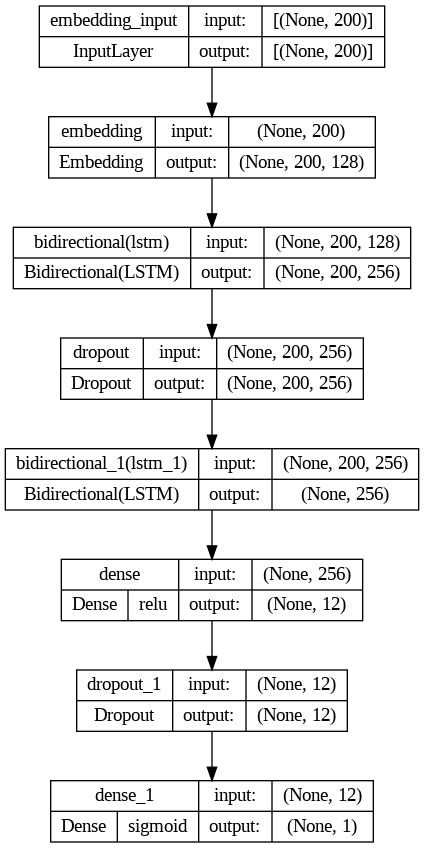

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False
)

Training model
- optimizer: Adam
- loss: binary crossentropy
- epochs: 15
- chcekpoint: minimum val_loss
- batch size: 128

In [ ]:
import time
start_time = time.time()

In [ ]:
saved_model = 'lstm.hdf5'
checkpoint = ModelCheckpoint(saved_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

epochs = 15
batch_size = 128
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=epochs, batch_size=batch_size,callbacks = [checkpoint, early_stopping])

Epoch 1/15
310/310 [==============================] - ETA: 0s - loss: 0.7820 - accuracy: 0.6577
Epoch 1: val_accuracy improved from -inf to 0.77171, saving model to lstm.hdf5
310/310 [==============================] - 11s 12ms/step - loss: 0.7820 - accuracy: 0.6577 - val_loss: 0.5946 - val_accuracy: 0.7717
Epoch 2/15
309/310 [============================>.] - ETA: 0s - loss: 0.5555 - accuracy: 0.7751
Epoch 2: val_accuracy improved from 0.77171 to 0.78653, saving model to lstm.hdf5
310/310 [==============================] - 3s 11ms/step - loss: 0.5553 - accuracy: 0.7752 - val_loss: 0.5238 - val_accuracy: 0.7865
Epoch 3/15
307/310 [============================>.] - ETA: 0s - loss: 0.5168 - accuracy: 0.7835
Epoch 3: val_accuracy did not improve from 0.78653
310/310 [==============================] - 3s 10ms/step - loss: 0.5167 - accuracy: 0.7835 - val_loss: 0.5034 - val_accuracy: 0.7859
Epoch 4/15
307/310 [============================>.] - ETA: 0s - loss: 0.5023 - accuracy: 0.7853
Epoch 4

In [ ]:
end_time = time.time()
bi_lstm_training_time = end_time - start_time
print("Bi-LSTM training time:", bi_lstm_training_time)

Bi-LSTM training time: 55.68385124206543


In [ ]:
num_parameters = model.count_params()
print("Number of trainable parameters in Bi-LSTM model:", num_parameters)

Number of trainable parameters in Bi-LSTM model: 157313


PLOT: training process
- we use ModelCheckpoint -> saved model with the max validation accuracy 

In [ ]:
def trainingProcess(history):
    plt.style.use('ggplot')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig("training_acc.png")
    plt.show()
    plt.style.use('ggplot')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig("training.png")
    plt.show()

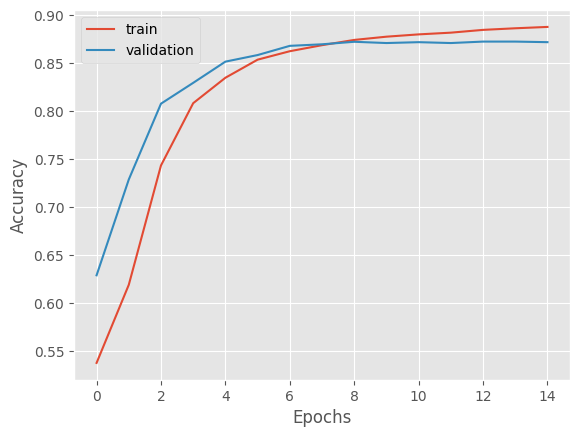

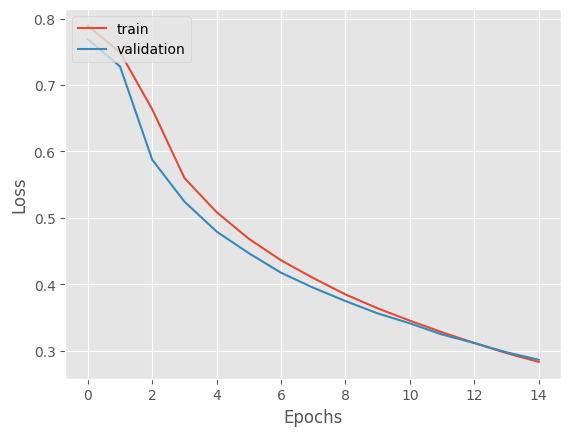

In [ ]:
trainingProcess(history)

Model Prediction and Evaluation

In [ ]:
# load best model
myModel = load_model('lstm.hdf5') 

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype('int32')

310/310 [==============================] - 5s 11ms/step


In [ ]:
# Get the last prediction value for each sequence
y_pred = np.round(model.predict(X_test)[:, -1])

# Print classification report
target_names = ['negative', 'positive']
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=target_names))

310/310 [==============================] - 3s 11ms/step
              precision    recall  f1-score   support

    negative       0.88      0.87      0.87      4940
    positive       0.87      0.88      0.87      4977

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



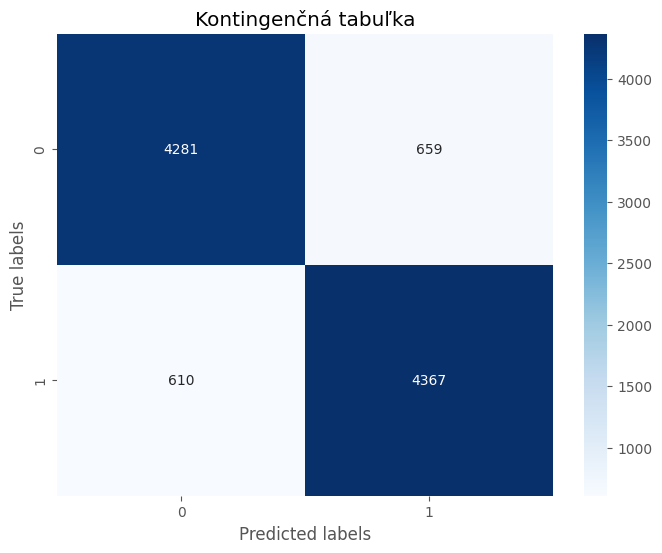

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Kontingenčná tabuľka')
plt.savefig("SA_CM.png")
plt.show()


In [ ]:
# evaluate performance of trained model on test data
evaluation = myModel.evaluate(X_test, y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

310/310 [==============================] - 6s 12ms/step - loss: 0.3116 - accuracy: 0.8726
Test Accuracy : 87.26%


In [ ]:
# Create a DataFrame to store the predicted and actual labels
df_false_pred = pd.DataFrame({'actual': y_test.flatten(), 'predicted': y_pred.flatten()})

# Filter out the reviews that were falsely identified
false_reviews = df_false_pred[df_false_pred['actual'] != df_false_pred['predicted']]

# Print the number of false reviews
print(f'Number of false reviews: {len(false_reviews)}')

Number of false reviews: 1269


##Feature importance

In [ ]:
lstm_layer = model.layers[1] # get the LSTM layer
lstm_weights = lstm_layer.get_weights()[0] # get the LSTM weights
actual_importance = np.abs(lstm_weights).sum(axis=1) # calculate the importance of each input feature

In [ ]:
feature_names = word_dict

In [ ]:
# Create an empty DataFrame to store the feature names and importance scores
lstm_feature_importance = pd.DataFrame(columns=["Feature", "Importance"])

# Sort the features by importance in descending order
lstm_importance_ranking = np.argsort(actual_importance)[::-1]

# Loop through the sorted features and add them to the DataFrame
for i, feature_idx in enumerate(lstm_importance_ranking):
    feature_name = feature_names[feature_idx]
    importance_score = actual_importance[feature_idx]
    lstm_feature_importance.loc[i] = [feature_name, importance_score]
# Print the DataFrame
lstm_feature_importance.sort_values(by = 'Importance', ascending=True)

In [ ]:
lstm_feature_importance['normalized_importance'] = lstm_feature_importance['Importance'] / lstm_feature_importance['Importance'].sum()

In [ ]:
lstm_feature_importance


In [ ]:
# Get the penultimate layer of the model
penultimate_layer = myModel.layers[-2]

# Print the name and output shape of the penultimate layer
print("Penultimate layer name:", penultimate_layer.name)
print("Penultimate layer output shape:", penultimate_layer.output_shape)

##sage feature importance 

surrogate sage

In [ ]:
pip install sage-importance

In [ ]:
import sage

In [ ]:
# Use SAGE to identify the most important input features
sage = SAGE(model)
expl = sage.explain(X_train[:100], verbose=False)
importance_scores = expl.importance['scores']

In [ ]:
# Select the most important features
num_important_features = 20
important_feature_indices = np.argsort(importance_scores)[-num_important_features:]
important_features = X_train[:, important_feature_indices]

# Define and compile the surrogate model
surrogate_model = Sequential()
surrogate_model.add(Dense(64, activation='relu', input_dim=num_important_features))
surrogate_model.add(Dense(1, activation='sigmoid'))
surrogate_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the surrogate model
surrogate_model.fit(important_features, y_train, validation_data=(X_test[:, important_feature_indices], y_test), epochs=5, batch_size=128)

In [ ]:
# Use the surrogate model to make predictions
surrogate_preds = surrogate_model.predict(X_test[:, important_feature_indices]).flatten()

In [ ]:
from sklearn.metrics import f1_score

# Calculate the F1 score for the surrogate model
surrogate_preds_binary = (surrogate_preds > 0.5).astype(int)
f1 = f1_score(y_test, surrogate_preds_binary)

print('F1 score for surrogate model: ', f1)

In [ ]:
imputer = sage.MarginalImputer(model, X_test[:45])
estimator = sage.PermutationEstimator(imputer, 'mse')

In [ ]:
sage_values = estimator(X_test,y_test)

In [ ]:
sage_values.plot()

In [ ]:
vals = sage_values.values
vals_abs = np.abs(vals)
sage_values.feature_names = list(word_dict.keys())
sage_feature_importance = pd.DataFrame(
list(zip(sage_values.feature_names,vals_abs)), columns=['Feature', 'Importance'])
sage_feature_importance.sort_values(
by=['Importance'], ascending=False, inplace=True)

In [ ]:
sage_feature_importance['Importance'].min()

In [ ]:
sage_feature_importance['normalized_importance'] = sage_feature_importance['Importance'] / sage_feature_importance['Importance'].sum()

In [ ]:
# Merge the two DataFrames
merged_df = sage_feature_importance.merge(lstm_feature_importance, on='Feature', suffixes=('_sage', '_lstm'))

In [ ]:
from scipy.stats import pearsonr
# Calculate the correlation between SHAP and LSTM importance scores
correlation, _ = pearsonr(merged_df['normalized_importance_sage'], merged_df['normalized_importance_lstm'])
print(f"Correlation between Sage and LSTM importance scores: {correlation:.4f}")

In [ ]:
# Create a bar plot to compare the normalized importance scores
width = 0.35
x = np.arange(len(merged_df['Feature']))
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, merged_df['normalized_importance_sage'], width, label='Sage')
rects2 = ax.bar(x + width/2, merged_df['normalized_importance_lstm'], width, label='LSTM')

ax.set_ylabel('Normalized Importance')
ax.set_title('Comparison of Normalized Sage and LSTM Feature Importance')
ax.set_xticks(x)
ax.set_xticklabels(merged_df['Feature'])
ax.set_ylabel('Feature')
ax.legend()

fig.tight_layout()
plt.show()

TSNE

In [ ]:
def create_truncated_model(model):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128,kernel_regularizer=l2(0.0000001), recurrent_regularizer=l1(0.0001))))
    model.add(Dropout(0.2))
    for i, layer in enumerate(model.layers):
        layer.set_weights(model.layers[i].get_weights())
    model.compile(optimizer = Adam(learning_rate = 0.00001),loss = 'binary_crossentropy', metrics = ['accuracy'],loss_weights=[0.5, 0.5])

    return model

truncated_model = create_truncated_model(model)
hidden_features = truncated_model.predict(X_test)

310/310 [==============================] - 5s 11ms/step


In [ ]:
for layer in model.layers:
    print(layer.name, layer.trainable)
    print('Layer Configuration:')
    print(layer.get_config(), end='\n{}\n'.format('----'*10))

embedding True
Layer Configuration:
{'name': 'embedding', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 200), 'input_dim': 10000, 'output_dim': 128, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': 200}
----------------------------------------
bidirectional True
Layer Configuration:
{'name': 'bidirectional', 'trainable': True, 'dtype': 'float32', 'layer': {'class_name': 'LSTM', 'config': {'name': 'lstm', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 128, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'recurrent_initializer': {'class_na

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=20)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 0.993621154832802

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=3, verbose = 1)
tsne_results = tsne.fit_transform(pca_result[:5000])

Variance PCA: 0.6502296924591064
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.255s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.010292
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.836517
[t-SNE] KL divergence after 1000 iterations: 2.990464


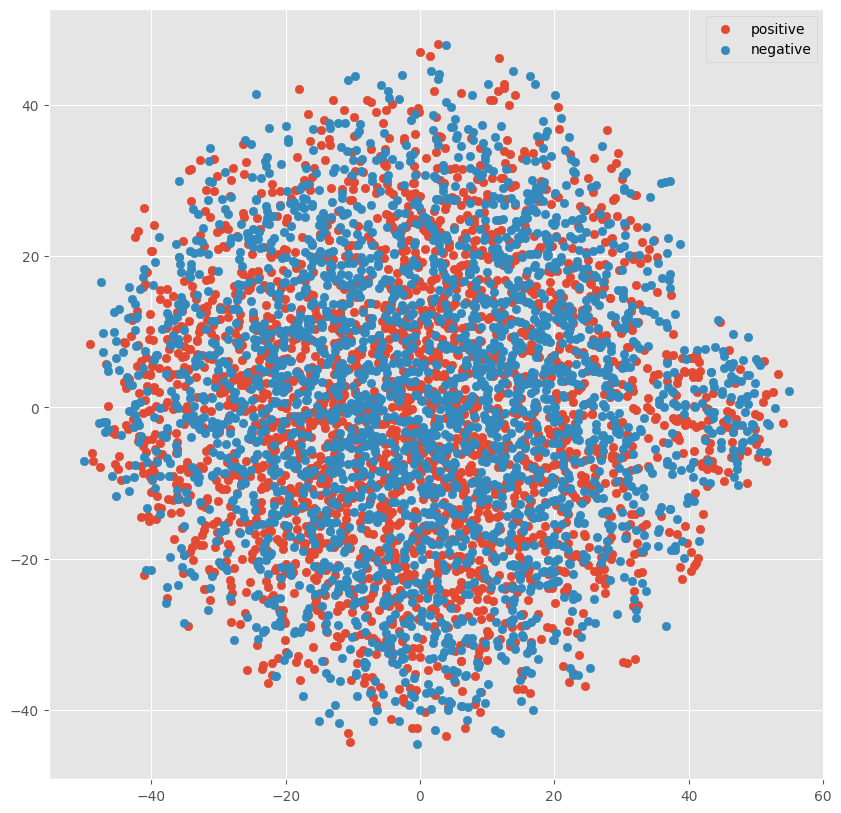

In [ ]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_cat = np_utils.to_categorical(y_pred[:5000], num_classes = 2,)
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(10,10), facecolor='white')
for cl in range(2):
    indices = np.where(color_map==cl)
    indices = indices[0]
    label = 'positive' if cl == 0 else 'negative'
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=label)
#for cl in range(2):
#    indices = np.where(color_map==cl)
#    indices = indices[0]
#    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend()
plt.axis('on')
plt.savefig("tsne.png")
plt.show()

# Explainability methods

#1. LIME

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import lime
from lime.lime_tabular import LimeTabularExplainer
from lime.lime_base import LimeBase
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from lime.lime_text import LimeTextExplainer
import tensorflow as tf
index = 4
explainer = LimeTextExplainer(class_names=["negative", "positive"],feature_selection='auto', verbose=True )

def print_function(review, actual_sentiment, predicted_sentiment):
    #print("Review: ", review)
    #print("Actual sentiment: ", actual_sentiment)
    #print("Predicted sentiment: ", predicted_sentiment)
     print()

def predict_function(tokenized_text):

    test_seq = tokenizer.texts_to_sequences(tokenized_text)
    test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=max_len)
    pred = model.predict(test_pad)
    format_pred = np.concatenate([1.0-pred, pred], axis=1)
    predicted_sentiment = "positive" if format_pred[0][1] > 0.5 else "negative"
    print_function(df.review_clean[index], df.sentiment[index], predicted_sentiment)
    return format_pred

exp = explainer.explain_instance(df.review_clean[index], predict_function)
print(exp.as_list())

157/157 [==============================] - 2s 11ms/step

Intercept 0.6878442644523597
Prediction_local [0.95394869]
Right: 0.9410236
[('different', 0.12209913006042084), ('good', 0.10556408340920448), ('human', 0.07077806314734034), ('money', -0.05561707173605284), ('love', 0.04683253873683472), ('Michael', 0.03665812448956475), ('Steve', -0.017303371372860827), ('rest', -0.015548170129503032), ('direction', -0.014497047703797708), ('point', -0.012861848708852989)]


GRID SEARCH FOR KERNEL WIDTH

In [ ]:
import numpy as np
import random
from sklearn.metrics import accuracy_score
from lime.lime_text import LimeTextExplainer

true_labels = df['sentiment']
tokenized_sample = df.review_clean

def lime_grid_search(predict_function, tokenized_sample, true_labels, kernel_widths, accuracy_threshold, num_samples=1000, sample_size=30):
    optimal_kernel_width = None
    best_avg_accuracy = -1

    # Randomly sample sentences
    random.seed(42)  # Set seed for reproducibility
    sample_indices = random.sample(range(len(tokenized_sample)), sample_size)
    sampled_texts = [tokenized_sample[i] for i in sample_indices]
    sampled_true_labels = [true_labels[i] for i in sample_indices]

    for kernel_width in kernel_widths:
        print(f"Testing kernel_width: {kernel_width}")
        accuracies = []

        for i, text_to_explain in enumerate(sampled_texts):
            if len(text_to_explain.split()) < 2:
                continue

            true_label = sampled_true_labels[i]

            explainer = LimeTextExplainer(kernel_width=kernel_width, class_names=["negative", "positive"], verbose=True, feature_selection='auto')
            explanation = explainer.explain_instance(text_to_explain, predict_function, num_samples=num_samples)
            explanation_list = explanation.as_list()

            sentiment_score = 0
            for _, weight in explanation_list:
                sentiment_score += weight

            sentiment_threshold = 0
            predicted_label = "positive" if sentiment_score > sentiment_threshold else "negative"
            accuracy = accuracy_score([true_label], [predicted_label])
            accuracies.append(accuracy)

        avg_accuracy = np.mean(accuracies)
        print(f"Average accuracy for kernel_width {kernel_width}: {avg_accuracy}")

        if avg_accuracy > best_avg_accuracy:
            best_avg_accuracy = avg_accuracy
            optimal_kernel_width = kernel_width

            # Stop search if threshold is suprassed 
            if best_avg_accuracy >= accuracy_threshold:
                break

    return optimal_kernel_width, best_avg_accuracy


kernel_widths = np.arange(1, 3, 0.5)
accuracy_threshold = 0.9 
optimal_kernel_width, best_avg_accuracy = lime_grid_search(predict_function, tokenized_sample, true_labels, kernel_widths, accuracy_threshold)

print(f"Optimal kernel width: {optimal_kernel_width}")
print(f"Best average accuracy: {best_avg_accuracy}")

## CALCULATE QUANTITATIVE METRIC
- % of words in respect to review length contributing to the overall prediction for SA

In [ ]:
tokenized_sample = df.review_clean[:100]

In [ ]:
import pandas as pd

# Assuming your DataFrame is called df
starting_row = 25000

# Use slicing to select all entries in the 'review_clean' column starting at row 2500
tokenized_sample = df.loc[starting_row:, 'review_clean']
tokenized_sample = tokenized_sample.reset_index(drop=True)

In [ ]:
def predict_function(tokenized_sample):

    test_seq = tokenizer.texts_to_sequences(tokenized_sample)
    test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=max_len)
    pred = model.predict(test_pad)
    format_pred = np.concatenate([1.0-pred, pred], axis=1)
    predicted_sentiment = "positive" if format_pred[0][1] > 0.5 else "negative"
    print_function(df.review_clean[index], df.sentiment[index], predicted_sentiment)
    return format_pred

In [ ]:
from lime.lime_text import LimeTextExplainer
import numpy as np
import pandas as pd

def batch_explanation(tokenized_sample):
    num_samples = tokenized_sample.shape[0]
    num_words = len(tokenized_sample[0])
    exp_matrix = np.zeros((num_samples, num_words, 2))  # initialize matrix for explanations

    results_df = pd.DataFrame(columns=["review_index", "word_count", "positive_count", "negative_count", "label"])

    for index in range(num_samples):
        explainer = LimeTextExplainer(bow=True,kernel_width=2.85,class_names=["negative", "positive"],feature_selection='auto',verbose=True)
        text_to_explain = ''.join(tokenized_sample[index])

        max_len = 10000
        if len(text_to_explain) > max_len:
            text_to_explain = text_to_explain[:max_len]

        explanation = explainer.explain_instance(text_to_explain, predict_function,num_samples=40000)
        explanation_list = explanation.as_list()

        #print('Explanation for index {}: {}'.format(index, explanation.as_list()))
        print('Explanation for index {}:'.format(index))
        positive_count = 0
        negative_count = 0

        for word, weight in explanation.as_list():
            if weight >= 0:
                positive_count += 1
            else:
                negative_count += 1

        total_count = positive_count + negative_count
        positive_percentage = (positive_count / total_count) * 100
        negative_percentage = (negative_count / total_count) * 100

        if positive_count > negative_count:
            label = "positive"
        else:
            label = "negative"

        #print("LIME label: {}".format(label))
        #print("# of positive words:", positive_count)
        #print("# of negative words:", negative_count)
        #print("Positive words percentage: {:.2f}%".format(positive_percentage))
        #print("Negative words percentage: {:.2f}%".format(negative_percentage))

        word_count = len(text_to_explain.split())
        results_df = results_df.append({"review_index": index,
                                         "word_count": word_count,
                                         "positive_count": positive_count,
                                         "negative_count": negative_count,
                                         "label": label}, ignore_index=True)

    return results_df


In [ ]:
### the actual f1 score calculation for surrogate 
from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import RecurrentTabularExplainer
import numpy as np
import pandas as pd

def batch_explanation(tokenized_sample):
    num_samples = tokenized_sample.shape[0]
    num_words = len(tokenized_sample[0])
    exp_matrix = np.zeros((num_samples, num_words, 2))  # initialize matrix for explanations

    results_df = pd.DataFrame(columns=["review_index", "word_count", "positive_count", "negative_count", "sentiment_score", "label"])

    for index in range(num_samples):
        explainer = LimeTextExplainer(bow=True,class_names=["negative", "positive"],feature_selection='auto',verbose=True,kernel_width=1)
        
        
        text_to_explain = ''.join(tokenized_sample[index])

        max_len = 10000
        if len(text_to_explain) > max_len:
            text_to_explain = text_to_explain[:max_len]

        explanation = explainer.explain_instance(text_to_explain, predict_function,num_samples=100)
        explanation_list = explanation.as_list()

        print('Explanation for index {}:'.format(index))
        positive_count = 0
        negative_count = 0
        sentiment_score = 0

        for word, weight in explanation_list:
            if weight >= 0:
                positive_count += 1
                sentiment_score += weight
            else:
                negative_count += 1
                sentiment_score += weight

        # Determine a threshold for converting sentiment scores into class labels
        sentiment_threshold = 0

        if sentiment_score > sentiment_threshold:
            label = "positive"
        else:
            label = "negative"

        word_count = len(text_to_explain.split())
        results_df = results_df.append({"review_index": index,
                                         "word_count": word_count,
                                         "positive_count": positive_count,
                                         "negative_count": negative_count,
                                         "sentiment_score": sentiment_score,
                                         "label": label}, ignore_index=True)

    return results_df


In [ ]:
results_df = batch_explanation(tokenized_sample)
results_df.head()

In [ ]:
#create same test sample for surrogate model 
X_train_lime, X_test_lime, y_train_lime, y_test_lime = train_test_split(df.review_clean, y, test_size=0.2, random_state=123,stratify=y)

In [ ]:
X_test_lime = X_test_lime.reset_index(drop=True)

In [ ]:
#surrogate
### the actual f1 score calculation for surrogate 
from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import RecurrentTabularExplainer
import numpy as np
import pandas as pd

def batch_explanation(X_test_lime):
    num_samples = X_test_lime.shape[0]
    num_words = len(X_test_lime[0])
    exp_matrix = np.zeros((num_samples, num_words, 2))  # initialize matrix for explanations

    results_df = pd.DataFrame(columns=["review_index", "word_count", "positive_count", "negative_count", "sentiment_score", "label"])

    for index in range(num_samples):
        explainer = LimeTextExplainer(bow=True,class_names=["negative", "positive"],feature_selection='auto',verbose=True,kernel_width=1)
        
        
        text_to_explain = ''.join(X_test_lime[index])

        max_len = 10000
        if len(text_to_explain) > max_len:
            text_to_explain = text_to_explain[:max_len]

        explanation = explainer.explain_instance(text_to_explain, predict_function,num_samples=100)
        explanation_list = explanation.as_list()

        print('Explanation for index {}:'.format(index))
        positive_count = 0
        negative_count = 0
        sentiment_score = 0

        for word, weight in explanation_list:
            if weight >= 0:
                positive_count += 1
                sentiment_score += weight
            else:
                negative_count += 1
                sentiment_score += weight

        # Determine a threshold for converting sentiment scores into class labels
        sentiment_threshold = 0

        if sentiment_score > sentiment_threshold:
            label = "positive"
        else:
            label = "negative"

        word_count = len(text_to_explain.split())
        results_df = results_df.append({"review_index": index,
                                         "word_count": word_count,
                                         "positive_count": positive_count,
                                         "negative_count": negative_count,
                                         "sentiment_score": sentiment_score,
                                         "label": label}, ignore_index=True)

    return results_df


In [ ]:
results_df = batch_explanation(X_test_lime)

4/4 [==============================] - 0s 11ms/step

Intercept 0.061430735640603466
Prediction_local [0.06260307]
Right: 0.067841314
Explanation for index 0:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04748545267337972
Prediction_local [0.03834914]
Right: 0.029218504
Explanation for index 1:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 11ms/step

Intercept 0.016650690264352338
Prediction_local [0.01590303]
Right: 0.015682945
Explanation for index 2:
4/4 [==============================] - 0s 11ms/step

Intercept 0.9566789026680131
Prediction_local [0.95792369]
Right: 0.95840263
Explanation for index 3:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 11ms/step

Intercept 0.9287513880053222
Prediction_local [0.9315028]
Right: 0.9342545
Explanation for index 4:
4/4 [==============================] - 0s 11ms/step

Intercept 0.9358314403366165
Prediction_local [0.93746257]
Right: 0.93899244
Explanation for index 5:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 11ms/step

Intercept 0.13726991745939043
Prediction_local [0.13481173]
Right: 0.13351339
Explanation for index 6:
4/4 [==============================] - 0s 11ms/step

Intercept 0.9725718974766737
Prediction_local [0.9724433]
Right: 0.9722925
Explanation for index 7:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 11ms/step

Intercept 0.05198955233086767
Prediction_local [0.05182378]
Right: 0.05171993
Explanation for index 8:
4/4 [==============================] - 0s 11ms/step

Intercept 0.6449928592371144
Prediction_local [0.64920074]
Right: 0.638532
Explanation for index 9:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 11ms/step

Intercept 0.5199396563723516
Prediction_local [0.51932533]
Right: 0.52389365
Explanation for index 10:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.747545363304125
Prediction_local [0.8139002]
Right: 0.8184871
Explanation for index 11:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03520106604861982
Prediction_local [0.03282579]
Right: 0.03212135
Explanation for index 12:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8916469809586106
Prediction_local [0.88109268]
Right: 0.87687975
Explanation for index 13:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9308308404971696
Prediction_local [0.93185151]
Right: 0.93220747
Explanation for index 14:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9384048042689405
Prediction_local [0.93953347]
Right: 0.9390027
Explanation for index 15:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2131832474890441
Prediction_local [0.2052837]
Right: 0.20223786
Explanation for index 16:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9404991077411616
Prediction_local [0.94574203]
Right: 0.9468051
Explanation for index 17:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9724756519493698
Prediction_local [0.9735785]
Right: 0.97393554
Explanation for index 18:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9588005630029377
Prediction_local [0.95895312]
Right: 0.959021
Explanation for index 19:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7247433893137122
Prediction_local [0.75231166]
Right: 0.75353116
Explanation for index 20:
4/4 [==============================] - 0s 13ms/step

Intercept 0.26209449797752105
Prediction_local [0.27147343]
Right: 0.2711885
Explanation for index 21:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.014297081004933659
Prediction_local [0.01382762]
Right: 0.013763024
Explanation for index 22:
4/4 [==============================] - 0s 12ms/step

Intercept 0.47396401095647916
Prediction_local [0.4166298]
Right: 0.38075796
Explanation for index 23:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9261830157698928
Prediction_local [0.92871532]
Right: 0.9290492
Explanation for index 24:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9569297061010328
Prediction_local [0.95552023]
Right: 0.9551703
Explanation for index 25:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.1585044864745681
Prediction_local [0.16238529]
Right: 0.16576059
Explanation for index 26:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8365431933571471
Prediction_local [0.86734525]
Right: 0.8668588
Explanation for index 27:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.14682673212523772
Prediction_local [0.12579602]
Right: 0.12672463
Explanation for index 28:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9082710451643209
Prediction_local [0.90744901]
Right: 0.9070693
Explanation for index 29:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8910665769500591
Prediction_local [0.88591421]
Right: 0.8871554
Explanation for index 30:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.2839334712189841
Prediction_local [0.2960304]
Right: 0.30738437
Explanation for index 31:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9626048908958209
Prediction_local [0.96324047]
Right: 0.9633014
Explanation for index 32:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9645966513795902
Prediction_local [0.96295817]
Right: 0.963154
Explanation for index 33:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.08261910128171036
Prediction_local [0.1283012]
Right: 0.14630881
Explanation for index 34:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02605634411708536
Prediction_local [0.02646066]
Right:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.026868647
Explanation for index 35:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0811123487795855
Prediction_local [0.08228169]
Right: 0.083499074
Explanation for index 36:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014229211237905855
Prediction_local [0.01385476]
Right: 0.013477783
Explanation for index 37:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02298861678454987
Prediction_local [0.02261175]
Right: 0.022448534
Explanation for index 38:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9711317564439114
Prediction_local [0.97141972]
Right: 0.97156954
Explanation for index 39:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.1436062733861941
Prediction_local [0.14448868]
Right: 0.14466967
Explanation for index 40:
4/4 [==============================] - 0s 12ms/step

Intercept 0.947621102733487
Prediction_local [0.9469379]
Right: 0.94645
Explanation for index 41:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010625728230413628
Prediction_local [0.01028934]
Right: 0.010180195
Explanation for index 42:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6410390700139443
Prediction_local [0.66182588]
Right: 0.6771449
Explanation for index 43:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.06387862248372213
Prediction_local [0.06455953]
Right: 0.06379752
Explanation for index 44:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9536785502212829
Prediction_local [0.95362174]
Right: 0.95374274
Explanation for index 45:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017252926689523936
Prediction_local [0.01674325]
Right: 0.016534666
Explanation for index 46:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3106626184523059
Prediction_local [0.28784398]
Right: 0.27715635
Explanation for index 47:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04043057375864566
Prediction_local [0.041581]
Right: 0.04196448
Explanation for index 48:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9823625098072422
Prediction_local [0.98297662]
Right: 0.9829925
Explanation for index 49:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9605192022445838
Prediction_local [0.96199437]
Right: 0.96237445
Explanation for index 50:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.35234147651076686
Prediction_local [0.26502321]
Right: 0.24712405
Explanation for index 51:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9592471604641828
Prediction_local [0.96535256]
Right: 0.96625596
Explanation for index 52:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8118711043104901
Prediction_local [0.82342715]
Right: 0.83073634
Explanation for index 53:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8372472648719214
Prediction_local [0.83466745]
Right: 0.8324301
Explanation for index 54:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8816958826850577
Prediction_local [0.89335897]
Right: 0.8988259
Explanation for index 55:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9546435615164097
Prediction_local [0.92135733]
Right: 0.917562
Explanation for index 56:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.15981285255927175
Prediction_local [0.16262256]
Right: 0.16507715
Explanation for index 57:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12231068778320908
Prediction_local [0.10177621]
Right: 0.094490066
Explanation for index 58:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.964232715194603
Prediction_local [0.96816863]
Right: 0.96935004
Explanation for index 59:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2862261095977329
Prediction_local [0.28796837]
Right: 0.28857648
Explanation for index 60:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.16834178261236174
Prediction_local [0.17892747]
Right: 0.18916675
Explanation for index 61:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9849207008966341
Prediction_local [0.9855616]
Right: 0.9855876
Explanation for index 62:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010191137235794434
Prediction_local [0.01013047]
Right: 0.010068881
Explanation for index 63:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8982633007661155
Prediction_local [0.89997412]
Right: 0.9010969
Explanation for index 64:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2622282030613103
Prediction_local [0.26274003]
Right: 0.27041185
Explanation for index 65:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8789414627852934
Prediction_local [0.87716847]
Right: 0.87735224
Explanation for index 66:
4/4 [==============================] - 0s 12ms/step

Intercept 0.010985624502378364
Prediction_local [0.01002518]
Right: 0.009951173
Explanation for index 67:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.032817791052713
Prediction_local [0.02715945]
Right: 0.025971415
Explanation for index 68:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.13839259634744192
Prediction_local [0.06523978]
Right: 0.062167265
Explanation for index 69:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.05052677130817488
Prediction_local [0.05046003]
Right: 0.048914038
Explanation for index 70:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6365162788161491
Prediction_local [0.64431238]
Right: 0.6521086
Explanation for index 71:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8920948243895986
Prediction_local [0.89835707]
Right: 0.90472573
Explanation for index 72:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.020086196812614865
Prediction_local [0.02178102]
Right: 0.02298191
Explanation for index 73:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5142015828748367
Prediction_local [0.61286598]
Right: 0.6260389
Explanation for index 74:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8335088632967644
Prediction_local [0.87770264]
Right: 0.8788997
Explanation for index 75:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16415680431754323
Prediction_local [0.15559545]
Right: 0.15109883
Explanation for index 76:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03556546906899592
Prediction_local [0.03328307]
Right: 0.033252656
Explanation for index 77:
4/4 [==============================] - 0s 13ms/step

Intercept 0.048962580153584775
Prediction_local [0.04898837]
Right: 0.04901415
Explanation for index 78:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011918366561420694
Prediction_local [0.01163287]
Right: 0.011660142
Explanation for index 79:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2555551290124608
Prediction_local [0.20796852]
Right: 0.19583404
Explanation for index 80:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.021464377399574304
Prediction_local [0.02158838]
Right: 0.0216776
Explanation for index 81:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011070417835816772
Prediction_local [0.01103595]
Right: 0.011047299
Explanation for index 82:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.017275217015075183
Prediction_local [0.01682865]
Right: 0.016384434
Explanation for index 83:
4/4 [==============================] - 0s 12ms/step

Intercept 0.797037902576107
Prediction_local [0.85116804]
Right: 0.90332574
Explanation for index 84:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.0326751991838778
Prediction_local [0.02649551]
Right: 0.025641635
Explanation for index 85:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9595661315917448
Prediction_local [0.95794735]
Right: 0.9574799
Explanation for index 86:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5438524176546083
Prediction_local [0.57207133]
Right: 0.5824075
Explanation for index 87:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9333485745968155
Prediction_local [0.93064002]
Right: 0.9301041
Explanation for index 88:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.0161997224912573
Prediction_local [0.0159146]
Right: 0.015633807
Explanation for index 89:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01496464647020415
Prediction_local [0.01489347]
Right: 0.014831919
Explanation for index 90:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9459669551817754
Prediction_local [0.94678283]
Right: 0.9475119
Explanation for index 91:
4/4 [==============================] - 0s 12ms/step

Intercept 0.09886672922100337
Prediction_local [0.10090743]
Right: 0.102962755
Explanation for index 92:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8756072099467762
Prediction_local [0.87492755]
Right: 0.8740556
Explanation for index 93:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0445580958334689
Prediction_local [0.04440977]
Right: 0.04426144
Explanation for index 94:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8679709473511843
Prediction_local [0.88845188]
Right: 0.89652705
Explanation for index 95:
4/4 [==============================] - 0s 12ms/step

Intercept 0.008084107443936454
Prediction_local [0.00763893]
Right: 0.0075429706
Explanation for index 96:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010382307027964756
Prediction_local [0.01048507]
Right: 0.0105876485
Explanation for index 97:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2523824790099216
Prediction_local [0.24816617]
Right: 0.2430723
Explanation for index 98:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9471585454751299
Prediction_local [0.94896137]
Right: 0.9495292
Explanation for index 99:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9864980180130617
Prediction_local [0.98745586]
Right: 0.9876051
Explanation for index 100:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8200768521455787
Prediction_local [0.82033853]
Right: 0.8204603
Explanation for index 101:
4/4 [==============================] - 0s 13ms/step

Intercept 0.006029213658147937
Prediction_local [0.00604776]
Right: 0.0060569826
Explanation for index 102:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9453368583889435
Prediction_local [0.94814427]
Right: 0.94987327
Explanation for index 103:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9182648420116444
Prediction_local [0.91267291]
Right: 0.90980273
Explanation for index 104:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.11631444853989831
Prediction_local [0.1151027]
Right: 0.11485756
Explanation for index 105:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8958223033789977
Prediction_local [0.89817622]
Right: 0.89829034
Explanation for index 106:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9679011126821042
Prediction_local [0.97367169]
Right: 0.9746463
Explanation for index 107:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3277618597962842
Prediction_local [0.28631407]
Right: 0.28898907
Explanation for index 108:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.25877520667340237
Prediction_local [0.30462896]
Right: 0.31122306
Explanation for index 109:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9578332275897313
Prediction_local [0.96046664]
Right: 0.9630999
Explanation for index 110:
4/4 [==============================] - 0s 14ms/step

Intercept 0.023315044531989383
Prediction_local [0.02229577]
Right: 0.022066252
Explanation for index 111:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8571075161106485
Prediction_local [0.86660217]
Right: 0.8754834
Explanation for index 112:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013927263909569804
Prediction_local [0.014421]
Right: 0.014507587
Explanation for index 113:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.15925060612979708
Prediction_local [0.13220173]
Right: 0.12107826
Explanation for index 114:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8440442343424581
Prediction_local [0.85784539]
Right: 0.8638532
Explanation for index 115:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008682946602185531
Prediction_local [0.00867532]
Right: 0.008682193
Explanation for index 116:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5857325975686606
Prediction_local [0.61866318]
Right: 0.6410786
Explanation for index 117:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9433059358154736
Prediction_local [0.94373946]
Right: 0.944173
Explanation for index 118:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9564041511209003
Prediction_local [0.96261932]
Right: 0.9635713
Explanation for index 119:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.08506245904023509
Prediction_local [0.08626061]
Right: 0.0873451
Explanation for index 120:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9631258892713133
Prediction_local [0.9655425]
Right: 0.9656939
Explanation for index 121:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9387047883020367
Prediction_local [0.93810549]
Right: 0.9385982
Explanation for index 122:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8669125405880926
Prediction_local [0.86022709]
Right: 0.8635449
Explanation for index 123:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9129300545807857
Prediction_local [0.92153442]
Right: 0.92369765
Explanation for index 124:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9205115166033153
Prediction_local [0.92604571]
Right: 0.92922175
Explanation for index 125:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9704664193378315
Prediction_local [0.97235584]
Right: 0.97424567
Explanation for index 126:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9071304253556377
Prediction_local [0.90829881]
Right: 0.90924174
Explanation for index 127:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013260388724493713
Prediction_local [0.01265241]
Right: 0.012614194
Explanation for index 128:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.009315641696065037
Prediction_local [0.00921108]
Right: 0.009121429
Explanation for index 129:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6470736617876746
Prediction_local [0.6814234]
Right: 0.6779275
Explanation for index 130:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9740507722402388
Prediction_local [0.97348899]
Right: 0.97335374
Explanation for index 131:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01846685299056468
Prediction_local [0.01729209]
Right: 0.016119912
Explanation for index 132:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03921340366918822
Prediction_local [0.03750821]
Right: 0.03661779
Explanation for index 133:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.23720447178487236
Prediction_local [0.33617038]
Right: 0.34330168
Explanation for index 134:
4/4 [==============================] - 0s 13ms/step

Intercept 0.07808197456084733
Prediction_local [0.08287303]
Right: 0.086830325
Explanation for index 135:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.11076973474743834
Prediction_local [0.11247207]
Right: 0.114785805
Explanation for index 136:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8894241117072456
Prediction_local [0.88945143]
Right: 0.88947874
Explanation for index 137:
4/4 [==============================] - 0s 13ms/step

Intercept 0.07746988328541662
Prediction_local [0.07629113]
Right: 0.07588033
Explanation for index 138:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9693911772758688
Prediction_local [0.97120379]
Right: 0.97262293
Explanation for index 139:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.27314226463626423
Prediction_local [0.14988866]
Right: 0.11874663
Explanation for index 140:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03188142560894118
Prediction_local [0.03238891]
Right: 0.032740515
Explanation for index 141:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7536266575702838
Prediction_local [0.78100417]
Right: 0.793247
Explanation for index 142:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02990237951211026
Prediction_local [0.0269774]
Right: 0.026566574
Explanation for index 143:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02731072949905059
Prediction_local [0.02680004]
Right: 0.026544617
Explanation for index 144:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9597586621067017
Prediction_local [0.96022515]
Right: 0.9602894
Explanation for index 145:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8131196001916347
Prediction_local [0.81030014]
Right: 0.8130926
Explanation for index 146:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.026438563522776872
Prediction_local [0.02785343]
Right: 0.02875674
Explanation for index 147:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.06645332121712628
Prediction_local [0.07111916]
Right: 0.07137137
Explanation for index 148:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012805598750326724
Prediction_local [0.01269223]
Right: 0.012623034
Explanation for index 149:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05666405745092694
Prediction_local [0.05162768]
Right: 0.049861297
Explanation for index 150:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9442346262956763
Prediction_local [0.94402261]
Right: 0.94399846
Explanation for index 151:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6457986821022302
Prediction_local [0.63579792]
Right: 0.62069714
Explanation for index 152:
4/4 [==============================] - 0s 13ms/step

Intercept 0.023328383575495614
Prediction_local [0.02291427]
Right: 0.022746993
Explanation for index 153:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.030458431444487184
Prediction_local [0.02616154]
Right: 0.023663469
Explanation for index 154:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.014677411352150851
Prediction_local [0.01583034]
Right: 0.01680779
Explanation for index 155:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.30561844016213163
Prediction_local [0.22245589]
Right: 0.22515297
Explanation for index 156:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03371869999106233
Prediction_local [0.03270961]
Right: 0.03170738
Explanation for index 157:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7558891089165649
Prediction_local [0.7464606]
Right: 0.7429063
Explanation for index 158:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.03450223165290739
Prediction_local [0.02643288]
Right: 0.022837732
Explanation for index 159:
4/4 [==============================] - 0s 14ms/step

Intercept 0.027706910057519907
Prediction_local [0.02428225]
Right: 0.023412518
Explanation for index 160:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.006002603507040903
Prediction_local [0.00567105]
Right: 0.0056476067
Explanation for index 161:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06133399332154218
Prediction_local [0.0615561]
Right: 0.0617094
Explanation for index 162:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010256467693949492
Prediction_local [0.01017212]
Right: 0.010152853
Explanation for index 163:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9644288919697427
Prediction_local [0.96345984]
Right: 0.9631538
Explanation for index 164:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.018924023522813787
Prediction_local [0.01650053]
Right: 0.016449843
Explanation for index 165:
4/4 [==============================] - 0s 13ms/step

Intercept 0.027549398694869852
Prediction_local [0.02693934]
Right: 0.026330255
Explanation for index 166:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.532172004473946
Prediction_local [0.50051636]
Right: 0.48270702
Explanation for index 167:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9317367883156031
Prediction_local [0.94356769]
Right: 0.9418306
Explanation for index 168:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6460050616944333
Prediction_local [0.65184255]
Right: 0.6538218
Explanation for index 169:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9057215727015571
Prediction_local [0.91930252]
Right: 0.92085624
Explanation for index 170:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.03636867983936174
Prediction_local [0.03634655]
Right: 0.036324415
Explanation for index 171:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020158416327652882
Prediction_local [0.02010012]
Right: 0.019988654
Explanation for index 172:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4618046515412262
Prediction_local [0.48924044]
Right: 0.51649123
Explanation for index 173:
4/4 [==============================] - 0s 12ms/step

Intercept 0.043863118252353374
Prediction_local [0.0439209]
Right: 0.043978676
Explanation for index 174:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9710939618529619
Prediction_local [0.97127815]
Right: 0.97108835
Explanation for index 175:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9517670285291997
Prediction_local [0.95491688]
Right: 0.9550702
Explanation for index 176:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4172042518828681
Prediction_local [0.56849184]
Right: 0.59382874
Explanation for index 177:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01456343318929183
Prediction_local [0.01447036]
Right: 0.014456084
Explanation for index 178:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8214104040484452
Prediction_local [0.87094962]
Right: 0.8753187
Explanation for index 179:
4/4 [==============================] - 0s 12ms/step

Intercept 0.006496475858971925
Prediction_local [0.00636305]
Right: 0.006311714
Explanation for index 180:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03651177168616154
Prediction_local [0.03243672]
Right: 0.033183426
Explanation for index 181:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5462977716393581
Prediction_local [0.50967093]
Right: 0.4842302
Explanation for index 182:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.023020775742492523
Prediction_local [0.02208754]
Right: 0.02177275
Explanation for index 183:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8122803092217518
Prediction_local [0.82601893]
Right: 0.8345435
Explanation for index 184:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06703452118126074
Prediction_local [0.04904466]
Right: 0.043757692
Explanation for index 185:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8931331377347735
Prediction_local [0.89101276]
Right: 0.8900904
Explanation for index 186:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4658449330205398
Prediction_local [0.43239068]
Right: 0.42062008
Explanation for index 187:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9839711335935972
Prediction_local [0.98430057]
Right: 0.9844146
Explanation for index 188:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014507027137512084
Prediction_local [0.01451033]
Right: 0.014524914
Explanation for index 189:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.15183072694795885
Prediction_local [0.14185739]
Right: 0.13973978
Explanation for index 190:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9640997020753821
Prediction_local [0.96528075]
Right: 0.9665052
Explanation for index 191:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03064956873274086
Prediction_local [0.03012063]
Right: 0.029402738
Explanation for index 192:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08707145962266259
Prediction_local [0.09275766]
Right: 0.09630946
Explanation for index 193:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7484878601612881
Prediction_local [0.85462887]
Right: 0.8882155
Explanation for index 194:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015230113776143868
Prediction_local [0.01424609]
Right: 0.014172785
Explanation for index 195:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8649508886024047
Prediction_local [0.86501702]
Right: 0.8650225
Explanation for index 196:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9759034575834882
Prediction_local [0.97700136]
Right: 0.9768957
Explanation for index 197:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022176168214735024
Prediction_local [0.01666605]
Right: 0.014705487
Explanation for index 198:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9078903236229438
Prediction_local [0.91048111]
Right: 0.91098297
Explanation for index 199:
4/4 [==============================] - 0s 13ms/step

Intercept 0.040329856006532924
Prediction_local [0.0262966]
Right: 0.025433436
Explanation for index 200:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9494008770970627
Prediction_local [0.94956292]
Right: 0.9495076
Explanation for index 201:
4/4 [==============================] - 0s 15ms/step

Intercept 0.013537677252370239
Prediction_local [0.01348652]
Right: 0.01343566
Explanation for index 202:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09926260648308458
Prediction_local [0.12938236]
Right: 0.13161734
Explanation for index 203:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.026556521199108053
Prediction_local [0.02630019]
Right: 0.026716068
Explanation for index 204:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3242443174441955
Prediction_local [0.09118525]
Right: 0.07687852
Explanation for index 205:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02546473768736735
Prediction_local [0.02697949]
Right: 0.027423218
Explanation for index 206:
4/4 [==============================] - 0s 13ms/step

Intercept 0.850560414553173
Prediction_local [0.86494533]
Right: 0.8679326
Explanation for index 207:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022295666455307166
Prediction_local [0.02247971]
Right: 0.022602623
Explanation for index 208:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9408037137351857
Prediction_local [0.95162069]
Right: 0.9534786
Explanation for index 209:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07565801709688512
Prediction_local [0.08728801]
Right: 0.09135996
Explanation for index 210:
4/4 [==============================] - 0s 13ms/step

Intercept 0.00797643557264778
Prediction_local [0.00739491]
Right: 0.0072599496
Explanation for index 211:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9231442648636449
Prediction_local [0.92425466]
Right: 0.9253713
Explanation for index 212:
4/4 [==============================] - 0s 13ms/step

Intercept 0.007823412678091996
Prediction_local [0.00663511]
Right: 0.0064794384
Explanation for index 213:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8452897396731829
Prediction_local [0.84887735]
Right: 0.8479841
Explanation for index 214:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7374355208110166
Prediction_local [0.74554277]
Right: 0.74928486
Explanation for index 215:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.24964342733539965
Prediction_local [0.22977783]
Right: 0.21243463
Explanation for index 216:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9902987158723956
Prediction_local [0.99036335]
Right: 0.99038434
Explanation for index 217:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.005970474046604461
Prediction_local [0.00596447]
Right: 0.0059924144
Explanation for index 218:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.019399615912321116
Prediction_local [0.01917257]
Right: 0.018945536
Explanation for index 219:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10842903574537961
Prediction_local [0.13216884]
Right: 0.13864017
Explanation for index 220:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8949978843168733
Prediction_local [0.89809754]
Right: 0.89764774
Explanation for index 221:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.06074333647339273
Prediction_local [0.06019253]
Right: 0.060011312
Explanation for index 222:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.340357723408184
Prediction_local [0.34193339]
Right: 0.34150386
Explanation for index 223:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9574877380568604
Prediction_local [0.95857772]
Right: 0.9595837
Explanation for index 224:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01985467945765469
Prediction_local [0.01985479]
Right: 0.019854914
Explanation for index 225:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06807184422300783
Prediction_local [0.05028932]
Right: 0.044125594
Explanation for index 226:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9824776459739695
Prediction_local [0.98291814]
Right: 0.9829607
Explanation for index 227:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.97179300497403
Prediction_local [0.97722117]
Right: 0.9777991
Explanation for index 228:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9548858719002539
Prediction_local [0.95843342]
Right: 0.9606706
Explanation for index 229:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8747751850775751
Prediction_local [0.90996948]
Right: 0.9177606
Explanation for index 230:
4/4 [==============================] - 0s 13ms/step

Intercept 0.38006806360912065
Prediction_local [0.46135713]
Right: 0.45622364
Explanation for index 231:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9177712110651839
Prediction_local [0.91976829]
Right: 0.92056096
Explanation for index 232:
4/4 [==============================] - 0s 13ms/step

Intercept 0.929238788041927
Prediction_local [0.92891014]
Right: 0.9282816
Explanation for index 233:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.945366779044082
Prediction_local [0.94370121]
Right: 0.94425166
Explanation for index 234:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01263934368935101
Prediction_local [0.01230245]
Right: 0.011947091
Explanation for index 235:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013068962335513
Prediction_local [0.01261765]
Right: 0.012364763
Explanation for index 236:
4/4 [==============================] - 0s 13ms/step

Intercept 0.847208489764303
Prediction_local [0.84165989]
Right: 0.840172
Explanation for index 237:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7720527159510462
Prediction_local [0.77341999]
Right: 0.7740986
Explanation for index 238:
4/4 [==============================] - 0s 13ms/step

Intercept 0.937579664631585
Prediction_local [0.93323304]
Right: 0.9305307
Explanation for index 239:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.949039453127628
Prediction_local [0.95065624]
Right: 0.95089537
Explanation for index 240:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9726444014793721
Prediction_local [0.97323236]
Right: 0.97317374
Explanation for index 241:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9633940349355932
Prediction_local [0.96295878]
Right: 0.96287537
Explanation for index 242:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08462379580050489
Prediction_local [0.08890046]
Right: 0.090262026
Explanation for index 243:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.947028301590653
Prediction_local [0.94625156]
Right: 0.94452393
Explanation for index 244:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7317232440052682
Prediction_local [0.71782058]
Right: 0.7069239
Explanation for index 245:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9423814565433076
Prediction_local [0.95191463]
Right: 0.95191777
Explanation for index 246:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8836963139174645
Prediction_local [0.89227378]
Right: 0.8934924
Explanation for index 247:
4/4 [==============================] - 0s 14ms/step

Intercept 0.01858830748416641
Prediction_local [0.01797665]
Right: 0.01698441
Explanation for index 248:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9249282151910936
Prediction_local [0.92280298]
Right: 0.9217242
Explanation for index 249:
4/4 [==============================] - 0s 13ms/step

Intercept 0.901089211957986
Prediction_local [0.89899443]
Right: 0.89594954
Explanation for index 250:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9617468913374707
Prediction_local [0.9625206]
Right: 0.96281105
Explanation for index 251:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8444341465511334
Prediction_local [0.85442409]
Right: 0.8617038
Explanation for index 252:
4/4 [==============================] - 0s 13ms/step

Intercept 0.39825453124370186
Prediction_local [0.36806847]
Right: 0.33572152
Explanation for index 253:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9478934747084923
Prediction_local [0.9522867]
Right: 0.9554062
Explanation for index 254:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.01428656265326588
Prediction_local [0.01407532]
Right: 0.014008243
Explanation for index 255:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.034197109363167305
Prediction_local [0.02317327]
Right: 0.021443442
Explanation for index 256:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9660298724168295
Prediction_local [0.96805909]
Right: 0.96877664
Explanation for index 257:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8155405562044106
Prediction_local [0.83034773]
Right: 0.8366489
Explanation for index 258:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007130341382484502
Prediction_local [0.0070367]
Right: 0.006966417
Explanation for index 259:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9820008437545874
Prediction_local [0.98158485]
Right: 0.9816202
Explanation for index 260:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02177662865873704
Prediction_local [0.02186769]
Right: 0.021885905
Explanation for index 261:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4330821464273129
Prediction_local [0.33470295]
Right: 0.25249264
Explanation for index 262:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9477539608386955
Prediction_local [0.95274181]
Right: 0.953157
Explanation for index 263:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9666541835764837
Prediction_local [0.96693125]
Right: 0.9669661
Explanation for index 264:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.28098977800581765
Prediction_local [0.27911618]
Right: 0.280315
Explanation for index 265:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9594816554718574
Prediction_local [0.96291757]
Right: 0.9661973
Explanation for index 266:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.4830330125998533
Prediction_local [0.56626821]
Right: 0.5764354
Explanation for index 267:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.41010223366714177
Prediction_local [0.29933565]
Right: 0.24010825
Explanation for index 268:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9403930850976032
Prediction_local [0.94020853]
Right: 0.94064635
Explanation for index 269:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.38229038569935025
Prediction_local [0.36547276]
Right: 0.35975915
Explanation for index 270:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0391681302325885
Prediction_local [0.03020499]
Right: 0.028713673
Explanation for index 271:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8079815257605165
Prediction_local [0.82680502]
Right: 0.8312308
Explanation for index 272:
4/4 [==============================] - 0s 13ms/step

Intercept 0.057618201317190844
Prediction_local [0.06578548]
Right: 0.06584826
Explanation for index 273:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06522042759043811
Prediction_local [0.06425308]
Right: 0.06392148
Explanation for index 274:
4/4 [==============================] - 0s 13ms/step

Intercept 0.888804293306616
Prediction_local [0.90442026]
Right: 0.9094864
Explanation for index 275:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1398993569447242
Prediction_local [0.17364076]
Right: 0.20007144
Explanation for index 276:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9754253637621699
Prediction_local [0.9759392]
Right: 0.9765389
Explanation for index 277:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7895493271938252
Prediction_local [0.82282481]
Right: 0.847272
Explanation for index 278:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08728093331255221
Prediction_local [0.08267866]
Right: 0.08321632
Explanation for index 279:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.976912164186797
Prediction_local [0.97825377]
Right: 0.97834444
Explanation for index 280:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9651435798890813
Prediction_local [0.96477213]
Right: 0.9646511
Explanation for index 281:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9465354089017428
Prediction_local [0.94845094]
Right: 0.9490709
Explanation for index 282:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5019744042341272
Prediction_local [0.4999854]
Right: 0.50545615
Explanation for index 283:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02246786985037747
Prediction_local [0.02249991]
Right: 0.022464952
Explanation for index 284:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.006363193282029721
Prediction_local [0.00633461]
Right: 0.006315397
Explanation for index 285:
4/4 [==============================] - 0s 12ms/step

Intercept 0.41323400232611734
Prediction_local [0.30455459]
Right: 0.30154037
Explanation for index 286:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5034553724811255
Prediction_local [0.49661411]
Right: 0.505489
Explanation for index 287:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016964606278317453
Prediction_local [0.01695038]
Right: 0.016933661
Explanation for index 288:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7403981481932334
Prediction_local [0.74732286]
Right: 0.75387347
Explanation for index 289:
4/4 [==============================] - 0s 12ms/step

Intercept 0.004649019945561563
Prediction_local [0.00469685]
Right: 0.0047090384
Explanation for index 290:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.14740308430581306
Prediction_local [0.13509741]
Right: 0.13324109
Explanation for index 291:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.004916694036168976
Prediction_local [0.00463689]
Right: 0.004599794
Explanation for index 292:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0069091534794327334
Prediction_local [0.00683345]
Right: 0.0068438067
Explanation for index 293:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0056740062860534055
Prediction_local [0.00561618]
Right: 0.0055626137
Explanation for index 294:
4/4 [==============================] - 0s 12ms/step

Intercept 0.15530436573518902
Prediction_local [0.08719831]
Right: 0.018062547
Explanation for index 295:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.13510131726502767
Prediction_local [0.14144409]
Right: 0.14347716
Explanation for index 296:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016945827650553
Prediction_local [0.01589913]
Right: 0.014523727
Explanation for index 297:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8109919805511034
Prediction_local [0.81540145]
Right: 0.8186399
Explanation for index 298:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9201648536146361
Prediction_local [0.9214864]
Right: 0.9218242
Explanation for index 299:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.028984483622845697
Prediction_local [0.02750777]
Right: 0.026836747
Explanation for index 300:
4/4 [==============================] - 0s 12ms/step

Intercept 0.009286580513751086
Prediction_local [0.00911868]
Right: 0.009000676
Explanation for index 301:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05822662351134868
Prediction_local [0.05378403]
Right: 0.05419748
Explanation for index 302:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06827144047305603
Prediction_local [0.05291656]
Right: 0.037649076
Explanation for index 303:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9500719857907912
Prediction_local [0.94889243]
Right: 0.9486961
Explanation for index 304:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9792001213351759
Prediction_local [0.97970329]
Right: 0.9799381
Explanation for index 305:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.011156705618755291
Prediction_local [0.01135445]
Right: 0.011317921
Explanation for index 306:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.01921678962084948
Prediction_local [0.02047063]
Right: 0.020432485
Explanation for index 307:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01929881362637374
Prediction_local [0.0184699]
Right: 0.018083585
Explanation for index 308:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9297731404628345
Prediction_local [0.93747942]
Right: 0.93908316
Explanation for index 309:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02083293206619586
Prediction_local [0.01983549]
Right: 0.018836398
Explanation for index 310:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8816802067623861
Prediction_local [0.87429084]
Right: 0.8634576
Explanation for index 311:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9486222193882385
Prediction_local [0.95830867]
Right: 0.96959573
Explanation for index 312:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03761701954492162
Prediction_local [0.02684718]
Right: 0.025902877
Explanation for index 313:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02786444318910752
Prediction_local [0.02773416]
Right: 0.027603501
Explanation for index 314:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9334007276511334
Prediction_local [0.93301087]
Right: 0.9321443
Explanation for index 315:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.029163823641501035
Prediction_local [0.02507856]
Right: 0.023515223
Explanation for index 316:
4/4 [==============================] - 0s 12ms/step

Intercept 0.007185627005662238
Prediction_local [0.00716026]
Right: 0.0071347957
Explanation for index 317:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9232779631480724
Prediction_local [0.92248637]
Right: 0.9222686
Explanation for index 318:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.43250140292299294
Prediction_local [0.79086908]
Right: 0.84974754
Explanation for index 319:
4/4 [==============================] - 0s 12ms/step

Intercept 0.18701825658517832
Prediction_local [0.18541292]
Right: 0.18380758
Explanation for index 320:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.13618146463963288
Prediction_local [0.13146211]
Right: 0.12997627
Explanation for index 321:
4/4 [==============================] - 0s 12ms/step

Intercept 0.957074371062907
Prediction_local [0.95694397]
Right: 0.9569695
Explanation for index 322:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9519856165693579
Prediction_local [0.95296293]
Right: 0.9534651
Explanation for index 323:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8880980623947494
Prediction_local [0.89254411]
Right: 0.8947716
Explanation for index 324:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07108928002159527
Prediction_local [0.07462524]
Right: 0.07580354
Explanation for index 325:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9717261215290584
Prediction_local [0.9754348]
Right: 0.9774205
Explanation for index 326:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9539702765468778
Prediction_local [0.95689223]
Right: 0.9570185
Explanation for index 327:
4/4 [==============================] - 0s 14ms/step

Intercept 0.014028260320377215
Prediction_local [0.01374949]
Right: 0.013681806
Explanation for index 328:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8051954461985812
Prediction_local [0.82198965]
Right: 0.8387667
Explanation for index 329:
4/4 [==============================] - 0s 14ms/step

Intercept 0.6329908304988071
Prediction_local [0.690375]
Right: 0.69651645
Explanation for index 330:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9338611668478941
Prediction_local [0.94498676]
Right: 0.946051
Explanation for index 331:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9439465072896331
Prediction_local [0.94392923]
Right: 0.9438939
Explanation for index 332:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9146827636674907
Prediction_local [0.91441994]
Right: 0.91449714
Explanation for index 333:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9228743783250126
Prediction_local [0.92436985]
Right: 0.92501444
Explanation for index 334:
4/4 [==============================] - 0s 13ms/step

Intercept 0.030712467420554033
Prediction_local [0.0291507]
Right: 0.028370034
Explanation for index 335:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9416949946249318
Prediction_local [0.94340294]
Right: 0.94573545
Explanation for index 336:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1962718645281539
Prediction_local [0.19884658]
Right: 0.18396379
Explanation for index 337:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03554295035813007
Prediction_local [0.03449191]
Right: 0.034828585
Explanation for index 338:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5279368741662785
Prediction_local [0.70341573]
Right: 0.7247738
Explanation for index 339:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9706030426501063
Prediction_local [0.97374824]
Right: 0.9745533
Explanation for index 340:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9595731940219459
Prediction_local [0.96167898]
Right: 0.9619936
Explanation for index 341:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9474355600842934
Prediction_local [0.94793955]
Right: 0.94853336
Explanation for index 342:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010279795681253718
Prediction_local [0.01147298]
Right: 0.011741861
Explanation for index 343:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.41007824482785854
Prediction_local [0.4514948]
Right: 0.49281952
Explanation for index 344:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02484320786480326
Prediction_local [0.02295128]
Right: 0.02210826
Explanation for index 345:
4/4 [==============================] - 0s 13ms/step

Intercept 0.27400658167551606
Prediction_local [0.2853269]
Right: 0.2799568
Explanation for index 346:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3016083032702513
Prediction_local [0.28328858]
Right: 0.27730936
Explanation for index 347:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01631140501402141
Prediction_local [0.01830672]
Right: 0.019116864
Explanation for index 348:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9233542190485007
Prediction_local [0.93742175]
Right: 0.9425828
Explanation for index 349:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.13203945612483625
Prediction_local [0.11604768]
Right: 0.113774545
Explanation for index 350:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8916470396133328
Prediction_local [0.90107725]
Right: 0.9034502
Explanation for index 351:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.22668251825686392
Prediction_local [0.21957041]
Right: 0.21933274
Explanation for index 352:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.012021043166661685
Prediction_local [0.01188496]
Right: 0.011997274
Explanation for index 353:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.36337541739000867
Prediction_local [0.2859964]
Right: 0.28175163
Explanation for index 354:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9567660521991949
Prediction_local [0.95707198]
Right: 0.957174
Explanation for index 355:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.013228299726407839
Prediction_local [0.01798409]
Right: 0.019309206
Explanation for index 356:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8701281716206442
Prediction_local [0.87024048]
Right: 0.8702856
Explanation for index 357:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05160043183735357
Prediction_local [0.05155475]
Right: 0.05150907
Explanation for index 358:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5721337695915054
Prediction_local [0.61144999]
Right: 0.619128
Explanation for index 359:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012447734182606826
Prediction_local [0.01066917]
Right: 0.010526666
Explanation for index 360:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9450399661798787
Prediction_local [0.94669892]
Right: 0.94762677
Explanation for index 361:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03238196782401604
Prediction_local [0.03051536]
Right: 0.029797312
Explanation for index 362:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9221270703913238
Prediction_local [0.93057846]
Right: 0.93297553
Explanation for index 363:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.749068468483883
Prediction_local [0.81554234]
Right: 0.82025605
Explanation for index 364:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9708805790581446
Prediction_local [0.97371635]
Right: 0.9746684
Explanation for index 365:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05467842488423052
Prediction_local [0.05314065]
Right: 0.05160279
Explanation for index 366:
4/4 [==============================] - 0s 13ms/step

Intercept 0.024130038587953227
Prediction_local [0.02341412]
Right: 0.022812795
Explanation for index 367:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04461465555687717
Prediction_local [0.04826446]
Right: 0.050607517
Explanation for index 368:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5159291854956389
Prediction_local [0.55082138]
Right: 0.56767637
Explanation for index 369:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0189623057392628
Prediction_local [0.01807083]
Right: 0.017821467
Explanation for index 370:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9680212278115409
Prediction_local [0.96883052]
Right: 0.96898925
Explanation for index 371:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9592872092780478
Prediction_local [0.9600482]
Right: 0.9608137
Explanation for index 372:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9037634372400447
Prediction_local [0.90507754]
Right: 0.9058301
Explanation for index 373:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.021375127936270357
Prediction_local [0.01832094]
Right: 0.018202357
Explanation for index 374:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5794482702170596
Prediction_local 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[0.57781037]
Right: 0.5786832
Explanation for index 375:
4/4 [==============================] - 0s 14ms/step

Intercept 0.027909289178847174
Prediction_local [0.02742836]
Right: 0.027297612
Explanation for index 376:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9530653997150138
Prediction_local [0.95200385]
Right: 0.95140845
Explanation for index 377:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7490364217857051
Prediction_local [0.75255341]
Right: 0.75628793
Explanation for index 378:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015422806107997475
Prediction_local [0.01583898]
Right: 0.016004024
Explanation for index 379:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9564297970182047
Prediction_local [0.95771137]
Right: 0.9581082
Explanation for index 380:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8884837057387773
Prediction_local [0.88558796]
Right: 0.8827894
Explanation for index 381:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9231496155120769
Prediction_local [0.92244664]
Right: 0.9223151
Explanation for index 382:
4/4 [==============================] - 0s 15ms/step

Intercept 0.6987876316018686
Prediction_local [0.69043297]
Right: 0.68214774
Explanation for index 383:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.45660579236487864
Prediction_local [0.45128731]
Right: 0.45157388
Explanation for index 384:
4/4 [==============================] - 0s 14ms/step

Intercept 0.014716213094821547
Prediction_local [0.01433349]
Right: 0.014259302
Explanation for index 385:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9681637121967621
Prediction_local [0.97584387]
Right: 0.97780365
Explanation for index 386:
4/4 [==============================] - 0s 13ms/step

Intercept 0.686611738478434
Prediction_local [0.6891232]
Right: 0.6932556
Explanation for index 387:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.92692163618772
Prediction_local [0.92403842]
Right: 0.92306656
Explanation for index 388:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.01727847092418331
Prediction_local [0.01223822]
Right: 0.010952602
Explanation for index 389:
4/4 [==============================] - 0s 14ms/step

Intercept 0.015683468925705327
Prediction_local [0.01540583]
Right: 0.015171108
Explanation for index 390:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21029491236307846
Prediction_local [0.20451288]
Right: 0.19823991
Explanation for index 391:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011924561720974164
Prediction_local [0.01127117]
Right: 0.011279951
Explanation for index 392:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.009435124625859676
Prediction_local [0.00963425]
Right: 0.009746403
Explanation for index 393:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9503058056392027
Prediction_local [0.95116333]
Right: 0.95200354
Explanation for index 394:
4/4 [==============================] - 0s 14ms/step

Intercept 0.02111138182472878
Prediction_local [0.02032817]
Right: 0.020127745
Explanation for index 395:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.928431986490976
Prediction_local [0.93416421]
Right: 0.937794
Explanation for index 396:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9124212711916916
Prediction_local [0.91925678]
Right: 0.92009133
Explanation for index 397:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.10060206378632176
Prediction_local [0.11031342]
Right: 0.11350045
Explanation for index 398:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04055552732865044
Prediction_local [0.0384135]
Right: 0.037403107
Explanation for index 399:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9324496151011596
Prediction_local [0.93459311]
Right: 0.93568593
Explanation for index 400:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.6512656145829867
Prediction_local [0.55634063]
Right: 0.54209316
Explanation for index 401:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013040057114937623
Prediction_local [0.01310111]
Right: 0.01316887
Explanation for index 402:
4/4 [==============================] - 0s 14ms/step

Intercept 0.5775846765191679
Prediction_local [0.85843337]
Right: 0.85646975
Explanation for index 403:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.953870807981765
Prediction_local [0.95798857]
Right: 0.9589847
Explanation for index 404:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.35284772769171624
Prediction_local [0.33948518]
Right: 0.33979717
Explanation for index 405:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8913275419259978
Prediction_local [0.89291667]
Right: 0.89450574
Explanation for index 406:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9553051125450833
Prediction_local [0.9592386]
Right: 0.9599462
Explanation for index 407:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04481655827645614
Prediction_local [0.03169102]
Right: 0.027362121
Explanation for index 408:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0328814287710063
Prediction_local [0.03528772]
Right: 0.03464716
Explanation for index 409:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7266572521227348
Prediction_local [0.7005486]
Right: 0.6919639
Explanation for index 410:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04119336577965205
Prediction_local [0.03714625]
Right: 0.03645906
Explanation for index 411:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010360899330391127
Prediction_local [0.00968436]
Right: 0.009465842
Explanation for index 412:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.015553076852708674
Prediction_local [0.01463551]
Right: 0.014394319
Explanation for index 413:
4/4 [==============================] - 0s 13ms/step

Intercept 0.783364041324423
Prediction_local [0.8096183]
Right: 0.8243792
Explanation for index 414:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9420207854739276
Prediction_local [0.94112437]
Right: 0.9403915
Explanation for index 415:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9598808235585149
Prediction_local [0.96669778]
Right: 0.96762496
Explanation for index 416:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.017164514727281383
Prediction_local [0.01649707]
Right: 0.015831945
Explanation for index 417:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9597216059305173
Prediction_local [0.95963723]
Right: 0.9593564
Explanation for index 418:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03987817914638766
Prediction_local [0.0363966]
Right: 0.03527613
Explanation for index 419:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.954516307416864
Prediction_local [0.95454284]
Right: 0.95464945
Explanation for index 420:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.07463766435441727
Prediction_local [0.04220997]
Right: 0.0092142355
Explanation for index 421:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9263236106992511
Prediction_local [0.92573922]
Right: 0.9268703
Explanation for index 422:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9514681742851168
Prediction_local [0.9562838]
Right: 0.96137583
Explanation for index 423:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9340943222621569
Prediction_local [0.92883294]
Right: 0.92785007
Explanation for index 424:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8499106643385061
Prediction_local [0.86021217]
Right: 0.8560791
Explanation for index 425:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.015292638484475322
Prediction_local [0.01628971]
Right: 0.016379485
Explanation for index 426:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.025857485994504038
Prediction_local [0.0239101]
Right: 0.023538036
Explanation for index 427:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.021850450728092486
Prediction_local [0.02155379]
Right: 0.021416573
Explanation for index 428:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8323322224721657
Prediction_local [0.84447197]
Right: 0.8565113
Explanation for index 429:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009394285558758488
Prediction_local [0.00936174]
Right: 0.009332275
Explanation for index 430:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9718245341801133
Prediction_local [0.9725889]
Right: 0.9729205
Explanation for index 431:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9260548201377251
Prediction_local [0.93415387]
Right: 0.9318555
Explanation for index 432:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.008483937308720801
Prediction_local [0.00841811]
Right: 0.008409187
Explanation for index 433:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03216359362564461
Prediction_local [0.03258663]
Right: 0.033031393
Explanation for index 434:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.26986832904365443
Prediction_local [0.29804711]
Right: 0.31227368
Explanation for index 435:
4/4 [==============================] - 0s 13ms/step

Intercept 0.870050917191417
Prediction_local [0.88164723]
Right: 0.88501346
Explanation for index 436:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9196796332908516
Prediction_local [0.92276665]
Right: 0.9258537
Explanation for index 437:
4/4 [==============================] - 0s 14ms/step

Intercept 0.08546739044689028
Prediction_local [0.09061469]
Right: 0.095814
Explanation for index 438:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.24536844634637323
Prediction_local [0.26041132]
Right: 0.27581072
Explanation for index 439:
4/4 [==============================] - 0s 14ms/step

Intercept 0.011055812426334436
Prediction_local [0.00964056]
Right: 0.009350085
Explanation for index 440:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.024664112639054867
Prediction_local [0.02002558]
Right: 0.019335201
Explanation for index 441:
4/4 [==============================] - 0s 15ms/step

Intercept 0.2800133605067152
Prediction_local [0.27911641]
Right: 0.27887088
Explanation for index 442:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9670153229525871
Prediction_local [0.96766784]
Right: 0.9677723
Explanation for index 443:
4/4 [==============================] - 0s 14ms/step

Intercept 0.051213891229526506
Prediction_local [0.04370157]
Right: 0.041530408
Explanation for index 444:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.974416215702969
Prediction_local [0.97360331]
Right: 0.97345847
Explanation for index 445:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8141100226660363
Prediction_local [0.81657668]
Right: 0.81888205
Explanation for index 446:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0036598834477846428
Prediction_local [0.00364775]
Right: 0.0036558826
Explanation for index 447:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9663493465374812
Prediction_local [0.96673627]
Right: 0.96681887
Explanation for index 448:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.038956650199846475
Prediction_local [0.03893671]
Right: 0.038927644
Explanation for index 449:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9320790179466593
Prediction_local [0.93108662]
Right: 0.93097854
Explanation for index 450:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9462866563755515
Prediction_local [0.94762116]
Right: 0.9489556
Explanation for index 451:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.92041326052273
Prediction_local [0.92157776]
Right: 0.9227421
Explanation for index 452:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9234480334882103
Prediction_local [0.92708162]
Right: 0.9278004
Explanation for index 453:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9662798905558987
Prediction_local [0.97010048]
Right: 0.97110116
Explanation for index 454:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.018824763116357966
Prediction_local [0.0176949]
Right: 0.017416019
Explanation for index 455:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9414909856322042
Prediction_local [0.96018517]
Right: 0.9641679
Explanation for index 456:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9195156170686193
Prediction_local [0.92850979]
Right: 0.9306002
Explanation for index 457:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8730607302346683
Prediction_local [0.8704959]
Right: 0.8673348
Explanation for index 458:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009739108696070264
Prediction_local [0.00926128]
Right: 0.00911899
Explanation for index 459:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9485754063035317
Prediction_local [0.95033072]
Right: 0.9520826
Explanation for index 460:
4/4 [==============================] - 0s 14ms/step

Intercept 0.019390010286629476
Prediction_local [0.01714946]
Right: 0.016281592
Explanation for index 461:
4/4 [==============================] - 0s 14ms/step

Intercept 0.3044943356169181
Prediction_local [0.26318139]
Right: 0.23627143
Explanation for index 462:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9553232434959196
Prediction_local [0.95582811]
Right: 0.9564245
Explanation for index 463:
4/4 [==============================] - 0s 14ms/step

Intercept 0.06414006876595707
Prediction_local [0.03615957]
Right: 0.030614814
Explanation for index 464:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3592977946417825
Prediction_local [0.36737414]
Right: 0.37545016
Explanation for index 465:
4/4 [==============================] - 0s 12ms/step

Intercept 0.4040553697596965
Prediction_local [0.38289827]
Right: 0.36385316
Explanation for index 466:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.1285365239658581
Prediction_local [0.12868817]
Right: 0.12873869
Explanation for index 467:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7535918683691606
Prediction_local [0.74118613]
Right: 0.7287824
Explanation for index 468:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8992509583617818
Prediction_local [0.90343358]
Right: 0.9074906
Explanation for index 469:
4/4 [==============================] - 0s 12ms/step

Intercept 0.32807158704131706
Prediction_local [0.29494658]
Right: 0.2840832
Explanation for index 470:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9695590253993945
Prediction_local [0.96980617]
Right: 0.9697715
Explanation for index 471:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9534797054502112
Prediction_local [0.9476035]
Right: 0.9460566
Explanation for index 472:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.19714510182823336
Prediction_local [0.05630212]
Right: 0.049946237
Explanation for index 473:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.03251041670726652
Prediction_local [0.02948738]
Right: 0.027971929
Explanation for index 474:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2794159707274915
Prediction_local [0.25380314]
Right: 0.24678677
Explanation for index 475:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9856277848846073
Prediction_local [0.98691701]
Right: 0.9871731
Explanation for index 476:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9340786984915458
Prediction_local [0.93527634]
Right: 0.93496615
Explanation for index 477:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7703545195729646
Prediction_local [0.83203283]
Right: 0.85316324
Explanation for index 478:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010189493353601028
Prediction_local [0.01025766]
Right: 0.010279784
Explanation for index 479:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.10306676985957376
Prediction_local [0.11103077]
Right: 0.103139564
Explanation for index 480:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6884926548175826
Prediction_local [0.68419565]
Right: 0.6820471
Explanation for index 481:
4/4 [==============================] - 0s 13ms/step

Intercept 0.13423562185053378
Prediction_local [0.12249608]
Right: 0.11358823
Explanation for index 482:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9175329004356749
Prediction_local [0.90070412]
Right: 0.8990384
Explanation for index 483:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009771943927084345
Prediction_local [0.00959572]
Right: 0.009496234
Explanation for index 484:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2873231864000058
Prediction_local [0.29987277]
Right: 0.31056017
Explanation for index 485:
4/4 [==============================] - 0s 13ms/step

Intercept 0.873905972621987
Prediction_local [0.86675419]
Right: 0.861764
Explanation for index 486:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7867332576749563
Prediction_local [0.79279567]
Right: 0.7937543
Explanation for index 487:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7018832700394443
Prediction_local [0.67407468]
Right: 0.6657974
Explanation for index 488:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.022616076538777216
Prediction_local [0.02223261]
Right: 0.022188725
Explanation for index 489:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016290224851202642
Prediction_local [0.01581343]
Right: 0.015660437
Explanation for index 490:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6266156998762651
Prediction_local [0.65004044]
Right: 0.6728623
Explanation for index 491:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9471587251961535
Prediction_local [0.94629551]
Right: 0.9455132
Explanation for index 492:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03029590302252576
Prediction_local [0.03806046]
Right: 0.04030067
Explanation for index 493:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03330250810510396
Prediction_local [0.03052809]
Right: 0.029002834
Explanation for index 494:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.858376214091648
Prediction_local [0.85852009]
Right: 0.8593459
Explanation for index 495:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9179865653345196
Prediction_local [0.92129202]
Right: 0.9246987
Explanation for index 496:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.014333306151472474
Prediction_local [0.01410963]
Right: 0.01390593
Explanation for index 497:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.014268305685515563
Prediction_local [0.01414073]
Right: 0.014333103
Explanation for index 498:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9601603687356847
Prediction_local [0.96368039]
Right: 0.96496856
Explanation for index 499:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9575970307432553
Prediction_local [0.9578926]
Right: 0.957977
Explanation for index 500:
4/4 [==============================] - 0s 13ms/step

Intercept 0.43089376240241517
Prediction_local [0.41498769]
Right: 0.43707868
Explanation for index 501:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9578165578158586
Prediction_local [0.95840467]
Right: 0.95783854
Explanation for index 502:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9549840285849744
Prediction_local [0.95665258]
Right: 0.958733
Explanation for index 503:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8866816953192815
Prediction_local [0.88669209]
Right: 0.8867025
Explanation for index 504:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9918177891533797
Prediction_local [0.99234678]
Right: 0.9924158
Explanation for index 505:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5845200071096166
Prediction_local [0.57081806]
Right: 0.5641866
Explanation for index 506:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9803380858407331
Prediction_local [0.98147049]
Right: 0.9825333
Explanation for index 507:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8317324281064464
Prediction_local [0.83262006]
Right: 0.8330278
Explanation for index 508:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01245519852542276
Prediction_local [0.01258518]
Right: 0.012642603
Explanation for index 509:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7580674622003464
Prediction_local [0.7590219]
Right: 0.75909334
Explanation for index 510:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5794003324770141
Prediction_local [0.66165226]
Right: 0.676084
Explanation for index 511:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.865435026475595
Prediction_local [0.88099677]
Right: 0.88234884
Explanation for index 512:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013849321063680859
Prediction_local [0.01381466]
Right: 0.013773804
Explanation for index 513:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8625171964233492
Prediction_local [0.86898301]
Right: 0.8660353
Explanation for index 514:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9260835073816691
Prediction_local [0.93041441]
Right: 0.93140936
Explanation for index 515:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9773904368210844
Prediction_local [0.97870192]
Right: 0.97769606
Explanation for index 516:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9127539535673088
Prediction_local [0.91294715]
Right: 0.9131382
Explanation for index 517:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7591518673978537
Prediction_local [0.85571814]
Right: 0.86677843
Explanation for index 518:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9600225393442637
Prediction_local [0.9605801]
Right: 0.96061146
Explanation for index 519:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9508181702621639
Prediction_local [0.95064503]
Right: 0.9504879
Explanation for index 520:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04639252329787063
Prediction_local [0.03040318]
Right: 0.028002614
Explanation for index 521:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.00983086511813982
Prediction_local [0.00967812]
Right: 0.009647201
Explanation for index 522:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.20563151617539197
Prediction_local [0.16025425]
Right: 0.15685101
Explanation for index 523:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.894526261379249
Prediction_local [0.89255188]
Right: 0.89028823
Explanation for index 524:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9677854057310222
Prediction_local [0.96829671]
Right: 0.96853316
Explanation for index 525:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019155247680102936
Prediction_local [0.01877592]
Right: 0.018396597
Explanation for index 526:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03582136290458981
Prediction_local [0.02224241]
Right: 0.017640289
Explanation for index 527:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7497698804832631
Prediction_local

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 [0.7408231]
Right: 0.73414165
Explanation for index 528:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9227101743725986
Prediction_local [0.92593635]
Right: 0.92709583
Explanation for index 529:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01196339276081446
Prediction_local [0.01137701]
Right: 0.011307765
Explanation for index 530:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7965986283236239
Prediction_local [0.80182677]
Right: 0.80475247
Explanation for index 531:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5688915101961465
Prediction_local [0.59115055]
Right: 0.5947813
Explanation for index 532:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.838950238339539
Prediction_local [0.87108241]
Right: 0.9034439
Explanation for index 533:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8461981747290225
Prediction_local [0.87390209]
Right: 0.8776842
Explanation for index 534:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6189132501770734
Prediction_local [0.61628753]
Right: 0.61858076
Explanation for index 535:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013752464814196801
Prediction_local [0.01348817]
Right: 0.013514681
Explanation for index 536:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9740366574357516
Prediction_local [0.97520153]
Right: 0.9760315
Explanation for index 537:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03703932831323587
Prediction_local [0.03276982]
Right: 0.03187708
Explanation for index 538:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009208755000866977
Prediction_local [0.00908507]
Right: 0.008971838
Explanation for index 539:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9611622537473308
Prediction_local [0.96242075]
Right: 0.9626606
Explanation for index 540:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019767459072012872
Prediction_local [0.0187826]
Right: 0.018406488
Explanation for index 541:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03645314471237772
Prediction_local [0.03592734]
Right: 0.03547623
Explanation for index 542:
4/4 [==============================] - 0s 12ms/step

Intercept 0.41188915406891025
Prediction_local [0.26256255]
Right: 0.25218254
Explanation for index 543:
4/4 [==============================] - 0s 13ms/step

Intercept 0.027312495338051718
Prediction_local [0.02688918]
Right: 0.026629668
Explanation for index 544:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.040560839410936
Prediction_local [0.04105754]
Right: 0.044651296
Explanation for index 545:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9229649622749015
Prediction_local [0.92631817]
Right: 0.9277686
Explanation for index 546:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9296195103459758
Prediction_local [0.9299861]
Right: 0.93035746
Explanation for index 547:
4/4 [==============================] - 0s 12ms/step

Intercept 0.018804117100653408
Prediction_local [0.01771427]
Right: 0.017570684
Explanation for index 548:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.027341389371514792
Prediction_local [0.01279566]
Right: 0.010987092
Explanation for index 549:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.019144963185359822
Prediction_local [0.01890046]
Right: 0.01868283
Explanation for index 550:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7267672183076248
Prediction_local [0.74329869]
Right: 0.7455007
Explanation for index 551:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0062622269866647855
Prediction_local [0.00602754]
Right: 0.0059915744
Explanation for index 552:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7857038480791321
Prediction_local [0.82847554]
Right: 0.8371657
Explanation for index 553:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.08445773542519311
Prediction_local [0.08385236]
Right: 0.0836385
Explanation for index 554:
4/4 [==============================] - 0s 12ms/step

Intercept 0.009082927061631151
Prediction_local [0.00830124]
Right: 0.008160404
Explanation for index 555:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.017728497123746755
Prediction_local [0.01693406]
Right: 0.016447598
Explanation for index 556:
4/4 [==============================] - 0s 13ms/step

Intercept 0.030956520728461296
Prediction_local [0.03066371]
Right: 0.030554056
Explanation for index 557:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9580081951984938
Prediction_local [0.95430053]
Right: 0.95426023
Explanation for index 558:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16960430875380914
Prediction_local [0.13834513]
Right:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.118620776
Explanation for index 559:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8207641962224956
Prediction_local [0.82069785]
Right: 0.82252616
Explanation for index 560:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9040528285763589
Prediction_local [0.91159919]
Right: 0.9135915
Explanation for index 561:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6704553725932647
Prediction_local [0.67169127]
Right: 0.67293626
Explanation for index 562:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.014125240162262768
Prediction_local [0.01341444]
Right: 0.013140946
Explanation for index 563:
4/4 [==============================] - 0s 13ms/step

Intercept 0.29871133700911273
Prediction_local [0.31864933]
Right: 0.33145863
Explanation for index 564:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8845044100567412
Prediction_local [0.89321649]
Right: 0.8953945
Explanation for index 565:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012368159105080503
Prediction_local [0.01215784]
Right: 0.011992658
Explanation for index 566:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6188050939914141
Prediction_local [0.60146839]
Right: 0.58190006
Explanation for index 567:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8870355841204788
Prediction_local [0.88161524]
Right: 0.87819844
Explanation for index 568:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.018183608403125263
Prediction_local [0.01764554]
Right: 0.017578965
Explanation for index 569:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8676293180887438
Prediction_local [0.87164479]
Right: 0.87428963
Explanation for index 570:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6973150189309902
Prediction_local [0.70129465]
Right: 0.7084726
Explanation for index 571:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007040159373973879
Prediction_local [0.00701369]
Right: 0.0070041004
Explanation for index 572:
4/4 [==============================] - 0s 13ms/step

Intercept 0.42446335185698036
Prediction_local [0.47672346]
Right: 0.52998877
Explanation for index 573:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.36029545362112764
Prediction_local [0.31480945]
Right: 0.31226826
Explanation for index 574:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8621379259741216
Prediction_local [0.86314594]
Right: 0.8641534
Explanation for index 575:
4/4 [==============================] - 0s 13ms/step

Intercept 0.18892589185914513
Prediction_local [0.17184617]
Right: 0.16998044
Explanation for index 576:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6998200729663826
Prediction_local [0.70232179]
Right: 0.6985185
Explanation for index 577:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9670984620033904
Prediction_local [0.96754349]
Right: 0.9674049
Explanation for index 578:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6976648535039922
Prediction_local [0.72565143]
Right: 0.7221995
Explanation for index 579:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9627600041839254
Prediction_local [0.96310382]
Right: 0.9633053
Explanation for index 580:
4/4 [==============================] - 0s 12ms/step

Intercept 0.00578185607391995
Prediction_local [0.00513292]
Right: 0.0049166377
Explanation for index 581:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.13792046121053242
Prediction_local [0.13101773]
Right: 0.13189368
Explanation for index 582:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9674231339641881
Prediction_local [0.9678597]
Right: 0.9679143
Explanation for index 583:
4/4 [==============================] - 0s 12ms/step

Intercept 0.020631072653197486
Prediction_local [0.01981537]
Right: 0.01968862
Explanation for index 584:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5298215048690631
Prediction_local [0.45898594]
Right: 0.4392126
Explanation for index 585:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9621565120448728
Prediction_local [0.96206888]
Right: 0.9620729
Explanation for index 586:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.12361561599812983
Prediction_local [0.12815374]
Right: 0.13268384
Explanation for index 587:
4/4 [==============================] - 0s 12ms/step

Intercept 0.009079049585596154
Prediction_local [0.00910864]
Right: 0.009103445
Explanation for index 588:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.019253599138424005
Prediction_local [0.01912681]
Right: 0.019000012
Explanation for index 589:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7286507353137086
Prediction_local [0.72858445]
Right: 0.7281765
Explanation for index 590:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1860825225816977
Prediction_local [0.17991134]
Right: 0.17683677
Explanation for index 591:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019164378902798505
Prediction_local [0.01882896]
Right: 0.018687505
Explanation for index 592:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.46889646231211035
Prediction_local [0.48025123]
Right: 0.4941225
Explanation for index 593:
4/4 [==============================] - 0s 14ms/step

Intercept 0.03664751194559247
Prediction_local [0.0330962]
Right: 0.03248099
Explanation for index 594:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3957562883423056
Prediction_local [0.33151878]
Right: 0.29485908
Explanation for index 595:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018909557049646322
Prediction_local [0.01843948]
Right: 0.01824176
Explanation for index 596:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.012441788444411163
Prediction_local [0.01130892]
Right: 0.011187696
Explanation for index 597:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5179167123189421
Prediction_local [0.64335374]
Right: 0.6665405
Explanation for index 598:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012662673832236106
Prediction_local [0.01240705]
Right: 0.012431656
Explanation for index 599:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9741027012258235
Prediction_local [0.97380096]
Right: 0.9738637
Explanation for index 600:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.021015186754024334
Prediction_local [0.02019327]
Right: 0.019869678
Explanation for index 601:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.35616214122788364
Prediction_local [0.44147399]
Right: 0.45392123
Explanation for index 602:
4/4 [==============================] - 0s 12ms/step

Intercept 0.889111011902407
Prediction_local [0.88725777]
Right: 0.8856568
Explanation for index 603:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9484778701231792
Prediction_local [0.94932434]
Right: 0.9496869
Explanation for index 604:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7542586486241527
Prediction_local [0.77334799]
Right: 0.7786287
Explanation for index 605:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9380456448226371
Prediction_local [0.93964011]
Right: 0.9398735
Explanation for index 606:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3742715158319664
Prediction_local [0.32803166]
Right: 0.31904593
Explanation for index 607:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.970095871629573
Prediction_local [0.9707744]
Right: 0.97111017
Explanation for index 608:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0265744865840897
Prediction_local [0.02356234]
Right: 0.022991322
Explanation for index 609:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.15235455213558485
Prediction_local [0.15276786]
Right: 0.15317057
Explanation for index 610:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9641661242382297
Prediction_local [0.9658104]
Right: 0.96794665
Explanation for index 611:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.25902147763698524
Prediction_local [0.23231054]
Right: 0.22553909
Explanation for index 612:
4/4 [==============================] - 0s 12ms/step

Intercept 0.028379120883529795
Prediction_local [0.02835128]
Right: 0.028345346
Explanation for index 613:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9448937308346006
Prediction_local [0.94817429]
Right: 0.9497354
Explanation for index 614:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03893737615880812
Prediction_local [0.04294716]
Right: 0.04419907
Explanation for index 615:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01304276206053091
Prediction_local [0.01273288]
Right: 0.01265075
Explanation for index 616:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7878178727320417
Prediction_local [0.8275657]
Right: 0.8287127
Explanation for index 617:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03781233766468992
Prediction_local [0.03618489]
Right: 0.03657328
Explanation for index 618:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.06663282490181477
Prediction_local [0.06622488]
Right: 0.06581089
Explanation for index 619:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9678370757142861
Prediction_local [0.97023963]
Right: 0.97020334
Explanation for index 620:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.44883075643097853
Prediction_local [0.47563939]
Right: 0.47941443
Explanation for index 621:
4/4 [==============================] - 0s 14ms/step

Intercept 0.018971979389583962
Prediction_local [0.01934874]
Right: 0.019708466
Explanation for index 622:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.890591237994502
Prediction_local [0.88920767]
Right: 0.8857687
Explanation for index 623:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.04871697469953972
Prediction_local [0.04813333]
Right: 0.048462972
Explanation for index 624:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.958843952814026
Prediction_local [0.9621056]
Right: 0.9629426
Explanation for index 625:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1704654484408685
Prediction_local [0.17180968]
Right: 0.17223214
Explanation for index 626:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6457415413058307
Prediction_local [0.64285376]
Right: 0.6399528
Explanation for index 627:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9438715866830845
Prediction_local [0.94387023]
Right: 0.9438689
Explanation for index 628:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1847511937043965
Prediction_local [0.21289163]
Right: 0.21621174
Explanation for index 629:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9475982829028697
Prediction_local [0.94782005]
Right: 0.9478946
Explanation for index 630:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.030324813179927117
Prediction_local [0.03050294]
Right: 0.030490596
Explanation for index 631:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6324544649939549
Prediction_local [0.69539075]
Right: 0.7170634
Explanation for index 632:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.25452323763939705
Prediction_local [0.26046026]
Right: 0.24945085
Explanation for index 633:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8863195417939388
Prediction_local [0.89320077]
Right: 0.9007727
Explanation for index 634:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.13870253597989762
Prediction_local [0.11959149]
Right: 0.10879847
Explanation for index 635:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9089319992794598
Prediction_local [0.90887277]
Right: 0.90881354
Explanation for index 636:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9587428073150495
Prediction_local [0.95866393]
Right: 0.9586251
Explanation for index 637:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9081114417059905
Prediction_local [0.91128696]
Right: 0.9144247
Explanation for index 638:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8250000000891954
Prediction_local [0.8267881]
Right: 0.8271971
Explanation for index 639:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8820815260564064
Prediction_local [0.88372479]
Right: 0.8842571
Explanation for index 640:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6526169717327985
Prediction_local [0.688972]
Right: 0.68399686
Explanation for index 641:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.5871502135719232
Prediction_local [0.57475373]
Right: 0.5716512
Explanation for index 642:
4/4 [==============================] - 0s 12ms/step

Intercept 0.06950554340459755
Prediction_local [0.05438373]
Right: 0.04778097
Explanation for index 643:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.858706358948017
Prediction_local [0.86167259]
Right: 0.8646388
Explanation for index 644:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015440162642924641
Prediction_local [0.01507442]
Right: 0.015037896
Explanation for index 645:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8432910271155589
Prediction_local [0.85162155]
Right: 0.8548086
Explanation for index 646:
4/4 [==============================] - 0s 12ms/step

Intercept 0.924190251298192
Prediction_local [0.92445119]
Right: 0.92342806
Explanation for index 647:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9356026928295078
Prediction_local [0.93280173]
Right: 0.9309177
Explanation for index 648:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9655596268541259
Prediction_local [0.96613503]
Right: 0.96600634
Explanation for index 649:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.021753263194693534
Prediction_local [0.02065369]
Right: 0.019440426
Explanation for index 650:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8899172573513457
Prediction_local [0.90664683]
Right: 0.9122091
Explanation for index 651:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9525648991876349
Prediction_local [0.95539433]
Right: 0.95710486
Explanation for index 652:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9576319411890976
Prediction_local [0.95957171]
Right: 0.96062094
Explanation for index 653:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05667775901223329
Prediction_local [0.06565915]
Right: 0.067403995
Explanation for index 654:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.27993602319092553
Prediction_local [0.29610287]
Right: 0.3042169
Explanation for index 655:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010436805623811489
Prediction_local [0.01049418]
Right: 0.010627588
Explanation for index 656:
4/4 [==============================] - 0s 13ms/step

Intercept 0.047572302760179354
Prediction_local [0.04198478]
Right: 0.03896092
Explanation for index 657:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.018303613199486188
Prediction_local [0.01880525]
Right: 0.019048735
Explanation for index 658:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11843160172115462
Prediction_local [0.11790084]
Right: 0.11737007
Explanation for index 659:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9721199101225482
Prediction_local [0.97161944]
Right: 0.97165775
Explanation for index 660:
4/4 [==============================] - 0s 12ms/step

Intercept 0.00723893343193595
Prediction_local [0.00722196]
Right: 0.0072017275
Explanation for index 661:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010086389650073021
Prediction_local [0.0109576]
Right: 0.01092242
Explanation for index 662:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03471086249284794
Prediction_local [0.03474782]
Right: 0.034751702
Explanation for index 663:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9016735122829568
Prediction_local [0.90526059]
Right: 0.90756357
Explanation for index 664:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6919504242150379
Prediction_local [0.69479368]
Right: 0.69753176
Explanation for index 665:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.11604736809965925
Prediction_local [0.11278702]
Right: 0.1110696
Explanation for index 666:
4/4 [==============================] - 0s 12ms/step

Intercept 0.008760466987353114
Prediction_local [0.00889681]
Right: 0.008952466
Explanation for index 667:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.030821560201622744
Prediction_local [0.03081248]
Right: 0.030798687
Explanation for index 668:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9427740870148781
Prediction_local [0.94066875]
Right: 0.9394046
Explanation for index 669:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.038041546792352
Prediction_local [0.04453239]
Right: 0.047460556
Explanation for index 670:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8257705207548569
Prediction_local [0.81697746]
Right: 0.8063955
Explanation for index 671:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8449219418038402
Prediction_local [0.84847414]
Right: 0.8505903
Explanation for index 672:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9214707294660387
Prediction_local [0.90932916]
Right: 0.9084007
Explanation for index 673:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9013624716312404
Prediction_local [0.90587215]
Right: 0.90513194
Explanation for index 674:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.007042156851993126
Prediction_local [0.0074078]
Right: 0.0074450704
Explanation for index 675:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9648284085376809
Prediction_local [0.96715531]
Right: 0.96925676
Explanation for index 676:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.06386704663660496
Prediction_local [0.04964113]
Right: 0.03540946
Explanation for index 677:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016491588075798348
Prediction_local [0.0151496]
Right: 0.014511951
Explanation for index 678:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1288333829009126
Prediction_local [0.1241476]
Right: 0.12397918
Explanation for index 679:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7922418878506405
Prediction_local [0.78703109]
Right: 0.79151976
Explanation for index 680:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8585383777277679
Prediction_local [0.86205746]
Right: 0.865896
Explanation for index 681:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.19488993037461244
Prediction_local [0.18385979]
Right: 0.18896347
Explanation for index 682:
4/4 [==============================] - 0s 13ms/step

Intercept 0.00877659450311925
Prediction_local [0.00868091]
Right: 0.008668086
Explanation for index 683:
4/4 [==============================] - 0s 14ms/step

Intercept 0.112995219690283
Prediction_local [0.07590875]
Right: 0.055473126
Explanation for index 684:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7105755607285725
Prediction_local [0.77371454]
Right: 0.7895516
Explanation for index 685:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.09841391092526641
Prediction_local [0.1031792]
Right: 0.108225904
Explanation for index 686:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8575133715481612
Prediction_local [0.87076441]
Right: 0.8745514
Explanation for index 687:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9118946189740991
Prediction_local [0.9318723]
Right: 0.93407136
Explanation for index 688:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.13634443090753023
Prediction_local [0.11745042]
Right: 0.1224282
Explanation for index 689:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7989410525971541
Prediction_local [0.80019318]
Right: 0.8013023
Explanation for index 690:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7108621523285896
Prediction_local [0.70339887]
Right: 0.6942017
Explanation for index 691:
4/4 [==============================] - 0s 13ms/step

Intercept 0.322931242224879
Prediction_local [0.27902546]
Right: 0.263519
Explanation for index 692:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008497165040150152
Prediction_local [0.00815626]
Right: 0.00811112
Explanation for index 693:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020473845102254598
Prediction_local [0.01798515]
Right: 0.017722638
Explanation for index 694:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05583823734404858
Prediction_local [0.03915931]
Right: 0.03535793
Explanation for index 695:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.0421023183961312
Prediction_local [0.04294278]
Right: 0.043226905
Explanation for index 696:
4/4 [==============================] - 0s 13ms/step

Intercept

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.008266266218127129
Prediction_local [0.00668317]
Right: 0.006556477
Explanation for index 697:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9220465499511483
Prediction_local [0.91504724]
Right: 0.9139227
Explanation for index 698:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9193342654031382
Prediction_local [0.93603788]
Right: 0.94442964
Explanation for index 699:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9050737718830706
Prediction_local [0.91181562]
Right: 0.9186389
Explanation for index 700:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9809572538512018
Prediction_local [0.98099786]
Right: 0.98100936
Explanation for index 701:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9109260967203846
Prediction_local [0.91655429]
Right: 0.91897
Explanation for index 702:
4/4 [==============================] - 0s 14ms/step

Intercept 0.0365049393027721
Prediction_local [0.03617247]
Right: 0.03588274
Explanation for index 703:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8633211426144264
Prediction_local [0.86866482]
Right: 0.8737486
Explanation for index 704:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05705649576999664
Prediction_local [0.07166972]
Right: 0.07653557
Explanation for index 705:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9683085489265998
Prediction_local [0.96680329]
Right: 0.9667431
Explanation for index 706:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.04183979348987445
Prediction_local [0.04193029]
Right: 0.04202118
Explanation for index 707:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9739628813630742
Prediction_local [0.97887346]
Right: 0.9791876
Explanation for index 708:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9370542758758148
Prediction_local [0.94151917]
Right: 0.9425071
Explanation for index 709:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9697643056213632
Prediction_local [0.96720383]
Right: 0.96694636
Explanation for index 710:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9304290383167959
Prediction_local [0.93160685]
Right: 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.9328641
Explanation for index 711:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0392467011538066
Prediction_local [0.03839402]
Right: 0.03875656
Explanation for index 712:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23441494888947034
Prediction_local [0.24917825]
Right: 0.2722232
Explanation for index 713:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009837184417487476
Prediction_local [0.01015132]
Right: 0.01001203
Explanation for index 714:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.012767506611764061
Prediction_local [0.01244802]
Right: 0.012182489
Explanation for index 715:
4/4 [==============================] - 0s 13ms/step

Intercept 0.681829545261152
Prediction_local [0.8338045]
Right: 0.8810405
Explanation for index 716:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.04620802565117621
Prediction_local [0.03669939]
Right: 0.034329545
Explanation for index 717:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8957730400897553
Prediction_local [0.89505207]
Right: 0.8957296
Explanation for index 718:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07802556933779559
Prediction_local [0.04816251]
Right: 0.04503668
Explanation for index 719:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21194106493513665
Prediction_local [0.2111513]
Right: 0.2109248
Explanation for index 720:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9730269316244708
Prediction_local [0.97329259]
Right: 0.97337294
Explanation for index 721:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9462546667553663
Prediction_local [0.94682212]
Right: 0.946852
Explanation for index 722:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9616630185471733
Prediction_local [0.96616573]
Right: 0.9680331
Explanation for index 723:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08194787175555733
Prediction_local [0.06525801]
Right: 0.048360974
Explanation for index 724:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7652251799358799
Prediction_local [0.77855563]
Right: 0.79188794
Explanation for index 725:
4/4 [==============================] - 0s 13ms/step

Intercept 0.30779120777277114
Prediction_local [0.32040446]
Right: 0.32608745
Explanation for index 726:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07794695242502496
Prediction_local [0.07436275]
Right: 0.07453064
Explanation for index 727:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6733944218269228
Prediction_local [0.67160195]
Right: 0.663539
Explanation for index 728:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8771949447412909
Prediction_local [0.87701605]
Right: 0.87683713
Explanation for index 729:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9571371728652069
Prediction_local [0.95217441]
Right: 0.951507
Explanation for index 730:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0744952820794214
Prediction_local [0.06848026]
Right:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.06265705
Explanation for index 731:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8140822920144084
Prediction_local [0.81864441]
Right: 0.8232023
Explanation for index 732:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3652665028658204
Prediction_local [0.33584109]
Right: 0.32105443
Explanation for index 733:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9501494786442589
Prediction_local [0.95716471]
Right: 0.95881027
Explanation for index 734:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.714659778002359
Prediction_local [0.7734772]
Right: 0.7848203
Explanation for index 735:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9783290848556618
Prediction_local [0.97889608]
Right: 0.97906095
Explanation for index 736:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.797879795268288
Prediction_local [0.88322941]
Right: 0.88368225
Explanation for index 737:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01932595379183014
Prediction_local [0.02186592]
Right: 0.022312718
Explanation for index 738:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01129653362954942
Prediction_local [0.01137995]
Right: 0.0114082135
Explanation for index 739:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020777363670932126
Prediction_local [0.01811099]
Right: 0.017020911
Explanation for index 740:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23084726974490766
Prediction_local [0.17380634]
Right: 0.16179228
Explanation for index 741:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9212219209870338
Prediction_local [0.919842]
Right: 0.9178403
Explanation for index 742:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.049890754160805684
Prediction_local [0.0516567]
Right: 0.051951908
Explanation for index 743:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11467961314913466
Prediction_local [0.11742431]
Right: 0.1184569
Explanation for index 744:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.31150091750426956
Prediction_local [0.27926006]
Right: 0.27132535
Explanation for index 745:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03755973829623403
Prediction_local [0.03834711]
Right: 0.039087936
Explanation for index 746:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9725412686074195
Prediction_local [0.9726146]
Right: 0.972715
Explanation for index 747:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9375298320875138
Prediction_local [0.93964387]
Right: 0.9358761
Explanation for index 748:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7583345307113861
Prediction_local [0.82865479]
Right: 0.8571027
Explanation for index 749:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.014539566384134724
Prediction_local [0.01367854]
Right: 0.013361652
Explanation for index 750:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9811340880975729
Prediction_local [0.98114876]
Right: 0.98117054
Explanation for index 751:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014472540242013995
Prediction_local [0.01446718]
Right: 0.014466372
Explanation for index 752:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9823826082092901
Prediction_local [0.98186338]
Right: 0.98178667
Explanation for index 753:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9839266456432538
Prediction_local [0.98411572]
Right: 0.9842504
Explanation for index 754:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9131022290898804
Prediction_local [0.89717096]
Right: 0.89984006
Explanation for index 755:
4/4 [==============================] - 0s 13ms/step

Intercept 0.959929925067046
Prediction_local [0.96049627]
Right: 0.9610626
Explanation for index 756:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8841053143598848
Prediction_local [0.88342236]
Right: 0.8800497
Explanation for index 757:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9429154917234731
Prediction_local [0.94353139]
Right: 0.94390005
Explanation for index 758:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.017363416251320624
Prediction_local [0.01726053]
Right: 0.017215721
Explanation for index 759:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.09137836355436059
Prediction_local [0.09998593]
Right: 0.1036723
Explanation for index 760:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8546721593982123
Prediction_local [0.85900792]
Right: 0.85866964
Explanation for index 761:
4/4 [==============================] - 0s 12ms/step

Intercept 0.06847119465176169
Prediction_local [0.06466084]
Right: 0.0620365
Explanation for index 762:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9783362917017173
Prediction_local [0.97934107]
Right: 0.97962946
Explanation for index 763:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3164698315591571
Prediction_local [0.28846641]
Right: 0.27137896
Explanation for index 764:
4/4 [==============================] - 0s 12ms/step

Intercept 0.727498182258694
Prediction_local [0.72384623]
Right: 0.7202724
Explanation for index 765:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9337271335724389
Prediction_local [0.93817351]
Right: 0.93855506
Explanation for index 766:
4/4 [==============================] - 0s 12ms/step

Intercept 0.957117852291209
Prediction_local [0.95590938]
Right: 0.95636016
Explanation for index 767:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2777833227805884
Prediction_local [0.32780204]
Right: 0.33472377
Explanation for index 768:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8434422472248662
Prediction_local [0.84310295]
Right: 0.8374953
Explanation for index 769:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01945752464282391
Prediction_local [0.01948461]
Right: 0.019476544
Explanation for index 770:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7149442157350028
Prediction_local [0.73988081]
Right: 0.757654
Explanation for index 771:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03125299380185133
Prediction_local [0.03129943]
Right: 0.031254664
Explanation for index 772:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6110659996559563
Prediction_local [0.63157619]
Right: 0.65201557
Explanation for index 773:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03403071202651201
Prediction_local [0.03280666]
Right: 0.0331695
Explanation for index 774:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8793723362268949
Prediction_local [0.88465055]
Right: 0.8899124
Explanation for index 775:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7657803582176675
Prediction_local [0.75130064]
Right: 0.7423863
Explanation for index 776:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007591858512874409
Prediction_local [0.00723905]
Right: 0.007157673
Explanation for index 777:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.019788087172268043
Prediction_local [0.01974589]
Right: 0.01970369
Explanation for index 778:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8350920522475507
Prediction_local [0.83953293]
Right: 0.8319617
Explanation for index 779:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9540591018999123
Prediction_local [0.95436507]
Right: 0.95467097
Explanation for index 780:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017772971326242275
Prediction_local [0.01717611]
Right: 0.016582606
Explanation for index 781:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9287511470259696
Prediction_local [0.92664613]
Right: 0.9256407
Explanation for index 782:
4/4 [==============================] - 0s 12ms/step

Intercept 0.040896157160802284
Prediction_local [0.03872204]
Right: 0.038500942
Explanation for index 783:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.16809420221394053
Prediction_local [0.15389406]
Right: 0.15889621
Explanation for index 784:
4/4 [==============================] - 0s 12ms/step

Intercept 0.1621331173353819
Prediction_local [0.15452199]
Right: 0.14950332
Explanation for index 785:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.12131188855337598
Prediction_local [0.11624992]
Right: 0.1165245
Explanation for index 786:
4/4 [==============================] - 0s 12ms/step

Intercept 0.017105985171411615
Prediction_local [0.01588673]
Right: 0.0146453185
Explanation for index 787:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.16373822191533408
Prediction_local [0.16785259]
Right: 0.17195076
Explanation for index 788:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04450642515119077
Prediction_local [0.02990917]
Right: 0.028339215
Explanation for index 789:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.052829608567748064
Prediction_local [0.05307151]
Right: 0.05319857
Explanation for index 790:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011453280520759921
Prediction_local [0.01124454]
Right: 0.010908649
Explanation for index 791:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.0377290370757661
Prediction_local [0.03867107]
Right: 0.039309915
Explanation for index 792:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05235652544576877
Prediction_local [0.05044837]
Right: 0.05101435
Explanation for index 793:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8743715138412971
Prediction_local [0.90455009]
Right: 0.9236876
Explanation for index 794:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8181930043405778
Prediction_local [0.850727]
Right: 0.8520538
Explanation for index 795:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.4441639284027524
Prediction_local [0.46390969]
Right: 0.48049766
Explanation for index 796:
4/4 [==============================] - 0s 14ms/step

Intercept 0.06102672421419118
Prediction_local [0.05047988]
Right: 0.049556863
Explanation for index 797:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9415976058605916
Prediction_local [0.94230531]
Right: 0.9417359
Explanation for index 798:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9481104443316459
Prediction_local [0.9481731]
Right: 0.94823015
Explanation for index 799:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9225666933551756
Prediction_local [0.92685054]
Right: 0.9258394
Explanation for index 800:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.0705446342066245
Prediction_local [0.09120756]
Right: 0.09744868
Explanation for index 801:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8787023251454891
Prediction_local [0.88362539]
Right: 0.8863607
Explanation for index 802:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.31415230849209236
Prediction_local [0.26972457]
Right: 0.2533029
Explanation for index 803:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9269059570152862
Prediction_local [0.92693136]
Right: 0.926944
Explanation for index 804:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012242310774284549
Prediction_local [0.01191435]
Right: 0.011739732
Explanation for index 805:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.018647393244876288
Prediction_local [0.01914136]
Right: 0.01933625
Explanation for index 806:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04746444933667459
Prediction_local [0.04947399]
Right: 0.05033182
Explanation for index 807:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.23099571038061834
Prediction_local [0.22505157]
Right: 0.22917292
Explanation for index 808:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0654262038221156
Prediction_local [0.06423996]
Right: 0.06433997
Explanation for index 809:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7445561168659924
Prediction_local [0.73652005]
Right: 0.7353395
Explanation for index 810:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.5710399740854127
Prediction_local [0.54762893]
Right: 0.5475091
Explanation for index 811:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9670068458039169
Prediction_local [0.96787463]
Right: 0.9687413
Explanation for index 812:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020849932317751618
Prediction_local [0.01890827]
Right: 0.018906083
Explanation for index 813:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9620190378119513
Prediction_local [0.96447676]
Right: 0.96491855
Explanation for index 814:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9229494578925317
Prediction_local [0.93373877]
Right: 0.9387469
Explanation for index 815:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008078683395607755
Prediction_local [0.00761914]
Right: 0.0075272126
Explanation for index 816:
4/4 [==============================] - 0s 13ms/step

Intercept 0.039083352234722334
Prediction_local [0.03233999]
Right: 0.030749207
Explanation for index 817:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.23278581717201996
Prediction_local [0.23132801]
Right: 0.22981651
Explanation for index 818:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9535130128465366
Prediction_local [0.96639083]
Right: 0.96735585
Explanation for index 819:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.04411579595126767
Prediction_local [0.04460272]
Right: 0.0448322
Explanation for index 820:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9601797625705811
Prediction_local [0.95836749]
Right: 0.9582635
Explanation for index 821:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7703133811060826
Prediction_local [0.77957091]
Right: 0.78762573
Explanation for index 822:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2818695114462575
Prediction_local [0.28500757]
Right: 0.28662893
Explanation for index 823:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.860132210968643
Prediction_local [0.82209603]
Right: 0.8188389
Explanation for index 824:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9440524316010437
Prediction_local [0.94295854]
Right: 0.9417321
Explanation for index 825:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8980343693768995
Prediction_local [0.88093977]
Right: 0.873532
Explanation for index 826:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9173748941189113
Prediction_local [0.92781568]
Right: 0.9320842
Explanation for index 827:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4628055283075032
Prediction_local [0.45643381]
Right: 0.45669976
Explanation for index 828:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06556186486640539
Prediction_local [0.07808337]
Right: 0.088978976
Explanation for index 829:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9656896366363261
Prediction_local [0.96950085]
Right: 0.9696315
Explanation for index 830:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8709084348830223
Prediction_local [0.89122263]
Right: 0.89460135
Explanation for index 831:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9529304891963518
Prediction_local [0.95543656]
Right: 0.95614725
Explanation for index 832:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.27819779594583577
Prediction_local [0.27816537]
Right: 0.2781596
Explanation for index 833:
4/4 [==============================] - 0s 13ms/step

Intercept 0.932030441275897
Prediction_local [0.93697334]
Right: 0.9419087
Explanation for index 834:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010836013642612144
Prediction_local [0.01041097]
Right: 0.010313819
Explanation for index 835:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09674296372660592
Prediction_local [0.08996753]
Right: 0.08232874
Explanation for index 836:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11947735666869863
Prediction_local [0.108519]
Right: 0.10978677
Explanation for index 837:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.948067065012953
Prediction_local [0.95431559]
Right: 0.9586818
Explanation for index 838:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.037717564040807644
Prediction_local [0.02793686]
Right: 0.026418626
Explanation for index 839:
4/4 [==============================] - 0s 14ms/step

Intercept 0.02648372902586807
Prediction_local [0.0237769]
Right: 0.023767993
Explanation for index 840:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9269634893340738
Prediction_local [0.9273784]
Right: 0.92760086
Explanation for index 841:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3231177967098879
Prediction_local [0.3290876]
Right: 0.33428144
Explanation for index 842:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014544805138114686
Prediction_local [0.0139975]
Right: 0.013802639
Explanation for index 843:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9803604603327999
Prediction_local [0.97925712]
Right: 0.9789449
Explanation for index 844:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9464634606926066
Prediction_local [0.94776918]
Right: 0.948603
Explanation for index 845:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9577705886586121
Prediction_local [0.96055943]
Right: 0.9607008
Explanation for index 846:
4/4 [==============================] - 0s 12ms/step

Intercept 0.00898895188166181
Prediction_local [0.00891038]
Right: 0.008888918
Explanation for index 847:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.681367981727091
Prediction_local [0.6383811]
Right: 0.6164016
Explanation for index 848:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9428262647923533
Prediction_local [0.94321999]
Right: 0.94341815
Explanation for index 849:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4718063418960422
Prediction_local [0.48795861]
Right: 0.49586937
Explanation for index 850:
4/4 [==============================] - 0s 12ms/step

Intercept 0.896857988433154
Prediction_local [0.90604613]
Right: 0.9080927
Explanation for index 851:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.24792574081519395
Prediction_local [0.13974393]
Right: 0.13726147
Explanation for index 852:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8985634654633048
Prediction_local [0.9046132]
Right: 0.906688
Explanation for index 853:
4/4 [==============================] - 0s 12ms/step

Intercept 0.28391881352596304
Prediction_local [0.14728123]
Right: 0.13780408
Explanation for index 854:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.12807093768731712
Prediction_local [0.13344727]
Right: 0.13111143
Explanation for index 855:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.15577851319267116
Prediction_local [0.12973369]
Right: 0.12095109
Explanation for index 856:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013362340108467147
Prediction_local [0.01342955]
Right: 0.013451908
Explanation for index 857:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9360575754039798
Prediction_local [0.94510647]
Right: 0.95009834
Explanation for index 858:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.95570498756233
Prediction_local [0.96275338]
Right: 0.9653211
Explanation for index 859:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9560957986779958
Prediction_local [0.9593237]
Right: 0.9604231
Explanation for index 860:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01404686669072741
Prediction_local [0.01395183]
Right: 0.013900327
Explanation for index 861:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011192448018133676
Prediction_local [0.01110176]
Right: 0.011080334
Explanation for index 862:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9052854377666291
Prediction_local [0.90889068]
Right: 0.91049016
Explanation for index 863:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11602964561831589
Prediction_local [0.11943438]
Right: 0.12050233
Explanation for index 864:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8193568025639746
Prediction_local [0.83302722]
Right: 0.83561486
Explanation for index 865:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06900213471477934
Prediction_local [0.08967834]
Right: 0.089704946
Explanation for index 866:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.2587834364770073
Prediction_local [0.19971129]
Right: 0.19607316
Explanation for index 867:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.893299917836883
Prediction_local [0.90445412]
Right: 0.9092655
Explanation for index 868:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8923947665449435
Prediction_local [0.89208343]
Right: 0.89112186
Explanation for index 869:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9603957982980114
Prediction_local [0.96158988]
Right: 0.96214175
Explanation for index 870:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02219826056342745
Prediction_local [0.02251064]
Right: 0.022733333
Explanation for index 871:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03604409461924211
Prediction_local [0.03422538]
Right: 0.03337223
Explanation for index 872:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9274505260743462
Prediction_local [0.93438415]
Right: 0.9370744
Explanation for index 873:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.024977025416010185
Prediction_local [0.02520766]
Right: 0.025334092
Explanation for index 874:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016178860759016384
Prediction_local [0.01558616]
Right: 0.015483276
Explanation for index 875:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0993533405227128
Prediction_local [0.11238367]
Right: 0.11335763
Explanation for index 876:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04211908155316433
Prediction_local [0.03878415]
Right: 0.03741097
Explanation for index 877:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.1537643503884983
Prediction_local [0.13066181]
Right: 0.120426975
Explanation for index 878:
4/4 [==============================] - 0s 13ms/step

Intercept 0.44026956622199437
Prediction_local [0.4240253]
Right: 0.42093533
Explanation for index 879:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06335428575404989
Prediction_local [0.02393446]
Right: 0.013182608
Explanation for index 880:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9653035505244497
Prediction_local [0.97450411]
Right: 0.97483474
Explanation for index 881:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.809210639365451
Prediction_local [0.77734292]
Right: 0.7691163
Explanation for index 882:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9602974800902054
Prediction_local [0.95978943]
Right: 0.95934856
Explanation for index 883:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04219513327400908
Prediction_local [0.04210944]
Right: 0.042014167
Explanation for index 884:
4/4 [==============================] - 0s 13ms/step

Intercept 0.38869146682654854
Prediction_local [0.43206719]
Right: 0.4641089
Explanation for index 885:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.14255574688870734
Prediction_local [0.15812468]
Right: 0.16166148
Explanation for index 886:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02012751602980967
Prediction_local [0.02014815]
Right: 0.020168798
Explanation for index 887:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9804035923525845
Prediction_local [0.98016452]
Right: 0.98004705
Explanation for index 888:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7385047256542994
Prediction_local [0.74203507]
Right: 0.74386615
Explanation for index 889:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9861316799177532
Prediction_local [0.98667238]
Right: 0.9867705
Explanation for index 890:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04800640777019164
Prediction_local [0.04802055]
Right: 0.04749796
Explanation for index 891:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.021242948051649224
Prediction_local [0.01985602]
Right: 0.019237451
Explanation for index 892:
4/4 [==============================] - 0s 12ms/step

Intercept 0.024222350333261693
Prediction_local [0.0247221]
Right: 0.024566738
Explanation for index 893:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.029928132459853547
Prediction_local [0.02985635]
Right: 0.029785162
Explanation for index 894:
4/4 [==============================] - 0s 13ms/step

Intercept 0.023773436670661827
Prediction_local [0.03537407]
Right: 0.03677063
Explanation for index 895:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7834433545589192
Prediction_local [0.77012816]
Right: 0.7673769
Explanation for index 896:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05075099230097049
Prediction_local [0.04332231]
Right: 0.041493893
Explanation for index 897:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9222161125163844
Prediction_local [0.92326464]
Right: 0.9215614
Explanation for index 898:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9760989571142451
Prediction_local [0.97767166]
Right: 0.9778256
Explanation for index 899:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.017061946473709007
Prediction_local [0.01618482]
Right: 0.015778117
Explanation for index 900:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.1541284230804702
Prediction_local [0.12065615]
Right: 0.12111366
Explanation for index 901:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8778645450350095
Prediction_local [0.88824844]
Right: 0.8931584
Explanation for index 902:
4/4 [==============================] - 0s 13ms/step

Intercept 0.15910915487213398
Prediction_local [0.15084052]
Right: 0.16983624
Explanation for index 903:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01764350875208181
Prediction_local [0.01735973]
Right: 0.017334208
Explanation for index 904:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014075757511406314
Prediction_local [0.01398644]
Right: 0.013979451
Explanation for index 905:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04435702939758981
Prediction_local [0.04049462]
Right: 0.04126148
Explanation for index 906:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6885123811252404
Prediction_local [0.71393436]
Right: 0.7176408
Explanation for index 907:
4/4 [==============================] - 0s 13ms/step

Intercept 0.18651561682750273
Prediction_local [0.18089005]
Right: 0.17878786
Explanation for index 908:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013623027451199128
Prediction_local [0.01359903]
Right: 0.013856519
Explanation for index 909:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015457787902652247
Prediction_local [0.01933717]
Right: 0.020381646
Explanation for index 910:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5700365210336679
Prediction_local [0.54306038]
Right: 0.5391606
Explanation for index 911:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9539226690330712
Prediction_local [0.951173]
Right: 0.95089746
Explanation for index 912:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9337976567891537
Prediction_local [0.93075663]
Right: 0.92985976
Explanation for index 913:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.27909142586032054
Prediction_local [0.35531424]
Right: 0.37126002
Explanation for index 914:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9721334615122935
Prediction_local [0.97488861]
Right: 0.9756423
Explanation for index 915:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.05185505998311461
Prediction_local [0.05373774]
Right: 0.05390227
Explanation for index 916:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03354407918816047
Prediction_local [0.03335374]
Right: 0.0332102
Explanation for index 917:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06424098523728705
Prediction_local [0.06418346]
Right: 0.06412593
Explanation for index 918:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9612057666465859
Prediction_local [0.95280352]
Right: 0.9510666
Explanation for index 919:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.008576695175038505
Prediction_local [0.00847416]
Right: 0.008346124
Explanation for index 920:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9663976975246319
Prediction_local [0.96705469]
Right: 0.9676894
Explanation for index 921:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9294869629673503
Prediction_local [0.93193095]
Right: 0.93484604
Explanation for index 922:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2870157316218383
Prediction_local [0.28571829]
Right: 0.28136966
Explanation for index 923:
4/4 [==============================] - 0s 13ms/step

Intercept 0.028859285615668487
Prediction_local [0.02814265]
Right: 0.027701303
Explanation for index 924:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8810508922945364
Prediction_local [0.91636695]
Right: 0.91709304
Explanation for index 925:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.00920621143026268
Prediction_local [0.00871614]
Right: 0.008586212
Explanation for index 926:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9739248451365177
Prediction_local [0.9741261]
Right: 0.9741718
Explanation for index 927:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8217946268376863
Prediction_local [0.82290502]
Right: 0.823386
Explanation for index 928:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009694519371744549
Prediction_local [0.01025519]
Right: 0.010219814
Explanation for index 929:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9873370011387558
Prediction_local [0.98746709]
Right: 0.9874823
Explanation for index 930:
4/4 [==============================] - 0s 13ms/step

Intercept 0.027226682671065993
Prediction_local [0.01329969]
Right: 0.010291789
Explanation for index 931:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8249358934254788
Prediction_local [0.82232044]
Right: 0.8280036
Explanation for index 932:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.028921187660555365
Prediction_local [0.0279158]
Right: 0.026839934
Explanation for index 933:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9491220760485852
Prediction_local [0.95527311]
Right: 0.9558174
Explanation for index 934:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6758450232204726
Prediction_local [0.67665489]
Right: 0.67671174
Explanation for index 935:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016138840669131994
Prediction_local [0.01567071]
Right: 0.0155160185
Explanation for index 936:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9774783952409155
Prediction_local [0.97807596]
Right: 0.97773975
Explanation for index 937:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8350581152483152
Prediction_local [0.82674874]
Right: 0.8199614
Explanation for index 938:
4/4 [==============================] - 0s 13ms/step

Intercept 0.31238686478432837
Prediction_local [0.29817507]
Right: 0.28497562
Explanation for index 939:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8915198141733662
Prediction_local [0.90208571]
Right: 0.90278447
Explanation for index 940:
4/4 [==============================] - 0s 12ms/step

Intercept 0.11317903891494985
Prediction_local [0.11624573]
Right: 0.11898766
Explanation for index 941:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2250341227209913
Prediction_local [0.28648832]
Right: 0.28623754
Explanation for index 942:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5379758375840118
Prediction_local [0.72612678]
Right: 0.7507599
Explanation for index 943:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.031453243249322645
Prediction_local [0.02103972]
Right: 0.02095613
Explanation for index 944:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6665590566647493
Prediction_local [0.68058587]
Right: 0.694746
Explanation for index 945:
4/4 [==============================] - 0s 13ms/step

Intercept 0.026593465171588927
Prediction_local [0.02095377]
Right: 0.020041998
Explanation for index 946:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04955489213067702
Prediction_local [0.05497119]
Right: 0.060723968
Explanation for index 947:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01980232015083809
Prediction_local [0.01982883]
Right: 0.019756453
Explanation for index 948:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3915580226061829
Prediction_local [0.39933821]
Right: 0.39953613
Explanation for index 949:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9644815652348883
Prediction_local [0.96591482]
Right: 0.966028
Explanation for index 950:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.03231336125307644
Prediction_local [0.01944232]
Right: 0.017785212
Explanation for index 951:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8321872069767825
Prediction_local [0.84391663]
Right: 0.84579396
Explanation for index 952:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8953172412824393
Prediction_local [0.89927492]
Right: 0.90284634
Explanation for index 953:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.956017064204414
Prediction_local [0.95625534]
Right: 0.9564936
Explanation for index 954:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8870517537846797
Prediction_local [0.90303897]
Right: 0.9065325
Explanation for index 955:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.00944932022959714
Prediction_local [0.00958919]
Right: 0.009628672
Explanation for index 956:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4618740666471409
Prediction_local [0.46486163]
Right: 0.4726829
Explanation for index 957:
4/4 [==============================] - 0s 13ms/step

Intercept 0.044464156243916586
Prediction_local [0.04461172]
Right: 0.044788543
Explanation for index 958:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9335279895903854
Prediction_local [0.93902228]
Right: 0.9417502
Explanation for index 959:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9593712008575167
Prediction_local [0.9694564]
Right: 0.97247237
Explanation for index 960:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7449041480832906
Prediction_local [0.75776647]
Right: 0.75264215
Explanation for index 961:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9132948413992322
Prediction_local [0.94986069]
Right: 0.95503664
Explanation for index 962:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9780599197422707
Prediction_local [0.97743691]
Right: 0.9773004
Explanation for index 963:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.922024831728096
Prediction_local [0.91687447]
Right: 0.9144429
Explanation for index 964:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7242859796147851
Prediction_local [0.68677471]
Right: 0.699682
Explanation for index 965:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8806285348350922
Prediction_local [0.8822923]
Right: 0.8825854
Explanation for index 966:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16928872518734464
Prediction_local [0.1633999]
Right: 0.16092353
Explanation for index 967:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9571850801363659
Prediction_local [0.96163779]
Right: 0.96207124
Explanation for index 968:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9654367572754337
Prediction_local [0.97115722]
Right: 0.9709862
Explanation for index 969:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9730949582863638
Prediction_local [0.97302546]
Right: 0.97295594
Explanation for index 970:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9435565865610867
Prediction_local [0.94214944]
Right: 0.940214
Explanation for index 971:
4/4 [==============================] - 0s 13ms/step

Intercept 0.539452043212569
Prediction_local [0.43926034]
Right: 0.41718584
Explanation for index 972:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9569947405570707
Prediction_local [0.95726463]
Right: 0.9569516
Explanation for index 973:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4427656909746539
Prediction_local [0.47073216]
Right: 0.5085716
Explanation for index 974:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.44424432204747827
Prediction_local [0.37955739]
Right: 0.32546744
Explanation for index 975:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.5069867520288202
Prediction_local [0.44840397]
Right: 0.44591054
Explanation for index 976:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8977979078597182
Prediction_local [0.90030146]
Right: 0.9024485
Explanation for index 977:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05652261609552896
Prediction_local [0.06661443]
Right: 0.07487827
Explanation for index 978:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01943945187788348
Prediction_local [0.01911246]
Right: 0.019110013
Explanation for index 979:
4/4 [==============================] - 0s 13ms/step

Intercept 0.63730935694335
Prediction_local [0.66004072]
Right: 0.68470955
Explanation for index 980:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.20230583337808009
Prediction_local [0.20982569]
Right: 0.21329272
Explanation for index 981:
4/4 [==============================] - 0s 13ms/step

Intercept 0.22001857650466258
Prediction_local [0.19661637]
Right: 0.18278123
Explanation for index 982:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019964247699317872
Prediction_local [0.01839406]
Right: 0.018188233
Explanation for index 983:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2949422075898669
Prediction_local [0.23148183]
Right: 0.22625871
Explanation for index 984:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.12610800754472654
Prediction_local [0.1325464]
Right: 0.13507703
Explanation for index 985:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9437087951573019
Prediction_local [0.95745776]
Right: 0.9594977
Explanation for index 986:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7649300769804583
Prediction_local [0.77216068]
Right: 0.7749283
Explanation for index 987:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9713298980674235
Prediction_local [0.97455662]
Right: 0.9760901
Explanation for index 988:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022255257333780892
Prediction_local [0.02141149]
Right: 0.020573128
Explanation for index 989:
4/4 [==============================] - 0s 13ms/step

Intercept 0.49843111797082346
Prediction_local [0.45102574]
Right: 0.46876398
Explanation for index 990:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.006897407250404687
Prediction_local [0.00706996]
Right: 0.007153808
Explanation for index 991:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.24618931266105956
Prediction_local [0.19032853]
Right: 0.17348917
Explanation for index 992:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4870828279741467
Prediction_local [0.52816367]
Right: 0.538241
Explanation for index 993:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.23233085144560695
Prediction_local [0.21777642]
Right: 0.20936236
Explanation for index 994:
4/4 [==============================] - 0s 13ms/step

Intercept 0.006053945850112608
Prediction_local [0.00575835]
Right: 0.0056842114
Explanation for index 995:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8207226229295703
Prediction_local [0.7791007]
Right: 0.76369035
Explanation for index 996:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.6923399850109662
Prediction_local [0.68852381]
Right: 0.6859239
Explanation for index 997:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8436400836148993
Prediction_local [0.84330791]
Right: 0.8427225
Explanation for index 998:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.35392250365243816
Prediction_local [0.40006343]
Right: 0.42763534
Explanation for index 999:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8810829637820465
Prediction_local [0.88483368]
Right: 0.88619626
Explanation for index 1000:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9338206044833759
Prediction_local [0.94727683]
Right: 0.94819415
Explanation for index 1001:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8122372192101717
Prediction_local [0.86407506]
Right: 0.879471
Explanation for index 1002:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9199002525851867
Prediction_local [0.92202813]
Right: 0.9223227
Explanation for index 1003:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9660834734691255
Prediction_local [0.96718757]
Right: 0.9681245
Explanation for index 1004:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9375633335550156
Prediction_local [0.942687]
Right: 0.94176596
Explanation for index 1005:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.026153928036011583
Prediction_local [0.02556114]
Right: 0.02494748
Explanation for index 1006:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8337846234622435
Prediction_local [0.83525243]
Right: 0.8355548
Explanation for index 1007:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9452314479137831
Prediction_local [0.94849067]
Right: 0.9456976
Explanation for index 1008:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8804655765434006
Prediction_local [0.91851023]
Right: 0.9181179
Explanation for index 1009:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01712937515215802
Prediction_local [0.01699163]
Right: 0.017033776
Explanation for index 1010:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9300520290509768
Prediction_local [0.93328657]
Right: 0.93495524
Explanation for index 1011:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020256783222952844
Prediction_local [0.01800246]
Right: 0.0167835
Explanation for index 1012:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6631657528790588
Prediction_local [0.6612141]
Right: 0.6676941
Explanation for index 1013:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9810459830974451
Prediction_local [0.98099583]
Right: 0.9810254
Explanation for index 1014:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5350078188535452
Prediction_local [0.56132656]
Right: 0.58620125
Explanation for index 1015:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.09937696371128883
Prediction_local [0.09982373]
Right: 0.098390006
Explanation for index 1016:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9436298884147724
Prediction_local [0.94404714]
Right: 0.94453657
Explanation for index 1017:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9647203538075828
Prediction_local [0.96596953]
Right: 0.96686035
Explanation for index 1018:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7687091586759449
Prediction_local [0.79957473]
Right: 0.82201785
Explanation for index 1019:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9592720262249559
Prediction_local [0.95960513]
Right: 0.96049136
Explanation for index 1020:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6460987386304868
Prediction_local [0.6080862]
Right: 0.5938106
Explanation for index 1021:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9741684053842588
Prediction_local [0.97429099]
Right: 0.97422326
Explanation for index 1022:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010994807153036114
Prediction_local [0.01060742]
Right: 0.010245622
Explanation for index 1023:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9120671519240057
Prediction_local [0.91260314]
Right: 0.91396165
Explanation for index 1024:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.956089792887977
Prediction_local [0.95378065]
Right: 0.95352775
Explanation for index 1025:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9494949067591765
Prediction_local [0.95439317]
Right: 0.9571015
Explanation for index 1026:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.986077776350717
Prediction_local [0.98727559]
Right: 0.9873848
Explanation for index 1027:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9747682292524981
Prediction_local [0.97514831]
Right: 0.9751642
Explanation for index 1028:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9662658935023553
Prediction_local [0.97316213]
Right: 0.974013
Explanation for index 1029:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3140338893979776
Prediction_local [0.30740756]
Right: 0.3001348
Explanation for index 1030:
4/4 [==============================] - 0s 14ms/step

Intercept 0.07187722446421937
Prediction_local [0.04254172]
Right: 0.028516773
Explanation for index 1031:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9556405753012569
Prediction_local [0.96119159]
Right: 0.96472996
Explanation for index 1032:
4/4 [==============================] - 0s 13ms/step

Intercept 0.27589399446770757
Prediction_local [0.22179179]
Right: 0.19442317
Explanation for index 1033:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8206927627788031
Prediction_local [0.84529008]
Right: 0.8564701
Explanation for index 1034:
4/4 [==============================] - 0s 12ms/step

Intercept 0.13169863147268016
Prediction_local [0.12364641]
Right: 0.119828604
Explanation for index 1035:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014921859363379093
Prediction_local [0.01486089]
Right: 0.01490801
Explanation for index 1036:
4/4 [==============================] - 0s 12ms/step

Intercept 0.056900734248586944
Prediction_local [0.05833395]
Right: 0.058203902
Explanation for index 1037:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04604147241972386
Prediction_local [0.0469694]
Right: 0.047201715
Explanation for index 1038:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03189728352676691
Prediction_local [0.0339698]
Right: 0.0343767


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Explanation for index 1039:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11004092516960819
Prediction_local [0.10188544]
Right: 0.10185405
Explanation for index 1040:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008194431081007736
Prediction_local [0.00815158]
Right: 0.008225957
Explanation for index 1041:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.23375427314986003
Prediction_local [0.25445465]
Right: 0.2600117
Explanation for index 1042:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8362898394325674
Prediction_local [0.8706155]
Right: 0.8803007
Explanation for index 1043:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8515416900670673
Prediction_local [0.85749541]
Right: 0.8634721
Explanation for index 1044:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.025194645302489823
Prediction_local [0.02542183]
Right: 0.02564915
Explanation for index 1045:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7846694940594995
Prediction_local [0.79859723]
Right: 0.81251603
Explanation for index 1046:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09600474953811879
Prediction_local [0.09942567]
Right: 0.102845624
Explanation for index 1047:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03195470172764579
Prediction_local [0.03398598]
Right: 0.03482718
Explanation for index 1048:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9677774544758035
Prediction_local [0.97137492]
Right: 0.9741252
Explanation for index 1049:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8218091192758196
Prediction_local [0.87855056]
Right: 0.8858571
Explanation for index 1050:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8823402032364307
Prediction_local [0.88329523]
Right: 0.88580537
Explanation for index 1051:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9264474423470651
Prediction_local [0.92617661]
Right: 0.927013
Explanation for index 1052:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.013161080531809283
Prediction_local [0.01346065]
Right: 0.013598252
Explanation for index 1053:
4/4 [==============================] - 0s 12ms/step

Intercept 0.688715841507685
Prediction_local [0.72786588]
Right: 0.73635453
Explanation for index 1054:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8700481402212138
Prediction_local [0.8770063]
Right: 0.8770131
Explanation for index 1055:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7655247205752489
Prediction_local [0.77950624]
Right: 0.794305
Explanation for index 1056:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8887315904901031
Prediction_local [0.88807927]
Right: 0.8877387
Explanation for index 1057:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9463838597333856
Prediction_local [0.94614322]
Right: 0.94590497
Explanation for index 1058:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9160976434453225
Prediction_local [0.91564748]
Right: 0.9160134
Explanation for index 1059:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.006591024259652813
Prediction_local [0.0065308]
Right: 0.006500869
Explanation for index 1060:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9245075033419877
Prediction_local [0.93167624]
Right: 0.93371224
Explanation for index 1061:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.903402230096103
Prediction_local [0.90435445]
Right: 0.90537995
Explanation for index 1062:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7758393105153775
Prediction_local [0.77221103]
Right: 0.76804775
Explanation for index 1063:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2795434654790954
Prediction_local [0.27890003]
Right: 0.2782566
Explanation for index 1064:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5057376264578846
Prediction_local [0.51023823]
Right: 0.5060262
Explanation for index 1065:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9780446236332502
Prediction_local [0.97791478]
Right: 0.97751254
Explanation for index 1066:
4/4 [==============================] - 0s 12ms/step

Intercept 0.023130694122775238
Prediction_local [0.02034236]
Right: 0.019675663
Explanation for index 1067:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9552212058164642
Prediction_local [0.95952462]
Right: 0.96022123
Explanation for index 1068:
4/4 [==============================] - 0s 12ms/step

Intercept 0.900619191036947
Prediction_local [0.90443079]
Right: 0.9063813
Explanation for index 1069:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.3975589371546698
Prediction_local [0.38968247]
Right: 0.38858953
Explanation for index 1070:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.007417061730695228
Prediction_local [0.00690715]
Right: 0.006646132
Explanation for index 1071:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7377331087219815
Prediction_local [0.70803726]
Right: 0.67776996
Explanation for index 1072:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.09058804228975736
Prediction_local [0.08904832]
Right: 0.086715296
Explanation for index 1073:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9594949242860502
Prediction_local [0.96492847]
Right: 0.965229
Explanation for index 1074:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7082978947078269
Prediction_local [0.73191969]
Right: 0.755624
Explanation for index 1075:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03547764008893757
Prediction_local [0.02074496]
Right: 0.01811215
Explanation for index 1076:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012820309693351963
Prediction_local [0.01248626]
Right: 0.012371328
Explanation for index 1077:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8352512467550987
Prediction_local [0.8379127]
Right: 0.8405797
Explanation for index 1078:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11806264288629811
Prediction_local [0.12053391]
Right: 0.12287829
Explanation for index 1079:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.10275569899117945
Prediction_local [0.14508268]
Right: 0.14766674
Explanation for index 1080:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.05401798780801891
Prediction_local [0.03068586]
Right: 0.029315371
Explanation for index 1081:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8297612613001101
Prediction_local [0.83269939]
Right: 0.8337283
Explanation for index 1082:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9554136727344438
Prediction_local [0.95931599]
Right: 0.9617839
Explanation for index 1083:
4/4 [==============================] - 0s 12ms/step

Intercept 0.808806418363828
Prediction_local [0.81947963]
Right: 0.8304803
Explanation for index 1084:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.973356126435692
Prediction_local [0.97368082]
Right: 0.9736372
Explanation for index 1085:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.19495033248746163
Prediction_local [0.1648181]
Right: 0.15972866
Explanation for index 1086:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9455029194233465
Prediction_local [0.94681438]


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Right: 0.94749784
Explanation for index 1087:
4/4 [==============================] - 0s 12ms/step

Intercept 0.930223395368491
Prediction_local [0.92904892]
Right: 0.92824256
Explanation for index 1088:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9546630802830524
Prediction_local [0.95592934]
Right: 0.9564531
Explanation for index 1089:
4/4 [==============================] - 0s 12ms/step

Intercept 0.4430411120414785
Prediction_local [0.4397456]
Right: 0.43613753
Explanation for index 1090:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.14639970886814108
Prediction_local [0.15555504]
Right: 0.16555202
Explanation for index 1091:
4/4 [==============================] - 0s 14ms/step

Intercept 0.047934512607005514
Prediction_local [0.01751775]
Right: 0.011942336
Explanation for index 1092:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9519889080849767
Prediction_local [0.947147]
Right: 0.94718486
Explanation for index 1093:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.09152857870339179
Prediction_local [0.03870465]
Right: 0.031053077
Explanation for index 1094:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014105755366667019
Prediction_local [0.01316596]
Right: 0.012284587
Explanation for index 1095:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009372702575404436
Prediction_local [0.01066357]
Right: 0.010811802
Explanation for index 1096:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.010503741197353676
Prediction_local [0.01055708]
Right: 0.010534543
Explanation for index 1097:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01856658093357564
Prediction_local [0.01850686]
Right: 0.018430006
Explanation for index 1098:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9283072088615003
Prediction_local [0.94429133]
Right: 0.94583917
Explanation for index 1099:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8731475793649942
Prediction_local [0.87906739]
Right: 0.8808025
Explanation for index 1100:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9227700101126209
Prediction_local [0.92186746]
Right: 0.92142785
Explanation for index 1101:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013285939948078801
Prediction_local [0.01329559]
Right: 0.013298248
Explanation for index 1102:
4/4 [==============================] - 0s 13ms/step

Intercept 0.07094436894838099
Prediction_local [0.06956025]
Right: 0.06923415
Explanation for index 1103:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02928441719679487
Prediction_local [0.03190505]
Right: 0.03330087
Explanation for index 1104:
4/4 [==============================] - 0s 14ms/step

Intercept 0.989551816463705
Prediction_local [0.98956819]
Right: 0.98961455
Explanation for index 1105:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.959453026173857
Prediction_local [0.9679218]
Right: 0.9689839
Explanation for index 1106:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.47023068625578673
Prediction_local [0.42539075]
Right: 0.40535015
Explanation for index 1107:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03356260205669109
Prediction_local [0.03342524]
Right: 0.033287887
Explanation for index 1108:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01556201741942657
Prediction_local [0.01423534]
Right: 0.013955816
Explanation for index 1109:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01263386848230553
Prediction_local [0.01274723]
Right: 0.012776264
Explanation for index 1110:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.10855604349507719
Prediction_local [0.13390503]
Right: 0.14517535
Explanation for index 1111:
4/4 [==============================] - 0s 12ms/step

Intercept 0.4505864963689769
Prediction_local [0.46393231]
Right: 0.47855315
Explanation for index 1112:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.2792325027339208
Prediction_local [0.27806627]
Right: 0.27698222
Explanation for index 1113:
4/4 [==============================] - 0s 12ms/step

Intercept 0.024414110501480478
Prediction_local [0.02147413]
Right: 0.02110122
Explanation for index 1114:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.030143893284252963
Prediction_local [0.02901511]
Right: 0.028393954
Explanation for index 1115:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014102435578641012
Prediction_local [0.01353536]
Right: 0.01334768
Explanation for index 1116:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.458146115258617
Prediction_local [0.45291756]
Right: 0.44768897
Explanation for index 1117:
4/4 [==============================] - 0s 13ms/step

Intercept 0.787743041467849
Prediction_local [0.7813573]
Right: 0.77793866
Explanation for index 1118:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9366498997381384
Prediction_local [0.93704262]
Right: 0.9364332
Explanation for index 1119:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03765569020179813
Prediction_local [0.04024617]
Right: 0.042957004
Explanation for index 1120:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9603266580009052
Prediction_local [0.96746362]
Right: 0.967303
Explanation for index 1121:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.20257726329495426
Prediction_local [0.21838814]
Right: 0.22122617
Explanation for index 1122:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03862890709280555
Prediction_local [0.0380115]
Right: 0.037537213
Explanation for index 1123:
4/4 [==============================] - 0s 13ms/step

Intercept 0.60558053034466
Prediction_local [0.68387145]
Right: 0.69693214
Explanation for index 1124:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9551474207696962
Prediction_local [0.96271841]
Right: 0.96471334
Explanation for index 1125:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6229551705025014
Prediction_local [0.62410821]
Right: 0.6255762
Explanation for index 1126:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09227676265850147
Prediction_local [0.08801222]
Right: 0.08698762
Explanation for index 1127:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04383002383902124
Prediction_local [0.03969842]
Right: 0.039231665
Explanation for index 1128:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9119137924369133
Prediction_local [0.91970235]
Right: 0.91976196
Explanation for index 1129:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6015299965440815
Prediction_local [0.61196651]
Right: 0.6152103
Explanation for index 1130:
4/4 [==============================] - 0s 13ms/step

Intercept 0.19666009574485918
Prediction_local [0.1889708]
Right: 0.17860432
Explanation for index 1131:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09094685627790232
Prediction_local [0.110617]
Right: 0.12222768
Explanation for index 1132:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016281317703269203
Prediction_local [0.0160108]
Right: 0.0160461
Explanation for index 1133:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9191629762721772
Prediction_local [0.92537218]
Right: 0.9296081
Explanation for index 1134:
4/4 [==============================] - 0s 13ms/step

Intercept 0.434857916593263
Prediction_local [0.42463932]
Right: 0.42163748
Explanation for index 1135:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.26745617482172906
Prediction_local [0.27630641]
Right: 0.28346738
Explanation for index 1136:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.07272210936819963
Prediction_local [0.07109664]
Right: 0.075195715
Explanation for index 1137:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9725237832902384
Prediction_local [0.97313881]
Right: 0.97323924
Explanation for index 1138:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5201792486900044
Prediction_local [0.59909935]
Right: 0.60342723
Explanation for index 1139:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6209093258932611
Prediction_local [0.65509269]
Right: 0.66964006
Explanation for index 1140:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014170956292391849
Prediction_local [0.01404464]
Right: 0.013919962
Explanation for index 1141:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.11830720839892674
Prediction_local [0.09493454]
Right: 0.07326428
Explanation for index 1142:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08872549821488607
Prediction_local [0.08042323]
Right: 0.080271736
Explanation for index 1143:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.26558403269552855
Prediction_local [0.51121484]
Right: 0.5342595
Explanation for index 1144:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.05035827666665999
Prediction_local [0.04539168]
Right: 0.04420847
Explanation for index 1145:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.25406447251338427
Prediction_local [0.2549259]
Right: 0.25637993
Explanation for index 1146:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9605072176098728
Prediction_local [0.9626108]
Right: 0.96257484
Explanation for index 1147:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.023346803764171302
Prediction_local [0.021376]
Right: 0.021021781
Explanation for index 1148:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9273010984546095
Prediction_local [0.92947733]
Right: 0.93005675
Explanation for index 1149:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1373336259958833
Prediction_local [0.14099948]
Right: 0.14314175
Explanation for index 1150:
4/4 [==============================] - 0s 13ms/step

Intercept 0.006822057677277317
Prediction_local [0.00603668]
Right: 0.005918675
Explanation for index 1151:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6996173676223786
Prediction_local [0.72810066]
Right: 0.75659436
Explanation for index 1152:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09889413600277332
Prediction_local [0.12108138]
Right: 0.122489266
Explanation for index 1153:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.11671998693419808
Prediction_local [0.12004596]
Right: 0.121445216
Explanation for index 1154:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011551588506798728
Prediction_local [0.01141438]
Right: 0.011368433
Explanation for index 1155:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.10500644945904432
Prediction_local [0.11998195]
Right: 0.12441852
Explanation for index 1156:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7899202728142709
Prediction_local [0.75528564]
Right: 0.7484014
Explanation for index 1157:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9571742955451319
Prediction_local [0.95838646]
Right: 0.95899385
Explanation for index 1158:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9656761884876304
Prediction_local [0.96637953]
Right: 0.96688306
Explanation for index 1159:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.023134367545466304
Prediction_local [0.02313881]
Right: 0.023143243
Explanation for index 1160:
4/4 [==============================] - 0s 12ms/step

Intercept 0.035179425483827784
Prediction_local [0.03551789]
Right: 0.035774633
Explanation for index 1161:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013393020765156057
Prediction_local [0.01354378]
Right: 0.013584022
Explanation for index 1162:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7001738251711158
Prediction_local [0.75018189]
Right: 0.7527595
Explanation for index 1163:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9703601816152881
Prediction_local [0.97127028]
Right: 0.9719211
Explanation for index 1164:
4/4 [==============================] - 0s 12ms/step

Intercept 0.975719072234809
Prediction_local [0.97207467]
Right: 0.97194743
Explanation for index 1165:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9610067141791806
Prediction_local [0.9620259]
Right: 0.9624883
Explanation for index 1166:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6282898629834681
Prediction_local [0.68530208]
Right: 0.6985042
Explanation for index 1167:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9484884148570115
Prediction_local [0.95122432]
Right: 0.95237625
Explanation for index 1168:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01255000602624682
Prediction_local [0.0126636]
Right: 0.012740347
Explanation for index 1169:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7319711377360483
Prediction_local [0.75186985]
Right: 0.7720336
Explanation for index 1170:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9391971456043597
Prediction_local [0.94256775]
Right: 0.94215554
Explanation for index 1171:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8799122798414011
Prediction_local [0.89518098]
Right: 0.89771646
Explanation for index 1172:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9203927653684653
Prediction_local [0.92590791]
Right: 0.9286453
Explanation for index 1173:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9813853404550476
Prediction_local [0.98327071]
Right: 0.9836172
Explanation for index 1174:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4638070994612815
Prediction_local [0.4793794]
Right: 0.4901419
Explanation for index 1175:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04158735634911653
Prediction_local [0.03977216]
Right: 0.03900088
Explanation for index 1176:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9504941308575414
Prediction_local [0.95080536]
Right: 0.95035267
Explanation for index 1177:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01412553025431697
Prediction_local [0.01334297]
Right: 0.012911463
Explanation for index 1178:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8856538782014077
Prediction_local [0.87633132]
Right: 0.87178916
Explanation for index 1179:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8072474470051486
Prediction_local [0.81249403]
Right: 0.8176254
Explanation for index 1180:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9099415264050689
Prediction_local [0.90999105]
Right: 0.9100116
Explanation for index 1181:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.14480376333283299
Prediction_local [0.16498382]
Right: 0.1762698
Explanation for index 1182:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.023010308825212947
Prediction_local [0.02239637]
Right: 0.021848522
Explanation for index 1183:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9719306603032939
Prediction_local [0.97208496]
Right: 0.97212785
Explanation for index 1184:
4/4 [==============================] - 0s 11ms/step

Intercept 0.9365234169856294
Prediction_local [0.9315408]
Right: 0.9300836
Explanation for index 1185:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9538146883852006
Prediction_local [0.96215476]
Right: 0.9638307
Explanation for index 1186:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9301465054998793
Prediction_local [0.93262351]
Right: 0.9338558
Explanation for index 1187:
4/4 [==============================] - 0s 11ms/step

Intercept 0.3602519471953751
Prediction_local [0.39546801]
Right: 0.4118368
Explanation for index 1188:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.1567579453453528
Prediction_local [0.15987027]
Right: 0.16286057
Explanation for index 1189:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8254352586384536
Prediction_local [0.83964676]
Right: 0.8457873
Explanation for index 1190:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8428401874156762
Prediction_local [0.83999395]
Right: 0.8368724
Explanation for index 1191:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9563293847135717
Prediction_local [0.95350685]
Right: 0.95326066
Explanation for index 1192:
4/4 [==============================] - 0s 12ms/step

Intercept 0.061585634878658216
Prediction_local [0.05813107]
Right: 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.05709433
Explanation for index 1193:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9320705590367998
Prediction_local [0.93025793]
Right: 0.9281908
Explanation for index 1194:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5847153926451323
Prediction_local [0.57180806]
Right: 0.5582876
Explanation for index 1195:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9700086765073868
Prediction_local [0.97099341]
Right: 0.9714996
Explanation for index 1196:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1525146572264907
Prediction_local [0.16539596]
Right: 0.17366725
Explanation for index 1197:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.034743856239924716
Prediction_local [0.03484045]
Right: 0.03493708
Explanation for index 1198:
4/4 [==============================] - 0s 13ms/step

Intercept 0.30082124536134935
Prediction_local [0.3001245]
Right: 0.30512685
Explanation for index 1199:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02885964505827487
Prediction_local [0.02835926]
Right: 0.028249593
Explanation for index 1200:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011948167825917653
Prediction_local [0.01114401]
Right: 0.011159257
Explanation for index 1201:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9168569320448693
Prediction_local [0.93070988]
Right: 0.9339088
Explanation for index 1202:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009588935507936299
Prediction_local [0.00988104]
Right: 0.0099274395
Explanation for index 1203:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9337355166157972
Prediction_local [0.92680332]
Right: 0.9258135
Explanation for index 1204:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8973668900992219
Prediction_local [0.89996321]
Right: 0.9003493
Explanation for index 1205:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02032906494161052
Prediction_local [0.01955978]
Right: 0.019598678
Explanation for index 1206:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9613654958162807
Prediction_local [0.96206971]
Right: 0.9624514
Explanation for index 1207:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2456584912145645
Prediction_local [0.24223965]
Right: 0.24343476
Explanation for index 1208:
4/4 [==============================] - 0s 13ms/step

Intercept 0.980518175063696
Prediction_local [0.98055564]
Right: 0.9804315
Explanation for index 1209:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8577215084500451
Prediction_local [0.84682258]
Right: 0.83850795
Explanation for index 1210:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9440071912506866
Prediction_local [0.94342994]
Right: 0.94366723
Explanation for index 1211:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9500507694675975
Prediction_local [0.94829402]
Right: 0.94791996
Explanation for index 1212:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0892620197077211
Prediction_local [0.08718824]
Right: 0.0863134
Explanation for index 1213:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8431736884825168
Prediction_local [0.8367853]
Right: 0.83449274
Explanation for index 1214:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03701077969227518
Prediction_local [0.03705272]
Right: 0.037094675
Explanation for index 1215:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.12941385445224893
Prediction_local [0.13436613]
Right: 0.14226273
Explanation for index 1216:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9768979634541797
Prediction_local [0.97735456]
Right: 0.97753114
Explanation for index 1217:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9482659723940027
Prediction_local [0.94882495]
Right: 0.9483228
Explanation for index 1218:
4/4 [==============================] - 0s 12ms/step

Intercept 0.021725457507371114
Prediction_local [0.02218439]
Right: 0.022644274
Explanation for index 1219:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9631499087147246
Prediction_local [0.96948453]
Right: 0.9709424
Explanation for index 1220:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9547215293862735
Prediction_local [0.9586495]
Right: 0.96077555
Explanation for index 1221:
4/4 [==============================] - 0s 12ms/step

Intercept 0.15307954075592778
Prediction_local [0.14231007]
Right: 0.1431704
Explanation for index 1222:
4/4 [==============================] - 0s 13ms/step

Intercept 0.19585715338060514
Prediction_local [0.19947778]
Right: 0.19956745
Explanation for index 1223:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9694462554394325
Prediction_local [0.97214212]
Right: 0.9727622
Explanation for index 1224:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9300206308924477
Prediction_local [0.93630723]
Right: 0.93797857
Explanation for index 1225:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8817414861331965
Prediction_local [0.88143103]
Right: 0.8813835
Explanation for index 1226:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.4203487500832629
Prediction_local [0.68405698]
Right: 0.7104102
Explanation for index 1227:
4/4 [==============================] - 0s 13ms/step

Intercept 0.47677722309679393
Prediction_local [0.48860657]
Right: 0.4953702
Explanation for index 1228:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03716712769843791
Prediction_local [0.03474411]
Right: 0.032622967
Explanation for index 1229:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9371488895048913
Prediction_local [0.93665471]
Right: 0.93652165
Explanation for index 1230:
4/4 [==============================] - 0s 13ms/step

Intercept 0.20753527334122784
Prediction_local [0.21391213]
Right: 0.22369784
Explanation for index 1231:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9378077009864769
Prediction_local [0.93723693]
Right: 0.936844
Explanation for index 1232:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9833129498873611
Prediction_local [0.981493]
Right: 0.9814532
Explanation for index 1233:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.017981970878532476
Prediction_local [0.01778235]
Right: 0.017759092
Explanation for index 1234:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9244548633027124
Prediction_local [0.95034463]
Right: 0.95263255
Explanation for index 1235:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.20364720406568929
Prediction_local [0.17542785]
Right: 0.14836986
Explanation for index 1236:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01412318042678255
Prediction_local [0.01374683]
Right: 0.013682397
Explanation for index 1237:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9813686426931039
Prediction_local [0.98277891]
Right: 0.98323625
Explanation for index 1238:
4/4 [==============================] - 0s 14ms/step

Intercept 0.10388836015577302
Prediction_local [0.1077505]
Right: 0.1056312
Explanation for index 1239:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.970905341604931
Prediction_local [0.97061566]
Right: 0.9697846
Explanation for index 1240:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9866350919795531
Prediction_local [0.98640873]
Right: 0.98633647
Explanation for index 1241:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.017425485834677082
Prediction_local [0.01497262]
Right: 0.01429939
Explanation for index 1242:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9647178493287245
Prediction_local [0.96533307]
Right: 0.9656704
Explanation for index 1243:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.030108306093759602
Prediction_local [0.02445496]
Right: 0.02339203
Explanation for index 1244:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9033783718174259
Prediction_local [0.90814956]
Right: 0.9096976
Explanation for index 1245:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6556495709682496
Prediction_local [0.65614616]
Right: 0.6558815
Explanation for index 1246:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.030763076448042274
Prediction_local [0.03075971]
Right: 0.030758783
Explanation for index 1247:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9430143078298223
Prediction_local [0.94443542]
Right: 0.9458563
Explanation for index 1248:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9616714700063134
Prediction_local [0.96736535]
Right: 0.97084427
Explanation for index 1249:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01651679303706775
Prediction_local [0.01637326]
Right: 0.016465457
Explanation for index 1250:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.88543649968089
Prediction_local [0.88357934]
Right: 0.8817221
Explanation for index 1251:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9095059645139341
Prediction_local [0.91756633]
Right: 0.91906565
Explanation for index 1252:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.10234323358219938
Prediction_local [0.09726646]
Right: 0.099585935
Explanation for index 1253:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.34510126459040247
Prediction_local [0.15646853]
Right: 0.13737687
Explanation for index 1254:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.48168008887465985
Prediction_local [0.53967302]
Right: 0.59488684
Explanation for index 1255:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8401837542402134
Prediction_local [0.87543923]
Right: 0.87923807
Explanation for index 1256:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015844659213879037
Prediction_local [0.01460699]
Right: 0.014525268
Explanation for index 1257:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.049446335533111604
Prediction_local [0.04954885]
Right: 0.0496514
Explanation for index 1258:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03329184907196049
Prediction_local [0.03333672]
Right: 0.03337203
Explanation for index 1259:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020590165514190822
Prediction_local [0.0169724]
Right: 0.016433187
Explanation for index 1260:
4/4 [==============================] - 0s 13ms/step

Intercept 0.007955412837261458
Prediction_local [0.00758961]
Right: 0.007421548
Explanation for index 1261:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5478952239850576
Prediction_local [0.56339325]
Right: 0.57889134
Explanation for index 1262:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9584417553449969
Prediction_local [0.96378282]
Right: 0.9652051
Explanation for index 1263:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9668651163118009
Prediction_local [0.96660557]
Right: 0.9666012
Explanation for index 1264:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9756130625274572
Prediction_local [0.97511534]
Right: 0.97506136
Explanation for index 1265:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8973682940378553
Prediction_local [0.92002019]
Right: 0.9209059
Explanation for index 1266:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9666878080235328
Prediction_local [0.97140365]
Right: 0.9714271
Explanation for index 1267:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9366914611365428
Prediction_local [0.93802448]
Right: 0.9395169
Explanation for index 1268:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05158209588473421
Prediction_local [0.04114719]
Right: 0.041151177
Explanation for index 1269:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8497504378858167
Prediction_local [0.85579545]
Right: 0.8559004
Explanation for index 1270:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9643621279818146
Prediction_local [0.96360292]
Right: 0.9636736
Explanation for index 1271:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03839205239363064
Prediction_local [0.03877938]
Right: 0.038677067
Explanation for index 1272:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04135155683377024
Prediction_local [0.03043119]
Right: 0.027849277
Explanation for index 1273:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9198057474681344
Prediction_local [0.92030928]
Right: 0.92055047
Explanation for index 1274:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.028507931259297327
Prediction_local [0.01817945]
Right: 0.014049386
Explanation for index 1275:
4/4 [==============================] - 0s 12ms/step

Intercept 0.030845817192052427
Prediction_local [0.02303817]
Right: 0.021737866
Explanation for index 1276:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5779089608550617
Prediction_local [0.58175647]
Right: 0.581639
Explanation for index 1277:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9419509333649556
Prediction_local [0.94429925]
Right: 0.94450223
Explanation for index 1278:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7192133996489394
Prediction_local [0.80963624]
Right: 0.8126837
Explanation for index 1279:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9794186329396508
Prediction_local [0.9801125]
Right: 0.98002803
Explanation for index 1280:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9483757377577905
Prediction_local [0.94704317]
Right: 0.94653654
Explanation for index 1281:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.22668787884876831
Prediction_local [0.19187431]
Right: 0.18779327
Explanation for index 1282:
4/4 [==============================] - 0s 12ms/step

Intercept 0.965236655841415
Prediction_local [0.96726833]
Right: 0.96789193
Explanation for index 1283:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.1476992062259103
Prediction_local [0.13567927]
Right: 0.13453169
Explanation for index 1284:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9347916507628898
Prediction_local [0.93396971]
Right: 0.9333132
Explanation for index 1285:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6243026737753647
Prediction_local [0.62277659]
Right: 0.62215585
Explanation for index 1286:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2030140248359606
Prediction_local [0.13443712]
Right: 0.12989528
Explanation for index 1287:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8934219490622743
Prediction_local [0.91274571]
Right: 0.91149217
Explanation for index 1288:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9280423541059963
Prediction_local [0.91604136]
Right: 0.91295874
Explanation for index 1289:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.6511342315003695
Prediction_local [0.65537257]
Right: 0.6570006
Explanation for index 1290:
4/4 [==============================] - 0s 13ms/step

Intercept 0.00693310882799414
Prediction_local [0.00668862]
Right: 0.0065969704
Explanation for index 1291:
4/4 [==============================] - 0s 14ms/step

Intercept 0.1583300720272818
Prediction_local [0.15800142]
Right: 0.15822138
Explanation for index 1292:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7760067732521523
Prediction_local [0.80132516]
Right: 0.79905075
Explanation for index 1293:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9762778204629214
Prediction_local [0.9765426]
Right: 0.9764032
Explanation for index 1294:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7453527509111818
Prediction_local [0.78080499]
Right: 0.79057026
Explanation for index 1295:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9426459020873323
Prediction_local [0.95144085]
Right: 0.95266694
Explanation for index 1296:
4/4 [==============================] - 0s 12ms/step

Intercept 0.006173507563045242
Prediction_local [0.00613417]
Right: 0.0061145313
Explanation for index 1297:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9637277721515314
Prediction_local [0.96344851]
Right: 0.96325904
Explanation for index 1298:
4/4 [==============================] - 0s 12ms/step

Intercept 0.025426136696852123
Prediction_local [0.0248092]
Right: 0.024700316
Explanation for index 1299:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8862713636935683
Prediction_local [0.88595126]
Right: 0.88876194
Explanation for index 1300:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9652147702157471
Prediction_local [0.97169225]
Right: 0.9727131
Explanation for index 1301:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7170494964920238
Prediction_local [0.74890148]
Right: 0.75662667
Explanation for index 1302:
4/4 [==============================] - 0s 12ms/step

Intercept 0.4177337940822098
Prediction_local [0.381304]
Right: 0.37170303
Explanation for index 1303:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7761473802295973
Prediction_local [0.77394999]
Right: 0.7707127
Explanation for index 1304:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9841419196391222
Prediction_local [0.98510702]
Right: 0.9855377
Explanation for index 1305:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9533002719586968
Prediction_local [0.95354411]
Right: 0.9537372
Explanation for index 1306:
4/4 [==============================] - 0s 13ms/step

Intercept 0.938782386676831
Prediction_local [0.94347448]
Right: 0.9503584
Explanation for index 1307:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8520739011100515
Prediction_local [0.85293576]
Right: 0.85405165
Explanation for index 1308:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8529578216628954
Prediction_local [0.87695578]
Right: 0.88162535
Explanation for index 1309:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6274316878385915
Prediction_local [0.63282695]
Right: 0.6305573
Explanation for index 1310:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03417362348005273
Prediction_local [0.02690057]
Right: 0.020642484
Explanation for index 1311:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8662979348213657
Prediction_local [0.86759268]
Right: 0.86884695
Explanation for index 1312:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9703487088185602
Prediction_local [0.97263245]
Right: 0.97266024
Explanation for index 1313:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020813980987027626
Prediction_local [0.02051911]
Right: 0.020628221
Explanation for index 1314:
4/4 [==============================] - 0s 12ms/step

Intercept 0.21864723139974465
Prediction_local [0.23851292]
Right: 0.2444689
Explanation for index 1315:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9823911813023283
Prediction_local [0.98280031]
Right: 0.9827062
Explanation for index 1316:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.3092998724307308
Prediction_local [0.28624719]
Right: 0.26581356
Explanation for index 1317:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7305228283412364
Prediction_local [0.70474456]
Right: 0.6918992
Explanation for index 1318:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016213737680978536
Prediction_local [0.01653196]
Right: 0.01687638
Explanation for index 1319:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9584108530252651
Prediction_local [0.96200689]
Right: 0.96310747
Explanation for index 1320:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9244997207073667
Prediction_local [0.92844007]
Right: 0.92998564
Explanation for index 1321:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02076575194892523
Prediction_local [0.02206084]
Right: 0.02262555
Explanation for index 1322:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9802115177614535
Prediction_local [0.98157935]
Right: 0.98151106
Explanation for index 1323:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8811904978654412
Prediction_local [0.88537317]
Right: 0.8891377
Explanation for index 1324:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.919380382840166
Prediction_local [0.92855542]
Right: 0.9322373
Explanation for index 1325:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9547608908830543
Prediction_local [0.95644157]
Right: 0.9567309
Explanation for index 1326:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11256194064527672
Prediction_local [0.0845902]
Right: 0.06354234
Explanation for index 1327:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9303901981940189
Prediction_local [0.93402973]
Right: 0.9342311
Explanation for index 1328:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017625487304658436
Prediction_local [0.01764268]
Right: 0.017665874
Explanation for index 1329:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8597223143518659
Prediction_local [0.89310127]
Right: 0.9091033
Explanation for index 1330:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8288487790489647
Prediction_local [0.90901797]
Right: 0.932477
Explanation for index 1331:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.12297692233128905
Prediction_local [0.11816352]
Right: 0.110384844
Explanation for index 1332:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7643741885350761
Prediction_local [0.76471043]
Right: 0.7699027
Explanation for index 1333:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4635723029075846
Prediction_local [0.41980332]
Right: 0.40887114
Explanation for index 1334:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.022424202114053278
Prediction_local [0.01986302]
Right: 0.019548472
Explanation for index 1335:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9112637020267678
Prediction_local [0.92019222]
Right: 0.9233048
Explanation for index 1336:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8857226960937415
Prediction_local [0.88456587]
Right: 0.8836828
Explanation for index 1337:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011059501317365075
Prediction_local [0.00950325]
Right: 0.009040928
Explanation for index 1338:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8982451178725683
Prediction_local [0.91569959]
Right: 0.9193421
Explanation for index 1339:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5586302635314401
Prediction_local [0.5977614]
Right: 0.61652327
Explanation for index 1340:
4/4 [==============================] - 0s 13ms/step

Intercept 0.032801571392186694
Prediction_local [0.02668423]
Right: 0.023022087
Explanation for index 1341:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.025897772505910816
Prediction_local [0.02119361]
Right: 0.019986399
Explanation for index 1342:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1090964945642664
Prediction_local [0.09983562]
Right: 0.09577231
Explanation for index 1343:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013444740650484845
Prediction_local [0.01305895]
Right: 0.0130381435
Explanation for index 1344:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06753475908885873
Prediction_local [0.04969454]
Right: 0.048148718
Explanation for index 1345:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.11039462716668859
Prediction_local [0.08726801]
Right: 0.08359684
Explanation for index 1346:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.01101448978300853
Prediction_local [0.01135464]
Right: 0.01145652
Explanation for index 1347:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9554162013411301
Prediction_local [0.96060418]
Right: 0.9616183
Explanation for index 1348:
4/4 [==============================] - 0s 12ms/step

Intercept 0.4831899678713662
Prediction_local [0.49164631]
Right: 0.5001035
Explanation for index 1349:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.24694818562275125
Prediction_local [0.24551827]
Right: 0.24408835
Explanation for index 1350:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020469311218703233
Prediction_local [0.02211597]
Right: 0.022665028
Explanation for index 1351:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06107744731862483
Prediction_local [0.05248417]
Right: 0.043864444
Explanation for index 1352:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8771862553735376
Prediction_local [0.90025264]
Right: 0.90573215
Explanation for index 1353:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.33175749307387414
Prediction_local [0.3354299]
Right: 0.34413925
Explanation for index 1354:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9898546194982827
Prediction_local [0.99000222]
Right: 0.9900327
Explanation for index 1355:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9409884228600952
Prediction_local [0.94173007]
Right: 0.94238657
Explanation for index 1356:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8465093150286311
Prediction_local [0.84302401]
Right: 0.8396731
Explanation for index 1357:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01088771144269141
Prediction_local [0.01040379]
Right: 0.010307594
Explanation for index 1358:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9695243133700348
Prediction_local [0.96779652]
Right: 0.9672436
Explanation for index 1359:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.890067680307075
Prediction_local [0.92004901]
Right: 0.92322886
Explanation for index 1360:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9583547047629646
Prediction_local [0.95929208]
Right: 0.95986724
Explanation for index 1361:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6921008796352445
Prediction_local [0.69602875]
Right: 0.69610894
Explanation for index 1362:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.062158090658281734
Prediction_local [0.08969693]
Right: 0.090903275
Explanation for index 1363:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.01638526702157811
Prediction_local [0.01586507]
Right: 0.01565303
Explanation for index 1364:
4/4 [==============================] - 0s 13ms/step

Intercept 0.050163608422023075
Prediction_local [0.04894213]
Right: 0.047686886
Explanation for index 1365:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6426394281537215
Prediction_local [0.62591014]
Right: 0.620356
Explanation for index 1366:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9608493359326795
Prediction_local [0.96848633]
Right: 0.9700189
Explanation for index 1367:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6050977363952617
Prediction_local [0.55717039]
Right: 0.5627599
Explanation for index 1368:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9521976469657109
Prediction_local [0.95578906]
Right: 0.9564025
Explanation for index 1369:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02332925106467189
Prediction_local [0.02071054]
Right: 0.020529548
Explanation for index 1370:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013298833976668662
Prediction_local [0.01277824]
Right: 0.012547236
Explanation for index 1371:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.09221910932501551
Prediction_local [0.07069911]
Right: 0.066387996
Explanation for index 1372:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8753465750770826
Prediction_local [0.88268881]
Right: 0.89002323
Explanation for index 1373:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5755975291751331
Prediction_local [0.64399693]
Right: 0.6641945
Explanation for index 1374:
4/4 [==============================] - 0s 12ms/step

Intercept 0.021302694142045008
Prediction_local [0.02025672]
Right: 0.019188534
Explanation for index 1375:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8439397052338452
Prediction_local [0.90261641]
Right: 0.90958565
Explanation for index 1376:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8311353092960903
Prediction_local [0.8364599]
Right: 0.8449691
Explanation for index 1377:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7109653734273274
Prediction_local [0.85257013]
Right: 0.8951323
Explanation for index 1378:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5416155457496643
Prediction_local [0.54161555]
Right: 0.54161555
Explanation for index 1379:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9416747600483296
Prediction_local [0.94232056]
Right: 0.9428042
Explanation for index 1380:
4/4 [==============================] - 0s 13ms/step

Intercept 0.19803827233299173
Prediction_local [0.16389746]
Right: 0.15586178
Explanation for index 1381:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.40113416028551313
Prediction_local [0.41783018]
Right: 0.434641
Explanation for index 1382:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01692663787575177
Prediction_local [0.01594755]
Right: 0.01574191
Explanation for index 1383:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9818628812584611
Prediction_local [0.98357368]
Right: 0.9835329
Explanation for index 1384:
4/4 [==============================] - 0s 13ms/step

Intercept 0.049455424779333075
Prediction_local [0.04034022]
Right: 0.031214405
Explanation for index 1385:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.005967491201163693
Prediction_local [0.00583333]
Right: 0.005819874
Explanation for index 1386:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9450790917551155
Prediction_local [0.94429163]
Right: 0.9439604
Explanation for index 1387:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.12091834571646125
Prediction_local [0.1200654]
Right: 0.12703559
Explanation for index 1388:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9723921475068577
Prediction_local [0.97343836]
Right: 0.97384465
Explanation for index 1389:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9370331251152161
Prediction_local [0.94210633]
Right: 0.943731
Explanation for index 1390:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9279083848627749
Prediction_local [0.93340049]
Right: 0.9350025
Explanation for index 1391:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02267714891957394
Prediction_local [0.02226595]
Right: 0.021939626
Explanation for index 1392:
4/4 [==============================] - 0s 13ms/step

Intercept 0.042245400922774574
Prediction_local [0.02836363]
Right: 0.023428414
Explanation for index 1393:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9543340067225393
Prediction_local [0.9554385]
Right: 0.9555292
Explanation for index 1394:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.020955921264505066
Prediction_local [0.01744418]
Right: 0.018099742
Explanation for index 1395:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9732219449144851
Prediction_local [0.97369865]
Right: 0.97379667
Explanation for index 1396:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010758985073127178
Prediction_local [0.0107818]
Right: 0.010961422
Explanation for index 1397:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9558813477938602
Prediction_local [0.95561412]
Right: 0.9564994
Explanation for index 1398:
4/4 [==============================] - 0s 12ms/step

Intercept 0.582047120706201
Prediction_local [0.22548354]
Right: 0.15637389
Explanation for index 1399:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.024478302278137666
Prediction_local [0.02533914]
Right: 0.026076226
Explanation for index 1400:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8849419762282766
Prediction_local [0.89126887]
Right: 0.89438444
Explanation for index 1401:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6577643209301389
Prediction_local [0.68850439]
Right: 0.7192294
Explanation for index 1402:
4/4 [==============================] - 0s 12ms/step

Intercept 0.928244123947242
Prediction_local [0.92787741]
Right: 0.927637
Explanation for index 1403:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.07120965204667894
Prediction_local [0.06162022]
Right: 0.051674817
Explanation for index 1404:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017596542096364645
Prediction_local [0.01748079]
Right: 0.017402021
Explanation for index 1405:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.31101453282344343
Prediction_local [0.31020024]
Right: 0.30736992
Explanation for index 1406:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9502319752277617
Prediction_local [0.9514665]
Right: 0.95247215
Explanation for index 1407:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02236769699610459
Prediction_local [0.02239071]
Right: 0.022450155
Explanation for index 1408:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9704223135076314
Prediction_local [0.97220472]
Right: 0.97322196
Explanation for index 1409:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.006214496956526971
Prediction_local [0.00613217]
Right: 0.0060963864
Explanation for index 1410:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03955279159703951
Prediction_local [0.04070276]
Right: 0.04389924
Explanation for index 1411:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019832939220449236
Prediction_local [0.02027827]
Right: 0.020537214
Explanation for index 1412:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9113326743869896
Prediction_local [0.92396132]
Right: 0.9371728
Explanation for index 1413:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02642616439382694
Prediction_local [0.02304239]
Right: 0.022836683
Explanation for index 1414:
4/4 [==============================] - 0s 12ms/step

Intercept 0.3993317351408418
Prediction_local [0.40482018]
Right: 0.41268778
Explanation for index 1415:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8878048839359806
Prediction_local [0.88010292]
Right: 0.8785062
Explanation for index 1416:
4/4 [==============================] - 0s 12ms/step

Intercept 0.48711708226365397
Prediction_local [0.48315816]
Right: 0.47106344
Explanation for index 1417:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9409261618260494
Prediction_local [0.9469578]
Right: 0.9480863
Explanation for index 1418:
4/4 [==============================] - 0s 13ms/step

Intercept 0.583021698918001
Prediction_local [0.6033453]
Right: 0.620764
Explanation for index 1419:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8343167526434653
Prediction_local [0.88852397]
Right: 0.88593835
Explanation for index 1420:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8978549867392182
Prediction_local [0.91119974]
Right: 0.91272706
Explanation for index 1421:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01705687313931136
Prediction_local [0.01649695]
Right: 0.015865235
Explanation for index 1422:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9708898540560518
Prediction_local [0.97074976]
Right: 0.97082573
Explanation for index 1423:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9101959283674999
Prediction_local [0.90343917]
Right:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.89909685
Explanation for index 1424:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8607334288812197
Prediction_local [0.87495063]
Right: 0.8842019
Explanation for index 1425:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9025004953668896
Prediction_local [0.90833857]
Right: 0.9112009
Explanation for index 1426:
4/4 [==============================] - 0s 12ms/step

Intercept 0.3425458161186692
Prediction_local [0.33426503]
Right: 0.32598418
Explanation for index 1427:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.595505243097934
Prediction_local [0.59564603]
Right: 0.5957164
Explanation for index 1428:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02236310733516244
Prediction_local [0.02195159]
Right: 0.021943811
Explanation for index 1429:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01174649703546568
Prediction_local [0.01162859]
Right: 0.01160994
Explanation for index 1430:
4/4 [==============================] - 0s 12ms/step

Intercept 0.1443147855342763
Prediction_local [0.13294723]
Right: 0.12953655
Explanation for index 1431:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.10134101293417853
Prediction_local [0.07902571]
Right: 0.06786987
Explanation for index 1432:
4/4 [==============================] - 0s 12ms/step

Intercept 0.1387346503669635
Prediction_local [0.13934902]
Right: 0.13960913
Explanation for index 1433:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9183923299979125
Prediction_local [0.92192412]
Right: 0.9230638
Explanation for index 1434:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9563159127760079
Prediction_local [0.96012053]
Right: 0.9605586
Explanation for index 1435:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9386167841119369
Prediction_local [0.93796188]
Right: 0.93763524
Explanation for index 1436:
4/4 [==============================] - 0s 12ms/step

Intercept 0.18659850505564524
Prediction_local [0.18668175]
Right: 0.18676499
Explanation for index 1437:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5688096883173905
Prediction_local [0.58096996]
Right: 0.5953206
Explanation for index 1438:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02242462845774327
Prediction_local [0.02241759]
Right: 0.022409767
Explanation for index 1439:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.14034424065016493
Prediction_local [0.12893929]
Right: 0.11731201
Explanation for index 1440:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7123382551569318
Prediction_local [0.71773563]
Right: 0.72304446
Explanation for index 1441:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9090581768798739
Prediction_local [0.90370725]
Right: 0.9044473
Explanation for index 1442:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.17110297802464913
Prediction_local [0.14195302]
Right: 0.142832
Explanation for index 1443:
4/4 [==============================] - 0s 13ms/step

Intercept 0.071994454128534
Prediction_local [0.07789828]
Right: 0.081503265
Explanation for index 1444:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9481966240613755
Prediction_local [0.94836419]
Right: 0.94853175
Explanation for index 1445:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1312171258761335
Prediction_local [0.13426881]
Right: 0.13580674
Explanation for index 1446:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.132137193546863
Prediction_local [0.13216436]
Right: 0.13219152
Explanation for index 1447:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9464041207353994
Prediction_local [0.95017165]
Right: 0.95192987
Explanation for index 1448:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3297533374270165
Prediction_local [0.23355493]
Right: 0.21678029
Explanation for index 1449:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.029201296795775378
Prediction_local [0.0293477]
Right: 0.029395964
Explanation for index 1450:
4/4 [==============================] - 0s 14ms/step

Intercept 0.16018463851369696
Prediction_local [0.16853942]
Right: 0.17337845
Explanation for index 1451:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9130876895907613
Prediction_local [0.91279394]
Right: 0.9125265
Explanation for index 1452:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9696418193485676
Prediction_local [0.9702867]
Right: 0.9694248
Explanation for index 1453:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8886242638748418
Prediction_local [0.89149661]
Right: 0.8943406
Explanation for index 1454:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.16125302243497314
Prediction_local [0.18085365]
Right: 0.19445346
Explanation for index 1455:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014362629293983516
Prediction_local [0.01294332]
Right: 0.011330273
Explanation for index 1456:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02933387353143468
Prediction_local [0.03091956]
Right: 0.030899063
Explanation for index 1457:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8664644332942395
Prediction_local [0.87825529]
Right: 0.89741373
Explanation for index 1458:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23937358507368423
Prediction_local [0.22798975]
Right: 0.22236973
Explanation for index 1459:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9437610265552541
Prediction_local [0.94555607]
Right: 0.9461494
Explanation for index 1460:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9701204262938943
Prediction_local [0.97051976]
Right: 0.971059
Explanation for index 1461:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9436919303465093
Prediction_local [0.94737941]
Right: 0.9489513
Explanation for index 1462:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9751512915739626
Prediction_local [0.97621321]
Right: 0.9764456
Explanation for index 1463:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007240583938669526
Prediction_local [0.00696873]
Right: 0.006827944
Explanation for index 1464:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013104116457300976
Prediction_local [0.01314246]
Right: 0.013209489
Explanation for index 1465:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01116280951713442
Prediction_local [0.00909694]
Right: 0.00881457
Explanation for index 1466:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8843330201294078
Prediction_local [0.90240198]
Right: 0.91026914
Explanation for index 1467:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.021194890431903424
Prediction_local [0.02203929]
Right: 0.022039732
Explanation for index 1468:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.30868363203766663
Prediction_local [0.31566529]
Right: 0.32183987
Explanation for index 1469:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9216508364998955
Prediction_local [0.92428275]
Right: 0.926957
Explanation for index 1470:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9484758648332295
Prediction_local [0.95253443]
Right: 0.9534663
Explanation for index 1471:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8863339789075183
Prediction_local [0.89235365]
Right: 0.89881873
Explanation for index 1472:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008505974886854948
Prediction_local [0.00845257]
Right: 0.008454688
Explanation for index 1473:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9764790837943252
Prediction_local [0.97815563]
Right: 0.978311
Explanation for index 1474:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5654249266487523
Prediction_local [0.56060897]
Right: 0.5559649
Explanation for index 1475:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.18889863453940883
Prediction_local [0.19588225]
Right: 0.20337364
Explanation for index 1476:
4/4 [==============================] - 0s 13ms/step

Intercept 0.021756323937140148
Prediction_local [0.02168105]
Right: 0.02160947
Explanation for index 1477:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6908761502852774
Prediction_local [0.61296683]
Right: 0.5557715
Explanation for index 1478:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9534181892825202
Prediction_local [0.95604611]
Right: 0.9565614
Explanation for index 1479:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.46667833297906397
Prediction_local [0.31972156]
Right: 0.3084704
Explanation for index 1480:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.505742048402979
Prediction_local [0.47644706]
Right: 0.436776
Explanation for index 1481:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9146270256018786
Prediction_local [0.91490176]
Right: 0.91523314
Explanation for index 1482:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9169572968934618
Prediction_local [0.91748105]
Right: 0.9176185
Explanation for index 1483:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9757804456112845
Prediction_local [0.97707782]
Right: 0.9776465
Explanation for index 1484:
4/4 [==============================] - 0s 13ms/step

Intercept 0.042951293631326236
Prediction_local [0.04310837]
Right: 0.04316428
Explanation for index 1485:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008859858703026312
Prediction_local [0.00959958]
Right: 0.009940852
Explanation for index 1486:
4/4 [==============================] - 0s 13ms/step

Intercept 0.47981736915911244
Prediction_local [0.52042151]
Right: 0.5363204
Explanation for index 1487:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8979890796779094
Prediction_local [0.89973404]
Right: 0.9015791
Explanation for index 1488:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5386976793418051
Prediction_local [0.54805425]
Right: 0.54443437
Explanation for index 1489:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9240026974963718
Prediction_local [0.9336183]
Right: 0.9375538
Explanation for index 1490:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9520459224994572
Prediction_local [0.95039286]
Right: 0.9502616
Explanation for index 1491:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.013638085163562103
Prediction_local [0.013563]
Right: 0.013559368
Explanation for index 1492:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8438743745526879
Prediction_local [0.85417916]
Right: 0.85960656
Explanation for index 1493:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5606463250679736
Prediction_local [0.53854411]
Right: 0.54790854
Explanation for index 1494:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6783637266969436
Prediction_local [0.79266866]
Right: 0.79781634
Explanation for index 1495:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.726347011900855
Prediction_local [0.79106043]
Right: 0.8063085
Explanation for index 1496:
4/4 [==============================] - 0s 14ms/step

Intercept 0.2054771718181558
Prediction_local [0.20343678]
Right: 0.20713119
Explanation for index 1497:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020337980280829115
Prediction_local [0.02157265]
Right: 0.021921406
Explanation for index 1498:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2919705661484438
Prediction_local [0.28126869]
Right: 0.27069488
Explanation for index 1499:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016945663369828053
Prediction_local [0.0168491]
Right: 0.016745677
Explanation for index 1500:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8930659460962033
Prediction_local [0.90265779]
Right: 0.9050168
Explanation for index 1501:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01015672554035456
Prediction_local [0.00973006]
Right: 0.009396216
Explanation for index 1502:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5597649953911138
Prediction_local [0.61618946]
Right: 0.6486648
Explanation for index 1503:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9479923683274447
Prediction_local [0.94908057]
Right: 0.9501692
Explanation for index 1504:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9408932129836618
Prediction_local [0.94637942]
Right: 0.9460958
Explanation for index 1505:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.1366374520919413
Prediction_local [0.1395695]
Right: 0.14166938
Explanation for index 1506:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01407094050691002
Prediction_local [0.01381406]
Right: 0.013751818
Explanation for index 1507:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03186368742171314
Prediction_local [0.02748558]
Right: 0.028314644
Explanation for index 1508:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9398398081386976
Prediction_local [0.94578166]
Right: 0.9477997
Explanation for index 1509:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7994373680945703
Prediction_local [0.83796266]
Right: 0.84086263
Explanation for index 1510:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.009949613750797929
Prediction_local [0.00854436]
Right: 0.008266643
Explanation for index 1511:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.41520594480458795
Prediction_local [0.37620761]
Right: 0.36019033
Explanation for index 1512:
4/4 [==============================] - 0s 14ms/step

Intercept 0.03257121532471089
Prediction_local [0.03343161]
Right: 0.034320638
Explanation for index 1513:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9422467991396825
Prediction_local [0.95211468]
Right: 0.9575632
Explanation for index 1514:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.0031940233197710276
Prediction_local [0.00326603]
Right: 0.0032852897
Explanation for index 1515:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9057484347276471
Prediction_local [0.94308434]
Right: 0.9487281
Explanation for index 1516:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.020121045736632263
Prediction_local [0.01979167]
Right: 0.019725509
Explanation for index 1517:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1766854892642716
Prediction_local [0.13440503]
Right: 0.13195342
Explanation for index 1518:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8435441519011202
Prediction_local [0.84111849]
Right: 0.8393665
Explanation for index 1519:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11348242976546964
Prediction_local [0.10723473]
Right: 0.11218666
Explanation for index 1520:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.08466385521301564
Prediction_local [0.13368599]
Right: 0.14674024
Explanation for index 1521:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03920296393459981
Prediction_local [0.03882207]
Right: 0.03859573
Explanation for index 1522:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.021780631973636253
Prediction_local [0.02065279]
Right: 0.020085495
Explanation for index 1523:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9122067982902833
Prediction_local [0.91186916]
Right: 0.9100973
Explanation for index 1524:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9537170814216862
Prediction_local [0.95497455]
Right: 0.95530504
Explanation for index 1525:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9359237612720321
Prediction_local [0.93735888]
Right: 0.9380807
Explanation for index 1526:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.13991068471587356
Prediction_local [0.13994964]
Right: 0.14015344
Explanation for index 1527:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014564956582210662
Prediction_local [0.01358047]
Right: 0.013377925
Explanation for index 1528:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019097363478527276
Prediction_local [0.01909135]
Right: 0.019088857
Explanation for index 1529:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8049239684405166
Prediction_local [0.80050396]
Right: 0.79707235
Explanation for index 1530:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.14367159084108314
Prediction_local [0.09817418]
Right: 0.09379742
Explanation for index 1531:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014123716794071641
Prediction_local [0.01397832]
Right: 0.013901693
Explanation for index 1532:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.894033908813208
Prediction_local [0.89066231]
Right: 0.88903743
Explanation for index 1533:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9227029895155846
Prediction_local [0.91886993]
Right: 0.91420877
Explanation for index 1534:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.11818360753773408
Prediction_local [0.07490561]
Right: 0.06727865
Explanation for index 1535:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.026035688996218165
Prediction_local [0.02403706]
Right: 0.023676008
Explanation for index 1536:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2097292960218822
Prediction_local [0.232492]
Right: 0.2401331
Explanation for index 1537:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7579118455157045
Prediction_local [0.82618745]
Right: 0.85656506
Explanation for index 1538:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8994515944823634
Prediction_local [0.91083888]
Right: 0.91472346
Explanation for index 1539:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03193960047089383
Prediction_local [0.02901921]
Right: 0.029569207
Explanation for index 1540:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.1708536627252398
Prediction_local [0.13623368]
Right: 0.12564202
Explanation for index 1541:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9618015442820365
Prediction_local [0.96151648]
Right: 0.96128047
Explanation for index 1542:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009685965233004207
Prediction_local [0.00936449]
Right: 0.00929134
Explanation for index 1543:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.011506860205757486
Prediction_local [0.01134503]
Right: 0.011166553
Explanation for index 1544:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7821096374468876
Prediction_local [0.78327959]
Right: 0.7807355
Explanation for index 1545:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.00614374148409937
Prediction_local [0.00627136]
Right: 0.0062879324
Explanation for index 1546:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9478354264595659
Prediction_local [0.94879617]
Right: 0.94887114
Explanation for index 1547:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9069421830142231
Prediction_local [0.92006215]
Right: 0.9235963
Explanation for index 1548:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.08352060327053311
Prediction_local [0.10361575]
Right: 0.106153436
Explanation for index 1549:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.12717357055085496
Prediction_local [0.10983565]
Right: 0.1120286
Explanation for index 1550:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8059899765102038
Prediction_local [0.81510154]
Right: 0.81604236
Explanation for index 1551:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014466922389359217
Prediction_local [0.01432218]
Right: 0.014177564
Explanation for index 1552:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9418188484594479
Prediction_local [0.94400221]
Right: 0.94458413
Explanation for index 1553:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8258293507660885
Prediction_local [0.8175501]
Right: 0.8152062
Explanation for index 1554:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9784217315394684
Prediction_local [0.98071355]
Right: 0.9809951
Explanation for index 1555:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2525262261589074
Prediction_local [0.21646861]
Right: 0.20165896
Explanation for index 1556:
4/4 [==============================] - 0s 13ms/step

Intercept 0.17657691260054134
Prediction_local [0.17521048]
Right: 0.17397507
Explanation for index 1557:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.025650201868411954
Prediction_local [0.02551207]
Right: 0.02537393
Explanation for index 1558:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7511852069022569
Prediction_local [0.75805101]
Right: 0.76292634
Explanation for index 1559:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.050688260921283104
Prediction_local [0.04825864]
Right: 0.04579224
Explanation for index 1560:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8771290337211923
Prediction_local [0.88945944]
Right: 0.8898487
Explanation for index 1561:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9627373806543115
Prediction_local [0.96635091]
Right: 0.96624917
Explanation for index 1562:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.06626932129089406
Prediction_local [0.06266908]
Right: 0.06408202
Explanation for index 1563:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6917381618089735
Prediction_local [0.69843007]
Right: 0.6964055
Explanation for index 1564:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8619036502371699
Prediction_local [0.87041174]
Right: 0.8742822
Explanation for index 1565:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.010947960332426952
Prediction_local [0.01131541]
Right: 0.011474225
Explanation for index 1566:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8467683682349091
Prediction_local [0.85690267]
Right: 0.865862
Explanation for index 1567:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9465545447453532
Prediction_local [0.94924337]
Right: 0.9505959
Explanation for index 1568:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7929972647717969
Prediction_local [0.83672399]
Right: 0.8346823
Explanation for index 1569:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9193849283807309
Prediction_local [0.92067802]
Right: 0.921991
Explanation for index 1570:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.007305976124677196
Prediction_local [0.0074495]
Right: 0.0074672773
Explanation for index 1571:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09445816851693659
Prediction_local 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[0.09933788]
Right: 0.101972245
Explanation for index 1572:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14888950703309034
Prediction_local [0.10608994]
Right: 0.10259853
Explanation for index 1573:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9838577371987179
Prediction_local [0.9854767]
Right: 0.9860545
Explanation for index 1574:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.031368743844018575
Prediction_local [0.02982269]
Right: 0.028975518
Explanation for index 1575:
4/4 [==============================] - 0s 13ms/step

Intercept 0.035221780786514736
Prediction_local [0.02136606]
Right: 0.018193865
Explanation for index 1576:
4/4 [==============================] - 0s 13ms/step

Intercept 0.021499291342746498
Prediction_local [0.02038648]
Right: 0.020161549
Explanation for index 1577:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0157705010437889
Prediction_local [0.01483024]
Right: 0.014791848
Explanation for index 1578:
4/4 [==============================] - 0s 13ms/step

Intercept 0.24760690816316142
Prediction_local [0.24621177]
Right: 0.24551678
Explanation for index 1579:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8162353825376276
Prediction_local [0.82808945]
Right: 0.8323449
Explanation for index 1580:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7671025472109347
Prediction_local [0.71635528]
Right: 0.6912833
Explanation for index 1581:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9317510354532924
Prediction_local [0.9494207]
Right: 0.9508485
Explanation for index 1582:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8946599640284331
Prediction_local [0.89990397]
Right: 0.9018908
Explanation for index 1583:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.019979603015200856
Prediction_local [0.02064147]
Right: 0.020720838
Explanation for index 1584:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8338162607542747
Prediction_local [0.83403109]
Right: 0.8349953
Explanation for index 1585:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9456251511941256
Prediction_local [0.94691251]
Right: 0.94708294
Explanation for index 1586:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.964101566813956
Prediction_local [0.96477266]
Right: 0.96499425
Explanation for index 1587:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8887474718990013
Prediction_local [0.89945645]
Right: 0.90285903
Explanation for index 1588:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23925639924114409
Prediction_local [0.24343463]
Right: 0.23979975
Explanation for index 1589:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5012778323250296
Prediction_local [0.52414976]
Right: 0.54689395
Explanation for index 1590:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02035261455360346
Prediction_local [0.02021872]
Right: 0.02015439
Explanation for index 1591:
4/4 [==============================] - 0s 13ms/step

Intercept 0.004170422477485429
Prediction_local [0.00415691]
Right: 0.0041560507
Explanation for index 1592:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.030094341573060453
Prediction_local [0.02999981]
Right: 0.029872207
Explanation for index 1593:
4/4 [==============================] - 0s 13ms/step

Intercept 0.032737127737411734
Prediction_local [0.03067631]
Right: 0.029676728
Explanation for index 1594:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6712162608599421
Prediction_local [0.67818025]
Right: 0.6846261
Explanation for index 1595:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8323151233502
Prediction_local [0.83865626]
Right: 0.8418668
Explanation for index 1596:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.15073516800886508
Prediction_local [0.14413279]
Right: 0.14342478
Explanation for index 1597:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.06162982824339408
Prediction_local [0.04570627]
Right: 0.043203898
Explanation for index 1598:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02023817856028724
Prediction_local [0.02043302]
Right: 0.020475656
Explanation for index 1599:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2344010507771712
Prediction_local [0.2312515]
Right: 0.22985984
Explanation for index 1600:
4/4 [==============================] - 0s 12ms/step

Intercept 0.007589892860260165
Prediction_local [0.00759946]
Right: 0.0075754556
Explanation for index 1601:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.018954070620303996
Prediction_local [0.02113966]
Right: 0.022199614
Explanation for index 1602:
4/4 [==============================] - 0s 12ms/step

Intercept 0.13884507744693472
Prediction_local [0.13197662]
Right: 0.12858674
Explanation for index 1603:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.833731089271265
Prediction_local [0.81013578]
Right: 0.80053663
Explanation for index 1604:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011457823231461084
Prediction_local [0.01134971]
Right: 0.011339561
Explanation for index 1605:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.13043920245188195
Prediction_local [0.14517872]
Right: 0.14577621
Explanation for index 1606:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9408214678786705
Prediction_local [0.95084073]
Right: 0.9521166
Explanation for index 1607:
4/4 [==============================] - 0s 12ms/step

Intercept 0.010413979123974262
Prediction_local [0.01039509]
Right: 0.010376213
Explanation for index 1608:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9801236889118233
Prediction_local [0.98093681]
Right: 0.9808131
Explanation for index 1609:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9523227757477155
Prediction_local [0.9528735]
Right: 0.9530535
Explanation for index 1610:
4/4 [==============================] - 0s 13ms/step

Intercept 0.48867392598569626
Prediction_local [0.48072863]
Right: 0.4763497
Explanation for index 1611:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4669178308520769
Prediction_local [0.46670868]
Right: 0.47520757
Explanation for index 1612:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8504921321896274
Prediction_local [0.8608059]
Right: 0.86330956
Explanation for index 1613:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9817442249076668
Prediction_local [0.98189416]
Right: 0.98248416
Explanation for index 1614:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9453032499960472
Prediction_local [0.94945739]
Right: 0.95329976
Explanation for index 1615:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010552494138524325
Prediction_local [0.01032365]
Right: 0.010160225
Explanation for index 1616:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9326771533977127
Prediction_local [0.93145369]
Right: 0.92993623
Explanation for index 1617:
4/4 [==============================] - 0s 13ms/step

Intercept 0.022181674292213738
Prediction_local [0.02201987]
Right: 0.021829491
Explanation for index 1618:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7658918421598959
Prediction_local [0.76417761]
Right: 0.76221585
Explanation for index 1619:
4/4 [==============================] - 0s 13ms/step

Intercept 0.976659043284126
Prediction_local [0.97720283]
Right: 0.97737485
Explanation for index 1620:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.00882598387169459
Prediction_local [0.00860112]
Right: 0.008677261
Explanation for index 1621:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.17156373312570244
Prediction_local [0.17111641]
Right: 0.17292708
Explanation for index 1622:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.23194556507426775
Prediction_local [0.21582525]
Right: 0.20010954
Explanation for index 1623:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8001502559596182
Prediction_local [0.8020098]
Right: 0.8028312
Explanation for index 1624:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9781983514475582
Prediction_local [0.9786558]
Right: 0.9788794
Explanation for index 1625:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9509832840651152
Prediction_local [0.95210352]
Right: 0.9532568
Explanation for index 1626:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9530639787276453
Prediction_local [0.95309881]
Right: 0.9531152
Explanation for index 1627:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011601656062355307
Prediction_local [0.01153456]
Right: 0.011493886
Explanation for index 1628:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9500291349839834
Prediction_local [0.95250435]
Right: 0.95247716
Explanation for index 1629:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7354943949251725
Prediction_local [0.73196582]
Right: 0.7335127
Explanation for index 1630:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.020815597574370747
Prediction_local [0.02551149]
Right: 0.027663292
Explanation for index 1631:
4/4 [==============================] - 0s 12ms/step

Intercept 0.06562474287852049
Prediction_local [0.07626103]
Right: 0.08724278
Explanation for index 1632:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9450039359236174
Prediction_local [0.95825461]
Right: 0.95965165
Explanation for index 1633:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8165851232112249
Prediction_local [0.8395196]
Right: 0.86552674
Explanation for index 1634:
4/4 [==============================] - 0s 12ms/step

Intercept 0.047681404515226816
Prediction_local [0.0336422]
Right: 0.02992816
Explanation for index 1635:
4/4 [==============================] - 0s 14ms/step

Intercept 0.012289512161509284
Prediction_local [0.01224154]
Right: 0.012213314
Explanation for index 1636:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.17593463837543638
Prediction_local [0.18125175]
Right: 0.18306676
Explanation for index 1637:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9782414342090322
Prediction_local [0.98183275]
Right: 0.9828262
Explanation for index 1638:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.025595048679632693
Prediction_local [0.02166894]
Right: 0.020583708
Explanation for index 1639:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.08545500173757128
Prediction_local [0.05044216]
Right: 0.044050667
Explanation for index 1640:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12885064494541748
Prediction_local [0.13405836]
Right: 0.13921666
Explanation for index 1641:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9405154333631146
Prediction_local [0.94058177]
Right: 0.94038
Explanation for index 1642:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9565530873710157
Prediction_local [0.9573586]
Right: 0.9581723
Explanation for index 1643:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01651171560325801
Prediction_local [0.01651168]
Right: 0.01651165
Explanation for index 1644:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.979000082965018
Prediction_local [0.97922284]
Right: 0.97926885
Explanation for index 1645:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9531097217160097
Prediction_local [0.95636087]
Right: 0.9558905
Explanation for index 1646:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.015308804579555883
Prediction_local [0.01481848]
Right: 0.0143421795
Explanation for index 1647:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8610991824725113
Prediction_local [0.87705204]
Right: 0.8749057
Explanation for index 1648:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016359091540590797
Prediction_local [0.01628047]
Right: 0.016398562
Explanation for index 1649:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.011758918364208596
Prediction_local [0.01145076]
Right: 0.011320076
Explanation for index 1650:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.15173737136942883
Prediction_local [0.14414448]
Right: 0.14342248
Explanation for index 1651:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.022437423783185903
Prediction_local [0.02218073]
Right: 0.02174224
Explanation for index 1652:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01513533493441711
Prediction_local [0.01506684]
Right: 0.015070469
Explanation for index 1653:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9386873399774043
Prediction_local [0.94546914]
Right: 0.9463666
Explanation for index 1654:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9663283566608764
Prediction_local [0.96520181]
Right: 0.96451837
Explanation for index 1655:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5297438502136571
Prediction_local [0.55750147]
Right: 0.57934606
Explanation for index 1656:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.878659343215704
Prediction_local [0.88059364]
Right: 0.88252795
Explanation for index 1657:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9826418055037961
Prediction_local [0.98188049]
Right: 0.981753
Explanation for index 1658:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.967744780456542
Prediction_local [0.97393415]
Right: 0.9746274
Explanation for index 1659:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12410712780365007
Prediction_local [0.06753998]
Right: 0.060447637
Explanation for index 1660:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.055242864205528874
Prediction_local [0.05015012]
Right: 0.04633364
Explanation for index 1661:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9421749748737307
Prediction_local [0.9419898]
Right: 0.94282
Explanation for index 1662:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.15213149515826593
Prediction_local [0.13942261]
Right: 0.13272129
Explanation for index 1663:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9282958645230347
Prediction_local [0.92812262]
Right: 0.9279729
Explanation for index 1664:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9566679501934142
Prediction_local [0.95655999]
Right: 0.95628047
Explanation for index 1665:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9484646288109534
Prediction_local [0.9535685]
Right: 0.9555461
Explanation for index 1666:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09748747786686507
Prediction_local [0.11430795]
Right: 0.11824452
Explanation for index 1667:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.005937084472749212
Prediction_local [0.00585533]
Right: 0.005835364
Explanation for index 1668:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02698306801399757
Prediction_local [0.02581333]
Right: 0.025428943
Explanation for index 1669:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6513605866701184
Prediction_local [0.66600328]
Right: 0.6782739
Explanation for index 1670:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.977441186914663
Prediction_local [0.97894255]
Right: 0.97969764
Explanation for index 1671:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9735230567088765
Prediction_local [0.97475144]
Right: 0.97512734
Explanation for index 1672:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9187341926295977
Prediction_local [0.91902882]
Right: 0.9204832
Explanation for index 1673:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0892650565869174
Prediction_local [0.09128246]
Right: 0.092637084
Explanation for index 1674:
4/4 [==============================] - 0s 13ms/step

Intercept 0.18364661502050988
Prediction_local [0.13549734]
Right: 0.11324402
Explanation for index 1675:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03428264580901334
Prediction_local [0.03415952]
Right: 0.03403639
Explanation for index 1676:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9742388678434002
Prediction_local [0.97697581]
Right: 0.97882676
Explanation for index 1677:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8321575369530942
Prediction_local [0.83878725]
Right: 0.8391173
Explanation for index 1678:
4/4 [==============================] - 0s 13ms/step

Intercept 0.029683550467527686
Prediction_local [0.02723115]
Right: 0.026542196
Explanation for index 1679:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9621678404686362
Prediction_local [0.96276833]
Right: 0.9631363
Explanation for index 1680:
4/4 [==============================] - 0s 13ms/step

Intercept 0.024153216722619834
Prediction_local [0.02395238]
Right: 0.02384726
Explanation for index 1681:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9285601646336777
Prediction_local [0.93385807]
Right: 0.93729883
Explanation for index 1682:
4/4 [==============================] - 0s 13ms/step

Intercept 0.07894313633472089
Prediction_local [0.0678867]
Right: 0.06513388
Explanation for index 1683:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009756488025406601
Prediction_local [0.00972004]
Right: 0.009707858
Explanation for index 1684:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012093181610174855
Prediction_local [0.01178246]
Right: 0.011702606
Explanation for index 1685:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9775028628073759
Prediction_local [0.98059836]
Right: 0.9807066
Explanation for index 1686:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8677764884229476
Prediction_local [0.85889917]
Right: 0.85004085
Explanation for index 1687:
4/4 [==============================] - 0s 13ms/step

Intercept 0.021688338447595643
Prediction_local [0.0208541]
Right: 0.020157795
Explanation for index 1688:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9512016505331844
Prediction_local [0.95276295]
Right: 0.95432895
Explanation for index 1689:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9687023599600189
Prediction_local [0.96844737]
Right: 0.9684189
Explanation for index 1690:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013753157892190556
Prediction_local [0.01681204]
Right: 0.016983591
Explanation for index 1691:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1364113258656602
Prediction_local [0.12719806]
Right: 0.12549911
Explanation for index 1692:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8701120669087833
Prediction_local [0.87146786]
Right: 0.8717146
Explanation for index 1693:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6449576833150009
Prediction_local [0.73486748]
Right: 0.7574651
Explanation for index 1694:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8270595310981399
Prediction_local [0.80834093]
Right: 0.8070208
Explanation for index 1695:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9607327358260744
Prediction_local [0.95967573]
Right: 0.95901346
Explanation for index 1696:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9547030858308622
Prediction_local [0.95659017]
Right: 0.9576382
Explanation for index 1697:
4/4 [==============================] - 0s 13ms/step

Intercept 0.024461971253210667
Prediction_local [0.01548334]
Right: 0.014053825
Explanation for index 1698:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4717008787898155
Prediction_local [0.47170221]
Right: 0.47170287
Explanation for index 1699:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9570774557320667
Prediction_local [0.957088]
Right: 0.95709854
Explanation for index 1700:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.6406875767305915
Prediction_local [0.64136845]
Right: 0.6414613
Explanation for index 1701:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9822025269116549
Prediction_local [0.98150505]
Right: 0.98150474
Explanation for index 1702:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020219088955407048
Prediction_local [0.02059947]
Right: 0.020833677
Explanation for index 1703:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8592461815714828
Prediction_local [0.85998033]
Right: 0.8607108
Explanation for index 1704:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8597543920483012
Prediction_local [0.87416977]
Right: 0.8884288
Explanation for index 1705:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008756725292219061
Prediction_local [0.00921725]
Right: 0.009264962
Explanation for index 1706:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.748987821895672
Prediction_local [0.80387889]
Right: 0.8499678
Explanation for index 1707:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14818086501186367
Prediction_local [0.16162432]
Right: 0.16528277
Explanation for index 1708:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9235582666018309
Prediction_local [0.93795435]
Right: 0.93798447
Explanation for index 1709:
4/4 [==============================] - 0s 13ms/step

Intercept 0.13087886688947417
Prediction_local [0.13493521]
Right: 0.1377417
Explanation for index 1710:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06986397275491574
Prediction_local [0.03869679]
Right: 0.025688669
Explanation for index 1711:
4/4 [==============================] - 0s 13ms/step

Intercept 0.038944103808990965
Prediction_local [0.03891472]
Right: 0.038885344
Explanation for index 1712:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8654013033006933
Prediction_local [0.86978559]
Right: 0.8724047
Explanation for index 1713:
4/4 [==============================] - 0s 13ms/step

Intercept 0.022312100614644823
Prediction_local [0.02102322]
Right: 0.02075961
Explanation for index 1714:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9837554023319256
Prediction_local [0.98406923]
Right: 0.9842105
Explanation for index 1715:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8858007067954026
Prediction_local [0.89128674]
Right: 0.89009917
Explanation for index 1716:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009690317730616491
Prediction_local [0.00997301]
Right: 0.01001203
Explanation for index 1717:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9774226282873822
Prediction_local [0.97934517]
Right: 0.9802029
Explanation for index 1718:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.589870216694299
Prediction_local [0.51571441]
Right: 0.5055979
Explanation for index 1719:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9397177504307773
Prediction_local [0.94276904]
Right: 0.9439992
Explanation for index 1720:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.12284201541613249
Prediction_local [0.05717143]
Right: 0.054799657
Explanation for index 1721:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9846776539801034
Prediction_local [0.98527657]
Right: 0.98534554
Explanation for index 1722:
4/4 [==============================] - 0s 15ms/step

Intercept 0.7062188370779259
Prediction_local [0.68523936]
Right: 0.67022026
Explanation for index 1723:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.7302752412522981
Prediction_local [0.64269107]
Right: 0.61399746
Explanation for index 1724:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.12092166217539499
Prediction_local [0.11427378]
Right: 0.11535419
Explanation for index 1725:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.973730487195716
Prediction_local [0.97415712]
Right: 0.9744194
Explanation for index 1726:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014167179941443203
Prediction_local [0.01397537]
Right: 0.013951007
Explanation for index 1727:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018913094892132745
Prediction_local [0.01991438]
Right: 0.019967051
Explanation for index 1728:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.933193817632074
Prediction_local [0.94647928]
Right: 0.952309
Explanation for index 1729:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8176259031972629
Prediction_local [0.81287329]
Right: 0.8081246
Explanation for index 1730:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010414543676355564
Prediction_local [0.01166299]
Right: 0.01191102
Explanation for index 1731:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6796656029767134
Prediction_local [0.69398365]
Right: 0.7088036
Explanation for index 1732:
4/4 [==============================] - 0s 13ms/step

Intercept 0.18132803951144635
Prediction_local [0.18666465]
Right: 0.1919986
Explanation for index 1733:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0055986595852032806
Prediction_local [0.00540946]
Right: 0.005379274
Explanation for index 1734:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8740104398803085
Prediction_local [0.8732594]
Right: 0.87243164
Explanation for index 1735:
4/4 [==============================] - 0s 12ms/step

Intercept 0.979738825235932
Prediction_local [0.980344]
Right: 0.98039013
Explanation for index 1736:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.024230085516575423
Prediction_local [0.02377499]
Right: 0.02368532
Explanation for index 1737:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014529854986429554
Prediction_local [0.01345356]
Right: 0.013056295
Explanation for index 1738:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009799926852155662
Prediction_local [0.00952067]
Right: 0.00925713
Explanation for index 1739:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9153095475424101
Prediction_local [0.91450541]
Right: 0.9119762
Explanation for index 1740:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4154811662974339
Prediction_local [0.34662367]
Right: 0.3183885
Explanation for index 1741:
4/4 [==============================] - 0s 16ms/step

Intercept 0.6645002272888321
Prediction_local [0.66787981]
Right: 0.6712594
Explanation for index 1742:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01008128634219554
Prediction_local [0.01034568]
Right: 0.010428334
Explanation for index 1743:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6400937191766287
Prediction_local [0.60459528]
Right: 0.5916966
Explanation for index 1744:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8973713263184422
Prediction_local [0.90277924]
Right: 0.90431434
Explanation for index 1745:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9787162120343329
Prediction_local [0.97955814]
Right: 0.97976077
Explanation for index 1746:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8883451755634655
Prediction_local [0.90947776]
Right: 0.9234821
Explanation for index 1747:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9634784821180588
Prediction_local [0.96477489]
Right: 0.96540314
Explanation for index 1748:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9704747518367061
Prediction_local [0.97461695]
Right: 0.9748127
Explanation for index 1749:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7584648653972099
Prediction_local [0.76084273]
Right: 0.75910246
Explanation for index 1750:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9319285067150673
Prediction_local [0.93276062]
Right: 0.93389595
Explanation for index 1751:
4/4 [==============================] - 0s 13ms/step

Intercept 0.920229972534158
Prediction_local [0.92086167]
Right: 0.9208632
Explanation for index 1752:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07514078741402327
Prediction_local [0.03739309]
Right: 0.020967752
Explanation for index 1753:
4/4 [==============================] - 0s 14ms/step

Intercept 0.0346801406637902
Prediction_local [0.03396845]
Right: 0.033260014
Explanation for index 1754:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.024343888889468757
Prediction_local [0.02236163]
Right: 0.022093294
Explanation for index 1755:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03963369823534987
Prediction_local [0.03964385]
Right: 0.039648212
Explanation for index 1756:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.010058874556830267
Prediction_local [0.00976426]
Right: 0.0095394915
Explanation for index 1757:
4/4 [==============================] - 0s 13ms/step

Intercept 0.28231972615761763
Prediction_local [0.26760199]
Right: 0.2611238
Explanation for index 1758:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.024039428791234666
Prediction_local [0.02289554]
Right: 0.021948094
Explanation for index 1759:
4/4 [==============================] - 0s 14ms/step

Intercept 0.5698980105473649
Prediction_local [0.65077702]
Right: 0.6676539
Explanation for index 1760:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9734667654690374
Prediction_local [0.97530436]
Right: 0.9760166
Explanation for index 1761:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008593936010156083
Prediction_local [0.00847382]
Right: 0.008406468
Explanation for index 1762:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.005711757642277852
Prediction_local [0.00530342]
Right: 0.004975408
Explanation for index 1763:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9617042721662391
Prediction_local [0.96222903]
Right: 0.96250814
Explanation for index 1764:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03970859034097886
Prediction_local [0.03887326]
Right: 0.038940918
Explanation for index 1765:
4/4 [==============================] - 0s 12ms/step

Intercept 0.12307806274273637
Prediction_local [0.12648587]
Right: 0.12676907
Explanation for index 1766:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3426075020802717
Prediction_local [0.26061837]
Right: 0.21167283
Explanation for index 1767:
4/4 [==============================] - 0s 12ms/step

Intercept 0.013285933578548459
Prediction_local [0.01308158]
Right: 0.012777959
Explanation for index 1768:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9303632181153709
Prediction_local [0.93174284]
Right: 0.9337972
Explanation for index 1769:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02224414645199649
Prediction_local [0.01793283]
Right: 0.016890382
Explanation for index 1770:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.23196072763758305
Prediction_local [0.27023547]
Right: 0.27255586
Explanation for index 1771:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.955947273861677
Prediction_local [0.95923048]
Right: 0.9596913
Explanation for index 1772:
4/4 [==============================] - 0s 12ms/step

Intercept

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.898205429889152
Prediction_local [0.89225027]
Right: 0.88835967
Explanation for index 1773:
4/4 [==============================] - 0s 13ms/step

Intercept 0.38252397756952944
Prediction_local [0.37841123]
Right: 0.37431496
Explanation for index 1774:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9829414192780879
Prediction_local [0.98406814]
Right: 0.9843501
Explanation for index 1775:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04745618530210244
Prediction_local [0.04901984]
Right: 0.050328307
Explanation for index 1776:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9682166589056086
Prediction_local [0.97206229]
Right: 0.9723231
Explanation for index 1777:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.966015967612916
Prediction_local [0.97026603]
Right: 0.970875
Explanation for index 1778:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.019983511907691886
Prediction_local [0.02092813]
Right: 0.021218752
Explanation for index 1779:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9784000383067595
Prediction_local [0.97505069]
Right: 0.97429603
Explanation for index 1780:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.009362563923470039
Prediction_local [0.00906747]
Right: 0.009021447
Explanation for index 1781:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9839105767079079
Prediction_local [0.98469275]
Right: 0.9850749
Explanation for index 1782:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9779229597659309
Prediction_local [0.97855064]
Right: 0.97861826
Explanation for index 1783:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9793703296305764
Prediction_local [0.97319277]
Right: 0.9727181
Explanation for index 1784:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.008310345130453489
Prediction_local [0.00790644]
Right: 0.007904902
Explanation for index 1785:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7549347582515106
Prediction_local [0.81695948]
Right: 0.8249062
Explanation for index 1786:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9561721358786237
Prediction_local [0.9537684]
Right: 0.9520047
Explanation for index 1787:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9253991666524328
Prediction_local [0.92195101]
Right: 0.92092234
Explanation for index 1788:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9790204221791488
Prediction_local [0.97997288]
Right: 0.9807684
Explanation for index 1789:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9674629041081246
Prediction_local [0.9677319]
Right: 0.9677425
Explanation for index 1790:
4/4 [==============================] - 0s 13ms/step

Intercept 0.18367281145616138
Prediction_local [0.13691728]
Right: 0.13402747
Explanation for index 1791:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.015469737319730559
Prediction_local [0.01536453]
Right: 0.015322858
Explanation for index 1792:
4/4 [==============================] - 0s 12ms/step

Intercept 0.15279851927441895
Prediction_local [0.1406125]
Right: 0.13362606
Explanation for index 1793:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9238966021131385
Prediction_local [0.93665186]
Right: 0.94053453
Explanation for index 1794:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010149630887748265
Prediction_local [0.01000881]
Right: 0.009898237
Explanation for index 1795:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.061006795308819625
Prediction_local [0.04407763]
Right: 0.043070447
Explanation for index 1796:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.3675590393461567
Prediction_local [0.35191961]
Right: 0.34955263
Explanation for index 1797:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015646935184808856
Prediction_local [0.01453929]
Right: 0.014010891
Explanation for index 1798:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.018747018158654767
Prediction_local [0.01850879]
Right: 0.018386122
Explanation for index 1799:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01645679724050171
Prediction_local [0.01609355]
Right: 0.015984828
Explanation for index 1800:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6664228873250286
Prediction_local [0.68438224]
Right: 0.674926
Explanation for index 1801:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9482274628245367
Prediction_local [0.94990918]
Right: 0.951795
Explanation for index 1802:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.869086032043082
Prediction_local [0.89277151]
Right: 0.9179788
Explanation for index 1803:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9740305812978979
Prediction_local [0.97460429]
Right: 0.97448677
Explanation for index 1804:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9880899692712493
Prediction_local [0.98801171]
Right: 0.98785317
Explanation for index 1805:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9351986380871786
Prediction_local [0.9384598]
Right: 0.94160664
Explanation for index 1806:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014290421387372965
Prediction_local [0.01252335]
Right: 0.012216174
Explanation for index 1807:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.31741889187854616
Prediction_local [0.33949352]
Right: 0.34404218
Explanation for index 1808:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5762398863706157
Prediction_local [0.56411081]
Right: 0.5530151
Explanation for index 1809:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.022665278522679133
Prediction_local [0.02632106]
Right: 0.026013182
Explanation for index 1810:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5923649791495873
Prediction_local [0.70127452]
Right: 0.7532728
Explanation for index 1811:
4/4 [==============================] - 0s 13ms/step

Intercept 0.685853132274234
Prediction_local [0.72482715]
Right: 0.73126394
Explanation for index 1812:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9898037798784454
Prediction_local [0.98989585]
Right: 0.9899144
Explanation for index 1813:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.033111036489968805
Prediction_local [0.03429831]
Right: 0.034293585
Explanation for index 1814:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.905236231357398
Prediction_local [0.91435332]
Right: 0.91786695
Explanation for index 1815:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.039251517055923696
Prediction_local [0.02713062]
Right: 0.022869287
Explanation for index 1816:
4/4 [==============================] - 0s 13ms/step

Intercept 0.17524043252655963
Prediction_local [0.16613202]
Right: 0.15929714
Explanation for index 1817:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9028193363294263
Prediction_local [0.90284296]
Right: 0.9007524
Explanation for index 1818:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6990011991702734
Prediction_local [0.71269878]
Right: 0.71374714
Explanation for index 1819:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9810121400474787
Prediction_local [0.98169258]
Right: 0.98186696
Explanation for index 1820:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8312565169421348
Prediction_local [0.82569754]
Right: 0.8223534
Explanation for index 1821:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015107660002045034
Prediction_local [0.0152608]
Right: 0.015471766
Explanation for index 1822:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6464090372719797
Prediction_local [0.63718009]
Right: 0.6335327
Explanation for index 1823:
4/4 [==============================] - 0s 12ms/step

Intercept 0.015981236711517487
Prediction_local [0.01640452]
Right: 0.016520536
Explanation for index 1824:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6203130791118566
Prediction_local [0.77724308]
Right: 0.8083699
Explanation for index 1825:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9670114394982009
Prediction_local [0.96538129]
Right: 0.96462905
Explanation for index 1826:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.024325898132373392
Prediction_local [0.02308069]
Right: 0.022678467
Explanation for index 1827:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009055291092372292
Prediction_local [0.00895746]
Right: 0.00895119
Explanation for index 1828:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04439359604173437
Prediction_local [0.03467122]
Right: 0.034227937
Explanation for index 1829:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.852894078164988
Prediction_local [0.90527677]
Right: 0.910938
Explanation for index 1830:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.07999496686259785
Prediction_local [0.07941542]
Right: 0.078835875
Explanation for index 1831:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9415665635234858
Prediction_local [0.9436321]
Right: 0.9464655
Explanation for index 1832:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7842041834343781
Prediction_local [0.78922775]
Right: 0.7909327
Explanation for index 1833:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04245317385671646
Prediction_local [0.04787201]
Right: 0.04807485
Explanation for index 1834:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.05620551714139941
Prediction_local [0.05149139]
Right: 0.052588
Explanation for index 1835:
4/4 [==============================] - 0s 12ms/step

Intercept 0.857984466205118
Prediction_local [0.85863608]
Right: 0.8603803
Explanation for index 1836:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5703149141324858
Prediction_local [0.59478727]
Right: 0.61120397
Explanation for index 1837:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8479602439961901
Prediction_local [0.87598576]
Right: 0.8797051
Explanation for index 1838:
4/4 [==============================] - 0s 13ms/step

Intercept 0.47305910311295357
Prediction_local [0.44826943]
Right: 0.42251262
Explanation for index 1839:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03687357394643877
Prediction_local [0.03687337]
Right: 0.036873158
Explanation for index 1840:
4/4 [==============================] - 0s 12ms/step

Intercept 0.23089236683731093
Prediction_local [0.22287587]
Right: 0.21975794
Explanation for index 1841:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.015287320540456244
Prediction_local [0.0152702]
Right: 0.0154404985
Explanation for index 1842:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8817103962307998
Prediction_local [0.84250289]
Right: 0.8348703
Explanation for index 1843:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.010173882222255612
Prediction_local [0.00936921]
Right: 0.009205999
Explanation for index 1844:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9761182737863355
Prediction_local [0.9765858]
Right: 0.9766937
Explanation for index 1845:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01884621104106259
Prediction_local [0.01877303]
Right: 0.0187649
Explanation for index 1846:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.17164834399987455
Prediction_local [0.1749129]
Right: 0.17813504
Explanation for index 1847:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2651100826048163
Prediction_local [0.36569276]
Right: 0.37834755
Explanation for index 1848:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9244778500249005
Prediction_local [0.9372976]
Right: 0.93952847
Explanation for index 1849:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05627056411978571
Prediction_local [0.04932088]
Right: 0.042857833
Explanation for index 1850:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9038276521575659
Prediction_local [0.9042689]
Right: 0.90470475
Explanation for index 1851:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6765336073204817
Prediction_local [0.6922843]
Right: 0.70283544
Explanation for index 1852:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9289051509737428
Prediction_local [0.9296088]
Right: 0.93075013
Explanation for index 1853:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8200526402677237
Prediction_local [0.85271684]
Right: 0.86495554
Explanation for index 1854:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.951243275484738
Prediction_local [0.95475441]
Right: 0.9589079
Explanation for index 1855:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01814231690505579
Prediction_local [0.01782841]
Right: 0.017514668
Explanation for index 1856:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9545002154336186
Prediction_local [0.95453854]
Right: 0.95453954
Explanation for index 1857:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.07140781040743151
Prediction_local [0.08771605]
Right: 0.09027657
Explanation for index 1858:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5755832844508423
Prediction_local [0.60229247]
Right: 0.6087942
Explanation for index 1859:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010564984175667851
Prediction_local [0.01037412]
Right: 0.010374824
Explanation for index 1860:
4/4 [==============================] - 0s 15ms/step

Intercept 0.7097031157188981
Prediction_local [0.71546405]
Right: 0.7201867
Explanation for index 1861:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010379716695725561
Prediction_local [0.0105164]
Right: 0.010526428
Explanation for index 1862:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.007778956386073592
Prediction_local [0.00844349]
Right: 0.008680374
Explanation for index 1863:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.018015524544159563
Prediction_local [0.01796259]
Right: 0.018131612
Explanation for index 1864:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01132029337129873
Prediction_local [0.01148626]
Right: 0.011599827
Explanation for index 1865:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9425886209648985
Prediction_local [0.94272641]
Right: 0.94273627
Explanation for index 1866:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007460197725810203
Prediction_local [0.0067706]
Right: 0.0067045456
Explanation for index 1867:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9543158477768525
Prediction_local [0.95393533]
Right: 0.9535555
Explanation for index 1868:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02428794043972031
Prediction_local [0.02259629]
Right: 0.021329723
Explanation for index 1869:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.968158285404895
Prediction_local [0.96663015]
Right: 0.96649784
Explanation for index 1870:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10410081609134803
Prediction_local [0.06620437]
Right: 0.04512126
Explanation for index 1871:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8239201664724415
Prediction_local [0.83776988]
Right: 0.8413882
Explanation for index 1872:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9677206227974723
Prediction_local [0.97076344]
Right: 0.9717819
Explanation for index 1873:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9328456465232248
Prediction_local [0.9382048]
Right: 0.94047487
Explanation for index 1874:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8145396286026054
Prediction_local [0.79394474]
Right: 0.78884834
Explanation for index 1875:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9718646344374016
Prediction_local [0.97324125]
Right: 0.97362953
Explanation for index 1876:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9556773457168358
Prediction_local [0.95995644]
Right: 0.96030766
Explanation for index 1877:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9487650742406333
Prediction_local [0.94912345]
Right: 0.9494357
Explanation for index 1878:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8505177982553097
Prediction_local [0.86291767]
Right: 0.87530327
Explanation for index 1879:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.880429811510522
Prediction_local [0.88179667]
Right: 0.8822272
Explanation for index 1880:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9657851417979871
Prediction_local [0.96584153]
Right: 0.96584743
Explanation for index 1881:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9417029921127178
Prediction_local [0.94157285]
Right: 0.94106084
Explanation for index 1882:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9616016274465213
Prediction_local [0.96363649]
Right: 0.9645242
Explanation for index 1883:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016767711253212126
Prediction_local [0.01587006]
Right: 0.014971643
Explanation for index 1884:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9388054690102104
Prediction_local [0.93814718]
Right: 0.93822366
Explanation for index 1885:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012854731002493638
Prediction_local [0.01280962]
Right: 0.0127937235
Explanation for index 1886:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1150301033838929
Prediction_local [0.11962482]
Right: 0.12268429
Explanation for index 1887:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9499772663406925
Prediction_local [0.95399521]
Right: 0.9559712
Explanation for index 1888:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05297876211939098
Prediction_local [0.05007895]
Right: 0.048965916
Explanation for index 1889:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.6995056461432072
Prediction_local [0.71753456]
Right: 0.7227833
Explanation for index 1890:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03515720466403167
Prediction_local [0.03454561]
Right: 0.035599295
Explanation for index 1891:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6874248541756081
Prediction_local [0.47096803]
Right: 0.43811443
Explanation for index 1892:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016078611556975004
Prediction_local [0.01562164]
Right: 0.015391542
Explanation for index 1893:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01671241848196552
Prediction_local [0.0156046]
Right: 0.015379465
Explanation for index 1894:
4/4 [==============================] - 0s 13ms/step

Intercept 0.028851935738440956
Prediction_local [0.02508783]
Right: 0.0242378
Explanation for index 1895:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01286967375184283
Prediction_local [0.01294932]
Right: 0.013038943
Explanation for index 1896:
4/4 [==============================] - 0s 13ms/step

Intercept 0.850734309028022
Prediction_local [0.89122014]
Right: 0.88788605
Explanation for index 1897:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0635197565389037
Prediction_local [0.0624617]
Right: 0.061403643
Explanation for index 1898:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9465906261768527
Prediction_local [0.95411459]
Right: 0.9556968
Explanation for index 1899:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8341864650115696
Prediction_local [0.83322649]
Right: 0.83209974
Explanation for index 1900:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8875510168383787
Prediction_local [0.88748727]
Right: 0.8874226
Explanation for index 1901:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016978377565964
Prediction_local [0.01618326]
Right: 0.016033322
Explanation for index 1902:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8826639869415911
Prediction_local [0.87598164]
Right: 0.8762623
Explanation for index 1903:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5149187757969216
Prediction_local [0.5099959]
Right: 0.5025275
Explanation for index 1904:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9476129494726963
Prediction_local [0.95011921]
Right: 0.95042306
Explanation for index 1905:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.020898054378197372
Prediction_local [0.01934917]
Right: 0.019268366
Explanation for index 1906:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9367853715651974
Prediction_local [0.93744989]
Right: 0.93740064
Explanation for index 1907:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11007271128033992
Prediction_local [0.11190846]
Right: 0.10658007
Explanation for index 1908:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9455136870836245


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Prediction_local [0.97091312]
Right: 0.9714801
Explanation for index 1909:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03331189672441816
Prediction_local [0.03345765]
Right: 0.033476677
Explanation for index 1910:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.08443678216720564
Prediction_local [0.0805305]
Right: 0.07913266
Explanation for index 1911:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03728457134407394
Prediction_local [0.03691096]
Right: 0.03664806
Explanation for index 1912:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06047037177564438
Prediction_local [0.07802419]
Right: 0.09417738
Explanation for index 1913:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8923865704725916
Prediction_local [0.89812382]
Right: 0.90081304
Explanation for index 1914:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.912626335955606
Prediction_local [0.91288034]
Right: 0.91313434
Explanation for index 1915:
4/4 [==============================] - 0s 13ms/step

Intercept 0.024373130833239564
Prediction_local [0.02434752]
Right: 0.024321917
Explanation for index 1916:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022236374257187882
Prediction_local [0.02318205]
Right: 0.023411436
Explanation for index 1917:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03423562254097476
Prediction_local [0.0348641]
Right: 0.03463025
Explanation for index 1918:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.005236934147889639
Prediction_local [0.00469755]
Right: 0.0046061757
Explanation for index 1919:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.02241310810801611
Prediction_local [0.0224131]
Right: 0.022413101
Explanation for index 1920:
4/4 [==============================] - 0s 14ms/step

Intercept 0.932425080831865
Prediction_local [0.93552666]
Right: 0.9370687
Explanation for index 1921:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02174462198482375
Prediction_local [0.01775556]
Right: 0.018049316
Explanation for index 1922:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.044397393488955286
Prediction_local [0.04530926]
Right: 0.045538746
Explanation for index 1923:
4/4 [==============================] - 0s 13ms/step

Intercept 0.025734288551336207
Prediction_local [0.02696284]
Right: 0.027943958
Explanation for index 1924:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8799024681299751
Prediction_local [0.88119528]
Right: 0.88236713
Explanation for index 1925:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5325066236291814
Prediction_local [0.53984179]
Right: 0.5329406
Explanation for index 1926:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5407167004578667
Prediction_local [0.55866632]
Right: 0.57662714
Explanation for index 1927:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01883246586292124
Prediction_local [0.01921205]
Right: 0.019330649
Explanation for index 1928:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.23627284470920892
Prediction_local [0.21746274]
Right: 0.19888692
Explanation for index 1929:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08443988750523712
Prediction_local [0.07455254]
Right: 0.074903525
Explanation for index 1930:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8360314442624326
Prediction_local [0.85674]
Right: 0.857419
Explanation for index 1931:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.009083718598589
Prediction_local [0.00905557]
Right: 0.009036222
Explanation for index 1932:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015096997755114038
Prediction_local [0.0144534]
Right: 0.013729303
Explanation for index 1933:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7395914961910481
Prediction_local [0.75208229]
Right: 0.75517815
Explanation for index 1934:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9730543183634118
Prediction_local [0.9730342]
Right: 0.9730155
Explanation for index 1935:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.023028610973114733
Prediction_local [0.0228578]
Right: 0.02268141
Explanation for index 1936:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9177186918185897
Prediction_local [0.9212373]
Right: 0.9243678
Explanation for index 1937:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8338635933484198
Prediction_local [0.83844928]
Right: 0.84173566
Explanation for index 1938:
4/4 [==============================] - 0s 14ms/step

Intercept 0.14559539852199646
Prediction_local [0.15266791]
Right: 0.15760809
Explanation for index 1939:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.14869066808298037
Prediction_local [0.13297071]
Right: 0.13153811
Explanation for index 1940:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.02198828949827214
Prediction_local [0.02075643]
Right: 0.020332074
Explanation for index 1941:
4/4 [==============================] - 0s 14ms/step

Intercept 0.20268367043908353
Prediction_local [0.19835808]
Right: 0.1939988
Explanation for index 1942:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013988278047230615
Prediction_local [0.01395384]
Right: 0.01395121
Explanation for index 1943:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03349190139263507
Prediction_local [0.03576915]
Right: 0.037320506
Explanation for index 1944:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0145415235328454
Prediction_local [0.01453317]
Right: 0.014496827
Explanation for index 1945:
4/4 [==============================] - 0s 13ms/step

Intercept 0.051604087212545724
Prediction_local [0.05114076]
Right: 0.05098849
Explanation for index 1946:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3959103076161188
Prediction_local [0.30007183]
Right: 0.258358
Explanation for index 1947:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9221074011667812
Prediction_local [0.92214864]
Right: 0.9221598
Explanation for index 1948:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.059216666767161946
Prediction_local [0.05411484]
Right: 0.053922713
Explanation for index 1949:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9397955992075622
Prediction_local [0.9463385]
Right: 0.947249
Explanation for index 1950:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3283785361392255
Prediction_local [0.32725074]
Right: 0.3167436
Explanation for index 1951:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1387832540872191
Prediction_local [0.15714717]
Right: 0.15587522
Explanation for index 1952:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7213347439892976
Prediction_local [0.84514695]
Right: 0.86032116
Explanation for index 1953:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16582021390839646
Prediction_local [0.15530435]
Right: 0.14778712
Explanation for index 1954:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9531688304457376
Prediction_local [0.95245063]
Right: 0.95198065
Explanation for index 1955:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8082383577879616
Prediction_local [0.85731427]
Right: 0.88571763
Explanation for index 1956:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.08424917571291796
Prediction_local [0.08579746]
Right: 0.08763488
Explanation for index 1957:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.47800146303867225
Prediction_local [0.42839076]
Right: 0.4083875
Explanation for index 1958:
4/4 [==============================] - 0s 14ms/step

Intercept 0.021731839756098173
Prediction_local [0.02142336]
Right: 0.02132808
Explanation for index 1959:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9615533048129473
Prediction_local [0.96751453]
Right: 0.9684391
Explanation for index 1960:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9788719098488051
Prediction_local [0.97945062]
Right: 0.97963345
Explanation for index 1961:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.6501403069977252
Prediction_local [0.64637596]
Right: 0.63944745
Explanation for index 1962:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017212430767251593
Prediction_local [0.01955815]
Right: 0.02051119
Explanation for index 1963:
4/4 [==============================] - 0s 13ms/step

Intercept 0.18673823825942285
Prediction_local [0.17664687]
Right: 0.16778818
Explanation for index 1964:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010961818686809425
Prediction_local [0.01092102]
Right: 0.010886528
Explanation for index 1965:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8347995984620957
Prediction_local [0.8286381]
Right: 0.8225832
Explanation for index 1966:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9111829582564233
Prediction_local [0.9131829]
Right: 0.9095931
Explanation for index 1967:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8943934427879972
Prediction_local [0.90729053]
Right: 0.9108468
Explanation for index 1968:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9075729832536725
Prediction_local [0.91508264]
Right: 0.9182456
Explanation for index 1969:
4/4 [==============================] - 0s 14ms/step

Intercept 0.007271066622426076
Prediction_local [0.00682289]
Right: 0.0066768453
Explanation for index 1970:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012495672616585988
Prediction_local [0.01163282]
Right: 0.011510998
Explanation for index 1971:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9433201645979833
Prediction_local [0.94600386]
Right: 0.9469181
Explanation for index 1972:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9448137070812503
Prediction_local [0.94640189]
Right: 0.9468713
Explanation for index 1973:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9798052491341986
Prediction_local [0.97956084]
Right: 0.9796172
Explanation for index 1974:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9535039786848903
Prediction_local [0.95131855]
Right: 0.9510764
Explanation for index 1975:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9212528309352848
Prediction_local [0.91973963]
Right: 0.9165578
Explanation for index 1976:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3785458328376557
Prediction_local [0.41808056]
Right: 0.41405588
Explanation for index 1977:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8200859385532234
Prediction_local [0.8747918]
Right: 0.8837943
Explanation for index 1978:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5041454494180738
Prediction_local [0.50022425]
Right: 0.48924777
Explanation for index 1979:
4/4 [==============================] - 0s 13ms/step

Intercept 0.38324259774484604
Prediction_local [0.3632516]
Right: 0.35808384
Explanation for index 1980:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.015586738469658658
Prediction_local [0.01501671]
Right: 0.014423952
Explanation for index 1981:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9879227470832027
Prediction_local [0.98865754]
Right: 0.9887545
Explanation for index 1982:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01157999623809486
Prediction_local [0.01095421]
Right: 0.01098285
Explanation for index 1983:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.2988380933750898
Prediction_local [0.28724528]
Right: 0.2722485
Explanation for index 1984:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5373531454021947
Prediction_local [0.60993621]
Right: 0.6269562
Explanation for index 1985:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.037981632256035215
Prediction_local [0.03445827]
Right: 0.03351249
Explanation for index 1986:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9753958305163013
Prediction_local [0.97531379]
Right: 0.97535646
Explanation for index 1987:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8815764365093057
Prediction_local [0.85079625]
Right: 0.846503
Explanation for index 1988:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04868048909052713
Prediction_local [0.06234041]
Right: 0.07508532
Explanation for index 1989:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008678612857293416
Prediction_local [0.01008537]
Right: 0.01021077
Explanation for index 1990:
4/4 [==============================] - 0s 13ms/step

Intercept 0.500685096594476
Prediction_local [0.49010194]
Right: 0.48660022
Explanation for index 1991:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.985965288120834
Prediction_local [0.98645528]
Right: 0.98648435
Explanation for index 1992:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.05043499047413313
Prediction_local [0.05194449]
Right: 0.053084146
Explanation for index 1993:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9566470979875724
Prediction_local [0.95887606]
Right: 0.96099895
Explanation for index 1994:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6008832191396322
Prediction_local [0.61203089]
Right: 0.60542434
Explanation for index 1995:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.649017157998442
Prediction_local [0.48540749]
Right: 0.41322556
Explanation for index 1996:
4/4 [==============================] - 0s 12ms/step

Intercept 0.025846900538995313
Prediction_local [0.02528447]
Right: 0.024905993
Explanation for index 1997:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04973427240859076
Prediction_local [0.03991779]
Right: 0.036207866
Explanation for index 1998:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9450205302084582
Prediction_local [0.94583516]
Right: 0.94603664
Explanation for index 1999:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03715985860854663
Prediction_local [0.03719211]
Right: 0.03722436
Explanation for index 2000:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7054276439019652
Prediction_local [0.70758767]
Right: 0.7114877
Explanation for index 2001:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9696043872796806
Prediction_local [0.97287855]
Right: 0.9728779
Explanation for index 2002:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.25347553836116143
Prediction_local [0.12168081]
Right: 0.11392339
Explanation for index 2003:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8277206386917618
Prediction_local [0.84833008]
Right: 0.8692741
Explanation for index 2004:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9574347972910515
Prediction_local [0.96088426]
Right: 0.9609533
Explanation for index 2005:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015091503244849043
Prediction_local [0.01500047]
Right: 0.014970158
Explanation for index 2006:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9329312978102688
Prediction_local [0.93219296]
Right: 0.9306527
Explanation for index 2007:
4/4 [==============================] - 0s 13ms/step

Intercept 0.892834326191051
Prediction_local [0.89351596]
Right: 0.8937484
Explanation for index 2008:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.47088253658647594
Prediction_local [0.48942895]
Right: 0.5081058
Explanation for index 2009:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8176632668177082
Prediction_local [0.86681816]
Right: 0.8786007
Explanation for index 2010:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012053979719090023
Prediction_local [0.01198526]
Right: 0.0119342925
Explanation for index 2011:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5499056225342605
Prediction_local [0.57850145]
Right: 0.6071124
Explanation for index 2012:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9087771891966913
Prediction_local [0.9058818]
Right: 0.9044419
Explanation for index 2013:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9758053376036512
Prediction_local [0.97641399]
Right: 0.9766763
Explanation for index 2014:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020018105909458173
Prediction_local [0.01995021]
Right: 0.0198824
Explanation for index 2015:
4/4 [==============================] - 0s 13ms/step

Intercept 0.836469288563669
Prediction_local [0.84243392]
Right: 0.84839994
Explanation for index 2016:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9427114460952524
Prediction_local [0.94423353]
Right: 0.94822425
Explanation for index 2017:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.016411700172557525
Prediction_local [0.01577802]
Right: 0.015692458
Explanation for index 2018:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013310278786270984
Prediction_local [0.01316964]
Right: 0.013156779
Explanation for index 2019:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9438682915600254
Prediction_local [0.94467276]
Right: 0.94570833
Explanation for index 2020:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.334744082160432
Prediction_local [0.33762379]
Right: 0.34038195
Explanation for index 2021:
4/4 [==============================] - 0s 12ms/step

Intercept 0.11903633857295132
Prediction_local [0.11710083]
Right: 0.118815064
Explanation for index 2022:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03437659844477094
Prediction_local [0.03428832]
Right: 0.034330286
Explanation for index 2023:
4/4 [==============================] - 0s 12ms/step

Intercept 0.21491254056495274
Prediction_local [0.253739]
Right: 0.2558941
Explanation for index 2024:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6003246969552929
Prediction_local [0.67528505]
Right: 0.6901801
Explanation for index 2025:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4533807035099777
Prediction_local [0.46585272]
Right: 0.4704388
Explanation for index 2026:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2791048452761097
Prediction_local [0.25749869]
Right: 0.25300702
Explanation for index 2027:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03221027013278413
Prediction_local [0.02094741]
Right: 0.01776519
Explanation for index 2028:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09976125597708821
Prediction_local [0.07632429]
Right: 0.05318162
Explanation for index 2029:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9758294898768008
Prediction_local [0.97619275]
Right: 0.9762783
Explanation for index 2030:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02271195624344636
Prediction_local [0.02282112]
Right: 0.022979962
Explanation for index 2031:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6821313912994573
Prediction_local [0.67988725]
Right: 0.6787652
Explanation for index 2032:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.08509895848135521
Prediction_local [0.09745254]
Right: 0.10323149
Explanation for index 2033:
4/4 [==============================] - 0s 14ms/step

Intercept 0.015568521269287667
Prediction_local [0.01556247]
Right: 0.015613016
Explanation for index 2034:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6498994157735225
Prediction_local [0.65076103]
Right: 0.65162265
Explanation for index 2035:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8950121176284505
Prediction_local [0.90903272]
Right: 0.91189563
Explanation for index 2036:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2864368178320861
Prediction_local [0.28482142]
Right: 0.2861202
Explanation for index 2037:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9294783350550755
Prediction_local [0.93118026]
Right: 0.932531
Explanation for index 2038:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7494287145492987
Prediction_local [0.76628754]
Right: 0.7752473
Explanation for index 2039:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01118149061175829
Prediction_local [0.01113978]
Right: 0.011119743
Explanation for index 2040:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.011656578472793323
Prediction_local [0.0113975]
Right: 0.011141853
Explanation for index 2041:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2246538444891643
Prediction_local [0.18322428]
Right: 0.18070583
Explanation for index 2042:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9533435765092038
Prediction_local [0.95357759]
Right: 0.95259684
Explanation for index 2043:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.005415756253877637
Prediction_local [0.00542364]
Right: 0.005466236
Explanation for index 2044:
4/4 [==============================] - 0s 13ms/step

Intercept 0.034484091659321287
Prediction_local [0.03364721]
Right: 0.033568483
Explanation for index 2045:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01959475456301286
Prediction_local [0.01930591]
Right: 0.01944898
Explanation for index 2046:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9053759881126378
Prediction_local [0.90953354]
Right: 0.91223735
Explanation for index 2047:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9547241223100124
Prediction_local [0.95560967]
Right: 0.9557217
Explanation for index 2048:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8839248459275473
Prediction_local [0.8904315]
Right: 0.8954913
Explanation for index 2049:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9783159703774844
Prediction_local [0.97918784]
Right: 0.97947836
Explanation for index 2050:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9570052731536227
Prediction_local [0.95465816]
Right: 0.95555335
Explanation for index 2051:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4367438152166882
Prediction_local [0.43140384]
Right: 0.4306179
Explanation for index 2052:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.21394683409043078
Prediction_local [0.18391595]
Right: 0.1760022
Explanation for index 2053:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04556506052003349
Prediction_local [0.04267339]
Right: 0.039782997
Explanation for index 2054:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01636430784386037
Prediction_local [0.01612019]
Right: 0.01600257
Explanation for index 2055:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.559826912064798
Prediction_local [0.6012369]
Right: 0.60093546
Explanation for index 2056:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9800984630993553
Prediction_local [0.98037206]
Right: 0.9804186
Explanation for index 2057:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9679813333283345
Prediction_local [0.97491635]
Right: 0.97563225
Explanation for index 2058:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5475353293047418
Prediction_local [0.56320702]
Right: 0.5718962
Explanation for index 2059:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7613180131440137
Prediction_local [0.77411595]
Right: 0.78013813
Explanation for index 2060:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9794170385381942
Prediction_local [0.98012408]
Right: 0.98018634
Explanation for index 2061:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6372125501340751
Prediction_local [0.59542]
Right: 0.5528558
Explanation for index 2062:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9595102965882104
Prediction_local [0.96019037]
Right: 0.9608701
Explanation for index 2063:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9543908277653201
Prediction_local [0.95404013]
Right: 0.9536293
Explanation for index 2064:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9499000441210758
Prediction_local [0.95150092]
Right: 0.951872
Explanation for index 2065:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.890867321280605
Prediction_local [0.85841008]
Right: 0.85229486
Explanation for index 2066:
4/4 [==============================] - 0s 12ms/step

Intercept 0.07261136077188485
Prediction_local [0.05943043]
Right: 0.052553646
Explanation for index 2067:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9643167453805651
Prediction_local [0.96293453]
Right: 0.9627352
Explanation for index 2068:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9857398861001366
Prediction_local [0.98657276]
Right: 0.98677874
Explanation for index 2069:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.022677123619059415
Prediction_local [0.02481531]
Right: 0.025219088
Explanation for index 2070:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8257463608778868
Prediction_local [0.84037912]
Right: 0.8452729
Explanation for index 2071:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9818529681170156
Prediction_local [0.98349061]
Right: 0.98345333
Explanation for index 2072:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019830531267164605
Prediction_local [0.01984522]
Right: 0.019896235
Explanation for index 2073:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7546646750139179
Prediction_local [0.77731717]
Right: 0.7886683
Explanation for index 2074:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016360741401319576
Prediction_local [0.01409973]
Right: 0.013771297
Explanation for index 2075:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02290830013905193
Prediction_local [0.02229252]
Right: 0.022153733
Explanation for index 2076:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11015046306916274
Prediction_local [0.09167413]
Right: 0.07321574
Explanation for index 2077:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9696864385612886
Prediction_local [0.9736029]
Right: 0.9745548
Explanation for index 2078:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.35716646460827417
Prediction_local [0.3371644]
Right: 0.3165643
Explanation for index 2079:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9691979876406378
Prediction_local [0.97322075]
Right: 0.97375315
Explanation for index 2080:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.008860236201542967
Prediction_local [0.00977323]
Right: 0.009958749
Explanation for index 2081:
4/4 [==============================] - 0s 12ms/step

Intercept 0.041824104341808895
Prediction_local [0.04019607]
Right: 0.03987926
Explanation for index 2082:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.029218996988971235
Prediction_local [0.02649239]
Right: 0.02605484
Explanation for index 2083:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.03834495942892605
Prediction_local [0.03792659]
Right: 0.037508048
Explanation for index 2084:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04088805515942685
Prediction_local [0.03770067]
Right: 0.03759105
Explanation for index 2085:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14459670408051337
Prediction_local [0.14832928]
Right: 0.15636955
Explanation for index 2086:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9795413569010271
Prediction_local [0.98005455]
Right: 0.980253
Explanation for index 2087:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9662321618536145
Prediction_local [0.96636775]
Right: 0.96634734
Explanation for index 2088:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.11203903088638817
Prediction_local [0.10646528]
Right: 0.10622256
Explanation for index 2089:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013473583909735569
Prediction_local [0.01346321]
Right: 0.013459966
Explanation for index 2090:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8835231399346861
Prediction_local [0.89946865]
Right: 0.9060523
Explanation for index 2091:
4/4 [==============================] - 0s 14ms/step

Intercept 0.6875226978884202
Prediction_local [0.71970719]
Right: 0.7225069
Explanation for index 2092:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9164369327963325
Prediction_local [0.93123396]
Right: 0.93521166
Explanation for index 2093:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.17522455169340007
Prediction_local [0.16620205]
Right: 0.16243698
Explanation for index 2094:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9733499536164322
Prediction_local [0.97421143]
Right: 0.974499
Explanation for index 2095:
4/4 [==============================] - 0s 14ms/step

Intercept 0.2518195034863522
Prediction_local [0.24843125]
Right: 0.24789165
Explanation for index 2096:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9857128227391486
Prediction_local [0.98164002]
Right: 0.9811319
Explanation for index 2097:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9249155621382174
Prediction_local [0.92676808]
Right: 0.9273683
Explanation for index 2098:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4104088842868805
Prediction_local [0.41040888]
Right: 0.41040888
Explanation for index 2099:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7392350572187097
Prediction_local [0.75880199]
Right: 0.7632763
Explanation for index 2100:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9456199124683923
Prediction_local [0.94941246]
Right: 0.9526516
Explanation for index 2101:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0240801202160673
Prediction_local [0.02364293]
Right: 0.023390505
Explanation for index 2102:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.08103652913960356
Prediction_local [0.11376923]
Right: 0.117613725
Explanation for index 2103:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7597603879803105
Prediction_local [0.75898601]
Right: 0.76387846
Explanation for index 2104:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9713341961437898
Prediction_local [0.97163757]
Right: 0.9717192
Explanation for index 2105:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7587541827263097
Prediction_local [0.77084668]
Right: 0.77638805
Explanation for index 2106:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06868038265946808
Prediction_local [0.0747007]
Right: 0.075898
Explanation for index 2107:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.06485571720965205
Prediction_local [0.0321148]
Right: 0.032476142
Explanation for index 2108:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020157916328719407
Prediction_local [0.01756119]
Right: 0.017482877
Explanation for index 2109:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9276227536874366
Prediction_local [0.93127352]
Right: 0.9334391
Explanation for index 2110:
4/4 [==============================] - 0s 13ms/step

Intercept 0.029632122997570776
Prediction_local [0.02754065]
Right: 0.027147312
Explanation for index 2111:
4/4 [==============================] - 0s 12ms/step

Intercept 0.010665428408727126
Prediction_local [0.0106878]
Right: 0.010695029
Explanation for index 2112:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8937890402420451
Prediction_local [0.89323996]
Right: 0.89273715
Explanation for index 2113:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.014753161669345462
Prediction_local [0.01392082]
Right: 0.013582809
Explanation for index 2114:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9484923940822613
Prediction_local [0.94985362]
Right: 0.9510968
Explanation for index 2115:
4/4 [==============================] - 0s 12ms/step

Intercept 0.11977919665368399
Prediction_local [0.11582033]
Right: 0.11505732
Explanation for index 2116:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.11217435808950467
Prediction_local [0.10733368]
Right: 0.106368124
Explanation for index 2117:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7757549010940745
Prediction_local [0.78054952]
Right: 0.7853441
Explanation for index 2118:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8752384955426157
Prediction_local [0.86969063]
Right: 0.8681277
Explanation for index 2119:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9664119423446142
Prediction_local [0.96877651]
Right: 0.9699303
Explanation for index 2120:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9146296591278836
Prediction_local [0.91679601]
Right: 0.9186525
Explanation for index 2121:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01145685078777603
Prediction_local [0.01166291]
Right: 0.011790564
Explanation for index 2122:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.036486118343733026
Prediction_local [0.02329847]
Right: 0.022109145
Explanation for index 2123:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5364078007952424
Prediction_local [0.51083612]
Right: 0.4974313
Explanation for index 2124:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8708886361959419
Prediction_local [0.85094029]
Right: 0.846984
Explanation for index 2125:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9495208290113656
Prediction_local [0.94977078]
Right: 0.9498936
Explanation for index 2126:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05444562231740176
Prediction_local [0.06144441]
Right: 0.06315757
Explanation for index 2127:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014292582230179176
Prediction_local [0.01417073]
Right: 0.014173998
Explanation for index 2128:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01414380719715837
Prediction_local [0.01393371]
Right: 0.013905504
Explanation for index 2129:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7777499879978023
Prediction_local [0.78930694]
Right: 0.78602785
Explanation for index 2130:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015645459436631527
Prediction_local [0.01569088]
Right: 0.01572805
Explanation for index 2131:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014147953911951177
Prediction_local [0.01386722]
Right: 0.013728568
Explanation for index 2132:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.1294595245201847
Prediction_local [0.07805664]
Right: 0.06977258
Explanation for index 2133:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02082549412697867
Prediction_local [0.02150306]
Right: 0.021915937
Explanation for index 2134:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9537789461651917
Prediction_local [0.95584633]
Right: 0.9568325
Explanation for index 2135:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9628506129490715
Prediction_local [0.97007174]
Right: 0.9706459
Explanation for index 2136:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9672126851910045
Prediction_local [0.96767288]
Right: 0.96812195
Explanation for index 2137:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008263673885822661
Prediction_local [0.0079016]
Right: 0.007816972
Explanation for index 2138:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9683776422749493
Prediction_local [0.97071379]
Right: 0.9712877
Explanation for index 2139:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.019058541260661886
Prediction_local [0.01923082]
Right: 0.019265601
Explanation for index 2140:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.652352512389195
Prediction_local [0.63271408]
Right: 0.62211484
Explanation for index 2141:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008643512170224929
Prediction_local [0.00900983]
Right: 0.009063067
Explanation for index 2142:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009110761867136144
Prediction_local [0.00911313]
Right: 0.009123546
Explanation for index 2143:
4/4 [==============================] - 0s 13ms/step

Intercept 0.032966917321827084
Prediction_local [0.03261925]
Right: 0.034740426
Explanation for index 2144:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6619315895285286
Prediction_local [0.66453566]
Right: 0.6642427
Explanation for index 2145:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8578985722639723
Prediction_local [0.85106104]
Right: 0.8454577
Explanation for index 2146:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.93132292949644
Prediction_local [0.93259928]
Right: 0.9329174
Explanation for index 2147:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9238077485694199
Prediction_local [0.92047365]
Right: 0.91877383
Explanation for index 2148:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8068384821083151
Prediction_local [0.86405151]
Right: 0.8756704
Explanation for index 2149:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8625645151350555
Prediction_local [0.84294984]
Right: 0.8225805
Explanation for index 2150:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.30432712643457627
Prediction_local [0.30978248]
Right: 0.3139385
Explanation for index 2151:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9142313792710592
Prediction_local [0.91704849]
Right: 0.9184336
Explanation for index 2152:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8584055293106452
Prediction_local [0.77712479]
Right: 0.77123666
Explanation for index 2153:
4/4 [==============================] - 0s 12ms/step

Intercept 0.47608822643307847
Prediction_local [0.49471479]
Right: 0.5118775
Explanation for index 2154:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.17182729712728134
Prediction_local [0.1679787]
Right: 0.16411959
Explanation for index 2155:
4/4 [==============================] - 0s 12ms/step

Intercept 0.18364943694084374
Prediction_local [0.18306987]
Right: 0.18520941
Explanation for index 2156:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6082315308090789
Prediction_local [0.66183155]
Right: 0.70959586
Explanation for index 2157:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8780259716923506
Prediction_local [0.88312957]
Right: 0.88774925
Explanation for index 2158:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.3193027303970058
Prediction_local [0.32330836]
Right: 0.32620606
Explanation for index 2159:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9552720911615075
Prediction_local [0.96098147]
Right: 0.96230745
Explanation for index 2160:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.492755794335267
Prediction_local [0.5175857]
Right: 0.5396593
Explanation for index 2161:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8270247932546718
Prediction_local [0.82789165]
Right: 0.82730776
Explanation for index 2162:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9398522705110053
Prediction_local [0.94479827]
Right: 0.9473669
Explanation for index 2163:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3592836048425941
Prediction_local [0.35445358]
Right: 0.34960032
Explanation for index 2164:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9801026849677328
Prediction_local [0.98328882]
Right: 0.9843137
Explanation for index 2165:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2740230287964876
Prediction_local [0.29607943]
Right: 0.30387798
Explanation for index 2166:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8152950459972583
Prediction_local [0.84356832]
Right: 0.8477237
Explanation for index 2167:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1413066222037412
Prediction_local [0.12936017]
Right: 0.11939988
Explanation for index 2168:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8681720490945664
Prediction_local [0.85558656]
Right: 0.8542915
Explanation for index 2169:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9748692860430095
Prediction_local [0.97506214]
Right: 0.9755509
Explanation for index 2170:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9394815579714696
Prediction_local [0.94908366]
Right: 0.95192516
Explanation for index 2171:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.041726773796180956
Prediction_local [0.04171157]
Right: 0.0414778
Explanation for index 2172:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16042316439622012
Prediction_local [0.13404915]
Right: 0.13794844
Explanation for index 2173:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019874755643219433
Prediction_local [0.01929296]
Right: 0.01884362
Explanation for index 2174:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8745194236620126
Prediction_local [0.92450876]
Right: 0.9304752
Explanation for index 2175:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9206514377951971
Prediction_local [0.92232854]
Right: 0.9237135
Explanation for index 2176:
4/4 [==============================] - 0s 13ms/step

Intercept 0.021916908887823727
Prediction_local [0.02177064]
Right: 0.02148625
Explanation for index 2177:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03573742544847273
Prediction_local [0.03534601]
Right: 0.03580654
Explanation for index 2178:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.014195171133662742
Prediction_local [0.01427729]
Right: 0.014325195
Explanation for index 2179:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9765563525053865
Prediction_local [0.97726832]
Right: 0.9777371
Explanation for index 2180:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6155931090796534
Prediction_local [0.64814943]
Right: 0.6476825
Explanation for index 2181:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.22409488471560454
Prediction_local [0.22510664]
Right: 0.22657089
Explanation for index 2182:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8291605627178125
Prediction_local [0.83713815]
Right: 0.83895004
Explanation for index 2183:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.059881511516763596
Prediction_local [0.05877951]
Right: 0.05824082
Explanation for index 2184:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9248899395104216
Prediction_local [0.92527082]
Right: 0.92565197
Explanation for index 2185:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8515628713284962
Prediction_local [0.87748768]
Right: 0.8839789
Explanation for index 2186:
4/4 [==============================] - 0s 13ms/step

Intercept 0.051773188476021526
Prediction_local [0.05003564]
Right: 0.048298173
Explanation for index 2187:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3406856632404182
Prediction_local [0.16729338]
Right: 0.14882402
Explanation for index 2188:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9751732054533947
Prediction_local [0.97663466]
Right: 0.9770576
Explanation for index 2189:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022385634750217667
Prediction_local [0.02218683]
Right: 0.022325903
Explanation for index 2190:
4/4 [==============================] - 0s 14ms/step

Intercept 0.01317001428878729
Prediction_local [0.01283194]
Right: 0.012608346
Explanation for index 2191:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9839450538861062
Prediction_local [0.98422578]
Right: 0.9839234
Explanation for index 2192:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03814300607973842
Prediction_local [0.03366818]
Right: 0.030439457
Explanation for index 2193:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013997010249807255
Prediction_local [0.01370772]
Right: 0.01376868
Explanation for index 2194:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03777657841687395
Prediction_local [0.03621378]
Right: 0.035564862
Explanation for index 2195:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3295868565269424
Prediction_local [0.06027012]
Right: 0.03836777
Explanation for index 2196:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9840596289446719
Prediction_local [0.98425748]
Right: 0.984279
Explanation for index 2197:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6558197830832871
Prediction_local [0.65387491]
Right: 0.6511311
Explanation for index 2198:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9661693986376241
Prediction_local [0.96926645]
Right: 0.9694437
Explanation for index 2199:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.18957104927175122
Prediction_local [0.19055759]
Right: 0.19389379
Explanation for index 2200:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9387581092490662
Prediction_local [0.94534616]
Right: 0.9487686
Explanation for index 2201:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01914017200597836
Prediction_local [0.01889537]
Right: 0.018644454
Explanation for index 2202:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.13829998050829959
Prediction_local [0.11451437]
Right: 0.112504534
Explanation for index 2203:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7449869006010874
Prediction_local [0.74705173]
Right: 0.749154
Explanation for index 2204:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017787426442763862
Prediction_local [0.017963]
Right: 0.017990986
Explanation for index 2205:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.10117850193762606
Prediction_local [0.10429292]
Right: 0.10624767
Explanation for index 2206:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.02849193140659173
Prediction_local [0.0299081]
Right: 0.030142983
Explanation for index 2207:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6073699296388531
Prediction_local [0.63320831]
Right: 0.643661
Explanation for index 2208:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7735642471543815
Prediction_local [0.7795952]
Right: 0.7856156
Explanation for index 2209:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9437800821538413
Prediction_local [0.94558969]
Right: 0.9466416
Explanation for index 2210:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9526449790934575
Prediction_local [0.95148896]
Right: 0.9509336
Explanation for index 2211:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9694221167510688
Prediction_local [0.97091285]
Right: 0.971116
Explanation for index 2212:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9143238888239551
Prediction_local [0.9168765]
Right: 0.9177653
Explanation for index 2213:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9544383304994983
Prediction_local [0.95451858]
Right: 0.9545484
Explanation for index 2214:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8737349345222172
Prediction_local [0.87801334]
Right: 0.8804
Explanation for index 2215:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9398506563350336
Prediction_local [0.93939814]
Right: 0.93918806
Explanation for index 2216:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7969149952507315
Prediction_local [0.8081784]
Right: 0.81542546
Explanation for index 2217:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8268314007814901
Prediction_local [0.85471904]
Right: 0.86965185
Explanation for index 2218:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09686104179424627
Prediction_local [0.1130768]
Right: 0.12061104
Explanation for index 2219:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9437751478431553
Prediction_local [0.94233488]
Right: 0.94190013
Explanation for index 2220:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9664446319670202
Prediction_local [0.96682547]
Right: 0.9669484
Explanation for index 2221:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.32216783113526126
Prediction_local [0.19520476]
Right: 0.18452966
Explanation for index 2222:
4/4 [==============================] - 0s 12ms/step

Intercept 0.15869987142010714
Prediction_local [0.12891215]
Right: 0.121881634
Explanation for index 2223:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.40639582937979113
Prediction_local [0.40453611]
Right: 0.4021413
Explanation for index 2224:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8169768237554609
Prediction_local [0.81824589]
Right: 0.8208624
Explanation for index 2225:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9793304044951565
Prediction_local [0.9802217]
Right: 0.9803704
Explanation for index 2226:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7252134816360458
Prediction_local [0.82492952]
Right: 0.84488034
Explanation for index 2227:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7267942730871365
Prediction_local [0.79175646]
Right: 0.80845624
Explanation for index 2228:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9793582075700751
Prediction_local [0.98194672]
Right: 0.9822599
Explanation for index 2229:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.927283536252076
Prediction_local [0.91992662]
Right: 0.9199939
Explanation for index 2230:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.15292383469994816
Prediction_local [0.14480371]
Right: 0.14329328
Explanation for index 2231:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009462225018657868
Prediction_local [0.00932429]
Right: 0.00918636
Explanation for index 2232:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013626497341811351
Prediction_local [0.0129528]
Right: 0.012686373
Explanation for index 2233:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9073986474432298
Prediction_local [0.908677]
Right: 0.9091422
Explanation for index 2234:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8967098927355645
Prediction_local [0.91068822]
Right: 0.9114629
Explanation for index 2235:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06528371652349091
Prediction_local [0.04582035]
Right: 0.042684663
Explanation for index 2236:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9292566982414772
Prediction_local [0.92744241]
Right: 0.92618257
Explanation for index 2237:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.055919118531478254
Prediction_local [0.05184744]
Right: 0.049807597
Explanation for index 2238:
4/4 [==============================] - 0s 12ms/step

Intercept 0.023771563917291266
Prediction_local [0.0248052]
Right: 0.024929754
Explanation for index 2239:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8832785635535674
Prediction_local [0.9032706]
Right: 0.9057229
Explanation for index 2240:
4/4 [==============================] - 0s 12ms/step

Intercept 0.23147346215851994
Prediction_local [0.14462773]
Right: 0.11867301
Explanation for index 2241:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.045696066086175394
Prediction_local [0.0456051]
Right: 0.042514972
Explanation for index 2242:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9662361857541193
Prediction_local [0.97181006]
Right: 0.974164
Explanation for index 2243:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.968205354231406
Prediction_local [0.96831739]
Right: 0.9682758
Explanation for index 2244:
4/4 [==============================] - 0s 12ms/step

Intercept 0.07346938697716444
Prediction_local [0.0737065]
Right: 0.07392023
Explanation for index 2245:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9635824816151755
Prediction_local [0.96566432]
Right: 0.9658775
Explanation for index 2246:
4/4 [==============================] - 0s 12ms/step

Intercept 0.3705475893866884
Prediction_local [0.42238764]
Right: 0.4729807
Explanation for index 2247:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04250413381354094
Prediction_local [0.0423947]
Right: 0.04250797
Explanation for index 2248:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1234628123548977
Prediction_local [0.12967414]
Right: 0.12968653
Explanation for index 2249:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9698201650006247
Prediction_local [0.9718108]
Right: 0.97270036
Explanation for index 2250:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08719988985202527
Prediction_local [0.10300733]
Right: 0.119119994
Explanation for index 2251:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3016736866473768
Prediction_local [0.32642212]
Right: 0.33534473
Explanation for index 2252:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9740287685556903
Prediction_local [0.97435947]
Right: 0.9745506
Explanation for index 2253:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09076898092474692
Prediction_local [0.1226323]
Right: 0.15261298
Explanation for index 2254:
4/4 [==============================] - 0s 13ms/step

Intercept 0.19498678495051103
Prediction_local [0.20070587]
Right: 0.20375651
Explanation for index 2255:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05336353837864696
Prediction_local [0.04987751]
Right: 0.049555536
Explanation for index 2256:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08278797771536328
Prediction_local [0.0487295]
Right: 0.025624331
Explanation for index 2257:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8647170080325914
Prediction_local [0.89822587]
Right: 0.90248317
Explanation for index 2258:
4/4 [==============================] - 0s 13ms/step

Intercept 0.892723825513951
Prediction_local [0.89277638]
Right: 0.8927949
Explanation for index 2259:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9764451335987642
Prediction_local [0.9771555]
Right: 0.9772323
Explanation for index 2260:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.012511694064239964
Prediction_local [0.01244897]
Right: 0.012430409
Explanation for index 2261:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016636053576987487
Prediction_local [0.01753639]
Right: 0.017746694
Explanation for index 2262:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016662067291728533
Prediction_local [0.01655933]
Right: 0.016401934
Explanation for index 2263:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03193318427270429
Prediction_local [0.02948618]
Right: 0.028905177
Explanation for index 2264:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1677307001518889
Prediction_local [0.11780481]
Right: 0.10671403
Explanation for index 2265:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.11682659020496679
Prediction_local [0.1087793]
Right: 0.1055277
Explanation for index 2266:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9634105957979447
Prediction_local [0.96460118]
Right: 0.9654368
Explanation for index 2267:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9493004774487894
Prediction_local [0.95097794]
Right: 0.95264834
Explanation for index 2268:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03748638001750499
Prediction_local [0.0377466]
Right: 0.03801664
Explanation for index 2269:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.961897563982443
Prediction_local [0.96216357]
Right: 0.96230024
Explanation for index 2270:
4/4 [==============================] - 0s 14ms/step

Intercept 0.10907373839271506
Prediction_local [0.11023304]
Right: 0.11236218
Explanation for index 2271:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03035453143793935
Prediction_local [0.0289195]
Right: 0.028155709
Explanation for index 2272:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9409239856214755
Prediction_local [0.94093496]
Right: 0.9409382
Explanation for index 2273:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9165338764621694
Prediction_local [0.93682994]
Right: 0.9362548
Explanation for index 2274:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9417994638893185
Prediction_local [0.95046339]
Right: 0.9513291
Explanation for index 2275:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.2072868786454674
Prediction_local [0.19727458]
Right: 0.19449918
Explanation for index 2276:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8334806907542461
Prediction_local [0.84355934]
Right: 0.84666365
Explanation for index 2277:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7335164153454679
Prediction_local [0.73353169]
Right: 0.7335388
Explanation for index 2278:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04856889033297667
Prediction_local [0.04391283]
Right: 0.04420696
Explanation for index 2279:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019373262024507506
Prediction_local [0.0198061]
Right: 0.019976959
Explanation for index 2280:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0221381780463262
Prediction_local [0.02225547]
Right: 0.021982023
Explanation for index 2281:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02109559466521238
Prediction_local [0.0262965]
Right: 0.026593285
Explanation for index 2282:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.128413887772906
Prediction_local [0.16867572]
Right: 0.17707539
Explanation for index 2283:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.010537617238239396
Prediction_local [0.01162638]
Right: 0.011709138
Explanation for index 2284:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.904701130997527
Prediction_local [0.90818682]
Right: 0.9119831
Explanation for index 2285:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019990819394284633
Prediction_local [0.0199039]
Right: 0.019843196
Explanation for index 2286:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6837769278143484
Prediction_local [0.70387918]
Right: 0.7199385
Explanation for index 2287:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02192288052530807
Prediction_local [0.02093727]
Right: 0.019951673
Explanation for index 2288:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.00818346414203545
Prediction_local [0.00796462]
Right: 0.007899321
Explanation for index 2289:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9144509260612068
Prediction_local [0.91585307]
Right: 0.9152121
Explanation for index 2290:
4/4 [==============================] - 0s 14ms/step

Intercept 0.013297810706134183
Prediction_local [0.01171072]
Right: 0.011405337
Explanation for index 2291:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9849399711442235
Prediction_local [0.98642061]
Right: 0.98671365
Explanation for index 2292:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.969024611036624
Prediction_local [0.97114148]
Right: 0.9712742
Explanation for index 2293:
4/4 [==============================] - 0s 13ms/step

Intercept

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.9207531062428493
Prediction_local [0.91538966]
Right: 0.91269934
Explanation for index 2294:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3230611370451322
Prediction_local [0.33750147]
Right: 0.34341356
Explanation for index 2295:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02197285961128708
Prediction_local [0.01935687]
Right: 0.018959656
Explanation for index 2296:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8218719616137488
Prediction_local [0.8062412]
Right: 0.8042689
Explanation for index 2297:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7118104956137222
Prediction_local [0.75971376]
Right: 0.79432756
Explanation for index 2298:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.21915954285854503
Prediction_local [0.22305321]
Right: 0.22459252
Explanation for index 2299:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9809605280650016
Prediction_local [0.9835118]
Right: 0.9835787
Explanation for index 2300:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14686236403873779
Prediction_local [0.08474868]
Right: 0.07208617
Explanation for index 2301:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04242966583558911
Prediction_local [0.03703437]
Right: 0.03684967
Explanation for index 2302:
4/4 [==============================] - 0s 13ms/step

Intercept 0.18752976661419715
Prediction_local [0.17771502]
Right: 0.17732038
Explanation for index 2303:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9572044890482378
Prediction_local [0.95929534]
Right: 0.9602451
Explanation for index 2304:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.05404026130875401
Prediction_local [0.05420814]
Right: 0.054263897
Explanation for index 2305:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9469384728997429
Prediction_local [0.9463874]
Right: 0.94410807
Explanation for index 2306:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8883733856796715
Prediction_local [0.89123054]
Right: 0.8926895
Explanation for index 2307:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011190519338552378
Prediction_local [0.01051369]
Right: 0.010416706
Explanation for index 2308:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009708224810448043
Prediction_local [0.00976779]
Right: 0.009779692
Explanation for index 2309:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8639809069748663
Prediction_local [0.86565522]
Right: 0.8710683
Explanation for index 2310:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.022083627702814967
Prediction_local [0.02306395]
Right: 0.023570733
Explanation for index 2311:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3548079964031721
Prediction_local [0.34772449]
Right: 0.34064284
Explanation for index 2312:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.14144880927584197
Prediction_local [0.13567244]
Right: 0.13506179
Explanation for index 2313:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8109538267655708
Prediction_local [0.8092393]
Right: 0.80749726
Explanation for index 2314:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04030473738695935
Prediction_local [0.04046884]
Right: 0.04055105
Explanation for index 2315:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2645929769858014
Prediction_local [0.26627202]
Right: 0.2680624
Explanation for index 2316:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03137242952631641
Prediction_local [0.02982287]
Right: 0.02827213
Explanation for index 2317:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012647926821458962
Prediction_local [0.01267001]
Right: 0.012706642
Explanation for index 2318:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9318953808256579
Prediction_local [0.94157197]
Right: 0.9424249
Explanation for index 2319:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3151991497281417
Prediction_local [0.27031501]
Right: 0.2454714
Explanation for index 2320:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8799395015845493
Prediction_local [0.86255372]
Right: 0.8627975
Explanation for index 2321:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020512525364846906
Prediction_local [0.02013869]
Right: 0.019951988
Explanation for index 2322:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9235153880039023
Prediction_local [0.9290286]
Right: 0.928789
Explanation for index 2323:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020967462806965046
Prediction_local [0.0189421]
Right: 0.018654639
Explanation for index 2324:
4/4 [==============================] - 0s 13ms/step

Intercept 0.846532132197778
Prediction_local [0.85735284]
Right: 0.8624414
Explanation for index 2325:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9342163562496703
Prediction_local [0.94147025]
Right: 0.9426472
Explanation for index 2326:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02635081196975719
Prediction_local [0.02551772]
Right: 0.024823967
Explanation for index 2327:
4/4 [==============================] - 0s 13ms/step

Intercept 0.13939831055664842
Prediction_local [0.14465992]
Right: 0.14715567
Explanation for index 2328:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02687822582216057
Prediction_local [0.02662421]
Right: 0.026431948
Explanation for index 2329:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9207257400448359
Prediction_local [0.91950339]
Right: 0.91905266
Explanation for index 2330:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013279156628355297
Prediction_local [0.01373198]
Right: 0.013785313
Explanation for index 2331:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.026202376258805646
Prediction_local [0.01884199]
Right: 0.017723013
Explanation for index 2332:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9458552558899381
Prediction_local [0.94413556]
Right: 0.9434909
Explanation for index 2333:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8899521020462793
Prediction_local [0.89219867]
Right: 0.89268756
Explanation for index 2334:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09014619821838489
Prediction_local [0.09466105]
Right: 0.09917558
Explanation for index 2335:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5793933257291478
Prediction_local [0.54706886]
Right: 0.5170481
Explanation for index 2336:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9314038323722784
Prediction_local [0.94245751]
Right: 0.94472474
Explanation for index 2337:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1966239031554739
Prediction_local [0.18161546]
Right: 0.1678838
Explanation for index 2338:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9812268813629809
Prediction_local [0.98157101]
Right: 0.9816632
Explanation for index 2339:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03332460887790767
Prediction_local [0.03415582]
Right: 0.034791745
Explanation for index 2340:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9745631886013673
Prediction_local [0.97708416]
Right: 0.9766499
Explanation for index 2341:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.07390967775640873
Prediction_local [0.04972788]
Right: 0.037402336
Explanation for index 2342:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008651238650235338
Prediction_local [0.0086685]
Right: 0.00873641
Explanation for index 2343:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0511076183218374
Prediction_local [0.03752425]
Right: 0.032170784
Explanation for index 2344:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9663804212337588
Prediction_local [0.96808409]
Right: 0.96856445
Explanation for index 2345:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9382558420884366
Prediction_local [0.94089123]
Right: 0.94168633
Explanation for index 2346:
4/4 [==============================] - 0s 12ms/step

Intercept 0.46220129244891683
Prediction_local [0.55525327]
Right: 0.5713246
Explanation for index 2347:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9426392593209323
Prediction_local [0.93679044]
Right: 0.93479997
Explanation for index 2348:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01685206921516715
Prediction_local [0.01484425]
Right: 0.014086005
Explanation for index 2349:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7921302511193495
Prediction_local [0.81987398]
Right: 0.8477207
Explanation for index 2350:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7963600689093543
Prediction_local [0.79755212]
Right: 0.79894835
Explanation for index 2351:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01236748205638134
Prediction_local [0.01097687]
Right: 0.010656563
Explanation for index 2352:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9670633813169349
Prediction_local [0.96400974]
Right: 0.96397835
Explanation for index 2353:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014028423584291154
Prediction_local [0.01421985]
Right: 0.014406054
Explanation for index 2354:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014664889001080946
Prediction_local [0.01432861]
Right: 0.014177296
Explanation for index 2355:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.07875266843652576
Prediction_local [0.06869257]
Right: 0.058651894
Explanation for index 2356:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9566159844442751
Prediction_local [0.95933478]
Right: 0.960855
Explanation for index 2357:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9404155088249837
Prediction_local [0.93886053]
Right: 0.93739593
Explanation for index 2358:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.023135981933558727
Prediction_local [0.02453655]
Right: 0.025142357
Explanation for index 2359:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8875606624952248
Prediction_local [0.89188474]
Right: 0.89213616
Explanation for index 2360:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9463440848944533
Prediction_local [0.94917633]
Right: 0.9500298
Explanation for index 2361:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9820324536705328
Prediction_local [0.98348825]
Right: 0.98372054
Explanation for index 2362:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9371616156441896
Prediction_local [0.93889537]
Right: 0.9395153
Explanation for index 2363:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.14311393176086684
Prediction_local [0.13890528]
Right: 0.13379967
Explanation for index 2364:
4/4 [==============================] - 0s 13ms/step

Intercept 0.902539122822725
Prediction_local [0.90488303]
Right: 0.9061478
Explanation for index 2365:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1455362271758916
Prediction_local [0.13452293]
Right: 0.12707129
Explanation for index 2366:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.021906847291548914
Prediction_local [0.01946882]
Right: 0.018269233
Explanation for index 2367:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9791906752295235
Prediction_local [0.97957193]
Right: 0.9795559
Explanation for index 2368:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.043601301136166386
Prediction_local [0.04433114]
Right: 0.04456711
Explanation for index 2369:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9766268765718743
Prediction_local [0.97682985]
Right: 0.9770905
Explanation for index 2370:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9303860472884825
Prediction_local [0.93067743]
Right: 0.93074495
Explanation for index 2371:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9303176430764314
Prediction_local [0.9309404]
Right: 0.9288474
Explanation for index 2372:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.005603671305194462
Prediction_local [0.00564703]
Right: 0.005672667
Explanation for index 2373:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9279651406889298
Prediction_local [0.93262484]
Right: 0.93706495
Explanation for index 2374:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9718195309316211
Prediction_local [0.97079908]
Right: 0.97073686
Explanation for index 2375:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9655018868752046
Prediction_local [0.971319]
Right: 0.97268087
Explanation for index 2376:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0070092891859933
Prediction_local [0.00547808]
Right: 0.0051521827
Explanation for index 2377:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5059251630400377
Prediction_local [0.52100752]
Right: 0.52469635
Explanation for index 2378:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8709029503283092
Prediction_local [0.88749373]
Right: 0.8836452
Explanation for index 2379:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.974399865312112
Prediction_local [0.97575427]
Right: 0.97710836
Explanation for index 2380:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7420236837124465
Prediction_local [0.89286535]
Right: 0.90536326
Explanation for index 2381:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.18833601566449884
Prediction_local [0.16369172]
Right: 0.15358566
Explanation for index 2382:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02798816465052087
Prediction_local [0.03491324]
Right: 0.036463775
Explanation for index 2383:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9748358242161442
Prediction_local [0.97726884]
Right: 0.97768366
Explanation for index 2384:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02746983415823575
Prediction_local [0.0280494]
Right: 0.028439183
Explanation for index 2385:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.13346063861484425
Prediction_local [0.13383724]
Right: 0.13071623
Explanation for index 2386:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2756287234547148
Prediction_local [0.33166705]
Right: 0.34521073
Explanation for index 2387:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009245426385682032
Prediction_local [0.00888655]
Right: 0.008598898
Explanation for index 2388:
4/4 [==============================] - 0s 13ms/step

Intercept 0.822019996150954
Prediction_local [0.81988656]
Right: 0.81565654
Explanation for index 2389:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9486246864854972
Prediction_local [0.95010118]
Right: 0.9509773
Explanation for index 2390:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9507265110606539
Prediction_local [0.95299581]
Right: 0.9537307
Explanation for index 2391:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0077809841675306884
Prediction_local [0.0077815]
Right: 0.007798237
Explanation for index 2392:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6875210146328029
Prediction_local [0.8057027]
Right: 0.82838887
Explanation for index 2393:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01625394791335082
Prediction_local [0.01611215]
Right: 0.016134271
Explanation for index 2394:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9154091453029937
Prediction_local [0.92277997]
Right: 0.9253682
Explanation for index 2395:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.030901845756188203
Prediction_local [0.02057269]
Right: 0.019928653
Explanation for index 2396:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21200617860173795
Prediction_local [0.15633952]
Right: 0.09695602
Explanation for index 2397:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01543735736666963
Prediction_local [0.01552882]
Right: 0.015502053
Explanation for index 2398:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013608599474958833
Prediction_local [0.0140415]
Right: 0.014232297
Explanation for index 2399:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9219303159464164
Prediction_local [0.92188774]
Right: 0.9208587
Explanation for index 2400:
4/4 [==============================] - 0s 13ms/step

Intercept 0.026977800183187503
Prediction_local [0.02617395]
Right: 0.025904039
Explanation for index 2401:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06280432630270227
Prediction_local [0.04899484]
Right: 0.04604833
Explanation for index 2402:
4/4 [==============================] - 0s 13ms/step

Intercept 0.047432487925467615
Prediction_local [0.01876695]
Right: 0.017124055
Explanation for index 2403:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9523151638027829
Prediction_local [0.95834858]
Right: 0.9578831
Explanation for index 2404:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9213657832658464
Prediction_local [0.92541477]
Right: 0.9297202
Explanation for index 2405:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03853391975265513
Prediction_local [0.0352843]
Right: 0.03395288
Explanation for index 2406:
4/4 [==============================] - 0s 12ms/step

Intercept 0.015020637122256233
Prediction_local [0.01471754]
Right: 0.014477261
Explanation for index 2407:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.896596272275079
Prediction_local [0.89673803]
Right: 0.8968798
Explanation for index 2408:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9317821447796099
Prediction_local [0.9266071]
Right: 0.928877
Explanation for index 2409:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4873778583794972
Prediction_local [0.49823263]
Right: 0.50181884
Explanation for index 2410:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5465952677066451
Prediction_local [0.71944043]
Right: 0.72711354
Explanation for index 2411:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.030946605475861033
Prediction_local [0.03066528]
Right: 0.031045863
Explanation for index 2412:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9521290708136965
Prediction_local [0.95461144]
Right: 0.9582147
Explanation for index 2413:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9725013437150368
Prediction_local [0.97377176]
Right: 0.9746056
Explanation for index 2414:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6310475510603754
Prediction_local [0.65477093]
Right: 0.67585444
Explanation for index 2415:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.023357754020598583
Prediction_local [0.02336239]
Right: 0.023489188
Explanation for index 2416:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0489053972402975
Prediction_local [0.0482745]
Right: 0.047975115
Explanation for index 2417:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020995129292267288
Prediction_local [0.01757477]
Right: 0.016662657
Explanation for index 2418:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9656244227063155
Prediction_local [0.9660362]
Right: 0.9662347
Explanation for index 2419:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4931500447104398
Prediction_local [0.53154388]
Right: 0.5354237
Explanation for index 2420:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9362582239271766
Prediction_local [0.93899088]
Right: 0.9398951
Explanation for index 2421:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9062837159664474
Prediction_local [0.90891757]
Right: 0.908412
Explanation for index 2422:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.11407820458466449
Prediction_local [0.11628957]
Right: 0.11678143
Explanation for index 2423:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12500333187192697
Prediction_local [0.11958395]
Right: 0.116632305
Explanation for index 2424:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0380048068643209
Prediction_local [0.03927389]
Right: 0.040620975
Explanation for index 2425:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014699823258968814
Prediction_local [0.01366117]
Right: 0.013488881
Explanation for index 2426:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7795288340303241
Prediction_local [0.79835632]
Right: 0.8055872
Explanation for index 2427:
4/4 [==============================] - 0s 14ms/step

Intercept 0.01755879077669596
Prediction_local [0.01677222]
Right: 0.016607532
Explanation for index 2428:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015585070778621087
Prediction_local [0.01545]
Right: 0.015491848
Explanation for index 2429:
4/4 [==============================] - 0s 13ms/step

Intercept 0.907416701735377
Prediction_local [0.91044764]
Right: 0.91429937
Explanation for index 2430:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.926903875360453
Prediction_local [0.92825293]
Right: 0.9307465
Explanation for index 2431:
4/4 [==============================] - 0s 13ms/step

Intercept 0.955558055706815
Prediction_local [0.95546327]
Right: 0.9554468
Explanation for index 2432:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.12690090861925926
Prediction_local [0.10226086]
Right: 0.09677115
Explanation for index 2433:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9171294452784235
Prediction_local [0.92041063]
Right: 0.9225648
Explanation for index 2434:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009548501702482514
Prediction_local [0.0095683]
Right: 0.009583072
Explanation for index 2435:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9387492658932892
Prediction_local [0.9383392]
Right: 0.93805254
Explanation for index 2436:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2921175217340706
Prediction_local [0.27896542]
Right: 0.30000225
Explanation for index 2437:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.61652722526515
Prediction_local [0.62248203]
Right: 0.6212846
Explanation for index 2438:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.993571244032104
Prediction_local [0.9935857]
Right: 0.99358493
Explanation for index 2439:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.18216195665107288
Prediction_local [0.11754652]
Right: 0.107627235
Explanation for index 2440:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9422927836322911
Prediction_local [0.94154369]
Right: 0.94324416
Explanation for index 2441:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.006878025107416938
Prediction_local [0.00711054]
Right: 0.0071749217
Explanation for index 2442:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013088640704809794
Prediction_local [0.01274505]
Right: 0.012403303
Explanation for index 2443:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03105692273310444
Prediction_local [0.02262456]
Right: 0.021707479
Explanation for index 2444:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9610646357547181
Prediction_local [0.96109419]
Right: 0.9609089
Explanation for index 2445:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016085615005403852
Prediction_local [0.016215]
Right: 0.016344015
Explanation for index 2446:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9488839529225218
Prediction_local [0.95010083]
Right: 0.95087576
Explanation for index 2447:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06026567500364476
Prediction_local [0.03634877]
Right: 0.03136436
Explanation for index 2448:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9419273342168558
Prediction_local [0.944124]
Right: 0.94524044
Explanation for index 2449:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8818416795735429
Prediction_local [0.89015102]
Right: 0.90235025
Explanation for index 2450:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02665569120459986
Prediction_local [0.02634614]
Right: 0.026696343
Explanation for index 2451:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6436811356571184
Prediction_local [0.64137455]
Right: 0.63873345
Explanation for index 2452:
4/4 [==============================] - 0s 13ms/step

Intercept 0.980219617323727
Prediction_local [0.98095309]
Right: 0.98121476
Explanation for index 2453:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.021454346253024722
Prediction_local [0.01999325]
Right: 0.019888107
Explanation for index 2454:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.89299884065448
Prediction_local [0.87768694]
Right: 0.87159574
Explanation for index 2455:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0196162525982973
Prediction_local [0.01891944]
Right: 0.018222528
Explanation for index 2456:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6082899591754654
Prediction_local [0.64969064]
Right: 0.6662331
Explanation for index 2457:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9723009790246618
Prediction_local [0.97209673]
Right: 0.9720362
Explanation for index 2458:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8460736509370189
Prediction_local [0.83259321]
Right: 0.8191672
Explanation for index 2459:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8428927292184236
Prediction_local [0.8428926]
Right: 0.84289247
Explanation for index 2460:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9793222731277972
Prediction_local [0.97960298]
Right: 0.97989386
Explanation for index 2461:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.536358681606451
Prediction_local [0.54282927]
Right: 0.53538036
Explanation for index 2462:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09375724488660651
Prediction_local [0.06231841]
Right: 0.057168804
Explanation for index 2463:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016708296423137557
Prediction_local [0.01650547]
Right: 0.01644894
Explanation for index 2464:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1213126911927094
Prediction_local [0.09039387]
Right: 0.08015833
Explanation for index 2465:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9588412370893105
Prediction_local [0.96182304]
Right: 0.9624294
Explanation for index 2466:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8299395922088921
Prediction_local [0.8328788]
Right: 0.83608574
Explanation for index 2467:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01824669314704335
Prediction_local [0.01855358]
Right: 0.018890714
Explanation for index 2468:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9189059718932971
Prediction_local [0.92122722]
Right: 0.9235032
Explanation for index 2469:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.24842382300109078
Prediction_local [0.28725119]
Right: 0.2967457
Explanation for index 2470:
4/4 [==============================] - 0s 13ms/step

Intercept 0.566613965122861
Prediction_local [0.5483344]
Right: 0.5372037
Explanation for index 2471:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9627922092786861
Prediction_local [0.96340205]
Right: 0.96378464
Explanation for index 2472:
4/4 [==============================] - 0s 12ms/step

Intercept 0.018206972289046112
Prediction_local [0.01680554]
Right: 0.016284967
Explanation for index 2473:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011366755821820378
Prediction_local [0.01051445]
Right: 0.010153173
Explanation for index 2474:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8264235409744377
Prediction_local [0.88414413]
Right: 0.8960951
Explanation for index 2475:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05560337849963795
Prediction_local [0.04729353]
Right: 0.04327132
Explanation for index 2476:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01841406167766954
Prediction_local [0.01718756]
Right: 0.017115839
Explanation for index 2477:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.018213793568344832
Prediction_local [0.01777168]
Right: 0.01759063
Explanation for index 2478:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1773900512466694
Prediction_local [0.17356341]
Right: 0.16988678
Explanation for index 2479:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.14165272400876935
Prediction_local [0.14245637]
Right: 0.14265954
Explanation for index 2480:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02412820657489557
Prediction_local [0.02285206]
Right: 0.022158146
Explanation for index 2481:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8972358815222021
Prediction_local [0.85177019]
Right: 0.84614843
Explanation for index 2482:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9645801786301789
Prediction_local [0.9645918]
Right: 0.9645941
Explanation for index 2483:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9588620272976848
Prediction_local [0.95907767]
Right: 0.95884544
Explanation for index 2484:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015400256519653802
Prediction_local [0.01376208]
Right: 0.0134732425
Explanation for index 2485:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8600747038003942
Prediction_local [0.85612372]
Right: 0.8539624
Explanation for index 2486:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9106360996487015
Prediction_local [0.91228242]
Right: 0.9137549
Explanation for index 2487:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9462067829345581
Prediction_local [0.94655288]
Right: 0.945998
Explanation for index 2488:
4/4 [==============================] - 0s 12ms/step

Intercept 0.048693309106471884
Prediction_local [0.04586904]
Right: 0.043071512
Explanation for index 2489:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9580669141115437
Prediction_local [0.95534819]
Right: 0.95536685
Explanation for index 2490:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9802991081272144
Prediction_local [0.98070824]
Right: 0.9807843
Explanation for index 2491:
4/4 [==============================] - 0s 12ms/step

Intercept 0.008977082946448792
Prediction_local [0.00890331]
Right: 0.008914327
Explanation for index 2492:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9662618929763697
Prediction_local [0.95946003]
Right: 0.9590265
Explanation for index 2493:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8999734639406046
Prediction_local [0.89642671]
Right: 0.8988242
Explanation for index 2494:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04843469530307293
Prediction_local [0.04831276]
Right: 0.04819081
Explanation for index 2495:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9490478557876155
Prediction_local [0.9518772]
Right: 0.9546776
Explanation for index 2496:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012484077906141694
Prediction_local [0.0125171]
Right: 0.012546337
Explanation for index 2497:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.18302806864270557
Prediction_local [0.15267084]
Right: 0.13633162
Explanation for index 2498:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23549389902008994
Prediction_local [0.23896456]
Right: 0.24524485
Explanation for index 2499:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9678959236812957
Prediction_local [0.96901438]
Right: 0.9690508
Explanation for index 2500:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9329128179331138
Prediction_local [0.94301567]
Right: 0.9452969
Explanation for index 2501:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8543417683485923
Prediction_local [0.87165864]
Right: 0.8694643
Explanation for index 2502:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6098921119892878
Prediction_local [0.65119483]
Right: 0.67645025
Explanation for index 2503:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01513316441491315
Prediction_local [0.0152357]
Right: 0.015256714
Explanation for index 2504:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7518414401647027
Prediction_local [0.75151182]
Right: 0.75432426
Explanation for index 2505:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6636196207088212
Prediction_local [0.63581408]
Right: 0.5852531
Explanation for index 2506:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9423575025787799
Prediction_local [0.94602461]
Right: 0.94969225
Explanation for index 2507:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3193647560897092
Prediction_local [0.27636649]
Right: 0.26275122
Explanation for index 2508:
4/4 [==============================] - 0s 12ms/step

Intercept 0.015580387507610594
Prediction_local [0.01488896]
Right: 0.014674205
Explanation for index 2509:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.766573329750869
Prediction_local [0.83896159]
Right: 0.84019876
Explanation for index 2510:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3289180310240486
Prediction_local [0.32055578]
Right: 0.30770087
Explanation for index 2511:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9047076293177714
Prediction_local [0.91909525]
Right: 0.9203191
Explanation for index 2512:
4/4 [==============================] - 0s 12ms/step

Intercept 0.19368717268617436
Prediction_local [0.21024751]
Right: 0.21356688
Explanation for index 2513:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8289029224685841
Prediction_local [0.86035459]
Right: 0.8663415
Explanation for index 2514:
4/4 [==============================] - 0s 12ms/step

Intercept 0.27435912323987394
Prediction_local [0.28628338]
Right: 0.28866714
Explanation for index 2515:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.936741366977091
Prediction_local [0.94444292]
Right: 0.9442458
Explanation for index 2516:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014050175534756845
Prediction_local [0.01441556]
Right: 0.014654611
Explanation for index 2517:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9515768834278249
Prediction_local [0.94711905]
Right: 0.94236034
Explanation for index 2518:
4/4 [==============================] - 0s 13ms/step

Intercept 0.31607739394839435
Prediction_local [0.27567589]
Right: 0.26209903
Explanation for index 2519:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011351480885432195
Prediction_local [0.0113323]
Right: 0.011323855
Explanation for index 2520:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1560729925664985
Prediction_local [0.14703562]
Right: 0.13821813
Explanation for index 2521:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04289085758887576
Prediction_local [0.04283429]
Right: 0.042777732
Explanation for index 2522:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012831986936433558
Prediction_local [0.01316373]
Right: 0.013330998
Explanation for index 2523:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.25086055040080274
Prediction_local [0.26257232]
Right: 0.26242536
Explanation for index 2524:
4/4 [==============================] - 0s 13ms/step

Intercept 0.007946530089569515
Prediction_local [0.00757464]
Right: 0.0073452704
Explanation for index 2525:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9063441223619159
Prediction_local [0.90413986]
Right: 0.90500647
Explanation for index 2526:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4005771946492424
Prediction_local [0.47271516]
Right: 0.5006185
Explanation for index 2527:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.26470052006019873
Prediction_local [0.25466624]
Right: 0.26079237
Explanation for index 2528:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.008042058331155018
Prediction_local [0.00771161]
Right: 0.0077084564
Explanation for index 2529:
4/4 [==============================] - 0s 12ms/step

Intercept 0.006376159214853414
Prediction_local [0.00614582]
Right: 0.006101861
Explanation for index 2530:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04129195130588966
Prediction_local [0.03667673]
Right: 0.033337217
Explanation for index 2531:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9234898355505367
Prediction_local [0.92288452]
Right: 0.9225205
Explanation for index 2532:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4772256687089162
Prediction_local [0.46945009]
Right: 0.46167395
Explanation for index 2533:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9612231533356927
Prediction_local [0.96152344]
Right: 0.9615895
Explanation for index 2534:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.2714642256257236
Prediction_local [0.22674601]
Right: 0.2085819
Explanation for index 2535:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01841757325751047
Prediction_local [0.01810225]
Right: 0.018050509
Explanation for index 2536:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013153568820171407
Prediction_local [0.01301016]
Right: 0.0130132055
Explanation for index 2537:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01608223655185471
Prediction_local [0.01631361]
Right: 0.01641731
Explanation for index 2538:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8785561868841184
Prediction_local [0.89598042]
Right: 0.904351
Explanation for index 2539:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016351186449772657
Prediction_local [0.01372312]
Right: 0.01365997
Explanation for index 2540:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.685489779253423
Prediction_local [0.59834389]
Right: 0.58886456
Explanation for index 2541:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03846797503430499
Prediction_local [0.03095117]
Right: 0.030539423
Explanation for index 2542:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.20944772742341597
Prediction_local [0.19773585]
Right: 0.19808348
Explanation for index 2543:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9045331043140609
Prediction_local [0.90946589]
Right: 0.90954936
Explanation for index 2544:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.016824614390925464
Prediction_local [0.01686272]
Right: 0.016955502
Explanation for index 2545:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013914781181044169
Prediction_local [0.0133944]
Right: 0.013323335
Explanation for index 2546:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14637072636658446
Prediction_local [0.14590243]
Right: 0.14784646
Explanation for index 2547:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8605461561576906
Prediction_local [0.85939031]
Right: 0.86007434
Explanation for index 2548:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9487583071742269
Prediction_local [0.94928199]
Right: 0.9498057
Explanation for index 2549:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9542080318310069
Prediction_local [0.94960692]
Right: 0.9467934
Explanation for index 2550:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9662469845403129
Prediction_local [0.96932942]
Right: 0.9697468
Explanation for index 2551:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7411164410314705
Prediction_local [0.75657173]
Right: 0.7642594
Explanation for index 2552:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9412916969144456
Prediction_local [0.94380692]
Right: 0.9458032
Explanation for index 2553:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015065312365156559
Prediction_local [0.01462201]
Right: 0.014331755
Explanation for index 2554:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3178307898827405
Prediction_local [0.325552]
Right: 0.32925683
Explanation for index 2555:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9409978108022133
Prediction_local [0.94130198]
Right: 0.94200075
Explanation for index 2556:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02809318544497376
Prediction_local [0.02759344]
Right: 0.027456827
Explanation for index 2557:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9398812497687855
Prediction_local [0.94043315]
Right: 0.9408834
Explanation for index 2558:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8964345856280227
Prediction_local [0.90047311]
Right: 0.90093744
Explanation for index 2559:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9140255919425114
Prediction_local [0.9111659]
Right: 0.9100129
Explanation for index 2560:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8753833743909895
Prediction_local [0.87580097]
Right: 0.8762193
Explanation for index 2561:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009242339233858015
Prediction_local [0.00880561]
Right: 0.008649087
Explanation for index 2562:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9613836163637366
Prediction_local [0.96305588]
Right: 0.9627673
Explanation for index 2563:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6112813130618687
Prediction_local [0.59105176]
Right: 0.56714165
Explanation for index 2564:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.936403755629507
Prediction_local [0.93759632]
Right: 0.93792814
Explanation for index 2565:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09790877123715534
Prediction_local [0.0902839]
Right: 0.086644575
Explanation for index 2566:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9143370972035848
Prediction_local [0.91293807]
Right: 0.9125587
Explanation for index 2567:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.015580541361204958
Prediction_local [0.01490642]
Right: 0.014693973
Explanation for index 2568:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012860587152227538
Prediction_local [0.01228636]
Right: 0.012076935
Explanation for index 2569:
4/4 [==============================] - 0s 13ms/step

Intercept 0.24842533335127734
Prediction_local [0.18021268]
Right: 0.1480984
Explanation for index 2570:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2132321301514112
Prediction_local [0.22734574]
Right: 0.23178507
Explanation for index 2571:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.07462886354538413
Prediction_local [0.07263333]
Right: 0.07195236
Explanation for index 2572:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9612070084450418
Prediction_local [0.95883672]
Right: 0.95861787
Explanation for index 2573:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7143551800526782
Prediction_local [0.67470668]
Right: 0.6601266
Explanation for index 2574:
4/4 [==============================] - 0s 13ms/step

Intercept 0.537258383356641
Prediction_local [0.55214837]
Right: 0.56406325
Explanation for index 2575:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0661579606288139
Prediction_local [0.05033913]
Right: 0.042796735
Explanation for index 2576:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5334226408750568
Prediction_local [0.51901701]
Right: 0.5189946
Explanation for index 2577:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.004057874025440722
Prediction_local [0.00399272]
Right: 0.003949299
Explanation for index 2578:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9692802528734777
Prediction_local [0.96966919]
Right: 0.9697882
Explanation for index 2579:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6334081976808847
Prediction_local [0.62682971]
Right: 0.62264204
Explanation for index 2580:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.01597895622866085
Prediction_local [0.01578071]
Right: 0.015561002
Explanation for index 2581:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23281659703026952
Prediction_local [0.28310602]
Right: 0.30394623
Explanation for index 2582:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03177358633158963
Prediction_local [0.03144697]
Right: 0.031341523
Explanation for index 2583:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9510460440914233
Prediction_local [0.95547315]
Right: 0.95643735
Explanation for index 2584:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014667016375682487
Prediction_local [0.0144925]
Right: 0.0144331455
Explanation for index 2585:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012416981533602966
Prediction_local [0.01210261]
Right: 0.011790125
Explanation for index 2586:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9180245673014918
Prediction_local [0.92625721]
Right: 0.9335059
Explanation for index 2587:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.015989422824811715
Prediction_local [0.01753345]
Right: 0.01826204
Explanation for index 2588:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01388170751313426
Prediction_local [0.01464299]
Right: 0.014757752
Explanation for index 2589:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9594245977813721
Prediction_local [0.96013851]
Right: 0.9602996
Explanation for index 2590:
4/4 [==============================] - 0s 15ms/step

Intercept 0.7552119024785143
Prediction_local [0.76921074]
Right: 0.7782628
Explanation for index 2591:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.42010362401689627
Prediction_local [0.4190101]
Right: 0.42248607
Explanation for index 2592:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6859833707536969
Prediction_local [0.69513934]
Right: 0.6996995
Explanation for index 2593:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01731006262828541
Prediction_local [0.01745795]
Right: 0.017429259
Explanation for index 2594:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7597456930081393
Prediction_local [0.75478196]
Right: 0.75424767
Explanation for index 2595:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.039352124058493254
Prediction_local [0.0353503]
Right: 0.03533036
Explanation for index 2596:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.008896156751358707
Prediction_local [0.00886409]
Right: 0.008907624
Explanation for index 2597:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0168790532378962
Prediction_local [0.01672361]
Right: 0.016603936
Explanation for index 2598:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9510892369232875
Prediction_local [0.95990546]
Right: 0.9602703
Explanation for index 2599:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9383061830675502
Prediction_local [0.93945409]
Right: 0.9390961
Explanation for index 2600:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0032618749379239795
Prediction_local [0.00325073]
Right: 0.0032478974
Explanation for index 2601:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9407855580048994
Prediction_local [0.94399272]
Right: 0.94576603
Explanation for index 2602:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8268439215025516
Prediction_local [0.83572766]
Right: 0.8434987
Explanation for index 2603:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9628835836439193
Prediction_local [0.96462765]
Right: 0.96488535
Explanation for index 2604:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.2668906329406852
Prediction_local [0.29525504]
Right: 0.31321225
Explanation for index 2605:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8334245292924886
Prediction_local [0.8424144]
Right: 0.8444587
Explanation for index 2606:
4/4 [==============================] - 0s 13ms/step

Intercept 0.18068608756356289
Prediction_local [0.16211872]
Right: 0.15563309
Explanation for index 2607:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9474781129045899
Prediction_local [0.95004313]
Right: 0.9508029
Explanation for index 2608:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8836533599608657
Prediction_local [0.89439298]
Right: 0.8980135
Explanation for index 2609:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03288743579268036
Prediction_local [0.03290295]
Right: 0.032907434
Explanation for index 2610:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.011157290742681455
Prediction_local [0.01083163]
Right: 0.011046038
Explanation for index 2611:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6332663658387099
Prediction_local [0.6522564]
Right: 0.6404288
Explanation for index 2612:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01077211663444808
Prediction_local [0.01080196]
Right: 0.010819969
Explanation for index 2613:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.957170872670144
Prediction_local [0.95155868]
Right: 0.9491148
Explanation for index 2614:
4/4 [==============================] - 0s 13ms/step

Intercept 0.038695096852033886
Prediction_local [0.02906035]
Right: 0.026644127
Explanation for index 2615:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03158415545918459
Prediction_local [0.03400118]
Right: 0.034051914
Explanation for index 2616:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.040094667232444994
Prediction_local [0.04423404]
Right: 0.0461695
Explanation for index 2617:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5185271346068635
Prediction_local [0.5584372]
Right: 0.57837003
Explanation for index 2618:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.07508718132184501
Prediction_local [0.07366888]
Right: 0.07279097
Explanation for index 2619:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.015245850624375043
Prediction_local [0.01496307]
Right: 0.014684558
Explanation for index 2620:
4/4 [==============================] - 0s 18ms/step

Intercept 0.7392204990123239
Prediction_local [0.73989287]
Right: 0.7362553
Explanation for index 2621:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9328690993551436
Prediction_local [0.93586137]
Right: 0.9361706
Explanation for index 2622:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02234619303918777
Prediction_local [0.02139491]
Right: 0.020449
Explanation for index 2623:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8451043895774683
Prediction_local [0.836265]
Right: 0.8262476
Explanation for index 2624:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9083869483754305
Prediction_local [0.90840732]
Right: 0.9082787
Explanation for index 2625:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8292559752450182
Prediction_local [0.82042269]
Right: 0.81539774
Explanation for index 2626:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.13598261250330737
Prediction_local [0.13160933]
Right: 0.13123895
Explanation for index 2627:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9249860653120103
Prediction_local [0.92374079]
Right: 0.92333466
Explanation for index 2628:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9197690886339741
Prediction_local [0.92086903]
Right: 0.92192817
Explanation for index 2629:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9666903739796766
Prediction_local [0.96699103]
Right: 0.96695966
Explanation for index 2630:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.36256008565209513
Prediction_local [0.36782656]
Right: 0.37568575
Explanation for index 2631:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02659614951991602
Prediction_local [0.02118725]
Right: 0.019601738
Explanation for index 2632:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.964522561868208
Prediction_local [0.96151367]
Right: 0.9613797
Explanation for index 2633:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.32867950235055227
Prediction_local [0.30037192]
Right: 0.2900239
Explanation for index 2634:
4/4 [==============================] - 0s 12ms/step

Intercept 0.008001645697645221
Prediction_local [0.00794658]
Right: 0.007922362
Explanation for index 2635:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03310000686846412
Prediction_local [0.03333308]
Right: 0.03347421
Explanation for index 2636:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.02813484864981194
Prediction_local [0.02850035]
Right: 0.028820546
Explanation for index 2637:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015005121278433139
Prediction_local [0.01457067]
Right: 0.014360931
Explanation for index 2638:
4/4 [==============================] - 0s 14ms/step

Intercept 0.02187977931992146
Prediction_local [0.02120391]
Right: 0.02053169
Explanation for index 2639:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.20469476385566074
Prediction_local [0.17126815]
Right: 0.16018164
Explanation for index 2640:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9262429656813088
Prediction_local [0.92306633]
Right: 0.92145264
Explanation for index 2641:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06832702348121143
Prediction_local [0.08876541]
Right: 0.11047528
Explanation for index 2642:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9586182838376905
Prediction_local [0.9608262]
Right: 0.96124566
Explanation for index 2643:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9751687848682485
Prediction_local [0.97698154]
Right: 0.97703403
Explanation for index 2644:
4/4 [==============================] - 0s 13ms/step

Intercept 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.9599272573871911
Prediction_local [0.96446691]
Right: 0.9672529
Explanation for index 2645:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8521435617474808
Prediction_local [0.85694904]
Right: 0.86175436
Explanation for index 2646:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2637790354196725
Prediction_local [0.26443749]
Right: 0.26448917
Explanation for index 2647:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9069256234701397
Prediction_local [0.90487415]
Right: 0.90482086
Explanation for index 2648:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8652076773028857
Prediction_local [0.8138648]
Right: 0.79396313
Explanation for index 2649:
4/4 [==============================] - 0s 13ms/step

Intercept 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.011243216269562274
Prediction_local [0.01107919]
Right: 0.0110003445
Explanation for index 2650:
4/4 [==============================] - 0s 13ms/step

Intercept 0.46718060189720506
Prediction_local [0.4607198]
Right: 0.45758674
Explanation for index 2651:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8001453575226213
Prediction_local [0.79858545]
Right: 0.7982682
Explanation for index 2652:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.10444614120997131
Prediction_local [0.105919]
Right: 0.1064966
Explanation for index 2653:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9125256706307042
Prediction_local [0.91183955]
Right: 0.91126263
Explanation for index 2654:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9903521009365296
Prediction_local [0.99021934]
Right: 0.99010617
Explanation for index 2655:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9463943463012852
Prediction_local [0.94583347]
Right: 0.9454143
Explanation for index 2656:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.904398663069436
Prediction_local [0.90430018]
Right: 0.9042017
Explanation for index 2657:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4756927285030428
Prediction_local [0.5461184]
Right: 0.54388034
Explanation for index 2658:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9777703135371553
Prediction_local [0.97878274]
Right: 0.9795741
Explanation for index 2659:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02161173790235975
Prediction_local [0.02007822]
Right: 0.018250722
Explanation for index 2660:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9800514104764877
Prediction_local [0.97932065]
Right: 0.97935665
Explanation for index 2661:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9391347755403538
Prediction_local [0.94127495]
Right: 0.94194406
Explanation for index 2662:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010757995821919775
Prediction_local [0.0096864]
Right: 0.009575001
Explanation for index 2663:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05325393171911469
Prediction_local [0.03143277]
Right: 0.023869826
Explanation for index 2664:
4/4 [==============================] - 0s 13ms/step

Intercept 0.44007012964743925
Prediction_local [0.42595446]
Right: 0.42694798
Explanation for index 2665:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2546240925444932
Prediction_local [0.25804043]
Right: 0.26146585
Explanation for index 2666:
4/4 [==============================] - 0s 13ms/step

Intercept 0.742786005994836
Prediction_local [0.7582236]
Right: 0.7594181
Explanation for index 2667:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019425644980098036
Prediction_local [0.01831035]
Right: 0.018058665
Explanation for index 2668:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02489234571304656
Prediction_local [0.02337602]
Right: 0.022978242
Explanation for index 2669:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9421784201506768
Prediction_local [0.94544373]
Right: 0.94665253
Explanation for index 2670:
4/4 [==============================] - 0s 12ms/step

Intercept 0.06751816972903794
Prediction_local [0.05523344]
Right: 0.044435892
Explanation for index 2671:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9739554829274016
Prediction_local [0.97394749]
Right: 0.97417474
Explanation for index 2672:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7303407908484797
Prediction_local [0.75803806]
Right: 0.76541954
Explanation for index 2673:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7412089576823597
Prediction_local [0.77028567]
Right: 0.7773314
Explanation for index 2674:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8974512324535311
Prediction_local [0.91749633]
Right: 0.9196312
Explanation for index 2675:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6537429581430145
Prediction_local [0.73025191]
Right: 0.7178398
Explanation for index 2676:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6234062673652047
Prediction_local [0.61746848]
Right: 0.6079502
Explanation for index 2677:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0742469368910132
Prediction_local [0.08033485]
Right: 0.08142985
Explanation for index 2678:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8012528962658737
Prediction_local [0.80858834]
Right: 0.816274
Explanation for index 2679:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8975001665956284
Prediction_local [0.90368785]
Right: 0.9056764
Explanation for index 2680:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9462798698710561
Prediction_local [0.94602254]
Right: 0.94571126
Explanation for index 2681:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02806194416311188
Prediction_local [0.02780373]
Right: 0.02763024
Explanation for index 2682:
4/4 [==============================] - 0s 12ms/step

Intercept 0.13632701490218266
Prediction_local [0.11297835]
Right: 0.08866645
Explanation for index 2683:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8531631195787782
Prediction_local [0.85291673]
Right: 0.8546918
Explanation for index 2684:
4/4 [==============================] - 0s 12ms/step

Intercept 0.041716131910423275
Prediction_local [0.03929301]
Right: 0.038909275
Explanation for index 2685:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5205604550853304
Prediction_local [0.31486817]
Right: 0.27077878
Explanation for index 2686:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9246191754252514
Prediction_local [0.93730253]
Right: 0.94336945
Explanation for index 2687:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9908237196083645
Prediction_local [0.99086716]
Right: 0.990866
Explanation for index 2688:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0174233985241419
Prediction_local [0.01641701]
Right: 0.016244708
Explanation for index 2689:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.006999384003799559
Prediction_local [0.00661798]
Right: 0.0065114065
Explanation for index 2690:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9404570902493224
Prediction_local [0.94714264]
Right: 0.9497969
Explanation for index 2691:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9263292937131175
Prediction_local [0.92220052]
Right: 0.92060876
Explanation for index 2692:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.49437865208395054
Prediction_local [0.44500795]
Right: 0.42655984
Explanation for index 2693:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9749305112250612
Prediction_local [0.97393207]
Right: 0.9734805
Explanation for index 2694:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9354993145831506
Prediction_local [0.93586221]
Right: 0.9362271
Explanation for index 2695:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6676978022871671
Prediction_local [0.73093323]
Right: 0.7571405
Explanation for index 2696:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012731156917649967
Prediction_local [0.01022431]
Right: 0.009827791
Explanation for index 2697:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8655085322768222
Prediction_local [0.87519552]
Right: 0.8770113
Explanation for index 2698:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.028120518820945403
Prediction_local [0.01155833]
Right: 0.010017911
Explanation for index 2699:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.027432361235474427
Prediction_local [0.02832805]
Right: 0.02883419
Explanation for index 2700:
4/4 [==============================] - 0s 13ms/step

Intercept 0.19497703130254035
Prediction_local [0.21560297]
Right: 0.23086181
Explanation for index 2701:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9540354946669987
Prediction_local [0.95360167]
Right: 0.9535528
Explanation for index 2702:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.043344221609891535
Prediction_local [0.03982269]
Right: 0.040064063
Explanation for index 2703:
4/4 [==============================] - 0s 13ms/step

Intercept 0.007503707579769894
Prediction_local [0.00796651]
Right: 0.007965066
Explanation for index 2704:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03485677930069383
Prediction_local [0.03514137]
Right: 0.035222754
Explanation for index 2705:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03923849542694233
Prediction_local [0.03906643]
Right: 0.038870595
Explanation for index 2706:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.32596585291241464
Prediction_local [0.34189018]
Right: 0.35002235
Explanation for index 2707:
4/4 [==============================] - 0s 13ms/step

Intercept 0.28017551942615276
Prediction_local [0.23985051]
Right: 0.21920273
Explanation for index 2708:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.022724927760470696
Prediction_local [0.02048506]
Right: 0.020322992
Explanation for index 2709:
4/4 [==============================] - 0s 13ms/step

Intercept 0.930121348756966
Prediction_local [0.92765468]
Right: 0.9264235
Explanation for index 2710:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9818312018667059
Prediction_local [0.98192223]
Right: 0.98192984
Explanation for index 2711:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2766580121480249
Prediction_local [0.26481391]
Right: 0.25798082
Explanation for index 2712:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.711852740615956
Prediction_local [0.70518216]
Right: 0.6999174
Explanation for index 2713:
4/4 [==============================] - 0s 12ms/step

Intercept 0.025392441914881058
Prediction_local [0.02821918]
Right: 0.02921726
Explanation for index 2714:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9305579459130968
Prediction_local [0.93009539]
Right: 0.92953944
Explanation for index 2715:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03668455443051463
Prediction_local [0.02873238]
Right: 0.027499536
Explanation for index 2716:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8859457925287737
Prediction_local [0.90519724]
Right: 0.91321254
Explanation for index 2717:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.01626819208684842
Prediction_local [0.01497616]
Right: 0.014682255
Explanation for index 2718:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5051635721228867
Prediction_local [0.59136883]
Right: 0.62763757
Explanation for index 2719:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.027589052356059705
Prediction_local [0.02107854]
Right: 0.018813021
Explanation for index 2720:
4/4 [==============================] - 0s 14ms/step

Intercept 0.017962184385954504
Prediction_local [0.01714089]
Right: 0.016791252
Explanation for index 2721:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02723854445697385
Prediction_local [0.02648162]
Right: 0.026509842
Explanation for index 2722:
4/4 [==============================] - 0s 13ms/step

Intercept 0.19679990136293574
Prediction_local [0.18258279]
Right: 0.17164163
Explanation for index 2723:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8506205073282578
Prediction_local [0.86737574]
Right: 0.8775294
Explanation for index 2724:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3992100229508648
Prediction_local [0.44191382]
Right: 0.45199987
Explanation for index 2725:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010431362692353787
Prediction_local [0.00881273]
Right: 0.008737699
Explanation for index 2726:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.012930471112543638
Prediction_local [0.01420605]
Right: 0.014390091
Explanation for index 2727:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7830707630414365
Prediction_local [0.80625799]
Right: 0.81273407
Explanation for index 2728:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9646349292719405
Prediction_local [0.9648832]
Right: 0.964529
Explanation for index 2729:
4/4 [==============================] - 0s 12ms/step

Intercept 0.17188412720473506
Prediction_local [0.1460934]
Right: 0.14229946
Explanation for index 2730:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9424403362574583
Prediction_local [0.94789375]
Right: 0.9510061
Explanation for index 2731:
4/4 [==============================] - 0s 13ms/step

Intercept 0.40694002431558884
Prediction_local [0.38261299]
Right: 0.35627073
Explanation for index 2732:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.008133880231932587
Prediction_local [0.00817788]
Right: 0.0082033165
Explanation for index 2733:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012519113016197478
Prediction_local [0.01212404]
Right: 0.011733641
Explanation for index 2734:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9750565335218747
Prediction_local [0.97536812]
Right: 0.9751502
Explanation for index 2735:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6327585733048927

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Prediction_local [0.63208734]
Right: 0.6454054
Explanation for index 2736:
4/4 [==============================] - 0s 13ms/step

Intercept 0.947800052901989
Prediction_local [0.94823388]
Right: 0.94839704
Explanation for index 2737:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2307093803696663
Prediction_local [0.26308787]
Right: 0.2744959
Explanation for index 2738:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.00578829260528123
Prediction_local [0.00558875]
Right: 0.005564426
Explanation for index 2739:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9387738167689661
Prediction_local [0.93875796]
Right: 0.93869245
Explanation for index 2740:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9692173416659144
Prediction_local [0.97311747]
Right: 0.97372174
Explanation for index 2741:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015745196451497325
Prediction_local [0.01529905]
Right: 0.015146731
Explanation for index 2742:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.4848808356786115
Prediction_local [0.59552661]
Right: 0.58631605
Explanation for index 2743:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.988220082191191
Prediction_local [0.98832079]
Right: 0.9883748
Explanation for index 2744:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7298842253202902
Prediction_local [0.76984319]
Right: 0.7605177
Explanation for index 2745:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9036057460913189
Prediction_local [0.92734824]
Right: 0.93090767
Explanation for index 2746:
4/4 [==============================] - 0s 14ms/step

Intercept 0.0881514772772789
Prediction_local [0.08815148]
Right: 0.08815148
Explanation for index 2747:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.027412040669500745
Prediction_local [0.0226597]
Right: 0.021905554
Explanation for index 2748:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.010696228782991864
Prediction_local [0.01053697]
Right: 0.010378858
Explanation for index 2749:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9039814222028213
Prediction_local [0.9183371]
Right: 0.9226318
Explanation for index 2750:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.022036788383586397
Prediction_local [0.02207653]
Right: 0.022101594
Explanation for index 2751:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9518861662196085
Prediction_local [0.95290722]
Right: 0.9539349
Explanation for index 2752:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.029602145868104928
Prediction_local [0.02818488]
Right: 0.028459437
Explanation for index 2753:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.0076188439563439694
Prediction_local [0.00797769]
Right: 0.008133482
Explanation for index 2754:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.24552575425166565
Prediction_local [0.24017506]
Right: 0.24001838
Explanation for index 2755:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.664306942648651
Prediction_local [0.67929153]
Right: 0.67753255
Explanation for index 2756:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5148870068054685
Prediction_local [0.52844432]
Right: 0.5355042
Explanation for index 2757:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9335627609975264
Prediction_local [0.93335244]
Right: 0.9331421
Explanation for index 2758:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.13186673648334882
Prediction_local [0.12485955]
Right: 0.119081125
Explanation for index 2759:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09148424964820169
Prediction_local [0.09306632]
Right: 0.094652444
Explanation for index 2760:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.19924485284313495
Prediction_local [0.16769415]
Right: 0.14761655
Explanation for index 2761:
4/4 [==============================] - 0s 14ms/step

Intercept 0.15349594807557596
Prediction_local [0.14861012]
Right: 0.14632776
Explanation for index 2762:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01068197135493253
Prediction_local [0.00952033]
Right: 0.009365136
Explanation for index 2763:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9544522234697357
Prediction_local [0.9546969]
Right: 0.9549392
Explanation for index 2764:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9008958949287271
Prediction_local [0.90292768]
Right: 0.90248793
Explanation for index 2765:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.01997986754889448
Prediction_local [0.01836693]
Right: 0.018060146
Explanation for index 2766:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9414034629368473
Prediction_local [0.94134225]
Right: 0.9413727
Explanation for index 2767:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.21981736292013188
Prediction_local [0.19268597]
Right: 0.16578193
Explanation for index 2768:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9449278523726931
Prediction_local [0.9488728]
Right: 0.9501648
Explanation for index 2769:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9402355798818707
Prediction_local [0.94093385]
Right: 0.9413289
Explanation for index 2770:
4/4 [==============================] - 0s 13ms/step

Intercept 0.756981880858437
Prediction_local [0.80111902]
Right: 0.818152
Explanation for index 2771:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4067194078734777
Prediction_local [0.41371956]
Right: 0.4207172
Explanation for index 2772:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8581288570699792
Prediction_local [0.85453119]
Right: 0.8491895
Explanation for index 2773:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6607860259517064
Prediction_local [0.6598606]
Right: 0.6589346
Explanation for index 2774:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7094159614413339
Prediction_local [0.74388103]
Right: 0.7793357
Explanation for index 2775:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5976556160792554
Prediction_local [0.60605246]
Right: 0.6144526
Explanation for index 2776:
4/4 [==============================] - 0s 13ms/step

Intercept 0.053764853861894196
Prediction_local [0.04019012]
Right: 0.02444594
Explanation for index 2777:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022017947308613374
Prediction_local [0.02245153]
Right: 0.022574024
Explanation for index 2778:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009308022940211174
Prediction_local [0.00923068]
Right: 0.009192004
Explanation for index 2779:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5847694102190126
Prediction_local [0.59453304]
Right: 0.6042996
Explanation for index 2780:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9773222755313845
Prediction_local [0.97880815]
Right: 0.9791739
Explanation for index 2781:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7719522541088486
Prediction_local [0.77837608]
Right: 0.78011435
Explanation for index 2782:
4/4 [==============================] - 0s 13ms/step

Intercept 0.739033454929701
Prediction_local [0.76756576]
Right: 0.7788223
Explanation for index 2783:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7916757187570985
Prediction_local [0.80855876]
Right: 0.8096148
Explanation for index 2784:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03258856544835573
Prediction_local [0.03146909]
Right: 0.030782506
Explanation for index 2785:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.470618904150457
Prediction_local [0.47178271]
Right: 0.4722791
Explanation for index 2786:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017278343144543185
Prediction_local [0.01733036]
Right: 0.017367233
Explanation for index 2787:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.38020410753044154
Prediction_local [0.62781605]
Right: 0.6555423
Explanation for index 2788:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9447678206517787
Prediction_local [0.95052781]
Right: 0.9517398
Explanation for index 2789:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9367242722140067
Prediction_local [0.93857099]
Right: 0.93970966
Explanation for index 2790:
4/4 [==============================] - 0s 12ms/step

Intercept 0.53123550555235
Prediction_local [0.45335608]
Right: 0.43474805
Explanation for index 2791:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01997083406166626
Prediction_local [0.01986619]
Right: 0.019761518
Explanation for index 2792:
4/4 [==============================] - 0s 12ms/step

Intercept 0.929872446866793
Prediction_local [0.93210859]
Right: 0.93439245
Explanation for index 2793:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.196502901213078
Prediction_local [0.18186086]
Right: 0.18760176
Explanation for index 2794:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9092963633400539
Prediction_local [0.9027624]
Right: 0.8958665
Explanation for index 2795:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6327786054992269
Prediction_local [0.64117969]
Right: 0.64958066
Explanation for index 2796:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8077800227306837
Prediction_local [0.81367487]
Right: 0.81702673
Explanation for index 2797:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7060295725801897
Prediction_local [0.69193232]
Right: 0.6784778
Explanation for index 2798:
4/4 [==============================] - 0s 12ms/step

Intercept 0.005977747991762535
Prediction_local [0.00566484]
Right: 0.0055306097
Explanation for index 2799:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9302036643956297
Prediction_local [0.93475185]
Right: 0.93609786
Explanation for index 2800:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04048159436306276
Prediction_local [0.04019298]
Right: 0.0399427
Explanation for index 2801:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.847175868156768
Prediction_local [0.85457925]
Right: 0.8535917
Explanation for index 2802:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01709230018971721
Prediction_local [0.01278451]
Right: 0.012567723
Explanation for index 2803:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015096526116647609
Prediction_local [0.01491073]
Right: 0.014966334
Explanation for index 2804:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9672479397068213
Prediction_local [0.96712332]
Right: 0.96750265
Explanation for index 2805:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03823338373301619
Prediction_local [0.03725557]
Right: 0.03631584
Explanation for index 2806:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09835261271375431
Prediction_local [0.09574794]
Right: 0.098635994
Explanation for index 2807:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04375209831183164
Prediction_local [0.04005293]
Right: 0.039016258
Explanation for index 2808:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05314696848428574
Prediction_local [0.07234746]
Right: 0.0776461
Explanation for index 2809:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6061463063331232
Prediction_local [0.61218732]
Right: 0.6061039
Explanation for index 2810:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6552457701472252
Prediction_local [0.6699137]
Right: 0.6707207
Explanation for index 2811:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5691231342121388
Prediction_local [0.58148884]
Right: 0.594704
Explanation for index 2812:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.929238858978728
Prediction_local [0.93814333]
Right: 0.94720656
Explanation for index 2813:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9225936204759329
Prediction_local [0.91839001]
Right: 0.9163205
Explanation for index 2814:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9404082899649653
Prediction_local [0.94056586]
Right: 0.94050074
Explanation for index 2815:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5999226691152241
Prediction_local [0.67369198]
Right: 0.70845616
Explanation for index 2816:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.020535500080629
Prediction_local [0.01887143]
Right: 0.018480558
Explanation for index 2817:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03482544085491567
Prediction_local [0.03583625]
Right: 0.036830194
Explanation for index 2818:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04554207003916499
Prediction_local [0.04476494]
Right: 0.044470653
Explanation for index 2819:
4/4 [==============================] - 0s 12ms/step

Intercept 0.012648225718268472
Prediction_local [0.01263087]
Right: 0.012596917
Explanation for index 2820:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4075247935989097
Prediction_local [0.31460324]
Right: 0.29335168
Explanation for index 2821:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8979264628033825
Prediction_local [0.90370616]
Right: 0.90466654
Explanation for index 2822:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9613493873807253
Prediction_local [0.96265411]
Right: 0.9637539
Explanation for index 2823:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9567819287254471
Prediction_local [0.9620465]
Right: 0.96268225
Explanation for index 2824:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10961206518452409
Prediction_local [0.1126995]
Right: 0.11602927
Explanation for index 2825:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7375461946402477
Prediction_local [0.7334102]
Right: 0.729243
Explanation for index 2826:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6160276674110768
Prediction_local [0.60083724]
Right: 0.58463264
Explanation for index 2827:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.970034425112083
Prediction_local [0.97051491]
Right: 0.97090673
Explanation for index 2828:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0511577630110163
Prediction_local [0.05099615]
Right: 0.05083944
Explanation for index 2829:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9566220564173241
Prediction_local [0.95803353]
Right: 0.958827
Explanation for index 2830:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8925691155097626
Prediction_local [0.89289184]
Right: 0.8926221
Explanation for index 2831:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9219602486636219
Prediction_local [0.93655593]
Right: 0.94035774
Explanation for index 2832:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8246947276070977
Prediction_local [0.82031894]
Right: 0.81432694
Explanation for index 2833:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.23392573885997497
Prediction_local [0.21154887]
Right: 0.19763431
Explanation for index 2834:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6938177025870559
Prediction_local [0.72558777]
Right: 0.7314001
Explanation for index 2835:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.10393684462441836
Prediction_local [0.05533372]
Right: 0.052446574
Explanation for index 2836:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.940625166769879
Prediction_local [0.94443112]
Right: 0.9494039
Explanation for index 2837:
4/4 [==============================] - 0s 14ms/step

Intercept 0.01396928700939105
Prediction_local [0.01340316]
Right: 0.01330793
Explanation for index 2838:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04182245954677055
Prediction_local [0.04186826]
Right: 0.04242698
Explanation for index 2839:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8437100559106597
Prediction_local [0.83836728]
Right: 0.8399768
Explanation for index 2840:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9679934072042848
Prediction_local [0.97428811]
Right: 0.97527945
Explanation for index 2841:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8861103472497285
Prediction_local [0.89533014]
Right: 0.89720297
Explanation for index 2842:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8471377987970606
Prediction_local [0.85055453]
Right: 0.8539902
Explanation for index 2843:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016270996449386496
Prediction_local [0.01780121]
Right: 0.018306915
Explanation for index 2844:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06839326555281788
Prediction_local [0.08639533]
Right: 0.10757904
Explanation for index 2845:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.05170703946885806
Prediction_local [0.04551113]
Right: 0.04409809
Explanation for index 2846:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9217428162258903
Prediction_local [0.92663421]
Right: 0.9287358
Explanation for index 2847:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019936306365977475
Prediction_local [0.02092738]
Right: 0.021262737
Explanation for index 2848:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.38350852225863996
Prediction_local [0.39059167]
Right: 0.3961441
Explanation for index 2849:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05102767155111769
Prediction_local [0.04906375]
Right: 0.048036605
Explanation for index 2850:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015393069305705411
Prediction_local [0.01883079]
Right: 0.019136894
Explanation for index 2851:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9792362134336519
Prediction_local [0.97949685]
Right: 0.97969055
Explanation for index 2852:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9751868612791647
Prediction_local [0.97677492]
Right: 0.9769945
Explanation for index 2853:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.2107091281096774
Prediction_local [0.1479966]
Right: 0.11829734
Explanation for index 2854:
4/4 [==============================] - 0s 13ms/step

Intercept 0.22293162115493073
Prediction_local [0.20079501]
Right: 0.19013667
Explanation for index 2855:
4/4 [==============================] - 0s 13ms/step

Intercept 0.40209181741386524
Prediction_local [0.23500078]
Right: 0.17957732
Explanation for index 2856:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9839914534875509
Prediction_local [0.98468572]
Right: 0.98479664
Explanation for index 2857:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9119901976780885
Prediction_local [0.92532115]
Right: 0.9332222
Explanation for index 2858:
4/4 [==============================] - 0s 14ms/step

Intercept 0.01884860276044532
Prediction_local [0.01892742]
Right: 0.018930709
Explanation for index 2859:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5127108614253774
Prediction_local [0.50128609]
Right: 0.48633638
Explanation for index 2860:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01592682078842949
Prediction_local [0.01586402]
Right: 0.015781466
Explanation for index 2861:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5079036925149851
Prediction_local [0.59313571]
Right: 0.62399524
Explanation for index 2862:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.035829749652878856
Prediction_local [0.03572062]
Right: 0.03583209
Explanation for index 2863:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7157736086922856
Prediction_local [0.73185532]
Right: 0.7480119
Explanation for index 2864:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6937854237496476
Prediction_local [0.6904935]
Right: 0.68823326
Explanation for index 2865:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.03663676258046473
Prediction_local [0.03633495]
Right: 0.03695103
Explanation for index 2866:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019219455771461526
Prediction_local [0.01917483]
Right: 0.019077266
Explanation for index 2867:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9466266918241437
Prediction_local [0.95096728]
Right: 0.95150423
Explanation for index 2868:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9246662174809529
Prediction_local [0.92335357]
Right: 0.9230198
Explanation for index 2869:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2049181591468302
Prediction_local [0.21520876]
Right: 0.21672133
Explanation for index 2870:
4/4 [==============================] - 0s 12ms/step

Intercept 0.09431357962075862
Prediction_local [0.03759464]
Right: 0.032014925
Explanation for index 2871:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01212126724310941
Prediction_local [0.01137134]
Right: 0.011162457
Explanation for index 2872:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9736896329368508
Prediction_local [0.97451469]
Right: 0.9742619
Explanation for index 2873:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9309506206689699
Prediction_local [0.93228441]
Right: 0.93361694
Explanation for index 2874:
4/4 [==============================] - 0s 12ms/step

Intercept 0.22659766204945886
Prediction_local [0.28610086]
Right: 0.33846512
Explanation for index 2875:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9524806201457153
Prediction_local [0.95253083]
Right: 0.9527094
Explanation for index 2876:
4/4 [==============================] - 0s 12ms/step

Intercept 0.015053225164946038
Prediction_local [0.01490741]
Right: 0.014936046
Explanation for index 2877:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.021082670159771624
Prediction_local [0.01613598]
Right: 0.01323778
Explanation for index 2878:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.11459956654068557
Prediction_local [0.06711363]
Right: 0.06555912
Explanation for index 2879:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010850238555294631
Prediction_local 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[0.01074841]
Right: 0.01065709
Explanation for index 2880:
4/4 [==============================] - 0s 13ms/step

Intercept 0.42168394074645854
Prediction_local [0.28333037]
Right: 0.2625429
Explanation for index 2881:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9683516431950225
Prediction_local [0.97282056]
Right: 0.973486
Explanation for index 2882:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.4817799187184103
Prediction_local [0.47835084]
Right: 0.47492146
Explanation for index 2883:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11804762110169932
Prediction_local [0.11466145]
Right: 0.11375705
Explanation for index 2884:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9428574537786053
Prediction_local [0.94819695]
Right: 0.9506234
Explanation for index 2885:
4/4 [==============================] - 0s 14ms/step

Intercept 0.014705058164033294
Prediction_local [0.01359029]
Right: 0.012441975
Explanation for index 2886:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.276331863539871
Prediction_local [0.31339362]
Right: 0.32978192
Explanation for index 2887:
4/4 [==============================] - 0s 13ms/step

Intercept 0.95260010888048
Prediction_local [0.95268961]
Right: 0.9526855
Explanation for index 2888:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.017514334598068712
Prediction_local [0.01744215]
Right: 0.01749961
Explanation for index 2889:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7159079305455309
Prediction_local [0.76286284]
Right: 0.7864385
Explanation for index 2890:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1641185849704155
Prediction_local [0.15140589]
Right: 0.145182
Explanation for index 2891:
4/4 [==============================] - 0s 13ms/step

Intercept 0.780210440495752
Prediction_local [0.80141154]
Right: 0.80384785
Explanation for index 2892:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02233240393749903
Prediction_local [0.02151367]
Right: 0.021147959
Explanation for index 2893:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9803854376180803
Prediction_local [0.98081294]
Right: 0.9810774
Explanation for index 2894:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8593097595952631
Prediction_local [0.85270883]
Right: 0.86105704
Explanation for index 2895:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.035964075002116465
Prediction_local [0.02838091]
Right: 0.028071897
Explanation for index 2896:
4/4 [==============================] - 0s 13ms/step

Intercept 0.030075086099317205
Prediction_local [0.02867034]
Right: 0.028326128
Explanation for index 2897:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9701052555631603
Prediction_local [0.96854105]
Right: 0.9678054
Explanation for index 2898:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.011849236147801348
Prediction_local [0.01190318]
Right: 0.012035061
Explanation for index 2899:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9760809688953443
Prediction_local [0.97672521]
Right: 0.97680503
Explanation for index 2900:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6697293486313151
Prediction_local [0.71755878]
Right: 0.7381411
Explanation for index 2901:
4/4 [==============================] - 0s 13ms/step

Intercept 0.34173804652131345
Prediction_local [0.41828013]
Right: 0.4178407
Explanation for index 2902:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9663524790863464
Prediction_local [0.96783416]
Right: 0.96808827
Explanation for index 2903:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.011871188126555911
Prediction_local [0.0120317]
Right: 0.0120288255
Explanation for index 2904:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03522552531335754
Prediction_local [0.01996563]
Right: 0.018422559
Explanation for index 2905:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9594586724309844
Prediction_local [0.96498816]
Right: 0.97070235
Explanation for index 2906:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9807747562952753
Prediction_local [0.98181793]
Right: 0.98186845
Explanation for index 2907:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9463702641598055
Prediction_local [0.95647023]
Right: 0.95708424
Explanation for index 2908:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0051951674614031905
Prediction_local [0.00515807]
Right: 0.0051451363
Explanation for index 2909:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02550728611772632
Prediction_local [0.02327343]
Right: 0.022106456
Explanation for index 2910:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9524015469051276
Prediction_local [0.96218171]
Right: 0.9652195
Explanation for index 2911:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.960631690289897
Prediction_local [0.9665148]
Right: 0.96704996
Explanation for index 2912:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1397280086866173
Prediction_local [0.12375449]
Right: 0.10777909
Explanation for index 2913:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8989185895143967
Prediction_local [0.8990372]
Right: 0.8991635
Explanation for index 2914:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016010858821732307
Prediction_local [0.01603411]
Right: 0.016052034
Explanation for index 2915:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04095275612017925
Prediction_local [0.0299469]
Right: 0.029292274
Explanation for index 2916:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018550640846102567
Prediction_local [0.01873421]
Right: 0.0187941
Explanation for index 2917:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3845708861074207
Prediction_local [0.35069177]
Right: 0.31846538
Explanation for index 2918:
4/4 [==============================] - 0s 13ms/step

Intercept 0.20729944705177253
Prediction_local [0.20566265]
Right: 0.20876478
Explanation for index 2919:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7317212117381664
Prediction_local [0.72692676]
Right: 0.72305596
Explanation for index 2920:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06807970121466835
Prediction_local [0.06107846]
Right: 0.058880024
Explanation for index 2921:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9191431836137623
Prediction_local [0.9169538]
Right: 0.91367835
Explanation for index 2922:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6533673240265283
Prediction_local [0.61351984]
Right: 0.5998405
Explanation for index 2923:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009511699733904425
Prediction_local [0.00933437]
Right: 0.009292937
Explanation for index 2924:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.041986243672000656
Prediction_local [0.0335058]
Right: 0.02473229
Explanation for index 2925:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9198763712554451
Prediction_local [0.92377759]
Right: 0.9257477
Explanation for index 2926:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.17279855498655283
Prediction_local [0.18921516]
Right: 0.19206005
Explanation for index 2927:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6563656201499126
Prediction_local [0.52592364]
Right: 0.5216517
Explanation for index 2928:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4160381852961676
Prediction_local [0.3929673]
Right: 0.38112727
Explanation for index 2929:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9321915982667839
Prediction_local [0.93297938]
Right: 0.93386763
Explanation for index 2930:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9586153904815431
Prediction_local [0.96743142]
Right: 0.96968967
Explanation for index 2931:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.01643204379298356
Prediction_local [0.01656208]
Right: 0.016709719
Explanation for index 2932:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9123551562372699
Prediction_local [0.91180733]
Right: 0.9113342
Explanation for index 2933:
4/4 [==============================] - 0s 12ms/step

Intercept 0.978724350232935
Prediction_local [0.98005388]
Right: 0.98130095
Explanation for index 2934:
4/4 [==============================] - 0s 12ms/step

Intercept 0.14735772960142737
Prediction_local [0.14103229]
Right: 0.14141409
Explanation for index 2935:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06408577911415034
Prediction_local [0.07588792]
Right: 0.08240648
Explanation for index 2936:
4/4 [==============================] - 0s 12ms/step

Intercept 0.925716868481767
Prediction_local [0.92770875]
Right: 0.92906225
Explanation for index 2937:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03408636738054852
Prediction_local [0.03035798]
Right: 0.029507551
Explanation for index 2938:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.052589930864450865
Prediction_local [0.02759799]
Right: 0.025593558
Explanation for index 2939:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01720900695360164
Prediction_local [0.01240124]
Right: 0.01065417
Explanation for index 2940:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.044084283993171894
Prediction_local [0.04375035]
Right: 0.043549526
Explanation for index 2941:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12365785411894775
Prediction_local [0.13251727]
Right: 0.1320926
Explanation for index 2942:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.009280393462790373
Prediction_local [0.009059]
Right: 0.00914297
Explanation for index 2943:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.3256356524446216
Prediction_local [0.34277669]
Right: 0.3478581
Explanation for index 2944:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.73457369338552
Prediction_local [0.74087516]
Right: 0.7439685
Explanation for index 2945:
4/4 [==============================] - 0s 12ms/step

Intercept 0.058147174997209214
Prediction_local [0.05913778]
Right: 0.05958888
Explanation for index 2946:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8830053414102986
Prediction_local [0.91569099]
Right: 0.9132418
Explanation for index 2947:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7896391862127479
Prediction_local [0.79431381]
Right: 0.78159744
Explanation for index 2948:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2024009551347485
Prediction_local [0.20548525]
Right: 0.2064217
Explanation for index 2949:
4/4 [==============================] - 0s 12ms/step

Intercept 0.009864507249095069
Prediction_local [0.01016288]
Right: 0.010251326
Explanation for index 2950:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9503161672642605
Prediction_local [0.95116917]
Right: 0.95202065
Explanation for index 2951:
4/4 [==============================] - 0s 12ms/step

Intercept 0.22981144950319565
Prediction_local [0.16596819]
Right: 0.16201663
Explanation for index 2952:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.028949135483894897
Prediction_local [0.02316777]
Right: 0.02186674
Explanation for index 2953:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014953007242476444
Prediction_local [0.01480038]
Right: 0.014647741
Explanation for index 2954:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9489249369703234
Prediction_local [0.94899174]
Right: 0.947877
Explanation for index 2955:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9551806081471883
Prediction_local [0.95597148]
Right: 0.9560466
Explanation for index 2956:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.004638673237342059
Prediction_local [0.00458595]
Right: 0.004580573
Explanation for index 2957:
4/4 [==============================] - 0s 14ms/step

Intercept 0.919374813374707
Prediction_local [0.9236441]
Right: 0.92545354
Explanation for index 2958:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.44728945568106665
Prediction_local [0.48237085]
Right: 0.46807647
Explanation for index 2959:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014875136199351189
Prediction_local [0.01377735]
Right: 0.013577724
Explanation for index 2960:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9310961104259396
Prediction_local [0.9323456]
Right: 0.9333863
Explanation for index 2961:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0046664811935672465
Prediction_local [0.00457807]
Right: 0.004487394
Explanation for index 2962:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9478468066687639
Prediction_local [0.94762725]
Right: 0.9477724
Explanation for index 2963:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03717500303207228
Prediction_local [0.03755552]
Right: 0.036424823
Explanation for index 2964:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8944944719421627
Prediction_local [0.89966125]
Right: 0.90483457
Explanation for index 2965:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9492510134096012
Prediction_local [0.94944015]
Right: 0.94954604
Explanation for index 2966:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.23577744858973496
Prediction_local [0.1983423]
Right: 0.19039018
Explanation for index 2967:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8778434921390845
Prediction_local [0.883941]
Right: 0.88955486
Explanation for index 2968:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5975002520089764
Prediction_local [0.64829411]
Right: 0.686807
Explanation for index 2969:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3966233580999573
Prediction_local [0.32485032]
Right: 0.32486176
Explanation for index 2970:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8766141607431035
Prediction_local [0.88285282]
Right: 0.88518596
Explanation for index 2971:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9351634880398717
Prediction_local [0.93505131]
Right: 0.9345418
Explanation for index 2972:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8940511898248175
Prediction_local [0.89237621]
Right: 0.8905949
Explanation for index 2973:
4/4 [==============================] - 0s 14ms/step

Intercept 0.947696099525862
Prediction_local [0.94760951]
Right: 0.94886166
Explanation for index 2974:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.8143252685581364
Prediction_local [0.81393939]
Right: 0.8147281
Explanation for index 2975:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8803323565404715
Prediction_local [0.88150851]
Right: 0.88110745
Explanation for index 2976:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02092816399706589
Prediction_local [0.02020739]
Right: 0.0198301
Explanation for index 2977:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.022154131366860612
Prediction_local [0.02364299]
Right: 0.02518895
Explanation for index 2978:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1434478569743084
Prediction_local [0.20213756]
Right: 0.2093035
Explanation for index 2979:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016470246907952218
Prediction_local [0.01602252]
Right: 0.016028048
Explanation for index 2980:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9342538435422291
Prediction_local [0.93640324]
Right: 0.93729
Explanation for index 2981:
4/4 [==============================] - 0s 14ms/step

Intercept 0.5838824335649184
Prediction_local [0.58253404]
Right: 0.5678985
Explanation for index 2982:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8350575762412328
Prediction_local [0.80201802]
Right: 0.79249537
Explanation for index 2983:
4/4 [==============================] - 0s 14ms/step

Intercept 0.86357128741898
Prediction_local [0.87716276]
Right: 0.890731
Explanation for index 2984:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9617270700253392
Prediction_local [0.96465562]
Right: 0.96577305
Explanation for index 2985:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.047105240148418076
Prediction_local [0.03335634]
Right: 0.034746557
Explanation for index 2986:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.013106699519377733
Prediction_local [0.01555294]
Right: 0.016263945
Explanation for index 2987:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8824636464407998
Prediction_local [0.86986976]
Right: 0.86506677
Explanation for index 2988:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06878954477194879
Prediction_local [0.06775937]
Right: 0.05706189
Explanation for index 2989:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.049952174404797677
Prediction_local [0.05342398]
Right: 0.05338581
Explanation for index 2990:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9095768652880996
Prediction_local [0.90986213]
Right: 0.91014725
Explanation for index 2991:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9530580716739815
Prediction_local [0.95752686]
Right: 0.95781
Explanation for index 2992:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9731603524993416
Prediction_local [0.97277455]
Right: 0.97265834
Explanation for index 2993:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9665099982404838
Prediction_local [0.96672696]
Right: 0.9668892
Explanation for index 2994:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.41975541445846715
Prediction_local [0.41589562]
Right: 0.41585127
Explanation for index 2995:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9807410744357712
Prediction_local [0.98121964]
Right: 0.9814259
Explanation for index 2996:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.45191508666337515
Prediction_local [0.25091964]
Right: 0.22982647
Explanation for index 2997:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.0504571710307102
Prediction_local [0.04726095]
Right: 0.044986967
Explanation for index 2998:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.012855859662882555
Prediction_local [0.0124059]
Right: 0.012438191
Explanation for index 2999:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9075712379399444
Prediction_local [0.92305451]
Right: 0.92522687
Explanation for index 3000:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8373252148065212
Prediction_local [0.84604659]
Right: 0.8382134
Explanation for index 3001:
4/4 [==============================] - 0s 13ms/step

Intercept 0.962403496635045
Prediction_local [0.96128754]
Right: 0.96130437
Explanation for index 3002:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9464914866009766
Prediction_local [0.94976874]
Right: 0.9509383
Explanation for index 3003:
4/4 [==============================] - 0s 12ms/step

Intercept 0.3466951684980899
Prediction_local [0.33507688]
Right: 0.3314942
Explanation for index 3004:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.008199176769097337
Prediction_local [0.0074229]
Right: 0.007214308
Explanation for index 3005:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9647485322718409
Prediction_local [0.96837722]
Right: 0.96907717
Explanation for index 3006:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7781781865021198
Prediction_local [0.76549277]
Right: 0.7547577
Explanation for index 3007:
4/4 [==============================] - 0s 12ms/step

Intercept 0.855502432377447
Prediction_local [0.85413906]
Right: 0.85278195
Explanation for index 3008:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9437742336787769
Prediction_local [0.94307316]
Right: 0.943292
Explanation for index 3009:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9447305983547623
Prediction_local [0.94498647]
Right: 0.9452417
Explanation for index 3010:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04072152342297254
Prediction_local [0.04087297]
Right: 0.040609296
Explanation for index 3011:
4/4 [==============================] - 0s 12ms/step

Intercept 0.28713972626275214
Prediction_local [0.14960233]
Right: 0.14165618
Explanation for index 3012:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.93733960147802
Prediction_local [0.94442002]
Right: 0.94500756
Explanation for index 3013:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.3483767803562868
Prediction_local [0.29612699]
Right: 0.28735745
Explanation for index 3014:
4/4 [==============================] - 0s 13ms/step

Intercept 0.030032861589071133
Prediction_local [0.0292366]
Right: 0.029153569
Explanation for index 3015:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015799503256298947
Prediction_local [0.01715213]
Right: 0.017689548
Explanation for index 3016:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9642587084599629
Prediction_local [0.96604284]
Right: 0.96651214
Explanation for index 3017:
4/4 [==============================] - 0s 13ms/step

Intercept 0.021505115678791098
Prediction_local [0.01935752]
Right: 0.018620396
Explanation for index 3018:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.95751421497373
Prediction_local [0.95835904]
Right: 0.9585848
Explanation for index 3019:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.5763349120122473
Prediction_local [0.79532423]
Right: 0.79168224
Explanation for index 3020:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.2347198911481803
Prediction_local [0.23899735]
Right: 0.24380496
Explanation for index 3021:
4/4 [==============================] - 0s 14ms/step

Intercept 0.02703533610976523
Prediction_local [0.02348001]
Right: 0.021601744
Explanation for index 3022:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016003592778202395
Prediction_local [0.01523069]
Right: 0.015159927
Explanation for index 3023:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06521272181146456
Prediction_local [0.06727614]
Right: 0.06730522
Explanation for index 3024:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8724996954383912
Prediction_local [0.87286141]
Right: 0.87298745
Explanation for index 3025:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.028073988319152702
Prediction_local [0.02923034]
Right: 0.029145177
Explanation for index 3026:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9079203868450756
Prediction_local [0.89321371]
Right: 0.8932136
Explanation for index 3027:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013921626703712433
Prediction_local [0.0136173]
Right: 0.013532084
Explanation for index 3028:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014198543431957639
Prediction_local [0.01427874]
Right: 0.014306665
Explanation for index 3029:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9730308178848175
Prediction_local [0.97462606]
Right: 0.97493976
Explanation for index 3030:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9804153554454976
Prediction_local [0.98296916]
Right: 0.9827252
Explanation for index 3031:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9483580568421007
Prediction_local [0.94965038]
Right: 0.95110357
Explanation for index 3032:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011101616919574035
Prediction_local [0.01077109]
Right: 0.01060539
Explanation for index 3033:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9076530479884187
Prediction_local [0.90779612]
Right: 0.9078436
Explanation for index 3034:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1348509954776844
Prediction_local [0.07479507]
Right: 0.066462785
Explanation for index 3035:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.027658719710493097
Prediction_local [0.02582807]
Right: 0.025995819
Explanation for index 3036:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.013831142326732057
Prediction_local [0.01423889]
Right: 0.0144283045
Explanation for index 3037:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012388399717091433
Prediction_local [0.01162162]
Right: 0.011325889
Explanation for index 3038:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.15619795820251264
Prediction_local [0.1513565]
Right: 0.14656049
Explanation for index 3039:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9753029842927627
Prediction_local [0.97562068]
Right: 0.9757264
Explanation for index 3040:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9433668864655292
Prediction_local [0.95085006]
Right: 0.9545844
Explanation for index 3041:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6236750019247749
Prediction_local [0.61893402]
Right: 0.64037555
Explanation for index 3042:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007532547913856488
Prediction_local [0.00749362]
Right: 0.0075030993
Explanation for index 3043:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08794514164232839
Prediction_local [0.1360505]
Right: 0.14475965
Explanation for index 3044:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9671114879394713
Prediction_local [0.968705]
Right: 0.97035396
Explanation for index 3045:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9793037447182171
Prediction_local [0.97710131]
Right: 0.97699976
Explanation for index 3046:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9681960287531945
Prediction_local [0.96837893]
Right: 0.96832865
Explanation for index 3047:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03375921119465766
Prediction_local [0.03478245]
Right: 0.035594378
Explanation for index 3048:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.14949707393514844
Prediction_local [0.08044636]
Right: 0.06825059
Explanation for index 3049:
4/4 [==============================] - 0s 14ms/step

Intercept 0.011221149532467488
Prediction_local [0.01077402]
Right: 0.010326896
Explanation for index 3050:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5401562263851333
Prediction_local [0.46280194]
Right: 0.41728207
Explanation for index 3051:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8894161023672614
Prediction_local [0.92652439]
Right: 0.9319054
Explanation for index 3052:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.4962241954660708
Prediction_local [0.51023968]
Right: 0.51679003
Explanation for index 3053:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3363135991393186
Prediction_local [0.15185134]
Right: 0.15378341
Explanation for index 3054:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019356500956772188
Prediction_local [0.02021075]
Right: 0.020707423
Explanation for index 3055:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06227070710334544
Prediction_local [0.05563338]
Right: 0.04899539
Explanation for index 3056:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3374291682943675
Prediction_local [0.33446443]
Right: 0.33356634
Explanation for index 3057:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7284555840511323
Prediction_local [0.73658554]
Right: 0.7396584
Explanation for index 3058:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9628581457231246
Prediction_local [0.96368442]
Right: 0.9644783
Explanation for index 3059:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0093667436695699
Prediction_local [0.00922206]
Right: 0.009183218
Explanation for index 3060:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9543829861191292
Prediction_local [0.95505591]
Right: 0.95539194
Explanation for index 3061:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6366829990673133
Prediction_local [0.64771684]
Right: 0.65993613
Explanation for index 3062:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.22945113997017688
Prediction_local [0.23390864]
Right: 0.23609504
Explanation for index 3063:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01710268488542891
Prediction_local [0.01736164]
Right: 0.017649034
Explanation for index 3064:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03135661336382421
Prediction_local [0.02854088]
Right: 0.028052084
Explanation for index 3065:
4/4 [==============================] - 0s 13ms/step

Intercept 0.039450916224787046
Prediction_local [0.0423807]
Right: 0.04285383
Explanation for index 3066:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02641580626838008
Prediction_local [0.02472584]
Right: 0.024357494
Explanation for index 3067:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9221246468244736
Prediction_local [0.92212467]
Right: 0.9221247
Explanation for index 3068:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.041719443061635
Prediction_local [0.03805047]
Right: 0.03689623
Explanation for index 3069:
4/4 [==============================] - 0s 13ms/step

Intercept 0.762408273232838
Prediction_local [0.8038457]
Right: 0.8078393
Explanation for index 3070:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09957535427785162
Prediction_local [0.08938441]
Right: 0.08860407
Explanation for index 3071:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015192903608324874
Prediction_local [0.01522204]
Right: 0.015280991
Explanation for index 3072:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9841703030352077
Prediction_local [0.98420266]
Right: 0.9842184
Explanation for index 3073:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9740449793999593
Prediction_local [0.9745618]
Right: 0.974732
Explanation for index 3074:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8401109448685131
Prediction_local [0.87130396]
Right: 0.8796975
Explanation for index 3075:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.019405196186667764
Prediction_local [0.01883785]
Right: 0.01848834
Explanation for index 3076:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9486017490925694
Prediction_local [0.95179626]
Right: 0.9543636
Explanation for index 3077:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.23205026750819646
Prediction_local [0.20453214]
Right: 0.19659686
Explanation for index 3078:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9831535755968392
Prediction_local [0.98393226]
Right: 0.98380315
Explanation for index 3079:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9159475891767075
Prediction_local [0.9126414]
Right: 0.9118975
Explanation for index 3080:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8728909725648747
Prediction_local [0.87235616]
Right: 0.87192273
Explanation for index 3081:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6550691502033036
Prediction_local [0.60452207]
Right: 0.5791229
Explanation for index 3082:
4/4 [==============================] - 0s 14ms/step

Intercept 0.045769917596536765
Prediction_local [0.04565272]
Right: 0.045455616
Explanation for index 3083:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011188397305351885
Prediction_local [0.01093716]
Right: 0.010884704
Explanation for index 3084:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.05173890961095
Prediction_local [0.04399371]
Right: 0.042644903
Explanation for index 3085:
4/4 [==============================] - 0s 14ms/step

Intercept 0.05604587818417648
Prediction_local [0.06530267]
Right: 0.06428888
Explanation for index 3086:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9138486517206454
Prediction_local [0.91323561]
Right: 0.913493
Explanation for index 3087:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9852597451304262
Prediction_local [0.98560603]
Right: 0.98577416
Explanation for index 3088:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016229766342971342
Prediction_local [0.01578517]
Right: 0.015598358
Explanation for index 3089:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9183744491210055
Prediction_local [0.93044031]
Right: 0.9298859
Explanation for index 3090:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.023592140013749065
Prediction_local [0.02305038]
Right: 0.022671461
Explanation for index 3091:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3889787693606007
Prediction_local [0.60690748]
Right: 0.6747168
Explanation for index 3092:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9793693752610175
Prediction_local [0.97920871]
Right: 0.97892386
Explanation for index 3093:
4/4 [==============================] - 0s 13ms/step

Intercept 0.880632903265494
Prediction_local [0.8870809]
Right: 0.8903354
Explanation for index 3094:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9576776391376617
Prediction_local [0.95754891]
Right: 0.95734006
Explanation for index 3095:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1478456484590371
Prediction_local [0.1351479]
Right: 0.12176436
Explanation for index 3096:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.012619421169408361
Prediction_local [0.01260699]
Right: 0.0126378415
Explanation for index 3097:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9768253698065453
Prediction_local [0.97724384]
Right: 0.97756344
Explanation for index 3098:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010176160411297567
Prediction_local [0.01008997]
Right: 0.010128073
Explanation for index 3099:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9648065601501804
Prediction_local [0.9680045]
Right: 0.96923584
Explanation for index 3100:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9608012666988159
Prediction_local [0.96412475]
Right: 0.96510714
Explanation for index 3101:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9217191303974545
Prediction_local [0.92309192]
Right: 0.92172843
Explanation for index 3102:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9563265915145333
Prediction_local [0.95913631]
Right: 0.9618586
Explanation for index 3103:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9719665546653418
Prediction_local [0.97187678]
Right: 0.9718319
Explanation for index 3104:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9761266086118855
Prediction_local [0.97483897]
Right: 0.9752147
Explanation for index 3105:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.21069846689182312
Prediction_local [0.19568989]
Right: 0.1855952
Explanation for index 3106:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0433135104850844
Prediction_local [0.04190763]
Right: 0.04098111
Explanation for index 3107:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008983682331620706
Prediction_local [0.00868242]
Right: 0.008583038
Explanation for index 3108:
4/4 [==============================] - 0s 13ms/step

Intercept 0.43244183291943705
Prediction_local [0.27724462]
Right: 0.25168934
Explanation for index 3109:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8174984835315786
Prediction_local [0.81783339]
Right: 0.8181683
Explanation for index 3110:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015878992807555874
Prediction_local [0.01603378]
Right: 0.015947772
Explanation for index 3111:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7475683874978611
Prediction_local [0.74277317]
Right: 0.74160135
Explanation for index 3112:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7106326726453996
Prediction_local [0.73784688]
Right: 0.7435651
Explanation for index 3113:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9686305550724538
Prediction_local [0.96928506]
Right: 0.96958727
Explanation for index 3114:
4/4 [==============================] - 0s 12ms/step

Intercept 0.375973949396879
Prediction_local [0.34926748]
Right: 0.3409116
Explanation for index 3115:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013582147928512929
Prediction_local [0.01315725]
Right: 0.012732971
Explanation for index 3116:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9664577124277639
Prediction_local [0.96962351]
Right: 0.97255534
Explanation for index 3117:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013351224594316518
Prediction_local [0.01299224]
Right: 0.012740443
Explanation for index 3118:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9123089007873032
Prediction_local [0.91246312]
Right: 0.912617
Explanation for index 3119:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.07990180541261005
Prediction_local [0.07961877]
Right: 0.07941217
Explanation for index 3120:
4/4 [==============================] - 0s 13ms/step

Intercept 0.691767573190309
Prediction_local [0.69806772]
Right: 0.7040903
Explanation for index 3121:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8339769373540219
Prediction_local [0.84337095]
Right: 0.84813875
Explanation for index 3122:
4/4 [==============================] - 0s 13ms/step

Intercept 0.877927353746772
Prediction_local [0.8909803]
Right: 0.89824116
Explanation for index 3123:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.953533904813423
Prediction_local [0.95444199]
Right: 0.95541936
Explanation for index 3124:
4/4 [==============================] - 0s 12ms/step

Intercept 0.09409584549665143
Prediction_local [0.07748059]
Right: 0.076139554
Explanation for index 3125:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9778572731994459
Prediction_local [0.98001003]
Right: 0.9801718
Explanation for index 3126:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9476132698036932
Prediction_local [0.94718895]
Right: 0.946769
Explanation for index 3127:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9614722202434638
Prediction_local [0.96122517]
Right: 0.9608245
Explanation for index 3128:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010712465617719802
Prediction_local [0.01088906]
Right: 0.011026823
Explanation for index 3129:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02837306725135407
Prediction_local [0.0246851]
Right: 0.020866439
Explanation for index 3130:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7143440008838329
Prediction_local [0.65097414]
Right: 0.62696046
Explanation for index 3131:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011929152848533263
Prediction_local [0.0117462]
Right: 0.011628964
Explanation for index 3132:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05784784045831846
Prediction_local [0.0459357]
Right: 0.04410403
Explanation for index 3133:
4/4 [==============================] - 0s 13ms/step

Intercept 0.15392698826524623
Prediction_local [0.12559041]
Right: 0.11752196
Explanation for index 3134:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9239327913034995
Prediction_local [0.92647622]
Right: 0.9284945
Explanation for index 3135:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9026257869208392
Prediction_local [0.91017027]
Right: 0.9125791
Explanation for index 3136:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9164061067395388
Prediction_local [0.91924982]
Right: 0.92019206
Explanation for index 3137:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7877979721500252
Prediction_local [0.81819657]
Right: 0.8533001
Explanation for index 3138:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5171802568285465
Prediction_local [0.54252853]
Right: 0.5460448
Explanation for index 3139:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9098009473615213
Prediction_local [0.90964831]
Right: 0.90802014
Explanation for index 3140:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9551188739539904
Prediction_local [0.95573697]


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Right: 0.9563548
Explanation for index 3141:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010805750814137746
Prediction_local [0.01086737]
Right: 0.010945852
Explanation for index 3142:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05260729097744699
Prediction_local [0.02826734]
Right: 0.019438244
Explanation for index 3143:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9285057703762649
Prediction_local [0.92616244]
Right: 0.9267355
Explanation for index 3144:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11383481864775853
Prediction_local [0.12550967]
Right: 0.13709976
Explanation for index 3145:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9586177664372488
Prediction_local [0.96147273]
Right: 0.96167815
Explanation for index 3146:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4319036083872748
Prediction_local [0.52778344]
Right: 0.57112604
Explanation for index 3147:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2678035557399562
Prediction_local [0.28109418]
Right: 0.28433788
Explanation for index 3148:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0134671000789764
Prediction_local [0.01388273]
Right: 0.014130278
Explanation for index 3149:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012354289238014356
Prediction_local [0.01262194]
Right: 0.012611986
Explanation for index 3150:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03703453711397035
Prediction_local [0.03725555]
Right: 0.037406247
Explanation for index 3151:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9233228747256182
Prediction_local [0.92315246]
Right: 0.9251036
Explanation for index 3152:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.526961295332871
Prediction_local [0.54055737]
Right: 0.5398416
Explanation for index 3153:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8964051134159374
Prediction_local [0.88698908]
Right: 0.88226384
Explanation for index 3154:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8676528437955829
Prediction_local [0.87863078]
Right: 0.88965255
Explanation for index 3155:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016564558775045073
Prediction_local [0.01584506]
Right: 0.015871497
Explanation for index 3156:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9592038875063127
Prediction_local [0.95958942]
Right: 0.95993304
Explanation for index 3157:
4/4 [==============================] - 0s 14ms/step

Intercept 0.621713666969352
Prediction_local [0.60939993]
Right: 0.6267866
Explanation for index 3158:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8991276817869833
Prediction_local [0.9026681]
Right: 0.9034161
Explanation for index 3159:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.013715733042467104
Prediction_local [0.01293575]
Right: 0.012826424
Explanation for index 3160:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05557604829327536
Prediction_local [0.04169134]
Right: 0.0346099
Explanation for index 3161:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9547617684797094
Prediction_local [0.95407702]
Right: 0.9542561
Explanation for index 3162:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9713750374556229
Prediction_local [0.97477158]
Right: 0.9781706
Explanation for index 3163:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0995898090543696
Prediction_local [0.10169138]
Right: 0.10375718
Explanation for index 3164:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09827026636161813
Prediction_local [0.12638122]
Right: 0.13085987
Explanation for index 3165:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3431440816089668
Prediction_local [0.3370101]
Right: 0.32899866
Explanation for index 3166:
4/4 [==============================] - 0s 13ms/step

Intercept 0.006822171403866526
Prediction_local [0.00680492]
Right: 0.006801186
Explanation for index 3167:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9269364136538746
Prediction_local [0.92820215]
Right: 0.92946786
Explanation for index 3168:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07300417522112673
Prediction_local [0.06829216]
Right: 0.07313268
Explanation for index 3169:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21770067458634218
Prediction_local [0.18078179]
Right: 0.17504762
Explanation for index 3170:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.024995563279873022
Prediction_local [0.02429788]
Right: 0.024316791
Explanation for index 3171:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9640206401874154
Prediction_local [0.9659206]
Right: 0.96782047
Explanation for index 3172:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013631246859922027
Prediction_local [0.01278087]
Right: 0.0125587145
Explanation for index 3173:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9513652840051332
Prediction_local [0.95146953]


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Right: 0.950908
Explanation for index 3174:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9301321974513944
Prediction_local [0.93326846]
Right: 0.93584025
Explanation for index 3175:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.009928902987282363
Prediction_local [0.00965547]
Right: 0.009537829
Explanation for index 3176:
4/4 [==============================] - 0s 12ms/step

Intercept 0.774463953352504
Prediction_local [0.78668058]
Right: 0.7939829
Explanation for index 3177:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.06696513318021496
Prediction_local [0.04502237]
Right: 0.041368105
Explanation for index 3178:
4/4 [==============================] - 0s 12ms/step

Intercept 0.17979461492410895
Prediction_local [0.17960589]
Right: 0.18119572
Explanation for index 3179:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009995583000330622
Prediction_local [0.00958617]
Right: 0.00955272
Explanation for index 3180:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.05706554481453911
Prediction_local [0.04704803]
Right: 0.04600788
Explanation for index 3181:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8338079734102333
Prediction_local [0.83814075]
Right: 0.84172064
Explanation for index 3182:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01119699645208162
Prediction_local [0.01119811]
Right: 0.01119962
Explanation for index 3183:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9781329340225852
Prediction_local [0.97737551]
Right: 0.9774236
Explanation for index 3184:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.020064565388958688
Prediction_local [0.021003]
Right: 0.021887401
Explanation for index 3185:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9779450080869182
Prediction_local [0.97928238]
Right: 0.97952044
Explanation for index 3186:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9429036727195166
Prediction_local [0.94527574]
Right: 0.94750375
Explanation for index 3187:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9617596798961952
Prediction_local [0.96288004]
Right: 0.96348053
Explanation for index 3188:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9553282776560033
Prediction_local [0.95806687]
Right: 0.95804375
Explanation for index 3189:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6247434627734069
Prediction_local [0.65114702]
Right: 0.67449707
Explanation for index 3190:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9485894674313659
Prediction_local [0.95271485]
Right: 0.95480716
Explanation for index 3191:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009779581913866527
Prediction_local [0.00972807]
Right: 0.00979911
Explanation for index 3192:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.005091189746787308
Prediction_local [0.00493463]
Right: 0.004877167
Explanation for index 3193:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9577265651444317
Prediction_local [0.95916743]
Right: 0.959076
Explanation for index 3194:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7240670633247263
Prediction_local [0.78571247]
Right: 0.82631046
Explanation for index 3195:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2699302200108722
Prediction_local [0.28021056]
Right: 0.29039723
Explanation for index 3196:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9050904780975766
Prediction_local [0.90485566]
Right: 0.9075825
Explanation for index 3197:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.009472795685298118
Prediction_local [0.00833754]
Right: 0.008036033
Explanation for index 3198:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9836042811443866
Prediction_local [0.98327495]
Right: 0.982646
Explanation for index 3199:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03581964213705735
Prediction_local [0.03585546]
Right: 0.035851296
Explanation for index 3200:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9365921858322698
Prediction_local [0.93745342]
Right: 0.9372226
Explanation for index 3201:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8858609253241149
Prediction_local [0.84596625]
Right: 0.8433013
Explanation for index 3202:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9037045885992893
Prediction_local [0.90708389]
Right: 0.90842175
Explanation for index 3203:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.004678978104333756
Prediction_local [0.00463695]
Right: 0.0046029123
Explanation for index 3204:
4/4 [==============================] - 0s 13ms/step

Intercept 0.960193446959731
Prediction_local [0.95640241]
Right: 0.9545002
Explanation for index 3205:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9033988806568488
Prediction_local [0.90261434]
Right: 0.9017691
Explanation for index 3206:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9418606887991674
Prediction_local [0.94279764]
Right: 0.94290763
Explanation for index 3207:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8941504551162381
Prediction_local [0.89415044]
Right: 0.89415044
Explanation for index 3208:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8974317396643681
Prediction_local [0.90868735]
Right: 0.9112032
Explanation for index 3209:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.10776632907309208
Prediction_local [0.0754139]
Right: 0.06373687
Explanation for index 3210:
4/4 [==============================] - 0s 12ms/step

Intercept 0.009663935032991308
Prediction_local [0.01104427]
Right: 0.01131265
Explanation for index 3211:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7387397711077651
Prediction_local [0.72945988]
Right: 0.7286218
Explanation for index 3212:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02011613402529148
Prediction_local [0.01944314]
Right: 0.019248558
Explanation for index 3213:
4/4 [==============================] - 0s 12ms/step

Intercept 0.972637785697229
Prediction_local [0.97487079]
Right: 0.97518706
Explanation for index 3214:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9597082026856776
Prediction_local [0.96273802]
Right: 0.9628599
Explanation for index 3215:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8691741878004652
Prediction_local [0.86872201]
Right: 0.86863077
Explanation for index 3216:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5086382766262648
Prediction_local [0.52576042]
Right: 0.5428949
Explanation for index 3217:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6808874566211465
Prediction_local [0.73694014]
Right: 0.7405347
Explanation for index 3218:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9361948152856024
Prediction_local [0.92979001]
Right: 0.92889446
Explanation for index 3219:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.06672785835762925
Prediction_local [0.05270127]
Right: 0.039744325
Explanation for index 3220:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8072952750918767
Prediction_local [0.85403421]
Right: 0.86153334
Explanation for index 3221:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9644980238851104
Prediction_local [0.96733295]
Right: 0.9686074
Explanation for index 3222:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012445162115042636
Prediction_local [0.01258254]
Right: 0.012625044
Explanation for index 3223:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.37248669374751314
Prediction_local [0.3334917]
Right: 0.33154774
Explanation for index 3224:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.02500744974416885
Prediction_local [0.02695586]
Right: 0.027718939
Explanation for index 3225:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7396626668565184
Prediction_local [0.76094226]
Right: 0.7675589
Explanation for index 3226:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.854071887588564
Prediction_local [0.62798761]
Right: 0.5941248
Explanation for index 3227:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8374667510256276
Prediction_local [0.84790958]
Right: 0.8675233
Explanation for index 3228:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020255482379890957
Prediction_local [0.02074876]
Right: 0.021112446
Explanation for index 3229:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.2436429945409834
Prediction_local [0.24234588]
Right: 0.2415229
Explanation for index 3230:
4/4 [==============================] - 0s 12ms/step

Intercept 0.3741862641413072
Prediction_local [0.32003959]
Right: 0.30250725
Explanation for index 3231:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5231716858166268
Prediction_local [0.52123921]
Right: 0.51930684
Explanation for index 3232:
4/4 [==============================] - 0s 12ms/step

Intercept 0.012600239996812599
Prediction_local [0.01211837]
Right: 0.0118301995
Explanation for index 3233:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.284578994021963
Prediction_local [0.24280592]
Right: 0.23801142
Explanation for index 3234:
4/4 [==============================] - 0s 12ms/step

Intercept 0.019703411387187852
Prediction_local [0.02027538]
Right: 0.020674378
Explanation for index 3235:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8577813268626098
Prediction_local [0.85827031]
Right: 0.85832196
Explanation for index 3236:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8370772441960864
Prediction_local [0.84906679]
Right: 0.8605294
Explanation for index 3237:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.015413327313162212
Prediction_local [0.01554795]
Right: 0.015682135
Explanation for index 3238:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7405241391248545
Prediction_local [0.76232177]
Right: 0.78514946
Explanation for index 3239:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.14796327602089956
Prediction_local [0.1426804]
Right: 0.14203532
Explanation for index 3240:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9725405430838111
Prediction_local [0.9731834]
Right: 0.9732789
Explanation for index 3241:
4/4 [==============================] - 0s 12ms/step

Intercept 0.021353966365495764
Prediction_local [0.02130361]
Right: 0.021283437
Explanation for index 3242:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009806400864053471
Prediction_local [0.00978002]
Right: 0.0097842775
Explanation for index 3243:
4/4 [==============================] - 0s 12ms/step

Intercept 0.18818565326884207
Prediction_local [0.14869898]
Right: 0.123444565
Explanation for index 3244:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03234509515791938
Prediction_local [0.03165801]
Right: 0.031338498
Explanation for index 3245:
4/4 [==============================] - 0s 12ms/step

Intercept 0.84312964729148
Prediction_local [0.84030038]
Right: 0.83965594
Explanation for index 3246:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8900606557406798
Prediction_local [0.89860683]
Right: 0.907153
Explanation for index 3247:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7811525770195445
Prediction_local [0.76867377]
Right: 0.7539938
Explanation for index 3248:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5568612141108132
Prediction_local [0.60311309]
Right: 0.6270296
Explanation for index 3249:
4/4 [==============================] - 0s 12ms/step

Intercept 0.12056719877502597
Prediction_local [0.08698154]
Right: 0.05333597
Explanation for index 3250:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01154035967351171
Prediction_local [0.01188058]
Right: 0.011802187
Explanation for index 3251:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5898642595159932
Prediction_local [0.69915865]
Right: 0.7272452
Explanation for index 3252:
4/4 [==============================] - 0s 13ms/step

Intercept 0.15446060534505823
Prediction_local [0.18349066]
Right: 0.18692535
Explanation for index 3253:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02824928036249726
Prediction_local [0.02551088]
Right: 0.022556704
Explanation for index 3254:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9359967160793663
Prediction_local [0.94217565]
Right: 0.9424317
Explanation for index 3255:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.012401483243884537
Prediction_local [0.01235385]
Right: 0.0123486845
Explanation for index 3256:
4/4 [==============================] - 0s 13ms/step

Intercept

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.11020889807515408
Prediction_local [0.09592096]
Right: 0.09381763
Explanation for index 3257:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8598177660330191
Prediction_local [0.88239146]
Right: 0.8981605
Explanation for index 3258:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.012468479984671163
Prediction_local [0.0125061]
Right: 0.012577622
Explanation for index 3259:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8877501076513857
Prediction_local [0.89094845]
Right: 0.8930118
Explanation for index 3260:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007618444599562918
Prediction_local [0.00883483]
Right: 0.009084076
Explanation for index 3261:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9391707277738479
Prediction_local [0.94635631]
Right: 0.9510723
Explanation for index 3262:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9253193825730835
Prediction_local [0.93022534]
Right: 0.93089515
Explanation for index 3263:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9273385651653621
Prediction_local [0.93377355]
Right: 0.93452454
Explanation for index 3264:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9716960900599861
Prediction_local [0.97037324]
Right: 0.9698136
Explanation for index 3265:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.44563670286720397
Prediction_local [0.43143916]
Right: 0.4267462
Explanation for index 3266:
4/4 [==============================] - 0s 13ms/step

Intercept 0.059216750766761986
Prediction_local [0.05771186]
Right: 0.05694679
Explanation for index 3267:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12225961996827243
Prediction_local [0.11378269]
Right: 0.10845401
Explanation for index 3268:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6292756981970895
Prediction_local [0.34303198]
Right: 0.3165273
Explanation for index 3269:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9090384750776797
Prediction_local [0.91485244]
Right: 0.916151
Explanation for index 3270:
4/4 [==============================] - 0s 14ms/step

Intercept 0.4868078456121112
Prediction_local [0.50653546]
Right: 0.5247888
Explanation for index 3271:
4/4 [==============================] - 0s 13ms/step

Intercept 0.798115291459767
Prediction_local [0.79910696]
Right: 0.800072
Explanation for index 3272:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.051652898651053214
Prediction_local [0.04702527]
Right: 0.046835996
Explanation for index 3273:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.025038432278421577
Prediction_local [0.02544828]
Right: 0.025817633
Explanation for index 3274:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0653186431508071
Prediction_local [0.04633305]
Right: 0.04200182
Explanation for index 3275:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014843954697789409
Prediction_local [0.01519111]
Right: 0.015203821
Explanation for index 3276:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.016288697981684842
Prediction_local [0.02949118]
Right: 0.032667108
Explanation for index 3277:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.983563977525983
Prediction_local [0.98546362]
Right: 0.9856413
Explanation for index 3278:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6580610239293062
Prediction_local [0.69307547]
Right: 0.7015593
Explanation for index 3279:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7452466155000786
Prediction_local [0.7431447]
Right: 0.7433896
Explanation for index 3280:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3798774618215787
Prediction_local [0.38595168]
Right: 0.38898882
Explanation for index 3281:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9387647394580749
Prediction_local [0.94352088]
Right: 0.94563437
Explanation for index 3282:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9138188112533147
Prediction_local [0.91702602]
Right: 0.91740006
Explanation for index 3283:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014257435378771596
Prediction_local [0.0141766]
Right: 0.014263055
Explanation for index 3284:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.017646671363620404
Prediction_local [0.01808886]
Right: 0.01824687
Explanation for index 3285:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11210650372396866
Prediction_local [0.1163239]
Right: 0.120550685
Explanation for index 3286:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9729117883445564
Prediction_local [0.97291366]
Right: 0.97291416
Explanation for index 3287:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.1577797090790629
Prediction_local [0.17121153]
Right: 0.17913847
Explanation for index 3288:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9631914499150198
Prediction_local [0.96330628]
Right: 0.96342105
Explanation for index 3289:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03887333613033388
Prediction_local [0.03866996]
Right: 0.03883755
Explanation for index 3290:
4/4 [==============================] - 0s 12ms/step

Intercept 0.18456079375065018
Prediction_local [0.1757839]
Right: 0.16704728
Explanation for index 3291:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.37957975660379595
Prediction_local [0.33837055]
Right: 0.32021955
Explanation for index 3292:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9730748427548068
Prediction_local [0.97474949]
Right: 0.975528
Explanation for index 3293:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9554778557083544
Prediction_local [0.95411257]
Right: 0.95403105
Explanation for index 3294:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.967961791469554
Prediction_local [0.96585194]
Right: 0.9636661
Explanation for index 3295:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8456702815063168
Prediction_local [0.85431399]
Right: 0.8558082
Explanation for index 3296:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04831439308903542
Prediction_local [0.04185213]
Right: 0.039955206
Explanation for index 3297:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9440425712570906
Prediction_local [0.94420207]
Right: 0.9443233
Explanation for index 3298:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9379950435043579
Prediction_local [0.93589263]
Right: 0.9351793
Explanation for index 3299:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.11021774471056858
Prediction_local [0.10082441]
Right: 0.09483327
Explanation for index 3300:
4/4 [==============================] - 0s 13ms/step

Intercept 0.021357097864838116
Prediction_local [0.02124399]
Right: 0.021257369
Explanation for index 3301:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7948142396525143
Prediction_local [0.77344406]
Right: 0.7706426
Explanation for index 3302:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6666694555216117
Prediction_local [0.64997614]
Right: 0.618641
Explanation for index 3303:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2784345051805345
Prediction_local [0.27853372]
Right: 0.2887681
Explanation for index 3304:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.024755302318831017
Prediction_local [0.02329813]
Right: 0.022745827
Explanation for index 3305:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8176571696001118
Prediction_local [0.82544058]
Right: 0.8263458
Explanation for index 3306:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7631972016180005
Prediction_local [0.76388176]
Right: 0.7490286
Explanation for index 3307:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9695423522335845
Prediction_local [0.96889247]
Right: 0.9687108
Explanation for index 3308:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8187107808115254
Prediction_local [0.88402209]
Right: 0.89248097
Explanation for index 3309:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5606411687776011
Prediction_local [0.74689196]
Right: 0.7573151
Explanation for index 3310:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01746534116424946
Prediction_local [0.01616323]
Right: 0.015884649
Explanation for index 3311:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9400732642556217
Prediction_local [0.94948298]
Right: 0.95890486
Explanation for index 3312:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8828360100420964
Prediction_local [0.88773572]
Right: 0.88942635
Explanation for index 3313:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9698361753862378
Prediction_local [0.97221613]
Right: 0.9731021
Explanation for index 3314:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9692151006563536
Prediction_local [0.96851544]
Right: 0.96884793
Explanation for index 3315:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01951052525490651
Prediction_local [0.02019953]
Right: 0.020243868
Explanation for index 3316:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04682713111194639
Prediction_local [0.04913329]
Right: 0.054182228
Explanation for index 3317:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7862374228687119
Prediction_local [0.78267671]
Right: 0.7787934
Explanation for index 3318:
4/4 [==============================] - 0s 13ms/step

Intercept 0.963076706334039
Prediction_local [0.96304765]
Right: 0.9625646
Explanation for index 3319:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.036378814675860134
Prediction_local [0.03290179]
Right: 0.0317884
Explanation for index 3320:
4/4 [==============================] - 0s 12ms/step

Intercept 0.008143722054947488
Prediction_local [0.00800056]
Right: 0.007931009
Explanation for index 3321:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3820484884950354
Prediction_local [0.31775281]
Right: 0.25249076
Explanation for index 3322:
4/4 [==============================] - 0s 12ms/step

Intercept 0.00593394705047455
Prediction_local [0.00578415]
Right: 0.0057870657
Explanation for index 3323:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9790228250359121
Prediction_local [0.97912079]
Right: 0.9791803
Explanation for index 3324:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9219655044376243
Prediction_local [0.9210349]
Right: 0.9205642
Explanation for index 3325:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.020060196137243972
Prediction_local [0.01765517]
Right: 0.015196697
Explanation for index 3326:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9802578198326843
Prediction_local [0.98175985]
Right: 0.9821147
Explanation for index 3327:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05661628015961775
Prediction_local [0.05110785]
Right: 0.049958423
Explanation for index 3328:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9757880651830326
Prediction_local [0.97618768]
Right: 0.9761972
Explanation for index 3329:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.12558384284414656
Prediction_local [0.12892935]
Right: 0.13812864
Explanation for index 3330:
4/4 [==============================] - 0s 12ms/step

Intercept 0.15806599250921888
Prediction_local [0.15582651]
Right: 0.15360512
Explanation for index 3331:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012917473250771291
Prediction_local [0.01237699]
Right: 0.012178881
Explanation for index 3332:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011760456463180085
Prediction_local [0.01141565]
Right: 0.011172351
Explanation for index 3333:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9779300208311763
Prediction_local [0.97885793]
Right: 0.9790659
Explanation for index 3334:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8635950839865077
Prediction_local [0.91203325]
Right: 0.9174072
Explanation for index 3335:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.025139890955869684
Prediction_local [0.02111821]
Right: 0.020453503
Explanation for index 3336:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2585455477481138
Prediction_local [0.25863765]
Right: 0.2548676
Explanation for index 3337:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.878561730011033
Prediction_local [0.86783998]
Right: 0.85674924
Explanation for index 3338:
4/4 [==============================] - 0s 12ms/step

Intercept 0.95941952629399
Prediction_local [0.96098707]
Right: 0.9619884
Explanation for index 3339:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.011037315279444843
Prediction_local [0.0093073]
Right: 0.00922645
Explanation for index 3340:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.689295907496017
Prediction_local [0.71787088]
Right: 0.7347871
Explanation for index 3341:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011572313849346
Prediction_local [0.01133092]
Right: 0.011203601
Explanation for index 3342:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9655954196412981
Prediction_local [0.96420142]
Right: 0.96393645
Explanation for index 3343:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.025372980071787014
Prediction_local [0.02157224]
Right: 0.021177486
Explanation for index 3344:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03775086528986787
Prediction_local [0.03933478]
Right: 0.0398261
Explanation for index 3345:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8794271619663643
Prediction_local [0.88400529]
Right: 0.8864933
Explanation for index 3346:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.0067437503433890374
Prediction_local [0.00656976]
Right: 0.0065037953
Explanation for index 3347:
4/4 [==============================] - 0s 13ms/step

Intercept 0.152551572689825
Prediction_local [0.14910347]
Right: 0.14859174
Explanation for index 3348:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008565803913624553
Prediction_local [0.00844444]
Right: 0.008413018
Explanation for index 3349:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012164793780725257
Prediction_local [0.01204826]
Right: 0.012013625
Explanation for index 3350:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.39419370217173655
Prediction_local [0.39422666]
Right: 0.39316213
Explanation for index 3351:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9850831636270408
Prediction_local [0.98653962]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Right: 0.9867026
Explanation for index 3352:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.973005233045973
Prediction_local [0.97241339]
Right: 0.9723332
Explanation for index 3353:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020333056513564755
Prediction_local [0.0220415]
Right: 0.022310039
Explanation for index 3354:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9023919098580442
Prediction_local [0.90697052]
Right: 0.90807176
Explanation for index 3355:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8981503126129854
Prediction_local [0.90880045]
Right: 0.9125639
Explanation for index 3356:
4/4 [==============================] - 0s 13ms/step

Intercept 0.41064265579141945
Prediction_local [0.40169445]
Right: 0.40289116
Explanation for index 3357:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9056730873300365
Prediction_local [0.90221195]
Right: 0.89910287
Explanation for index 3358:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9752753339839569
Prediction_local [0.97493614]
Right: 0.9748345
Explanation for index 3359:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9266822984031379
Prediction_local [0.92996674]
Right: 0.9338851
Explanation for index 3360:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9715013367863995
Prediction_local [0.97068056]
Right: 0.9706132
Explanation for index 3361:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9354658422023153
Prediction_local [0.93936332]
Right: 0.9435823
Explanation for index 3362:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009646543879584848
Prediction_local [0.00949705]
Right: 0.009381178
Explanation for index 3363:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9743071595453643
Prediction_local [0.9743177]
Right: 0.97433114
Explanation for index 3364:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.874426749701579
Prediction_local [0.87416817]
Right: 0.8743074
Explanation for index 3365:
4/4 [==============================] - 0s 12ms/step

Intercept 0.009535064842138553
Prediction_local [0.01007852]
Right: 0.010173292
Explanation for index 3366:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.21163891836361853
Prediction_local [0.18414699]
Right: 0.1969526
Explanation for index 3367:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.16852134405648628
Prediction_local [0.12805227]
Right: 0.13376072
Explanation for index 3368:
4/4 [==============================] - 0s 13ms/step

Intercept 0.20669946708180173
Prediction_local [0.22055084]
Right: 0.22924149
Explanation for index 3369:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008298320332933373
Prediction_local [0.00822305]
Right: 0.008162331
Explanation for index 3370:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.012526046098227732
Prediction_local [0.01183901]
Right: 0.01170119
Explanation for index 3371:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.011943477364867687
Prediction_local [0.01208167]
Right: 0.012208162
Explanation for index 3372:
4/4 [==============================] - 0s 13ms/step

Intercept 0.034655835040117045
Prediction_local [0.03482497]
Right: 0.034886803
Explanation for index 3373:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.13054261851761137
Prediction_local [0.12869799]
Right: 0.12805691
Explanation for index 3374:
4/4 [==============================] - 0s 12ms/step

Intercept 0.863321558792498
Prediction_local [0.88338847]
Right: 0.88715005
Explanation for index 3375:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9646563791853309
Prediction_local [0.9639081]
Right: 0.9636043
Explanation for index 3376:
4/4 [==============================] - 0s 13ms/step

Intercept 0.13523468133920552
Prediction_local [0.13684291]
Right: 0.13851672
Explanation for index 3377:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9697082442636015
Prediction_local [0.97228608]
Right: 0.97294307
Explanation for index 3378:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5989823754755426
Prediction_local [0.61671222]
Right: 0.62599057
Explanation for index 3379:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.829892711284746
Prediction_local [0.84375528]
Right: 0.8642447
Explanation for index 3380:
4/4 [==============================] - 0s 12ms/step

Intercept 0.17868385088484942
Prediction_local [0.15383544]
Right: 0.14021525
Explanation for index 3381:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6916944375518778
Prediction_local [0.73964198]
Right: 0.7457592
Explanation for index 3382:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9090741889706625
Prediction_local [0.9235859]
Right: 0.93032104
Explanation for index 3383:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.925153453024654
Prediction_local [0.92588749]
Right: 0.9262547
Explanation for index 3384:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7761199364510689
Prediction_local [0.77024772]
Right: 0.7683645
Explanation for index 3385:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019666468555463494
Prediction_local [0.01985403]
Right: 0.01991172
Explanation for index 3386:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7769750703444663
Prediction_local [0.79372684]
Right: 0.7920144
Explanation for index 3387:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.048392426469665524
Prediction_local [0.04939467]
Right: 0.049607787
Explanation for index 3388:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018600969294304562
Prediction_local [0.01820442]
Right: 0.018035775
Explanation for index 3389:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.08352976017780087
Prediction_local [0.0735261]
Right: 0.06690496
Explanation for index 3390:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03431731056516451
Prediction_local [0.03268646]
Right: 0.033934493
Explanation for index 3391:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009290202243291096
Prediction_local [0.0090564]
Right: 0.009062134
Explanation for index 3392:
4/4 [==============================] - 0s 16ms/step

Intercept 0.2630328827525145
Prediction_local [0.25039221]
Right: 0.25846922
Explanation for index 3393:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9481879217169694
Prediction_local [0.94873292]
Right: 0.9492771
Explanation for index 3394:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5904686271053022
Prediction_local [0.57345509]
Right: 0.56434906
Explanation for index 3395:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9117538419042109
Prediction_local [0.92055881]
Right: 0.9219299
Explanation for index 3396:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8142844118184653
Prediction_local [0.84002848]
Right: 0.8466274
Explanation for index 3397:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8388676536869086
Prediction_local [0.83926691]
Right: 0.83966434
Explanation for index 3398:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12061423984497728
Prediction_local [0.12408485]
Right: 0.12472517
Explanation for index 3399:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03727893669738423
Prediction_local [0.03457347]
Right: 0.03343902
Explanation for index 3400:
4/4 [==============================] - 0s 12ms/step

Intercept 0.012388642192001417
Prediction_local [0.01292127]
Right: 0.013188113
Explanation for index 3401:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.882728275764537
Prediction_local [0.88121612]
Right: 0.8780277
Explanation for index 3402:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016635979392840224
Prediction_local [0.01717073]
Right: 0.017376894
Explanation for index 3403:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9190473479948534
Prediction_local [0.9190099]
Right: 0.918866
Explanation for index 3404:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018204324461477468
Prediction_local [0.01887459]
Right: 0.019551653
Explanation for index 3405:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9489954751288902
Prediction_local [0.95041252]
Right: 0.9514354
Explanation for index 3406:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9784923657756321
Prediction_local [0.98149036]
Right: 0.9819626
Explanation for index 3407:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9525414020446181
Prediction_local [0.95346659]
Right: 0.95455486
Explanation for index 3408:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012741295380713693
Prediction_local [0.0114867]
Right: 0.011076052
Explanation for index 3409:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04121729860350491
Prediction_local [0.03465838]
Right: 0.032426503
Explanation for index 3410:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.41880456339198413
Prediction_local [0.38002233]
Right: 0.34430876
Explanation for index 3411:
4/4 [==============================] - 0s 13ms/step

Intercept 0.025474072214085926
Prediction_local [0.02548335]
Right: 0.025731597
Explanation for index 3412:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.06330042308998096
Prediction_local [0.07221552]
Right: 0.07404229
Explanation for index 3413:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2392485515186543
Prediction_local [0.18995332]
Right: 0.18538441
Explanation for index 3414:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.010924501473477934
Prediction_local [0.01077067]
Right: 0.010736667
Explanation for index 3415:
4/4 [==============================] - 0s 13ms/step

Intercept 0.044607803604413104
Prediction_local [0.04510447]
Right: 0.045612857
Explanation for index 3416:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7312132199202931
Prediction_local [0.69851397]
Right: 0.6822567
Explanation for index 3417:
4/4 [==============================] - 0s 14ms/step

Intercept 0.037728630837822595
Prediction_local [0.02987696]
Right: 0.028498402
Explanation for index 3418:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011003328261629064
Prediction_local [0.01069682]
Right: 0.0106950095
Explanation for index 3419:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7587507750476774
Prediction_local [0.76632929]
Right: 0.76844597
Explanation for index 3420:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.021534805853573848
Prediction_local [0.02142463]
Right: 0.021289567
Explanation for index 3421:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3380636069309173
Prediction_local [0.31338606]
Right: 0.30544716
Explanation for index 3422:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1118979406068216
Prediction_local [0.10681046]
Right: 0.100763895
Explanation for index 3423:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16358047873210685
Prediction_local [0.1652233]
Right: 0.16686617
Explanation for index 3424:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.45565771631104185
Prediction_local [0.49265713]
Right: 0.4927147
Explanation for index 3425:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.87404661505403
Prediction_local [0.88266299]
Right: 0.88530815
Explanation for index 3426:
4/4 [==============================] - 0s 14ms/step

Intercept 0.015237152319604557
Prediction_local [0.01449035]
Right: 0.014429817
Explanation for index 3427:
4/4 [==============================] - 0s 13ms/step

Intercept 0.73704310707722
Prediction_local [0.74892407]
Right: 0.750969
Explanation for index 3428:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05424492251441929
Prediction_local [0.05280017]
Right: 0.0513613
Explanation for index 3429:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5379270045363642
Prediction_local [0.58397622]
Right: 0.5957357
Explanation for index 3430:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9580442295791132
Prediction_local [0.9603129]
Right: 0.9607705
Explanation for index 3431:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7173521908806697
Prediction_local [0.70640104]
Right: 0.6943393
Explanation for index 3432:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3037679961087809
Prediction_local [0.36340098]
Right: 0.36945984
Explanation for index 3433:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.024094809999952657
Prediction_local [0.02145244]
Right: 0.020302556
Explanation for index 3434:
4/4 [==============================] - 0s 13ms/step

Intercept 0.006540788531042585
Prediction_local [0.0064898]
Right: 0.0064896187
Explanation for index 3435:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.14233816770652621
Prediction_local [0.1468693]
Right: 0.15108378
Explanation for index 3436:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3757789529348888
Prediction_local [0.36712789]
Right: 0.3678768
Explanation for index 3437:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9689020452117268
Prediction_local [0.97124779]
Right: 0.97233045
Explanation for index 3438:
4/4 [==============================] - 0s 13ms/step

Intercept 0.059025255218171604
Prediction_local [0.05122083]
Right: 0.046762194
Explanation for index 3439:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01729431615356399
Prediction_local [0.01476448]
Right: 0.014327862
Explanation for index 3440:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.062004523578343844
Prediction_local [0.0478159]
Right: 0.032995302
Explanation for index 3441:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3934119344404747
Prediction_local [0.32994483]
Right: 0.3203952
Explanation for index 3442:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5418036371734566
Prediction_local [0.50974051]
Right: 0.4768214
Explanation for index 3443:
4/4 [==============================] - 0s 13ms/step

Intercept 0.48318061272147966
Prediction_local [0.47689547]
Right: 0.4694392
Explanation for index 3444:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.43480808456657205
Prediction_local [0.22876304]
Right: 0.21276143
Explanation for index 3445:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.11848969891988113
Prediction_local [0.1192365]
Right: 0.12026916
Explanation for index 3446:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009259997109068828
Prediction_local [0.0088735]
Right: 0.008718799
Explanation for index 3447:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9481715669658888
Prediction_local [0.95030781]
Right: 0.95105827
Explanation for index 3448:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9437799873812022
Prediction_local [0.94226193]
Right: 0.9421007
Explanation for index 3449:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9504834566809279
Prediction_local [0.95183932]
Right: 0.9522159
Explanation for index 3450:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21029032381556298
Prediction_local [0.21045937]
Right: 0.21047935
Explanation for index 3451:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.909128804705417
Prediction_local [0.91578258]
Right: 0.92019045
Explanation for index 3452:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01737044800328747
Prediction_local [0.01657342]
Right: 0.016376091
Explanation for index 3453:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05016813453760176
Prediction_local [0.04836093]
Right: 0.046329536
Explanation for index 3454:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9419139142859311
Prediction_local [0.94117818]
Right: 0.94072664
Explanation for index 3455:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4841576608121053
Prediction_local [0.42944946]
Right: 0.42189544
Explanation for index 3456:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9293862525607495
Prediction_local [0.94012481]
Right: 0.94162834
Explanation for index 3457:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6270363197447739
Prediction_local [0.63858851]
Right: 0.647496
Explanation for index 3458:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9171356268039814
Prediction_local [0.92157831]
Right: 0.9214976
Explanation for index 3459:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9693002960033524
Prediction_local [0.97032304]
Right: 0.9713163
Explanation for index 3460:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9379659063528851
Prediction_local [0.93215981]
Right: 0.9303439
Explanation for index 3461:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04896365621856601
Prediction_local [0.0366481]
Right: 0.030697474
Explanation for index 3462:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9012877071614119
Prediction_local [0.90941044]
Right: 0.9152633
Explanation for index 3463:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9137613751846245
Prediction_local [0.91410458]
Right: 0.9144478
Explanation for index 3464:
4/4 [==============================] - 0s 13ms/step

Intercept 0.24751953067794508
Prediction_local [0.18041439]
Right: 0.18130168
Explanation for index 3465:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9147983947966283
Prediction_local [0.91777194]
Right: 0.92027396
Explanation for index 3466:
4/4 [==============================] - 0s 13ms/step

Intercept 0.917876764640797
Prediction_local [0.91800553]
Right: 0.918048
Explanation for index 3467:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.816977769493099
Prediction_local [0.82334985]
Right: 0.8297156
Explanation for index 3468:
4/4 [==============================] - 0s 13ms/step

Intercept 0.271425710337137
Prediction_local [0.36527356]
Right: 0.38870057
Explanation for index 3469:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6035152696270012
Prediction_local [0.63417701]
Right: 0.6187876
Explanation for index 3470:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9413682073535651
Prediction_local [0.94136885]
Right: 0.9415496
Explanation for index 3471:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9377680776126962
Prediction_local [0.93432912]
Right: 0.93256044
Explanation for index 3472:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9126129430441561
Prediction_local [0.91890532]
Right: 0.92025393
Explanation for index 3473:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.005170110583420876
Prediction_local [0.00545201]
Right: 0.0054735276
Explanation for index 3474:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7648294525022421
Prediction_local [0.74225527]
Right: 0.7365623
Explanation for index 3475:
4/4 [==============================] - 0s 13ms/step

Intercept 0.034547556803506574
Prediction_local [0.03433065]
Right: 0.034115985
Explanation for index 3476:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01621013297600879
Prediction_local [0.01621717]
Right: 0.016224252
Explanation for index 3477:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9902550760798609
Prediction_local [0.99043358]
Right: 0.9904421
Explanation for index 3478:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.009020589565971748
Prediction_local [0.00833593]
Right: 0.007686313
Explanation for index 3479:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8282070965721182
Prediction_local [0.86112774]
Right: 0.87065333
Explanation for index 3480:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03501963267451657
Prediction_local [0.03662708]
Right: 0.036576062
Explanation for index 3481:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21368683179611053
Prediction_local [0.18926692]
Right: 0.1885175
Explanation for index 3482:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9661592770295081
Prediction_local [0.96646359]
Right: 0.9664334
Explanation for index 3483:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.015926349591271184
Prediction_local [0.0159419]
Right: 0.015973536
Explanation for index 3484:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9146172461921782
Prediction_local [0.91119423]
Right: 0.91018707
Explanation for index 3485:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.96650105050273
Prediction_local [0.96604343]
Right: 0.9660157
Explanation for index 3486:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9572375442255391
Prediction_local [0.95698417]
Right: 0.95736694
Explanation for index 3487:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02103009878297842
Prediction_local [0.02067141]
Right: 0.020564679
Explanation for index 3488:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9809860015781845
Prediction_local [0.98110386]
Right: 0.98110765
Explanation for index 3489:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9590114980080588
Prediction_local [0.96208917]
Right: 0.9635194
Explanation for index 3490:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9557733031604838
Prediction_local [0.95705267]
Right: 0.9574078
Explanation for index 3491:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6068876698810693
Prediction_local [0.56684589]
Right: 0.556099
Explanation for index 3492:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9598587574199516
Prediction_local [0.96198905]
Right: 0.9625771
Explanation for index 3493:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.37273387954357134
Prediction_local [0.4089344]
Right: 0.4276494
Explanation for index 3494:
4/4 [==============================] - 0s 14ms/step

Intercept 0.3351489343028904
Prediction_local [0.33789035]
Right: 0.34319228
Explanation for index 3495:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4287052880478745
Prediction_local [0.4115964]
Right: 0.40769744
Explanation for index 3496:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9723395653942086
Prediction_local [0.97282077]
Right: 0.97317976
Explanation for index 3497:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.918300813283295
Prediction_local [0.91969066]
Right: 0.9206253
Explanation for index 3498:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9527445148310784
Prediction_local [0.96033195]
Right: 0.9611124
Explanation for index 3499:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9266425779633846
Prediction_local [0.93265204]
Right: 0.93639684
Explanation for index 3500:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.012247069447082965
Prediction_local [0.01371935]
Right: 0.013932967
Explanation for index 3501:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.917354342902553
Prediction_local [0.9342119]
Right: 0.9366215
Explanation for index 3502:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7523741491900019
Prediction_local [0.76982694]
Right: 0.78728056
Explanation for index 3503:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9838852765412995
Prediction_local [0.98411447]
Right: 0.9841271
Explanation for index 3504:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8366500152819069
Prediction_local [0.8357129]
Right: 0.83491766
Explanation for index 3505:
4/4 [==============================] - 0s 13ms/step

Intercept 0.006739777620449497
Prediction_local [0.00665016]
Right: 0.006592663
Explanation for index 3506:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5096336953428515
Prediction_local [0.54205527]
Right: 0.55203545
Explanation for index 3507:
4/4 [==============================] - 0s 13ms/step

Intercept 0.005569856789830893
Prediction_local [0.00555983]
Right: 0.0055481037
Explanation for index 3508:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9595545361044048
Prediction_local [0.96079735]
Right: 0.9609259
Explanation for index 3509:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9622036245895252
Prediction_local [0.96227764]
Right: 0.9623022
Explanation for index 3510:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011275936509327537
Prediction_local [0.01143176]
Right: 0.011493415
Explanation for index 3511:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.011480147698851426
Prediction_local [0.01157762]
Right: 0.011648168
Explanation for index 3512:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4216035781366395
Prediction_local [0.419018]
Right: 0.41323698
Explanation for index 3513:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9691778626215949
Prediction_local [0.9694501]
Right: 0.96972233
Explanation for index 3514:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015433231858415719
Prediction_local [0.01378779]
Right: 0.013690688
Explanation for index 3515:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9806634513306598
Prediction_local [0.98073524]
Right: 0.9807711
Explanation for index 3516:
4/4 [==============================] - 0s 13ms/step

Intercept 0.00826157700887319
Prediction_local [0.00829592]
Right: 0.008272525
Explanation for index 3517:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8925723882388777
Prediction_local [0.91636387]
Right: 0.9217451
Explanation for index 3518:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.725766402636944
Prediction_local [0.81721537]
Right: 0.85157984
Explanation for index 3519:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.33247765932868834
Prediction_local [0.19536617]
Right: 0.17777811
Explanation for index 3520:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9215475082869821
Prediction_local [0.921499]
Right: 0.92151904
Explanation for index 3521:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9431663186288927
Prediction_local [0.94384016]
Right: 0.94344336
Explanation for index 3522:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9412272977071584
Prediction_local [0.94725073]
Right: 0.9487752
Explanation for index 3523:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.11537758169952102
Prediction_local [0.12247363]
Right: 0.11928416
Explanation for index 3524:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.47185684717155835
Prediction_local [0.48379458]
Right: 0.49137473
Explanation for index 3525:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9854468517979068
Prediction_local [0.98503187]
Right: 0.98491514
Explanation for index 3526:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.55501519716252
Prediction_local [0.57280275]
Right: 0.57504433
Explanation for index 3527:
4/4 [==============================] - 0s 13ms/step

Intercept 0.85653983401538
Prediction_local [0.85129817]
Right: 0.8480629
Explanation for index 3528:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.596297350296132
Prediction_local [0.56423659]
Right: 0.55519193
Explanation for index 3529:
4/4 [==============================] - 0s 13ms/step

Intercept 0.13671403823397726
Prediction_local [0.13721954]
Right: 0.13741614
Explanation for index 3530:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9416546538771358
Prediction_local [0.94509125]
Right: 0.9463604
Explanation for index 3531:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.011549336950086905
Prediction_local [0.01209578]
Right: 0.012368043
Explanation for index 3532:
4/4 [==============================] - 0s 13ms/step

Intercept 0.492096865634904
Prediction_local [0.49493982]
Right: 0.4977828
Explanation for index 3533:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9607753398909754
Prediction_local [0.96234494]
Right: 0.96259487
Explanation for index 3534:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9272591239343753
Prediction_local [0.93509181]
Right: 0.9430092
Explanation for index 3535:
4/4 [==============================] - 0s 13ms/step

Intercept 0.041413942948096916
Prediction_local [0.0401493]
Right: 0.038884494
Explanation for index 3536:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.6807618447176488
Prediction_local [0.68099364]
Right: 0.68109924
Explanation for index 3537:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011275650787868902
Prediction_local [0.01122217]
Right: 0.01122665
Explanation for index 3538:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.136345984995202
Prediction_local [0.13698767]
Right: 0.13763633
Explanation for index 3539:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2964923339280831
Prediction_local [0.28780688]
Right: 0.27911937
Explanation for index 3540:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9754348127225221
Prediction_local [0.97558931]
Right: 0.97581
Explanation for index 3541:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.763767807655557
Prediction_local [0.70598179]
Right: 0.68910944
Explanation for index 3542:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4631264739449597
Prediction_local [0.45012068]
Right: 0.43724325
Explanation for index 3543:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01415440861460217
Prediction_local [0.0141771]
Right: 0.01409976
Explanation for index 3544:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9412021042483404
Prediction_local [0.93822522]
Right: 0.93750834
Explanation for index 3545:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.011004485948603232
Prediction_local [0.01019716]
Right: 0.010038195
Explanation for index 3546:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03324423478441957
Prediction_local [0.03331841]
Right: 0.03339257
Explanation for index 3547:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8646010454457348
Prediction_local [0.87605489]
Right: 0.86704373
Explanation for index 3548:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9442538261541084
Prediction_local [0.94972112]
Right: 0.9498024
Explanation for index 3549:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1173910222006462
Prediction_local [0.12004189]
Right: 0.121180125
Explanation for index 3550:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9533156464274878
Prediction_local [0.95108401]
Right: 0.9506043
Explanation for index 3551:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014689692410956514
Prediction_local [0.01485904]
Right: 0.015042205
Explanation for index 3552:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9621747678202045
Prediction_local [0.96277615]
Right: 0.9628154
Explanation for index 3553:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9184668318887649
Prediction_local [0.92736148]
Right: 0.92829156
Explanation for index 3554:
4/4 [==============================] - 0s 13ms/step

Intercept 0.861011448569625
Prediction_local [0.85623734]
Right: 0.85443544
Explanation for index 3555:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0077251573176180645
Prediction_local [0.00771104]
Right: 0.007708424
Explanation for index 3556:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8688383667809925
Prediction_local [0.87557146]
Right: 0.8798122
Explanation for index 3557:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9513171754366393
Prediction_local [0.95830409]
Right: 0.96180063
Explanation for index 3558:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.021343168108024547
Prediction_local [0.02174339]
Right: 0.021818453
Explanation for index 3559:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010521422845383224
Prediction_local [0.01019094]
Right: 0.009939149
Explanation for index 3560:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9286275679587728
Prediction_local [0.935084]
Right: 0.93747175
Explanation for index 3561:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.587149795214151
Prediction_local [0.58639679]
Right: 0.5876062
Explanation for index 3562:
4/4 [==============================] - 0s 12ms/step

Intercept 0.943184665253785
Prediction_local [0.94118756]
Right: 0.9405467
Explanation for index 3563:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9550654939906228
Prediction_local [0.95571819]
Right: 0.95640653
Explanation for index 3564:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7607864226390922
Prediction_local [0.76048699]
Right: 0.76017505
Explanation for index 3565:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019043144834984926
Prediction_local [0.01757281]
Right: 0.017343812
Explanation for index 3566:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02049128493446776
Prediction_local [0.0192653]
Right: 0.018614884
Explanation for index 3567:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9182960317818997
Prediction_local [0.92375539]
Right: 0.92923534
Explanation for index 3568:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9220458113924215
Prediction_local [0.92247122]
Right: 0.9228966
Explanation for index 3569:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008915056651784487
Prediction_local [0.00890201]
Right: 0.008899604
Explanation for index 3570:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9407137045182173
Prediction_local [0.94083999]
Right: 0.94082993
Explanation for index 3571:
4/4 [==============================] - 0s 13ms/step

Intercept 0.021623450515949508
Prediction_local [0.02141692]
Right: 0.021315524
Explanation for index 3572:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015931755097521913
Prediction_local [0.01505098]
Right: 0.014985644
Explanation for index 3573:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9614460141275686
Prediction_local [0.95614526]
Right: 0.9554959
Explanation for index 3574:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3541464911817163
Prediction_local [0.40683629]
Right: 0.43382245
Explanation for index 3575:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016628901503985487
Prediction_local [0.01694337]
Right: 0.017062973
Explanation for index 3576:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9331833385907312
Prediction_local [0.93852373]
Right: 0.94378453
Explanation for index 3577:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4855056806371081
Prediction_local [0.50842937]
Right: 0.53527075
Explanation for index 3578:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016766184877090806
Prediction_local [0.01655115]
Right: 0.016394757
Explanation for index 3579:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9797386438144599
Prediction_local [0.9782718]
Right: 0.97795403
Explanation for index 3580:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04939645006553896
Prediction_local [0.02663571]
Right: 0.022822328
Explanation for index 3581:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02209390030856686
Prediction_local [0.0213734]
Right: 0.021266032
Explanation for index 3582:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8125708915391625
Prediction_local [0.8145417]
Right: 0.81751436
Explanation for index 3583:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9608954716012086
Prediction_local [0.96369532]
Right: 0.9650321
Explanation for index 3584:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9032817496957003
Prediction_local [0.90306717]
Right: 0.90285206
Explanation for index 3585:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9188297831250047
Prediction_local [0.91946557]
Right: 0.9199985
Explanation for index 3586:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.834556098823807
Prediction_local [0.82021407]
Right: 0.80539876
Explanation for index 3587:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5781817652448393
Prediction_local [0.58087844]
Right: 0.5793154
Explanation for index 3588:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2773440158153927
Prediction_local [0.25602184]
Right: 0.24609631
Explanation for index 3589:
4/4 [==============================] - 0s 12ms/step

Intercept 0.969027785128358
Prediction_local [0.96973385]
Right: 0.970161
Explanation for index 3590:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9571364269482107
Prediction_local [0.95746969]
Right: 0.9571854
Explanation for index 3591:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9024935320947859
Prediction_local [0.90376071]
Right: 0.9042669
Explanation for index 3592:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4827531789687955
Prediction_local [0.46407576]
Right: 0.45369798
Explanation for index 3593:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5074760665872701
Prediction_local [0.64647137]
Right: 0.66767055
Explanation for index 3594:
4/4 [==============================] - 0s 14ms/step

Intercept 0.009370132421410438
Prediction_local [0.00914135]
Right: 0.009038434
Explanation for index 3595:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9575875357024509
Prediction_local [0.96053965]
Right: 0.9621613
Explanation for index 3596:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04495195145036623
Prediction_local [0.04495076]
Right: 0.04496721
Explanation for index 3597:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9769865539058724
Prediction_local [0.97761609]
Right: 0.97807515
Explanation for index 3598:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9800166414923539
Prediction_local [0.98005447]
Right: 0.98005986
Explanation for index 3599:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.872214185426988
Prediction_local [0.89603235]
Right: 0.90517366
Explanation for index 3600:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7466570723298066
Prediction_local [0.79321556]
Right: 0.8016651
Explanation for index 3601:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9063192852870006
Prediction_local [0.9128038]
Right: 0.916948
Explanation for index 3602:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5100294532006344
Prediction_local [0.39479407]
Right: 0.38871464
Explanation for index 3603:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.816058132317989
Prediction_local [0.84197791]
Right: 0.8565877
Explanation for index 3604:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9897472399746882
Prediction_local [0.98969255]
Right: 0.98967946
Explanation for index 3605:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9449511904832274
Prediction_local [0.94456454]
Right: 0.9444645
Explanation for index 3606:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017193573878692123
Prediction_local [0.01245624]
Right: 0.011699155
Explanation for index 3607:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03095762197676236
Prediction_local [0.03151732]
Right: 0.03178744
Explanation for index 3608:
4/4 [==============================] - 0s 13ms/step

Intercept 0.028318117107637313
Prediction_local [0.03115564]
Right: 0.031448636
Explanation for index 3609:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2369851941385617
Prediction_local [0.2286823]
Right: 0.22933607
Explanation for index 3610:
4/4 [==============================] - 0s 14ms/step

Intercept 0.921790163919077
Prediction_local [0.9219743]
Right: 0.92180705
Explanation for index 3611:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9379440748342177
Prediction_local [0.94020423]
Right: 0.9423519
Explanation for index 3612:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0866134817014502
Prediction_local [0.09074135]
Right: 0.09337404
Explanation for index 3613:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010581857823967733
Prediction_local [0.01044016]
Right: 0.010395366
Explanation for index 3614:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9164544246115741
Prediction_local [0.91957952]
Right: 0.9229643
Explanation for index 3615:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03863027279060968
Prediction_local [0.04285619]
Right: 0.044986237
Explanation for index 3616:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7975159127444171
Prediction_local [0.80278133]
Right: 0.8048899
Explanation for index 3617:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9380174853045916
Prediction_local [0.9384394]
Right: 0.9389264
Explanation for index 3618:
4/4 [==============================] - 0s 12ms/step

Intercept 0.962550306963793
Prediction_local [0.96249753]
Right: 0.9621643
Explanation for index 3619:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8752544722783795
Prediction_local [0.88964009]
Right: 0.8918346
Explanation for index 3620:
4/4 [==============================] - 0s 12ms/step

Intercept 0.1378503571553947
Prediction_local [0.12225856]
Right: 0.12490968
Explanation for index 3621:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009776106705105939
Prediction_local [0.00977724]
Right: 0.009778962
Explanation for index 3622:
4/4 [==============================] - 0s 12ms/step

Intercept 0.965579138826184
Prediction_local [0.96495638]
Right: 0.9645302
Explanation for index 3623:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9198963405587439
Prediction_local [0.92375606]
Right: 0.92772466
Explanation for index 3624:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015612568016021544
Prediction_local [0.01545508]
Right: 0.0155175775
Explanation for index 3625:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8083570645791789
Prediction_local [0.80835673]
Right: 0.80835664
Explanation for index 3626:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2273370743356213
Prediction_local [0.24094535]
Right: 0.24748707
Explanation for index 3627:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.011563609426138977
Prediction_local [0.01093844]
Right: 0.010884392
Explanation for index 3628:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9735780473571845
Prediction_local [0.97505634]
Right: 0.9761919
Explanation for index 3629:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8964775284341429
Prediction_local [0.89369751]
Right: 0.89091736
Explanation for index 3630:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8966706418666499
Prediction_local [0.91135485]
Right: 0.91380435
Explanation for index 3631:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8157525082965815
Prediction_local [0.85676127]
Right: 0.86550146
Explanation for index 3632:
4/4 [==============================] - 0s 12ms/step

Intercept 0.06598995333289571
Prediction_local [0.04857]
Right: 0.03370383
Explanation for index 3633:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9659161359431434
Prediction_local [0.96816111]
Right: 0.96876717
Explanation for index 3634:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9306047876279445
Prediction_local [0.93155624]
Right: 0.9325077
Explanation for index 3635:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.918196472958791
Prediction_local [0.92070431]
Right: 0.9237001
Explanation for index 3636:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01753079975061949
Prediction_local [0.01785259]
Right: 0.018175846
Explanation for index 3637:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.030955069327272527
Prediction_local [0.03144805]
Right: 0.031565234
Explanation for index 3638:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9385591491256515
Prediction_local [0.93953637]
Right: 0.93997115
Explanation for index 3639:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.24454660344527024
Prediction_local [0.24719574]
Right: 0.24894896
Explanation for index 3640:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06971888150349129
Prediction_local [0.06978165]
Right: 0.06932713
Explanation for index 3641:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01519141871003772
Prediction_local [0.01469698]
Right: 0.014567306
Explanation for index 3642:
4/4 [==============================] - 0s 13ms/step

Intercept 0.004977149052946936
Prediction_local [0.00438445]
Right: 0.004360833
Explanation for index 3643:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.10456119231801558
Prediction_local [0.13230834]
Right: 0.13504015
Explanation for index 3644:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6190367218334301
Prediction_local [0.66147125]
Right: 0.6621124
Explanation for index 3645:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.019618193875475788
Prediction_local [0.01864881]
Right: 0.018536976
Explanation for index 3646:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6571860607437218
Prediction_local [0.61745178]
Right: 0.5707102
Explanation for index 3647:
4/4 [==============================] - 0s 13ms/step

Intercept 0.29120657801376965
Prediction_local [0.30643571]
Right: 0.31558853
Explanation for index 3648:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.41322249105245484
Prediction_local [0.49146493]
Right: 0.51249975
Explanation for index 3649:
4/4 [==============================] - 0s 13ms/step

Intercept 0.006745473433201678
Prediction_local [0.00676735]
Right: 0.0067911344
Explanation for index 3650:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3346479909113152
Prediction_local [0.29681312]
Right: 0.28579777
Explanation for index 3651:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03613982655856902
Prediction_local [0.03541879]
Right: 0.03511976
Explanation for index 3652:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.953345872066083
Prediction_local [0.95392575]
Right: 0.9541757
Explanation for index 3653:
4/4 [==============================] - 0s 14ms/step

Intercept 0.028522000610654602
Prediction_local [0.027833]
Right: 0.027489627
Explanation for index 3654:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05727797448024166
Prediction_local [0.05625774]
Right: 0.056600306
Explanation for index 3655:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11918266623085937
Prediction_local [0.1108537]
Right: 0.10512729
Explanation for index 3656:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.36475924451811864
Prediction_local [0.35055779]
Right: 0.347447
Explanation for index 3657:
4/4 [==============================] - 0s 13ms/step

Intercept 0.19878649484607042
Prediction_local [0.20314338]
Right: 0.19708264
Explanation for index 3658:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.32568702987044534
Prediction_local [0.32578037]
Right: 0.33013558
Explanation for index 3659:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2861588884691412
Prediction_local [0.22569127]
Right: 0.22698651
Explanation for index 3660:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9353415207662449
Prediction_local [0.93629654]
Right: 0.937249
Explanation for index 3661:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9584994943931474
Prediction_local [0.9588922]
Right: 0.95888734
Explanation for index 3662:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8420445642850309
Prediction_local [0.83784293]
Right: 0.8358643
Explanation for index 3663:
4/4 [==============================] - 0s 13ms/step

Intercept 0.026844408996246762
Prediction_local [0.0281875]
Right: 0.028668372
Explanation for index 3664:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.029580661653331376
Prediction_local [0.02974209]
Right: 0.029785503
Explanation for index 3665:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8982331848848853
Prediction_local [0.90071904]
Right: 0.90336835
Explanation for index 3666:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011379695460471
Prediction_local [0.01145424]
Right: 0.011518922
Explanation for index 3667:
4/4 [==============================] - 0s 13ms/step

Intercept 0.26853608071765195
Prediction_local [0.25282194]
Right: 0.23897664
Explanation for index 3668:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.004955738436407215
Prediction_local [0.00481446]
Right: 0.0048220637
Explanation for index 3669:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7684205035838317
Prediction_local [0.77429641]
Right: 0.7761605
Explanation for index 3670:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9519596572240802
Prediction_local [0.94975847]
Right: 0.9500489
Explanation for index 3671:
4/4 [==============================] - 0s 13ms/step

Intercept 0.913429679850421
Prediction_local [0.91756494]
Right: 0.91972405
Explanation for index 3672:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011922202784873584
Prediction_local [0.01069215]
Right: 0.010362351
Explanation for index 3673:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9584425869507553
Prediction_local [0.96128079]
Right: 0.9618396
Explanation for index 3674:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2819497035378197
Prediction_local [0.20991903]
Right: 0.20000844
Explanation for index 3675:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8929996584830029
Prediction_local [0.89966097]
Right: 0.902724
Explanation for index 3676:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.14302473905319837
Prediction_local [0.14420178]
Right: 0.1453657
Explanation for index 3677:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9703566842378105
Prediction_local [0.9704681]
Right: 0.97016734
Explanation for index 3678:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.938111765131273
Prediction_local [0.94137289]
Right: 0.9427064
Explanation for index 3679:
4/4 [==============================] - 0s 13ms/step

Intercept 0.19388495177839637
Prediction_local [0.21710886]
Right: 0.23986553
Explanation for index 3680:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1354208605613935
Prediction_local [0.12441949]
Right: 0.12377854
Explanation for index 3681:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.005684105942979618
Prediction_local [0.00566188]
Right: 0.005652273
Explanation for index 3682:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7616378085183555
Prediction_local [0.76522985]
Right: 0.7684896
Explanation for index 3683:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9706390050694608
Prediction_local [0.97121657]
Right: 0.971431
Explanation for index 3684:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9623356897480484
Prediction_local [0.96373377]
Right: 0.9652798
Explanation for index 3685:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3577575407614256
Prediction_local [0.29623777]
Right: 0.29102775
Explanation for index 3686:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9682950018814234
Prediction_local [0.96931121]
Right: 0.9684549
Explanation for index 3687:
4/4 [==============================] - 0s 13ms/step

Intercept 0.28538498429711623
Prediction_local [0.28070932]
Right: 0.27495253
Explanation for index 3688:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.023524650278024056
Prediction_local [0.02319324]
Right: 0.023264913
Explanation for index 3689:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2908381661544943
Prediction_local [0.27227078]
Right: 0.2674724
Explanation for index 3690:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.11911264355185489
Prediction_local [0.10748896]
Right: 0.11614041
Explanation for index 3691:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.1505244633034758
Prediction_local [0.10170777]
Right: 0.094589315
Explanation for index 3692:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01307680251673417
Prediction_local [0.01289573]
Right: 0.01276784
Explanation for index 3693:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8765995416982735
Prediction_local [0.9056264]
Right: 0.90570706
Explanation for index 3694:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.019548420450899703
Prediction_local [0.01945762]
Right: 0.019503307
Explanation for index 3695:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9501311059330123
Prediction_local [0.95673264]
Right: 0.9578327
Explanation for index 3696:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03291836365390693
Prediction_local [0.03289831]
Right: 0.032878265
Explanation for index 3697:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8431160081036932
Prediction_local [0.84645833]
Right: 0.84979075
Explanation for index 3698:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02614414518967422
Prediction_local [0.02614932]
Right: 0.026143722
Explanation for index 3699:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9483947738800217
Prediction_local [0.9493285]
Right: 0.95000535
Explanation for index 3700:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08443274476645574
Prediction_local [0.08724528]
Right: 0.0849118
Explanation for index 3701:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9331257202330722
Prediction_local [0.93358398]
Right: 0.9336187
Explanation for index 3702:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.1157071413010986
Prediction_local [0.15245884]
Right: 0.16559382
Explanation for index 3703:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0729629642824905
Prediction_local [0.08649859]
Right: 0.09024935
Explanation for index 3704:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.08541346501978646
Prediction_local [0.09972503]
Right: 0.109687984
Explanation for index 3705:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.012400771344084608
Prediction_local [0.01327168]
Right: 0.013405928
Explanation for index 3706:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03872309644820093
Prediction_local [0.03795433]
Right: 0.037178878
Explanation for index 3707:
4/4 [==============================] - 0s 13ms/step

Intercept 0.007986016822138384
Prediction_local [0.00791345]
Right: 0.007848125
Explanation for index 3708:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9244670737959121
Prediction_local [0.92525381]
Right: 0.9277049
Explanation for index 3709:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8324399685244425
Prediction_local [0.89585977]
Right: 0.8969424
Explanation for index 3710:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.31684132841041024
Prediction_local [0.28456078]
Right: 0.3611012
Explanation for index 3711:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.30670508037816774
Prediction_local [0.31462454]
Right: 0.3164588
Explanation for index 3712:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.08825984782474022
Prediction_local [0.03817238]
Right: 0.030686492
Explanation for index 3713:
4/4 [==============================] - 0s 13ms/step

Intercept 0.029951180130904417
Prediction_local [0.0299327]
Right: 0.03021441
Explanation for index 3714:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.042733305423513814
Prediction_local [0.04009595]
Right: 0.039622497
Explanation for index 3715:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02845888181892921
Prediction_local [0.03002594]
Right: 0.030499656
Explanation for index 3716:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9587415074587392
Prediction_local [0.95870609]
Right: 0.95869184
Explanation for index 3717:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.007831534392308668
Prediction_local [0.00835732]
Right: 0.008493499
Explanation for index 3718:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.888687214247141
Prediction_local [0.88873771]
Right: 0.8887036
Explanation for index 3719:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9766423542433582
Prediction_local [0.97757621]
Right: 0.9773219
Explanation for index 3720:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.23357302557382784
Prediction_local [0.21210004]
Right: 0.20094416
Explanation for index 3721:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9315845830253517
Prediction_local [0.93251711]
Right: 0.9334447
Explanation for index 3722:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.17034474938399402
Prediction_local [0.18488337]
Right: 0.18893892
Explanation for index 3723:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9619010624657566
Prediction_local [0.970898]
Right: 0.9717532
Explanation for index 3724:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3248157770664311
Prediction_local [0.34698762]
Right: 0.32693034
Explanation for index 3725:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9613470944726837
Prediction_local [0.96125694]
Right: 0.96110237
Explanation for index 3726:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8135939233150619
Prediction_local [0.82642689]
Right: 0.8394683
Explanation for index 3727:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9340441787148401
Prediction_local [0.94451483]
Right: 0.9460611
Explanation for index 3728:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.029705482228853435
Prediction_local [0.03238824]
Right: 0.033449583
Explanation for index 3729:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015387618480965155
Prediction_local [0.014533]
Right: 0.014156033
Explanation for index 3730:
4/4 [==============================] - 0s 14ms/step

Intercept 0.3721817403546981
Prediction_local [0.38588005]
Right: 0.3934747
Explanation for index 3731:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010110175289218516
Prediction_local [0.00961575]
Right: 0.009499935
Explanation for index 3732:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5735756212964618
Prediction_local [0.58768392]
Right: 0.5937616
Explanation for index 3733:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9795104239188996
Prediction_local [0.98029262]
Right: 0.98049575
Explanation for index 3734:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10523656000299692
Prediction_local [0.10767655]
Right: 0.10925836
Explanation for index 3735:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.940419395530068
Prediction_local [0.94763422]
Right: 0.9506458
Explanation for index 3736:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04538042023556559
Prediction_local [0.03809617]
Right: 0.03656704
Explanation for index 3737:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.04768862997344091
Prediction_local [0.05059295]
Right: 0.052118186
Explanation for index 3738:
4/4 [==============================] - 0s 14ms/step

Intercept 0.02777148915127996
Prediction_local [0.02646828]
Right: 0.027693233
Explanation for index 3739:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9450452365824441
Prediction_local [0.94627917]
Right: 0.946349
Explanation for index 3740:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9483825181633733
Prediction_local [0.94867663]
Right: 0.94897074
Explanation for index 3741:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9098104184046385
Prediction_local [0.91316687]
Right: 0.9141467
Explanation for index 3742:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8624352150818171
Prediction_local [0.88271531]
Right: 0.8878094
Explanation for index 3743:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7728896305326266
Prediction_local [0.78158365]
Right: 0.7872427
Explanation for index 3744:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01935488911480267
Prediction_local [0.01919486]
Right: 0.019035578
Explanation for index 3745:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.023667304470333037
Prediction_local [0.0236865]
Right: 0.023738453
Explanation for index 3746:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1529806237564588
Prediction_local [0.17103508]
Right: 0.18902539
Explanation for index 3747:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8972079483251709
Prediction_local [0.89617955]
Right: 0.8951716
Explanation for index 3748:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9481881208485589
Prediction_local [0.95599232]
Right: 0.9570417
Explanation for index 3749:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.21318195517624774
Prediction_local [0.19164127]
Right: 0.19009608
Explanation for index 3750:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.007795620893491295
Prediction_local [0.0083734]
Right: 0.008622935
Explanation for index 3751:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9688651469359167
Prediction_local [0.96995526]
Right: 0.9705182
Explanation for index 3752:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8424908731611327
Prediction_local [0.77443124]
Right: 0.7557505
Explanation for index 3753:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8339139626333087
Prediction_local [0.84093933]
Right: 0.84796464
Explanation for index 3754:
4/4 [==============================] - 0s 13ms/step

Intercept 0.969021410733561
Prediction_local [0.96991624]
Right: 0.97029513
Explanation for index 3755:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2680541595564032
Prediction_local [0.26852914]
Right: 0.26857397
Explanation for index 3756:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9710489758782775
Prediction_local [0.97236606]
Right: 0.9727275
Explanation for index 3757:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8960081064824237
Prediction_local [0.89737611]
Right: 0.8966609
Explanation for index 3758:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9759109872676474
Prediction_local [0.97806327]
Right: 0.98021555
Explanation for index 3759:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011243538070028345
Prediction_local [0.01098373]
Right: 0.010814102
Explanation for index 3760:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6044416263779439
Prediction_local [0.62017916]
Right: 0.62507594
Explanation for index 3761:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9861394709681639
Prediction_local [0.98594938]
Right: 0.98584807
Explanation for index 3762:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.07274648732440486
Prediction_local [0.07277871]
Right: 0.072810926
Explanation for index 3763:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9414238400107087
Prediction_local [0.94151845]
Right: 0.94131535
Explanation for index 3764:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014449303483558993
Prediction_local [0.01435158]
Right: 0.014341836
Explanation for index 3765:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018393352826356745
Prediction_local [0.01767213]
Right: 0.017598156
Explanation for index 3766:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07240648524782903
Prediction_local [0.06205871]
Right: 0.057995543
Explanation for index 3767:
4/4 [==============================] - 0s 13ms/step

Intercept 0.022528672782198195
Prediction_local [0.02255433]
Right: 0.02257999
Explanation for index 3768:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012826474084349613
Prediction_local [0.01355761]
Right: 0.013595182
Explanation for index 3769:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014872056444483844
Prediction_local [0.01516622]
Right: 0.015297365
Explanation for index 3770:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8557739768694731
Prediction_local [0.88372592]
Right: 0.8929495
Explanation for index 3771:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9582879986108966
Prediction_local [0.96258906]
Right: 0.96400195
Explanation for index 3772:
4/4 [==============================] - 0s 14ms/step

Intercept 0.01316432694214939
Prediction_local [0.01293256]
Right: 0.012535904
Explanation for index 3773:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9842734401558061
Prediction_local [0.98367184]
Right: 0.98344547
Explanation for index 3774:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4905313223689132
Prediction_local [0.54085408]
Right: 0.56780654
Explanation for index 3775:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23565572023212655
Prediction_local [0.2362921]
Right: 0.23629344
Explanation for index 3776:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9797589952494133
Prediction_local [0.98058459]
Right: 0.980601
Explanation for index 3777:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9483201166468327
Prediction_local [0.95217609]
Right: 0.95592666
Explanation for index 3778:
4/4 [==============================] - 0s 13ms/step

Intercept 0.005699753087521783
Prediction_local [0.00520976]
Right: 0.005121758
Explanation for index 3779:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9610988431939799
Prediction_local [0.96725249]
Right: 0.9691321
Explanation for index 3780:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016522632757503816
Prediction_local [0.01546767]
Right: 0.015482658
Explanation for index 3781:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008501223871252633
Prediction_local [0.00819774]
Right: 0.008053279
Explanation for index 3782:
4/4 [==============================] - 0s 14ms/step

Intercept 0.3070656016381345
Prediction_local [0.23451492]
Right: 0.22581707
Explanation for index 3783:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.023935079418786823
Prediction_local [0.02252074]
Right: 0.021106405
Explanation for index 3784:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9271718816339293
Prediction_local [0.93080826]
Right: 0.9312465
Explanation for index 3785:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03048803792417542
Prediction_local [0.03399898]
Right: 0.035248026
Explanation for index 3786:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.985900126700095
Prediction_local [0.98647742]
Right: 0.98654085
Explanation for index 3787:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7516433335236183
Prediction_local [0.75109757]
Right: 0.7504045
Explanation for index 3788:
4/4 [==============================] - 0s 12ms/step

Intercept 0.020775155082275346
Prediction_local [0.02090105]
Right: 0.02121906
Explanation for index 3789:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8341365676938111
Prediction_local [0.83081809]
Right: 0.82735467
Explanation for index 3790:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9660560620591591
Prediction_local [0.96813948]
Right: 0.9699101
Explanation for index 3791:
4/4 [==============================] - 0s 12ms/step

Intercept 0.559492362604747
Prediction_local [0.63832512]
Right: 0.6500532
Explanation for index 3792:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 11ms/step

Intercept 0.027807402488731172
Prediction_local [0.02782845]
Right: 0.027849488
Explanation for index 3793:
4/4 [==============================] - 0s 12ms/step

Intercept 0.035220927690054304
Prediction_local [0.02494576]
Right: 0.022994976
Explanation for index 3794:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9279976349942209
Prediction_local [0.93108184]
Right: 0.9319817
Explanation for index 3795:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9823198557300595
Prediction_local [0.98300239]
Right: 0.9831649
Explanation for index 3796:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21372023333912374
Prediction_local [0.20705035]
Right: 0.20432013
Explanation for index 3797:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9744523352898219
Prediction_local [0.97472025]
Right: 0.9758138
Explanation for index 3798:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9270481817374543
Prediction_local [0.93610824]
Right: 0.93925476
Explanation for index 3799:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9704833513649048
Prediction_local [0.97058627]
Right: 0.9704204
Explanation for index 3800:
4/4 [==============================] - 0s 16ms/step

Intercept 0.9403634994051316
Prediction_local [0.94055289]
Right: 0.94061315
Explanation for index 3801:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.0881158270115587
Prediction_local [0.08815924]
Right: 0.08816687
Explanation for index 3802:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9547506497886861
Prediction_local [0.95480889]
Right: 0.954867
Explanation for index 3803:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.03487499913674258
Prediction_local [0.04076367]
Right: 0.04278254
Explanation for index 3804:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6850517073105804
Prediction_local [0.68498747]
Right: 0.68492323
Explanation for index 3805:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.37938775002042313
Prediction_local [0.38377436]
Right: 0.38865858
Explanation for index 3806:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9043780983481206
Prediction_local [0.91776233]
Right: 0.9212675
Explanation for index 3807:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1022411612244287
Prediction_local [0.10006762]
Right: 0.09889669
Explanation for index 3808:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9191474394444573
Prediction_local [0.91721908]
Right: 0.91829544
Explanation for index 3809:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9869057435888842
Prediction_local [0.98760262]
Right: 0.98786604
Explanation for index 3810:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9806193252998165
Prediction_local [0.98098445]
Right: 0.9812133
Explanation for index 3811:
4/4 [==============================] - 0s 13ms/step

Intercept 0.819677329794141
Prediction_local [0.88398993]
Right: 0.8942101
Explanation for index 3812:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02170811207256774
Prediction_local [0.0211176]
Right: 0.020821575
Explanation for index 3813:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8410165240893133
Prediction_local [0.8287816]
Right: 0.8206992
Explanation for index 3814:
4/4 [==============================] - 0s 13ms/step

Intercept 0.17353210280291068
Prediction_local [0.17260967]
Right: 0.17721885
Explanation for index 3815:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009498453791727908
Prediction_local [0.00844379]
Right: 0.008427346
Explanation for index 3816:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9759122526887206
Prediction_local [0.97612696]
Right: 0.97614914
Explanation for index 3817:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013599421161768172
Prediction_local [0.01318344]
Right: 0.0130452635
Explanation for index 3818:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9803697522188568
Prediction_local [0.98127211]
Right: 0.9813933
Explanation for index 3819:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009800338124258606
Prediction_local [0.00978799]
Right: 0.009816679
Explanation for index 3820:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.029914686434189076
Prediction_local [0.03018134]
Right: 0.030450836
Explanation for index 3821:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12519631731845782
Prediction_local [0.1250203]
Right: 0.12498747
Explanation for index 3822:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.16802950187724952
Prediction_local [0.17180072]
Right: 0.17558926
Explanation for index 3823:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8485440562869541
Prediction_local [0.84783541]
Right: 0.847102
Explanation for index 3824:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9285117020354886
Prediction_local [0.92955384]
Right: 0.92997503
Explanation for index 3825:
4/4 [==============================] - 0s 13ms/step

Intercept 0.049290325784273475
Prediction_local [0.04774391]
Right: 0.04801169
Explanation for index 3826:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0965769399173498
Prediction_local [0.10637659]
Right: 0.11180124
Explanation for index 3827:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9416935776670642
Prediction_local [0.94004933]
Right: 0.9378407
Explanation for index 3828:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9624668157134654
Prediction_local [0.96406969]
Right: 0.96630603
Explanation for index 3829:
4/4 [==============================] - 0s 14ms/step

Intercept 0.02776384268041362
Prediction_local [0.02067003]
Right: 0.018615616
Explanation for index 3830:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.08171175875803698
Prediction_local [0.06087841]
Right: 0.05131829
Explanation for index 3831:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9408672650973603
Prediction_local [0.9406206]
Right: 0.94108695
Explanation for index 3832:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.683308676753371
Prediction_local [0.66998075]
Right: 0.6550669
Explanation for index 3833:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7140727916287626
Prediction_local [0.73372424]
Right: 0.75341314
Explanation for index 3834:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.958297998782824
Prediction_local [0.96012107]
Right: 0.96193534
Explanation for index 3835:
4/4 [==============================] - 0s 13ms/step

Intercept 0.031017454082664004
Prediction_local [0.02971502]
Right: 0.029164195
Explanation for index 3836:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9430366992081652
Prediction_local [0.94245672]
Right: 0.94264764
Explanation for index 3837:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3224352279613102
Prediction_local [0.33913319]
Right: 0.3484363
Explanation for index 3838:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.027775073326143197
Prediction_local [0.0283358]
Right: 0.028645795
Explanation for index 3839:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03498693183064461
Prediction_local [0.03498693]
Right: 0.03498693
Explanation for index 3840:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03809751827666419
Prediction_local [0.03822922]
Right: 0.03869655
Explanation for index 3841:
4/4 [==============================] - 0s 12ms/step

Intercept 0.873276619823452
Prediction_local [0.87070236]
Right: 0.8663739
Explanation for index 3842:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8269517243837793
Prediction_local [0.83602609]
Right: 0.8292229
Explanation for index 3843:
4/4 [==============================] - 0s 12ms/step

Intercept 0.18711653642200526
Prediction_local [0.15753977]
Right: 0.15327756
Explanation for index 3844:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.875410887669363
Prediction_local [0.87541747]
Right: 0.87521267
Explanation for index 3845:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7357199055548224
Prediction_local [0.73603078]
Right: 0.73182195
Explanation for index 3846:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4138413206697899
Prediction_local [0.41907101]
Right: 0.42245415
Explanation for index 3847:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.054132337596749854
Prediction_local [0.05709376]
Right: 0.05769647
Explanation for index 3848:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.018877849346883864
Prediction_local [0.0177375]
Right: 0.017316649
Explanation for index 3849:
4/4 [==============================] - 0s 12ms/step

Intercept 0.94706221234225
Prediction_local [0.94844855]
Right: 0.9485695


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Explanation for index 3850:
4/4 [==============================] - 0s 12ms/step

Intercept 0.027829117151976338
Prediction_local [0.02761696]
Right: 0.027681062
Explanation for index 3851:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7920677913010061
Prediction_local [0.8126487]
Right: 0.84301627
Explanation for index 3852:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8397978519042761
Prediction_local [0.84602913]
Right: 0.84527534
Explanation for index 3853:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.015757458635943453
Prediction_local [0.01828654]
Right: 0.018528908
Explanation for index 3854:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6866898818278979
Prediction_local [0.69725191]
Right: 0.70301414
Explanation for index 3855:
4/4 [==============================] - 0s 13ms/step

Intercept 0.22097499793761577
Prediction_local [0.21069655]
Right: 0.20544398
Explanation for index 3856:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9524460924932393
Prediction_local [0.94608241]
Right: 0.94416547
Explanation for index 3857:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6246410303758148
Prediction_local [0.58433053]
Right: 0.57246
Explanation for index 3858:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01428264688963097
Prediction_local [0.0137867]
Right: 0.01366322
Explanation for index 3859:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9501184596657363
Prediction_local [0.95062022]
Right: 0.950176
Explanation for index 3860:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.982576569582404
Prediction_local [0.98279463]
Right: 0.9828487
Explanation for index 3861:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.05451755906146713
Prediction_local [0.06388191]
Right: 0.06988029
Explanation for index 3862:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9120414334663477
Prediction_local [0.91191156]
Right: 0.91182077
Explanation for index 3863:
4/4 [==============================] - 0s 14ms/step

Intercept 0.009627856829924501
Prediction_local [0.00934393]
Right: 0.009330291
Explanation for index 3864:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9501678960480395
Prediction_local [0.95137302]
Right: 0.9516978
Explanation for index 3865:
4/4 [==============================] - 0s 14ms/step

Intercept 0.45843654611848567
Prediction_local [0.45814613]
Right: 0.45850423
Explanation for index 3866:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.018828972145307744
Prediction_local [0.018241]
Right: 0.01755571
Explanation for index 3867:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.15980259444634448
Prediction_local [0.16335059]
Right: 0.1635101
Explanation for index 3868:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5413322371898147
Prediction_local [0.53078837]
Right: 0.5202465
Explanation for index 3869:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9053199337338617
Prediction_local [0.9064866]
Right: 0.90725315
Explanation for index 3870:
4/4 [==============================] - 0s 13ms/step

Intercept 0.944565725988582
Prediction_local [0.94464535]
Right: 0.94485545
Explanation for index 3871:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015624323617292935
Prediction_local [0.01693971]
Right: 0.01732677
Explanation for index 3872:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03984897295510925
Prediction_local [0.04024229]
Right: 0.04062577

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Explanation for index 3873:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9742220951289056
Prediction_local [0.9753525]
Right: 0.97553194
Explanation for index 3874:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013710606496708157
Prediction_local [0.01350829]
Right: 0.0131566925
Explanation for index 3875:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8531473019348452
Prediction_local [0.85166844]
Right: 0.8501661
Explanation for index 3876:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9258562833681142
Prediction_local [0.91706579]
Right: 0.9157134
Explanation for index 3877:
4/4 [==============================] - 0s 12ms/step

Intercept 0.005913401387195963
Prediction_local [0.0057103]
Right: 0.0056050196
Explanation for index 3878:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9646077154793068
Prediction_local [0.96510417]
Right: 0.9653009
Explanation for index 3879:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014589904047536736
Prediction_local [0.01439465]
Right: 0.0142981
Explanation for index 3880:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013816083778465214
Prediction_local [0.01373428]
Right: 0.013748306
Explanation for index 3881:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8930218785532459
Prediction_local [0.89306053]
Right: 0.8935691
Explanation for index 3882:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8239989502941383
Prediction_local [0.82575042]
Right: 0.8275016
Explanation for index 3883:
4/4 [==============================] - 0s 12ms/step

Intercept 0.022669599859484805
Prediction_local [0.02381472]
Right: 0.024114521
Explanation for index 3884:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.0031562532828325394
Prediction_local [0.00315724]
Right: 0.0031527535
Explanation for index 3885:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9345200173149194
Prediction_local [0.93950902]
Right: 0.93986267
Explanation for index 3886:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.024714722796867778
Prediction_local [0.02078944]
Right: 0.020420372
Explanation for index 3887:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02724437776693741
Prediction_local [0.01787293]
Right: 0.017457904
Explanation for index 3888:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8351323362985315
Prediction_local [0.83208266]
Right: 0.83082324
Explanation for index 3889:
4/4 [==============================] - 0s 13ms/step

Intercept 0.960714594206419
Prediction_local [0.96544908]
Right: 0.96666974
Explanation for index 3890:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8144076798192188
Prediction_local [0.76268992]
Right: 0.7556834
Explanation for index 3891:
4/4 [==============================] - 0s 12ms/step

Intercept 0.07160488552872168
Prediction_local [0.05429717]
Right: 0.052420378
Explanation for index 3892:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9165481683883214
Prediction_local [0.91723778]
Right: 0.91782784
Explanation for index 3893:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8756416035066964
Prediction_local [0.86940496]
Right: 0.8663046
Explanation for index 3894:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014501135762244665
Prediction_local [0.01477674]
Right: 0.014868517
Explanation for index 3895:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6054741510688024
Prediction_local [0.64113175]
Right: 0.65417534
Explanation for index 3896:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05407174158923918
Prediction_local [0.04371038]
Right: 0.04163679
Explanation for index 3897:
4/4 [==============================] - 0s 15ms/step

Intercept 0.02212963667489442
Prediction_local [0.02273524]
Right: 0.022907423
Explanation for index 3898:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9435144419698476
Prediction_local [0.94540543]
Right: 0.9457218
Explanation for index 3899:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12550523666844074
Prediction_local [0.11471272]
Right: 0.1142983
Explanation for index 3900:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9834857700348635
Prediction_local [0.98379877]
Right: 0.98383224
Explanation for index 3901:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.058795517959643204
Prediction_local [0.06953294]
Right: 0.07077395
Explanation for index 3902:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8203625627471766
Prediction_local [0.88755268]
Right: 0.9194372
Explanation for index 3903:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5214135038071208
Prediction_local [0.50872565]
Right: 0.49602076
Explanation for index 3904:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9315267473314756
Prediction_local [0.93489768]
Right: 0.9376386
Explanation for index 3905:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8930753767229266
Prediction_local [0.89484785]
Right: 0.895128
Explanation for index 3906:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.06739867798881127
Prediction_local [0.07988189]
Right: 0.0795374
Explanation for index 3907:
4/4 [==============================] - 0s 13ms/step

Intercept 0.48833405770285176
Prediction_local [0.49192403]
Right: 0.49562594
Explanation for index 3908:
4/4 [==============================] - 0s 13ms/step

Intercept 0.07308200000958451
Prediction_local [0.08108823]
Right: 0.07871786
Explanation for index 3909:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.024522142054016788
Prediction_local [0.02359469]
Right: 0.023515103
Explanation for index 3910:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.07661339444905993
Prediction_local [0.06378921]
Right: 0.06140628
Explanation for index 3911:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06558905224297776
Prediction_local [0.10486793]
Right: 0.11097165
Explanation for index 3912:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.14245652169088677
Prediction_local [0.12856785]
Right: 0.12102295
Explanation for index 3913:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8453181646945092
Prediction_local [0.83955147]
Right: 0.8353786
Explanation for index 3914:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8368110335078327
Prediction_local [0.87823103]
Right: 0.889607
Explanation for index 3915:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015898464087599384
Prediction_local [0.01583278]
Right: 0.015799964
Explanation for index 3916:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012826165112339008
Prediction_local [0.0121971]
Right: 0.011932483
Explanation for index 3917:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7725531220377002
Prediction_local [0.7811595]
Right: 0.78700864
Explanation for index 3918:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010130360947630725
Prediction_local [0.0095249]
Right: 0.009441876
Explanation for index 3919:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9035331344836913
Prediction_local [0.91430688]
Right: 0.92934006
Explanation for index 3920:
4/4 [==============================] - 0s 12ms/step

Intercept 0.022878019076645467
Prediction_local [0.02108072]
Right: 0.02075114
Explanation for index 3921:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9763182826107047
Prediction_local [0.97711678]
Right: 0.97721535
Explanation for index 3922:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8403482320464002
Prediction_local [0.85524725]
Right: 0.85838765
Explanation for index 3923:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7154393450183825
Prediction_local [0.71977754]
Right: 0.72237366
Explanation for index 3924:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.011701498804935526
Prediction_local [0.01097705]
Right: 0.01084075
Explanation for index 3925:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6578811164748979
Prediction_local [0.66089246]
Right: 0.66186374
Explanation for index 3926:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9325037943414165
Prediction_local [0.93492344]
Right: 0.93589985
Explanation for index 3927:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02197926358595518
Prediction_local [0.02186457]
Right: 0.021791121
Explanation for index 3928:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03915307604220668
Prediction_local [0.02407783]
Right: 0.021943249
Explanation for index 3929:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8736925611219948
Prediction_local [0.85892856]
Right: 0.8550939
Explanation for index 3930:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.749074378952037
Prediction_local [0.74916617]
Right: 0.7492124
Explanation for index 3931:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3298478907674436
Prediction_local [0.32280477]
Right: 0.31576604
Explanation for index 3932:
4/4 [==============================] - 0s 13ms/step

Intercept 0.07146512302819201
Prediction_local [0.05505129]
Right: 0.051539745
Explanation for index 3933:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8285382511979368
Prediction_local [0.82585452]
Right: 0.823157
Explanation for index 3934:
4/4 [==============================] - 0s 12ms/step

Intercept 0.716040011496235
Prediction_local [0.71733935]
Right: 0.7166732
Explanation for index 3935:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 16ms/step

Intercept 0.01334912589347601
Prediction_local [0.01311594]
Right: 0.013080046
Explanation for index 3936:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11490443552513555
Prediction_local [0.11184026]
Right: 0.107999645
Explanation for index 3937:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.059992381269348645
Prediction_local [0.05874735]
Right: 0.058379512
Explanation for index 3938:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.27344661667853043
Prediction_local [0.23987908]
Right: 0.23082095
Explanation for index 3939:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016265808974423233
Prediction_local [0.0160163]
Right: 0.016022088
Explanation for index 3940:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8111567634029254
Prediction_local [0.81226849]
Right: 0.81395936
Explanation for index 3941:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9459497704643117
Prediction_local [0.94348098]
Right: 0.9430573
Explanation for index 3942:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8530155693709323
Prediction_local [0.85301065]
Right: 0.8530102
Explanation for index 3943:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010325243463137668
Prediction_local [0.01035375]
Right: 0.010367144
Explanation for index 3944:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10424477130550702
Prediction_local [0.0759262]
Right: 0.06880097
Explanation for index 3945:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04229593665644973
Prediction_local [0.03701898]
Right: 0.035443768
Explanation for index 3946:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01532723298307313
Prediction_local [0.01493944]
Right: 0.014861408
Explanation for index 3947:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.017015262642217272
Prediction_local [0.01525105]
Right: 0.015008769
Explanation for index 3948:
4/4 [==============================] - 0s 13ms/step

Intercept 0.15786630958153355
Prediction_local [0.15861692]
Right: 0.1586957
Explanation for index 3949:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8957870537712097
Prediction_local [0.90977635]
Right: 0.91521317
Explanation for index 3950:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6773361132615684
Prediction_local [0.67260811]
Right: 0.67862874
Explanation for index 3951:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05849638524525663
Prediction_local [0.04908629]
Right: 0.039627135
Explanation for index 3952:
4/4 [==============================] - 0s 12ms/step

Intercept

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.024694427134871
Prediction_local [0.03210045]
Right: 0.033087358
Explanation for index 3953:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21278517362347155
Prediction_local [0.22540488]
Right: 0.23403747
Explanation for index 3954:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011208355028169727
Prediction_local [0.01098587]
Right: 0.010763431
Explanation for index 3955:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5362706495700278
Prediction_local [0.52720872]
Right: 0.51761043
Explanation for index 3956:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03117393759846115
Prediction_local [0.03057684]
Right: 0.030406361
Explanation for index 3957:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.018990967774214492
Prediction_local [0.01907422]
Right: 0.019035837
Explanation for index 3958:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8945685252131076
Prediction_local [0.91194117]
Right: 0.9144322
Explanation for index 3959:
4/4 [==============================] - 0s 13ms/step

Intercept 0.36441382819221213
Prediction_local [0.33315567]
Right: 0.31524402
Explanation for index 3960:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3622345052683584
Prediction_local [0.3545539]
Right: 0.35258874
Explanation for index 3961:
4/4 [==============================] - 0s 13ms/step

Intercept 0.033122655823430415
Prediction_local [0.0328658]
Right: 0.03246536
Explanation for index 3962:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9558280248567822
Prediction_local [0.95341886]
Right: 0.95290005
Explanation for index 3963:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8415146902773161
Prediction_local [0.83846956]
Right: 0.8363842
Explanation for index 3964:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8739044609772484
Prediction_local [0.85040536]
Right: 0.8430349
Explanation for index 3965:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.027127470816966908
Prediction_local [0.02663505]
Right: 0.026142333
Explanation for index 3966:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02206468090291813
Prediction_local [0.01868001]
Right: 0.015994618
Explanation for index 3967:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.22267153228890058
Prediction_local [0.22254199]
Right: 0.22241166
Explanation for index 3968:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0046505365379334715
Prediction_local [0.00415894]
Right: 0.004038237
Explanation for index 3969:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.028736468819797228
Prediction_local [0.02679973]
Right: 0.025097895
Explanation for index 3970:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009270130095937227
Prediction_local [0.00926747]
Right: 0.009266845
Explanation for index 3971:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.975767883751123
Prediction_local [0.97875713]
Right: 0.9790253
Explanation for index 3972:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009819456192740234
Prediction_local [0.00915304]
Right: 0.009068195
Explanation for index 3973:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06544947903011733
Prediction_local [0.06678621]
Right: 0.068017244
Explanation for index 3974:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1657852316174309
Prediction_local [0.1658441]
Right: 0.16590239
Explanation for index 3975:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.06876228202232273
Prediction_local [0.04047637]
Right: 0.040229205
Explanation for index 3976:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9645028215574207
Prediction_local [0.96660833]
Right: 0.9674356
Explanation for index 3977:
4/4 [==============================] - 0s 12ms/step

Intercept 0.36898439547959927
Prediction_local [0.2497508]
Right: 0.2688771
Explanation for index 3978:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9826753337450131
Prediction_local [0.98308435]
Right: 0.9831892
Explanation for index 3979:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9117957377354095
Prediction_local [0.92639034]
Right: 0.9258948
Explanation for index 3980:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.5048531610107772
Prediction_local [0.54361178]
Right: 0.55665153
Explanation for index 3981:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9489507814969461
Prediction_local [0.95238148]
Right: 0.9531531
Explanation for index 3982:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.060112437259292856
Prediction_local [0.03381587]
Right: 0.029059468
Explanation for index 3983:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9734539475486675
Prediction_local [0.97516097]
Right: 0.97509944
Explanation for index 3984:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.045621699211849734
Prediction_local [0.06247195]
Right: 0.06363221
Explanation for index 3985:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.054949701232110695
Prediction_local [0.05157929]
Right: 0.050928857
Explanation for index 3986:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9826139647088875
Prediction_local [0.98171899]
Right: 0.9816976
Explanation for index 3987:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9760106654512358
Prediction_local [0.97709847]
Right: 0.97741234
Explanation for index 3988:
4/4 [==============================] - 0s 13ms/step

Intercept 0.925152064819074
Prediction_local [0.9114624]
Right: 0.9096457
Explanation for index 3989:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04662220503917634
Prediction_local [0.03597318]
Right: 0.031448454
Explanation for index 3990:
4/4 [==============================] - 0s 13ms/step

Intercept 0.032521294173047215
Prediction_local [0.03233502]
Right: 0.03238751
Explanation for index 3991:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02023473066746073
Prediction_local [0.02158011]
Right: 0.021696735
Explanation for index 3992:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016755938447471336
Prediction_local [0.01589412]
Right: 0.015355678
Explanation for index 3993:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.93866520551573
Prediction_local [0.94205291]
Right: 0.9421943
Explanation for index 3994:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014743730332648648
Prediction_local [0.01573594]
Right: 0.016034149
Explanation for index 3995:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9801867986214238
Prediction_local [0.9801547]
Right: 0.9800125
Explanation for index 3996:
4/4 [==============================] - 0s 13ms/step

Intercept 0.027615566222577232
Prediction_local [0.02964901]
Right: 0.030702274
Explanation for index 3997:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.006963585785188551
Prediction_local [0.00668579]
Right: 0.006636189
Explanation for index 3998:
4/4 [==============================] - 0s 13ms/step

Intercept 0.38850255466330685
Prediction_local [0.4451821]
Right: 0.4378838
Explanation for index 3999:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9739542599196365
Prediction_local [0.97430988]
Right: 0.974442
Explanation for index 4000:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.5317363988586882
Prediction_local [0.52832443]
Right: 0.53535986
Explanation for index 4001:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9613347501154321
Prediction_local [0.96441953]
Right: 0.96428275
Explanation for index 4002:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9696556869049519
Prediction_local [0.96901651]
Right: 0.96803933
Explanation for index 4003:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018811290306999857
Prediction_local [0.01862568]
Right: 0.018436508
Explanation for index 4004:
4/4 [==============================] - 0s 13ms/step

Intercept 0.43273426490761674
Prediction_local [0.40334855]
Right: 0.38330093
Explanation for index 4005:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2549904898164615
Prediction_local [0.21754052]
Right: 0.21816248
Explanation for index 4006:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9740300247851464
Prediction_local [0.97430889]
Right: 0.9742666
Explanation for index 4007:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01669324210981921
Prediction_local [0.0166749]
Right: 0.016564032
Explanation for index 4008:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9084012838288767
Prediction_local [0.90588731]
Right: 0.90639865
Explanation for index 4009:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.902255512188562
Prediction_local [0.90717491]
Right: 0.9120943
Explanation for index 4010:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016148977490375006
Prediction_local [0.0148046]
Right: 0.014880298
Explanation for index 4011:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8766214466726616
Prediction_local [0.88253987]
Right: 0.8881776
Explanation for index 4012:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9123242019015358
Prediction_local [0.91385296]
Right: 0.914683
Explanation for index 4013:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.009051036613852984
Prediction_local [0.00905938]
Right: 0.009137644
Explanation for index 4014:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08928796935790376
Prediction_local [0.06027903]
Right: 0.05867143
Explanation for index 4015:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9302822585318454
Prediction_local [0.93826917]
Right: 0.94209343
Explanation for index 4016:
4/4 [==============================] - 0s 14ms/step

Intercept 0.990825345515162
Prediction_local [0.99105803]
Right: 0.99112976
Explanation for index 4017:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.035113009688113116
Prediction_local [0.02990011]
Right: 0.02910984
Explanation for index 4018:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.038573669408205974
Prediction_local [0.04260012]
Right: 0.042410664
Explanation for index 4019:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9229569857272427
Prediction_local [0.92294301]
Right: 0.9229262
Explanation for index 4020:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02420995245541106
Prediction_local [0.02149185]
Right: 0.021181174
Explanation for index 4021:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.014560677586330784
Prediction_local [0.01451681]
Right: 0.014497344
Explanation for index 4022:
4/4 [==============================] - 0s 13ms/step

Intercept 0.030491814741267137
Prediction_local [0.0353263]
Right: 0.03711823
Explanation for index 4023:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.08760242289315723
Prediction_local [0.05682777]
Right: 0.035774484
Explanation for index 4024:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9744190030686166
Prediction_local [0.97317866]
Right: 0.9733043
Explanation for index 4025:
4/4 [==============================] - 0s 13ms/step

Intercept 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.3326124542825735
Prediction_local [0.29978337]
Right: 0.26586333
Explanation for index 4026:
4/4 [==============================] - 0s 13ms/step

Intercept 0.936475034453291
Prediction_local [0.93846996]
Right: 0.939734
Explanation for index 4027:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8795272064060401
Prediction_local [0.87873513]
Right: 0.87733555
Explanation for index 4028:
4/4 [==============================] - 0s 12ms/step

Intercept 0.19055686923424187
Prediction_local [0.19027762]
Right: 0.18722844
Explanation for index 4029:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8799859089008343
Prediction_local [0.87756284]
Right: 0.87512034
Explanation for index 4030:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9608985124100053
Prediction_local [0.96303497]
Right: 0.9650129
Explanation for index 4031:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007629946357083944
Prediction_local [0.0075574]
Right: 0.007522167
Explanation for index 4032:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9893131732875586
Prediction_local [0.9899964]
Right: 0.990058
Explanation for index 4033:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9348678195911513
Prediction_local [0.93652981]
Right: 0.9378283
Explanation for index 4034:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04398468171484128
Prediction_local [0.03519014]
Right: 0.03244317
Explanation for index 4035:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.20740354704631028
Prediction_local [0.18237949]
Right: 0.17191698
Explanation for index 4036:
4/4 [==============================] - 0s 13ms/step

Intercept

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.007506516670872575
Prediction_local [0.00720473]
Right: 0.007169217
Explanation for index 4037:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9492230002076472
Prediction_local [0.94933111]
Right: 0.9494388
Explanation for index 4038:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9632959003280468
Prediction_local [0.96540758]
Right: 0.96638876
Explanation for index 4039:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.956124262463444
Prediction_local [0.964913]
Right: 0.96624994
Explanation for index 4040:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.04984490793104891
Prediction_local [0.04048473]
Right: 0.040016282
Explanation for index 4041:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9545059349338962
Prediction_local [0.95694479]
Right: 0.95707804
Explanation for index 4042:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04977822147428961
Prediction_local [0.07235923]
Right: 0.07278419
Explanation for index 4043:
4/4 [==============================] - 0s 13ms/step

Intercept 0.875270277869115
Prediction_local [0.8722341]
Right: 0.86955774
Explanation for index 4044:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010379951792966172
Prediction_local [0.01022579]
Right: 0.0102238525
Explanation for index 4045:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02867621298407653
Prediction_local [0.02560532]
Right: 0.026467046
Explanation for index 4046:
4/4 [==============================] - 0s 13ms/step

Intercept 0.38098450300230996
Prediction_local [0.38398942]
Right: 0.39958793
Explanation for index 4047:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.021591784706699153
Prediction_local [0.02146119]
Right: 0.021490932
Explanation for index 4048:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.11970214445515476
Prediction_local [0.11524833]
Right: 0.11063122
Explanation for index 4049:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9393614187637948
Prediction_local [0.94572421]
Right: 0.9462709
Explanation for index 4050:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.021255402583060187
Prediction_local [0.02115822]
Right: 0.02106104
Explanation for index 4051:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9551561580942494
Prediction_local [0.96039333]
Right: 0.9610157
Explanation for index 4052:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014050535506412012
Prediction_local [0.01413725]
Right: 0.014161417
Explanation for index 4053:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9605660593469469
Prediction_local [0.96202671]
Right: 0.9619539
Explanation for index 4054:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03718072932274843
Prediction_local [0.03183353]
Right: 0.026766343
Explanation for index 4055:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9269987817893661
Prediction_local [0.93389708]
Right: 0.93560046
Explanation for index 4056:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.020064457203480945
Prediction_local [0.01984511]
Right: 0.019777965
Explanation for index 4057:
4/4 [==============================] - 0s 13ms/step

Intercept 0.786802330801975
Prediction_local [0.79138072]
Right: 0.79586875
Explanation for index 4058:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04564501207268371
Prediction_local [0.04527349]
Right: 0.044606917
Explanation for index 4059:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03723985036912379
Prediction_local [0.03714747]
Right: 0.037055187
Explanation for index 4060:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.12031747786804249
Prediction_local [0.07141447]
Right: 0.06569532
Explanation for index 4061:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.743565355619836
Prediction_local [0.73313858]
Right: 0.7343595
Explanation for index 4062:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6622002413190204
Prediction_local [0.67302737]
Right: 0.6680818
Explanation for index 4063:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04912685995821965
Prediction_local [0.03539336]
Right: 0.022672553
Explanation for index 4064:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8341488642690223
Prediction_local [0.86487151]
Right: 0.8988569
Explanation for index 4065:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9316135662817183
Prediction_local [0.92850993]
Right: 0.9273692
Explanation for index 4066:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.00846759421685528
Prediction_local [0.00837023]
Right: 0.008357604
Explanation for index 4067:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.0355071765395388
Prediction_local [0.02447072]
Right: 0.022787288
Explanation for index 4068:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6527984475351553
Prediction_local [0.6507894]
Right: 0.64878035
Explanation for index 4069:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5924338759128287
Prediction_local [0.69229394]
Right: 0.71307653
Explanation for index 4070:
4/4 [==============================] - 0s 12ms/step

Intercept 0.639477817501878
Prediction_local [0.67511059]
Right: 0.70312977
Explanation for index 4071:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9212767585321401
Prediction_local [0.92625059]
Right: 0.92879754
Explanation for index 4072:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9724499258397786
Prediction_local [0.97433063]
Right: 0.97511625
Explanation for index 4073:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.03187076826333449
Prediction_local [0.031944]
Right: 0.032971524
Explanation for index 4074:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6274854838981916
Prediction_local [0.63016176]
Right: 0.632838
Explanation for index 4075:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8234714528020333
Prediction_local [0.82203899]
Right: 0.8224677
Explanation for index 4076:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.00547242581459355
Prediction_local [0.00512428]
Right: 0.005079788
Explanation for index 4077:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05250802612178265
Prediction_local [0.03409902]
Right: 0.015746988
Explanation for index 4078:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019694775000934934
Prediction_local [0.01967102]
Right: 0.019664828
Explanation for index 4079:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8879192126802701
Prediction_local [0.89587862]
Right: 0.89964986
Explanation for index 4080:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7176907448184766
Prediction_local [0.75692261]
Right: 0.7763083
Explanation for index 4081:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8666358868211764
Prediction_local [0.86926514]
Right: 0.8723514
Explanation for index 4082:
4/4 [==============================] - 0s 13ms/step

Intercept 0.07147164228705566
Prediction_local [0.07436166]
Right: 0.07534492
Explanation for index 4083:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9337609862006708
Prediction_local [0.93536779]
Right: 0.9367396
Explanation for index 4084:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01278842251911102
Prediction_local [0.01292275]
Right: 0.013193785
Explanation for index 4085:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.935802782901207
Prediction_local [0.9341949]
Right: 0.93257797
Explanation for index 4086:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.3089267090814522
Prediction_local [0.27576591]
Right: 0.26672503
Explanation for index 4087:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.009611606995413358
Prediction_local [0.0096437]
Right: 0.009639177
Explanation for index 4088:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9764293400153006
Prediction_local [0.97676795]
Right: 0.97677815
Explanation for index 4089:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8560512319910542
Prediction_local [0.87196636]
Right: 0.8759075
Explanation for index 4090:
4/4 [==============================] - 0s 12ms/step

Intercept 0.861481815820423
Prediction_local [0.78046695]
Right: 0.7617567
Explanation for index 4091:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01908473786343885
Prediction_local [0.0180544]
Right: 0.018045472
Explanation for index 4092:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9324797946640585
Prediction_local [0.93214269]
Right: 0.9322335
Explanation for index 4093:
4/4 [==============================] - 0s 12ms/step

Intercept 0.008029585809560931
Prediction_local [0.00791426]
Right: 0.007852185
Explanation for index 4094:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.046891213031467725
Prediction_local [0.0316041]
Right: 0.03041053
Explanation for index 4095:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.010871871812806098
Prediction_local [0.00989972]
Right: 0.009857039
Explanation for index 4096:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9460231284303586
Prediction_local [0.94679314]
Right: 0.9486376
Explanation for index 4097:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3457993819401508
Prediction_local [0.34667476]
Right: 0.3519174
Explanation for index 4098:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.024567436850027248
Prediction_local [0.02275335]
Right: 0.020942736
Explanation for index 4099:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03731054133640704
Prediction_local [0.03590597]
Right: 0.03516722
Explanation for index 4100:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5811794242698004
Prediction_local [0.55983513]
Right: 0.54334944
Explanation for index 4101:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8014831947329746
Prediction_local [0.82560767]
Right: 0.8363253
Explanation for index 4102:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8625937691992235
Prediction_local [0.86957138]
Right: 0.87649477
Explanation for index 4103:
4/4 [==============================] - 0s 13ms/step

Intercept 0.030838288660507977
Prediction_local [0.03003697]
Right: 0.029690465
Explanation for index 4104:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09614727563796613
Prediction_local [0.0786779]
Right: 0.07842347
Explanation for index 4105:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.013819717547609807
Prediction_local [0.01357049]
Right: 0.013334134
Explanation for index 4106:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7848839059830313
Prediction_local [0.85256902]
Right: 0.8702203
Explanation for index 4107:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7596680849958654
Prediction_local [0.7611641]
Right: 0.7617486
Explanation for index 4108:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9051934083121648
Prediction_local [0.90647503]
Right: 0.9059802
Explanation for index 4109:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9287826420509424
Prediction_local [0.93006786]
Right: 0.93127155
Explanation for index 4110:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9510282437619915
Prediction_local [0.94853259]
Right: 0.9484394
Explanation for index 4111:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9121571301376434
Prediction_local [0.91275178]
Right: 0.9133464
Explanation for index 4112:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9799089399457688
Prediction_local [0.98105909]
Right: 0.981296
Explanation for index 4113:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01869633607537612
Prediction_local [0.01878957]
Right: 0.018894963
Explanation for index 4114:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10082701908734808
Prediction_local [0.10719024]
Right: 0.10963147
Explanation for index 4115:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015932093059096524
Prediction_local [0.01519599]
Right: 0.01475505
Explanation for index 4116:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8855129178684947
Prediction_local [0.87654319]
Right: 0.87495434
Explanation for index 4117:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9563703337805872
Prediction_local [0.95648597]
Right: 0.9564794
Explanation for index 4118:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9651210183262862
Prediction_local [0.96596652]
Right: 0.96622837
Explanation for index 4119:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7916151100254556
Prediction_local [0.78604686]
Right: 0.7802909
Explanation for index 4120:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9154099089641398
Prediction_local [0.91849237]
Right: 0.9190693
Explanation for index 4121:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.16680668450759972
Prediction_local [0.13296104]
Right: 0.117830634
Explanation for index 4122:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9784750062740846
Prediction_local [0.98011787]
Right: 0.9805109
Explanation for index 4123:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.07456822016924576
Prediction_local [0.07235735]
Right: 0.071774155
Explanation for index 4124:
4/4 [==============================] - 0s 14ms/step

Intercept 0.021551628159748308
Prediction_local [0.02177792]
Right: 0.021635642
Explanation for index 4125:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.23982921301455823
Prediction_local [0.11559022]
Right: 0.10022487
Explanation for index 4126:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9480442864373674
Prediction_local [0.95828196]
Right: 0.96018904
Explanation for index 4127:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9140112108820038
Prediction_local [0.91693512]
Right: 0.91710496
Explanation for index 4128:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2839274055930907
Prediction_local [0.32029134]
Right: 0.3379349
Explanation for index 4129:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.13899626284147268
Prediction_local [0.11555256]
Right: 0.08685864
Explanation for index 4130:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9399564079695751
Prediction_local [0.93949632]
Right: 0.9390987
Explanation for index 4131:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2768574400486759
Prediction_local [0.27781812]
Right: 0.27829385
Explanation for index 4132:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7353605825950617
Prediction_local [0.74983534]
Right: 0.7559454
Explanation for index 4133:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04249917806595437
Prediction_local [0.04329868]
Right: 0.043768827
Explanation for index 4134:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04935953407444306
Prediction_local [0.04866456]
Right: 0.04838819
Explanation for index 4135:
4/4 [==============================] - 0s 13ms/step

Intercept 0.030056089029343758
Prediction_local [0.02984705]
Right: 0.029767627
Explanation for index 4136:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.915851270366622
Prediction_local [0.91754272]
Right: 0.9259041
Explanation for index 4137:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9750004771571547
Prediction_local [0.97729949]
Right: 0.97768664
Explanation for index 4138:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4725382941488214
Prediction_local [0.47084952]
Right: 0.46855047
Explanation for index 4139:
4/4 [==============================] - 0s 13ms/step

Intercept 0.031630350370861135
Prediction_local [0.02935621]
Right: 0.028527042
Explanation for index 4140:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9292343126167609
Prediction_local [0.93324201]
Right: 0.9340672
Explanation for index 4141:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9664698559213698
Prediction_local [0.9694132]
Right: 0.9703601
Explanation for index 4142:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9294501415742757
Prediction_local [0.92935878]
Right: 0.9293001
Explanation for index 4143:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9771961951237899
Prediction_local [0.9776681]
Right: 0.97742015
Explanation for index 4144:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9673104467572331
Prediction_local [0.96714594]
Right: 0.9673623
Explanation for index 4145:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.012553439916443114
Prediction_local [0.01114117]
Right: 0.010232682
Explanation for index 4146:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9841414123305136
Prediction_local [0.98382451]
Right: 0.9837188
Explanation for index 4147:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.330974633004189
Prediction_local [0.31999671]
Right: 0.31168288
Explanation for index 4148:
4/4 [==============================] - 0s 13ms/step

Intercept 0.006856045701625065
Prediction_local [0.00673813]
Right: 0.006663412
Explanation for index 4149:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9848851576886064
Prediction_local [0.98703285]
Right: 0.9881551
Explanation for index 4150:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.7863171189818906
Prediction_local [0.78722566]
Right: 0.78752804
Explanation for index 4151:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09999391304441327
Prediction_local [0.07251385]
Right: 0.056341387
Explanation for index 4152:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9548736064766857
Prediction_local [0.95531377]
Right: 0.9553414
Explanation for index 4153:
4/4 [==============================] - 0s 14ms/step

Intercept 0.210001793093332
Prediction_local [0.19730325]
Right: 0.20426129
Explanation for index 4154:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9535060715574981
Prediction_local [0.94930349]
Right: 0.9482969
Explanation for index 4155:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9698389674647958
Prediction_local [0.97274095]
Right: 0.97475886
Explanation for index 4156:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2196302051705773
Prediction_local [0.20360317]
Right: 0.20059232
Explanation for index 4157:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.09166831152425647
Prediction_local [0.0938416]
Right: 0.09349619
Explanation for index 4158:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7622381714227391
Prediction_local [0.76653396]
Right: 0.7734892
Explanation for index 4159:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.939025709045856
Prediction_local [0.94705221]
Right: 0.94855344
Explanation for index 4160:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9740901650134451
Prediction_local [0.97251248]
Right: 0.97225314
Explanation for index 4161:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9603770043681334
Prediction_local [0.96078061]
Right: 0.9606921
Explanation for index 4162:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0840512636950449
Prediction_local [0.09072857]
Right: 0.096546374
Explanation for index 4163:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6345040820763912
Prediction_local [0.64089927]
Right: 0.64273095
Explanation for index 4164:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015492556953866622
Prediction_local [0.01513402]
Right: 0.015042516
Explanation for index 4165:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.07072414692102323
Prediction_local [0.04651041]
Right: 0.042827923
Explanation for index 4166:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8031379281170308
Prediction_local [0.80423715]
Right: 0.80472344
Explanation for index 4167:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0818702435936063
Prediction_local [0.07776807]
Right: 0.07846126
Explanation for index 4168:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3422069825000834
Prediction_local [0.34098721]
Right: 0.34411395
Explanation for index 4169:
4/4 [==============================] - 0s 13ms/step

Intercept 0.363611634632695
Prediction_local [0.35906448]
Right: 0.35570416
Explanation for index 4170:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.09499881261964185
Prediction_local [0.08242422]
Right: 0.07825343
Explanation for index 4171:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2451307671739584
Prediction_local [0.24316469]
Right: 0.24119861
Explanation for index 4172:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8934164788565194
Prediction_local [0.89620388]
Right: 0.89652616
Explanation for index 4173:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8819160951341694
Prediction_local [0.87413768]
Right: 0.86778134
Explanation for index 4174:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.14806196058326412
Prediction_local [0.14876319]
Right: 0.14888573
Explanation for index 4175:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02391965032413715
Prediction_local [0.02118132]
Right: 0.01979656
Explanation for index 4176:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8872675747959226
Prediction_local [0.89346425]
Right: 0.8938719
Explanation for index 4177:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.027375087257428956
Prediction_local [0.02739427]
Right: 0.027413072
Explanation for index 4178:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9015594057123746
Prediction_local [0.89868302]
Right: 0.8974785
Explanation for index 4179:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9232622709617321
Prediction_local [0.92189643]
Right: 0.9212144
Explanation for index 4180:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009430279600444989
Prediction_local [0.00917853]
Right: 0.009156172
Explanation for index 4181:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.018072017442358226
Prediction_local [0.01724965]
Right: 0.017137077
Explanation for index 4182:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.14857788586620407
Prediction_local [0.13634469]
Right: 0.13383847
Explanation for index 4183:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9015480083682506
Prediction_local [0.89906541]
Right: 0.90028787
Explanation for index 4184:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9719604439459638
Prediction_local [0.97186456]
Right: 0.9722677
Explanation for index 4185:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.18811725653566067
Prediction_local [0.18593566]
Right: 0.18468459
Explanation for index 4186:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020035024636536673
Prediction_local [0.01994862]
Right: 0.019861644
Explanation for index 4187:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.008632933710625696
Prediction_local [0.00800651]
Right: 0.007967692
Explanation for index 4188:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7729587653176866
Prediction_local [0.77570772]
Right: 0.7784567
Explanation for index 4189:
4/4 [==============================] - 0s 13ms/step

Intercept 0.31607529462956485
Prediction_local [0.15303656]
Right: 0.14806513
Explanation for index 4190:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.96939762806814
Prediction_local [0.97003982]
Right: 0.9698751
Explanation for index 4191:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7835385748150563
Prediction_local [0.78242948]
Right: 0.7809871
Explanation for index 4192:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0397093246994826
Prediction_local [0.03992623]
Right: 0.04022543
Explanation for index 4193:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.27567364394165933
Prediction_local [0.26646217]
Right: 0.26254955
Explanation for index 4194:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9756870942684197
Prediction_local [0.97689736]
Right: 0.97717196
Explanation for index 4195:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.023659774493068487
Prediction_local [0.02267464]
Right: 0.022231014
Explanation for index 4196:
4/4 [==============================] - 0s 14ms/step

Intercept 0.028983704811870323
Prediction_local [0.02874044]
Right: 0.028497178
Explanation for index 4197:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9701379703578621
Prediction_local [0.97323874]
Right: 0.97367233
Explanation for index 4198:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9799994660966562
Prediction_local [0.9802861]
Right: 0.98034394
Explanation for index 4199:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9441559778560674
Prediction_local [0.94639547]
Right: 0.948515
Explanation for index 4200:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1543370707687422
Prediction_local [0.14798272]
Right: 0.14151974
Explanation for index 4201:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8175911835299082
Prediction_local [0.82605417]
Right: 0.82989013
Explanation for index 4202:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.35264805766098867
Prediction_local [0.34421052]
Right: 0.34345594
Explanation for index 4203:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.898708892745314
Prediction_local [0.90701309]
Right: 0.9079003
Explanation for index 4204:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9313446920336323
Prediction_local [0.93341848]
Right: 0.93287843
Explanation for index 4205:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015798506527959364
Prediction_local [0.01500942]
Right: 0.014431782
Explanation for index 4206:
4/4 [==============================] - 0s 12ms/step

Intercept 0.05685213936740911
Prediction_local [0.05246942]
Right: 0.05037997
Explanation for index 4207:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.21884106733499198
Prediction_local [0.25987696]
Right: 0.26167336
Explanation for index 4208:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5516595343456745
Prediction_local [0.54678036]
Right: 0.53412604
Explanation for index 4209:
4/4 [==============================] - 0s 12ms/step

Intercept 0.012817059120686213
Prediction_local [0.0132527]
Right: 0.01334675
Explanation for index 4210:
4/4 [==============================] - 0s 12ms/step

Intercept 0.948412535226764
Prediction_local [0.95009887]
Right: 0.9504348
Explanation for index 4211:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.042399617718960426
Prediction_local [0.04067111]
Right: 0.039257813
Explanation for index 4212:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9138932790323585
Prediction_local [0.91454423]
Right: 0.9148904
Explanation for index 4213:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015301611114221915
Prediction_local [0.01496168]
Right: 0.014788519
Explanation for index 4214:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5667719103810771
Prediction_local [0.55584831]
Right: 0.55158824
Explanation for index 4215:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.949124294364518
Prediction_local [0.957943]
Right: 0.9587513
Explanation for index 4216:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9558067334005451
Prediction_local [0.96088497]
Right: 0.9624167
Explanation for index 4217:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9671697996456051
Prediction_local [0.96751209]
Right: 0.96795046
Explanation for index 4218:
4/4 [==============================] - 0s 13ms/step

Intercept 0.023255859847318136
Prediction_local [0.02272017]
Right: 0.022656847
Explanation for index 4219:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007466246174543422
Prediction_local [0.00745711]
Right: 0.007471569
Explanation for index 4220:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8833795997825253
Prediction_local [0.8896698]
Right: 0.8973416
Explanation for index 4221:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9697626916240213
Prediction_local [0.96983048]
Right: 0.9700172
Explanation for index 4222:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1498953834671276
Prediction_local [0.13839551]
Right: 0.13324791
Explanation for index 4223:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02767841097042119
Prediction_local [0.03212172]
Right: 0.032391466
Explanation for index 4224:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.054126521152542
Prediction_local [0.05383346]
Right: 0.05354039
Explanation for index 4225:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9401665897604485
Prediction_local [0.94954219]
Right: 0.9522797
Explanation for index 4226:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5447615416532473
Prediction_local [0.57580443]
Right: 0.6075292
Explanation for index 4227:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02845591485488337
Prediction_local [0.02350201]
Right: 0.021316031
Explanation for index 4228:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8195127148363591
Prediction_local [0.82667709]
Right: 0.83034545
Explanation for index 4229:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9725513892805743
Prediction_local [0.97336806]
Right: 0.9739066
Explanation for index 4230:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8318690691039531
Prediction_local [0.83179766]
Right: 0.8321263
Explanation for index 4231:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9793395993640273
Prediction_local [0.97834401]
Right: 0.9782326
Explanation for index 4232:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015430240972497003
Prediction_local [0.01534493]
Right: 0.015302245
Explanation for index 4233:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9670442425854909
Prediction_local [0.96701439]
Right: 0.9669941
Explanation for index 4234:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04162516757885507
Prediction_local [0.05644643]
Right: 0.058649298
Explanation for index 4235:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9290631317330312
Prediction_local [0.93146102]
Right: 0.9340422
Explanation for index 4236:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8451479000924433
Prediction_local [0.85999736]
Right: 0.8667405
Explanation for index 4237:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9160367311565695
Prediction_local [0.91703521]
Right: 0.9176518
Explanation for index 4238:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8477194187812888
Prediction_local [0.85320181]
Right: 0.85462123
Explanation for index 4239:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.026480623292824686
Prediction_local [0.02559864]
Right: 0.024879796
Explanation for index 4240:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9800319653595404
Prediction_local [0.98128837]
Right: 0.9812785
Explanation for index 4241:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9825498913190451
Prediction_local [0.98338285]
Right: 0.9836848
Explanation for index 4242:
4/4 [==============================] - 0s 14ms/step

Intercept 0.78328702714277
Prediction_local [0.80980048]
Right: 0.8141646
Explanation for index 4243:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1231743243121779
Prediction_local [0.10393541]
Right: 0.10021319
Explanation for index 4244:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6192460223796188
Prediction_local [0.68507386]
Right: 0.70574635
Explanation for index 4245:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013385473932110797
Prediction_local [0.01332591]
Right: 0.013188689
Explanation for index 4246:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9776968398928699
Prediction_local [0.97860912]
Right: 0.9790541
Explanation for index 4247:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013151558386329785
Prediction_local [0.01106411]
Right: 0.010847886
Explanation for index 4248:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9622888313477695
Prediction_local [0.96587035]
Right: 0.96752083
Explanation for index 4249:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6955412861672096
Prediction_local [0.69591752]
Right: 0.696295
Explanation for index 4250:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9827398568035717
Prediction_local [0.98276308]
Right: 0.98278874
Explanation for index 4251:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9358636988357281
Prediction_local [0.93830028]
Right: 0.9387575
Explanation for index 4252:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008951265273696728
Prediction_local [0.00893488]
Right: 0.008918503
Explanation for index 4253:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.023060523592590993
Prediction_local [0.02277687]
Right: 0.02287419
Explanation for index 4254:
4/4 [==============================] - 0s 13ms/step

Intercept 0.022064719067840546
Prediction_local [0.02157252]
Right: 0.02146439
Explanation for index 4255:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6548725598801951
Prediction_local [0.636809]
Right: 0.6201876
Explanation for index 4256:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2557006914972156
Prediction_local [0.20033706]
Right: 0.19984113
Explanation for index 4257:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04643659312358034
Prediction_local [0.05140595]
Right: 0.051199496
Explanation for index 4258:
4/4 [==============================] - 0s 13ms/step

Intercept 0.32431231871186333
Prediction_local [0.33335967]
Right: 0.33423504
Explanation for index 4259:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.021315331955609997
Prediction_local [0.02054539]
Right: 0.020218585
Explanation for index 4260:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9812055569520731
Prediction_local [0.98027099]
Right: 0.98008907
Explanation for index 4261:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.027362440144415703
Prediction_local [0.02700125]
Right: 0.026872836
Explanation for index 4262:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8907414985405236
Prediction_local [0.92165674]
Right: 0.9293187
Explanation for index 4263:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.024928985668778783
Prediction_local [0.02291629]
Right: 0.022569248
Explanation for index 4264:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9248495595095444
Prediction_local [0.93067918]
Right: 0.93650913
Explanation for index 4265:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0037332613584640057
Prediction_local [0.00362279]
Right: 0.0036106568
Explanation for index 4266:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011148127475108963
Prediction_local [0.01105046]
Right: 0.010969355
Explanation for index 4267:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.19022381424252843
Prediction_local [0.1829117]
Right: 0.19117847
Explanation for index 4268:
4/4 [==============================] - 0s 16ms/step

Intercept 0.8393025226143281
Prediction_local [0.83665887]
Right: 0.83392835
Explanation for index 4269:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8462629817405706
Prediction_local [0.8735793]
Right: 0.879368
Explanation for index 4270:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.035074139889559715
Prediction_local [0.03507274]
Right: 0.03507134
Explanation for index 4271:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9481898845430582
Prediction_local [0.94873029]
Right: 0.9494167
Explanation for index 4272:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06973738916005555
Prediction_local [0.06595069]
Right: 0.06513605
Explanation for index 4273:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.969883092165094
Prediction_local [0.96929687]
Right: 0.96882915
Explanation for index 4274:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6738067520398194
Prediction_local [0.6736142]
Right: 0.6734216
Explanation for index 4275:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007757421729132089
Prediction_local [0.00766883]
Right: 0.0077628614
Explanation for index 4276:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8022182973936102
Prediction_local [0.79944664]
Right: 0.79665196
Explanation for index 4277:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.015830662324144585
Prediction_local [0.01575412]
Right: 0.015678065
Explanation for index 4278:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5356627839343026
Prediction_local [0.47544444]
Right: 0.47347945
Explanation for index 4279:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9083389164966805
Prediction_local [0.91522009]
Right: 0.9152916
Explanation for index 4280:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.34323623148129034
Prediction_local [0.36242574]
Right: 0.37204227
Explanation for index 4281:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.2048240623662594
Prediction_local [0.24848061]
Right: 0.27042127
Explanation for index 4282:
4/4 [==============================] - 0s 13ms/step

Intercept 0.053305609109458835
Prediction_local [0.05030738]
Right: 0.049548496
Explanation for index 4283:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7589256806724807
Prediction_local [0.7422248]
Right: 0.70341843
Explanation for index 4284:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9755869533502587
Prediction_local [0.97740022]
Right: 0.97740763
Explanation for index 4285:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.025408401843503448
Prediction_local [0.02414327]
Right: 0.023914764
Explanation for index 4286:
4/4 [==============================] - 0s 13ms/step

Intercept 0.007784155723754222
Prediction_local [0.00771394]
Right: 0.0076931384
Explanation for index 4287:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05457583871314061
Prediction_local [0.03443172]
Right: 0.03377466
Explanation for index 4288:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022172737259080897
Prediction_local [0.02136127]
Right: 0.021060353
Explanation for index 4289:
4/4 [==============================] - 0s 13ms/step

Intercept 0.22172857828749956
Prediction_local [0.22048852]
Right: 0.219551
Explanation for index 4290:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7911864989802287
Prediction_local [0.80888675]
Right: 0.8258109
Explanation for index 4291:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12242041994851437
Prediction_local [0.13522223]
Right: 0.13912755
Explanation for index 4292:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011272480873387026
Prediction_local [0.01043115]
Right: 0.010459082
Explanation for index 4293:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.017558168121167006
Prediction_local [0.01638291]
Right: 0.016298104
Explanation for index 4294:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.05826530459835715
Prediction_local [0.05762236]
Right: 0.05697945
Explanation for index 4295:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9663163441447516
Prediction_local [0.96658892]
Right: 0.9661071
Explanation for index 4296:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.017119245168176707
Prediction_local [0.01673467]
Right: 0.016350094
Explanation for index 4297:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9632803222425265
Prediction_local [0.97021957]
Right: 0.9702048
Explanation for index 4298:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9659740711189181
Prediction_local [0.96659422]
Right: 0.9666267
Explanation for index 4299:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9810336897501374
Prediction_local [0.98072973]
Right: 0.98057556
Explanation for index 4300:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9106436415562242
Prediction_local [0.91396239]
Right: 0.9172414
Explanation for index 4301:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9435404884551132
Prediction_local [0.93779529]
Right: 0.9370435
Explanation for index 4302:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7834519314488884
Prediction_local [0.80718633]
Right: 0.81893146
Explanation for index 4303:
4/4 [==============================] - 0s 12ms/step

Intercept 0.007892861776476773
Prediction_local [0.00785443]
Right: 0.007821478
Explanation for index 4304:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9005669861939313
Prediction_local [0.90260038]
Right: 0.9023851
Explanation for index 4305:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9294568230143897
Prediction_local [0.93169758]


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Right: 0.9339685
Explanation for index 4306:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02771772934602891
Prediction_local [0.02631617]
Right: 0.025743755
Explanation for index 4307:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9206717337668686
Prediction_local [0.920431]
Right: 0.9207494
Explanation for index 4308:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5046173412937559
Prediction_local [0.50941844]
Right: 0.51212555
Explanation for index 4309:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9193100790182902
Prediction_local [0.94913603]
Right: 0.95243627
Explanation for index 4310:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8422564179825088
Prediction_local [0.85286759]
Right: 0.8541415
Explanation for index 4311:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.006686275113005137
Prediction_local [0.00641782]
Right: 0.0063860486
Explanation for index 4312:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.00898963665669937
Prediction_local [0.0089408]
Right: 0.008944255
Explanation for index 4313:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9392220497581905
Prediction_local [0.93884433]
Right: 0.9384798
Explanation for index 4314:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014541765408369718
Prediction_local [0.01377849]
Right: 0.013005149
Explanation for index 4315:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9517340031833369
Prediction_local [0.95351089]
Right: 0.9541834
Explanation for index 4316:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11194983029310929
Prediction_local [0.10131626]
Right: 0.09539492
Explanation for index 4317:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015443697993185283
Prediction_local [0.01469527]
Right: 0.01375626
Explanation for index 4318:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9422072812358171


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Prediction_local [0.94276691]
Right: 0.9437701
Explanation for index 4319:
4/4 [==============================] - 0s 13ms/step

Intercept 0.532116050360307
Prediction_local [0.53164519]
Right: 0.5311734
Explanation for index 4320:
4/4 [==============================] - 0s 13ms/step

Intercept 0.22887863000985167
Prediction_local [0.23290444]
Right: 0.22875477
Explanation for index 4321:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6553786143792203
Prediction_local [0.65131874]
Right: 0.6423143
Explanation for index 4322:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7708952926301481
Prediction_local [0.77726226]
Right: 0.77508545
Explanation for index 4323:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8842109182939037
Prediction_local [0.89569071]
Right: 0.90713066
Explanation for index 4324:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9099408914870533
Prediction_local [0.90344326]
Right: 0.9024364
Explanation for index 4325:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.03209535108336606
Prediction_local [0.03142374]
Right: 0.030731738
Explanation for index 4326:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3289593135705493
Prediction_local [0.32895455]
Right: 0.32895216
Explanation for index 4327:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.08404960574436435
Prediction_local [0.07388417]
Right: 0.07291589
Explanation for index 4328:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8690943280789215
Prediction_local [0.89032375]
Right: 0.89215666
Explanation for index 4329:
4/4 [==============================] - 0s 12ms/step

Intercept 0.983195051465753
Prediction_local [0.98470334]
Right: 0.984696
Explanation for index 4330:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8089635553848028
Prediction_local [0.80830518]
Right: 0.81108856
Explanation for index 4331:
4/4 [==============================] - 0s 12ms/step

Intercept 0.019159193170195463
Prediction_local [0.01935576]
Right: 0.019509919
Explanation for index 4332:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9422346633674712
Prediction_local [0.94101967]
Right: 0.9401651
Explanation for index 4333:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02219950861202188
Prediction_local [0.02132646]
Right: 0.020961618
Explanation for index 4334:
4/4 [==============================] - 0s 12ms/step

Intercept 0.060447710035396555
Prediction_local [0.0589735]
Right: 0.05745792
Explanation for index 4335:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.962859083830738
Prediction_local [0.96243037]
Right: 0.9620523
Explanation for index 4336:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9705715092568205
Prediction_local [0.97217375]
Right: 0.97343147
Explanation for index 4337:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6859997525918415
Prediction_local [0.76362314]
Right: 0.7655978
Explanation for index 4338:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009008159577230392
Prediction_local [0.00897818]
Right: 0.00899807
Explanation for index 4339:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06691822614253831
Prediction_local [0.05185972]
Right: 0.03679327
Explanation for index 4340:
4/4 [==============================] - 0s 13ms/step

Intercept 0.029233478624037454
Prediction_local [0.03029881]
Right: 0.030286485
Explanation for index 4341:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.00939603183707055
Prediction_local [0.00979415]
Right: 0.009845458
Explanation for index 4342:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.19038754673056418
Prediction_local [0.14216761]
Right: 0.13796762
Explanation for index 4343:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.33493599730994456
Prediction_local [0.34293015]
Right: 0.347922
Explanation for index 4344:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0266582665443311
Prediction_local [0.0242265]
Right: 0.023858495
Explanation for index 4345:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6880486968047594
Prediction_local [0.68742378]
Right: 0.6863356
Explanation for index 4346:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.10641728061669442
Prediction_local [0.08575757]
Right: 0.08344901
Explanation for index 4347:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0556779477192487


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Prediction_local [0.05504193]
Right: 0.05391004
Explanation for index 4348:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01109934113680845
Prediction_local [0.01087076]
Right: 0.010734843
Explanation for index 4349:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9713924558378119
Prediction_local [0.97195363]
Right: 0.9725352
Explanation for index 4350:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9501829922278234
Prediction_local [0.95086118]
Right: 0.9505508
Explanation for index 4351:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9760646050022188
Prediction_local [0.97660702]
Right: 0.97669923
Explanation for index 4352:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012045453062859719
Prediction_local [0.01210301]
Right: 0.0120701445
Explanation for index 4353:
4/4 [==============================] - 0s 13ms/step

Intercept 0.638936463213976
Prediction_local [0.71474226]
Right: 0.7327394
Explanation for index 4354:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.026363867663103505
Prediction_local [0.02408067]
Right: 0.023286028
Explanation for index 4355:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017449639563416122
Prediction_local [0.01762925]
Right: 0.017759375
Explanation for index 4356:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.012043331928511782
Prediction_local [0.01206432]
Right: 0.012114999
Explanation for index 4357:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06667306428190604
Prediction_local [0.04711022]
Right: 0.046983715
Explanation for index 4358:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5968003241058627
Prediction_local [0.34680794]
Right: 0.31978586
Explanation for index 4359:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.01710485060813299
Prediction_local [0.0163731]
Right: 0.016219938
Explanation for index 4360:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9801550612322846
Prediction_local [0.98082105]
Right: 0.9810939
Explanation for index 4361:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9720686098091669
Prediction_local [0.97228052]
Right: 0.9722783
Explanation for index 4362:
4/4 [==============================] - 0s 13ms/step

Intercept 0.740510604329821
Prediction_local [0.74747922]
Right: 0.75444996
Explanation for index 4363:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.036003461699951285
Prediction_local [0.03560603]
Right: 0.035265684
Explanation for index 4364:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04419496493894544
Prediction_local [0.03224068]
Right: 0.020211708
Explanation for index 4365:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9736810807854576
Prediction_local [0.97676348]
Right: 0.9776577
Explanation for index 4366:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8870992957110322
Prediction_local [0.90507375]
Right: 0.9085207
Explanation for index 4367:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009384976798473776
Prediction_local [0.01139537]
Right: 0.011786198
Explanation for index 4368:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.00845945083658312
Prediction_local [0.00764445]
Right: 0.0073576854
Explanation for index 4369:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.12931061204102065
Prediction_local [0.06588889]
Right: 0.060072523
Explanation for index 4370:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.016611337536530504
Prediction_local [0.01695051]
Right: 0.017139478
Explanation for index 4371:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9698014383792206
Prediction_local [0.97527271]
Right: 0.977029
Explanation for index 4372:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9364885431568979
Prediction_local [0.9401866]
Right: 0.9409414
Explanation for index 4373:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9713880631159084
Prediction_local [0.97130936]
Right: 0.97126806
Explanation for index 4374:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9026137370734901
Prediction_local [0.90262249]
Right: 0.9026269
Explanation for index 4375:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9397085143793104
Prediction_local [0.94420811]
Right: 0.94398135
Explanation for index 4376:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.040252781001293356
Prediction_local [0.04036991]
Right: 0.04051505
Explanation for index 4377:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6157315984310979
Prediction_local [0.58374204]
Right: 0.5729587
Explanation for index 4378:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9804783858147855
Prediction_local [0.98073031]
Right: 0.980864
Explanation for index 4379:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8597764207284047
Prediction_local [0.85977664]
Right: 0.85977685
Explanation for index 4380:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9532684953518575
Prediction_local [0.95664722]
Right: 0.95681506
Explanation for index 4381:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9307666666693094
Prediction_local [0.93191928]
Right: 0.93217623
Explanation for index 4382:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011367028952207207
Prediction_local [0.01139735]
Right: 0.011437656
Explanation for index 4383:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9640793543638015
Prediction_local [0.96377824]
Right: 0.9635182
Explanation for index 4384:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.3151052232907498
Prediction_local [0.24834636]
Right: 0.2436364
Explanation for index 4385:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018225263008064433
Prediction_local [0.01791861]
Right: 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.017651614
Explanation for index 4386:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3436074613924437
Prediction_local [0.3758662]
Right: 0.38960743
Explanation for index 4387:
4/4 [==============================] - 0s 12ms/step

Intercept 0.966921139870717
Prediction_local [0.96653846]
Right: 0.96630305
Explanation for index 4388:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.033971439101839085
Prediction_local [0.04706489]
Right: 0.050415676
Explanation for index 4389:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9485468307680514
Prediction_local [0.95021653]
Right: 0.95132124
Explanation for index 4390:
4/4 [==============================] - 0s 12ms/step

Intercept 0.012424012471044106
Prediction_local [0.01146787]
Right: 0.011677183
Explanation for index 4391:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01299166449050573
Prediction_local [0.01152427]
Right: 0.011356804
Explanation for index 4392:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0646284796384648
Prediction_local [0.05641728]
Right: 0.04820805
Explanation for index 4393:
4/4 [==============================] - 0s 13ms/step

Intercept 0.13530792989405074
Prediction_local [0.10532826]
Right: 0.09984869
Explanation for index 4394:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3351840410830495
Prediction_local [0.33307007]
Right: 0.33089402
Explanation for index 4395:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02524556646261529
Prediction_local [0.01965512]
Right: 0.016320113
Explanation for index 4396:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9706824896430911
Prediction_local [0.9750825]
Right: 0.9758698
Explanation for index 4397:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9138003965350622
Prediction_local [0.91419588]
Right: 0.91479003
Explanation for index 4398:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9705788854529828
Prediction_local [0.97209525]
Right: 0.972671
Explanation for index 4399:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5049131983704722
Prediction_local [0.32707078]
Right: 0.30765614
Explanation for index 4400:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.1828208593171825
Prediction_local [0.15683927]
Right: 0.15547544
Explanation for index 4401:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9090968444480182
Prediction_local [0.9045784]
Right: 0.90495676
Explanation for index 4402:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7273635737893038
Prediction_local [0.79392522]
Right: 0.81275713
Explanation for index 4403:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01207778161052841
Prediction_local [0.01172061]
Right: 0.011373659
Explanation for index 4404:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5334157176348681
Prediction_local [0.66268804]
Right: 0.66637415
Explanation for index 4405:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9645885156128691
Prediction_local [0.96625926]
Right: 0.9667486
Explanation for index 4406:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.19581785608685373
Prediction_local [0.19379947]
Right: 0.1961434
Explanation for index 4407:
4/4 [==============================] - 0s 13ms/step

Intercept 0.967977582621679
Prediction_local [0.97027985]
Right: 0.9707329
Explanation for index 4408:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01170422007658066
Prediction_local [0.01146039]
Right: 0.011363251
Explanation for index 4409:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.33138277579706615
Prediction_local [0.2078976]
Right: 0.16871569
Explanation for index 4410:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9440211414966698
Prediction_local [0.94523741]
Right: 0.94560677
Explanation for index 4411:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6188870824551349
Prediction_local [0.57830893]
Right: 0.53081113
Explanation for index 4412:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01736517789706965
Prediction_local [0.01492813]
Right: 0.014791543
Explanation for index 4413:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8989471262097738
Prediction_local [0.93709392]
Right: 0.94685674
Explanation for index 4414:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.012754894494412541
Prediction_local [0.01242231]
Right: 0.012474041
Explanation for index 4415:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8501082722072445
Prediction_local [0.85200228]
Right: 0.85265607
Explanation for index 4416:
4/4 [==============================] - 0s 12ms/step

Intercept 0.00670451805002175
Prediction_local [0.00663227]
Right: 0.0066175275
Explanation for index 4417:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9840203273648724
Prediction_local [0.98428835]
Right: 0.98435795
Explanation for index 4418:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.10745541125985972
Prediction_local [0.10620863]
Right: 0.10552038
Explanation for index 4419:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9331601842293213
Prediction_local [0.93485606]
Right: 0.9346353
Explanation for index 4420:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02066140625691971
Prediction_local [0.01876742]
Right: 0.01870075
Explanation for index 4421:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8754630181206916
Prediction_local [0.89185165]
Right: 0.88979995
Explanation for index 4422:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.10345084797104319
Prediction_local [0.11735895]
Right: 0.119032055
Explanation for index 4423:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7650315478794354
Prediction_local [0.77421739]
Right: 0.7787161
Explanation for index 4424:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



4/4 [==============================] - 0s 13ms/step

Intercept 0.6904931981467978
Prediction_local [0.67803757]
Right: 0.6654479
Explanation for index 4425:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8689681983002304
Prediction_local [0.87318727]
Right: 0.87544703
Explanation for index 4426:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9176135324657454
Prediction_local [0.93261639]
Right: 0.9334567
Explanation for index 4427:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.022641946962444433
Prediction_local [0.01992662]
Right: 0.019249225
Explanation for index 4428:
4/4 [==============================] - 0s 12ms/step

Intercept 0.3584566482423637
Prediction_local [0.36030776]
Right: 0.3609253
Explanation for index 4429:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04897070295651765
Prediction_local [0.02311136]
Right: 0.018973911
Explanation for index 4430:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.019593434295197033
Prediction_local [0.02231957]
Right: 0.022631878
Explanation for index 4431:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9488192164551723
Prediction_local [0.94919594]
Right: 0.9496127
Explanation for index 4432:
4/4 [==============================] - 0s 12ms/step

Intercept 0.029430773752687257
Prediction_local [0.02574089]
Right: 0.024219073
Explanation for index 4433:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4678486803977218
Prediction_local [0.49955341]
Right: 0.5316954
Explanation for index 4434:
4/4 [==============================] - 0s 12ms/step

Intercept 0.017734568944938127
Prediction_local [0.01604277]
Right: 0.016324585
Explanation for index 4435:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05190548440951533
Prediction_local [0.05198063]
Right: 0.052064598
Explanation for index 4436:
4/4 [==============================] - 0s 14ms/step

Intercept 0.0784263512660016
Prediction_local [0.06229411]
Right: 0.058978897
Explanation for index 4437:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3953672831284132
Prediction_local [0.39124724]
Right: 0.38523033
Explanation for index 4438:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9571689231758699
Prediction_local [0.95790904]
Right: 0.95840836
Explanation for index 4439:
4/4 [==============================] - 0s 13ms/step

Intercept 0.026792468278785928
Prediction_local [0.03300814]
Right: 0.033905998
Explanation for index 4440:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.015497934358171029
Prediction_local [0.01420799]
Right: 0.013607651
Explanation for index 4441:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06080628327626464
Prediction_local [0.04440751]
Right: 0.029795647
Explanation for index 4442:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04451264671375951
Prediction_local [0.04406249]
Right: 0.043929324
Explanation for index 4443:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9284623746199603
Prediction_local [0.92841444]
Right: 0.9284074
Explanation for index 4444:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019857298313597643
Prediction_local [0.01852035]
Right: 0.018190663
Explanation for index 4445:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.008066027357131321
Prediction_local [0.00770751]
Right: 0.007562482
Explanation for index 4446:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8086605381006563
Prediction_local [0.83142447]
Right: 0.8358576
Explanation for index 4447:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8804266215928958
Prediction_local [0.8788114]
Right: 0.877196
Explanation for index 4448:
4/4 [==============================] - 0s 12ms/step

Intercept 0.13775773954109252
Prediction_local [0.12987368]
Right: 0.12889287
Explanation for index 4449:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.08131683510859886
Prediction_local [0.07865651]
Right: 0.081571326
Explanation for index 4450:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.02129531115949135
Prediction_local [0.01855022]
Right: 0.018491553
Explanation for index 4451:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9825868672304409
Prediction_local [0.98287924]
Right: 0.98305815
Explanation for index 4452:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5914511864517293
Prediction_local [0.61815618]
Right: 0.62260747
Explanation for index 4453:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019289378151978644
Prediction_local [0.01954972]
Right: 0.01965317
Explanation for index 4454:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14416796942138835
Prediction_local [0.06608544]
Right: 0.04803351
Explanation for index 4455:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02733769541729739
Prediction_local [0.02736]
Right: 0.027394153
Explanation for index 4456:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.6245575752234573
Prediction_local [0.57856486]
Right: 0.560869
Explanation for index 4457:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0603603737179407
Prediction_local [0.05957644]
Right: 0.058885727
Explanation for index 4458:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.032392256384772014
Prediction_local [0.03269961]
Right: 0.03301537
Explanation for index 4459:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9298946143309587
Prediction_local [0.94860743]
Right: 0.95070916
Explanation for index 4460:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9772132029580597
Prediction_local [0.97946865]
Right: 0.97944176
Explanation for index 4461:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012842985646735496
Prediction_local [0.01284406]
Right: 0.012872131
Explanation for index 4462:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.218666009796555
Prediction_local [0.22368466]
Right: 0.22883445
Explanation for index 4463:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8310080577018756
Prediction_local [0.86642817]
Right: 0.87103266
Explanation for index 4464:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9604201723960606
Prediction_local [0.95881589]
Right: 0.9588556
Explanation for index 4465:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9859662631692654
Prediction_local [0.98719114]
Right: 0.98695976
Explanation for index 4466:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9813746395881672
Prediction_local [0.98208425]
Right: 0.9825476
Explanation for index 4467:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9659075668644032
Prediction_local [0.96807847]
Right: 0.9702373
Explanation for index 4468:
4/4 [==============================] - 0s 13ms/step

Intercept 0.07551604025133568
Prediction_local [0.07802559]
Right: 0.07860773
Explanation for index 4469:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8653142182904979
Prediction_local [0.86563223]
Right: 0.86561346
Explanation for index 4470:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9730566661088909
Prediction_local [0.97346702]
Right: 0.9735309
Explanation for index 4471:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.839235174715026
Prediction_local [0.86979451]
Right: 0.88477105
Explanation for index 4472:
4/4 [==============================] - 0s 14ms/step

Intercept 0.008536401572918966
Prediction_local [0.00785478]
Right: 0.007466939
Explanation for index 4473:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.1870468321366156
Prediction_local [0.13944532]
Right: 0.13496007
Explanation for index 4474:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8378890052016352
Prediction_local [0.84200645]
Right: 0.844067
Explanation for index 4475:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9497089358595132
Prediction_local [0.95592517]
Right: 0.95652354
Explanation for index 4476:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.43385494705392214
Prediction_local [0.353043]
Right: 0.33904725
Explanation for index 4477:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9435242315857109
Prediction_local [0.94749096]
Right: 0.95063645
Explanation for index 4478:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022720200925742152
Prediction_local [0.02159315]
Right: 0.021102805
Explanation for index 4479:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.6683638106247604
Prediction_local [0.62386822]
Right: 0.5999781
Explanation for index 4480:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9409467358962221
Prediction_local [0.95052197]
Right: 0.95114636
Explanation for index 4481:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2135235880539033
Prediction_local [0.14737456]
Right: 0.108973324
Explanation for index 4482:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01151719457503209
Prediction_local [0.01186514]
Right: 0.011916645
Explanation for index 4483:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9751267392871331
Prediction_local [0.97670309]
Right: 0.97676533
Explanation for index 4484:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.006774532192836874
Prediction_local [0.0064244]
Right: 0.00630265
Explanation for index 4485:
4/4 [==============================] - 0s 14ms/step

Intercept 0.08063886319337574
Prediction_local [0.0765971]
Right: 0.077843376
Explanation for index 4486:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9665441232126905
Prediction_local [0.96554852]
Right: 0.96533227
Explanation for index 4487:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.018996534935813107
Prediction_local [0.01894002]
Right: 0.018885495
Explanation for index 4488:
4/4 [==============================] - 0s 13ms/step

Intercept 0.007987982603039845
Prediction_local [0.00791984]
Right: 0.0078848945
Explanation for index 4489:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020928197047139857
Prediction_local [0.02082123]
Right: 0.020786168
Explanation for index 4490:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10784192911718211
Prediction_local [0.08025143]
Right: 0.08393663
Explanation for index 4491:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8824956526106469
Prediction_local [0.8559924]
Right: 0.81867445
Explanation for index 4492:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7003868943183231
Prediction_local [0.70223148]
Right: 0.70775133
Explanation for index 4493:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9729927713438015
Prediction_local [0.97279003]
Right: 0.97286576
Explanation for index 4494:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7506473784797024
Prediction_local [0.76761472]
Right: 0.7697842
Explanation for index 4495:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.023065697392744725
Prediction_local [0.02261157]
Right: 0.02230056
Explanation for index 4496:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011111750622897154
Prediction_local [0.01132561]
Right: 0.01138245
Explanation for index 4497:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6858436579379859
Prediction_local [0.65143225]
Right: 0.6452735
Explanation for index 4498:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9639684059831095
Prediction_local [0.96526412]
Right: 0.9655055
Explanation for index 4499:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9133317819213673
Prediction_local [0.92052233]
Right: 0.9224308
Explanation for index 4500:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8551045171140153
Prediction_local [0.8637458]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Right: 0.86930996
Explanation for index 4501:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8692720055715151
Prediction_local [0.89761977]
Right: 0.89555556
Explanation for index 4502:
4/4 [==============================] - 0s 14ms/step

Intercept 0.019355998961676592
Prediction_local [0.01879841]
Right: 0.018583644
Explanation for index 4503:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.48283901401136103
Prediction_local [0.48471266]
Right: 0.47748396
Explanation for index 4504:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1222800786250269
Prediction_local [0.11709781]
Right: 0.1153681
Explanation for index 4505:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5690630822728813
Prediction_local [0.47224385]
Right: 0.42462522
Explanation for index 4506:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8809474030899145
Prediction_local [0.93003853]
Right: 0.9359644
Explanation for index 4507:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020710454899535453
Prediction_local [0.02084904]
Right: 0.020914653
Explanation for index 4508:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8683303301908417
Prediction_local [0.86488339]
Right: 0.8636427
Explanation for index 4509:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5198332757914177
Prediction_local [0.53851678]
Right: 0.5448878
Explanation for index 4510:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04066504597994369
Prediction_local [0.03864252]
Right: 0.036962174
Explanation for index 4511:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.26493213866385196
Prediction_local [0.25365548]
Right: 0.25267076
Explanation for index 4512:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.889370424393102
Prediction_local [0.90902129]
Right: 0.9154392
Explanation for index 4513:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8281802262716617
Prediction_local [0.82679792]
Right: 0.8264607
Explanation for index 4514:
4/4 [==============================] - 0s 12ms/step

Intercept 0.793543017471575
Prediction_local [0.8595699]
Right: 0.8689998
Explanation for index 4515:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9472832166874905
Prediction_local [0.95016066]
Right: 0.9499935
Explanation for index 4516:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9486268786190407
Prediction_local [0.9493528]
Right: 0.94966024
Explanation for index 4517:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020758233165660705
Prediction_local [0.02098666]
Right: 0.021067837
Explanation for index 4518:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8637488306756337
Prediction_local [0.86812502]
Right: 0.87000364
Explanation for index 4519:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011515905283411993
Prediction_local [0.0106263]
Right: 0.010219708
Explanation for index 4520:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9520934904518552
Prediction_local [0.95204014]
Right: 0.9518495
Explanation for index 4521:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06064159432201119
Prediction_local [0.05852808]
Right: 0.056414574
Explanation for index 4522:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.015664460321621398
Prediction_local [0.01577217]
Right: 0.01588134
Explanation for index 4523:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9254444469480283
Prediction_local [0.92542189]
Right: 0.92563295
Explanation for index 4524:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019558562409211867
Prediction_local [0.01829451]
Right: 0.017634854
Explanation for index 4525:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012197682788256456
Prediction_local [0.01185995]
Right: 0.011940485
Explanation for index 4526:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9380666707908136
Prediction_local [0.93747916]
Right: 0.9371199
Explanation for index 4527:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6974353972363594
Prediction_local [0.68152446]
Right: 0.6761362
Explanation for index 4528:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8684797958216486
Prediction_local [0.87944125]
Right: 0.88293374
Explanation for index 4529:
4/4 [==============================] - 0s 13ms/step

Intercept 0.004934918823122345
Prediction_local [0.00510351]
Right: 0.0051336484
Explanation for index 4530:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7949327066764044
Prediction_local [0.83482852]
Right: 0.83782226
Explanation for index 4531:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016706038198232305
Prediction_local [0.0168908]
Right: 0.016953502
Explanation for index 4532:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09395865810138944
Prediction_local [0.08640199]
Right: 0.08184965
Explanation for index 4533:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9729440638104165
Prediction_local [0.974281]
Right: 0.9752455
Explanation for index 4534:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.854912320333095
Prediction_local [0.87016]
Right: 0.8769354
Explanation for index 4535:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9620705882404662
Prediction_local [0.96194847]
Right: 0.961963
Explanation for index 4536:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9487682260534732
Prediction_local [0.94731952]
Right: 0.9472685
Explanation for index 4537:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.15805916364301079
Prediction_local [0.13491887]
Right: 0.13060492
Explanation for index 4538:
4/4 [==============================] - 0s 13ms/step

Intercept 0.025178832242247047
Prediction_local [0.02092845]
Right: 0.020117106
Explanation for index 4539:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.472798564463965
Prediction_local [0.44376039]
Right: 0.41464362
Explanation for index 4540:
4/4 [==============================] - 0s 13ms/step

Intercept 0.20837058333155728
Prediction_local [0.20676494]
Right: 0.20791474
Explanation for index 4541:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013823648846703831
Prediction_local [0.01372729]
Right: 0.01360463
Explanation for index 4542:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9606461037600836
Prediction_local [0.9622715]
Right: 0.9630846
Explanation for index 4543:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3949653958948663
Prediction_local [0.46351122]
Right: 0.47760242
Explanation for index 4544:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7552569210791324
Prediction_local [0.80568281]
Right: 0.8205713
Explanation for index 4545:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014226277619130917
Prediction_local [0.01413563]
Right: 0.014041126
Explanation for index 4546:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.665829278743982
Prediction_local [0.68347049]
Right: 0.6878937
Explanation for index 4547:
4/4 [==============================] - 0s 13ms/step

Intercept 0.910189331534875
Prediction_local [0.91412975]
Right: 0.9154334
Explanation for index 4548:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5937870967688178
Prediction_local [0.59910944]
Right: 0.6044316
Explanation for index 4549:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1885274344135084
Prediction_local [0.2007838]
Right: 0.2047702
Explanation for index 4550:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020349180309928046
Prediction_local [0.01950115]
Right: 0.019184256
Explanation for index 4551:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014158945166902382
Prediction_local [0.01423581]
Right: 0.014227092
Explanation for index 4552:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.014101416785031254
Prediction_local [0.01274738]
Right: 0.013257547
Explanation for index 4553:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.024455638148796168
Prediction_local [0.02457326]
Right: 0.02469196
Explanation for index 4554:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0882815194375888
Prediction_local [0.07806107]
Right: 0.068856016
Explanation for index 4555:
4/4 [==============================] - 0s 12ms/step

Intercept 0.3236950010506896
Prediction_local [0.26701388]
Right: 0.25135988
Explanation for index 4556:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.0347763033899325
Prediction_local [0.03130244]
Right: 0.02857799
Explanation for index 4557:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7357987141833284
Prediction_local [0.7366057]
Right: 0.73689723
Explanation for index 4558:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9146719259000012
Prediction_local [0.9244048]
Right: 0.92744404
Explanation for index 4559:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9292591030798119
Prediction_local [0.9363038]
Right: 0.9445181
Explanation for index 4560:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4410828938889444
Prediction_local [0.44173243]
Right: 0.44051313
Explanation for index 4561:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6294236619761143
Prediction_local [0.55540101]
Right: 0.56588405
Explanation for index 4562:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.18252334681153248
Prediction_local [0.15736657]
Right: 0.14910771
Explanation for index 4563:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.5015528956939689
Prediction_local [0.44476521]
Right: 0.4001854
Explanation for index 4564:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9000793109118091
Prediction_local [0.90332177]
Right: 0.9074367
Explanation for index 4565:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9721525459607961
Prediction_local [0.98072922]
Right: 0.9811078
Explanation for index 4566:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.800181508299846
Prediction_local [0.65632328]
Right: 0.6289765
Explanation for index 4567:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9615077074287319
Prediction_local [0.96565564]
Right: 0.96596366
Explanation for index 4568:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9395932055496139
Prediction_local [0.94428697]
Right: 0.9489806
Explanation for index 4569:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9896594627130405
Prediction_local [0.9901866]
Right: 0.99022305
Explanation for index 4570:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9792737711090421
Prediction_local [0.97958715]
Right: 0.97981834
Explanation for index 4571:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6317248461859123
Prediction_local [0.50550638]
Right: 0.4736123
Explanation for index 4572:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9465250177892757
Prediction_local [0.94875299]
Right: 0.9495754
Explanation for index 4573:
4/4 [==============================] - 0s 13ms/step

Intercept 0.006826891980516157
Prediction_local [0.00667762]
Right: 0.0065377564
Explanation for index 4574:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3663556583391337
Prediction_local [0.37419573]
Right: 0.3770218
Explanation for index 4575:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6308691039494406
Prediction_local [0.63147919]
Right: 0.62663233
Explanation for index 4576:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9455717371299031
Prediction_local [0.94510128]
Right: 0.94490075
Explanation for index 4577:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08530514305878883
Prediction_local [0.09275548]
Right: 0.090664834
Explanation for index 4578:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05866621886900988
Prediction_local [0.03691413]
Right: 0.03528951
Explanation for index 4579:
4/4 [==============================] - 0s 12ms/step

Intercept 0.09210801904131712
Prediction_local [0.07743778]
Right: 0.0626611
Explanation for index 4580:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.008798520257820842
Prediction_local [0.00904334]
Right: 0.009138914
Explanation for index 4581:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.08232496193518174
Prediction_local [0.06749071]
Right: 0.06466958
Explanation for index 4582:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.057130632541804095
Prediction_local [0.0685835]
Right: 0.07679309
Explanation for index 4583:
4/4 [==============================] - 0s 12ms/step

Intercept 0.37711026621074273
Prediction_local [0.31068271]
Right: 0.30728257
Explanation for index 4584:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9280882586841397
Prediction_local [0.94209081]
Right: 0.9449445
Explanation for index 4585:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.977824978005631
Prediction_local [0.98092733]
Right: 0.98097193
Explanation for index 4586:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.2312688704014701
Prediction_local [0.24565718]
Right: 0.25304276
Explanation for index 4587:
4/4 [==============================] - 0s 14ms/step

Intercept 0.3958945804337098
Prediction_local [0.40180533]
Right: 0.40224764
Explanation for index 4588:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6120865170151143
Prediction_local [0.63440006]
Right: 0.64468217
Explanation for index 4589:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.024171271176262193
Prediction_local [0.02235701]
Right: 0.020281952
Explanation for index 4590:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.09725896279080934
Prediction_local [0.07217113]
Right: 0.07016354
Explanation for index 4591:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.971562787968747
Prediction_local [0.97190646]
Right: 0.972008
Explanation for index 4592:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9562170312853402
Prediction_local [0.95890503]
Right: 0.96023774
Explanation for index 4593:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9049301869072631
Prediction_local [0.89473389]
Right: 0.8928826
Explanation for index 4594:
4/4 [==============================] - 0s 14ms/step

Intercept 0.6251935182856528
Prediction_local [0.62046204]
Right: 0.6170049
Explanation for index 4595:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9711639651514153
Prediction_local [0.97215363]
Right: 0.97263116
Explanation for index 4596:
4/4 [==============================] - 0s 13ms/step

Intercept 0.892327992363148
Prediction_local [0.88518409]
Right: 0.87933546
Explanation for index 4597:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9376403130278629
Prediction_local [0.94062473]
Right: 0.9419132
Explanation for index 4598:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8008905260908834
Prediction_local [0.79835064]
Right: 0.7975058
Explanation for index 4599:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.967019605004977
Prediction_local [0.96890643]
Right: 0.96934366
Explanation for index 4600:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.012476395741540799
Prediction_local [0.01129728]
Right: 0.011101809
Explanation for index 4601:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0753038477056236
Prediction_local [0.07190125]
Right: 0.07145014
Explanation for index 4602:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.10622723640471982
Prediction_local [0.07779779]
Right: 0.07655249
Explanation for index 4603:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9714223101940788
Prediction_local [0.97310939]
Right: 0.97484356
Explanation for index 4604:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9409645204482545
Prediction_local [0.94392965]
Right: 0.94515723
Explanation for index 4605:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1766248651425492
Prediction_local [0.16549445]
Right: 0.15963638
Explanation for index 4606:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9812367083581389
Prediction_local [0.98128077]
Right: 0.98119515
Explanation for index 4607:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.015711223455660655
Prediction_local [0.01513625]
Right: 0.0145624
Explanation for index 4608:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9597540158389893
Prediction_local [0.9579867]
Right: 0.9578198
Explanation for index 4609:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.969092201576504
Prediction_local [0.97068746]
Right: 0.971299
Explanation for index 4610:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9494678092953519
Prediction_local [0.94916912]
Right: 0.9488705
Explanation for index 4611:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007534843893111701
Prediction_local [0.00720382]
Right: 0.007184425
Explanation for index 4612:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.018291459258648283
Prediction_local [0.01700781]
Right: 0.016505582
Explanation for index 4613:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.027824227261009672
Prediction_local [0.02694522]
Right: 0.026066473
Explanation for index 4614:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3735814149892346
Prediction_local [0.38944317]
Right: 0.39060944
Explanation for index 4615:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013266362496455944
Prediction_local [0.01325633]
Right: 0.013264285
Explanation for index 4616:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08481001020990267
Prediction_local [0.06528655]
Right: 0.046184067
Explanation for index 4617:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.23174921024846695
Prediction_local [0.241341]
Right: 0.2512889
Explanation for index 4618:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9502672522110593
Prediction_local [0.95256657]
Right: 0.9540645
Explanation for index 4619:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8533826808210051
Prediction_local [0.8568077]
Right: 0.8580533
Explanation for index 4620:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9622232766022111
Prediction_local [0.96311299]
Right: 0.96385974
Explanation for index 4621:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.54301567759022
Prediction_local [0.53311465]
Right: 0.5231778
Explanation for index 4622:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9868770757000936
Prediction_local [0.98668712]
Right: 0.9866435
Explanation for index 4623:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8733972282829692
Prediction_local [0.87129333]
Right: 0.8706329
Explanation for index 4624:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9136622442748934
Prediction_local [0.9055949]
Right: 0.90228933
Explanation for index 4625:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.953164921558877
Prediction_local [0.95688404]
Right: 0.9605836
Explanation for index 4626:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02537279597058716
Prediction_local [0.02539862]
Right: 0.025424449
Explanation for index 4627:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007757675292944687
Prediction_local [0.00741859]
Right: 0.0072701424
Explanation for index 4628:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9697305904431376
Prediction_local [0.97050615]
Right: 0.9710171
Explanation for index 4629:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9685824027575437
Prediction_local [0.97217548]
Right: 0.97251624
Explanation for index 4630:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4951459344332936
Prediction_local [0.42838395]
Right: 0.3973012
Explanation for index 4631:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015784868503822987
Prediction_local [0.01563207]
Right: 0.015640456
Explanation for index 4632:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.006225558009892918
Prediction_local [0.00600846]
Right: 0.005968247
Explanation for index 4633:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8174829025743723
Prediction_local [0.8212805]
Right: 0.82259434
Explanation for index 4634:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9450839852364478
Prediction_local [0.94469819]
Right: 0.944085
Explanation for index 4635:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9639062962574172
Prediction_local [0.97029402]
Right: 0.9706763
Explanation for index 4636:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6955504491231488
Prediction_local [0.73960456]
Right: 0.7493001
Explanation for index 4637:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6908153190906754
Prediction_local [0.76226859]
Right: 0.776355
Explanation for index 4638:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9274340310915135
Prediction_local [0.93127939]
Right: 0.9351024
Explanation for index 4639:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8293367893330372
Prediction_local [0.82616484]
Right: 0.8229872
Explanation for index 4640:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9777678232568019
Prediction_local [0.97892014]
Right: 0.9792358
Explanation for index 4641:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03305544164686806
Prediction_local [0.03486949]
Right: 0.035682373
Explanation for index 4642:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.5259447956770013
Prediction_local [0.51412224]
Right: 0.4944432
Explanation for index 4643:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9219365032187171
Prediction_local [0.92785578]
Right: 0.9298207
Explanation for index 4644:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.13459180273604252
Prediction_local [0.11192557]
Right: 0.10626611
Explanation for index 4645:
4/4 [==============================] - 0s 13ms/step

Intercept 0.845932700109429
Prediction_local [0.87511305]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Right: 0.87786597
Explanation for index 4646:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9264586808509967
Prediction_local [0.93001752]
Right: 0.93059266
Explanation for index 4647:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8711579263997608
Prediction_local [0.88375854]
Right: 0.8867514
Explanation for index 4648:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9615424106003742
Prediction_local [0.96226412]
Right: 0.9631842
Explanation for index 4649:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1981802327059802
Prediction_local [0.17609788]
Right: 0.17613932
Explanation for index 4650:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.40274945902178527
Prediction_local [0.39776769]
Right: 0.4003904
Explanation for index 4651:
4/4 [==============================] - 0s 13ms/step

Intercept 0.94101055950696
Prediction_local [0.94054337]
Right: 0.9400623
Explanation for index 4652:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.47077908341699676
Prediction_local [0.4685843]
Right: 0.46622902
Explanation for index 4653:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.010869336222857514
Prediction_local [0.01081763]
Right: 0.010813224
Explanation for index 4654:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9691794136212499
Prediction_local [0.97172912]
Right: 0.9723684
Explanation for index 4655:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9668375738289845
Prediction_local [0.96799052]
Right: 0.96820617
Explanation for index 4656:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.018999411904468744
Prediction_local [0.01945653]
Right: 0.019757224
Explanation for index 4657:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019307540652282733
Prediction_local [0.01930616]
Right: 0.019305475
Explanation for index 4658:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.2053721141541976
Prediction_local [0.18579674]
Right: 0.1858188
Explanation for index 4659:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9595654606268397
Prediction_local [0.96245415]
Right: 0.9653405
Explanation for index 4660:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016318761904245548
Prediction_local [0.01788159]
Right: 0.018240858
Explanation for index 4661:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9738361319200876
Prediction_local [0.97460366]
Right: 0.97440153
Explanation for index 4662:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.008265909327380085
Prediction_local [0.00834369]
Right: 0.008369642
Explanation for index 4663:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03572636753568224
Prediction_local [0.03515395]
Right: 0.034581535
Explanation for index 4664:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01747041999094834
Prediction_local [0.01753048]
Right: 0.017577518
Explanation for index 4665:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08085303235938565
Prediction_local [0.08548074]
Right: 0.08693182
Explanation for index 4666:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9045583779803347
Prediction_local [0.90710347]
Right: 0.9078544
Explanation for index 4667:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3886490722370722
Prediction_local [0.31190438]
Right: 0.29725614
Explanation for index 4668:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9704626518077304
Prediction_local [0.97016734]
Right: 0.9701245
Explanation for index 4669:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008692938518415837
Prediction_local [0.00895816]
Right: 0.009029192
Explanation for index 4670:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9531837639074223
Prediction_local [0.9447376]
Right: 0.9432624
Explanation for index 4671:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.028040119182466298
Prediction_local [0.02821374]
Right: 0.028386846
Explanation for index 4672:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009962459533220856
Prediction_local [0.00984264]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Right: 0.009808868
Explanation for index 4673:
4/4 [==============================] - 0s 13ms/step

Intercept 0.642991172177861
Prediction_local [0.74336154]
Right: 0.7608741
Explanation for index 4674:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9823562584859049
Prediction_local [0.98136438]
Right: 0.98114437
Explanation for index 4675:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04129673776982493
Prediction_local [0.03998781]
Right: 0.03947638
Explanation for index 4676:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018675112396985858
Prediction_local [0.01866821]
Right: 0.018666
Explanation for index 4677:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03026673829107538
Prediction_local [0.03063936]
Right: 0.030858979
Explanation for index 4678:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7255865508552597
Prediction_local [0.77591364]
Right: 0.7921017
Explanation for index 4679:
4/4 [==============================] - 0s 13ms/step

Intercept 0.026829342093219116
Prediction_local [0.02728961]
Right: 0.027411709
Explanation for index 4680:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9753397152053376
Prediction_local [0.97579905]
Right: 0.9758637
Explanation for index 4681:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.047412459288749
Prediction_local [0.04601719]
Right: 0.04771688
Explanation for index 4682:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6713454078376181
Prediction_local [0.67310188]
Right: 0.6728801
Explanation for index 4683:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.07470880824426526
Prediction_local [0.06110835]
Right: 0.059747986
Explanation for index 4684:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.95371247475509
Prediction_local [0.95375715]
Right: 0.9537683
Explanation for index 4685:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9816590989971095
Prediction_local [0.98345603]
Right: 0.9838149
Explanation for index 4686:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9604185067596347
Prediction_local [0.96246379]
Right: 0.96286213
Explanation for index 4687:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02282805616536016
Prediction_local [0.02232991]
Right: 0.02191637
Explanation for index 4688:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9816749439828174
Prediction_local [0.98239863]
Right: 0.9827146
Explanation for index 4689:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.35022554576783016
Prediction_local [0.52296651]
Right: 0.53445697
Explanation for index 4690:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9303388098635608
Prediction_local [0.92915136]
Right: 0.92875654
Explanation for index 4691:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8240423205699325
Prediction_local [0.87697514]
Right: 0.88593614
Explanation for index 4692:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9064551118992041
Prediction_local [0.90927817]
Right: 0.9080407
Explanation for index 4693:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.3825349758379654
Prediction_local [0.47104752]
Right: 0.47142383
Explanation for index 4694:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9665999689322827
Prediction_local [0.96703246]
Right: 0.96705353
Explanation for index 4695:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.957910772562158
Prediction_local [0.95779175]
Right: 0.9580153
Explanation for index 4696:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9493784660676825
Prediction_local [0.95753736]
Right: 0.9585699
Explanation for index 4697:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.30835789500432725
Prediction_local [0.35118621]
Right: 0.38602346
Explanation for index 4698:
4/4 [==============================] - 0s 13ms/step

Intercept 0.814483047623592
Prediction_local [0.83803052]
Right: 0.858545
Explanation for index 4699:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.024596303342106923
Prediction_local [0.02403247]
Right: 0.023944365
Explanation for index 4700:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2903177007149371
Prediction_local [0.20291043]
Right: 0.19163851
Explanation for index 4701:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6516679441668517
Prediction_local [0.57160804]
Right: 0.5362335
Explanation for index 4702:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7560717832315871
Prediction_local [0.75860835]
Right: 0.7611411
Explanation for index 4703:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8739909094908014
Prediction_local [0.87009644]
Right: 0.86942255
Explanation for index 4704:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9163261596863187
Prediction_local [0.91430368]
Right: 0.9132768
Explanation for index 4705:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9455540632037791
Prediction_local [0.94658204]
Right: 0.94709927
Explanation for index 4706:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02719278810173823
Prediction_local [0.02576422]
Right: 0.024382472
Explanation for index 4707:
4/4 [==============================] - 0s 12ms/step

Intercept 0.035000498846797276
Prediction_local [0.03412183]
Right: 0.034074735
Explanation for index 4708:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.20130249010156362
Prediction_local [0.20133231]
Right: 0.20136213
Explanation for index 4709:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008616740276161355
Prediction_local [0.00875512]
Right: 0.008865567
Explanation for index 4710:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.44746141737666073
Prediction_local [0.44023193]
Right: 0.43355295
Explanation for index 4711:
4/4 [==============================] - 0s 13ms/step

Intercept 0.34970139682776097
Prediction_local [0.34616112]
Right: 0.3426214
Explanation for index 4712:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.18267118417850786
Prediction_local [0.19570589]
Right: 0.19873832
Explanation for index 4713:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.575371740107682
Prediction_local [0.73006147]
Right: 0.7518302
Explanation for index 4714:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8908447296100693
Prediction_local [0.88922671]
Right: 0.88886565
Explanation for index 4715:
4/4 [==============================] - 0s 13ms/step

Intercept 0.47419289210265786
Prediction_local [0.4521839]
Right: 0.429405
Explanation for index 4716:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.6257732915394617
Prediction_local [0.64207782]
Right: 0.65049124
Explanation for index 4717:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9851520979753289
Prediction_local [0.98389046]
Right: 0.9836277
Explanation for index 4718:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.14456162053582913
Prediction_local [0.14367448]
Right: 0.1427877
Explanation for index 4719:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6926051082681854
Prediction_local [0.69245048]
Right: 0.69229585
Explanation for index 4720:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2500295138254177
Prediction_local [0.24509664]
Right: 0.24005443
Explanation for index 4721:
4/4 [==============================] - 0s 12ms/step

Intercept 0.00906365272381131
Prediction_local [0.00896948]
Right: 0.00892304
Explanation for index 4722:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.959701182374524
Prediction_local [0.96285903]
Right: 0.96302587
Explanation for index 4723:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7935522986492156
Prediction_local [0.79232604]
Right: 0.78755957
Explanation for index 4724:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9437444633936016
Prediction_local [0.94637106]
Right: 0.9476673
Explanation for index 4725:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0045124081802656105
Prediction_local [0.00446946]
Right: 0.004455935
Explanation for index 4726:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5701777314295035
Prediction_local [0.5558698]
Right: 0.54117167
Explanation for index 4727:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6588590667308203
Prediction_local [0.37737149]
Right: 0.29920506
Explanation for index 4728:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9822168232852948
Prediction_local [0.98491359]
Right: 0.9852542
Explanation for index 4729:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012146169391855543
Prediction_local [0.01206498]
Right: 0.011984248
Explanation for index 4730:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.913918141267927
Prediction_local [0.92776007]
Right: 0.93100363
Explanation for index 4731:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8521360619014146
Prediction_local [0.85044305]
Right: 0.8462384
Explanation for index 4732:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9041567782916259
Prediction_local [0.88442078]
Right: 0.87432957
Explanation for index 4733:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.07185289329143822
Prediction_local [0.07566601]
Right: 0.07663537
Explanation for index 4734:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6164535283779982
Prediction_local [0.76109492]
Right: 0.84322363
Explanation for index 4735:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5520062326310172
Prediction_local [0.65454485]
Right: 0.69479007
Explanation for index 4736:
4/4 [==============================] - 0s 14ms/step

Intercept 0.026529356935036136
Prediction_local [0.02958052]
Right: 0.032873943
Explanation for index 4737:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.017361626050740053
Prediction_local [0.01558945]
Right: 0.015409779
Explanation for index 4738:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6351954655739601
Prediction_local [0.66520493]
Right: 0.6701506
Explanation for index 4739:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8208348822865633
Prediction_local [0.84370058]
Right: 0.85851234
Explanation for index 4740:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9628672513447472
Prediction_local [0.96816756]
Right: 0.96920455
Explanation for index 4741:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7402191510356028
Prediction_local [0.73773218]
Right: 0.7357787
Explanation for index 4742:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9747538948332782
Prediction_local [0.97461998]
Right: 0.9743293
Explanation for index 4743:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.056284804323374335
Prediction_local [0.05034674]
Right: 0.04440977
Explanation for index 4744:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03242710026107639
Prediction_local [0.03237118]
Right: 0.032451045
Explanation for index 4745:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008720359815763206
Prediction_local [0.00875011]
Right: 0.008777254
Explanation for index 4746:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.09630635269832381
Prediction_local [0.10104158]
Right: 0.10404627
Explanation for index 4747:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03746159793900961
Prediction_local [0.03638598]
Right: 0.035310254
Explanation for index 4748:
4/4 [==============================] - 0s 13ms/step

Intercept 0.32655540352160844
Prediction_local [0.33516589]
Right: 0.3394705
Explanation for index 4749:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.969809968389699
Prediction_local [0.97088273]
Right: 0.9712294
Explanation for index 4750:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014481693673543218
Prediction_local [0.01460205]
Right: 0.014464162
Explanation for index 4751:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013811288047379792
Prediction_local [0.01253128]
Right: 0.012276367
Explanation for index 4752:
4/4 [==============================] - 0s 12ms/step

Intercept 0.270883846157023
Prediction_local [0.23346575]
Right: 0.22265396
Explanation for index 4753:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.00788236500622836
Prediction_local [0.00708236]
Right: 0.0069010174
Explanation for index 4754:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2473561997831631
Prediction_local [0.23685795]
Right: 0.22239223
Explanation for index 4755:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9568883251457969
Prediction_local [0.96479159]
Right: 0.96614975
Explanation for index 4756:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8384176141668842
Prediction_local [0.88267649]
Right: 0.8916175
Explanation for index 4757:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013715864002616457
Prediction_local [0.01213237]
Right: 0.011702265
Explanation for index 4758:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9719972397084993
Prediction_local [0.96684518]
Right: 0.9652905
Explanation for index 4759:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.11626644069401179
Prediction_local [0.10735787]
Right: 0.10051936
Explanation for index 4760:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9132555113897414
Prediction_local [0.9171601]
Right: 0.91868013
Explanation for index 4761:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2712907370300034
Prediction_local [0.27126019]
Right: 0.27125382
Explanation for index 4762:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04063808219152344
Prediction_local [0.02771001]
Right: 0.027933547
Explanation for index 4763:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015949966858985417
Prediction_local [0.01408968]
Right: 0.013703849
Explanation for index 4764:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04326767833813508
Prediction_local [0.03832227]
Right: 0.034694273
Explanation for index 4765:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016459208005122204
Prediction_local [0.01610938]
Right: 0.015988024
Explanation for index 4766:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9710348310988309
Prediction_local [0.97238862]
Right: 0.9723198
Explanation for index 4767:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.14955015700230867
Prediction_local [0.12939335]
Right: 0.13806532
Explanation for index 4768:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5137808024533655
Prediction_local [0.59972718]
Right: 0.6357728
Explanation for index 4769:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.6039479865281986
Prediction_local [0.53945313]
Right: 0.5287606
Explanation for index 4770:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9099323681167063
Prediction_local [0.91818335]
Right: 0.92090666
Explanation for index 4771:
4/4 [==============================] - 0s 13ms/step

Intercept 0.36792784791647754
Prediction_local [0.43040813]
Right: 0.44523752
Explanation for index 4772:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9338695846285284
Prediction_local [0.93662045]
Right: 0.9372662
Explanation for index 4773:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03454835942081168
Prediction_local [0.02061567]
Right: 0.019448416
Explanation for index 4774:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8542699727875585
Prediction_local [0.87622396]
Right: 0.8915645
Explanation for index 4775:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8817995987239309
Prediction_local [0.88507735]
Right: 0.8863458
Explanation for index 4776:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5562328610854768
Prediction_local [0.57283276]
Right: 0.57687443
Explanation for index 4777:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9769123309098411
Prediction_local [0.97790362]
Right: 0.9784918
Explanation for index 4778:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.033101834250273736
Prediction_local [0.03074468]
Right: 0.029071566
Explanation for index 4779:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7085034706346645
Prediction_local [0.71267273]
Right: 0.7133869
Explanation for index 4780:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9680499667872535
Prediction_local [0.96931361]
Right: 0.9695472
Explanation for index 4781:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9498311640971626
Prediction_local [0.94853942]
Right: 0.94830155
Explanation for index 4782:
4/4 [==============================] - 0s 13ms/step

Intercept 0.33187690670131265
Prediction_local [0.30179897]
Right: 0.2750902
Explanation for index 4783:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1163498458924338
Prediction_local [0.09554632]
Right: 0.07366285
Explanation for index 4784:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9747857834404354
Prediction_local [0.97434042]
Right: 0.97428596
Explanation for index 4785:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02580573586916044
Prediction_local [0.02117852]
Right: 0.019424234
Explanation for index 4786:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6328165767973785
Prediction_local [0.66674816]
Right: 0.7009776
Explanation for index 4787:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9865973336072619
Prediction_local [0.98716707]
Right: 0.98739594
Explanation for index 4788:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9656484838966378
Prediction_local [0.96561185]
Right: 0.9656128
Explanation for index 4789:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9817681992242118
Prediction_local [0.9822639]
Right: 0.98227465
Explanation for index 4790:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6467500490680792
Prediction_local [0.69375274]
Right: 0.7176554
Explanation for index 4791:
4/4 [==============================] - 0s 13ms/step

Intercept 0.041529155164879886
Prediction_local [0.03207979]
Right: 0.03062436
Explanation for index 4792:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9638598498762365
Prediction_local [0.96507633]
Right: 0.9659621
Explanation for index 4793:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9620149955855423
Prediction_local [0.96214147]
Right: 0.9620427
Explanation for index 4794:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.005113195517744429
Prediction_local [0.00524467]
Right: 0.00529934
Explanation for index 4795:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04615294869827036
Prediction_local [0.04619888]
Right: 0.046244882
Explanation for index 4796:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.017674153908842808
Prediction_local [0.01765959]
Right: 0.017652316
Explanation for index 4797:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7810285513636172
Prediction_local [0.76700005]
Right: 0.7621327
Explanation for index 4798:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009106922018829575
Prediction_local [0.00885407]
Right: 0.008880714
Explanation for index 4799:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9205408407487575
Prediction_local [0.92439025]
Right: 0.9282555
Explanation for index 4800:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.272140767282913
Prediction_local [0.27832204]
Right: 0.28505823
Explanation for index 4801:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016808775886192263
Prediction_local [0.01599299]
Right: 0.01573935
Explanation for index 4802:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9308065271536717
Prediction_local [0.94108362]
Right: 0.94339955
Explanation for index 4803:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.956228620719498
Prediction_local [0.95363286]
Right: 0.9533924
Explanation for index 4804:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.1722942801394295
Prediction_local [0.16842414]
Right: 0.16580541
Explanation for index 4805:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9778662869532682
Prediction_local [0.97952661]
Right: 0.979756
Explanation for index 4806:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.7123657215781839
Prediction_local [0.74223714]
Right: 0.7607993
Explanation for index 4807:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6619301923858536
Prediction_local [0.66854537]
Right: 0.6751596
Explanation for index 4808:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.940637804739092
Prediction_local [0.94076939]
Right: 0.9410768
Explanation for index 4809:
4/4 [==============================] - 0s 13ms/step

Intercept 0.46737946216296833
Prediction_local [0.39036513]
Right: 0.3790189
Explanation for index 4810:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.006737643714092642
Prediction_local [0.00672028]
Right: 0.0067088213
Explanation for index 4811:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9815508659547232
Prediction_local [0.98131379]
Right: 0.98118263
Explanation for index 4812:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.981552968369609
Prediction_local [0.98131705]
Right: 0.98118114
Explanation for index 4813:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9482599937390637
Prediction_local [0.95050591]
Right: 0.9505637
Explanation for index 4814:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.960825890868876
Prediction_local [0.96574171]
Right: 0.96700156
Explanation for index 4815:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9582570175916567
Prediction_local [0.95838004]
Right: 0.9582876
Explanation for index 4816:
4/4 [==============================] - 0s 14ms/step

Intercept 0.14812825613300876
Prediction_local [0.14774119]
Right: 0.14680526
Explanation for index 4817:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.00926849313563215
Prediction_local [0.00874595]
Right: 0.008561633
Explanation for index 4818:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9243013530032536
Prediction_local [0.92361363]
Right: 0.9233171
Explanation for index 4819:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7289248919763848
Prediction_local [0.72020996]
Right: 0.7130063
Explanation for index 4820:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9526050799483085
Prediction_local [0.95319145]
Right: 0.9533859
Explanation for index 4821:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9141852019816253
Prediction_local [0.91721359]
Right: 0.92016757
Explanation for index 4822:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9599936753338112
Prediction_local [0.96651168]
Right: 0.96740335
Explanation for index 4823:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3766434873952258
Prediction_local [0.37333377]
Right: 0.37655327
Explanation for index 4824:
4/4 [==============================] - 0s 13ms/step

Intercept 0.24450046062378555
Prediction_local [0.13485245]
Right: 0.10592347
Explanation for index 4825:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9769698589885942
Prediction_local [0.97817606]
Right: 0.9785619
Explanation for index 4826:
4/4 [==============================] - 0s 13ms/step

Intercept 0.132263384888473
Prediction_local [0.02791407]
Right: 0.009970002
Explanation for index 4827:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02209738119038783
Prediction_local [0.02197373]
Right: 0.021875594
Explanation for index 4828:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012540547630865817
Prediction_local [0.0115551]
Right: 0.011236362
Explanation for index 4829:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0064240407254118675
Prediction_local [0.0063371]
Right: 0.006306979
Explanation for index 4830:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04975335261073656
Prediction_local [0.03810087]
Right: 0.025491247
Explanation for index 4831:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.018891352250967535
Prediction_local [0.01725755]
Right: 0.016521597
Explanation for index 4832:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02717294779960416
Prediction_local [0.01913113]
Right: 0.016017314
Explanation for index 4833:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9491474117625313
Prediction_local [0.9666919]
Right: 0.96844995
Explanation for index 4834:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9425128716641924
Prediction_local [0.94261106]
Right: 0.94113874
Explanation for index 4835:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9219745553916496
Prediction_local [0.92255168]
Right: 0.9228038
Explanation for index 4836:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7568852222918966
Prediction_local [0.84204415]
Right: 0.8557147
Explanation for index 4837:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.879661247586361
Prediction_local [0.88387371]
Right: 0.88378555
Explanation for index 4838:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6809482798963225
Prediction_local [0.70508411]
Right: 0.72522604
Explanation for index 4839:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01717513020794262
Prediction_local [0.01681632]
Right: 0.01650254
Explanation for index 4840:
4/4 [==============================] - 0s 12ms/step

Intercept 0.07816631923305367
Prediction_local [0.07841529]
Right: 0.078229286
Explanation for index 4841:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.012588618274435366
Prediction_local [0.01265338]
Right: 0.012650444
Explanation for index 4842:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.957628693357638
Prediction_local [0.96172033]
Right: 0.96178204
Explanation for index 4843:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9846682296228525
Prediction_local [0.98476152]
Right: 0.9848719
Explanation for index 4844:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8952166308705755
Prediction_local [0.89715127]
Right: 0.8991424
Explanation for index 4845:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013761582282497919
Prediction_local [0.01351186]
Right: 0.0134036215
Explanation for index 4846:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9746295958599094
Prediction_local [0.97505875]
Right: 0.9753693
Explanation for index 4847:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7420678766590791
Prediction_local [0.75852005]
Right: 0.76769686
Explanation for index 4848:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0492265996240009
Prediction_local [0.03527118]
Right: 0.034774456
Explanation for index 4849:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.42912111740353276
Prediction_local [0.43093854]
Right: 0.4355416
Explanation for index 4850:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9465923245202373
Prediction_local [0.95212769]
Right: 0.9519701
Explanation for index 4851:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02697881784756618
Prediction_local [0.02561901]
Right: 0.024679312
Explanation for index 4852:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8159318750805789
Prediction_local [0.82215909]
Right: 0.8252343
Explanation for index 4853:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07873490505919326
Prediction_local [0.07146371]
Right: 0.070184074
Explanation for index 4854:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6895305562052215
Prediction_local [0.75851152]
Right: 0.82936275
Explanation for index 4855:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8121492968392046
Prediction_local [0.67074053]
Right: 0.67695373
Explanation for index 4856:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9555876738278551
Prediction_local [0.95326451]
Right: 0.95338094
Explanation for index 4857:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.13678392930518324
Prediction_local [0.14343234]
Right: 0.15690441
Explanation for index 4858:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.015065456365955887
Prediction_local [0.01523181]
Right: 0.015501894
Explanation for index 4859:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5337258247247801
Prediction_local [0.55631284]
Right: 0.59068257
Explanation for index 4860:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8916708369929568
Prediction_local [0.89123584]
Right: 0.88732404
Explanation for index 4861:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9526718977916789
Prediction_local [0.95502946]
Right: 0.95589995
Explanation for index 4862:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.009974193063207437
Prediction_local [0.00983131]
Right: 0.009861754
Explanation for index 4863:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9397532712876476
Prediction_local [0.94437367]
Right: 0.94784135
Explanation for index 4864:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9824877923033896
Prediction_local [0.98372262]
Right: 0.9839356
Explanation for index 4865:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.027901977701304034
Prediction_local [0.02751522]
Right: 0.027650436
Explanation for index 4866:
4/4 [==============================] - 0s 15ms/step

Intercept 0.3930063635877271
Prediction_local [0.39921699]
Right: 0.41348067
Explanation for index 4867:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.050109852289492565
Prediction_local [0.04902189]
Right: 0.04873857
Explanation for index 4868:
4/4 [==============================] - 0s 13ms/step

Intercept 0.746096622116633
Prediction_local [0.76645582]
Right: 0.7774561
Explanation for index 4869:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6696821300208052
Prediction_local [0.6589611]
Right: 0.65501624
Explanation for index 4870:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02144750178624662
Prediction_local [0.02175219]
Right: 0.02200004
Explanation for index 4871:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.032628880264283275
Prediction_local [0.03519956]
Right: 0.03499354
Explanation for index 4872:
4/4 [==============================] - 0s 13ms/step

Intercept 0.00882159033640558
Prediction_local [0.00879336]
Right: 0.008734479
Explanation for index 4873:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9711443897110578
Prediction_local [0.96771222]
Right: 0.96761894
Explanation for index 4874:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.982328124185501
Prediction_local [0.9821926]
Right: 0.9820856
Explanation for index 4875:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7822228784146983
Prediction_local [0.74369385]
Right: 0.7409841
Explanation for index 4876:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9590320201551801
Prediction_local [0.95805019]
Right: 0.957849
Explanation for index 4877:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0165099315772321
Prediction_local [0.01706267]
Right: 0.017260361
Explanation for index 4878:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.939878191057511
Prediction_local [0.94037742]
Right: 0.94085485
Explanation for index 4879:
4/4 [==============================] - 0s 13ms/step

Intercept

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.014919921990193598
Prediction_local [0.01111937]
Right: 0.010931042
Explanation for index 4880:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9667594688996497
Prediction_local [0.96956656]
Right: 0.97038245
Explanation for index 4881:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.01678828953922285
Prediction_local [0.01604556]
Right: 0.015350198
Explanation for index 4882:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6437153377896027
Prediction_local [0.61911847]
Right: 0.61118025
Explanation for index 4883:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.976933156391068
Prediction_local [0.97887881]
Right: 0.97946733
Explanation for index 4884:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9624362489691792
Prediction_local [0.96248758]
Right: 0.9625036
Explanation for index 4885:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9042858996936388
Prediction_local [0.90939543]
Right: 0.9106885
Explanation for index 4886:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9894602443234454
Prediction_local [0.98954975]
Right: 0.9895606
Explanation for index 4887:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8645286836505961
Prediction_local [0.88242661]
Right: 0.8996487
Explanation for index 4888:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01278815902577411
Prediction_local [0.01275028]
Right: 0.0127431955
Explanation for index 4889:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7816724882565932
Prediction_local [0.7755285]
Right: 0.77337617
Explanation for index 4890:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.025190695040568496
Prediction_local [0.02441559]
Right: 0.024067968
Explanation for index 4891:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21408581431419185
Prediction_local [0.20062934]
Right: 0.19793892
Explanation for index 4892:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.977314063745427
Prediction_local [0.97744924]
Right: 0.9775754
Explanation for index 4893:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8824981833130633
Prediction_local [0.90451022]
Right: 0.9087253
Explanation for index 4894:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9092699155010345
Prediction_local [0.92815254]
Right: 0.9331046
Explanation for index 4895:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9723852223805314
Prediction_local [0.97159636]
Right: 0.971464
Explanation for index 4896:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.33639478234234604
Prediction_local [0.39528951]
Right: 0.4017298
Explanation for index 4897:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8651246337650291
Prediction_local [0.86222235]
Right: 0.8593201
Explanation for index 4898:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.025300212860124405
Prediction_local [0.02565441]
Right: 0.025878184
Explanation for index 4899:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7961485192460156
Prediction_local [0.7689348]
Right: 0.7556026
Explanation for index 4900:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.08774026204805437
Prediction_local [0.06957046]
Right: 0.06917828
Explanation for index 4901:
4/4 [==============================] - 0s 13ms/step

Intercept 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.02439191531987587
Prediction_local [0.02310852]
Right: 0.021140806
Explanation for index 4902:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9803832348168796
Prediction_local [0.97732329]
Right: 0.97702825
Explanation for index 4903:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5231384090472546
Prediction_local [0.43764649]
Right: 0.42630386
Explanation for index 4904:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03281995573669419
Prediction_local [0.03265455]
Right: 0.032572184
Explanation for index 4905:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3148586740797808
Prediction_local [0.30963701]
Right: 0.30919826
Explanation for index 4906:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9138153243117242
Prediction_local [0.91433983]
Right: 0.9148759
Explanation for index 4907:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9584053269059326
Prediction_local [0.95797386]
Right: 0.9572043
Explanation for index 4908:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5172697885040553
Prediction_local [0.66146582]
Right: 0.6953245
Explanation for index 4909:
4/4 [==============================] - 0s 12ms/step

Intercept 0.16492811961232473
Prediction_local [0.14606634]
Right: 0.13191138
Explanation for index 4910:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5609739241271381
Prediction_local [0.60152258]
Right: 0.63337487
Explanation for index 4911:
4/4 [==============================] - 0s 14ms/step

Intercept 0.5948707303766376
Prediction_local [0.64124154]
Right: 0.6433347
Explanation for index 4912:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.10017728966368473
Prediction_local [0.09846923]
Right: 0.10124551
Explanation for index 4913:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.008715887334975978
Prediction_local [0.00819387]
Right: 0.008171728
Explanation for index 4914:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9445146562636427
Prediction_local [0.94583925]
Right: 0.9465002
Explanation for index 4915:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02424386109672019
Prediction_local [0.02234273]
Right: 0.020677693
Explanation for index 4916:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8591369299320025
Prediction_local [0.85993546]
Right: 0.86012655
Explanation for index 4917:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9653073412725283
Prediction_local [0.96598248]
Right: 0.96606886
Explanation for index 4918:
4/4 [==============================] - 0s 12ms/step

Intercept 0.020297755686914495
Prediction_local [0.01963912]
Right: 0.01926256
Explanation for index 4919:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9492059086261125
Prediction_local [0.96198911]
Right: 0.9621704
Explanation for index 4920:
4/4 [==============================] - 0s 12ms/step

Intercept 0.024389985722497412
Prediction_local [0.02405625]
Right: 0.023930987
Explanation for index 4921:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8019958367548071
Prediction_local [0.82589531]
Right: 0.83130187
Explanation for index 4922:
4/4 [==============================] - 0s 13ms/step

Intercept 0.025194637468363274
Prediction_local [0.02377237]
Right: 0.02315232
Explanation for index 4923:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.1445803652285723
Prediction_local [0.16116263]
Right: 0.16910882
Explanation for index 4924:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016968601376648382
Prediction_local [0.01735566]
Right: 0.017669003
Explanation for index 4925:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9303768661932282
Prediction_local [0.93544382]
Right: 0.936576
Explanation for index 4926:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7511117078049439
Prediction_local [0.74677746]
Right: 0.7457176


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Explanation for index 4927:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7970887368533303
Prediction_local [0.78100391]
Right: 0.76969784
Explanation for index 4928:
4/4 [==============================] - 0s 13ms/step

Intercept 0.18134813644823747
Prediction_local [0.18584837]
Right: 0.18512869
Explanation for index 4929:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.974795193105138
Prediction_local [0.97206729]
Right: 0.9720392
Explanation for index 4930:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16191227180506867
Prediction_local [0.16593245]
Right: 0.17023128
Explanation for index 4931:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6945092690787973
Prediction_local [0.77411549]
Right: 0.7790293
Explanation for index 4932:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.10630868158719847
Prediction_local [0.08711591]
Right: 0.08539067
Explanation for index 4933:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8278355765690975
Prediction_local [0.906976]
Right: 0.91562724
Explanation for index 4934:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.05132528862231305
Prediction_local [0.04243397]
Right: 0.038120307
Explanation for index 4935:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10316361473628073
Prediction_local [0.11611318]
Right: 0.12294357
Explanation for index 4936:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02942564468301195
Prediction_local [0.02882455]
Right: 0.02835663
Explanation for index 4937:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008306811367804498
Prediction_local [0.00837025]
Right: 0.008434082
Explanation for index 4938:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012984646578006128
Prediction_local [0.01607649]
Right: 0.015875481
Explanation for index 4939:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9775185601626578
Prediction_local [0.97917731]
Right: 0.9793068
Explanation for index 4940:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.012754960908752885
Prediction_local [0.01274865]
Right: 0.012748325
Explanation for index 4941:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.10270865376558568
Prediction_local [0.08836201]
Right: 0.08580802
Explanation for index 4942:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.23615180785539697
Prediction_local [0.15683022]
Right: 0.11531281
Explanation for index 4943:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8758367153605117
Prediction_local [0.88294113]
Right: 0.88659525
Explanation for index 4944:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9576328155173214
Prediction_local [0.95765086]
Right: 0.9576689
Explanation for index 4945:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9030934793449518
Prediction_local [0.92401316]
Right: 0.93231213
Explanation for index 4946:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9525438965044017
Prediction_local [0.95347498]
Right: 0.9544709
Explanation for index 4947:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6665954966808195
Prediction_local [0.67875981]
Right: 0.6909356
Explanation for index 4948:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.029835392047353235
Prediction_local [0.0295123]
Right: 0.029318092
Explanation for index 4949:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.013594926963238519
Prediction_local [0.01299796]
Right: 0.012605419
Explanation for index 4950:
4/4 [==============================] - 0s 13ms/step

Intercept 0.32188637979363405
Prediction_local [0.34436497]
Right: 0.37422162
Explanation for index 4951:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1518769917886513
Prediction_local [0.17346024]
Right: 0.18249199
Explanation for index 4952:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9810938109782552
Prediction_local [0.9819099]
Right: 0.9823086
Explanation for index 4953:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.08596423044865856
Prediction_local [0.0866293]
Right: 0.09033211
Explanation for index 4954:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.16293160311402033
Prediction_local [0.17568055]
Right: 0.18256597
Explanation for index 4955:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9840458918732294
Prediction_local [0.98491323]
Right: 0.984844
Explanation for index 4956:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7430298322528702
Prediction_local [0.80586764]
Right: 0.85491985
Explanation for index 4957:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02782620931729801
Prediction_local [0.02879965]
Right: 0.02992412
Explanation for index 4958:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8599625474933151
Prediction_local [0.85691698]
Right: 0.8563455
Explanation for index 4959:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9324470942919921
Prediction_local [0.93361789]
Right: 0.93398917
Explanation for index 4960:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02366950185861288
Prediction_local [0.02277217]
Right: 0.022368139
Explanation for index 4961:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2948821526962821
Prediction_local [0.49975208]
Right: 0.58523357
Explanation for index 4962:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8116343228790528
Prediction_local [0.80650851]
Right: 0.8013516
Explanation for index 4963:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9621095774121212
Prediction_local [0.96324696]
Right: 0.963975
Explanation for index 4964:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8802221177813369
Prediction_local [0.88564211]
Right: 0.8870173
Explanation for index 4965:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02287013535173687
Prediction_local [0.02276197]
Right: 0.022874424
Explanation for index 4966:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02210086492559856
Prediction_local [0.02196758]
Right: 0.022021592
Explanation for index 4967:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9384067194007304
Prediction_local [0.94555937]
Right: 0.95282876
Explanation for index 4968:
4/4 [==============================] - 0s 13ms/step

Intercept 0.021510514684079423
Prediction_local [0.02122578]
Right: 0.021190012
Explanation for index 4969:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.12895319817009676
Prediction_local [0.08717069]
Right: 0.044359446
Explanation for index 4970:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9336005101779802
Prediction_local [0.93394864]
Right: 0.9338552
Explanation for index 4971:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.11487552580590571
Prediction_local [0.09719854]
Right: 0.09172791
Explanation for index 4972:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12985926178874246
Prediction_local [0.11990993]
Right: 0.12070345
Explanation for index 4973:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8275186507581437
Prediction_local [0.82596053]
Right: 0.8252196
Explanation for index 4974:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012154562187942896
Prediction_local [0.01206778]
Right: 0.011988736
Explanation for index 4975:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9303150146284904
Prediction_local [0.92956475]
Right: 0.92886853
Explanation for index 4976:
4/4 [==============================] - 0s 13ms/step

Intercept 0.915393477846209
Prediction_local [0.92079102]
Right: 0.91566247
Explanation for index 4977:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.016288281510738953
Prediction_local [0.0163857]
Right: 0.016474625
Explanation for index 4978:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9721050794617452
Prediction_local [0.97406853]
Right: 0.97426176
Explanation for index 4979:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5011479682946599
Prediction_local [0.58364611]
Right: 0.61503303
Explanation for index 4980:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8423966831800848
Prediction_local [0.87565973]
Right: 0.88273835
Explanation for index 4981:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.22896654115903495
Prediction_local [0.21077565]
Right: 0.19859836
Explanation for index 4982:
4/4 [==============================] - 0s 13ms/step

Intercept 0.13157060236146023
Prediction_local [0.13381097]
Right: 0.12947938
Explanation for index 4983:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03285159836792243
Prediction_local [0.03242319]
Right: 0.03202137
Explanation for index 4984:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5243551466244969
Prediction_local [0.31952874]
Right: 0.2958086
Explanation for index 4985:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.022819048918114336
Prediction_local [0.01956328]
Right: 0.014758238
Explanation for index 4986:
4/4 [==============================] - 0s 12ms/step

Intercept 0.1693289253490192
Prediction_local [0.12412162]
Right: 0.096583925
Explanation for index 4987:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9878383328847425
Prediction_local [0.98915095]
Right: 0.98940957
Explanation for index 4988:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.016002631251541832
Prediction_local [0.0161065]
Right: 0.016498415
Explanation for index 4989:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7436446542971784
Prediction_local [0.80562158]
Right: 0.8176033
Explanation for index 4990:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7413797286506008
Prediction_local [0.75429622]
Right: 0.76265424
Explanation for index 4991:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8219347962850706
Prediction_local [0.82226508]
Right: 0.82259536
Explanation for index 4992:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.054837824320954014
Prediction_local [0.03609312]
Right: 0.02781613
Explanation for index 4993:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9450999591156005
Prediction_local [0.94471029]
Right: 0.94456756
Explanation for index 4994:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0238663360863728
Prediction_local [0.02310272]
Right: 0.021981893
Explanation for index 4995:
4/4 [==============================] - 0s 13ms/step

Intercept 0.007631230204658193
Prediction_local [0.00766136]
Right: 0.007667112
Explanation for index 4996:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.06424490071101818
Prediction_local [0.04301832]
Right: 0.03979781
Explanation for index 4997:
4/4 [==============================] - 0s 13ms/step

Intercept 0.036152343805490234
Prediction_local [0.03400107]
Right: 0.032381006
Explanation for index 4998:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6772565117719085
Prediction_local [0.67730158]
Right: 0.67734665
Explanation for index 4999:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9806481769287021
Prediction_local [0.98233883]
Right: 0.98256105
Explanation for index 5000:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8952433582593521
Prediction_local [0.88365558]
Right: 0.8781282
Explanation for index 5001:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6704934678080543
Prediction_local [0.7207439]
Right: 0.7682975
Explanation for index 5002:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7766208253109183
Prediction_local [0.71364963]
Right: 0.6726881
Explanation for index 5003:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9571354318958574
Prediction_local [0.95841271]
Right: 0.95882803
Explanation for index 5004:
4/4 [==============================] - 0s 14ms/step

Intercept 0.011873815222904786
Prediction_local [0.01186036]
Right: 0.011965793
Explanation for index 5005:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9681334639438519
Prediction_local [0.96982879]
Right: 0.97046643
Explanation for index 5006:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.61672103225807
Prediction_local [0.5651977]
Right: 0.5417505
Explanation for index 5007:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.019042816034883385
Prediction_local [0.02007979]
Right: 0.020315321
Explanation for index 5008:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014058663643791835
Prediction_local [0.01389706]
Right: 0.013853079
Explanation for index 5009:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009712103149136482
Prediction_local [0.00937929]
Right: 0.009189079
Explanation for index 5010:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8851800860751087
Prediction_local [0.88553853]
Right: 0.88558245
Explanation for index 5011:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.047454032731370395
Prediction_local [0.03358123]
Right: 0.030153846
Explanation for index 5012:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04067778383969648
Prediction_local [0.04003674]
Right: 0.039911553
Explanation for index 5013:
4/4 [==============================] - 0s 13ms/step

Intercept 0.934237282157521
Prediction_local [0.9371037]
Right: 0.937473
Explanation for index 5014:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011281884746765789
Prediction_local [0.01156037]
Right: 0.011738786
Explanation for index 5015:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8316170973656025
Prediction_local [0.86730014]
Right: 0.8718176
Explanation for index 5016:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.022857919483184663
Prediction_local [0.01288985]
Right: 0.010963904
Explanation for index 5017:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8651099821784427
Prediction_local [0.86824417]
Right: 0.870072
Explanation for index 5018:
4/4 [==============================] - 0s 12ms/step

Intercept 0.23451898159262222
Prediction_local [0.22867148]
Right: 0.23023994
Explanation for index 5019:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9567933640627688
Prediction_local [0.95762978]
Right: 0.9589077
Explanation for index 5020:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8282862509640055
Prediction_local [0.82769344]
Right: 0.8280258
Explanation for index 5021:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9354915364812393
Prediction_local [0.93488255]
Right: 0.9355116
Explanation for index 5022:
4/4 [==============================] - 0s 12ms/step

Intercept 0.07577558831351412
Prediction_local [0.06496266]
Right: 0.054322053
Explanation for index 5023:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9417560698776422
Prediction_local [0.95605363]
Right: 0.9566734
Explanation for index 5024:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.11501087633645891
Prediction_local [0.15990836]
Right: 0.16400975
Explanation for index 5025:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16296625407787085
Prediction_local [0.13765309]
Right: 0.094041765
Explanation for index 5026:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.320307946086292
Prediction_local [0.31324868]
Right: 0.30812526
Explanation for index 5027:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9753813786392913
Prediction_local [0.97582214]
Right: 0.976309
Explanation for index 5028:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9198352594432625
Prediction_local [0.92211427]
Right: 0.9235283
Explanation for index 5029:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020073486963930437
Prediction_local [0.01960761]
Right: 0.01921554
Explanation for index 5030:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9221713346574172
Prediction_local [0.92022103]
Right: 0.91524893
Explanation for index 5031:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9193868483733361
Prediction_local [0.9213724]
Right: 0.9223578
Explanation for index 5032:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.022182810682548074
Prediction_local [0.02214751]
Right: 0.022113182
Explanation for index 5033:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6469930353893888
Prediction_local [0.63605471]
Right: 0.63190603
Explanation for index 5034:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.15420984200924456
Prediction_local [0.14886505]
Right: 0.12560007
Explanation for index 5035:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9769504714311814
Prediction_local [0.97829069]
Right: 0.978685
Explanation for index 5036:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8148997288015992
Prediction_local [0.79429862]
Right: 0.78487283
Explanation for index 5037:
4/4 [==============================] - 0s 15ms/step

Intercept 0.0141903384366735
Prediction_local [0.0136447]
Right: 0.013465761
Explanation for index 5038:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2144780153598043
Prediction_local [0.21821708]
Right: 0.22120559
Explanation for index 5039:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09161142973616233
Prediction_local [0.02942421]
Right: 0.024014061
Explanation for index 5040:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4894765042304215
Prediction_local [0.49776537]
Right: 0.50382376
Explanation for index 5041:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7328049296406626
Prediction_local [0.72019744]
Right: 0.7067075
Explanation for index 5042:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.023505529104268934
Prediction_local [0.02064267]
Right: 0.019809108
Explanation for index 5043:
4/4 [==============================] - 0s 14ms/step

Intercept 0.022203481128591118
Prediction_local [0.02184194]
Right: 0.021587146
Explanation for index 5044:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.6885861323975011
Prediction_local [0.71179595]
Right: 0.74295384
Explanation for index 5045:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9351704826348978
Prediction_local [0.94086665]
Right: 0.9415395
Explanation for index 5046:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01577386040775893
Prediction_local [0.01546893]
Right: 0.015499842
Explanation for index 5047:
4/4 [==============================] - 0s 13ms/step

Intercept 0.38003689599458756
Prediction_local [0.32190665]
Right: 0.27625915
Explanation for index 5048:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9311779433225477
Prediction_local [0.93175909]
Right: 0.9323402
Explanation for index 5049:
4/4 [==============================] - 0s 12ms/step

Intercept 0.006729423492948349
Prediction_local [0.00634761]
Right: 0.006229786
Explanation for index 5050:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9268930212639157
Prediction_local [0.92666614]
Right: 0.9265342
Explanation for index 5051:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8316971594841474
Prediction_local [0.84456642]
Right: 0.84852093
Explanation for index 5052:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.33078319527591127
Prediction_local [0.34817242]
Right: 0.36454076
Explanation for index 5053:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9563505129491071
Prediction_local [0.95563553]
Right: 0.95534265
Explanation for index 5054:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.019417565435794683
Prediction_local [0.01476552]
Right: 0.013904243
Explanation for index 5055:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6499429821552343
Prediction_local [0.6527462]
Right: 0.65311027
Explanation for index 5056:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9153487464542284
Prediction_local [0.91939201]
Right: 0.9238822
Explanation for index 5057:
4/4 [==============================] - 0s 12ms/step

Intercept 0.944807073971004
Prediction_local [0.9471538]
Right: 0.9494728
Explanation for index 5058:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9082475652619463
Prediction_local [0.90833991]
Right: 0.90843225
Explanation for index 5059:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02865462356287092
Prediction_local [0.02747937]
Right: 0.026467955
Explanation for index 5060:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9503301821735017
Prediction_local [0.94936792]
Right: 0.94890064
Explanation for index 5061:
4/4 [==============================] - 0s 12ms/step

Intercept 0.08095585668419657
Prediction_local [0.08218869]
Right: 0.083491325
Explanation for index 5062:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4125753072673952
Prediction_local [0.39492216]
Right: 0.38251886
Explanation for index 5063:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9246412575072583
Prediction_local [0.92543495]
Right: 0.92587847
Explanation for index 5064:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9709427440142506
Prediction_local [0.97132615]
Right: 0.9717074
Explanation for index 5065:
4/4 [==============================] - 0s 12ms/step

Intercept 0.13274824845546115
Prediction_local [0.13669656]
Right: 0.14232305
Explanation for index 5066:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.018371279051988227
Prediction_local [0.01779217]
Right: 0.01770622
Explanation for index 5067:
4/4 [==============================] - 0s 12ms/step

Intercept 0.588409363127847
Prediction_local [0.5891172]
Right: 0.58888096

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Explanation for index 5068:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9486197712939486
Prediction_local [0.94838619]
Right: 0.94742477
Explanation for index 5069:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03465212939250674
Prediction_local [0.03504241]
Right: 0.035418745
Explanation for index 5070:
4/4 [==============================] - 0s 12ms/step

Intercept 0.040093748381285876
Prediction_local [0.04214472]
Right: 0.04282155
Explanation for index 5071:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9455980381811399
Prediction_local [0.94772072]
Right: 0.9474105
Explanation for index 5072:
4/4 [==============================] - 0s 12ms/step

Intercept 0.18402131615387188
Prediction_local [0.1592673]
Right: 0.15831001
Explanation for index 5073:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9686936044834203
Prediction_local [0.96854066]
Right: 0.968776
Explanation for index 5074:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5266600336284494
Prediction_local [0.52535781]
Right: 0.52473646
Explanation for index 5075:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9652838533019881
Prediction_local [0.96966571]
Right: 0.9705641
Explanation for index 5076:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9509989479351304
Prediction_local [0.95167023]
Right: 0.95198184
Explanation for index 5077:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9355239800284967
Prediction_local [0.93642673]
Right: 0.93669575
Explanation for index 5078:
4/4 [==============================] - 0s 12ms/step

Intercept 0.3046485918229388
Prediction_local [0.29236615]
Right: 0.2810268
Explanation for index 5079:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04697181708867512
Prediction_local [0.04401273]
Right: 0.043073747
Explanation for index 5080:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8004113160059999
Prediction_local [0.800783]
Right: 0.80027133
Explanation for index 5081:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9718929050914029
Prediction_local [0.9729324]
Right: 0.97264546
Explanation for index 5082:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.07353817399062187
Prediction_local [0.07621424]
Right: 0.07503875
Explanation for index 5083:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0564888804054695
Prediction_local [0.04988876]
Right: 0.04730302
Explanation for index 5084:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9812535628104134
Prediction_local [0.98107251]
Right: 0.98087275
Explanation for index 5085:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9109536040581608
Prediction_local [0.90619392]
Right: 0.90573573
Explanation for index 5086:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04456825091733778
Prediction_local [0.04508389]
Right: 0.044383254
Explanation for index 5087:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.369723696963585
Prediction_local [0.37341016]
Right: 0.37378052
Explanation for index 5088:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9849924579808446
Prediction_local [0.98661366]
Right: 0.9882206
Explanation for index 5089:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.22080838489582327
Prediction_local [0.20123371]
Right: 0.17890045
Explanation for index 5090:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9429571189717584
Prediction_local [0.94723248]
Right: 0.94777286
Explanation for index 5091:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.960711776014005
Prediction_local [0.95941592]
Right: 0.95810986
Explanation for index 5092:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7327744513667559
Prediction_local [0.7043447]
Right: 0.6918468
Explanation for index 5093:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009302867918250654
Prediction_local [0.00881309]
Right: 0.008742752
Explanation for index 5094:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04548208404325434
Prediction_local [0.03254678]
Right: 0.029513996
Explanation for index 5095:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9757490991692874
Prediction_local [0.97736574]
Right: 0.9776128
Explanation for index 5096:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9272697554725755
Prediction_local [0.92629345]
Right: 0.9271226
Explanation for index 5097:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8857939022570896
Prediction_local [0.90448067]
Right: 0.9097672
Explanation for index 5098:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.18127225162632785
Prediction_local [0.18423876]
Right: 0.18643486
Explanation for index 5099:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9801702951539568
Prediction_local [0.98055335]
Right: 0.9809125
Explanation for index 5100:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6211472084320628
Prediction_local [0.58823105]
Right: 0.5553044
Explanation for index 5101:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02308310989994908
Prediction_local [0.02016291]
Right: 0.01990662
Explanation for index 5102:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8547677439505896
Prediction_local [0.85983598]
Right: 0.86373943
Explanation for index 5103:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020957700381746786
Prediction_local [0.02046844]
Right: 0.01994054
Explanation for index 5104:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.03585870758807799
Prediction_local [0.02975754]
Right: 0.028942209
Explanation for index 5105:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.012143553728996798
Prediction_local [0.01113236]
Right: 0.010611626
Explanation for index 5106:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9864434736136304
Prediction_local [0.98665473]
Right: 0.9867176
Explanation for index 5107:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4812949895140891
Prediction_local [0.46066823]
Right: 0.4609716
Explanation for index 5108:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018534698313970636
Prediction_local [0.01740704]
Right: 0.017151538
Explanation for index 5109:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.943940353801197
Prediction_local [0.94657649]
Right: 0.94803995
Explanation for index 5110:
4/4 [==============================] - 0s 13ms/step

Intercept 0.847954815966022
Prediction_local [0.85771284]
Right: 0.8644237
Explanation for index 5111:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9185437860753429
Prediction_local [0.93214012]
Right: 0.9358365
Explanation for index 5112:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9779094872662342
Prediction_local [0.97708002]
Right: 0.9768783
Explanation for index 5113:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.016466844807645133
Prediction_local [0.01668124]
Right: 0.016639866
Explanation for index 5114:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016968612732374846
Prediction_local [0.01572176]
Right: 0.0154108945
Explanation for index 5115:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.22456214052061296
Prediction_local [0.22722239]
Right: 0.21979679
Explanation for index 5116:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0820038667014741
Prediction_local [0.06956647]
Right: 0.06494986
Explanation for index 5117:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.16976333219044487
Prediction_local [0.16649012]
Right: 0.16329056
Explanation for index 5118:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9435926747595095
Prediction_local [0.94292505]
Right: 0.94221216
Explanation for index 5119:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02344570941116436
Prediction_local [0.02193293]
Right: 0.021751484
Explanation for index 5120:
4/4 [==============================] - 0s 12ms/step

Intercept 0.12020570167215765
Prediction_local [0.12159663]
Right: 0.122311175
Explanation for index 5121:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.00859434372725477
Prediction_local [0.00833443]
Right: 0.008131409
Explanation for index 5122:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02776477773416058
Prediction_local [0.02452823]
Right: 0.022904024
Explanation for index 5123:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9792447209062035
Prediction_local [0.98209961]
Right: 0.98244447
Explanation for index 5124:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9818461444573884
Prediction_local [0.98265313]
Right: 0.9827908
Explanation for index 5125:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9123587174764565
Prediction_local [0.91242358]
Right: 0.91286546
Explanation for index 5126:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012512135459254224
Prediction_local [0.01208111]
Right: 0.01177665
Explanation for index 5127:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5431814592295329
Prediction_local [0.54125954]
Right: 0.5417647
Explanation for index 5128:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008291491303119517
Prediction_local [0.0073823]
Right: 0.007296979
Explanation for index 5129:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08233543019626285
Prediction_local [0.05431799]
Right: 0.047652684
Explanation for index 5130:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8572345459709284
Prediction_local [0.86391182]
Right: 0.8663107
Explanation for index 5131:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9523156688025629
Prediction_local [0.95406386]
Right: 0.95426023
Explanation for index 5132:
4/4 [==============================] - 0s 13ms/step

Intercept 0.024390407893077323
Prediction_local [0.02291362]
Right: 0.021571504
Explanation for index 5133:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016192616332913384
Prediction_local [0.01352285]
Right: 0.012765377
Explanation for index 5134:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5505769673840326
Prediction_local [0.56725209]
Right: 0.5662041
Explanation for index 5135:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9029701200614852
Prediction_local [0.9012767]
Right: 0.9006586
Explanation for index 5136:
4/4 [==============================] - 0s 13ms/step

Intercept 0.907697530189403
Prediction_local [0.90773809]
Right: 0.9077412
Explanation for index 5137:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6190975004448952
Prediction_local [0.7313041]
Right: 0.7515979
Explanation for index 5138:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7581380012023466
Prediction_local [0.76018705]
Right: 0.7586845
Explanation for index 5139:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1613626989778735
Prediction_local [0.12194646]
Right: 0.108459055
Explanation for index 5140:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9822516764339032
Prediction_local [0.98318455]
Right: 0.9835835
Explanation for index 5141:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7995926037937869
Prediction_local [0.4976068]
Right: 0.46795216
Explanation for index 5142:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9693133569187385
Prediction_local [0.97072483]
Right: 0.97092295
Explanation for index 5143:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9146021070210301
Prediction_local [0.92059121]
Right: 0.92902964
Explanation for index 5144:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9078953969141303
Prediction_local [0.90310374]
Right: 0.9015529
Explanation for index 5145:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9381698301853643
Prediction_local [0.94024173]
Right: 0.9395491
Explanation for index 5146:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9867181153676028
Prediction_local [0.98681625]
Right: 0.98685974
Explanation for index 5147:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.962764401446515
Prediction_local [0.96336617]
Right: 0.963295
Explanation for index 5148:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9136895118646405
Prediction_local [0.93478795]
Right: 0.94539934
Explanation for index 5149:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8672754578598326
Prediction_local [0.87047984]
Right: 0.8709879
Explanation for index 5150:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9110904371574557
Prediction_local [0.91070191]
Right: 0.9103121
Explanation for index 5151:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9477153378434837
Prediction_local [0.95252638]
Right: 0.9530394
Explanation for index 5152:
4/4 [==============================] - 0s 13ms/step

Intercept 0.29384970990282744
Prediction_local [0.30507248]
Right: 0.30809128
Explanation for index 5153:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.028004247076943357
Prediction_local [0.01578557]
Right: 0.0138796875
Explanation for index 5154:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9692113003729355
Prediction_local [0.96895207]
Right: 0.9686618
Explanation for index 5155:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06571093260607241
Prediction_local [0.07175031]
Right: 0.072684065
Explanation for index 5156:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01731089490492597
Prediction_local [0.01718679]
Right: 0.017124727
Explanation for index 5157:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.836196499225515
Prediction_local [0.89062398]
Right: 0.90343857
Explanation for index 5158:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02158860463568173
Prediction_local [0.02178165]
Right: 0.021854335
Explanation for index 5159:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6338862832006489
Prediction_local [0.61548208]
Right: 0.596092
Explanation for index 5160:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011083880351939017
Prediction_local [0.0105279]
Right: 0.010249913
Explanation for index 5161:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6989015923282165
Prediction_local [0.70891399]
Right: 0.7108272
Explanation for index 5162:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04264000158511875
Prediction_local [0.04016109]
Right: 0.039406043
Explanation for index 5163:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03984274247466419
Prediction_local [0.03938886]
Right: 0.038934983
Explanation for index 5164:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9409317982820239
Prediction_local [0.94371157]
Right: 0.9443439
Explanation for index 5165:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013995191636280862
Prediction_local [0.01412782]
Right: 0.014245449
Explanation for index 5166:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8388573840585221
Prediction_local [0.81035479]
Right: 0.7954586
Explanation for index 5167:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012142577491944584
Prediction_local [0.01228735]
Right: 0.012345568
Explanation for index 5168:
4/4 [==============================] - 0s 13ms/step

Intercept 0.033612684193928204
Prediction_local [0.03245163]
Right: 0.030866304
Explanation for index 5169:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9435455006432673
Prediction_local [0.94289649]
Right: 0.9425563
Explanation for index 5170:
4/4 [==============================] - 0s 13ms/step

Intercept 0.38224730795626954
Prediction_local [0.38389683]
Right: 0.38216203
Explanation for index 5171:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9063132428619554
Prediction_local [0.93843789]
Right: 0.9390824
Explanation for index 5172:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9452708878141699
Prediction_local [0.945913]
Right: 0.9467305
Explanation for index 5173:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9584230317697163
Prediction_local [0.95771499]
Right: 0.9573608
Explanation for index 5174:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8809543167327416
Prediction_local [0.89898025]
Right: 0.89773285
Explanation for index 5175:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9490928767617578
Prediction_local [0.95365118]
Right: 0.9556565
Explanation for index 5176:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8299545867762732
Prediction_local [0.833554]
Right: 0.8363039
Explanation for index 5177:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04368619722346252
Prediction_local [0.04395438]
Right: 0.044142485
Explanation for index 5178:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.00594690628309256
Prediction_local [0.00476468]
Right: 0.00433789
Explanation for index 5179:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7107060517493041
Prediction_local [0.72846385]
Right: 0.7136586
Explanation for index 5180:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.3898870375006118
Prediction_local [0.36756085]
Right: 0.37240377
Explanation for index 5181:
4/4 [==============================] - 0s 13ms/step

Intercept 0.29069157644337296
Prediction_local [0.33219315]
Right: 0.35496956
Explanation for index 5182:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009516010100158468
Prediction_local [0.00855137]
Right: 0.007096973
Explanation for index 5183:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013736239133259389
Prediction_local [0.01193073]
Right: 0.011726423
Explanation for index 5184:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01837644416526477
Prediction_local [0.01704738]
Right: 0.016883392
Explanation for index 5185:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.008255055107812178
Prediction_local [0.00837748]
Right: 0.0083850315
Explanation for index 5186:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9131555348899332
Prediction_local [0.91471933]
Right: 0.91518974
Explanation for index 5187:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7372844136554138
Prediction_local [0.74130139]
Right: 0.74298865
Explanation for index 5188:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9885524542312444
Prediction_local [0.98738233]
Right: 0.98720086
Explanation for index 5189:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02707638222455439
Prediction_local [0.02823811]
Right: 0.028621828
Explanation for index 5190:
4/4 [==============================] - 0s 13ms/step

Intercept 0.20099351654645042
Prediction_local [0.21145898]
Right: 0.21784742
Explanation for index 5191:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8527539818765878
Prediction_local [0.86332166]
Right: 0.8664965
Explanation for index 5192:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.11560007918381077
Prediction_local [0.11085669]
Right: 0.11113853
Explanation for index 5193:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9216736278165565
Prediction_local [0.9244323]
Right: 0.9255871
Explanation for index 5194:
4/4 [==============================] - 0s 13ms/step

Intercept 0.33252513387946403
Prediction_local [0.3400634]
Right: 0.34248886
Explanation for index 5195:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009819552556371425
Prediction_local [0.00875545]
Right: 0.008572406
Explanation for index 5196:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9028686744781336
Prediction_local [0.91985208]
Right: 0.92247486
Explanation for index 5197:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.024280553936087648
Prediction_local [0.02943183]
Right: 0.030526824
Explanation for index 5198:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12127940750575608
Prediction_local [0.12432831]
Right: 0.12738138
Explanation for index 5199:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.33437802953861334
Prediction_local [0.34260808]
Right: 0.3397727
Explanation for index 5200:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9110321922115198
Prediction_local [0.91767642]
Right: 0.91944814
Explanation for index 5201:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8770723908891455
Prediction_local [0.88806224]
Right: 0.89726204
Explanation for index 5202:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011423611803415654
Prediction_local [0.01166607]
Right: 0.011864452
Explanation for index 5203:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9059775847465735
Prediction_local [0.92002352]
Right: 0.92170876
Explanation for index 5204:
4/4 [==============================] - 0s 12ms/step

Intercept 0.13351415018411555
Prediction_local [0.12465285]
Right: 0.12128317
Explanation for index 5205:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.030417004727231457
Prediction_local [0.0323591]
Right: 0.033507895
Explanation for index 5206:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.005082920519767268
Prediction_local [0.00508097]
Right: 0.00508184
Explanation for index 5207:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0167341706276197
Prediction_local [0.0163481]
Right: 0.016342971
Explanation for index 5208:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010651300514507973
Prediction_local [0.01104191]
Right: 0.011067562
Explanation for index 5209:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.574186449679268
Prediction_local [0.57769972]
Right: 0.5794758
Explanation for index 5210:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7017239881618943
Prediction_local [0.63807533]
Right: 0.6228258
Explanation for index 5211:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.10994746778335163
Prediction_local [0.16346531]
Right: 0.17282416
Explanation for index 5212:
4/4 [==============================] - 0s 12ms/step

Intercept 0.1762823310955877
Prediction_local [0.21319978]
Right: 0.22310923
Explanation for index 5213:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.07317882923905428
Prediction_local [0.03873898]
Right: 0.03475788
Explanation for index 5214:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7082700726889408
Prediction_local [0.73933722]
Right: 0.73783094
Explanation for index 5215:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8003920283767663
Prediction_local [0.80898361]
Right: 0.81726134
Explanation for index 5216:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9644266331421348
Prediction_local [0.96500787]
Right: 0.96557695
Explanation for index 5217:
4/4 [==============================] - 0s 13ms/step

Intercept 0.025016302717226237
Prediction_local [0.0243126]
Right: 0.024127597
Explanation for index 5218:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01412087337877464
Prediction_local [0.01414223]
Right: 0.014169128
Explanation for index 5219:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6428089338550484
Prediction_local [0.67449125]
Right: 0.6943331
Explanation for index 5220:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.799166563023545
Prediction_local [0.86447739]
Right: 0.86961466
Explanation for index 5221:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8341702783312218
Prediction_local [0.83593202]
Right: 0.83680284
Explanation for index 5222:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9050409101573103
Prediction_local [0.90068311]
Right: 0.90254474
Explanation for index 5223:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.016956982999216347
Prediction_local [0.01701112]
Right: 0.01707223
Explanation for index 5224:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01195222652138977
Prediction_local [0.01198842]
Right: 0.01206093
Explanation for index 5225:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5386650498976608
Prediction_local [0.54760327]
Right: 0.55321336
Explanation for index 5226:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009006826819459409
Prediction_local [0.00901274]
Right: 0.009013641
Explanation for index 5227:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9078603764990618
Prediction_local [0.90809878]
Right: 0.9083372
Explanation for index 5228:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9527216883029245
Prediction_local [0.95522828]
Right: 0.95623165
Explanation for index 5229:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6980195369512747
Prediction_local [0.70659956]
Right: 0.706479
Explanation for index 5230:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.11836544754893567
Prediction_local [0.12085297]
Right: 0.12168212
Explanation for index 5231:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9609748040551849
Prediction_local [0.96107626]
Right: 0.9610769
Explanation for index 5232:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9762914914458678
Prediction_local [0.97730831]
Right: 0.97756827
Explanation for index 5233:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9256738297787644
Prediction_local [0.92599603]
Right: 0.92587113
Explanation for index 5234:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0101648979136573
Prediction_local [0.00992555]
Right: 0.00968786
Explanation for index 5235:
4/4 [==============================] - 0s 14ms/step

Intercept 0.11319334543594813
Prediction_local [0.10301017]
Right: 0.09809224
Explanation for index 5236:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7100200394912062
Prediction_local [0.4197928]
Right: 0.37271836
Explanation for index 5237:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05526781202595623
Prediction_local [0.05502431]
Right: 0.054780815
Explanation for index 5238:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9070781783652918
Prediction_local [0.91571163]
Right: 0.9144723
Explanation for index 5239:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.6833211098246013
Prediction_local [0.52579803]
Right: 0.4929949
Explanation for index 5240:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.021003241945382136
Prediction_local [0.01896516]
Right: 0.018519083
Explanation for index 5241:
4/4 [==============================] - 0s 13ms/step

Intercept 0.901917260841088
Prediction_local [0.90387322]
Right: 0.90900373
Explanation for index 5242:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6470852042758767
Prediction_local [0.64209641]
Right: 0.63880146
Explanation for index 5243:
4/4 [==============================] - 0s 12ms/step

Intercept 0.97532930225047
Prediction_local [0.97639537]
Right: 0.97688967
Explanation for index 5244:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7540942994335196
Prediction_local [0.80553785]
Right: 0.82611614
Explanation for index 5245:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9713922019377549
Prediction_local [0.97199128]
Right: 0.9719987
Explanation for index 5246:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.732969192058889
Prediction_local [0.74777421]
Right: 0.7489566
Explanation for index 5247:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9709529090904804
Prediction_local [0.97223919]
Right: 0.9729835
Explanation for index 5248:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.11387461185832753
Prediction_local [0.13678798]
Right: 0.15962593
Explanation for index 5249:
4/4 [==============================] - 0s 12ms/step

Intercept 0.021454049291221505
Prediction_local [0.02116709]
Right: 0.021286853
Explanation for index 5250:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9678331201740024
Prediction_local [0.97223871]
Right: 0.97311425
Explanation for index 5251:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9205867749936862
Prediction_local [0.92044056]
Right: 0.91995096
Explanation for index 5252:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9027747922904461
Prediction_local [0.90580171]
Right: 0.9085057
Explanation for index 5253:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03148676934639156
Prediction_local [0.02588]
Right: 0.02435191
Explanation for index 5254:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9639882532000145
Prediction_local [0.96381498]
Right: 0.9633638
Explanation for index 5255:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0122843367616628
Prediction_local [0.0107544]
Right: 0.010544508
Explanation for index 5256:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.057299908251155135
Prediction_local [0.03462948]
Right: 0.031203793
Explanation for index 5257:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.11768638261749607
Prediction_local [0.11228729]
Right: 0.11341153
Explanation for index 5258:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8676296992652971
Prediction_local [0.86775471]
Right: 0.8653179
Explanation for index 5259:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014680256002301325
Prediction_local [0.01355035]
Right: 0.013433922
Explanation for index 5260:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.3992322421011604
Prediction_local [0.42143074]
Right: 0.44177476
Explanation for index 5261:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.007273917664532265
Prediction_local [0.0070243]
Right: 0.0069796676
Explanation for index 5262:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.770775572026327
Prediction_local [0.77954793]
Right: 0.78704333
Explanation for index 5263:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.011910052879395039
Prediction_local [0.0096693]
Right: 0.009475082
Explanation for index 5264:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9457404960525547
Prediction_local [0.94457094]
Right: 0.9441945
Explanation for index 5265:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.1002932837900492
Prediction_local [0.07837479]
Right: 0.08031294
Explanation for index 5266:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.15526175242293996
Prediction_local [0.11637121]
Right: 0.09496019
Explanation for index 5267:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06249913316000051
Prediction_local [0.04601282]
Right: 0.041612253
Explanation for index 5268:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02856415284803558
Prediction_local [0.02636024]
Right: 0.026059795
Explanation for index 5269:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8868021158437168
Prediction_local [0.88997215]
Right: 0.8936295
Explanation for index 5270:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02758713974540656
Prediction_local [0.02473317]
Right: 0.023249242
Explanation for index 5271:
4/4 [==============================] - 0s 13ms/step

Intercept 0.20787735734900353
Prediction_local [0.21644191]
Right: 0.22500864
Explanation for index 5272:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6968704186866671
Prediction_local [0.6625198]
Right: 0.67022175
Explanation for index 5273:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8337948362958942
Prediction_local [0.83634331]
Right: 0.83910257
Explanation for index 5274:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9370306568169997
Prediction_local [0.94277443]
Right: 0.9461563
Explanation for index 5275:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12328105458492893
Prediction_local [0.12478049]
Right: 0.12747395
Explanation for index 5276:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8282462594571977
Prediction_local [0.83209391]
Right: 0.83608425
Explanation for index 5277:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9306361187040736
Prediction_local [0.93430083]
Right: 0.9371559
Explanation for index 5278:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9728059207966082
Prediction_local [0.97179926]
Right: 0.97146803
Explanation for index 5279:
4/4 [==============================] - 0s 12ms/step

Intercept 0.893047908007567
Prediction_local [0.89582045]
Right: 0.89859295
Explanation for index 5280:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9610298266621377
Prediction_local [0.96049022]
Right: 0.9609327
Explanation for index 5281:
4/4 [==============================] - 0s 12ms/step

Intercept 0.16591022367532346
Prediction_local [0.17631698]
Right: 0.18110158
Explanation for index 5282:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05229086281773259
Prediction_local [0.05026611]
Right: 0.048241574
Explanation for index 5283:
4/4 [==============================] - 0s 12ms/step

Intercept 0.14252637436878715
Prediction_local [0.12505653]
Right: 0.12296501
Explanation for index 5284:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009236295557588849
Prediction_local [0.00907717]
Right: 0.009082208
Explanation for index 5285:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0360357948431049
Prediction_local [0.03523803]
Right: 0.034683015
Explanation for index 5286:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7991695172764777
Prediction_local [0.8542131]
Right: 0.8618769
Explanation for index 5287:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.624372882456771
Prediction_local [0.63105401]
Right: 0.6279991
Explanation for index 5288:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.040492338379349076
Prediction_local [0.04068935]
Right: 0.04088675
Explanation for index 5289:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8547617178346296
Prediction_local [0.85102623]
Right: 0.849457
Explanation for index 5290:
4/4 [==============================] - 0s 13ms/step

Intercept 0.13433208575776678
Prediction_local [0.12903606]
Right: 0.12373953
Explanation for index 5291:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9818654239492974
Prediction_local [0.98186699]
Right: 0.9822744
Explanation for index 5292:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.017676029317814118
Prediction_local [0.01804456]
Right: 0.018160049
Explanation for index 5293:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9846166328887433
Prediction_local [0.98504159]
Right: 0.9852328
Explanation for index 5294:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014506977492106245
Prediction_local [0.0143704]
Right: 0.0143354675
Explanation for index 5295:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01873224075065403
Prediction_local [0.016628]
Right: 0.015554255
Explanation for index 5296:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9529789864492297
Prediction_local [0.95606435]
Right: 0.9568697
Explanation for index 5297:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21489382597742065
Prediction_local [0.17700295]
Right: 0.15588458
Explanation for index 5298:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9552882990893868
Prediction_local [0.95964905]
Right: 0.96468794
Explanation for index 5299:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04244165454501785
Prediction_local [0.036105]
Right: 0.032749426
Explanation for index 5300:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.15240101202148143
Prediction_local [0.16884721]
Right: 0.19339702
Explanation for index 5301:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8794575460654646
Prediction_local [0.89253796]
Right: 0.89349353
Explanation for index 5302:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.98467887623925
Prediction_local [0.98489953]
Right: 0.9850306
Explanation for index 5303:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.33717376901339324
Prediction_local [0.29574039]
Right: 0.30694038
Explanation for index 5304:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7930313077265567
Prediction_local [0.76299659]
Right: 0.7625089
Explanation for index 5305:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9253524036983334
Prediction_local [0.93244536]
Right: 0.93951607
Explanation for index 5306:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.11013424157525237
Prediction_local [0.09103674]
Right: 0.07125992
Explanation for index 5307:
4/4 [==============================] - 0s 12ms/step

Intercept 0.957601256739562
Prediction_local [0.96247025]
Right: 0.9636954
Explanation for index 5308:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013740748019416242
Prediction_local [0.01375302]
Right: 0.0138318
Explanation for index 5309:
4/4 [==============================] - 0s 13ms/step

Intercept 0.49537873248996955
Prediction_local [0.54377063]
Right: 0.5919796
Explanation for index 5310:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4092434678102646
Prediction_local [0.39719411]
Right: 0.37463853
Explanation for index 5311:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9478806676245705
Prediction_local [0.95068023]
Right: 0.95139474
Explanation for index 5312:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.032986913634890806
Prediction_local [0.03349915]
Right: 0.033619624
Explanation for index 5313:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012306875722591606
Prediction_local [0.0119032]
Right: 0.01186887
Explanation for index 5314:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2262796612797957
Prediction_local [0.22665009]
Right: 0.225707
Explanation for index 5315:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9723538080573726
Prediction_local [0.97245585]
Right: 0.9725016
Explanation for index 5316:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7668190385529153
Prediction_local [0.78772113]
Right: 0.8087972
Explanation for index 5317:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2840678862305931
Prediction_local [0.28242449]
Right: 0.2767538
Explanation for index 5318:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01243165648756587
Prediction_local [0.00871303]
Right: 0.008700072
Explanation for index 5319:
4/4 [==============================] - 0s 12ms/step

Intercept 0.00585449453622031
Prediction_local [0.00565303]
Right: 0.005567546
Explanation for index 5320:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04362866807267495
Prediction_local [0.04375258]
Right: 0.043793872
Explanation for index 5321:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02494889824158518
Prediction_local [0.02476533]
Right: 0.024581758
Explanation for index 5322:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8427293144223623
Prediction_local [0.86642]
Right: 0.8771707
Explanation for index 5323:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9909127677876254
Prediction_local [0.99126201]
Right: 0.99128646
Explanation for index 5324:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9623453340394006
Prediction_local [0.96320038]
Right: 0.9635854
Explanation for index 5325:
4/4 [==============================] - 0s 12ms/step

Intercept 0.16290041128595076
Prediction_local [0.16138894]
Right: 0.15953752
Explanation for index 5326:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4504710017796268
Prediction_local [0.33224422]
Right: 0.3203849
Explanation for index 5327:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8503308138496359
Prediction_local [0.85987874]
Right: 0.86941
Explanation for index 5328:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8435929513395665
Prediction_local [0.86226921]
Right: 0.8689179
Explanation for index 5329:
4/4 [==============================] - 0s 12ms/step

Intercept 0.20087615712447768
Prediction_local [0.18957018]
Right: 0.17823881
Explanation for index 5330:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8464507209182621
Prediction_local [0.84815351]
Right: 0.8489636
Explanation for index 5331:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8510510672255104
Prediction_local [0.92229308]
Right: 0.91994846
Explanation for index 5332:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.07203271097878408
Prediction_local [0.0676871]
Right: 0.066695444
Explanation for index 5333:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020164437589943837
Prediction_local [0.0198933]
Right: 0.019994821
Explanation for index 5334:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.13549017498081078
Prediction_local [0.10285356]
Right: 0.096803084
Explanation for index 5335:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05973844832488528
Prediction_local [0.06228549]
Right: 0.062751055
Explanation for index 5336:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9202901343544094
Prediction_local [0.92526779]
Right: 0.9279052
Explanation for index 5337:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9541186705513257
Prediction_local [0.95449449]
Right: 0.95499396
Explanation for index 5338:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9483088493543098
Prediction_local [0.94214382]
Right: 0.94178796
Explanation for index 5339:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8928616587806182
Prediction_local [0.89271924]
Right: 0.8925768
Explanation for index 5340:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8636783404408392
Prediction_local [0.86693393]
Right: 0.8698698
Explanation for index 5341:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9538480029916055
Prediction_local [0.96852874]
Right: 0.97436476
Explanation for index 5342:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9606236692388322
Prediction_local [0.95877324]
Right: 0.9587171
Explanation for index 5343:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04318818284467282
Prediction_local [0.04428575]
Right: 0.044483975
Explanation for index 5344:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4579446186554346
Prediction_local [0.4450109]
Right: 0.4251977
Explanation for index 5345:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 16ms/step

Intercept 0.9245419523523014
Prediction_local [0.92509911]
Right: 0.92476124
Explanation for index 5346:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0199217747095274
Prediction_local [0.01882883]
Right: 0.019981183
Explanation for index 5347:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9242011729939785
Prediction_local [0.93389785]
Right: 0.9383369
Explanation for index 5348:
4/4 [==============================] - 0s 12ms/step

Intercept 0.028160245796578068
Prediction_local [0.02872818]
Right: 0.029270634
Explanation for index 5349:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.07845841325819106
Prediction_local [0.06991012]
Right: 0.06136183
Explanation for index 5350:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5521264077634431
Prediction_local [0.59410669]
Right: 0.6309359
Explanation for index 5351:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4432493261360466
Prediction_local [0.44338568]
Right: 0.44352204
Explanation for index 5352:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0994210257684851
Prediction_local [0.11530505]
Right: 0.11697915
Explanation for index 5353:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008406783163721352
Prediction_local [0.00903088]
Right: 0.009297231
Explanation for index 5354:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8423158879700875
Prediction_local [0.86767512]
Right: 0.8741897
Explanation for index 5355:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9493052301785976
Prediction_local [0.94870292]
Right: 0.947557
Explanation for index 5356:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020983420098050612
Prediction_local [0.02048207]
Right: 0.020115202
Explanation for index 5357:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015338326370712106
Prediction_local [0.01550172]
Right: 0.01564177
Explanation for index 5358:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.04443960674833806
Prediction_local [0.05634716]
Right: 0.056633074
Explanation for index 5359:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9713428618477303
Prediction_local [0.9720509]
Right: 0.97241634
Explanation for index 5360:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011802300732753504
Prediction_local [0.01144437]
Right: 0.011262776
Explanation for index 5361:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8753558003468634
Prediction_local [0.88273842]
Right: 0.8868442
Explanation for index 5362:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04240657820501176
Prediction_local [0.04079989]
Right: 0.039629474
Explanation for index 5363:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3042376904850381
Prediction_local [0.31457834]
Right: 0.31711844
Explanation for index 5364:
4/4 [==============================] - 0s 14ms/step

Intercept 0.01856709607268236
Prediction_local [0.01888762]
Right: 0.018946955
Explanation for index 5365:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1359556916546558
Prediction_local [0.06768169]
Right: 0.060633004
Explanation for index 5366:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.1824427542849352
Prediction_local [0.17933731]
Right: 0.17619643
Explanation for index 5367:
4/4 [==============================] - 0s 13ms/step

Intercept 0.957279176242126
Prediction_local [0.9576022]
Right: 0.95782363
Explanation for index 5368:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8745454992223951
Prediction_local [0.88700831]
Right: 0.8994711
Explanation for index 5369:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04899083126209775
Prediction_local [0.04810411]
Right: 0.04763104
Explanation for index 5370:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9390882357177665
Prediction_local [0.94511774]
Right: 0.94442475
Explanation for index 5371:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07259174157396288
Prediction_local [0.06842343]
Right: 0.061320435
Explanation for index 5372:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011460431706318447
Prediction_local [0.01131037]
Right: 0.011222004
Explanation for index 5373:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.040045664740874204
Prediction_local [0.03950259]
Right: 0.038959768
Explanation for index 5374:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04617611191886527
Prediction_local [0.06578241]
Right: 0.068756826
Explanation for index 5375:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9778556199905745
Prediction_local [0.97678084]
Right: 0.9768042
Explanation for index 5376:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9518427505256901
Prediction_local [0.95296811]
Right: 0.9527691
Explanation for index 5377:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4556359098270555
Prediction_local [0.41172691]
Right: 0.38374934
Explanation for index 5378:
4/4 [==============================] - 0s 13ms/step

Intercept 0.030707896082404155
Prediction_local [0.03543239]
Right: 0.03613199
Explanation for index 5379:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9764202049689023
Prediction_local [0.97758774]
Right: 0.9779293
Explanation for index 5380:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5312976044640765
Prediction_local [0.48326854]
Right: 0.42749292
Explanation for index 5381:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9406182818970389
Prediction_local [0.94076048]
Right: 0.94069105
Explanation for index 5382:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014970918689202608
Prediction_local [0.01061332]
Right: 0.009796353
Explanation for index 5383:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013603118747771066
Prediction_local [0.01282178]
Right: 0.01236732
Explanation for index 5384:
4/4 [==============================] - 0s 12ms/step

Intercept 0.008657177409658486
Prediction_local [0.00834657]
Right:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.008268899
Explanation for index 5385:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9531857403164005
Prediction_local [0.95013039]
Right: 0.9490274
Explanation for index 5386:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8708613361513721
Prediction_local [0.88043596]
Right: 0.890235
Explanation for index 5387:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016869758102683628
Prediction_local [0.01719952]
Right: 0.017307514
Explanation for index 5388:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3763713486311883
Prediction_local [0.61914563]
Right: 0.6248091
Explanation for index 5389:
4/4 [==============================] - 0s 13ms/step

Intercept 0.933477864780441
Prediction_local [0.93397003]
Right: 0.93431383
Explanation for index 5390:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010922079283996246
Prediction_local [0.0108326]
Right: 0.010759309
Explanation for index 5391:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05646915886810745
Prediction_local [0.05464993]
Right: 0.053624958
Explanation for index 5392:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9374419869432811
Prediction_local [0.94329951]
Right: 0.94892585
Explanation for index 5393:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03882193679800516
Prediction_local [0.0396636]
Right: 0.040476482
Explanation for index 5394:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.13363596799945862
Prediction_local [0.17367109]
Right: 0.18399552
Explanation for index 5395:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.775631337879676
Prediction_local [0.87816682]
Right: 0.88919556
Explanation for index 5396:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9507013380726966
Prediction_local [0.95610679]
Right: 0.95746726
Explanation for index 5397:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.16293381534014764
Prediction_local [0.06932998]
Right: 0.060160026
Explanation for index 5398:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21731001673081468
Prediction_local [0.22692757]
Right: 0.23400562
Explanation for index 5399:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6333743421787091
Prediction_local [0.57085125]
Right: 0.53468823
Explanation for index 5400:
4/4 [==============================] - 0s 13ms/step

Intercept 0.005925977671353691
Prediction_local [0.00586815]
Right: 0.005859355
Explanation for index 5401:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6138160887179331
Prediction_local [0.60482473]
Right: 0.6134978
Explanation for index 5402:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4918176982192521
Prediction_local [0.39781422]
Right: 0.4064059
Explanation for index 5403:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.957662530283534
Prediction_local [0.95665913]
Right: 0.95577407
Explanation for index 5404:
4/4 [==============================] - 0s 13ms/step

Intercept 0.958063416699237
Prediction_local [0.95865481]
Right: 0.9590725
Explanation for index 5405:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09289285471157044
Prediction_local [0.08971816]
Right: 0.0885495
Explanation for index 5406:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9359595189945451
Prediction_local [0.93858673]
Right: 0.93884206
Explanation for index 5407:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.6508271013068195
Prediction_local [0.65707881]
Right: 0.6449762
Explanation for index 5408:
4/4 [==============================] - 0s 13ms/step

Intercept 0.060390685338299915
Prediction_local [0.04808108]
Right: 0.041511983
Explanation for index 5409:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8830289222339857
Prediction_local [0.89376659]
Right: 0.89714813
Explanation for index 5410:
4/4 [==============================] - 0s 13ms/step

Intercept 0.024947391210353
Prediction_local [0.02357159]
Right: 0.022188492
Explanation for index 5411:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9289234547337528
Prediction_local [0.92633681]
Right: 0.9232562
Explanation for index 5412:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.2801222632564194
Prediction_local [0.29241583]
Right: 0.29951808
Explanation for index 5413:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.08991747547783659
Prediction_local [0.0866893]
Right: 0.08669296
Explanation for index 5414:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5710287743648909
Prediction_local [0.54702727]
Right: 0.5403088
Explanation for index 5415:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9592190663126281
Prediction_local [0.96038465]
Right: 0.96079844
Explanation for index 5416:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9760387556881219
Prediction_local [0.97556735]
Right: 0.97549963
Explanation for index 5417:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8164390397735838
Prediction_local [0.81744091]
Right: 0.82056266
Explanation for index 5418:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01569670088944104
Prediction_local [0.01632925]
Right: 0.016500266
Explanation for index 5419:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.028468787948087902
Prediction_local [0.02083654]
Right: 0.017690882
Explanation for index 5420:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14975579996672614
Prediction_local [0.11250499]
Right: 0.0935191
Explanation for index 5421:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.019951472463251737
Prediction_local [0.01909804]
Right: 0.018647125
Explanation for index 5422:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2583432216887887
Prediction_local [0.23215005]
Right: 0.2229343
Explanation for index 5423:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8920349674381618
Prediction_local [0.8976456]


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Right: 0.90326566
Explanation for index 5424:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9214609080639966
Prediction_local [0.92122634]
Right: 0.921151
Explanation for index 5425:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.028889164050795904
Prediction_local [0.02842975]
Right: 0.027974643
Explanation for index 5426:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9134577196171777
Prediction_local [0.92189165]
Right: 0.9313559
Explanation for index 5427:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9810985990305954
Prediction_local [0.98111004]
Right: 0.9810797
Explanation for index 5428:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.951371059634537
Prediction_local [0.95570892]
Right: 0.9567773
Explanation for index 5429:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8644769412426638
Prediction_local [0.86798558]
Right: 0.8706833
Explanation for index 5430:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7109134716033573
Prediction_local [0.83178701]
Right: 0.82757574
Explanation for index 5431:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9290021336231132
Prediction_local [0.928303]
Right: 0.9286817
Explanation for index 5432:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.34654288416473317
Prediction_local [0.36227279]
Right: 0.37797838
Explanation for index 5433:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9760592487606824
Prediction_local [0.97228989]
Right: 0.9720748
Explanation for index 5434:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9443411157679287
Prediction_local [0.94416228]
Right: 0.9441154
Explanation for index 5435:
4/4 [==============================] - 0s 12ms/step

Intercept 0.009726708954717526
Prediction_local [0.00963068]
Right: 0.009498235
Explanation for index 5436:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8335796815884436
Prediction_local [0.84547635]
Right: 0.84717274
Explanation for index 5437:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9828233580382495
Prediction_local [0.98318389]
Right: 0.98314637
Explanation for index 5438:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9212194536821599
Prediction_local [0.92127412]
Right: 0.9206126
Explanation for index 5439:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.16143762666326975
Prediction_local [0.16747928]
Right: 0.17247397
Explanation for index 5440:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9803660472901263
Prediction_local [0.98060854]
Right: 0.98036766
Explanation for index 5441:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01140540567102244
Prediction_local [0.01084253]
Right: 0.010812026
Explanation for index 5442:
4/4 [==============================] - 0s 12ms/step

Intercept 0.015674554053381216
Prediction_local [0.0152916]
Right: 0.0149092
Explanation for index 5443:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8363556533517074
Prediction_local [0.83636329]
Right: 0.8363647
Explanation for index 5444:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9174990051121956
Prediction_local [0.94451397]
Right: 0.95294726
Explanation for index 5445:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.029839525240410936
Prediction_local [0.02880234]
Right: 0.028463064
Explanation for index 5446:
4/4 [==============================] - 0s 12ms/step

Intercept 0.013329793859332716
Prediction_local [0.01283988]
Right: 0.012802073
Explanation for index 5447:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.0835733162143978
Prediction_local [0.06435348]
Right: 0.0444145
Explanation for index 5448:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04984858152112611
Prediction_local [0.0486962]
Right: 0.047543824
Explanation for index 5449:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9464377114004949
Prediction_local [0.94836689]
Right: 0.94756615
Explanation for index 5450:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8148610671838398
Prediction_local [0.81989641]
Right: 0.825001
Explanation for index 5451:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9732504174369556
Prediction_local [0.97548201]
Right: 0.97626
Explanation for index 5452:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.4058732827108549
Prediction_local [0.280977]
Right: 0.26662433
Explanation for index 5453:
4/4 [==============================] - 0s 12ms/step

Intercept 0.23052763366914922
Prediction_local [0.22106823]
Right: 0.22033912
Explanation for index 5454:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9638230907512118
Prediction_local [0.96510772]
Right: 0.9662329
Explanation for index 5455:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9463549723155569
Prediction_local [0.94540108]
Right: 0.94523925
Explanation for index 5456:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.016520393478264346
Prediction_local [0.01508338]
Right: 0.014895627
Explanation for index 5457:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9034433876547326
Prediction_local [0.90348044]
Right: 0.9035175
Explanation for index 5458:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8589476249659395
Prediction_local [0.86131851]
Right: 0.86368936
Explanation for index 5459:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06933818890927476
Prediction_local [0.06697239]
Right: 0.06814086
Explanation for index 5460:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8824569382002816
Prediction_local [0.89904289]
Right: 0.91562897
Explanation for index 5461:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011696457939242278
Prediction_local [0.01032713]
Right: 0.010155771
Explanation for index 5462:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.04311417720469267
Prediction_local [0.05163099]
Right: 0.056006137
Explanation for index 5463:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0062598183670698575
Prediction_local [0.0061509]
Right: 0.0060121357
Explanation for index 5464:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8841519570821351
Prediction_local [0.89606405]
Right: 0.9052095
Explanation for index 5465:
4/4 [==============================] - 0s 13ms/step

Intercept 0.30916532392511514
Prediction_local [0.32627075]
Right: 0.33439055
Explanation for index 5466:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9834885627406007
Prediction_local [0.98350276]
Right: 0.9836009
Explanation for index 5467:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9834958934828949
Prediction_local [0.98407643]
Right: 0.98411554
Explanation for index 5468:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.019788830992819837
Prediction_local [0.01977794]
Right: 0.01983122
Explanation for index 5469:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015572796464227809
Prediction_local [0.01554654]
Right: 0.015608773
Explanation for index 5470:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9729317911364169
Prediction_local [0.97345561]
Right: 0.9731752
Explanation for index 5471:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5575276880082835
Prediction_local [0.5291202]
Right: 0.51604927
Explanation for index 5472:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2998395556946102
Prediction_local [0.30450977]
Right: 0.30870423
Explanation for index 5473:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.050960735731483076
Prediction_local [0.0517818]
Right: 0.051575214
Explanation for index 5474:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.049765998190653776
Prediction_local [0.04672967]
Right: 0.04369334
Explanation for index 5475:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8876008810976722
Prediction_local [0.89426133]
Right: 0.89667636
Explanation for index 5476:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9340840394716016
Prediction_local [0.93383166]
Right: 0.93362653
Explanation for index 5477:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008595556644563348
Prediction_local [0.00834129]
Right: 0.008250322
Explanation for index 5478:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017676254122903516
Prediction_local [0.01770826]
Right: 0.017750684
Explanation for index 5479:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.33655754119397
Prediction_local [0.42677698]
Right: 0.52044654
Explanation for index 5480:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8387914964197918
Prediction_local [0.85150743]
Right: 0.8540159
Explanation for index 5481:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.14200616850700173
Prediction_local [0.14305386]
Right: 0.14417727
Explanation for index 5482:
4/4 [==============================] - 0s 12ms/step

Intercept 0.958238181073211
Prediction_local [0.96036477]
Right: 0.9610201
Explanation for index 5483:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.47252610713177196
Prediction_local [0.3534205]
Right: 0.3079348
Explanation for index 5484:
4/4 [==============================] - 0s 13ms/step

Intercept 0.951501256081308
Prediction_local [0.95350112]
Right: 0.9555216
Explanation for index 5485:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9579519541872654
Prediction_local [0.95799124]
Right: 0.9580305
Explanation for index 5486:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9492488389124732
Prediction_local [0.95226285]
Right: 0.9528482
Explanation for index 5487:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01741255245498887
Prediction_local [0.01819999]
Right: 0.018368302
Explanation for index 5488:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8779741370707936
Prediction_local [0.88046098]
Right: 0.8827823
Explanation for index 5489:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6819920520467557
Prediction_local [0.67132502]
Right: 0.6632273
Explanation for index 5490:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5209288887050445
Prediction_local [0.51199957]
Right: 0.5063267
Explanation for index 5491:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.039252358076484486
Prediction_local [0.03913349]
Right: 0.039049428
Explanation for index 5492:
4/4 [==============================] - 0s 12ms/step

Intercept 0.42036338771070164
Prediction_local [0.34384235]
Right: 0.33546522
Explanation for index 5493:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03515618184610859
Prediction_local [0.03617436]
Right: 0.036684427
Explanation for index 5494:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015214067128752142
Prediction_local [0.01508988]
Right: 0.015051639
Explanation for index 5495:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.023899153434425707
Prediction_local [0.02355156]
Right: 0.023216952
Explanation for index 5496:
4/4 [==============================] - 0s 12ms/step

Intercept 0.07879779243541354
Prediction_local [0.06842659]
Right: 0.06627833
Explanation for index 5497:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03627169623710396
Prediction_local [0.03565852]
Right: 0.035052616
Explanation for index 5498:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9696441305646764
Prediction_local [0.97475308]
Right: 0.9762498
Explanation for index 5499:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.025243381407239005
Prediction_local [0.02790342]
Right: 0.028195016
Explanation for index 5500:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.007663506404544571
Prediction_local [0.00756388]
Right: 0.00753642
Explanation for index 5501:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009398628108771952
Prediction_local [0.00901868]
Right: 0.008959717
Explanation for index 5502:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8049300910585975
Prediction_local [0.81392481]
Right: 0.81937194
Explanation for index 5503:
4/4 [==============================] - 0s 12ms/step

Intercept 0.00930693904478909
Prediction_local [0.00941848]
Right: 0.009467813
Explanation for index 5504:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.004682750012818455
Prediction_local [0.00469035]
Right: 0.0046921414
Explanation for index 5505:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4582690676294871
Prediction_local [0.40750213]
Right: 0.3914881
Explanation for index 5506:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9700106434770773
Prediction_local [0.96503398]
Right: 0.9640711
Explanation for index 5507:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.07604160732524504
Prediction_local [0.07326509]
Right: 0.07355379
Explanation for index 5508:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8666998326927994
Prediction_local [0.87664962]
Right: 0.881768
Explanation for index 5509:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9130291477239404
Prediction_local [0.92359701]
Right: 0.9286049
Explanation for index 5510:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02040660862780371
Prediction_local [0.0192439]
Right: 0.01890688
Explanation for index 5511:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9350902015952736
Prediction_local [0.9406974]
Right: 0.9432872
Explanation for index 5512:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2754606374186436
Prediction_local [0.23419566]
Right: 0.19101521
Explanation for index 5513:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9103253847265133
Prediction_local [0.90645884]
Right: 0.90835947
Explanation for index 5514:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9143802328953279
Prediction_local [0.91661425]
Right: 0.9186333
Explanation for index 5515:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.42645157821395613
Prediction_local [0.43412888]
Right: 0.44144118
Explanation for index 5516:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9295243421707653
Prediction_local [0.93171381]
Right: 0.9337296
Explanation for index 5517:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.35446839391063556
Prediction_local [0.35683167]
Right: 0.36073282
Explanation for index 5518:
4/4 [==============================] - 0s 12ms/step

Intercept 0.047955926615412085
Prediction_local [0.04547179]
Right: 0.042987593
Explanation for index 5519:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02302560333102102
Prediction_local [0.02172683]
Right: 0.020432228
Explanation for index 5520:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6240468054809436
Prediction_local [0.6560485]
Right: 0.68527406
Explanation for index 5521:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.19558188744111674
Prediction_local [0.15940392]
Right: 0.14987575
Explanation for index 5522:
4/4 [==============================] - 0s 12ms/step

Intercept 0.19313690790771712
Prediction_local [0.18345312]
Right: 0.18114386
Explanation for index 5523:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9466317435969944
Prediction_local [0.95080777]
Right: 0.95115805
Explanation for index 5524:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.156101384390188
Prediction_local [0.09470393]
Right: 0.10047434
Explanation for index 5525:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9022078401129546
Prediction_local [0.90352882]
Right: 0.9040402
Explanation for index 5526:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9786191089558879
Prediction_local [0.9786828]
Right: 0.97875047
Explanation for index 5527:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9752801782909983
Prediction_local [0.9758357]
Right: 0.97599775
Explanation for index 5528:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3098622473224559
Prediction_local [0.29688558]
Right: 0.2972761
Explanation for index 5529:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016124955454583673
Prediction_local [0.01456362]
Right: 0.01373708
Explanation for index 5530:
4/4 [==============================] - 0s 13ms/step

Intercept 0.055020189107762525
Prediction_local [0.05555657]
Right: 0.055993445
Explanation for index 5531:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9154261109188694
Prediction_local [0.91835358]
Right: 0.9201645
Explanation for index 5532:
4/4 [==============================] - 0s 12ms/step

Intercept 0.668686637450546
Prediction_local [0.64456874]
Right: 0.6275895
Explanation for index 5533:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9339097280044052
Prediction_local [0.93309547]
Right: 0.9327145
Explanation for index 5534:
4/4 [==============================] - 0s 12ms/step

Intercept 0.15620145695216311
Prediction_local [0.16156914]
Right: 0.16513309
Explanation for index 5535:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9185766028827541
Prediction_local [0.92033545]
Right: 0.9216145
Explanation for index 5536:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8800203618209493
Prediction_local [0.88456016]
Right: 0.8890325
Explanation for index 5537:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.969362566419616
Prediction_local [0.97263751]
Right: 0.9733474
Explanation for index 5538:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01519678181733581
Prediction_local [0.01521307]
Right: 0.015220457
Explanation for index 5539:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.012605581499272015
Prediction_local [0.0121871]
Right: 0.012014979
Explanation for index 5540:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0991459688561035
Prediction_local 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[0.0892409]
Right: 0.088129
Explanation for index 5541:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.14548245889384384
Prediction_local [0.17864623]
Right: 0.18261401
Explanation for index 5542:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21809828602852938
Prediction_local [0.22174558]


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Right: 0.22315998
Explanation for index 5543:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017396223302041765
Prediction_local [0.01586317]
Right: 0.014999439
Explanation for index 5544:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6188777292050369
Prediction_local [0.60916476]
Right: 0.60616744
Explanation for index 5545:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9561208870700589
Prediction_local [0.95525977]
Right: 0.95510566
Explanation for index 5546:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05089031005978032
Prediction_local [0.05203068]
Right: 0.05326689
Explanation for index 5547:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8913228419382616
Prediction_local [0.89430236]
Right: 0.8950438
Explanation for index 5548:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.017931433371522913
Prediction_local [0.01785691]
Right: 0.01791221
Explanation for index 5549:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9642666401080853
Prediction_local [0.96591609]
Right: 0.9668395
Explanation for index 5550:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.06913919471367452
Prediction_local [0.05084187]
Right: 0.045358103
Explanation for index 5551:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014153120939621514
Prediction_local [0.01382621]
Right: 0.013936072
Explanation for index 5552:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.016325037856387517
Prediction_local [0.0164694]
Right: 0.016544128
Explanation for index 5553:
4/4 [==============================] - 0s 12ms/step

Intercept 0.233490579672064
Prediction_local [0.20106054]
Right: 0.1901996
Explanation for index 5554:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9742234434488805
Prediction_local [0.97384055]
Right: 0.9736492
Explanation for index 5555:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9654247391933216
Prediction_local [0.96545082]
Right: 0.96518654
Explanation for index 5556:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.09778515245260293
Prediction_local [0.04664183]
Right: 0.04176759
Explanation for index 5557:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9728633788354698
Prediction_local [0.97284368]
Right: 0.9727791
Explanation for index 5558:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16116555694002183
Prediction_local [0.15937768]
Right: 0.1555302
Explanation for index 5559:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8180443841162645
Prediction_local [0.85876934]
Right: 0.87029636
Explanation for index 5560:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5664946079206354
Prediction_local [0.56551069]
Right: 0.56451744
Explanation for index 5561:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9219445441418621
Prediction_local [0.91502649]
Right: 0.91542494
Explanation for index 5562:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4108612957433262
Prediction_local [0.38911673]
Right: 0.38435495
Explanation for index 5563:
4/4 [==============================] - 0s 12ms/step

Intercept 0.017010761350874867
Prediction_local [0.0167849]
Right: 0.016719732
Explanation for index 5564:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4444826243879174
Prediction_local [0.53785346]
Right: 0.56543493
Explanation for index 5565:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8873333540893245
Prediction_local [0.88756815]
Right: 0.8878013
Explanation for index 5566:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.0670002106857303
Prediction_local [0.03147395]
Right: 0.023617027
Explanation for index 5567:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.2542099609644393
Prediction_local [0.2356333]
Right: 0.23036794
Explanation for index 5568:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9121115300133456
Prediction_local [0.92351142]
Right: 0.9245245
Explanation for index 5569:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.787821533659738
Prediction_local [0.82586902]
Right: 0.83164257
Explanation for index 5570:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.08997959968873138
Prediction_local [0.09021895]
Right: 0.09034523
Explanation for index 5571:
4/4 [==============================] - 0s 13ms/step

Intercept 0.00664843999799027
Prediction_local [0.00651678]
Right: 0.0064377575
Explanation for index 5572:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1419250617744436
Prediction_local [0.15816649]
Right: 0.16101193
Explanation for index 5573:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01679111467530374
Prediction_local [0.01489228]
Right: 0.014760326
Explanation for index 5574:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4030527056368363
Prediction_local [0.4080159]
Right: 0.41298005
Explanation for index 5575:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020375145835388093
Prediction_local [0.02063116]
Right: 0.020667711
Explanation for index 5576:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01982999886125822
Prediction_local [0.01823666]
Right: 0.018102918
Explanation for index 5577:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9695302605517196
Prediction_local [0.97257219]
Right: 0.9725979
Explanation for index 5578:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.029553664036238554
Prediction_local [0.02275256]
Right: 0.0223508
Explanation for index 5579:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.026381947075328583
Prediction_local [0.02635761]
Right: 0.026569301
Explanation for index 5580:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6684187043626504
Prediction_local [0.48007329]
Right: 0.4517214
Explanation for index 5581:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7701550761809275
Prediction_local [0.74551708]
Right: 0.7275126
Explanation for index 5582:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.020919847690177195
Prediction_local [0.02203733]
Right: 0.022624254
Explanation for index 5583:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9671182905385703
Prediction_local [0.96850759]
Right: 0.9687806
Explanation for index 5584:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8886980337210418
Prediction_local [0.9058145]
Right: 0.90856296
Explanation for index 5585:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9333257415050208
Prediction_local [0.93755312]
Right: 0.93909365
Explanation for index 5586:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9453563432312315
Prediction_local [0.94564262]
Right: 0.94592875
Explanation for index 5587:
4/4 [==============================] - 0s 13ms/step

Intercept 0.13983993985235452
Prediction_local [0.13782903]
Right: 0.13785887
Explanation for index 5588:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6121033322317316
Prediction_local [0.7727963]
Right: 0.7891429
Explanation for index 5589:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.026858478881605977
Prediction_local [0.02717598]
Right: 0.027483756
Explanation for index 5590:
4/4 [==============================] - 0s 13ms/step

Intercept 0.501348919824545
Prediction_local [0.47709671]
Right: 0.46889535
Explanation for index 5591:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05666170025696395
Prediction_local [0.04968635]
Right: 0.04537923
Explanation for index 5592:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01096733654937499
Prediction_local [0.01074373]
Right: 0.0106217135
Explanation for index 5593:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9420792287137472
Prediction_local [0.94222827]
Right: 0.94234425
Explanation for index 5594:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06960569568518597
Prediction_local [0.04370236]
Right: 0.036260176
Explanation for index 5595:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2568892142421883
Prediction_local [0.26126787]
Right: 0.26320136
Explanation for index 5596:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2835051597785311
Prediction_local [0.27627977]
Right: 0.27242687
Explanation for index 5597:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6807097821324145
Prediction_local [0.67482196]
Right: 0.6527059
Explanation for index 5598:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9503989481060041
Prediction_local [0.95783927]
Right: 0.9611046
Explanation for index 5599:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.29312921192527
Prediction_local [0.30438838]
Right: 0.3110159
Explanation for index 5600:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9081381210754856
Prediction_local [0.9083896]
Right: 0.90842634
Explanation for index 5601:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9629804275585803
Prediction_local [0.96652569]
Right: 0.96663415
Explanation for index 5602:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9405534822301596
Prediction_local [0.93285844]
Right: 0.93173677
Explanation for index 5603:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9423399124525406
Prediction_local [0.94257094]
Right: 0.9431605
Explanation for index 5604:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7562162800507533
Prediction_local [0.73488796]
Right: 0.7283099
Explanation for index 5605:
4/4 [==============================] - 0s 12ms/step

Intercept 0.07253901414604552
Prediction_local [0.06763764]
Right: 0.061001215
Explanation for index 5606:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.014584592736493165
Prediction_local [0.01402463]
Right: 0.013726851
Explanation for index 5607:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01472212034455303
Prediction_local [0.01463049]
Right: 0.014639375
Explanation for index 5608:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9679566895563755
Prediction_local [0.97431705]
Right: 0.9766749
Explanation for index 5609:
4/4 [==============================] - 0s 13ms/step

Intercept 0.037017838832666516
Prediction_local [0.03473355]
Right: 0.033459935
Explanation for index 5610:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.09359847426957502
Prediction_local [0.10113375]
Right: 0.1035028
Explanation for index 5611:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8247007826271298
Prediction_local [0.86303929]
Right: 0.86246127
Explanation for index 5612:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6045915100782421
Prediction_local [0.60090824]
Right: 0.5972249
Explanation for index 5613:
4/4 [==============================] - 0s 11ms/step

Intercept 0.9599137938638741
Prediction_local [0.96365525]
Right: 0.9645573
Explanation for index 5614:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4008707183131449
Prediction_local [0.41172143]
Right: 0.426978
Explanation for index 5615:
4/4 [==============================] - 0s 12ms/step

Intercept 0.09504215690950688
Prediction_local [0.09233007]
Right: 0.0942483
Explanation for index 5616:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.978019469643764
Prediction_local [0.98138856]
Right: 0.98189235
Explanation for index 5617:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01348347741346904
Prediction_local [0.01289163]
Right: 0.012791211
Explanation for index 5618:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03574261365346449
Prediction_local [0.02815153]
Right: 0.026422704
Explanation for index 5619:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.1952496791051801
Prediction_local [0.16638895]
Right: 0.1370244
Explanation for index 5620:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9010832035376523
Prediction_local [0.92090145]
Right: 0.9259521
Explanation for index 5621:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11456645672383076
Prediction_local [0.12477924]
Right: 0.12715165

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Explanation for index 5622:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16797924041748047
Prediction_local [0.16797924]
Right: 0.16797924
Explanation for index 5623:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.004744841109600519
Prediction_local [0.00481039]
Right: 0.004872288
Explanation for index 5624:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9284327502163712
Prediction_local [0.94489636]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Right: 0.94653726
Explanation for index 5625:
4/4 [==============================] - 0s 13ms/step

Intercept 0.38202950647822265
Prediction_local [0.41183116]
Right: 0.43238994
Explanation for index 5626:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9722987539314568
Prediction_local [0.97642506]
Right: 0.9760779
Explanation for index 5627:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6704889184075361
Prediction_local [0.58214236]
Right: 0.5871753
Explanation for index 5628:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8225301431918102
Prediction_local [0.82262377]
Right: 0.8211817
Explanation for index 5629:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.030962623611132344
Prediction_local [0.01604955]
Right: 0.012928893
Explanation for index 5630:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9394645725251853
Prediction_local [0.94743341]
Right: 0.9488599
Explanation for index 5631:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9320266504447471
Prediction_local [0.9401708]
Right: 0.9421957
Explanation for index 5632:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9804148085630339
Prediction_local [0.98283441]
Right: 0.98306495
Explanation for index 5633:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9304762105671689
Prediction_local [0.93548922]
Right: 0.9366686
Explanation for index 5634:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.875674645460567
Prediction_local [0.87434971]
Right: 0.8730574
Explanation for index 5635:
4/4 [==============================] - 0s 13ms/step

Intercept 0.032958690020479194
Prediction_local [0.03861802]
Right: 0.03865876
Explanation for index 5636:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3181668609546757
Prediction_local [0.326989]
Right: 0.32904395
Explanation for index 5637:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21443848846191294
Prediction_local [0.24906327]
Right: 0.26644486
Explanation for index 5638:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9766482071107611
Prediction_local [0.97823696]
Right: 0.97877574
Explanation for index 5639:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8509022593220349
Prediction_local [0.83042478]
Right: 0.8287138
Explanation for index 5640:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008529233795703035
Prediction_local [0.00840187]
Right: 0.008372904
Explanation for index 5641:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8388234459411849
Prediction_local [0.8408088]
Right: 0.8376258
Explanation for index 5642:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009659450454941322
Prediction_local [0.00938353]
Right: 0.009247929
Explanation for index 5643:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8884030243977773
Prediction_local [0.89977877]
Right: 0.90234387
Explanation for index 5644:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.936537610536478
Prediction_local [0.93797067]
Right: 0.9374001
Explanation for index 5645:
4/4 [==============================] - 0s 13ms/step

Intercept 0.24840932226002482
Prediction_local [0.23569189]
Right: 0.24115682
Explanation for index 5646:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8434247400500259
Prediction_local [0.86556089]
Right: 0.8687131
Explanation for index 5647:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.011799440832588933
Prediction_local [0.01158019]
Right: 0.011552387
Explanation for index 5648:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8952426044595079
Prediction_local [0.92664691]
Right: 0.93536097
Explanation for index 5649:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6717610399303763
Prediction_local [0.66243428]
Right: 0.6531075
Explanation for index 5650:
4/4 [==============================] - 0s 14ms/step

Intercept 0.013182016888279116
Prediction_local [0.01276878]
Right: 0.012427782
Explanation for index 5651:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7298471519334041
Prediction_local [0.72424476]
Right: 0.7085322
Explanation for index 5652:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9259523148226816
Prediction_local [0.9311884]
Right: 0.93643886
Explanation for index 5653:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9792618681413388
Prediction_local [0.98167407]
Right: 0.98201054
Explanation for index 5654:
4/4 [==============================] - 0s 12ms/step

Intercept 0.05693513236682879
Prediction_local [0.05311347]
Right: 0.05183381
Explanation for index 5655:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8633149215928103
Prediction_local [0.88100367]
Right: 0.8844594
Explanation for index 5656:
4/4 [==============================] - 0s 12ms/step

Intercept 0.008111423449046912
Prediction_local [0.00792385]
Right: 0.007948444
Explanation for index 5657:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01618208798891105
Prediction_local [0.01612057]
Right: 0.016051024
Explanation for index 5658:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01278310332100194
Prediction_local [0.01289444]
Right: 0.013016856
Explanation for index 5659:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.1371151960853823
Prediction_local [0.13190001]
Right: 0.13041492
Explanation for index 5660:
4/4 [==============================] - 0s 12ms/step

Intercept 0.722228536685093
Prediction_local [0.71077387]
Right: 0.70685655
Explanation for index 5661:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8770861399088967
Prediction_local [0.88440428]
Right: 0.8876033
Explanation for index 5662:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7979399694176237
Prediction_local [0.79589972]
Right: 0.79410887
Explanation for index 5663:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9623732687836007
Prediction_local [0.96505157]
Right: 0.9657002
Explanation for index 5664:
4/4 [==============================] - 0s 13ms/step

Intercept 0.976874919653879
Prediction_local [0.97791942]
Right: 0.9789042
Explanation for index 5665:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5722409062962067
Prediction_local [0.59066238]
Right: 0.60074544
Explanation for index 5666:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9030871988471443
Prediction_local [0.8933722]
Right: 0.8882576
Explanation for index 5667:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.14893393272866573
Prediction_local [0.15329563]
Right: 0.15659223
Explanation for index 5668:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0967548947869199
Prediction_local [0.09103925]
Right: 0.089074254
Explanation for index 5669:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.3967249501119111
Prediction_local [0.39870769]
Right: 0.40081272
Explanation for index 5670:
4/4 [==============================] - 0s 12ms/step

Intercept 0.973313729819736
Prediction_local [0.97115263]
Right: 0.9699514
Explanation for index 5671:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9205516634112241
Prediction_local [0.92351371]
Right: 0.92455727
Explanation for index 5672:
4/4 [==============================] - 0s 12ms/step

Intercept 0.37631504966154045
Prediction_local [0.36497784]
Right: 0.37181523
Explanation for index 5673:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8566131352646791
Prediction_local [0.87047297]
Right: 0.88433963
Explanation for index 5674:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2166894076434308
Prediction_local [0.2125502]
Right: 0.21070594
Explanation for index 5675:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.021741907416245855
Prediction_local [0.0220828]
Right: 0.022300445
Explanation for index 5676:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8493467730434641
Prediction_local [0.81478718]
Right: 0.80906135
Explanation for index 5677:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6091331011306623
Prediction_local [0.61540462]
Right: 0.63243455
Explanation for index 5678:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9049168460822833
Prediction_local [0.91431893]
Right: 0.91666496
Explanation for index 5679:
4/4 [==============================] - 0s 12ms/step

Intercept 0.509548836326593
Prediction_local [0.49640676]
Right: 0.47437477
Explanation for index 5680:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.879042351033957
Prediction_local [0.90257546]
Right: 0.9010766
Explanation for index 5681:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9564680139967194
Prediction_local [0.95926385]
Right: 0.95991874
Explanation for index 5682:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.42467649633381677
Prediction_local [0.45019423]
Right: 0.46952143
Explanation for index 5683:
4/4 [==============================] - 0s 13ms/step

Intercept 0.13679284617654697
Prediction_local [0.0936283]
Right: 0.088482276
Explanation for index 5684:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8809930835818468
Prediction_local [0.89136838]
Right: 0.8938131
Explanation for index 5685:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.03379378551508473
Prediction_local [0.03243395]
Right: 0.03194044
Explanation for index 5686:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.022799388897889492
Prediction_local [0.01859016]
Right: 0.018019492
Explanation for index 5687:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.05225769350661123
Prediction_local [0.05230828]
Right: 0.052850574
Explanation for index 5688:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014142211673307587
Prediction_local [0.01376046]
Right: 0.013595975
Explanation for index 5689:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8828744278328059
Prediction_local [0.88767982]
Right: 0.89170253
Explanation for index 5690:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9838586506205946
Prediction_local [0.98469339]
Right: 0.98476404
Explanation for index 5691:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.30072414256999
Prediction_local [0.18241333]
Right: 0.17282748
Explanation for index 5692:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4974110417672149
Prediction_local [0.48681697]
Right: 0.47592378
Explanation for index 5693:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0978401819050678
Prediction_local [0.1055317]
Right: 0.113557585
Explanation for index 5694:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9332229818773243
Prediction_local [0.94647049]
Right: 0.949238
Explanation for index 5695:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.05203768118430854
Prediction_local [0.05185175]
Right: 0.05166193
Explanation for index 5696:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1592256340741743
Prediction_local [0.17308675]
Right: 0.16214876
Explanation for index 5697:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9739414205432455
Prediction_local [0.97507696]
Right: 0.97565144
Explanation for index 5698:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008675750805318919
Prediction_local [0.00779975]
Right: 0.007655446
Explanation for index 5699:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9606777410667413
Prediction_local [0.96168695]
Right: 0.9633349
Explanation for index 5700:
4/4 [==============================] - 0s 12ms/step

Intercept 0.060655079318175036
Prediction_local [0.06924755]
Right: 0.07575415
Explanation for index 5701:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0073925961413687
Prediction_local [0.00720819]
Right: 0.0071213613
Explanation for index 5702:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9282877669529923
Prediction_local [0.92957214]
Right: 0.93004864
Explanation for index 5703:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9383673987703598
Prediction_local [0.93841847]
Right: 0.93648535
Explanation for index 5704:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0809675942034474
Prediction_local [0.07959079]
Right: 0.0790767
Explanation for index 5705:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.026079906910865848
Prediction_local [0.02348895]
Right: 0.023328997
Explanation for index 5706:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.2538303590462988
Prediction_local [0.30405851]
Right: 0.32397974
Explanation for index 5707:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.810565465926636
Prediction_local [0.86076812]
Right: 0.862619
Explanation for index 5708:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9549050650492967
Prediction_local [0.95497474]
Right: 0.9549913
Explanation for index 5709:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5588775937705731
Prediction_local [0.57317651]
Right: 0.577238
Explanation for index 5710:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9397198533007697
Prediction_local [0.94372402]
Right: 0.9452973
Explanation for index 5711:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02349325994884624
Prediction_local [0.02134543]
Right: 0.020548819
Explanation for index 5712:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9746413729503786
Prediction_local [0.97461937]
Right: 0.9746721
Explanation for index 5713:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.5119049519284843
Prediction_local [0.5405039]
Right: 0.5784323
Explanation for index 5714:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9158528384808728
Prediction_local [0.91749268]
Right: 0.9174676
Explanation for index 5715:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.011028697025113797
Prediction_local [0.01090688]
Right: 0.010773803
Explanation for index 5716:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02966075126814539
Prediction_local [0.02966083]
Right: 0.029660901
Explanation for index 5717:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7195353245200293
Prediction_local [0.71941482]
Right: 0.7192943
Explanation for index 5718:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04188052311258684
Prediction_local [0.04117162]
Right: 0.040461577
Explanation for index 5719:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8914418169985443
Prediction_local [0.89704813]
Right: 0.9022535
Explanation for index 5720:
4/4 [==============================] - 0s 12ms/step

Intercept 0.10068630085944877
Prediction_local [0.09689642]
Right: 0.095134936
Explanation for index 5721:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6475616560030435
Prediction_local [0.72883295]
Right: 0.7344512
Explanation for index 5722:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7862311081171508
Prediction_local [0.91146535]
Right: 0.9301038
Explanation for index 5723:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02612106185858047
Prediction_local [0.02377144]
Right: 0.022694224
Explanation for index 5724:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9367249002631268
Prediction_local [0.93536332]
Right: 0.9339297
Explanation for index 5725:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9555892162963209
Prediction_local [0.95876089]
Right: 0.9594561
Explanation for index 5726:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.011926006520767002
Prediction_local [0.01119848]
Right: 0.011089618
Explanation for index 5727:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4488744265543903
Prediction_local [0.44290664]
Right: 0.43693894
Explanation for index 5728:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.29080104123454814
Prediction_local [0.16087963]
Right: 0.1500418
Explanation for index 5729:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8687421316043922
Prediction_local [0.87571249]
Right: 0.87928617
Explanation for index 5730:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9055804880234261
Prediction_local [0.90984355]
Right: 0.90998596
Explanation for index 5731:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9054038510673849
Prediction_local [0.90565682]
Right: 0.90332
Explanation for index 5732:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9399769808084509
Prediction_local [0.94914297]
Right: 0.95843726
Explanation for index 5733:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04777548557372952
Prediction_local [0.04857633]
Right: 0.048967604
Explanation for index 5734:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009043389318760286
Prediction_local [0.00889812]
Right: 0.008951384
Explanation for index 5735:
4/4 [==============================] - 0s 12ms/step

Intercept 0.33344526647752865
Prediction_local [0.41186055]
Right: 0.43426785
Explanation for index 5736:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008790126152793265
Prediction_local [0.0083783]
Right: 0.008260051
Explanation for index 5737:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02451330972945843
Prediction_local [0.02096071]
Right: 0.020503182
Explanation for index 5738:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04512094018866186
Prediction_local [0.04970453]
Right: 0.050761443
Explanation for index 5739:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8283332917817212
Prediction_local [0.83536609]
Right: 0.84117043
Explanation for index 5740:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.801995188678218
Prediction_local [0.81157517]
Right: 0.81857294
Explanation for index 5741:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8972383390133197
Prediction_local [0.91746405]
Right: 0.91309935
Explanation for index 5742:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8452030241402401
Prediction_local [0.80742046]
Right: 0.79406834
Explanation for index 5743:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.09905741828360011
Prediction_local [0.07803289]
Right: 0.056886464
Explanation for index 5744:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7538657880977351
Prediction_local [0.75618022]
Right: 0.7580924
Explanation for index 5745:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12259366941217366
Prediction_local [0.12163825]
Right: 0.122441426
Explanation for index 5746:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.004975156549092843
Prediction_local [0.00499667]
Right: 0.004976961
Explanation for index 5747:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9195482312484075
Prediction_local [0.92917794]
Right: 0.93453085
Explanation for index 5748:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9479362661907532
Prediction_local [0.95750754]
Right: 0.95823985
Explanation for index 5749:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9138441337278135


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Prediction_local [0.91410667]
Right: 0.9143609
Explanation for index 5750:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9061222421856174
Prediction_local [0.91854797]
Right: 0.9245248
Explanation for index 5751:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.649163363534334
Prediction_local [0.64916414]
Right: 0.6491649
Explanation for index 5752:
4/4 [==============================] - 0s 12ms/step

Intercept 0.007297209857032896
Prediction_local [0.00692874]
Right: 0.006855403
Explanation for index 5753:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.008806875951626176
Prediction_local [0.0088296]
Right: 0.008834999
Explanation for index 5754:
4/4 [==============================] - 0s 12ms/step

Intercept 0.023711970675524472
Prediction_local [0.02266772]
Right: 0.022635074
Explanation for index 5755:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9548732379490616
Prediction_local [0.95418967]
Right: 0.9538517
Explanation for index 5756:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014264558195471046
Prediction_local [0.01423984]
Right: 0.014231614
Explanation for index 5757:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9366701842847303
Prediction_local [0.94141239]
Right: 0.9457612
Explanation for index 5758:
4/4 [==============================] - 0s 12ms/step

Intercept 0.892908288090998
Prediction_local [0.89310548]
Right: 0.8933027
Explanation for index 5759:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9234457158234627
Prediction_local [0.91462923]
Right: 0.91396314
Explanation for index 5760:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.028149890522591866
Prediction_local [0.02684998]
Right: 0.02743185
Explanation for index 5761:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.010765956780324212
Prediction_local [0.01071965]
Right: 0.010686148
Explanation for index 5762:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9657842835021708
Prediction_local [0.96595205]
Right: 0.9660085
Explanation for index 5763:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16116432733775732
Prediction_local [0.13439492]
Right: 0.12684512
Explanation for index 5764:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.2545452237065653
Prediction_local [0.28475956]
Right: 0.29428613
Explanation for index 5765:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008003096054480883
Prediction_local [0.00781258]
Right: 0.007719754
Explanation for index 5766:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.927505962258368
Prediction_local [0.93120452]
Right: 0.9317831
Explanation for index 5767:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.020178852436449127
Prediction_local [0.04381489]
Right: 0.052539468
Explanation for index 5768:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8434611088626911
Prediction_local [0.86995723]
Right: 0.8654389
Explanation for index 5769:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5894098029552598
Prediction_local [0.59331152]
Right: 0.59724754
Explanation for index 5770:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10860060193176709
Prediction_local [0.10834793]
Right: 0.10769418
Explanation for index 5771:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8592993362700571
Prediction_local [0.86418867]
Right: 0.8690025
Explanation for index 5772:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8888948166189485
Prediction_local [0.89264277]
Right: 0.8927417
Explanation for index 5773:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9848526326412589
Prediction_local [0.9854084]
Right: 0.98556614
Explanation for index 5774:
4/4 [==============================] - 0s 13ms/step

Intercept 0.15391107759365022
Prediction_local [0.15424759]
Right: 0.15458404
Explanation for index 5775:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011397066680726924
Prediction_local [0.01197202]
Right: 0.012079143
Explanation for index 5776:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.049374960980091954
Prediction_local [0.05066302]
Right: 0.05174891
Explanation for index 5777:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6836281484276041
Prediction_local [0.68660508]
Right: 0.6895628
Explanation for index 5778:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014099327710533302
Prediction_local [0.01287033]
Right: 0.012579658
Explanation for index 5779:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9342959214000098
Prediction_local [0.93343325]
Right: 0.9330052
Explanation for index 5780:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9168019008619513
Prediction_local [0.93620148]
Right: 0.94240254
Explanation for index 5781:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01258256271871343
Prediction_local [0.01308475]
Right: 0.013161219
Explanation for index 5782:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9831995368344021
Prediction_local [0.9833015]
Right: 0.9833234
Explanation for index 5783:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7275958649131172
Prediction_local [0.72163206]
Right: 0.7189042
Explanation for index 5784:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9165570173248712
Prediction_local [0.91661823]
Right: 0.91667944
Explanation for index 5785:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.08091899949210346
Prediction_local [0.08386388]
Right: 0.08959222
Explanation for index 5786:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9396645253586525
Prediction_local [0.943751]
Right: 0.9478392
Explanation for index 5787:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05009009953131298
Prediction_local [0.04858907]
Right: 0.04658519
Explanation for index 5788:
4/4 [==============================] - 0s 12ms/step

Intercept 0.06144414615648827
Prediction_local [0.03835563]
Right: 0.03065921
Explanation for index 5789:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.015535550513639725
Prediction_local [0.01497435]
Right: 0.014681013
Explanation for index 5790:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9737632233239609
Prediction_local [0.9740688]
Right: 0.974038
Explanation for index 5791:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8294157892268962
Prediction_local [0.83978587]
Right: 0.85020536
Explanation for index 5792:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.007865229568943062
Prediction_local [0.00773597]
Right: 0.007664043
Explanation for index 5793:
4/4 [==============================] - 0s 12ms/step

Intercept 0.28159151052335735
Prediction_local [0.28571505]
Right: 0.28844035
Explanation for index 5794:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9821726488093883
Prediction_local [0.98267022]
Right: 0.9831597
Explanation for index 5795:
4/4 [==============================] - 0s 12ms/step

Intercept 0.08707375788914257
Prediction_local [0.09315297]
Right: 0.09907263
Explanation for index 5796:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8926719742876467
Prediction_local [0.89303304]
Right: 0.8933941
Explanation for index 5797:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9178016871549508
Prediction_local [0.91967836]
Right: 0.9216149
Explanation for index 5798:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8892732341236161
Prediction_local [0.89782579]
Right: 0.90758663
Explanation for index 5799:
4/4 [==============================] - 0s 12ms/step

Intercept 0.961703859719203
Prediction_local [0.96455321]
Right: 0.9656092
Explanation for index 5800:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02969384767302823
Prediction_local [0.02520987]
Right: 0.023932494
Explanation for index 5801:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011321380788502122
Prediction_local [0.01149776]
Right: 0.011537042
Explanation for index 5802:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009371092516499417
Prediction_local [0.00910848]
Right: 0.009089443
Explanation for index 5803:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9168941314169552
Prediction_local [0.91824207]
Right: 0.9196939
Explanation for index 5804:
4/4 [==============================] - 0s 13ms/step

Intercept 0.662953738852804
Prediction_local [0.63182233]
Right: 0.61250407
Explanation for index 5805:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014109844983285401
Prediction_local [0.01394321]
Right: 0.014055478
Explanation for index 5806:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3328856824491281
Prediction_local [0.32530242]
Right: 0.31771743
Explanation for index 5807:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.014666311307774915
Prediction_local [0.01481191]
Right: 0.0148719605
Explanation for index 5808:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9635725835177068
Prediction_local [0.96350461]
Right: 0.96337765
Explanation for index 5809:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9598846697035199
Prediction_local [0.96187484]
Right: 0.9623891
Explanation for index 5810:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5082870504326784
Prediction_local [0.58266365]
Right: 0.6007426
Explanation for index 5811:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7787643814204777
Prediction_local [0.77317772]
Right: 0.7704003
Explanation for index 5812:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04045685517903249
Prediction_local [0.03770288]
Right: 0.035415895
Explanation for index 5813:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4014747230733181
Prediction_local [0.30670836]
Right: 0.27933255
Explanation for index 5814:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9042482191995379
Prediction_local [0.90125642]
Right: 0.90043855
Explanation for index 5815:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01567600187469131
Prediction_local [0.01481777]
Right: 0.014547639
Explanation for index 5816:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.11041913659863947
Prediction_local [0.09689006]
Right: 0.0951439
Explanation for index 5817:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9115283580796046
Prediction_local [0.92034553]
Right: 0.92197806
Explanation for index 5818:
4/4 [==============================] - 0s 14ms/step

Intercept 0.015365841301547176
Prediction_local [0.01398818]
Right: 0.013632192
Explanation for index 5819:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8370693058517938
Prediction_local [0.83718117]
Right: 0.837293
Explanation for index 5820:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.30402547137206926
Prediction_local [0.29799034]
Right: 0.30219337
Explanation for index 5821:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9502848688487129
Prediction_local [0.94947078]
Right: 0.9491842
Explanation for index 5822:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9387124778138735
Prediction_local [0.93732753]
Right: 0.9362961
Explanation for index 5823:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08146329166475684
Prediction_local [0.07967376]
Right: 0.07542778
Explanation for index 5824:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8686649755116667
Prediction_local [0.86798507]
Right: 0.8676754
Explanation for index 5825:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9754099714542763
Prediction_local [0.97522003]
Right: 0.9752074
Explanation for index 5826:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8798857959556481
Prediction_local [0.87486351]
Right: 0.87000716
Explanation for index 5827:
4/4 [==============================] - 0s 12ms/step

Intercept 0.007222101803143016
Prediction_local [0.00741266]
Right: 0.007481048
Explanation for index 5828:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.974098695416139
Prediction_local [0.97424375]
Right: 0.97429514
Explanation for index 5829:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9683506637523258
Prediction_local [0.96940926]
Right: 0.96981055
Explanation for index 5830:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6631209852631994
Prediction_local [0.70311879]
Right: 0.74381745
Explanation for index 5831:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7950011242883467
Prediction_local [0.80116097]
Right: 0.80479205
Explanation for index 5832:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05624008849104779
Prediction_local [0.0484882]
Right: 0.040736504
Explanation for index 5833:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8995123660642954
Prediction_local [0.90679774]
Right: 0.90743345
Explanation for index 5834:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9332862263078504
Prediction_local [0.93238033]
Right: 0.93140006
Explanation for index 5835:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03918819856627333
Prediction_local [0.02799552]
Right: 0.02581509
Explanation for index 5836:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9105408430210862
Prediction_local [0.90757211]
Right: 0.9063889
Explanation for index 5837:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.14866775903173746
Prediction_local [0.12812818]
Right: 0.122767545
Explanation for index 5838:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4227615294911497
Prediction_local [0.4066233]
Right: 0.39045408
Explanation for index 5839:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4077441053118325
Prediction_local [0.30234072]
Right: 0.28222212
Explanation for index 5840:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9783095182720192
Prediction_local [0.97539911]
Right: 0.9752392
Explanation for index 5841:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9120240111106869
Prediction_local [0.91019829]
Right: 0.9078612
Explanation for index 5842:
4/4 [==============================] - 0s 13ms/step

Intercept 0.921623998347493
Prediction_local [0.91744713]
Right: 0.9163404
Explanation for index 5843:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.10783506848603597
Prediction_local [0.10917187]
Right: 0.111474074
Explanation for index 5844:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9366537866041371
Prediction_local [0.93673357]
Right: 0.9367441
Explanation for index 5845:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02146856792669856
Prediction_local [0.02028352]
Right: 0.019848233
Explanation for index 5846:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.973508038985251
Prediction_local [0.97677625]
Right: 0.977416
Explanation for index 5847:
4/4 [==============================] - 0s 12ms/step

Intercept 0.008747987623151696
Prediction_local [0.00852577]
Right: 0.008431092
Explanation for index 5848:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.915659459978586
Prediction_local [0.91517968]
Right: 0.9157982
Explanation for index 5849:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.010829780718850436
Prediction_local [0.0112418]
Right: 0.011437807
Explanation for index 5850:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.011529489090770043
Prediction_local [0.01410511]
Right: 0.014529911
Explanation for index 5851:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.2941171563240354
Prediction_local [0.29318225]
Right: 0.2983645
Explanation for index 5852:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010846361054499355
Prediction_local [0.01020137]
Right: 0.00983807
Explanation for index 5853:
4/4 [==============================] - 0s 13ms/step

Intercept 0.836718846842159
Prediction_local [0.83708835]
Right: 0.8346753
Explanation for index 5854:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.959656124388589
Prediction_local [0.95978481]
Right: 0.9599137
Explanation for index 5855:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019071548567273135
Prediction_local [0.01882186]
Right: 0.01863256
Explanation for index 5856:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9628136512016422
Prediction_local [0.95822869]
Right: 0.95632297
Explanation for index 5857:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.919994282214793
Prediction_local [0.90869512]
Right: 0.9090826
Explanation for index 5858:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3368213708139101
Prediction_local [0.25370308]
Right: 0.2518625
Explanation for index 5859:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8725658913253811
Prediction_local [0.88334393]
Right: 0.8853643
Explanation for index 5860:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.13949660631662752
Prediction_local [0.1373001]
Right: 0.13990934
Explanation for index 5861:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9419403299687326
Prediction_local [0.9411681]
Right: 0.9407431
Explanation for index 5862:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7578126586248215
Prediction_local [0.75700381]
Right: 0.75686634
Explanation for index 5863:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9257617782626582
Prediction_local [0.91940098]
Right: 0.9192098
Explanation for index 5864:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9441698276682683
Prediction_local [0.94189146]
Right: 0.9396115
Explanation for index 5865:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8278987733356371
Prediction_local [0.82842622]
Right: 0.82896227
Explanation for index 5866:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02308841246273239
Prediction_local [0.02111666]
Right: 0.020958927
Explanation for index 5867:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8897777986536498
Prediction_local [0.90196445]
Right: 0.9046559
Explanation for index 5868:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9720599006291595
Prediction_local [0.97233941]
Right: 0.9723857
Explanation for index 5869:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6885587890974355
Prediction_local [0.68326079]
Right: 0.6779331
Explanation for index 5870:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9111264472409699
Prediction_local [0.90886487]
Right: 0.90924245
Explanation for index 5871:
4/4 [==============================] - 0s 12ms/step

Intercept 0.040260757024879704
Prediction_local [0.04649976]
Right: 0.04713089
Explanation for index 5872:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.020533189284962963
Prediction_local [0.0206161]
Right: 0.020632677
Explanation for index 5873:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2176356584577801
Prediction_local [0.18757918]
Right: 0.18458933
Explanation for index 5874:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.959153141808067
Prediction_local [0.96160952]
Right: 0.96233416
Explanation for index 5875:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.07115084671170505
Prediction_local [0.06461636]
Right: 0.06084376
Explanation for index 5876:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.25593045197825626
Prediction_local [0.21767906]
Right: 0.21664439
Explanation for index 5877:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9806076666822164
Prediction_local [0.98084086]
Right: 0.98096263
Explanation for index 5878:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9160249789318617
Prediction_local [0.91609093]
Right: 0.91613567
Explanation for index 5879:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9137513904258504
Prediction_local [0.9212619]
Right: 0.92208374
Explanation for index 5880:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.03490882338538675
Prediction_local [0.02947784]
Right: 0.028683443
Explanation for index 5881:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9622963241703419
Prediction_local [0.9613237]
Right: 0.9608657
Explanation for index 5882:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8345222127831888
Prediction_local [0.83436086]
Right: 0.8360202
Explanation for index 5883:
4/4 [==============================] - 0s 13ms/step

Intercept 0.033702019910014
Prediction_local [0.02830799]
Right: 0.024250854
Explanation for index 5884:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01658721471362763
Prediction_local [0.01558778]
Right: 0.015553501
Explanation for index 5885:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.39942819708272037
Prediction_local [0.42036223]
Right: 0.42183164
Explanation for index 5886:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3516545879463517
Prediction_local [0.37244157]
Right: 0.3786167
Explanation for index 5887:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03922510307233973
Prediction_local [0.0384012]
Right: 0.037598092
Explanation for index 5888:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9246643846645474
Prediction_local [0.92555887]
Right: 0.9258304
Explanation for index 5889:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012409323668748128
Prediction_local [0.01226389]
Right: 0.012083559
Explanation for index 5890:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06851968838010888
Prediction_local [0.06773214]
Right: 0.06809892
Explanation for index 5891:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015980258016465437
Prediction_local [0.01535438]
Right: 0.015108745
Explanation for index 5892:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6287286494526515
Prediction_local [0.55889903]
Right: 0.5545158
Explanation for index 5893:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.018981836586085297
Prediction_local [0.0186727]
Right: 0.018511292
Explanation for index 5894:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9457479042323064
Prediction_local [0.93808752]
Right: 0.93749166
Explanation for index 5895:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02137977870764975
Prediction_local [0.0194515]
Right: 0.018022234
Explanation for index 5896:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8469069957030713
Prediction_local [0.86350738]
Right: 0.86775047
Explanation for index 5897:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5033526348033579
Prediction_local [0.59099958]
Right: 0.61714274
Explanation for index 5898:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9841397396822498
Prediction_local [0.9844389]
Right: 0.9845456
Explanation for index 5899:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01319520151640021
Prediction_local [0.01300603]
Right: 0.012933328
Explanation for index 5900:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21324553772167681
Prediction_local [0.22056522]
Right: 0.21933983
Explanation for index 5901:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03906457169682305
Prediction_local [0.03662852]
Right: 0.035552163
Explanation for index 5902:
4/4 [==============================] - 0s 13ms/step

Intercept 0.29967848769718175
Prediction_local [0.15190484]
Right: 0.11999807
Explanation for index 5903:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01566529594235255
Prediction_local [0.01532844]
Right: 0.015133145
Explanation for index 5904:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04359395083444655
Prediction_local [0.04417464]
Right: 0.044642054
Explanation for index 5905:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9705281498405092
Prediction_local [0.97089931]
Right: 0.9709701
Explanation for index 5906:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3277128770102802
Prediction_local [0.20761499]
Right: 0.19389237
Explanation for index 5907:
4/4 [==============================] - 0s 13ms/step

Intercept 0.024736360170473794
Prediction_local [0.02197685]
Right: 0.021748247
Explanation for index 5908:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6787226459727403
Prediction_local [0.70394478]
Right: 0.70377946
Explanation for index 5909:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9756719856087227
Prediction_local [0.97662668]
Right: 0.9771935
Explanation for index 5910:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9798133833089261
Prediction_local [0.97988784]
Right: 0.9799359
Explanation for index 5911:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9209165817356189
Prediction_local [0.93251896]
Right: 0.93566614
Explanation for index 5912:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9565788437539097
Prediction_local [0.95743671]
Right: 0.9582947
Explanation for index 5913:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.43945463105394345
Prediction_local [0.47135959]
Right: 0.48118237
Explanation for index 5914:
4/4 [==============================] - 0s 13ms/step

Intercept 0.24802468069847503
Prediction_local [0.22260066]
Right: 0.21201165
Explanation for index 5915:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9702719103858658
Prediction_local [0.97171522]
Right: 0.9719473
Explanation for index 5916:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9477023739813569
Prediction_local [0.95114429]
Right: 0.9522874
Explanation for index 5917:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9830292571284196
Prediction_local [0.98367103]
Right: 0.98369366
Explanation for index 5918:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.33009968279671553
Prediction_local [0.47492566]
Right: 0.50254524
Explanation for index 5919:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7829266288500799
Prediction_local [0.78533226]
Right: 0.7865365
Explanation for index 5920:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011274910635603144
Prediction_local [0.01091391]
Right: 0.010926099
Explanation for index 5921:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013693219672497526
Prediction_local [0.01327296]
Right: 0.012966321
Explanation for index 5922:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0697394627880995
Prediction_local [0.07267871]
Right: 0.07268863
Explanation for index 5923:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9847345035530077
Prediction_local [0.9836869]
Right: 0.98344064
Explanation for index 5924:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9393912303305155
Prediction_local [0.94076866]
Right: 0.94013107
Explanation for index 5925:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008281590903749664
Prediction_local [0.00832825]
Right: 0.00837549
Explanation for index 5926:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011626424802475357
Prediction_local [0.01095175]
Right: 0.0106304865
Explanation for index 5927:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.034002518153434
Prediction_local [0.03369674]
Right: 0.03368713
Explanation for index 5928:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.02081787220101813
Prediction_local [0.02083914]
Right: 0.020844003
Explanation for index 5929:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9905294336976816
Prediction_local [0.99086737]
Right: 0.99089444
Explanation for index 5930:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.020441913655272707
Prediction_local [0.02047135]
Right: 0.020520926
Explanation for index 5931:
4/4 [==============================] - 0s 12ms/step

Intercept 0.00825494467679596
Prediction_local [0.0072263]
Right: 0.0072407597
Explanation for index 5932:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9115929223920995
Prediction_local [0.92153605]
Right: 0.92176884
Explanation for index 5933:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9118907521467748
Prediction_local [0.91253013]
Right: 0.9131695
Explanation for index 5934:
4/4 [==============================] - 0s 12ms/step

Intercept 0.28134172597259854
Prediction_local [0.35542104]
Right: 0.37232867
Explanation for index 5935:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.17871196606666748
Prediction_local [0.17333002]
Right: 0.1744534
Explanation for index 5936:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9430808730180493
Prediction_local [0.94529411]
Right: 0.94489163
Explanation for index 5937:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015740522185256255
Prediction_local [0.01577054]
Right: 0.0157746
Explanation for index 5938:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009014623203791533
Prediction_local [0.00887003]
Right: 0.00883307
Explanation for index 5939:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.20397300420834472
Prediction_local [0.21844043]
Right: 0.22191966
Explanation for index 5940:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14878582709279783
Prediction_local [0.12823867]
Right: 0.12757511
Explanation for index 5941:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5410814171773215
Prediction_local [0.53816228]
Right: 0.53349555
Explanation for index 5942:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010016997664645437
Prediction_local [0.01008358]
Right: 0.010179623
Explanation for index 5943:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.12265045123026137
Prediction_local [0.12327016]
Right: 0.12347574
Explanation for index 5944:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9659575020150533
Prediction_local [0.96609405]
Right: 0.96616447
Explanation for index 5945:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8195222020069475
Prediction_local [0.82003973]
Right: 0.82052845
Explanation for index 5946:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6876211225811439
Prediction_local [0.65538145]
Right: 0.6519586
Explanation for index 5947:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3852860876518824
Prediction_local [0.38090694]
Right: 0.38094
Explanation for index 5948:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01788637500966222
Prediction_local [0.02026665]
Right: 0.0208901
Explanation for index 5949:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6011215798978481
Prediction_local [0.60717214]
Right: 0.6139155
Explanation for index 5950:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9712237894421761
Prediction_local [0.97280245]
Right: 0.9728832
Explanation for index 5951:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5686731939815307
Prediction_local [0.58159283]
Right: 0.5945171
Explanation for index 5952:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16546529861268663
Prediction_local [0.16565923]
Right: 0.16324712
Explanation for index 5953:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.286955671049144
Prediction_local [0.27202329]
Right: 0.2730438
Explanation for index 5954:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1446385739094937
Prediction_local [0.13439879]
Right: 0.13556594
Explanation for index 5955:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01190995888826376
Prediction_local [0.01157011]
Right: 0.011231044
Explanation for index 5956:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1945245566647437
Prediction_local [0.19392956]
Right: 0.19915104
Explanation for index 5957:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9481423370405845
Prediction_local [0.94867842]
Right: 0.94873804
Explanation for index 5958:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6195117366832121
Prediction_local [0.55558066]
Right: 0.5543263
Explanation for index 5959:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.18427310714002107
Prediction_local [0.15007153]
Right: 0.13789788
Explanation for index 5960:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9450359378125208
Prediction_local [0.94407687]
Right: 0.94357955
Explanation for index 5961:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7057960368406777
Prediction_local [0.71978111]
Right: 0.7338109
Explanation for index 5962:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9580579740027686
Prediction_local [0.95976822]
Right: 0.9603699
Explanation for index 5963:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02927426351148665
Prediction_local [0.02746392]
Right: 0.026506972
Explanation for index 5964:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9437217012648373
Prediction_local [0.94801944]
Right: 0.95045525
Explanation for index 5965:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6980673301451344
Prediction_local [0.69364002]
Right: 0.70356405
Explanation for index 5966:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.030191609351877514
Prediction_local [0.03024832]
Right: 0.030112226
Explanation for index 5967:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9568490080028298
Prediction_local [0.95347303]
Right: 0.9529722
Explanation for index 5968:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2661895794931801
Prediction_local [0.4536841]
Right: 0.46996835
Explanation for index 5969:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9047237224308418
Prediction_local [0.90899813]
Right: 0.91092855
Explanation for index 5970:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9739509734264363
Prediction_local [0.97721545]
Right: 0.9773899
Explanation for index 5971:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7966299333951279
Prediction_local [0.82064613]
Right: 0.82810986
Explanation for index 5972:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.43366099874977176
Prediction_local [0.41299743]
Right: 0.410166
Explanation for index 5973:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8757036935274669
Prediction_local [0.85659752]
Right: 0.84423035
Explanation for index 5974:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5455514758930733
Prediction_local [0.53837393]
Right: 0.53041315
Explanation for index 5975:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8049855240340691
Prediction_local [0.8132565]
Right: 0.8229424
Explanation for index 5976:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9680115173305678
Prediction_local [0.97030197]
Right: 0.9711955
Explanation for index 5977:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.042781586353105416
Prediction_local [0.03395097]
Right: 0.02953428
Explanation for index 5978:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014103922876767209
Prediction_local [0.01304908]
Right: 0.012621579
Explanation for index 5979:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.025398030724007592
Prediction_local [0.02350603]
Right: 0.022920374
Explanation for index 5980:
4/4 [==============================] - 0s 12ms/step

Intercept 0.008551369406207321
Prediction_local [0.00850917]
Right: 0.008483454
Explanation for index 5981:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04303309002077749
Prediction_local [0.04278638]
Right: 0.0425396
Explanation for index 5982:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8498024511387867
Prediction_local [0.85690474]
Right: 0.8585719
Explanation for index 5983:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.014274340174839141
Prediction_local [0.01360346]
Right: 0.012893118
Explanation for index 5984:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03139580693649602
Prediction_local [0.03038923]
Right: 0.030118996
Explanation for index 5985:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8204902473906298
Prediction_local [0.8937291]
Right: 0.9009891
Explanation for index 5986:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0071688730532885455
Prediction_local [0.00736407]
Right: 0.0073749064
Explanation for index 5987:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.20198999886908056
Prediction_local [0.19196209]
Right: 0.18101425
Explanation for index 5988:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7855762136140656
Prediction_local [0.84352759]
Right: 0.86286366
Explanation for index 5989:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0076304482585196395
Prediction_local [0.00748228]
Right: 0.007503174
Explanation for index 5990:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9118699072902466
Prediction_local [0.9131057]
Right: 0.9139315
Explanation for index 5991:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9695366238496952
Prediction_local [0.97026206]
Right: 0.9705034
Explanation for index 5992:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01166216998103689
Prediction_local [0.01153758]
Right: 0.011495413
Explanation for index 5993:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014758326665928374
Prediction_local [0.01386056]
Right: 0.013659225
Explanation for index 5994:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04217231447844899
Prediction_local [0.04349784]
Right: 0.043837752
Explanation for index 5995:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015558869840475796
Prediction_local [0.01512743]
Right: 0.015082329
Explanation for index 5996:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9636281314317249
Prediction_local [0.96436317]
Right: 0.9649667
Explanation for index 5997:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01515984422728338
Prediction_local [0.01675449]
Right: 0.017368225
Explanation for index 5998:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8465215393800186
Prediction_local [0.85777195]
Right: 0.86947936
Explanation for index 5999:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9722888665436802
Prediction_local [0.97307301]
Right: 0.973592
Explanation for index 6000:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.052668651912407195
Prediction_local [0.04841615]
Right: 0.047681127
Explanation for index 6001:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9688954099436258
Prediction_local [0.96880911]
Right: 0.968907
Explanation for index 6002:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.18181102313464031
Prediction_local [0.1614739]
Right: 0.15124652
Explanation for index 6003:
4/4 [==============================] - 0s 13ms/step

Intercept 0.956046166258603
Prediction_local [0.95628441]
Right: 0.95647705
Explanation for index 6004:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4881965868346337
Prediction_local [0.61394425]
Right: 0.638342
Explanation for index 6005:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.011791542985640838
Prediction_local [0.01082046]
Right: 0.010827776
Explanation for index 6006:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.023290035127823606
Prediction_local [0.02328753]
Right: 0.023285026
Explanation for index 6007:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3131749853798631
Prediction_local [0.3284938]
Right: 0.34294778
Explanation for index 6008:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9703901316185389
Prediction_local [0.97170862]
Right: 0.97174037
Explanation for index 6009:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.903194184375365
Prediction_local [0.91220955]
Right: 0.91030204
Explanation for index 6010:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9551211555324421
Prediction_local [0.95908862]
Right: 0.96018565
Explanation for index 6011:
4/4 [==============================] - 0s 13ms/step

Intercept 0.037452058609092426
Prediction_local [0.03758269]
Right: 0.03771369
Explanation for index 6012:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5221208511612191
Prediction_local [0.54999052]
Right: 0.55799544
Explanation for index 6013:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.03443710290104405
Prediction_local [0.04451726]
Right: 0.050599936
Explanation for index 6014:
4/4 [==============================] - 0s 12ms/step

Intercept 0.008164929784662107
Prediction_local [0.00811077]
Right: 0.008067415
Explanation for index 6015:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9550331579082784
Prediction_local [0.95710998]
Right: 0.95840067
Explanation for index 6016:
4/4 [==============================] - 0s 12ms/step

Intercept 0.029117343434413766
Prediction_local [0.02267269]
Right: 0.020870876
Explanation for index 6017:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.0345966593621141
Prediction_local [0.03153319]
Right: 0.030623887
Explanation for index 6018:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9624391168726587
Prediction_local [0.96308722]
Right: 0.9628148
Explanation for index 6019:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04830147040096172
Prediction_local [0.04495282]
Right: 0.044400122
Explanation for index 6020:
4/4 [==============================] - 0s 12ms/step

Intercept 0.970581920865432
Prediction_local [0.97005431]
Right: 0.9700244
Explanation for index 6021:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.24323547818429653
Prediction_local [0.21602048]
Right: 0.20404261
Explanation for index 6022:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9855634960702923
Prediction_local [0.98548484]
Right: 0.98543787
Explanation for index 6023:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8115448643784523
Prediction_local [0.80044413]
Right: 0.7983216
Explanation for index 6024:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022846702692195887
Prediction_local [0.02257519]
Right: 0.022303803
Explanation for index 6025:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02538805866040524
Prediction_local [0.02424309]
Right: 0.023667369
Explanation for index 6026:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05664467049619688
Prediction_local [0.04878039]
Right: 0.044782985
Explanation for index 6027:
4/4 [==============================] - 0s 13ms/step

Intercept 0.26458513173039133
Prediction_local [0.29276896]
Right: 0.3020928
Explanation for index 6028:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03074176120324159
Prediction_local [0.02927725]
Right: 0.02939337
Explanation for index 6029:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8368826217703047
Prediction_local [0.8365386]
Right: 0.8327398
Explanation for index 6030:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9338943625159367
Prediction_local [0.93668581]
Right: 0.9386346
Explanation for index 6031:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2693514912396102
Prediction_local [0.2494386]
Right: 0.24210702
Explanation for index 6032:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.14267310638831432
Prediction_local [0.1197731]
Right: 0.11983764
Explanation for index 6033:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6988763799734845
Prediction_local [0.75745082]
Right: 0.76828265
Explanation for index 6034:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.06555431144927552
Prediction_local [0.05243692]
Right: 0.047622193
Explanation for index 6035:
4/4 [==============================] - 0s 12ms/step

Intercept 0.009639611161258636
Prediction_local [0.01010167]
Right: 0.010238653
Explanation for index 6036:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03361554861541713
Prediction_local [0.03389173]
Right: 0.03414804
Explanation for index 6037:
4/4 [==============================] - 0s 12ms/step

Intercept 0.026392841691154863
Prediction_local [0.02792342]
Right: 0.029210862
Explanation for index 6038:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8603413385327485
Prediction_local [0.89899845]
Right: 0.8964708
Explanation for index 6039:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02320389793101175
Prediction_local [0.02017701]
Right: 0.01939843
Explanation for index 6040:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9437500296222585
Prediction_local [0.94246782]
Right: 0.9414767
Explanation for index 6041:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9462065924624582
Prediction_local [0.9461089]
Right: 0.9460314
Explanation for index 6042:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.09326582851127593
Prediction_local [0.09221759]
Right: 0.09155666
Explanation for index 6043:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7256064132768432
Prediction_local [0.76401271]
Right: 0.7760636
Explanation for index 6044:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9204917249685602
Prediction_local [0.93257262]
Right: 0.933801
Explanation for index 6045:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14366622581421168
Prediction_local [0.14083476]
Right: 0.13880205
Explanation for index 6046:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8361004588788922
Prediction_local [0.83838338]
Right: 0.840701
Explanation for index 6047:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8729006310309178
Prediction_local [0.87290137]
Right: 0.87158525
Explanation for index 6048:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6414902168227385
Prediction_local [0.60566102]
Right: 0.5874727
Explanation for index 6049:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8853602839425114
Prediction_local [0.85928641]
Right: 0.8543295
Explanation for index 6050:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2567985734966926
Prediction_local [0.28978776]
Right: 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.3221424
Explanation for index 6051:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11485312037194857
Prediction_local [0.0956396]
Right: 0.093344584
Explanation for index 6052:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3407341389408117
Prediction_local [0.34104078]
Right: 0.3413474
Explanation for index 6053:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.10471794577266819
Prediction_local [0.1043158]
Right: 0.1041819
Explanation for index 6054:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9088743547706479
Prediction_local [0.92274676]
Right: 0.9254708
Explanation for index 6055:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020493287338023875
Prediction_local [0.02037621]
Right: 0.02036062
Explanation for index 6056:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9694177203681644
Prediction_local [0.97015723]
Right: 0.970324
Explanation for index 6057:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7746319360954623
Prediction_local [0.83926591]
Right: 0.8589617
Explanation for index 6058:
4/4 [==============================] - 0s 13ms/step

Intercept 0.960537620200355
Prediction_local [0.96124822]
Right: 0.9614133
Explanation for index 6059:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8732859867204895
Prediction_local [0.87189444]
Right: 0.871257
Explanation for index 6060:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9729436084520213
Prediction_local [0.97255559]
Right: 0.97236633
Explanation for index 6061:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9484342109009828
Prediction_local [0.94851865]
Right: 0.9486031
Explanation for index 6062:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6619560608248692
Prediction_local [0.69156636]
Right: 0.7176261
Explanation for index 6063:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02186976546012594
Prediction_local [0.02099529]
Right: 0.020529673
Explanation for index 6064:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14075769993305018
Prediction_local [0.1116437]
Right: 0.10506578
Explanation for index 6065:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06353028585734953
Prediction_local [0.06335]
Right: 0.0632387
Explanation for index 6066:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014232286428055716
Prediction_local [0.01395454]
Right: 0.013868434
Explanation for index 6067:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.018060412855296762
Prediction_local [0.01776083]
Right: 0.017520126
Explanation for index 6068:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5775242256508796
Prediction_local [0.61403317]
Right: 0.65082306
Explanation for index 6069:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7347613070828394
Prediction_local [0.75971615]
Right: 0.7636906
Explanation for index 6070:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9815490693847883
Prediction_local [0.98318982]
Right: 0.9840449
Explanation for index 6071:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6784100200177252
Prediction_local [0.72495879]
Right: 0.7432194
Explanation for index 6072:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01123141293104974
Prediction_local [0.01081443]
Right: 0.010582015
Explanation for index 6073:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01730172776059821
Prediction_local [0.0170188]
Right: 0.016831715
Explanation for index 6074:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.017871304398959266
Prediction_local [0.01637646]
Right: 0.015955199
Explanation for index 6075:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6475428044391205
Prediction_local [0.71054608]
Right: 0.73889494
Explanation for index 6076:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.056056077179968876
Prediction_local [0.05420584]
Right: 0.053481918
Explanation for index 6077:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8505888845656212
Prediction_local [0.86078496]
Right: 0.86186534
Explanation for index 6078:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9490877980550704
Prediction_local [0.95685641]
Right: 0.95638806
Explanation for index 6079:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9545926889379358
Prediction_local [0.9611048]
Right: 0.9625413
Explanation for index 6080:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9460813421048997
Prediction_local [0.9462595]
Right: 0.94643766
Explanation for index 6081:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9711487311709249
Prediction_local [0.97184626]
Right: 0.9720242
Explanation for index 6082:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6095729064587732
Prediction_local [0.61439127]
Right: 0.6209015
Explanation for index 6083:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019157147609087842
Prediction_local [0.01937695]
Right: 0.019563956
Explanation for index 6084:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9880590455562506
Prediction_local [0.98819213]
Right: 0.98821276
Explanation for index 6085:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9691466129526047
Prediction_local [0.97051589]
Right: 0.97188336
Explanation for index 6086:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.007570020710984046
Prediction_local [0.00759705]
Right: 0.0076205432
Explanation for index 6087:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016548278983274618
Prediction_local [0.01652797]
Right: 0.016512442
Explanation for index 6088:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.12371891709414592
Prediction_local [0.08072689]
Right: 0.07919942
Explanation for index 6089:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6655550456076251
Prediction_local [0.68914898]
Right: 0.7234942
Explanation for index 6090:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8579757324141959
Prediction_local [0.86032392]
Right: 0.8591094
Explanation for index 6091:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9685155255075086
Prediction_local [0.96833555]
Right: 0.96840566
Explanation for index 6092:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8855822673939573
Prediction_local [0.88641077]
Right: 0.88748515
Explanation for index 6093:
4/4 [==============================] - 0s 13ms/step

Intercept 0.928060384320558
Prediction_local [0.91787758]
Right: 0.9151347
Explanation for index 6094:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0752873767786515
Prediction_local [0.04438084]
Right: 0.041993465
Explanation for index 6095:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9709690991304522
Prediction_local [0.97227532]
Right: 0.97343826
Explanation for index 6096:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.0038777736048072058
Prediction_local [0.00389578]
Right: 0.0038475813
Explanation for index 6097:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016927307001755525
Prediction_local [0.01538322]
Right: 0.0150338495
Explanation for index 6098:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01833381948267966
Prediction_local [0.01808532]
Right: 0.01783735
Explanation for index 6099:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9505700253449769
Prediction_local [0.95582456]
Right: 0.9576264
Explanation for index 6100:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5890948734364914
Prediction_local [0.62040251]
Right: 0.62788105
Explanation for index 6101:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9157172306048278
Prediction_local [0.91534363]
Right: 0.9152356
Explanation for index 6102:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04437867820750139
Prediction_local [0.03843834]
Right: 0.03249268
Explanation for index 6103:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11406613245051225
Prediction_local [0.10405549]
Right: 0.10258784
Explanation for index 6104:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03996643473593289
Prediction_local [0.03988767]
Right: 0.039808907
Explanation for index 6105:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9181026773653358
Prediction_local [0.9173663]
Right: 0.9168642
Explanation for index 6106:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.010912440745421602
Prediction_local [0.01008255]
Right: 0.009855453
Explanation for index 6107:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9781576928797898
Prediction_local [0.97970444]
Right: 0.97991824
Explanation for index 6108:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4311675043237324
Prediction_local [0.44995965]
Right: 0.48239356
Explanation for index 6109:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9543728766734806
Prediction_local [0.9602868]
Right: 0.9604786
Explanation for index 6110:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7791028750957185
Prediction_local [0.78843367]
Right: 0.7963862
Explanation for index 6111:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8308901269309115
Prediction_local [0.83102955]
Right: 0.83108556
Explanation for index 6112:
4/4 [==============================] - 0s 14ms/step

Intercept 0.02276021233793471
Prediction_local [0.01989057]
Right: 0.018529361
Explanation for index 6113:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.11303238655706746
Prediction_local [0.11339845]
Right: 0.11451051
Explanation for index 6114:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08276323305492389
Prediction_local [0.07792135]
Right: 0.08240707
Explanation for index 6115:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0157279765520248
Prediction_local [0.01476314]
Right: 0.014617112
Explanation for index 6116:
4/4 [==============================] - 0s 12ms/step

Intercept 0.15166563045975273
Prediction_local [0.11572273]
Right: 0.107409954
Explanation for index 6117:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9080013539872495
Prediction_local [0.92611472]
Right: 0.9328554
Explanation for index 6118:
4/4 [==============================] - 0s 12ms/step

Intercept 0.05675070899189988
Prediction_local [0.0523176]
Right: 0.051739044
Explanation for index 6119:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01490792692389928
Prediction_local [0.01470972]
Right: 0.014431946
Explanation for index 6120:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8899728657393373
Prediction_local [0.89462238]
Right: 0.89929503
Explanation for index 6121:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.012999250120025672
Prediction_local [0.01230854]
Right: 0.012267006
Explanation for index 6122:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01604298597522992
Prediction_local [0.01354748]
Right: 0.012018069
Explanation for index 6123:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02930480596958586
Prediction_local [0.02785187]
Right: 0.027271146
Explanation for index 6124:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.023428938216303832
Prediction_local [0.02344439]
Right: 0.023481276
Explanation for index 6125:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9624307055895979
Prediction_local [0.96323595]
Right: 0.9637104
Explanation for index 6126:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9235841242652326
Prediction_local [0.92552666]
Right: 0.92778707
Explanation for index 6127:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8589087404998881
Prediction_local [0.87177398]
Right: 0.8845933
Explanation for index 6128:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4351777891836119
Prediction_local [0.44788299]
Right: 0.46058196
Explanation for index 6129:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5596810815206884
Prediction_local [0.63320848]
Right: 0.64538735
Explanation for index 6130:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04782065103159783
Prediction_local [0.04028169]
Right: 0.039408483
Explanation for index 6131:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9120129536162785
Prediction_local [0.91290197]
Right: 0.9142945
Explanation for index 6132:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.28003536437256726
Prediction_local [0.15740997]
Right: 0.14127266
Explanation for index 6133:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04145757585582726
Prediction_local [0.04040082]
Right: 0.039913695
Explanation for index 6134:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7591837917140025
Prediction_local [0.73064301]
Right: 0.71016335
Explanation for index 6135:
4/4 [==============================] - 0s 13ms/step

Intercept 0.025199330155352542
Prediction_local [0.0241049]
Right: 0.023624094
Explanation for index 6136:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.00861409864328964
Prediction_local [0.00825501]
Right: 0.008168289
Explanation for index 6137:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7578694231722476
Prediction_local [0.75788641]
Right: 0.7579034
Explanation for index 6138:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03347807558749828
Prediction_local [0.02684832]
Right: 0.024187261
Explanation for index 6139:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8835111643017378
Prediction_local [0.89475423]
Right: 0.898908
Explanation for index 6140:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.33112699099682363
Prediction_local [0.32704882]
Right: 0.3258246
Explanation for index 6141:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9007804585727229
Prediction_local [0.90686156]
Right: 0.9093994
Explanation for index 6142:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3838244000973207
Prediction_local [0.46470057]
Right: 0.43086797
Explanation for index 6143:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8078267708547426
Prediction_local [0.85379454]
Right: 0.9042629
Explanation for index 6144:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8503416279244804
Prediction_local [0.85070361]
Right: 0.85012937
Explanation for index 6145:
4/4 [==============================] - 0s 13ms/step

Intercept 0.025756621202998226
Prediction_local [0.02544579]
Right: 0.025005296
Explanation for index 6146:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9176929315781286
Prediction_local [0.91678089]
Right: 0.91615117
Explanation for index 6147:
4/4 [==============================] - 0s 12ms/step

Intercept 0.009358155190517338
Prediction_local [0.00948246]
Right: 0.009563965
Explanation for index 6148:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01866866162468582
Prediction_local [0.01756296]
Right: 0.017109012
Explanation for index 6149:
4/4 [==============================] - 0s 12ms/step

Intercept 0.031198372917569803
Prediction_local [0.02805409]
Right: 0.026837487
Explanation for index 6150:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.022199963643689872
Prediction_local [0.0232236]
Right: 0.023740903
Explanation for index 6151:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7604891138438924
Prediction_local [0.76836014]
Right: 0.7697757
Explanation for index 6152:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011116505214033052
Prediction_local [0.01100517]
Right: 0.010999525
Explanation for index 6153:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9826698978042687
Prediction_local [0.98411681]
Right: 0.9845558
Explanation for index 6154:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9585295350806795
Prediction_local [0.95822774]
Right: 0.9579621
Explanation for index 6155:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9257186763309415
Prediction_local [0.92620749]
Right: 0.9266963
Explanation for index 6156:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.13752849414810459
Prediction_local [0.1070627]
Right: 0.07643787
Explanation for index 6157:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6922247826619078
Prediction_local [0.65162568]
Right: 0.6374663
Explanation for index 6158:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02799391170962724
Prediction_local [0.02746991]
Right: 0.027251622
Explanation for index 6159:
4/4 [==============================] - 0s 12ms/step

Intercept 0.37059507637340755
Prediction_local [0.36835707]
Right: 0.36611906
Explanation for index 6160:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01341894588323193
Prediction_local [0.01408226]
Right: 0.014355729
Explanation for index 6161:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08888506238114073
Prediction_local [0.05051339]
Right: 0.0430974
Explanation for index 6162:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.06949668927683733
Prediction_local [0.08184]
Right: 0.0957945
Explanation for index 6163:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09377124930919258
Prediction_local [0.07370458]
Right: 0.053630155
Explanation for index 6164:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9631544481932609
Prediction_local [0.9636899]
Right: 0.9646707
Explanation for index 6165:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8839893464742506
Prediction_local [0.88897957]
Right: 0.8931645
Explanation for index 6166:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010035932134990712
Prediction_local [0.01007631]
Right: 0.0100441305
Explanation for index 6167:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6169962379091023
Prediction_local [0.62286373]
Right: 0.6251687
Explanation for index 6168:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.11741891071125155
Prediction_local [0.1078704]
Right: 0.10600466
Explanation for index 6169:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019224041082679916
Prediction_local [0.01873835]
Right: 0.018253984
Explanation for index 6170:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7898063472030735
Prediction_local [0.79623249]
Right: 0.8018937
Explanation for index 6171:
4/4 [==============================] - 0s 12ms/step

Intercept 0.05672551811466826
Prediction_local [0.05861881]
Right: 0.058781184
Explanation for index 6172:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9509300659302244
Prediction_local [0.95165374]
Right: 0.95147383
Explanation for index 6173:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8878259343272127
Prediction_local [0.90144091]
Right: 0.9041179
Explanation for index 6174:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.968643456036361
Prediction_local [0.96816925]
Right: 0.9673169
Explanation for index 6175:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8485735934376486
Prediction_local [0.8980208]
Right: 0.90181625
Explanation for index 6176:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013795408058694782
Prediction_local [0.01414426]
Right: 0.0142708495
Explanation for index 6177:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.027917610140246806
Prediction_local [0.02806248]
Right: 0.028449211
Explanation for index 6178:
4/4 [==============================] - 0s 14ms/step

Intercept 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.016275378790514168
Prediction_local [0.01620691]
Right: 0.016094115
Explanation for index 6179:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5924639793995166
Prediction_local [0.59694287]
Right: 0.59832877
Explanation for index 6180:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9418636780580323
Prediction_local [0.94222032]
Right: 0.9423718
Explanation for index 6181:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9628619038093421
Prediction_local [0.96563488]
Right: 0.9658961
Explanation for index 6182:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8453380113578257
Prediction_local [0.91521414]
Right: 0.9190879
Explanation for index 6183:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9543716616683946
Prediction_local [0.95694474]
Right: 0.95895267
Explanation for index 6184:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012467158380020783
Prediction_local [0.01219225]
Right: 0.01202853
Explanation for index 6185:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7422230435069046
Prediction_local [0.79832573]
Right: 0.8169725
Explanation for index 6186:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9081213279660832
Prediction_local [0.9100113]
Right: 0.91074
Explanation for index 6187:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6397394737857149
Prediction_local [0.63398778]
Right: 0.62889326
Explanation for index 6188:
4/4 [==============================] - 0s 13ms/step

Intercept 0.030026660857046
Prediction_local [0.03011192]
Right: 0.030122796
Explanation for index 6189:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9471494732466343
Prediction_local [0.95782418]
Right: 0.9595293
Explanation for index 6190:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020036924200613402
Prediction_local [0.01843459]
Right: 0.017395591
Explanation for index 6191:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019974265549170724
Prediction_local [0.019999]
Right: 0.020026399
Explanation for index 6192:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9718155010647807
Prediction_local [0.9729793]
Right: 0.97355825
Explanation for index 6193:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0329802102271885
Prediction_local [0.02649139]
Right: 0.025577962
Explanation for index 6194:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9178521450720396
Prediction_local [0.91928784]
Right: 0.92004025
Explanation for index 6195:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.017567910254001624
Prediction_local [0.01756791]
Right: 0.01756791
Explanation for index 6196:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9548913784192619
Prediction_local [0.95539486]
Right: 0.95581377
Explanation for index 6197:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0587313654682634
Prediction_local [0.05141489]
Right: 0.04591282
Explanation for index 6198:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9558392919935627
Prediction_local [0.95947241]
Right: 0.96093756
Explanation for index 6199:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.36281834789797607
Prediction_local [0.32329417]
Right: 0.3261443
Explanation for index 6200:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.955628234318036
Prediction_local [0.96056517]
Right: 0.96198773
Explanation for index 6201:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0134489658598066
Prediction_local [0.01244969]
Right: 0.012336815
Explanation for index 6202:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.923749550165085
Prediction_local [0.93055437]
Right: 0.9314963
Explanation for index 6203:
4/4 [==============================] - 0s 12ms/step

Intercept 0.939215053075942
Prediction_local [0.95187244]
Right: 0.95542103
Explanation for index 6204:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3072686251063471
Prediction_local [0.28724076]
Right: 0.26943624
Explanation for index 6205:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09745904570014807
Prediction_local [0.06818435]
Right: 0.06336638
Explanation for index 6206:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9161555859068162
Prediction_local [0.91866933]
Right: 0.9198404
Explanation for index 6207:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8839827312670081
Prediction_local [0.89514885]
Right: 0.89157
Explanation for index 6208:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7834416823948063
Prediction_local [0.75261307]
Right: 0.7402938
Explanation for index 6209:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9643501558784975
Prediction_local [0.96620397]
Right: 0.96691865
Explanation for index 6210:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8298291963891218
Prediction_local [0.83733756]
Right: 0.83810365
Explanation for index 6211:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020655778003062873
Prediction_local [0.02076416]
Right: 0.020978313
Explanation for index 6212:
4/4 [==============================] - 0s 13ms/step

Intercept 0.46765506082607505
Prediction_local [0.50410166]
Right: 0.5415375
Explanation for index 6213:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8962998734699208
Prediction_local [0.89685857]
Right: 0.897039
Explanation for index 6214:
4/4 [==============================] - 0s 13ms/step

Intercept 0.006052645004003942
Prediction_local [0.0057907]
Right: 0.0056942
Explanation for index 6215:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.062203482461766574
Prediction_local [0.05936644]
Right: 0.058689088
Explanation for index 6216:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.007093965831330871
Prediction_local [0.00685832]
Right: 0.0068088057
Explanation for index 6217:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01873360856866631
Prediction_local [0.01288544]
Right: 0.011727753
Explanation for index 6218:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8740617697608923
Prediction_local [0.87855442]
Right: 0.8817273
Explanation for index 6219:
4/4 [==============================] - 0s 13ms/step

Intercept 0.051553611213326155
Prediction_local [0.05271327]
Right: 0.054610893
Explanation for index 6220:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.023636054225423076
Prediction_local [0.01933733]
Right: 0.018413454
Explanation for index 6221:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9829109444135845
Prediction_local [0.97757669]
Right: 0.9765711
Explanation for index 6222:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9005053089094489
Prediction_local [0.90433774]
Right: 0.9071313
Explanation for index 6223:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9284866445193994
Prediction_local [0.93187873]
Right: 0.933414
Explanation for index 6224:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6549025522123191
Prediction_local [0.68360777]
Right: 0.6861022
Explanation for index 6225:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9751242875653526
Prediction_local [0.9763364]
Right: 0.97725713
Explanation for index 6226:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9283343629088129
Prediction_local [0.93339022]
Right: 0.9360188
Explanation for index 6227:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8683066542003965
Prediction_local [0.88255133]
Right: 0.8900739
Explanation for index 6228:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9246626986633077
Prediction_local [0.92423801]
Right: 0.9247832
Explanation for index 6229:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.027894581874631064
Prediction_local [0.02594384]
Right: 0.025427142
Explanation for index 6230:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9766004908599638
Prediction_local [0.9764413]
Right: 0.97664547
Explanation for index 6231:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9582867849382668
Prediction_local [0.9578496]
Right: 0.9576322
Explanation for index 6232:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07841177823151223
Prediction_local [0.06414091]
Right: 0.062728174
Explanation for index 6233:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.022909462857621472
Prediction_local [0.02251793]
Right: 0.02219976
Explanation for index 6234:
4/4 [==============================] - 0s 13ms/step

Intercept 0.036237457400697934
Prediction_local [0.03625827]
Right: 0.036279086
Explanation for index 6235:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9504359840464938
Prediction_local [0.966184]
Right: 0.9674954
Explanation for index 6236:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022274348653013632
Prediction_local [0.02284394]
Right: 0.022910923
Explanation for index 6237:
4/4 [==============================] - 0s 14ms/step

Intercept 0.015772488919354562
Prediction_local [0.01482527]
Right: 0.014676192
Explanation for index 6238:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.11462136482538371
Prediction_local [0.13402342]
Right: 0.15178098
Explanation for index 6239:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9346653670784829
Prediction_local [0.93422294]
Right: 0.93464315
Explanation for index 6240:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1201779391971752
Prediction_local [0.10011822]
Right: 0.09383571
Explanation for index 6241:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.006421739105327084
Prediction_local [0.00518304]
Right: 0.005002607
Explanation for index 6242:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03573271457284717
Prediction_local [0.03511944]
Right: 0.034961447
Explanation for index 6243:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03055189508198824
Prediction_local [0.03256758]
Right: 0.03234051
Explanation for index 6244:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9484717583730872
Prediction_local [0.94935989]
Right: 0.9500642
Explanation for index 6245:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8780596495784718
Prediction_local [0.87597076]
Right: 0.87306297
Explanation for index 6246:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016715592859946903
Prediction_local [0.01616151]
Right: 0.016013037
Explanation for index 6247:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07175877166652964
Prediction_local [0.04986561]
Right: 0.046680085
Explanation for index 6248:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8627017091586963
Prediction_local [0.8772495]
Right: 0.8834643
Explanation for index 6249:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7006717297291594
Prediction_local [0.68954754]
Right: 0.6925394
Explanation for index 6250:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.028308429122191735
Prediction_local [0.02615083]
Right: 0.025441771
Explanation for index 6251:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9482821654869864
Prediction_local [0.94720667]
Right: 0.94685996
Explanation for index 6252:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9692050182578502
Prediction_local [0.97079009]
Right: 0.971316
Explanation for index 6253:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9689496250363163
Prediction_local [0.97039613]
Right: 0.97102576
Explanation for index 6254:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013601079564235972
Prediction_local [0.0136549]
Right: 0.013531735
Explanation for index 6255:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9684072859175609
Prediction_local [0.96727296]
Right: 0.96639997
Explanation for index 6256:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6501378703202808
Prediction_local [0.65490128]
Right: 0.65584505
Explanation for index 6257:
4/4 [==============================] - 0s 12ms/step

Intercept 0.05053814614290312
Prediction_local [0.05054068]
Right: 0.05054178
Explanation for index 6258:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.046395022298886535
Prediction_local [0.03035514]
Right: 0.027706504
Explanation for index 6259:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.4622207776560165
Prediction_local [0.4937289]
Right: 0.55909586
Explanation for index 6260:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01032853731108492
Prediction_local [0.00998362]
Right: 0.009928175
Explanation for index 6261:
4/4 [==============================] - 0s 13ms/step

Intercept 0.036803020224606874
Prediction_local [0.02569973]
Right: 0.022955066
Explanation for index 6262:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.28247120223374017
Prediction_local [0.25008141]
Right: 0.23065843
Explanation for index 6263:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5084057765650641
Prediction_local [0.39055552]
Right: 0.3534753
Explanation for index 6264:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4505358517021718
Prediction_local [0.43407138]
Right: 0.43120423
Explanation for index 6265:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9709634297534125
Prediction_local [0.97227407]
Right: 0.97229856
Explanation for index 6266:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2897787446804099
Prediction_local [0.27649204]
Right: 0.26983038
Explanation for index 6267:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.021381966742949517
Prediction_local [0.02288347]
Right: 0.022957057
Explanation for index 6268:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9324837226787618
Prediction_local [0.94730909]
Right: 0.94920707
Explanation for index 6269:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5420419476375266
Prediction_local [0.56576487]
Right: 0.53293246
Explanation for index 6270:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016766826420472947
Prediction_local [0.01657111]
Right: 0.01647675
Explanation for index 6271:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.92596249456048
Prediction_local [0.92884385]
Right: 0.9311598
Explanation for index 6272:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6817751668296889
Prediction_local [0.75226829]
Right: 0.7681727
Explanation for index 6273:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3557956127015547
Prediction_local [0.33607983]
Right: 0.3163409
Explanation for index 6274:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0059959733287970746
Prediction_local [0.00593177]
Right: 0.0059310743
Explanation for index 6275:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03366758140556009
Prediction_local [0.02060085]
Right: 0.020423474
Explanation for index 6276:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8772511377171105
Prediction_local [0.88159828]
Right: 0.8834882
Explanation for index 6277:
4/4 [==============================] - 0s 12ms/step

Intercept 0.49686644957393655
Prediction_local [0.29793387]
Right: 0.28832185
Explanation for index 6278:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9302909906764902
Prediction_local [0.93621694]
Right: 0.94030976
Explanation for index 6279:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8112194378788534
Prediction_local [0.81301729]
Right: 0.8181525
Explanation for index 6280:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7072530142813278
Prediction_local [0.70949614]
Right: 0.71042126
Explanation for index 6281:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7349593578995027
Prediction_local [0.76072304]
Right: 0.7671269
Explanation for index 6282:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1429947776004804
Prediction_local [0.12912652]
Right: 0.11525672
Explanation for index 6283:
4/4 [==============================] - 0s 12ms/step

Intercept 0.008390006334432036
Prediction_local [0.00787599]
Right: 0.007805752
Explanation for index 6284:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9550286078719863
Prediction_local [0.95539539]
Right: 0.9554445
Explanation for index 6285:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9843297855062421
Prediction_local [0.98527986]
Right: 0.9853505
Explanation for index 6286:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9863851316030391
Prediction_local [0.9871275]
Right: 0.98738086
Explanation for index 6287:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9635247781260892
Prediction_local [0.97005771]
Right: 0.97162896
Explanation for index 6288:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.32534435584375776
Prediction_local [0.33513547]
Right: 0.3377178
Explanation for index 6289:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9687795692055334
Prediction_local [0.96639828]
Right: 0.9658413
Explanation for index 6290:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9635422762599115
Prediction_local [0.96249351]
Right: 0.96218723
Explanation for index 6291:
4/4 [==============================] - 0s 13ms/step

Intercept 0.027138135150562053
Prediction_local [0.026211]
Right: 0.024616197
Explanation for index 6292:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06973372725527327
Prediction_local [0.06674279]
Right: 0.066049926
Explanation for index 6293:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9764377005677658
Prediction_local [0.97720449]
Right: 0.97724825
Explanation for index 6294:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4656689230037525
Prediction_local [0.4377685]
Right: 0.4262687
Explanation for index 6295:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03893735507381948
Prediction_local [0.03668968]
Right: 0.035660468
Explanation for index 6296:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9645300968855537
Prediction_local [0.96487293]
Right: 0.96524805
Explanation for index 6297:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8434366441320498
Prediction_local [0.88768118]
Right: 0.8945086
Explanation for index 6298:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.28811802100249173
Prediction_local [0.28742345]
Right: 0.28712305
Explanation for index 6299:
4/4 [==============================] - 0s 13ms/step

Intercept 0.48141900763131534
Prediction_local [0.5308039]
Right: 0.5458266
Explanation for index 6300:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03775361758397335
Prediction_local [0.03670539]
Right: 0.03496762
Explanation for index 6301:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.987870222121897
Prediction_local [0.98795511]
Right: 0.9879139
Explanation for index 6302:
4/4 [==============================] - 0s 12ms/step

Intercept 0.012943770055059412
Prediction_local [0.01272418]
Right: 0.012671486
Explanation for index 6303:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9602185339927496
Prediction_local [0.96221515]
Right: 0.96315366
Explanation for index 6304:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9182012652373522
Prediction_local [0.91977547]
Right: 0.9201116
Explanation for index 6305:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8411507861054507
Prediction_local [0.80107468]
Right: 0.79678404
Explanation for index 6306:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.045135104242709154
Prediction_local [0.02882072]
Right: 0.02341028
Explanation for index 6307:
4/4 [==============================] - 0s 12ms/step

Intercept 0.007011148020751411
Prediction_local [0.00664227]
Right: 0.0066115363
Explanation for index 6308:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9629012320850217
Prediction_local [0.96193931]
Right: 0.9611518
Explanation for index 6309:
4/4 [==============================] - 0s 12ms/step

Intercept 0.017231774519777254
Prediction_local [0.01705337]
Right: 0.017045805
Explanation for index 6310:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7037230249893557
Prediction_local [0.72554433]
Right: 0.7335861
Explanation for index 6311:
4/4 [==============================] - 0s 12ms/step

Intercept 0.31575626348802566
Prediction_local [0.25800731]
Right: 0.23891146
Explanation for index 6312:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.02090800274282525
Prediction_local [0.02120586]
Right: 0.021365965
Explanation for index 6313:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7768942320267949
Prediction_local [0.68779458]
Right: 0.6980781
Explanation for index 6314:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.18631728079346146
Prediction_local [0.18808154]
Right: 0.18914571
Explanation for index 6315:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4228507303631498
Prediction_local [0.45792592]
Right: 0.48534152
Explanation for index 6316:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9754037788966577
Prediction_local [0.97695676]
Right: 0.97751904
Explanation for index 6317:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.051323839946196936
Prediction_local [0.04262344]
Right: 0.042636365
Explanation for index 6318:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.975681897302606
Prediction_local [0.97667961]
Right: 0.9775857
Explanation for index 6319:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8872096859153986
Prediction_local [0.90644322]
Right: 0.91148025
Explanation for index 6320:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.45951671572498887
Prediction_local [0.34280457]
Right: 0.34485853
Explanation for index 6321:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.20633221342533276
Prediction_local [0.21163818]
Right: 0.21556316
Explanation for index 6322:
4/4 [==============================] - 0s 12ms/step

Intercept 0.017554554778150884
Prediction_local [0.01715928]
Right: 0.016841227
Explanation for index 6323:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.039863203298915455
Prediction_local [0.03921476]
Right: 0.03845505
Explanation for index 6324:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0090913265063691
Prediction_local [0.00918738]
Right: 0.009223425
Explanation for index 6325:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8420142163109227
Prediction_local [0.84301791]
Right: 0.8417979
Explanation for index 6326:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.008866789325474517
Prediction_local [0.00797744]
Right: 0.0078525515
Explanation for index 6327:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.007136751498092766
Prediction_local [0.00692366]
Right: 0.0068686227
Explanation for index 6328:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9804619275912422
Prediction_local [0.98357104]
Right: 0.9837943
Explanation for index 6329:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011906846468690625
Prediction_local [0.01170636]
Right: 0.011621803
Explanation for index 6330:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8956461861040947
Prediction_local [0.90259841]
Right: 0.90322495
Explanation for index 6331:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9137944139991007
Prediction_local [0.91397367]
Right: 0.91401315
Explanation for index 6332:
4/4 [==============================] - 0s 13ms/step

Intercept 0.79682992350186
Prediction_local [0.79041367]
Right: 0.7827614
Explanation for index 6333:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01920461534736335
Prediction_local [0.0185831]
Right: 0.018138014
Explanation for index 6334:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8825106721108135
Prediction_local [0.80715894]
Right: 0.80809176
Explanation for index 6335:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.017018085952003013
Prediction_local [0.01692022]
Right: 0.016822359
Explanation for index 6336:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9741664449230107
Prediction_local [0.975826]
Right: 0.9760133
Explanation for index 6337:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.45665770383321197
Prediction_local [0.47237268]
Right: 0.48852026
Explanation for index 6338:
4/4 [==============================] - 0s 12ms/step

Intercept 0.17436408496688563
Prediction_local [0.13958651]
Right: 0.13691747
Explanation for index 6339:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.31731092151608414
Prediction_local [0.31647728]
Right: 0.31564364
Explanation for index 6340:
4/4 [==============================] - 0s 12ms/step

Intercept 0.1631785385347555
Prediction_local [0.16185466]
Right: 0.1616596
Explanation for index 6341:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.062097797023775554
Prediction_local [0.06132481]
Right: 0.06094021
Explanation for index 6342:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9049428599067516
Prediction_local [0.91612711]
Right: 0.9166427
Explanation for index 6343:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7457829780865983
Prediction_local [0.71608633]
Right: 0.70987034
Explanation for index 6344:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9845784573683607
Prediction_local [0.98496979]
Right: 0.98510647
Explanation for index 6345:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.10504277802818188
Prediction_local [0.11717323]
Right: 0.12163055
Explanation for index 6346:
4/4 [==============================] - 0s 12ms/step

Intercept 0.08944770136019682
Prediction_local [0.06809008]
Right: 0.05190946
Explanation for index 6347:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9153611921436291
Prediction_local [0.85453124]
Right: 0.84114045
Explanation for index 6348:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04365823209606439
Prediction_local [0.04003739]
Right: 0.039567526
Explanation for index 6349:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9639323299896407
Prediction_local [0.96371944]
Right: 0.9637194
Explanation for index 6350:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9007394759634977
Prediction_local [0.90139479]
Right: 0.9004462
Explanation for index 6351:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03476346737561388
Prediction_local [0.02163407]
Right: 0.020377418
Explanation for index 6352:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1890339610313648
Prediction_local [0.14964254]
Right: 0.13443825
Explanation for index 6353:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.008254916863111887
Prediction_local [0.00783197]
Right: 0.007708829
Explanation for index 6354:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009751805987486758
Prediction_local [0.00974502]
Right: 0.009739797
Explanation for index 6355:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007528996396659765
Prediction_local [0.00906051]
Right: 0.009260057
Explanation for index 6356:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.043611879491661815
Prediction_local [0.0449318]
Right: 0.045094807
Explanation for index 6357:
4/4 [==============================] - 0s 12ms/step

Intercept 0.008310392973137837
Prediction_local [0.00828982]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Right: 0.008323686
Explanation for index 6358:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015127709102238084
Prediction_local [0.01500775]
Right: 0.014930259
Explanation for index 6359:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8653561878093808
Prediction_local [0.86814621]
Right: 0.86798465
Explanation for index 6360:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9685923291559029
Prediction_local [0.97182726]
Right: 0.9722571
Explanation for index 6361:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9603343925160509
Prediction_local [0.96718602]
Right: 0.96810675
Explanation for index 6362:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.26687874931332856
Prediction_local [0.26486365]
Right: 0.26297337
Explanation for index 6363:
4/4 [==============================] - 0s 12ms/step

Intercept 0.925888779189391
Prediction_local [0.93290777]
Right: 0.93762755
Explanation for index 6364:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2848138457032784
Prediction_local [0.64961612]
Right: 0.6544374
Explanation for index 6365:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6705597813559513
Prediction_local [0.69260118]
Right: 0.70253384
Explanation for index 6366:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011448831024936603
Prediction_local [0.0095614]
Right: 0.009240352
Explanation for index 6367:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.018554481619851276
Prediction_local [0.01911403]
Right: 0.01961006
Explanation for index 6368:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9530794230687148
Prediction_local [0.95687067]
Right: 0.9584804
Explanation for index 6369:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4864023453417469
Prediction_local [0.395308]
Right: 0.40292057
Explanation for index 6370:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9613687876785484
Prediction_local [0.96381254]
Right: 0.96439457
Explanation for index 6371:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9591822021299453
Prediction_local [0.95973185]
Right: 0.9597798
Explanation for index 6372:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8354807181773094
Prediction_local [0.86152922]
Right: 0.86269546
Explanation for index 6373:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8414157497239223
Prediction_local [0.83768823]
Right: 0.8346715
Explanation for index 6374:
4/4 [==============================] - 0s 12ms/step

Intercept 0.019836419372974062
Prediction_local [0.01982702]
Right: 0.019817622
Explanation for index 6375:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6712797145209675
Prediction_local [0.68169965]
Right: 0.68775904
Explanation for index 6376:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7997754659837841
Prediction_local [0.79507139]
Right: 0.79031
Explanation for index 6377:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05179846994279662
Prediction_local [0.02703484]
Right: 0.018291011
Explanation for index 6378:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.008175954278511746
Prediction_local [0.00767149]
Right: 0.0076332074
Explanation for index 6379:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9343518140841437
Prediction_local [0.93864126]
Right: 0.9407857
Explanation for index 6380:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.012579797644752509
Prediction_local [0.01036174]
Right: 0.0101844715
Explanation for index 6381:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9305921882701893
Prediction_local [0.92948637]
Right: 0.9293844
Explanation for index 6382:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.968714762607181
Prediction_local [0.96924627]
Right: 0.96952885
Explanation for index 6383:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04402204032066591
Prediction_local [0.0398925]
Right: 0.037832983
Explanation for index 6384:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9571772094963523
Prediction_local [0.95799999]
Right: 0.95859915
Explanation for index 6385:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9293940898828831
Prediction_local [0.91474356]
Right: 0.9102152
Explanation for index 6386:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.035615751966582114
Prediction_local [0.0354063]
Right: 0.035291158
Explanation for index 6387:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9215743878929961
Prediction_local [0.91906966]
Right: 0.9176779
Explanation for index 6388:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9570754860572089
Prediction_local [0.96117786]
Right: 0.9616955
Explanation for index 6389:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8564970473229604
Prediction_local [0.84781454]
Right: 0.8434787
Explanation for index 6390:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.018960867921289475
Prediction_local [0.01797612]
Right: 0.017768769
Explanation for index 6391:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9557611738256004
Prediction_local [0.95669387]
Right: 0.95653594
Explanation for index 6392:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9623357372166278
Prediction_local [0.96275431]
Right: 0.9623698
Explanation for index 6393:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.013692746123228338
Prediction_local [0.01353336]
Right: 0.013185289
Explanation for index 6394:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8694974176445247
Prediction_local [0.8565309]
Right: 0.85224515
Explanation for index 6395:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9239097969049336
Prediction_local [0.93035071]
Right: 0.93076336
Explanation for index 6396:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8834909793754742
Prediction_local [0.88358344]
Right: 0.88360673
Explanation for index 6397:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04154365248130599
Prediction_local [0.04124023]
Right: 0.041161403
Explanation for index 6398:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.2524530276034236
Prediction_local [0.26280504]
Right: 0.26625514
Explanation for index 6399:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02096969167720336
Prediction_local [0.02090803]
Right: 0.021008229
Explanation for index 6400:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8803717316678803
Prediction_local [0.89238519]
Right: 0.89607245
Explanation for index 6401:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.6228205276197222
Prediction_local [0.58976969]
Right: 0.59449667
Explanation for index 6402:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03769249886587274
Prediction_local [0.02754318]
Right: 0.024394963
Explanation for index 6403:
4/4 [==============================] - 0s 13ms/step

Intercept 0.021603928405808895
Prediction_local [0.02209462]
Right: 0.022317408
Explanation for index 6404:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.1254010922202484
Prediction_local [0.12455867]
Right: 0.12413746
Explanation for index 6405:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6767056375275353
Prediction_local [0.67678376]
Right: 0.6768619
Explanation for index 6406:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9436033958234694
Prediction_local [0.94104961]
Right: 0.94101703
Explanation for index 6407:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.009070457351125247
Prediction_local [0.00947607]
Right: 0.009506325
Explanation for index 6408:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9165570858510427
Prediction_local [0.91382789]
Right: 0.9112347
Explanation for index 6409:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9389863075527264
Prediction_local [0.94705824]
Right: 0.94739556
Explanation for index 6410:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.011740979139229798
Prediction_local [0.01174402]
Right: 0.011749467
Explanation for index 6411:
4/4 [==============================] - 0s 12ms/step

Intercept 0.563356976827856
Prediction_local [0.57843466]
Right: 0.57950443
Explanation for index 6412:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.012511971416891964
Prediction_local [0.01227725]
Right: 0.012245266
Explanation for index 6413:
4/4 [==============================] - 0s 12ms/step

Intercept 0.09781516706201825
Prediction_local [0.09856429]
Right: 0.10254026
Explanation for index 6414:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9683187376644214
Prediction_local [0.96901426]
Right: 0.96919334
Explanation for index 6415:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06754438669026908
Prediction_local [0.05120726]
Right: 0.047781218
Explanation for index 6416:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2048139974008829
Prediction_local [0.21845711]
Right: 0.22372665
Explanation for index 6417:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.35603545506607964
Prediction_local [0.27591397]
Right: 0.25857598
Explanation for index 6418:
4/4 [==============================] - 0s 13ms/step

Intercept 0.623834941298417
Prediction_local [0.6254755]
Right: 0.62711805
Explanation for index 6419:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06374154698751743
Prediction_local [0.02913648]
Right: 0.021825619
Explanation for index 6420:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020786961200005907
Prediction_local [0.01927286]
Right: 0.018876849
Explanation for index 6421:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9691787069744632
Prediction_local [0.977907]
Right: 0.97867614
Explanation for index 6422:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8637712267875327
Prediction_local [0.87243679]
Right: 0.8811042
Explanation for index 6423:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.14714116607301264
Prediction_local [0.14530413]
Right: 0.14437409
Explanation for index 6424:
4/4 [==============================] - 0s 13ms/step

Intercept 0.023558535116039104
Prediction_local [0.02318159]
Right: 0.022868125
Explanation for index 6425:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.27570957904407256
Prediction_local [0.27058461]
Right: 0.26872662
Explanation for index 6426:
4/4 [==============================] - 0s 12ms/step

Intercept 0.006397915096027873
Prediction_local [0.00758435]
Right: 0.007818574
Explanation for index 6427:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06555380050412103
Prediction_local [0.0387747]
Right: 0.028841548
Explanation for index 6428:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8356745762653006
Prediction_local [0.84000661]
Right: 0.84596676
Explanation for index 6429:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009315973291989486
Prediction_local [0.00931998]
Right: 0.009354471
Explanation for index 6430:
4/4 [==============================] - 0s 12ms/step

Intercept 0.18653231061123116
Prediction_local [0.18757646]
Right: 0.1884347
Explanation for index 6431:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010866671260655455
Prediction_local [0.01065585]
Right: 0.010594259
Explanation for index 6432:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9369866626932459
Prediction_local [0.93708749]
Right: 0.9371871
Explanation for index 6433:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7807184664305348
Prediction_local [0.75173295]
Right: 0.7445654
Explanation for index 6434:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7731576303375868
Prediction_local [0.8816468]
Right: 0.8912169
Explanation for index 6435:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.10204035604597084
Prediction_local [0.09343031]
Right: 0.095966294
Explanation for index 6436:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4114439634375688
Prediction_local [0.41029319]
Right: 0.4088829
Explanation for index 6437:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09193345215568038
Prediction_local [0.11263527]
Right: 0.117471814
Explanation for index 6438:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09999173948567877
Prediction_local [0.10563285]
Right: 0.109146595
Explanation for index 6439:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.007467937402670853
Prediction_local [0.00721298]
Right: 0.007086487
Explanation for index 6440:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9866098647712278
Prediction_local [0.98665063]
Right: 0.98658097
Explanation for index 6441:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3709222294688407
Prediction_local [0.34649321]
Right: 0.33777186
Explanation for index 6442:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9451110800699866
Prediction_local [0.94913255]
Right: 0.9510926
Explanation for index 6443:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8197720070186936
Prediction_local [0.83012036]
Right: 0.8291933
Explanation for index 6444:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010677649505094323
Prediction_local [0.0110955]
Right: 0.011148413
Explanation for index 6445:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9811068852272723
Prediction_local [0.98135546]
Right: 0.9817042
Explanation for index 6446:
4/4 [==============================] - 0s 13ms/step

Intercept 0.413235677650496
Prediction_local [0.34379663]
Right: 0.29080284
Explanation for index 6447:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8887552190714899
Prediction_local [0.89450692]
Right: 0.8972207
Explanation for index 6448:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0329035757826116
Prediction_local [0.03818001]
Right: 0.039813694
Explanation for index 6449:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9662082864435108
Prediction_local [0.96704915]
Right: 0.9673853
Explanation for index 6450:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.027382012034848136
Prediction_local [0.01369147]
Right: 0.013331123
Explanation for index 6451:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9642233159793475
Prediction_local [0.9692908]
Right: 0.9707891
Explanation for index 6452:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8989012870329756
Prediction_local [0.9040409]
Right: 0.9012494
Explanation for index 6453:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9491685211984007
Prediction_local [0.95267522]
Right: 0.952
Explanation for index 6454:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8933332681166466
Prediction_local [0.89652458]
Right: 0.89980483
Explanation for index 6455:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012002796745543106
Prediction_local [0.01190987]
Right: 0.011874687
Explanation for index 6456:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7127908495533668
Prediction_local [0.8407103]
Right: 0.8560462
Explanation for index 6457:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.27405093233850497
Prediction_local [0.29431327]
Right: 0.31670105
Explanation for index 6458:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4978537390072499
Prediction_local [0.54068621]
Right: 0.5677467
Explanation for index 6459:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9161336573150902
Prediction_local [0.9167016]
Right: 0.9177765
Explanation for index 6460:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7943788448238219
Prediction_local [0.78437264]
Right: 0.77411956
Explanation for index 6461:
4/4 [==============================] - 0s 12ms/step

Intercept 0.33463680806838014
Prediction_local [0.34977663]
Right: 0.3587867
Explanation for index 6462:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7760983381506675
Prediction_local [0.78610959]
Right: 0.7914466
Explanation for index 6463:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9235794227846927
Prediction_local [0.92483051]
Right: 0.9260816
Explanation for index 6464:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4269301201093956
Prediction_local [0.48836567]
Right: 0.5011346
Explanation for index 6465:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9287224549266246
Prediction_local [0.92869591]
Right: 0.9286121
Explanation for index 6466:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9601772488510548
Prediction_local [0.9607159]
Right: 0.9612561
Explanation for index 6467:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8271399322050337
Prediction_local [0.78668558]
Right: 0.79011214
Explanation for index 6468:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.022908503807497812
Prediction_local [0.02260772]
Right: 0.022357928
Explanation for index 6469:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02418717362357981
Prediction_local [0.02261883]
Right: 0.023082834
Explanation for index 6470:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8930266190300749
Prediction_local [0.93176459]
Right: 0.9373857
Explanation for index 6471:
4/4 [==============================] - 0s 13ms/step

Intercept 0.19730106720335758
Prediction_local [0.1955339]
Right:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.19454451
Explanation for index 6472:
4/4 [==============================] - 0s 12ms/step

Intercept 0.09636472634087032
Prediction_local [0.09137542]
Right: 0.07981201
Explanation for index 6473:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9606079431990956
Prediction_local [0.96185974]
Right: 0.962409
Explanation for index 6474:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9210808326122546
Prediction_local [0.9236294]
Right: 0.92463136
Explanation for index 6475:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8909333793677464
Prediction_local [0.89474063]
Right: 0.89642644
Explanation for index 6476:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03397246145470764
Prediction_local [0.03392549]
Right: 0.03387851
Explanation for index 6477:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4952941658202156
Prediction_local [0.5349943]
Right: 0.5314854
Explanation for index 6478:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9026048345546731
Prediction_local [0.90693709]
Right: 0.9077026
Explanation for index 6479:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.028560206153314456
Prediction_local [0.02629092]
Right: 0.025760835
Explanation for index 6480:
4/4 [==============================] - 0s 12ms/step

Intercept 0.953541686739118
Prediction_local [0.95751887]
Right: 0.9617304
Explanation for index 6481:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04935419835530408
Prediction_local [0.04782137]
Right: 0.048381276
Explanation for index 6482:
4/4 [==============================] - 0s 12ms/step

Intercept 0.14339471680079563
Prediction_local [0.13145899]
Right: 0.121134885
Explanation for index 6483:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9297007608127341
Prediction_local [0.92772069]
Right: 0.9258071
Explanation for index 6484:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010325130039874193
Prediction_local [0.01026347]
Right: 0.010064724
Explanation for index 6485:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.11106575738476299
Prediction_local [0.10650867]
Right: 0.10663567
Explanation for index 6486:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9422046323968275
Prediction_local [0.94251684]
Right: 0.94261575
Explanation for index 6487:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9572109027561498
Prediction_local [0.9559046]
Right: 0.9554801
Explanation for index 6488:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9659528596239053
Prediction_local [0.96888822]
Right: 0.9690466
Explanation for index 6489:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9535086035533925
Prediction_local [0.95145958]
Right: 0.95160455
Explanation for index 6490:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7689135157460754
Prediction_local [0.79183762]
Right: 0.80726284
Explanation for index 6491:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23292373297016825
Prediction_local [0.22696672]
Right: 0.21949457
Explanation for index 6492:
4/4 [==============================] - 0s 13ms/step

Intercept 0.023240189211736272
Prediction_local [0.02280633]
Right: 0.022483224
Explanation for index 6493:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9418510132557072
Prediction_local [0.94334682]
Right: 0.94402236
Explanation for index 6494:
4/4 [==============================] - 0s 13ms/step

Intercept 0.024222732439223342
Prediction_local [0.02450015]
Right: 0.024778161
Explanation for index 6495:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9486369818548797
Prediction_local [0.95365791]
Right: 0.95394325
Explanation for index 6496:
4/4 [==============================] - 0s 12ms/step

Intercept 0.47230058535289743
Prediction_local [0.43061904]
Right: 0.40468332
Explanation for index 6497:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8739720463451902
Prediction_local [0.86526701]
Right: 0.86419696
Explanation for index 6498:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6045796252807604
Prediction_local [0.67010036]
Right: 0.7491708
Explanation for index 6499:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9410475883131076
Prediction_local [0.94055248]
Right: 0.9392713
Explanation for index 6500:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7736611601975856
Prediction_local [0.85311167]
Right: 0.86696327
Explanation for index 6501:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9056485964661894
Prediction_local [0.90415995]
Right: 0.9026701
Explanation for index 6502:
4/4 [==============================] - 0s 12ms/step

Intercept 0.025016693636972544
Prediction_local [0.02069314]
Right: 0.020204563
Explanation for index 6503:
4/4 [==============================] - 0s 12ms/step

Intercept 0.010723775203096494
Prediction_local [0.01062867]
Right: 0.0106035145
Explanation for index 6504:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9506707962628113
Prediction_local [0.95136261]
Right: 0.95153576
Explanation for index 6505:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9556575621962495
Prediction_local [0.95475032]
Right: 0.95448154
Explanation for index 6506:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.0649375353082134
Prediction_local [0.05505605]
Right: 0.051788878
Explanation for index 6507:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3827104720192491
Prediction_local [0.32803675]
Right: 0.320401
Explanation for index 6508:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.020945014506635863
Prediction_local [0.02092466]
Right: 0.020904306
Explanation for index 6509:
4/4 [==============================] - 0s 13ms/step

Intercept 0.027520009461274617
Prediction_local [0.02502245]
Right: 0.024826093
Explanation for index 6510:
4/4 [==============================] - 0s 12ms/step

Intercept 0.4072819489272259
Prediction_local [0.40257768]
Right: 0.39818084
Explanation for index 6511:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9747047994725306
Prediction_local [0.97462224]
Right: 0.9745375
Explanation for index 6512:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9089789767535021
Prediction_local [0.90726538]
Right: 0.906755
Explanation for index 6513:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.909161675759628
Prediction_local [0.91154971]
Right: 0.9138251
Explanation for index 6514:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.034427089273374095
Prediction_local [0.03479106]
Right: 0.03568446
Explanation for index 6515:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06441107627888165
Prediction_local [0.06630557]
Right: 0.06666586
Explanation for index 6516:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01634632062033074
Prediction_local [0.0124115]
Right: 0.011599123
Explanation for index 6517:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8684065315321602
Prediction_local [0.88545578]
Right: 0.8889395
Explanation for index 6518:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9397355334177167
Prediction_local [0.94304735]
Right: 0.94346523
Explanation for index 6519:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9342141459635123
Prediction_local [0.93466663]
Right: 0.9341822
Explanation for index 6520:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01690668049575422
Prediction_local [0.01745857]
Right: 0.01761376
Explanation for index 6521:
4/4 [==============================] - 0s 13ms/step

Intercept

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.01295260102463689
Prediction_local [0.0108669]
Right: 0.010996444
Explanation for index 6522:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9857207310598025
Prediction_local [0.98565377]
Right: 0.98567146
Explanation for index 6523:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.22841032478056628
Prediction_local [0.20204872]
Right: 0.20140228
Explanation for index 6524:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.06669987910175275
Prediction_local [0.07455143]
Right: 0.085372716
Explanation for index 6525:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7171923344324979
Prediction_local [0.72291538]
Right: 0.72872627
Explanation for index 6526:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8722165353463093
Prediction_local [0.8781539]
Right: 0.88409126
Explanation for index 6527:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.15705822892939564
Prediction_local [0.15472964]
Right: 0.15403782
Explanation for index 6528:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7908306483036115
Prediction_local [0.84493913]
Right: 0.89915806
Explanation for index 6529:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8288762857292625
Prediction_local [0.82569599]
Right: 0.82251555
Explanation for index 6530:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2606294122235515
Prediction_local [0.30939194]
Right: 0.34151366
Explanation for index 6531:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0653707663950528
Prediction_local [0.04527123]
Right: 0.04356103
Explanation for index 6532:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8144503875582079
Prediction_local [0.78119861]
Right: 0.7702763
Explanation for index 6533:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.23426392129400156
Prediction_local [0.23763503]
Right: 0.24614769
Explanation for index 6534:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04584157780532341
Prediction_local [0.06015162]
Right: 0.065953836
Explanation for index 6535:
4/4 [==============================] - 0s 12ms/step

Intercept 0.06483579742710828
Prediction_local [0.05357206]
Right: 0.04772692
Explanation for index 6536:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010189949745591958
Prediction_local [0.01009203]
Right: 0.009981793
Explanation for index 6537:
4/4 [==============================] - 0s 13ms/step

Intercept 0.00695314272522403
Prediction_local [0.00704951]
Right: 0.007002177
Explanation for index 6538:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8012606953297051
Prediction_local [0.83267963]
Right: 0.83865297
Explanation for index 6539:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9730444700616789
Prediction_local [0.97494411]
Right: 0.9755215
Explanation for index 6540:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9649730878326357
Prediction_local [0.96836917]
Right: 0.9692671
Explanation for index 6541:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.1883869757916316
Prediction_local [0.18062197]
Right: 0.18358439
Explanation for index 6542:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7631751711118319
Prediction_local [0.7578626]
Right: 0.7652257
Explanation for index 6543:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5182537167500774
Prediction_local [0.5112054]
Right: 0.51249826
Explanation for index 6544:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6501385895483216
Prediction_local [0.64507507]
Right: 0.6461823
Explanation for index 6545:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.04024971358355087
Prediction_local [0.03870246]
Right: 0.0372465
Explanation for index 6546:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014890796051305197
Prediction_local [0.01439377]
Right: 0.014432054
Explanation for index 6547:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9594463706921781
Prediction_local [0.95947355]
Right: 0.9597038
Explanation for index 6548:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9556921522068995
Prediction_local [0.95704325]
Right: 0.9573945
Explanation for index 6549:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7359956356916102
Prediction_local [0.73659363]
Right: 0.7371916
Explanation for index 6550:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9430552672473208
Prediction_local [0.94772353]
Right: 0.951139
Explanation for index 6551:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8996312436391476
Prediction_local [0.9009521]
Right: 0.902148
Explanation for index 6552:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.028434807724731125
Prediction_local [0.02605415]
Right: 0.023486322
Explanation for index 6553:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03437149592823496
Prediction_local [0.05023238]
Right: 0.06347162
Explanation for index 6554:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.11945651100563635
Prediction_local [0.11348941]
Right: 0.113743365
Explanation for index 6555:
4/4 [==============================] - 0s 12ms/step

Intercept 0.912171745824722
Prediction_local [0.91168522]
Right: 0.91144204
Explanation for index 6556:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9781788471869748
Prediction_local [0.97900967]
Right: 0.9792317
Explanation for index 6557:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9595010728028756
Prediction_local [0.95882989]
Right: 0.9590176
Explanation for index 6558:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.00828231406502959
Prediction_local [0.00754254]
Right: 0.0074466523
Explanation for index 6559:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9699439534293126
Prediction_local [0.97231753]
Right: 0.97329766
Explanation for index 6560:
4/4 [==============================] - 0s 12ms/step

Intercept 0.29473228222138687
Prediction_local [0.32156408]
Right: 0.33166063
Explanation for index 6561:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0423464482463676
Prediction_local [0.04205834]
Right: 0.04181767
Explanation for index 6562:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5549006791494103
Prediction_local [0.59228299]
Right: 0.6138065
Explanation for index 6563:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2949129216675992
Prediction_local [0.27915994]
Right: 0.2716312
Explanation for index 6564:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.36536621446337947
Prediction_local [0.32267319]
Right: 0.29303384
Explanation for index 6565:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012971283622048715
Prediction_local [0.01326479]
Right: 0.01342055
Explanation for index 6566:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9307480748560633
Prediction_local [0.93313236]
Right: 0.9355708
Explanation for index 6567:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9805020421985705
Prediction_local [0.98132082]
Right: 0.9814418
Explanation for index 6568:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014942267899766399
Prediction_local [0.01479102]
Right: 0.014624249
Explanation for index 6569:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03323180267094794
Prediction_local [0.02125547]
Right: 0.018709192
Explanation for index 6570:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.033896400264405435
Prediction_local [0.03318374]
Right: 0.032733608
Explanation for index 6571:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011856704055279475
Prediction_local [0.01193478]
Right: 0.011997941
Explanation for index 6572:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013807407165547273
Prediction_local [0.01313383]
Right: 0.012818626
Explanation for index 6573:
4/4 [==============================] - 0s 14ms/step

Intercept 0.055689731556120003
Prediction_local 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[0.04623794]
Right: 0.04620284
Explanation for index 6574:
4/4 [==============================] - 0s 13ms/step

Intercept 0.963293738312424
Prediction_local [0.96506798]
Right: 0.966989
Explanation for index 6575:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010212440103491177
Prediction_local [0.01020106]
Right: 0.01019513
Explanation for index 6576:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2914887145634695
Prediction_local [0.28200761]
Right: 0.27156982
Explanation for index 6577:
4/4 [==============================] - 0s 12ms/step

Intercept 0.023032550008424024
Prediction_local [0.02062512]
Right: 0.020264637
Explanation for index 6578:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.226385742188425
Prediction_local [0.26036189]
Right: 0.26563054
Explanation for index 6579:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9564673399791657
Prediction_local [0.95651899]
Right: 0.95683086
Explanation for index 6580:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9550185718499729
Prediction_local [0.9600368]
Right: 0.9611789
Explanation for index 6581:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.010097944338523998
Prediction_local [0.00995702]
Right: 0.009826213
Explanation for index 6582:
4/4 [==============================] - 0s 12ms/step

Intercept 0.568590000628622
Prediction_local [0.6982648]
Right: 0.71924496
Explanation for index 6583:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0171010192658276
Prediction_local [0.01614961]
Right: 0.015857836
Explanation for index 6584:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9273941544468676
Prediction_local [0.93569614]
Right: 0.9357658
Explanation for index 6585:
4/4 [==============================] - 0s 12ms/step

Intercept 0.018327045373526772
Prediction_local [0.01709913]
Right: 0.016798101
Explanation for index 6586:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9692558447785814
Prediction_local [0.96904827]
Right: 0.96884835
Explanation for index 6587:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8709012692013564
Prediction_local [0.86594787]
Right: 0.8660636
Explanation for index 6588:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6758660172225572
Prediction_local [0.65961537]
Right: 0.64282906
Explanation for index 6589:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9215958278122595
Prediction_local [0.92324851]
Right: 0.9236422
Explanation for index 6590:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09703166374944971
Prediction_local [0.08465022]
Right: 0.08052278
Explanation for index 6591:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02058235783085908
Prediction_local [0.01832276]
Right: 0.017116858
Explanation for index 6592:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02658658023794055
Prediction_local [0.04092019]
Right: 0.04271725
Explanation for index 6593:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8509426498055801
Prediction_local [0.8460972]
Right: 0.84561694
Explanation for index 6594:
4/4 [==============================] - 0s 14ms/step

Intercept 0.10521110821973943
Prediction_local [0.10431168]
Right: 0.103861794
Explanation for index 6595:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0544816160666581
Prediction_local [0.05438863]
Right: 0.054215062
Explanation for index 6596:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9800321251330042
Prediction_local [0.97984948]
Right: 0.97965497
Explanation for index 6597:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6067602063947108
Prediction_local [0.63128561]
Right: 0.6360028
Explanation for index 6598:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.042913775918208316
Prediction_local [0.04130468]
Right: 0.03885261
Explanation for index 6599:
4/4 [==============================] - 0s 13ms/step

Intercept 0.037222667111165925
Prediction_local [0.05776541]
Right: 0.061196774
Explanation for index 6600:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.053549833112776786
Prediction_local [0.05188058]
Right: 0.052592818
Explanation for index 6601:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8872515641321027
Prediction_local [0.8993199]
Right: 0.9039649
Explanation for index 6602:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015241793179244892
Prediction_local [0.01478039]
Right: 0.01434702
Explanation for index 6603:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5868581155532552
Prediction_local [0.6200529]
Right: 0.62423944
Explanation for index 6604:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6352016193408445
Prediction_local [0.68446219]
Right: 0.6863931
Explanation for index 6605:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.034643729154980624
Prediction_local [0.02067762]
Right: 0.018879933
Explanation for index 6606:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.014850593371637228
Prediction_local [0.01481824]
Right: 0.014860417
Explanation for index 6607:
4/4 [==============================] - 0s 13ms/step

Intercept 0.17569568047588932
Prediction_local [0.17403851]
Right: 0.17252259
Explanation for index 6608:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9243991296388056
Prediction_local [0.92856062]
Right: 0.92787623
Explanation for index 6609:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9802515994308336
Prediction_local [0.98094071]
Right: 0.9808925
Explanation for index 6610:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.2720746318315089
Prediction_local [0.28265595]
Right: 0.27519804
Explanation for index 6611:
4/4 [==============================] - 0s 13ms/step

Intercept 0.19932049113479902
Prediction_local [0.17428355]
Right: 0.15473472
Explanation for index 6612:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8578593579592293
Prediction_local [0.85785937]
Right: 0.8578594
Explanation for index 6613:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.008959168563227985
Prediction_local [0.00854555]
Right: 0.00849985
Explanation for index 6614:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03634823415207364
Prediction_local [0.03706077]
Right: 0.037166525
Explanation for index 6615:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9211821372642732
Prediction_local [0.92991328]
Right: 0.9383318
Explanation for index 6616:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23752366605928227
Prediction_local [0.1932407]
Right: 0.18800165
Explanation for index 6617:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.21138443517403688
Prediction_local [0.16336201]
Right: 0.1585657
Explanation for index 6618:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.651447304115561
Prediction_local [0.68028515]
Right: 0.69055605
Explanation for index 6619:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8437092824456426
Prediction_local [0.83846149]
Right: 0.8373703
Explanation for index 6620:
4/4 [==============================] - 0s 12ms/step

Intercept 0.342813150071569
Prediction_local [0.29960458]
Right: 0.28653753
Explanation for index 6621:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2568496313039051
Prediction_local [0.2383863]
Right: 0.22575967
Explanation for index 6622:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9657968299098757
Prediction_local [0.96681002]
Right: 0.9674109
Explanation for index 6623:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9095566774814795
Prediction_local [0.9101728]
Right: 0.90985626
Explanation for index 6624:
4/4 [==============================] - 0s 13ms/step

Intercept 0.983171065854898
Prediction_local [0.98333127]
Right: 0.9834731
Explanation for index 6625:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6436643127458733
Prediction_local [0.6974174]
Right: 0.71324766
Explanation for index 6626:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7040645323077666
Prediction_local [0.70591125]
Right: 0.7077198
Explanation for index 6627:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1346795456647646
Prediction_local [0.13071148]
Right: 0.13028286
Explanation for index 6628:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9549249082307412
Prediction_local [0.95661118]
Right: 0.95789766
Explanation for index 6629:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9774787613108996
Prediction_local [0.97843706]
Right: 0.9789038
Explanation for index 6630:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6807961993276559
Prediction_local [0.66424009]
Right: 0.6545271
Explanation for index 6631:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9400175247377487
Prediction_local [0.94251539]
Right: 0.9450366
Explanation for index 6632:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.18085826137204503
Prediction_local [0.17727895]
Right: 0.17145269
Explanation for index 6633:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8722880102370582
Prediction_local [0.87239887]
Right: 0.87250936
Explanation for index 6634:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9802346739605118
Prediction_local [0.98134761]
Right: 0.9814828
Explanation for index 6635:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8989261130387615
Prediction_local [0.89689413]
Right: 0.89591175
Explanation for index 6636:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.023854393033568237
Prediction_local [0.02248341]
Right: 0.022453599
Explanation for index 6637:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.919101419947808
Prediction_local [0.92323263]
Right: 0.92735547
Explanation for index 6638:
4/4 [==============================] - 0s 12ms/step

Intercept 0.24029775368741718
Prediction_local [0.24749191]
Right: 0.25411555
Explanation for index 6639:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9815539000984099
Prediction_local [0.98175363]
Right: 0.9818202
Explanation for index 6640:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01211786642811678
Prediction_local [0.01131226]
Right: 0.011153156
Explanation for index 6641:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012823539267683164
Prediction_local [0.01226288]
Right: 0.012144046
Explanation for index 6642:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04122224909660918
Prediction_local [0.034989]
Right: 0.029180426
Explanation for index 6643:
4/4 [==============================] - 0s 13ms/step

Intercept 0.979443498587707
Prediction_local [0.98000499]
Right: 0.9801697
Explanation for index 6644:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.9506868237677946
Prediction_local [0.95177665]
Right: 0.95172715
Explanation for index 6645:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8905944248148567
Prediction_local [0.90141258]
Right: 0.90529
Explanation for index 6646:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1562413574076707
Prediction_local [0.14773447]
Right: 0.14422293
Explanation for index 6647:
4/4 [==============================] - 0s 14ms/step

Intercept 0.45567124472420584
Prediction_local [0.4402008]
Right: 0.4338887
Explanation for index 6648:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011171553445542642
Prediction_local [0.01110319]
Right: 0.010974038
Explanation for index 6649:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.012699698845607149
Prediction_local [0.01194792]
Right: 0.011588778
Explanation for index 6650:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02602562266991273
Prediction_local [0.02494582]
Right: 0.02495644
Explanation for index 6651:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8121983501083364
Prediction_local [0.81398051]
Right: 0.81575733
Explanation for index 6652:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02587050012095455
Prediction_local [0.02598545]
Right: 0.026124068
Explanation for index 6653:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9313560437507165
Prediction_local [0.94096098]
Right: 0.9445067
Explanation for index 6654:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9465350142913258
Prediction_local [0.94906124]
Right: 0.94944245
Explanation for index 6655:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8495232829236178
Prediction_local [0.8811686]
Right: 0.8923804
Explanation for index 6656:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9763074539702857
Prediction_local [0.97920647]
Right: 0.9799929
Explanation for index 6657:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8650895938336598
Prediction_local [0.87000129]


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Right: 0.8749112
Explanation for index 6658:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6258068603930091
Prediction_local [0.57462804]
Right: 0.55512214
Explanation for index 6659:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9166069806837333
Prediction_local [0.92048104]
Right: 0.9214163
Explanation for index 6660:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6549701731541224
Prediction_local [0.57039219]
Right: 0.5383261
Explanation for index 6661:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9349143700488655
Prediction_local [0.9362864]
Right: 0.93741727
Explanation for index 6662:
4/4 [==============================] - 0s 13ms/step

Intercept 0.22874780888833104
Prediction_local [0.24406986]
Right: 0.2446822
Explanation for index 6663:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03682920818573847
Prediction_local [0.03603741]
Right: 0.035165936
Explanation for index 6664:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7141079406202744
Prediction_local [0.75306117]
Right: 0.7848169
Explanation for index 6665:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09187647787312954
Prediction_local [0.04173092]
Right: 0.03079093
Explanation for index 6666:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.925242006393309
Prediction_local [0.92522556]
Right: 0.9252091
Explanation for index 6667:
4/4 [==============================] - 0s 13ms/step

Intercept 0.981328657141358
Prediction_local [0.9822682]
Right: 0.9824056
Explanation for index 6668:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07593010299668997
Prediction_local [0.07562511]
Right: 0.075569645
Explanation for index 6669:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3923672621894817
Prediction_local [0.40601563]
Right: 0.412458
Explanation for index 6670:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7953224936584089
Prediction_local [0.80144495]
Right: 0.80194426
Explanation for index 6671:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3210742635035061
Prediction_local [0.29474078]
Right: 0.2711049
Explanation for index 6672:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01587333003881983
Prediction_local [0.01579833]
Right: 0.01567808
Explanation for index 6673:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.061071535186669954
Prediction_local [0.04760468]
Right: 0.046391744
Explanation for index 6674:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.040853949945070446
Prediction_local [0.04030376]
Right: 0.039976504
Explanation for index 6675:
4/4 [==============================] - 0s 13ms/step

Intercept 0.980775255777703
Prediction_local [0.98265257]
Right: 0.9830639
Explanation for index 6676:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8523190757701617
Prediction_local [0.88762455]
Right: 0.8951637
Explanation for index 6677:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012004928084744976
Prediction_local [0.01133944]
Right: 0.010731593
Explanation for index 6678:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.09439738916775384
Prediction_local [0.08233143]
Right: 0.0779634
Explanation for index 6679:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8429631675152272
Prediction_local [0.8524456]
Right: 0.853266
Explanation for index 6680:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.11391053678200941
Prediction_local [0.05299451]
Right: 0.052357867
Explanation for index 6681:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.030106842304961374
Prediction_local [0.03007962]
Right: 0.03008003
Explanation for index 6682:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9694874377551219
Prediction_local [0.9724693]
Right: 0.97252727
Explanation for index 6683:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9330581949962233
Prediction_local [0.93955264]
Right: 0.9411354
Explanation for index 6684:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01174835966129621
Prediction_local [0.01298654]
Right: 0.01357164
Explanation for index 6685:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9702426129950592
Prediction_local [0.9720382]
Right: 0.971657
Explanation for index 6686:
4/4 [==============================] - 0s 13ms/step

Intercept 0.22060394774689673
Prediction_local [0.19074826]
Right: 0.17884396
Explanation for index 6687:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014635634790195539
Prediction_local [0.01512687]
Right: 0.015277604
Explanation for index 6688:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018776120258921822
Prediction_local [0.01797933]
Right: 0.017437443
Explanation for index 6689:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014521083943536484
Prediction_local [0.01198377]
Right: 0.011795099
Explanation for index 6690:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9056740621357451
Prediction_local [0.90577546]
Right: 0.90582615
Explanation for index 6691:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9772588025712565
Prediction_local [0.98173697]
Right: 0.98251855
Explanation for index 6692:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014304538710469418
Prediction_local [0.01423914]
Right: 0.014287944
Explanation for index 6693:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.3781344893467426
Prediction_local [0.3771326]
Right: 0.37661558
Explanation for index 6694:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9778415264966333
Prediction_local [0.97843888]
Right: 0.97854006
Explanation for index 6695:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.014018446039946134
Prediction_local [0.01380652]
Right: 0.013594587
Explanation for index 6696:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016386557809524117
Prediction_local [0.016271]
Right: 0.01604519
Explanation for index 6697:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.012853388852528014
Prediction_local [0.0122417]
Right: 0.012098055
Explanation for index 6698:
4/4 [==============================] - 0s 12ms/step

Intercept 0.05329751211663591
Prediction_local [0.03530762]
Right: 0.031437624
Explanation for index 6699:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9239929286168401
Prediction_local [0.92245347]
Right: 0.9212662
Explanation for index 6700:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9393416280509684
Prediction_local [0.93001139]
Right: 0.9262234
Explanation for index 6701:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8383743870298016
Prediction_local [0.83960143]
Right: 0.8408285
Explanation for index 6702:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011684924269783238
Prediction_local [0.01165324]
Right: 0.011641293
Explanation for index 6703:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9705292177034253
Prediction_local [0.97198594]
Right: 0.97250813
Explanation for index 6704:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9247252585093418
Prediction_local [0.93275561]
Right: 0.9364042
Explanation for index 6705:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9198341346445451
Prediction_local [0.9198323]
Right: 0.9197778
Explanation for index 6706:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02161835748809339
Prediction_local [0.02156721]
Right: 0.02151607
Explanation for index 6707:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9812875080391257
Prediction_local [0.98166354]
Right: 0.98181605
Explanation for index 6708:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.32527580373239384
Prediction_local [0.31682175]
Right: 0.3082616
Explanation for index 6709:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9440134500584819
Prediction_local [0.94604761]
Right: 0.9469543
Explanation for index 6710:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.18612959051627523
Prediction_local [0.18877513]
Right: 0.1878816
Explanation for index 6711:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9544717059534201
Prediction_local [0.95637096]
Right: 0.9585324
Explanation for index 6712:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8092117864948489
Prediction_local [0.80722673]
Right: 0.80639744
Explanation for index 6713:
4/4 [==============================] - 0s 12ms/step

Intercept 0.26292003906150446
Prediction_local [0.26206142]
Right: 0.2601219
Explanation for index 6714:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.24533850337083385
Prediction_local [0.23341623]
Right: 0.23297964
Explanation for index 6715:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9485731426528106
Prediction_local [0.94527519]
Right: 0.9442713
Explanation for index 6716:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.4191337433243954
Prediction_local [0.37447205]
Right: 0.35631803
Explanation for index 6717:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8988923956758079
Prediction_local [0.90286791]
Right: 0.9062794
Explanation for index 6718:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.023897747349898274
Prediction_local [0.02240344]
Right: 0.022842716
Explanation for index 6719:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8617281265213215
Prediction_local [0.89229571]
Right: 0.8989966
Explanation for index 6720:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



4/4 [==============================] - 0s 13ms/step

Intercept 0.03090014238747422
Prediction_local [0.03142254]
Right: 0.03223949
Explanation for index 6721:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.029375509449721823
Prediction_local [0.01287003]
Right: 0.011303975
Explanation for index 6722:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10845116798009326
Prediction_local [0.1090379]
Right: 0.109624624
Explanation for index 6723:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01567299356598642
Prediction_local [0.01667219]
Right: 0.016797384
Explanation for index 6724:
4/4 [==============================] - 0s 13ms/step

Intercept 0.032971047277082124
Prediction_local [0.03309989]
Right: 0.03371116
Explanation for index 6725:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9804420445043609
Prediction_local [0.9807528]
Right: 0.9811741
Explanation for index 6726:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9194374692916585
Prediction_local [0.91977677]
Right: 0.9201088
Explanation for index 6727:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022440127766838725
Prediction_local [0.01975798]
Right: 0.019465491
Explanation for index 6728:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8353916330210353
Prediction_local [0.86531691]
Right: 0.8699773
Explanation for index 6729:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.968056665836763
Prediction_local [0.97060564]
Right: 0.9720105
Explanation for index 6730:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9678267616681224
Prediction_local [0.96817281]
Right: 0.9683289
Explanation for index 6731:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8533909523812475
Prediction_local [0.91317481]
Right: 0.9158643
Explanation for index 6732:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.977433972575701
Prediction_local [0.98001981]
Right: 0.98074657
Explanation for index 6733:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03306629970063538
Prediction_local [0.03016634]
Right: 0.028685752
Explanation for index 6734:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9621240372363261
Prediction_local [0.96099037]
Right: 0.96087754
Explanation for index 6735:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5031265739959933
Prediction_local [0.58877767]
Right: 0.6178107
Explanation for index 6736:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.00632924698777161
Prediction_local [0.00576623]
Right: 0.0057595824
Explanation for index 6737:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.017326363740709966
Prediction_local [0.01734662]
Right: 0.01736694
Explanation for index 6738:
4/4 [==============================] - 0s 14ms/step

Intercept 0.322239851530841
Prediction_local [0.30512275]
Right: 0.2854117
Explanation for index 6739:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8651779031624836
Prediction_local [0.86962241]
Right: 0.8726231
Explanation for index 6740:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9239883244154073
Prediction_local [0.92831854]
Right: 0.93029296
Explanation for index 6741:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9793628730878212
Prediction_local [0.97987623]
Right: 0.98038715
Explanation for index 6742:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9546257669159394
Prediction_local [0.95881835]
Right: 0.95995116
Explanation for index 6743:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.038122474364300996
Prediction_local [0.04962552]
Right: 0.050985225
Explanation for index 6744:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.016729816593251606
Prediction_local [0.01742746]
Right: 0.017658139
Explanation for index 6745:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9216381976419094
Prediction_local [0.91574388]
Right: 0.9148393
Explanation for index 6746:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9225597254724369
Prediction_local [0.92873063]
Right: 0.9313632
Explanation for index 6747:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3121380738626428
Prediction_local [0.31779527]
Right: 0.30390567
Explanation for index 6748:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.058981677320311766
Prediction_local [0.0602042]
Right: 0.064892836
Explanation for index 6749:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5057156354536644
Prediction_local [0.43735659]
Right: 0.42242488
Explanation for index 6750:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9720333772051198
Prediction_local [0.97817608]
Right: 0.97922236
Explanation for index 6751:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9418009403005362
Prediction_local [0.94398363]
Right: 0.94615996
Explanation for index 6752:
4/4 [==============================] - 0s 12ms/step

Intercept 0.05685933209459447
Prediction_local [0.05702471]
Right: 0.055890698
Explanation for index 6753:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01982682909224386
Prediction_local [0.01999959]
Right: 0.020108474
Explanation for index 6754:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018434308464322688
Prediction_local [0.01827741]
Right: 0.018198961
Explanation for index 6755:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.20656839341960495
Prediction_local [0.20707828]
Right: 0.20758817
Explanation for index 6756:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9381607888178023
Prediction_local [0.94749954]
Right: 0.95782506
Explanation for index 6757:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8546686898618434
Prediction_local [0.8766704]
Right: 0.88581157
Explanation for index 6758:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1690704420094667
Prediction_local [0.12738903]
Right: 0.11425148
Explanation for index 6759:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7957508571343618
Prediction_local [0.80441563]
Right: 0.80723816
Explanation for index 6760:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9401993001901459
Prediction_local [0.95335155]
Right: 0.95951164
Explanation for index 6761:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9666664051115356
Prediction_local [0.96905332]
Right: 0.969697
Explanation for index 6762:
4/4 [==============================] - 0s 12ms/step

Intercept 0.07372182905405904
Prediction_local [0.07206586]
Right: 0.06974421
Explanation for index 6763:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8408292913190049
Prediction_local [0.85718186]
Right: 0.8733297
Explanation for index 6764:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02166085286450388
Prediction_local [0.0205251]
Right: 0.019360716
Explanation for index 6765:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7517327881224098
Prediction_local [0.74508432]
Right: 0.7449432
Explanation for index 6766:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9630209837244667
Prediction_local [0.96241269]
Right: 0.9620131
Explanation for index 6767:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9744143677334942
Prediction_local [0.97437745]
Right: 0.97439075
Explanation for index 6768:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008993945712140341
Prediction_local [0.00881367]
Right: 0.008758618
Explanation for index 6769:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9141147502227338
Prediction_local [0.91455506]
Right: 0.9149954
Explanation for index 6770:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01708487886667654
Prediction_local [0.01601264]
Right: 0.01595007
Explanation for index 6771:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.46679102427576535
Prediction_local [0.44055387]
Right: 0.4350638
Explanation for index 6772:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9495706080458314
Prediction_local [0.93378273]
Right: 0.9330177
Explanation for index 6773:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9113649562379074
Prediction_local [0.92624517]
Right: 0.93154246
Explanation for index 6774:
4/4 [==============================] - 0s 12ms/step

Intercept 0.015279530288219951
Prediction_local [0.01394254]
Right: 0.0137218945
Explanation for index 6775:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.637407051473915
Prediction_local [0.61816828]
Right: 0.60837847
Explanation for index 6776:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9673574930016142
Prediction_local [0.97297858]
Right: 0.97408676
Explanation for index 6777:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7978276526676819
Prediction_local [0.83052516]
Right: 0.84037113
Explanation for index 6778:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9681472046045534
Prediction_local [0.96895368]
Right: 0.96930873
Explanation for index 6779:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9514513247747877
Prediction_local [0.95256193]
Right: 0.95294696
Explanation for index 6780:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8573366146504635
Prediction_local [0.8734048]
Right: 0.87215334
Explanation for index 6781:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.008948245469604942
Prediction_local [0.00874916]
Right: 0.008721833
Explanation for index 6782:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6588594435915038
Prediction_local [0.82362955]
Right: 0.86146104
Explanation for index 6783:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.005575142691388481
Prediction_local [0.00558139]
Right: 0.0055776685
Explanation for index 6784:
4/4 [==============================] - 0s 12ms/step

Intercept 0.017615142796621353
Prediction_local [0.01803832]
Right: 0.018442202
Explanation for index 6785:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9799598745979946
Prediction_local [0.98106607]
Right: 0.9821176
Explanation for index 6786:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016903316128388267
Prediction_local [0.01409351]
Right: 0.013003294
Explanation for index 6787:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9299464270468112
Prediction_local [0.92984268]
Right: 0.92848104
Explanation for index 6788:
4/4 [==============================] - 0s 14ms/step

Intercept 0.013007318637146515
Prediction_local [0.01283424]
Right: 0.012784807
Explanation for index 6789:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9515925154186838
Prediction_local [0.94315163]
Right: 0.9427627
Explanation for index 6790:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.2110666563125961
Prediction_local [0.20697795]
Right: 0.20117013
Explanation for index 6791:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6442840640207301
Prediction_local [0.67144114]
Right: 0.65966994
Explanation for index 6792:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5160277203230333
Prediction_local [0.51277565]
Right: 0.511175
Explanation for index 6793:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7421046548473711
Prediction_local [0.66255385]
Right: 0.63248336
Explanation for index 6794:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7193603463015128
Prediction_local [0.78809797]
Right: 0.80019027
Explanation for index 6795:
4/4 [==============================] - 0s 12ms/step

Intercept 0.022903905255323553
Prediction_local [0.02105087]
Right: 0.019187935
Explanation for index 6796:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01211680426916381
Prediction_local [0.01206373]
Right: 0.012054325
Explanation for index 6797:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9781299158980501
Prediction_local [0.97830831]
Right: 0.97845995
Explanation for index 6798:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01820253756188983
Prediction_local [0.01888417]
Right: 0.019107064
Explanation for index 6799:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8586108034136926
Prediction_local [0.89411585]
Right: 0.89821225
Explanation for index 6800:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.017591161588927144
Prediction_local [0.01426674]
Right: 0.0142056355
Explanation for index 6801:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04270395491270779
Prediction_local [0.04243742]
Right: 0.042170893
Explanation for index 6802:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8503893101688774
Prediction_local [0.87112506]
Right: 0.8740935
Explanation for index 6803:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5076425840062667
Prediction_local [0.49607085]
Right: 0.49217194
Explanation for index 6804:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2824285879801189
Prediction_local [0.27694788]
Right: 0.27503124
Explanation for index 6805:
4/4 [==============================] - 0s 12ms/step

Intercept 0.007970917957816926
Prediction_local [0.00786062]
Right: 0.007680143
Explanation for index 6806:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8278181476697287
Prediction_local [0.81631774]
Right: 0.8107214
Explanation for index 6807:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02611374716685271
Prediction_local [0.02631175]
Right: 0.026561227
Explanation for index 6808:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03291566488951167
Prediction_local [0.02677685]
Right: 0.025925783
Explanation for index 6809:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01273692933196758
Prediction_local [0.01232253]
Right: 0.012126104
Explanation for index 6810:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9742195433217937
Prediction_local [0.97285068]
Right: 0.9726505
Explanation for index 6811:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9188465263072637
Prediction_local [0.92072968]
Right: 0.9212701
Explanation for index 6812:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008671145906548633
Prediction_local [0.00836121]
Right: 0.007985127
Explanation for index 6813:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.00922192777864238
Prediction_local [0.00922697]
Right: 0.0092298025
Explanation for index 6814:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9706897321015534
Prediction_local [0.97215123]
Right: 0.9727447
Explanation for index 6815:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03682433891832236
Prediction_local [0.02736979]
Right: 0.025012668
Explanation for index 6816:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8211763672048379
Prediction_local [0.84053927]
Right: 0.8385024
Explanation for index 6817:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010863531460971843
Prediction_local [0.01021223]
Right: 0.010058022
Explanation for index 6818:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7530600597880268
Prediction_local [0.77222667]
Right: 0.7776946
Explanation for index 6819:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5158174662487449
Prediction_local [0.48359977]
Right: 0.48101482
Explanation for index 6820:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009299272578931282
Prediction_local [0.00925846]
Right: 0.009230588
Explanation for index 6821:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.390373049334101
Prediction_local [0.38021202]
Right: 0.37681237
Explanation for index 6822:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9605388955768005
Prediction_local [0.97085965]
Right: 0.9725053
Explanation for index 6823:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.18289519768028858
Prediction_local [0.20035203]
Right: 0.20108584
Explanation for index 6824:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7547745409412362
Prediction_local [0.83280489]
Right: 0.85171974
Explanation for index 6825:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06138204170871961
Prediction_local [0.05483758]
Right: 0.047533248
Explanation for index 6826:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9658689776012912
Prediction_local [0.96601694]
Right: 0.966052
Explanation for index 6827:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.00975015837307031
Prediction_local [0.00981063]
Right: 0.009863529
Explanation for index 6828:
4/4 [==============================] - 0s 14ms/step

Intercept 0.008647903978125437
Prediction_local [0.00861354]
Right: 0.008608313
Explanation for index 6829:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016676200662032133
Prediction_local [0.01512078]
Right: 0.015100828
Explanation for index 6830:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010662864280402452
Prediction_local [0.01020809]
Right: 0.01020598
Explanation for index 6831:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9404372509370768
Prediction_local [0.93817618]
Right: 0.9383168
Explanation for index 6832:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.017656019980679536
Prediction_local [0.01799573]
Right: 0.018344173
Explanation for index 6833:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2955932759941378
Prediction_local [0.25138147]
Right: 0.24081744
Explanation for index 6834:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03271490629067935
Prediction_local [0.02799736]
Right: 0.026238015
Explanation for index 6835:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011511226974454546
Prediction_local [0.01122683]
Right: 0.011098203
Explanation for index 6836:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9760105611314556
Prediction_local [0.97728909]
Right: 0.97758627
Explanation for index 6837:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8753605304315009
Prediction_local [0.87760496]
Right: 0.8781611
Explanation for index 6838:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06315164919728243
Prediction_local [0.06000416]
Right: 0.059508428
Explanation for index 6839:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01196748214764529
Prediction_local [0.01201639]
Right: 0.01204063
Explanation for index 6840:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4571460387501076
Prediction_local [0.46170126]
Right: 0.4657713
Explanation for index 6841:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8284815681603555
Prediction_local [0.87228385]
Right: 0.88688445
Explanation for index 6842:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9618874708083652
Prediction_local [0.96370288]
Right: 0.96431977
Explanation for index 6843:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8925425744557793
Prediction_local [0.90318398]
Right: 0.9078939
Explanation for index 6844:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.045733767589828514
Prediction_local [0.04939349]
Right: 0.05019361
Explanation for index 6845:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7577013783827797
Prediction_local [0.75126008]
Right: 0.74466825
Explanation for index 6846:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9427957363522993
Prediction_local [0.94363388]
Right: 0.94485396
Explanation for index 6847:
4/4 [==============================] - 0s 12ms/step

Intercept

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.9778306849857946
Prediction_local [0.98102774]
Right: 0.9816652
Explanation for index 6848:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.12389082346449196
Prediction_local [0.11515827]
Right: 0.11193162
Explanation for index 6849:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9156517982393368
Prediction_local [0.91505957]
Right: 0.9145307
Explanation for index 6850:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.11723964341765518
Prediction_local [0.12020369]
Right: 0.11918602
Explanation for index 6851:
4/4 [==============================] - 0s 13ms/step

Intercept 0.938453764760075
Prediction_local [0.94130354]
Right: 0.9423983
Explanation for index 6852:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.017094661281058913
Prediction_local [0.01488842]
Right: 0.013052718
Explanation for index 6853:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9631788945316846
Prediction_local [0.96804627]
Right: 0.96852076
Explanation for index 6854:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9541885307702972
Prediction_local [0.95432944]
Right: 0.9544167
Explanation for index 6855:
4/4 [==============================] - 0s 12ms/step

Intercept 0.010054400765975167
Prediction_local [0.00967953]
Right: 0.009614954
Explanation for index 6856:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.914903601858395
Prediction_local [0.9014503]
Right: 0.8987763
Explanation for index 6857:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9368864582499999
Prediction_local [0.93520282]
Right: 0.93334943
Explanation for index 6858:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8493873583322699
Prediction_local [0.85255504]
Right: 0.858264
Explanation for index 6859:
4/4 [==============================] - 0s 12ms/step

Intercept 0.024017502000153262
Prediction_local [0.02330197]
Right: 0.02308535
Explanation for index 6860:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7877225729648236
Prediction_local [0.81988895]
Right: 0.83333117
Explanation for index 6861:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8898648121090356
Prediction_local [0.9016887]
Right: 0.9084764
Explanation for index 6862:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011154778896827717
Prediction_local [0.00908303]
Right: 0.0088268975
Explanation for index 6863:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03853916603215092
Prediction_local [0.03858886]
Right: 0.03864165
Explanation for index 6864:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7188733038577629
Prediction_local [0.73048376]
Right: 0.7335507
Explanation for index 6865:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8727554504778525
Prediction_local [0.8973579]
Right: 0.9007696
Explanation for index 6866:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.022751978626850623
Prediction_local [0.02266576]
Right: 0.022579538
Explanation for index 6867:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03501069985083352
Prediction_local [0.03481728]
Right: 0.035163283
Explanation for index 6868:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01371209094402249
Prediction_local [0.01386586]
Right: 0.013772463
Explanation for index 6869:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9585002303943455
Prediction_local [0.9586888]
Right: 0.9588552
Explanation for index 6870:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01647055231361942
Prediction_local [0.01339224]
Right: 0.012990686
Explanation for index 6871:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9523170989764944
Prediction_local [0.95870784]
Right: 0.9600916
Explanation for index 6872:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01927432851786548
Prediction_local [0.02021148]
Right: 0.020869829
Explanation for index 6873:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02262029464219891
Prediction_local [0.02131789]
Right: 0.020714091
Explanation for index 6874:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9662585564647667
Prediction_local [0.96788772]
Right: 0.9682749
Explanation for index 6875:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07200684658259271
Prediction_local [0.05465548]
Right: 0.05058333
Explanation for index 6876:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9300725233341794
Prediction_local [0.93258578]
Right: 0.9328242
Explanation for index 6877:
4/4 [==============================] - 0s 13ms/step

Intercept 0.933160902371149
Prediction_local [0.93336588]
Right: 0.9333182
Explanation for index 6878:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008279912624141308
Prediction_local [0.00790519]
Right: 0.007756149
Explanation for index 6879:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8773018919012227
Prediction_local [0.86778545]
Right: 0.864154
Explanation for index 6880:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9772002593689858
Prediction_local [0.97781778]
Right: 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.97801614
Explanation for index 6881:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9548216991199057
Prediction_local [0.95312105]
Right: 0.95240456
Explanation for index 6882:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017781073782901776
Prediction_local [0.01790415]
Right: 0.01812221
Explanation for index 6883:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8925965400940954
Prediction_local [0.90325794]
Right: 0.9036857
Explanation for index 6884:
4/4 [==============================] - 0s 12ms/step

Intercept 0.08161992883220394
Prediction_local [0.12710857]
Right: 0.16040596
Explanation for index 6885:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.22064875178317125
Prediction_local [0.19730663]
Right: 0.18571414
Explanation for index 6886:
4/4 [==============================] - 0s 12ms/step

Intercept 0.06642465996696954
Prediction_local [0.06745834]
Right: 0.06836978
Explanation for index 6887:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5909098491466214
Prediction_local [0.59108326]
Right: 0.5910971
Explanation for index 6888:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0390784022149672
Prediction_local [0.03641448]
Right: 0.03551725
Explanation for index 6889:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9709444813381318
Prediction_local [0.9710285]
Right: 0.9710047
Explanation for index 6890:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9403650106814376
Prediction_local [0.94313121]
Right: 0.94500965
Explanation for index 6891:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02091327053654182
Prediction_local [0.02038368]
Right: 0.020192431
Explanation for index 6892:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4343965829711664
Prediction_local [0.40870592]
Right: 0.40321177
Explanation for index 6893:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9836538821861882
Prediction_local [0.98354334]
Right: 0.9834886
Explanation for index 6894:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8805764582830756
Prediction_local [0.87207453]
Right: 0.8694264
Explanation for index 6895:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05841293152741542
Prediction_local [0.03446698]
Right: 0.03159812
Explanation for index 6896:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.36374902282696253
Prediction_local [0.32870888]
Right: 0.3074208
Explanation for index 6897:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7521250116881206
Prediction_local [0.76240154]
Right: 0.7671091
Explanation for index 6898:
4/4 [==============================] - 0s 11ms/step

Intercept 0.957607766214072
Prediction_local [0.95760138]
Right: 0.95759493
Explanation for index 6899:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 11ms/step

Intercept 0.03226726128522499
Prediction_local [0.04029566]
Right: 0.041842658
Explanation for index 6900:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.22496692569303867
Prediction_local [0.22008061]
Right: 0.2192882
Explanation for index 6901:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013641544352083463
Prediction_local [0.01346602]
Right: 0.013451003
Explanation for index 6902:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02544510313136598
Prediction_local [0.02475572]
Right: 0.02406634
Explanation for index 6903:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8642659549547222
Prediction_local [0.87996043]
Right: 0.8750104
Explanation for index 6904:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9805257723531093
Prediction_local [0.98110429]
Right: 0.9813495
Explanation for index 6905:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05140963657064307
Prediction_local [0.051591]
Right: 0.05206848
Explanation for index 6906:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.39586692061950307
Prediction_local [0.41019706]
Right: 0.41515887
Explanation for index 6907:
4/4 [==============================] - 0s 14ms/step

Intercept 0.3886874355243549
Prediction_local [0.38544396]
Right: 0.38076383
Explanation for index 6908:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.022507605058810918
Prediction_local [0.02234119]
Right: 0.022292666
Explanation for index 6909:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5246196782425856
Prediction_local [0.58712902]
Right: 0.63212246
Explanation for index 6910:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.96673429847897
Prediction_local [0.96609078]
Right: 0.96612865
Explanation for index 6911:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.026191368920030843
Prediction_local [0.01259478]
Right: 0.008697539
Explanation for index 6912:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.011739677785752014
Prediction_local [0.01160055]
Right: 0.011561898
Explanation for index 6913:
4/4 [==============================] - 0s 12ms/step

Intercept 0.013962446644611635
Prediction_local [0.01337284]
Right: 0.013281115
Explanation for index 6914:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1587032567750371
Prediction_local [0.14665125]
Right: 0.13459957
Explanation for index 6915:
4/4 [==============================] - 0s 14ms/step

Intercept 0.03857495651944037
Prediction_local [0.04105774]
Right: 0.041592278
Explanation for index 6916:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9811102881164991
Prediction_local [0.97996614]
Right: 0.9798218
Explanation for index 6917:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0854307407158689
Prediction_local [0.07357491]
Right: 0.06995065
Explanation for index 6918:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.040516262520907134
Prediction_local [0.03089208]
Right: 0.030763987
Explanation for index 6919:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.2869536199024737
Prediction_local [0.18270023]
Right: 0.16631411
Explanation for index 6920:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04328816609901638
Prediction_local [0.03802672]
Right: 0.036977332
Explanation for index 6921:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.05207690385322189
Prediction_local [0.04789087]
Right: 0.046405166
Explanation for index 6922:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8539020147963995
Prediction_local [0.86070302]
Right: 0.8676626
Explanation for index 6923:
4/4 [==============================] - 0s 12ms/step

Intercept 0.35787822183453954
Prediction_local [0.38289663]
Right: 0.40814975
Explanation for index 6924:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9500566381090146
Prediction_local [0.94694726]
Right: 0.9466756
Explanation for index 6925:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.22872610007701175
Prediction_local [0.22970476]
Right: 0.22825582
Explanation for index 6926:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9390684450664738
Prediction_local [0.93650467]
Right: 0.9326472
Explanation for index 6927:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9541445223455057
Prediction_local [0.95451773]
Right: 0.9548265
Explanation for index 6928:
4/4 [==============================] - 0s 13ms/step

Intercept 0.023092827692660137
Prediction_local [0.02068101]
Right: 0.02047235
Explanation for index 6929:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.228834865046749
Prediction_local [0.22115069]
Right: 0.21347752
Explanation for index 6930:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8590333044584652
Prediction_local [0.86012261]
Right: 0.8617747
Explanation for index 6931:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9799799403155484
Prediction_local [0.98148195]
Right: 0.98130095
Explanation for index 6932:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9788507446897292
Prediction_local [0.9795871]
Right: 0.9796948
Explanation for index 6933:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9611953985272484
Prediction_local [0.96072934]
Right: 0.9599727
Explanation for index 6934:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03860413740911874
Prediction_local [0.03617652]
Right: 0.03390109
Explanation for index 6935:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9486182712156016
Prediction_local [0.94840505]
Right: 0.94779015
Explanation for index 6936:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8574678258705128
Prediction_local [0.83728504]
Right: 0.83471906
Explanation for index 6937:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9384923772305047
Prediction_local [0.94456922]
Right: 0.9468128
Explanation for index 6938:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.15238439994193265
Prediction_local [0.14139151]
Right: 0.14532316
Explanation for index 6939:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.024146511992516495
Prediction_local [0.02373942]
Right: 0.023704177
Explanation for index 6940:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9692324907942892
Prediction_local [0.96907988]
Right: 0.969036
Explanation for index 6941:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9563073494582206
Prediction_local [0.96035558]
Right: 0.96092135
Explanation for index 6942:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9128181963229379
Prediction_local [0.93158899]
Right: 0.932741
Explanation for index 6943:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04268283947248905
Prediction_local [0.04249256]
Right: 0.043210912
Explanation for index 6944:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5257742130266113
Prediction_local [0.598541]
Right: 0.62021285
Explanation for index 6945:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9673832019497783
Prediction_local [0.96932038]
Right: 0.9690907
Explanation for index 6946:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.58125113966276
Prediction_local [0.54567305]
Right: 0.51009876
Explanation for index 6947:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9703925588987932
Prediction_local [0.970788]
Right: 0.97094
Explanation for index 6948:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7051410453052462
Prediction_local [0.72929857]
Right: 0.73629194
Explanation for index 6949:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7800959933173685
Prediction_local [0.79323934]
Right: 0.8072667
Explanation for index 6950:
4/4 [==============================] - 0s 13ms/step

Intercept 0.21589301810428463
Prediction_local [0.24246581]
Right: 0.2684143
Explanation for index 6951:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015560154981003261
Prediction_local [0.01566656]
Right: 0.015690899
Explanation for index 6952:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9795887994377928
Prediction_local [0.97969897]
Right: 0.979787
Explanation for index 6953:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.012180569171261592
Prediction_local [0.01175695]
Right: 0.0114365565
Explanation for index 6954:
4/4 [==============================] - 0s 12ms/step

Intercept 0.06959153417859049
Prediction_local [0.06032487]
Right: 0.051055826
Explanation for index 6955:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.0066206076516908755
Prediction_local [0.00652944]
Right: 0.006411709
Explanation for index 6956:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8446557385880886
Prediction_local [0.85039083]
Right: 0.8521084
Explanation for index 6957:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9802828930198162
Prediction_local [0.97997213]
Right: 0.9802316
Explanation for index 6958:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9757201429855076
Prediction_local [0.97610697]
Right: 0.9764663
Explanation for index 6959:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5735011367197773
Prediction_local [0.56197586]
Right: 0.5605528
Explanation for index 6960:
4/4 [==============================] - 0s 12ms/step

Intercept 0.15367345778372327
Prediction_local [0.17622696]
Right: 0.17608137
Explanation for index 6961:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.015458622974641744
Prediction_local [0.01517593]
Right: 0.014867448
Explanation for index 6962:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8756261386491393
Prediction_local [0.88970216]
Right: 0.8984833
Explanation for index 6963:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.011735985101334388
Prediction_local [0.0116246]
Right: 0.01177559
Explanation for index 6964:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4449606418608274
Prediction_local [0.42862572]
Right: 0.41235578
Explanation for index 6965:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03171986689078576
Prediction_local [0.03314137]
Right: 0.034053028
Explanation for index 6966:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011457419424509608
Prediction_local [0.01137532]
Right: 0.011302697
Explanation for index 6967:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.16269680378307558
Prediction_local [0.16224878]
Right: 0.16203032
Explanation for index 6968:
4/4 [==============================] - 0s 13ms/step

Intercept 0.053742546599225775
Prediction_local [0.05379649]
Right: 0.053809717
Explanation for index 6969:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4022842356849853
Prediction_local [0.40326356]
Right: 0.40442228
Explanation for index 6970:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9079833153794594
Prediction_local [0.90831337]
Right: 0.90748036
Explanation for index 6971:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9259916830618439
Prediction_local [0.94047495]
Right: 0.9453399
Explanation for index 6972:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.004279962213823864
Prediction_local [0.0041315]
Right: 0.0040645534
Explanation for index 6973:
4/4 [==============================] - 0s 12ms/step

Intercept 0.842008915015198
Prediction_local [0.85228994]
Right: 0.8524439
Explanation for index 6974:
4/4 [==============================] - 0s 12ms/step

Intercept 0.018617608315704
Prediction_local [0.01849896]
Right: 0.018406484
Explanation for index 6975:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.00936526802654693
Prediction_local [0.00932395]
Right: 0.009164996
Explanation for index 6976:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9205195799064535
Prediction_local [0.92287796]
Right: 0.9235136
Explanation for index 6977:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9630088697095822
Prediction_local [0.96804313]
Right: 0.96846807
Explanation for index 6978:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9397515875268878
Prediction_local [0.95023846]
Right: 0.95144534
Explanation for index 6979:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8288412062019177
Prediction_local [0.8235646]
Right: 0.8194459
Explanation for index 6980:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9687432802575626
Prediction_local [0.9694551]
Right: 0.9697086
Explanation for index 6981:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6219339422657008
Prediction_local [0.65359269]
Right: 0.646174
Explanation for index 6982:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.916038033049619
Prediction_local [0.91592001]
Right: 0.91491556
Explanation for index 6983:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9688657664590056
Prediction_local [0.97146086]
Right: 0.9718878
Explanation for index 6984:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02464538521766258
Prediction_local [0.02454061]
Right: 0.024435882
Explanation for index 6985:
4/4 [==============================] - 0s 14ms/step

Intercept 0.921116242248473
Prediction_local [0.91965123]
Right: 0.9190606
Explanation for index 6986:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013912807233333734
Prediction_local [0.01296682]
Right: 0.012590846
Explanation for index 6987:
4/4 [==============================] - 0s 12ms/step

Intercept 0.09934266798684563
Prediction_local [0.08453431]
Right: 0.07407384
Explanation for index 6988:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7042124239036766
Prediction_local [0.65758744]
Right: 0.6378184
Explanation for index 6989:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7922294655463404
Prediction_local [0.83367593]
Right: 0.84125745
Explanation for index 6990:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9330433950227611
Prediction_local [0.9326201]
Right: 0.929835
Explanation for index 6991:
4/4 [==============================] - 0s 12ms/step

Intercept 0.11028413571622234
Prediction_local [0.13524864]
Right: 0.13791382
Explanation for index 6992:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009585864805049691
Prediction_local [0.00949571]
Right: 0.009389459
Explanation for index 6993:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8957715116799767
Prediction_local [0.89982323]
Right: 0.9038748
Explanation for index 6994:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7493085863146998
Prediction_local [0.74929118]
Right: 0.7492765
Explanation for index 6995:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015173465388748322
Prediction_local [0.01534107]
Right: 0.015404932
Explanation for index 6996:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.1344091276486814
Prediction_local [0.12095826]
Right: 0.1155422
Explanation for index 6997:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.14872170521688627
Prediction_local [0.17041521]
Right: 0.17581554
Explanation for index 6998:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.027112950310389603
Prediction_local [0.02722198]
Right: 0.02737042
Explanation for index 6999:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8844406470835825
Prediction_local [0.89382164]
Right: 0.9009765
Explanation for index 7000:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012432996320381674
Prediction_local [0.01213407]
Right: 0.012089144
Explanation for index 7001:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9080599293499801
Prediction_local [0.91675278]
Right: 0.91998285
Explanation for index 7002:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9661530720137219
Prediction_local [0.96590714]
Right: 0.9654049
Explanation for index 7003:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9794897819559311
Prediction_local [0.98140652]
Right: 0.9819657
Explanation for index 7004:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.01975786135395829
Prediction_local [0.01722416]
Right: 0.018035825
Explanation for index 7005:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8905304020235768
Prediction_local [0.9018034]
Right: 0.9040931
Explanation for index 7006:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9115060405862189
Prediction_local [0.9256672]
Right: 0.9286666
Explanation for index 7007:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.09931829174593813
Prediction_local [0.11051864]
Right: 0.11867398
Explanation for index 7008:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9753924371118765
Prediction_local [0.97599998]
Right: 0.97619694
Explanation for index 7009:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8482120557351296
Prediction_local [0.83379417]
Right: 0.8344014
Explanation for index 7010:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5541893189734454
Prediction_local [0.55418935]
Right: 0.5541894
Explanation for index 7011:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013778049557838802
Prediction_local [0.01334465]
Right: 0.013267856
Explanation for index 7012:
4/4 [==============================] - 0s 14ms/step

Intercept 0.18722993305676824
Prediction_local [0.20364057]
Right: 0.20948485
Explanation for index 7013:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9805607588642206
Prediction_local [0.98061873]
Right: 0.9806394
Explanation for index 7014:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9339704762088039
Prediction_local [0.93453608]
Right: 0.93510133
Explanation for index 7015:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.00693666829068319
Prediction_local [0.00688718]
Right: 0.0068765054
Explanation for index 7016:
4/4 [==============================] - 0s 12ms/step

Intercept 0.00792761749784512
Prediction_local [0.00764212]
Right: 0.0074890335
Explanation for index 7017:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9301065657173007
Prediction_local [0.93132594]
Right: 0.93254524
Explanation for index 7018:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8096072636865911
Prediction_local [0.83740984]
Right: 0.843721
Explanation for index 7019:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9537974275836919
Prediction_local [0.95833515]
Right: 0.9606096
Explanation for index 7020:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014217916246637336
Prediction_local [0.01404519]
Right: 0.014037865
Explanation for index 7021:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.057989474968552814
Prediction_local [0.06374561]
Right: 0.062627435
Explanation for index 7022:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8795087764218782
Prediction_local [0.88150189]
Right: 0.8837352
Explanation for index 7023:
4/4 [==============================] - 0s 12ms/step

Intercept 0.09161813615652606
Prediction_local [0.08378769]
Right: 0.07991472
Explanation for index 7024:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03717069816324086
Prediction_local [0.03230413]
Right: 0.031684257
Explanation for index 7025:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.10196465951782038
Prediction_local [0.12214933]
Right: 0.12423886
Explanation for index 7026:
4/4 [==============================] - 0s 12ms/step

Intercept

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.03391423892537987
Prediction_local [0.03841493]
Right: 0.039249793
Explanation for index 7027:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6996119237599266
Prediction_local [0.7074496]
Right:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.7104479
Explanation for index 7028:
4/4 [==============================] - 0s 13ms/step

Intercept 0.07066258989784772
Prediction_local [0.0797308]
Right: 0.08151572
Explanation for index 7029:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02467097565393726
Prediction_local [0.02098691]
Right: 0.019859616
Explanation for index 7030:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8452642833490688
Prediction_local [0.84329579]
Right: 0.8415377
Explanation for index 7031:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010906157984853223
Prediction_local [0.01068002]
Right: 0.010567676
Explanation for index 7032:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008003043648418905
Prediction_local [0.00785918]
Right: 0.007901313
Explanation for index 7033:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.036656164962243956
Prediction_local [0.0330875]
Right: 0.03262851
Explanation for index 7034:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.14791502073021967
Prediction_local [0.16900506]
Right: 0.1711407
Explanation for index 7035:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.13160416742353712
Prediction_local [0.10707922]
Right: 0.10654358
Explanation for index 7036:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9716924243031025
Prediction_local [0.97277251]
Right: 0.9730767
Explanation for index 7037:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.838200130052773
Prediction_local [0.76185408]
Right: 0.74628556
Explanation for index 7038:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.013923611758928194
Prediction_local [0.0138213]
Right: 0.013714725
Explanation for index 7039:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8816664849043045
Prediction_local [0.89064241]
Right: 0.8949807
Explanation for index 7040:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9456664723260597
Prediction_local [0.94679695]
Right: 0.9470766
Explanation for index 7041:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9351941311141259
Prediction_local [0.93605354]
Right: 0.9369128
Explanation for index 7042:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017892935238677563
Prediction_local [0.0178692]
Right: 0.017844753
Explanation for index 7043:
4/4 [==============================] - 0s 13ms/step

Intercept 0.890708686193126
Prediction_local [0.90759797]
Right: 0.91348565
Explanation for index 7044:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.028157272180285114
Prediction_local [0.02594895]
Right: 0.025636785
Explanation for index 7045:
4/4 [==============================] - 0s 13ms/step

Intercept 0.005396088600002222
Prediction_local [0.00497032]
Right: 0.0048137987
Explanation for index 7046:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9210166776636782
Prediction_local [0.92181042]
Right: 0.9225967
Explanation for index 7047:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23620177964659206
Prediction_local [0.24208279]
Right: 0.24635944
Explanation for index 7048:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.17732475804539935
Prediction_local [0.15777365]
Right: 0.13751319
Explanation for index 7049:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9804967387649987
Prediction_local [0.98127495]
Right: 0.9814804
Explanation for index 7050:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.17362278084155924
Prediction_local [0.13115549]
Right: 0.12749673
Explanation for index 7051:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.13647173837924176
Prediction_local [0.13566048]
Right: 0.13708222
Explanation for index 7052:
4/4 [==============================] - 0s 13ms/step

Intercept 0.00896492306505335
Prediction_local [0.00896843]
Right: 0.008990164
Explanation for index 7053:
4/4 [==============================] - 0s 14ms/step

Intercept 0.4577622280331159
Prediction_local [0.44599394]
Right: 0.44032598
Explanation for index 7054:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01844859655854382
Prediction_local [0.01739628]
Right: 0.016439253
Explanation for index 7055:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14047408502465875
Prediction_local [0.13634377]
Right: 0.13711265
Explanation for index 7056:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.952234815743731
Prediction_local [0.9546493]
Right: 0.9564645
Explanation for index 7057:
4/4 [==============================] - 0s 12ms/step

Intercept 0.750206595779069
Prediction_local [0.74549695]
Right: 0.74394405
Explanation for index 7058:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.29881120684607393
Prediction_local [0.17977626]
Right: 0.153277
Explanation for index 7059:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8939278424517149
Prediction_local [0.89775778]
Right: 0.9008949
Explanation for index 7060:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9070268799532367
Prediction_local [0.90397651]
Right: 0.90195704
Explanation for index 7061:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7351581474524973
Prediction_local [0.73406284]
Right: 0.73294693
Explanation for index 7062:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8955542989445738
Prediction_local [0.89802157]
Right: 0.8987807
Explanation for index 7063:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7956494588669295
Prediction_local [0.85513535]
Right: 0.8724454
Explanation for index 7064:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.964507184737564
Prediction_local [0.96435897]
Right: 0.9641789
Explanation for index 7065:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0728004332634042
Prediction_local [0.08038824]
Right: 0.08775951
Explanation for index 7066:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.2117089351670267
Prediction_local [0.2413033]
Right: 0.24851601
Explanation for index 7067:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9752691498390801
Prediction_local [0.9751823]
Right: 0.97513324
Explanation for index 7068:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9508327384936087
Prediction_local [0.94261566]
Right: 0.94153905
Explanation for index 7069:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04149017790215891
Prediction_local [0.03565392]
Right: 0.029816017
Explanation for index 7070:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9046843363592769
Prediction_local [0.90424766]
Right: 0.9043763
Explanation for index 7071:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 16ms/step

Intercept 0.9591249900669625
Prediction_local [0.96115151]
Right: 0.96215135
Explanation for index 7072:
4/4 [==============================] - 0s 12ms/step

Intercept 0.007029496299242657
Prediction_local [0.00691401]
Right: 0.0068583773
Explanation for index 7073:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.38336174397647754
Prediction_local [0.36110153]
Right: 0.35424742
Explanation for index 7074:
4/4 [==============================] - 0s 12ms/step

Intercept 0.006083097100361695
Prediction_local [0.00623301]
Right: 0.0063047083
Explanation for index 7075:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9704399938883482
Prediction_local [0.97111283]
Right: 0.971641
Explanation for index 7076:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8145296081641902
Prediction_local [0.81730809]
Right: 0.81756455
Explanation for index 7077:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.39775026607247754
Prediction_local [0.40405672]
Right: 0.40615916
Explanation for index 7078:
4/4 [==============================] - 0s 13ms/step

Intercept 0.27575089270514735
Prediction_local [0.27465487]
Right: 0.2735626
Explanation for index 7079:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010976535349637342
Prediction_local [0.01110588]
Right: 0.011181843
Explanation for index 7080:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5728304643949306
Prediction_local [0.56990004]
Right: 0.5897281
Explanation for index 7081:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.049096751375425914
Prediction_local [0.05387192]
Right: 0.059355155
Explanation for index 7082:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9729915193468397
Prediction_local [0.97458757]
Right: 0.97514105
Explanation for index 7083:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.19331209791374035
Prediction_local [0.19963886]
Right: 0.20026405
Explanation for index 7084:
4/4 [==============================] - 0s 12ms/step

Intercept 0.11070303958311671
Prediction_local [0.11397102]
Right: 0.10767203
Explanation for index 7085:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3169294708190396
Prediction_local [0.31193901]
Right: 0.3063544
Explanation for index 7086:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9292126695248104
Prediction_local [0.92414569]
Right: 0.92336667
Explanation for index 7087:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8383374538065055
Prediction_local [0.84518155]
Right: 0.85201985
Explanation for index 7088:
4/4 [==============================] - 0s 14ms/step

Intercept 0.008716041021821452
Prediction_local [0.00842014]
Right: 0.008392047
Explanation for index 7089:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9144788680320663
Prediction_local [0.91773882]
Right: 0.9218286
Explanation for index 7090:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0128545395907644
Prediction_local [0.01309783]
Right: 0.013240758
Explanation for index 7091:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9766072584224675
Prediction_local [0.97469031]
Right: 0.9744261
Explanation for index 7092:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03889078313783438
Prediction_local [0.0240858]
Right: 0.022488285
Explanation for index 7093:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9025129872515694
Prediction_local [0.9086887]
Right: 0.91507214
Explanation for index 7094:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6466768142102118
Prediction_local [0.63352123]
Right: 0.63459134
Explanation for index 7095:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.17311308100501055
Prediction_local [0.22334848]
Right: 0.23215552
Explanation for index 7096:
4/4 [==============================] - 0s 12ms/step

Intercept 0.719466701976065
Prediction_local [0.659315]
Right: 0.6439938
Explanation for index 7097:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5474861109901956
Prediction_local [0.60091868]
Right: 0.61350274
Explanation for index 7098:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02229657800497814
Prediction_local [0.02227397]
Right: 0.022264231
Explanation for index 7099:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07768867577159434
Prediction_local [0.05510439]
Right: 0.05850696
Explanation for index 7100:
4/4 [==============================] - 0s 13ms/step

Intercept 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.03846379175474126
Prediction_local [0.02679122]
Right: 0.024585411
Explanation for index 7101:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09556611602691335
Prediction_local [0.09525099]
Right: 0.09504676
Explanation for index 7102:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3335984151959952
Prediction_local [0.3309117]
Right: 0.33669695
Explanation for index 7103:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7455452629437059
Prediction_local [0.76374974]
Right: 0.7810477
Explanation for index 7104:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8624018917310179
Prediction_local [0.86508888]
Right: 0.86621106
Explanation for index 7105:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009840871050680136
Prediction_local [0.00963793]
Right: 0.009545977
Explanation for index 7106:
4/4 [==============================] - 0s 14ms/step

Intercept 0.22935530147547406
Prediction_local [0.17666245]
Right: 0.17902622
Explanation for index 7107:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.04636477716920636
Prediction_local [0.04572866]
Right: 0.045092545
Explanation for index 7108:
4/4 [==============================] - 0s 13ms/step

Intercept 0.24530247002327654
Prediction_local [0.25319739]
Right: 0.25140476
Explanation for index 7109:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014970839957217165
Prediction_local [0.01465564]
Right: 0.014519632
Explanation for index 7110:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9714780806940975
Prediction_local [0.96888016]
Right: 0.9688172
Explanation for index 7111:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8411021119399001
Prediction_local [0.85599814]
Right: 0.8705576
Explanation for index 7112:
4/4 [==============================] - 0s 13ms/step

Intercept 0.40012017023405494
Prediction_local [0.40143364]
Right: 0.402511
Explanation for index 7113:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.30215112120305393
Prediction_local [0.30687983]
Right: 0.30800888
Explanation for index 7114:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9589329544433298
Prediction_local [0.95909187]
Right: 0.9592848
Explanation for index 7115:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013050742817293069
Prediction_local [0.01276561]
Right: 0.0125496825
Explanation for index 7116:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9339699608306263
Prediction_local [0.93991383]
Right: 0.9418513
Explanation for index 7117:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5211442314316111
Prediction_local [0.5500654]
Right: 0.58852905
Explanation for index 7118:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6116152197138833
Prediction_local [0.6075517]
Right: 0.60336363
Explanation for index 7119:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9763626196808997
Prediction_local [0.97639241]
Right: 0.9765627
Explanation for index 7120:
4/4 [==============================] - 0s 12ms/step

Intercept 0.025994851094939243
Prediction_local [0.02606226]
Right: 0.026417324
Explanation for index 7121:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8068575201769213
Prediction_local [0.88559461]
Right: 0.88733137
Explanation for index 7122:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9573607262822941
Prediction_local [0.95836404]
Right: 0.9589933
Explanation for index 7123:
4/4 [==============================] - 0s 12ms/step

Intercept 0.007558135557739652
Prediction_local [0.0073042]
Right: 0.0072872383
Explanation for index 7124:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5899370571556027
Prediction_local [0.57074523]
Right: 0.5617167
Explanation for index 7125:
4/4 [==============================] - 0s 13ms/step

Intercept 0.811102474831805
Prediction_local [0.80334167]
Right: 0.7957599
Explanation for index 7126:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9480241573446171
Prediction_local [0.95463524]
Right: 0.95750225
Explanation for index 7127:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9821702081335267
Prediction_local [0.98166639]
Right: 0.98146504
Explanation for index 7128:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8438606948049188
Prediction_local [0.86290409]
Right: 0.86324525
Explanation for index 7129:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0976802474078513
Prediction_local [0.0476021]
Right: 0.038772505
Explanation for index 7130:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5488962353912381
Prediction_local [0.44289685]
Right: 0.4260863
Explanation for index 7131:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6360419878432397
Prediction_local [0.66830769]
Right: 0.67709535
Explanation for index 7132:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9765868418311173
Prediction_local [0.97762344]
Right: 0.97863364
Explanation for index 7133:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.36743378517415365
Prediction_local [0.28339543]
Right: 0.27098957
Explanation for index 7134:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.029891846419749707
Prediction_local [0.02905132]
Right: 0.028982745
Explanation for index 7135:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7806011012055698
Prediction_local [0.78999108]
Right: 0.79512656
Explanation for index 7136:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9155320149184512
Prediction_local [0.91554011]
Right: 0.9155482
Explanation for index 7137:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9622929334237128
Prediction_local [0.96261772]
Right: 0.96271616
Explanation for index 7138:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8881887327130564
Prediction_local [0.90893635]
Right: 0.9133482
Explanation for index 7139:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03880811177730749
Prediction_local [0.03830337]
Right: 0.037798718
Explanation for index 7140:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9548836687818485
Prediction_local [0.96102665]
Right: 0.96266824
Explanation for index 7141:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9861119449921698
Prediction_local [0.98693272]
Right: 0.9870734
Explanation for index 7142:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.007100951186178349
Prediction_local [0.00683271]
Right: 0.0068187085
Explanation for index 7143:
4/4 [==============================] - 0s 13ms/step

Intercept 0.022393621403348673
Prediction_local [0.01999321]
Right: 0.017856672
Explanation for index 7144:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9770183019580521
Prediction_local [0.97707399]
Right: 0.9770926
Explanation for index 7145:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014327857899093828
Prediction_local [0.01300506]
Right: 0.01289004
Explanation for index 7146:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01128253327207789
Prediction_local [0.01082379]
Right: 0.010559708
Explanation for index 7147:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7705606708842564
Prediction_local [0.80989926]
Right: 0.8309341
Explanation for index 7148:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9571014086798595
Prediction_local [0.9564574]
Right: 0.95642495
Explanation for index 7149:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020827557706768314
Prediction_local [0.02081742]
Right: 0.020807292
Explanation for index 7150:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02256428219653225
Prediction_local [0.01690827]
Right: 0.01791768
Explanation for index 7151:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.005037789312258128
Prediction_local [0.00502984]
Right: 0.005011913
Explanation for index 7152:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9654110913621413
Prediction_local [0.9652475]
Right: 0.9651227
Explanation for index 7153:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5512191933035323
Prediction_local [0.35961388]
Right: 0.3299856
Explanation for index 7154:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9674006594045119
Prediction_local [0.96902066]
Right: 0.96884257
Explanation for index 7155:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5465591220354035
Prediction_local [0.53254499]
Right: 0.5281861
Explanation for index 7156:
4/4 [==============================] - 0s 13ms/step

Intercept 0.893006188761963
Prediction_local [0.89686338]
Right: 0.8975208
Explanation for index 7157:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8880269387786517
Prediction_local [0.8871555]
Right: 0.88637745
Explanation for index 7158:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6253318046111689
Prediction_local [0.66370584]
Right: 0.6783001
Explanation for index 7159:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4470439851992579
Prediction_local [0.44287243]
Right: 0.42548886
Explanation for index 7160:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.013051759404572115
Prediction_local [0.01279298]
Right: 0.012941934
Explanation for index 7161:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.10574366082049583
Prediction_local [0.06667796]
Right: 0.050009787
Explanation for index 7162:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9485650133775072
Prediction_local [0.94753621]
Right: 0.94650674
Explanation for index 7163:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.7462659825448008
Prediction_local [0.77784174]
Right: 0.78762555
Explanation for index 7164:
4/4 [==============================] - 0s 14ms/step

Intercept 0.020984194962552674
Prediction_local [0.02025229]
Right: 0.020028355
Explanation for index 7165:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.015537800011790545
Prediction_local [0.01553495]
Right: 0.015442942
Explanation for index 7166:
4/4 [==============================] - 0s 13ms/step

Intercept 0.024713438348733362
Prediction_local [0.0230439]
Right: 0.023002127
Explanation for index 7167:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9735489740546706
Prediction_local [0.97482014]
Right: 0.97523355
Explanation for index 7168:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7074002884638557
Prediction_local [0.7238226]
Right: 0.7288713
Explanation for index 7169:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9520363502087031
Prediction_local [0.95123134]
Right: 0.9509247
Explanation for index 7170:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3274510025997489
Prediction_local [0.32810506]
Right: 0.32836005
Explanation for index 7171:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.044645320966827655
Prediction_local [0.04081589]
Right: 0.03897724
Explanation for index 7172:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03242572624625255
Prediction_local [0.02684601]
Right: 0.025411008
Explanation for index 7173:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.695900951556477
Prediction_local [0.76121213]
Right: 0.8296287
Explanation for index 7174:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9280267182553728
Prediction_local [0.92708624]
Right: 0.9257089
Explanation for index 7175:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9603905064750159
Prediction_local [0.958757]
Right: 0.95735276
Explanation for index 7176:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9397463656830571
Prediction_local [0.95112688]
Right: 0.9544065
Explanation for index 7177:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008304542256241273
Prediction_local [0.00832867]
Right: 0.008352827
Explanation for index 7178:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8122549292147919
Prediction_local [0.80637694]
Right: 0.80373025
Explanation for index 7179:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.043806444112128425
Prediction_local [0.04383003]
Right: 0.043841988
Explanation for index 7180:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03719063765583075
Prediction_local [0.037993]
Right: 0.038729914
Explanation for index 7181:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.28921541757781205
Prediction_local [0.27370441]
Right: 0.2643445
Explanation for index 7182:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5652508726514875
Prediction_local [0.54923791]
Right: 0.538347
Explanation for index 7183:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008480975441489432
Prediction_local [0.00866943]
Right: 0.00881435
Explanation for index 7184:
4/4 [==============================] - 0s 12ms/step

Intercept 0.010348011933760181
Prediction_local [0.00849138]
Right: 0.00879186
Explanation for index 7185:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9440183212489499
Prediction_local [0.94401978]
Right: 0.9440205
Explanation for index 7186:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015513574746300893
Prediction_local [0.01523495]
Right: 0.015191402
Explanation for index 7187:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9851392702575612
Prediction_local [0.98546528]
Right: 0.98533857
Explanation for index 7188:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01687128481601214
Prediction_local [0.01651976]
Right: 0.0161716
Explanation for index 7189:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16393627779100597
Prediction_local [0.16955317]
Right: 0.17201667
Explanation for index 7190:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0550393071403034
Prediction_local [0.04786167]
Right: 0.040684883
Explanation for index 7191:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011018604302733565
Prediction_local [0.01114737]
Right: 0.01111439
Explanation for index 7192:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9326208870975615
Prediction_local [0.93404274]
Right: 0.9344134
Explanation for index 7193:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0165718766352913
Prediction_local [0.01526463]
Right: 0.015058816
Explanation for index 7194:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9503402469369173
Prediction_local [0.95034026]
Right: 0.9503403
Explanation for index 7195:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019924752507566975
Prediction_local [0.01987437]
Right: 0.019736731
Explanation for index 7196:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9080700366096681
Prediction_local [0.90184843]
Right: 0.90134144
Explanation for index 7197:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9673211269387975
Prediction_local [0.96731291]
Right: 0.96721506
Explanation for index 7198:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9774146765208054
Prediction_local [0.97743857]
Right: 0.977442
Explanation for index 7199:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8900717628790153
Prediction_local [0.89110831]
Right: 0.89214486
Explanation for index 7200:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8430587018598418
Prediction_local [0.87223755]
Right: 0.8728156
Explanation for index 7201:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02481660275534233
Prediction_local [0.02384347]
Right: 0.023539055
Explanation for index 7202:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007903421685183076
Prediction_local [0.00723071]
Right: 0.007061
Explanation for index 7203:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9238875641988437
Prediction_local [0.92615484]
Right: 0.92758524
Explanation for index 7204:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.35064585980801116
Prediction_local [0.33592566]
Right: 0.3356757
Explanation for index 7205:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10226390137684847
Prediction_local [0.10058266]
Right: 0.098755464
Explanation for index 7206:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.038411703254833625
Prediction_local [0.03480025]
Right: 0.035317715
Explanation for index 7207:
4/4 [==============================] - 0s 13ms/step

Intercept 0.931210755223363
Prediction_local [0.93554576]
Right: 0.93627447
Explanation for index 7208:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.973432949845167
Prediction_local [0.97378908]
Right: 0.9739077
Explanation for index 7209:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9048555067643481
Prediction_local [0.90647576]
Right: 0.90671605
Explanation for index 7210:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019693517959882244
Prediction_local [0.01794109]
Right: 0.016186858
Explanation for index 7211:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8783920904961942
Prediction_local [0.86603075]
Right: 0.85996866
Explanation for index 7212:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8360569609454718
Prediction_local [0.8359191]
Right: 0.8334421
Explanation for index 7213:
4/4 [==============================] - 0s 12ms/step

Intercept 0.982073216059158
Prediction_local [0.98086627]
Right: 0.98064774
Explanation for index 7214:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.017259540309541247
Prediction_local [0.01695443]
Right: 0.016646352
Explanation for index 7215:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01463870129448833
Prediction_local [0.01417278]
Right: 0.013803373
Explanation for index 7216:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9259056348245945
Prediction_local [0.92666976]
Right: 0.92771965
Explanation for index 7217:
4/4 [==============================] - 0s 13ms/step

Intercept 0.33934185537117784
Prediction_local [0.31970077]
Right: 0.30064324
Explanation for index 7218:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9311134553281515
Prediction_local [0.91663682]
Right: 0.91396433
Explanation for index 7219:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.896863047625343
Prediction_local [0.89649094]
Right: 0.89600253
Explanation for index 7220:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12100998341642732
Prediction_local [0.12146234]
Right: 0.12155871
Explanation for index 7221:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9854043010352511
Prediction_local [0.98569415]
Right: 0.9857019
Explanation for index 7222:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8458713462179002
Prediction_local [0.83842117]
Right: 0.83678234
Explanation for index 7223:
4/4 [==============================] - 0s 14ms/step

Intercept 0.4282754498737331
Prediction_local [0.42403046]
Right: 0.41796428
Explanation for index 7224:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9430528738246311
Prediction_local [0.94128595]
Right: 0.940479
Explanation for index 7225:
4/4 [==============================] - 0s 14ms/step

Intercept 0.01394040035986055
Prediction_local [0.01312105]
Right: 0.0129467035
Explanation for index 7226:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9486349563970045
Prediction_local [0.95187348]
Right: 0.95270914
Explanation for index 7227:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013174981378288552
Prediction_local [0.01291501]
Right: 0.012810553
Explanation for index 7228:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.03411261698176085
Prediction_local [0.03406856]
Right: 0.03402761
Explanation for index 7229:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08303228869721822
Prediction_local [0.07883198]
Right: 0.07928229
Explanation for index 7230:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9140983845678948
Prediction_local [0.91776331]
Right: 0.9183789
Explanation for index 7231:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9780019058278167
Prediction_local [0.97779777]
Right: 0.9778867
Explanation for index 7232:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8181255094117802
Prediction_local [0.82208918]
Right: 0.82466966
Explanation for index 7233:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01992919739590649
Prediction_local [0.01999232]
Right: 0.020063208
Explanation for index 7234:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9862119020296793
Prediction_local [0.98473589]
Right: 0.9845568
Explanation for index 7235:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5613437511219452
Prediction_local [0.55245141]
Right: 0.5435591
Explanation for index 7236:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.01253852059513434
Prediction_local [0.01239575]
Right: 0.01220639
Explanation for index 7237:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4063999734259089
Prediction_local [0.42559181]
Right: 0.4303895
Explanation for index 7238:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.923451820703512
Prediction_local [0.94271208]
Right: 0.9482194
Explanation for index 7239:
4/4 [==============================] - 0s 13ms/step

Intercept 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.9631797528856912
Prediction_local [0.96330212]
Right: 0.96342444
Explanation for index 7240:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014625134714974357
Prediction_local [0.01434725]
Right: 0.01411498
Explanation for index 7241:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9138930953041979
Prediction_local [0.91402759]
Right: 0.9140421
Explanation for index 7242:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9472618523737161
Prediction_local [0.95044038]
Right: 0.95291406
Explanation for index 7243:
4/4 [==============================] - 0s 12ms/step

Intercept 0.046381500872828836
Prediction_local [0.03840504]
Right: 0.037126794
Explanation for index 7244:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9354467158671287
Prediction_local [0.93678766]
Right: 0.9379984
Explanation for index 7245:
4/4 [==============================] - 0s 12ms/step

Intercept 0.10775548862524957
Prediction_local [0.10184159]
Right: 0.09507036
Explanation for index 7246:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.06309192194330762
Prediction_local [0.04125852]
Right: 0.04170215
Explanation for index 7247:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9856182561090928
Prediction_local [0.98654828]
Right: 0.98672837
Explanation for index 7248:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.2698899572218514
Prediction_local [0.27045493]
Right: 0.2707795
Explanation for index 7249:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9230464838354564
Prediction_local [0.92672734]
Right: 0.93028337
Explanation for index 7250:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9325477458616577
Prediction_local [0.93004671]
Right: 0.9290451
Explanation for index 7251:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9836000938367278
Prediction_local [0.98371949]
Right: 0.98386824
Explanation for index 7252:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9663816723283629
Prediction_local [0.97574785]
Right: 0.9762896
Explanation for index 7253:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9404320561581451
Prediction_local [0.94626522]
Right: 0.94711256
Explanation for index 7254:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9282578856491184
Prediction_local [0.93407981]
Right: 0.9375819
Explanation for index 7255:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8942991107292261
Prediction_local [0.89568933]
Right: 0.89709526
Explanation for index 7256:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9816290161104815
Prediction_local [0.9822351]
Right: 0.98247474
Explanation for index 7257:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6659597406529741
Prediction_local [0.67221854]
Right: 0.6745053
Explanation for index 7258:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014294828758175466
Prediction_local [0.01398134]
Right: 0.013811118
Explanation for index 7259:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2549840269044764
Prediction_local [0.23757169]
Right: 0.22206885
Explanation for index 7260:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9527307774104897
Prediction_local [0.95180627]
Right: 0.9508431
Explanation for index 7261:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.29168464526061544
Prediction_local [0.29806943]
Right: 0.30413863
Explanation for index 7262:
4/4 [==============================] - 0s 12ms/step

Intercept 0.3964062033052941
Prediction_local [0.37681347]
Right: 0.38948733
Explanation for index 7263:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9675762341604491
Prediction_local [0.96871078]
Right: 0.96901
Explanation for index 7264:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9316681457428659
Prediction_local [0.93064533]
Right: 0.93059504
Explanation for index 7265:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07109909372274963
Prediction_local [0.07032176]
Right: 0.07034157
Explanation for index 7266:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9839451142204639
Prediction_local [0.98369448]
Right: 0.9835978
Explanation for index 7267:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8657254112642944
Prediction_local [0.86844845]
Right: 0.86997306
Explanation for index 7268:
4/4 [==============================] - 0s 12ms/step

Intercept 0.010929704818688083
Prediction_local [0.01119082]
Right: 0.011267051
Explanation for index 7269:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8978150428221562
Prediction_local [0.89836846]
Right: 0.89846057
Explanation for index 7270:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5739818369263134
Prediction_local [0.70500365]
Right: 0.69623923


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Explanation for index 7271:
4/4 [==============================] - 0s 12ms/step

Intercept 0.08972024862889341
Prediction_local [0.08507013]
Right: 0.08128131
Explanation for index 7272:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.85867370957526
Prediction_local [0.86988545]
Right: 0.8753158
Explanation for index 7273:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9486784293523891
Prediction_local [0.9517371]
Right: 0.9547746
Explanation for index 7274:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9710638118550113
Prediction_local [0.97191762]
Right: 0.97260904
Explanation for index 7275:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9836088684512145
Prediction_local [0.98469822]
Right: 0.9848778
Explanation for index 7276:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9670788141266321
Prediction_local [0.97041971]
Right: 0.97107655
Explanation for index 7277:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.07564286184347746
Prediction_local [0.05874419]
Right: 0.05427066
Explanation for index 7278:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9263771023960229
Prediction_local [0.92824203]
Right: 0.9299211
Explanation for index 7279:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03543440171859356
Prediction_local [0.0271961]
Right: 0.0140777435
Explanation for index 7280:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9337642660020063
Prediction_local [0.94011331]
Right: 0.94337845
Explanation for index 7281:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02604736516938933
Prediction_local [0.02148047]
Right: 0.02004766
Explanation for index 7282:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.007854380966735798
Prediction_local [0.00771553]
Right: 0.0075766887
Explanation for index 7283:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9460815255341269
Prediction_local [0.94904804]
Right: 0.95013726
Explanation for index 7284:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.033774013430218935
Prediction_local [0.03112657]
Right: 0.03091019
Explanation for index 7285:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03978535939448645
Prediction_local [0.03703279]
Right: 0.03562396
Explanation for index 7286:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7746683968171924
Prediction_local [0.78579603]
Right: 0.7977435
Explanation for index 7287:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016151505051402892
Prediction_local [0.01621116]
Right: 0.01634255
Explanation for index 7288:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8312215288199132
Prediction_local [0.83385351]
Right: 0.8372514
Explanation for index 7289:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0625124273963539
Prediction_local [0.04075876]
Right: 0.038291406
Explanation for index 7290:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.029276473385230213
Prediction_local [0.03231937]
Right: 0.03287
Explanation for index 7291:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9682471327256195
Prediction_local [0.96921104]
Right: 0.96950096
Explanation for index 7292:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9360370310059831
Prediction_local [0.93638475]
Right: 0.9364913
Explanation for index 7293:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9812873130119552
Prediction_local [0.98295259]
Right: 0.9829259
Explanation for index 7294:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.008965953330296891
Prediction_local [0.01029793]
Right: 0.0107248975
Explanation for index 7295:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7605125387721442
Prediction_local [0.77814797]
Right: 0.7842829
Explanation for index 7296:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9256260609369487
Prediction_local [0.92746641]
Right: 0.92726266
Explanation for index 7297:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.355685770969074
Prediction_local [0.31660117]
Right: 0.3084841
Explanation for index 7298:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9799077549824009
Prediction_local [0.98076564]
Right: 0.98071724
Explanation for index 7299:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7610835580651542
Prediction_local [0.76054913]
Right: 0.7602607
Explanation for index 7300:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6560946862257517
Prediction_local [0.65826864]
Right: 0.65859765
Explanation for index 7301:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013433433822393195
Prediction_local [0.01300348]
Right: 0.012797751
Explanation for index 7302:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03425570263820791
Prediction_local [0.03524445]
Right: 0.03623389
Explanation for index 7303:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.12227275334934687
Prediction_local [0.12031871]
Right: 0.12017433
Explanation for index 7304:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09055577068513974
Prediction_local [0.09503065]
Right: 0.09994611
Explanation for index 7305:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1961728030570192
Prediction_local [0.19016093]
Right: 0.18676868
Explanation for index 7306:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011516781518682387
Prediction_local [0.01128874]
Right: 0.011250139
Explanation for index 7307:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.17506172036719428
Prediction_local [0.14700955]
Right: 0.13974637
Explanation for index 7308:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.38453265703872763
Prediction_local [0.33121151]
Right: 0.32531658
Explanation for index 7309:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9366728481456815
Prediction_local [0.93797144]
Right: 0.93777895
Explanation for index 7310:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8990146759944514
Prediction_local [0.90186051]
Right: 0.900111
Explanation for index 7311:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02137980478805658
Prediction_local [0.02006063]
Right: 0.020158095
Explanation for index 7312:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8863869993081502
Prediction_local [0.89905351]
Right: 0.90472496

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Explanation for index 7313:
4/4 [==============================] - 0s 12ms/step

Intercept 0.856503791172169
Prediction_local [0.86145868]
Right: 0.8666389
Explanation for index 7314:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.008508214043844203
Prediction_local [0.00825145]
Right: 0.008111201
Explanation for index 7315:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9126582776840648
Prediction_local [0.91252028]
Right: 0.91197926
Explanation for index 7316:
4/4 [==============================] - 0s 12ms/step

Intercept 0.48703140390186156
Prediction_local [0.46749888]
Right: 0.45220163
Explanation for index 7317:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.037097834918073815
Prediction_local [0.02997982]
Right: 0.028572699
Explanation for index 7318:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8000029452165472
Prediction_local [0.8001456]
Right: 0.799121
Explanation for index 7319:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.023926703422626157
Prediction_local [0.02304252]
Right: 0.022635654
Explanation for index 7320:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018801647823543308
Prediction_local [0.01858353]
Right: 0.018460313
Explanation for index 7321:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.026914063067232312
Prediction_local [0.02588275]
Right: 0.02489999
Explanation for index 7322:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.54146061468846
Prediction_local [0.68548542]
Right: 0.69179684
Explanation for index 7323:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8122207292172299
Prediction_local [0.81904842]
Right: 0.82137036
Explanation for index 7324:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8544914436375495
Prediction_local [0.85024661]
Right: 0.8486438
Explanation for index 7325:
4/4 [==============================] - 0s 13ms/step

Intercept 0.827553653388312
Prediction_local [0.83307361]
Right: 0.8378234
Explanation for index 7326:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1062722724843532
Prediction_local [0.06171499]
Right: 0.057456728
Explanation for index 7327:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9208913689197367
Prediction_local [0.93520548]
Right: 0.9362391
Explanation for index 7328:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.04440299474534594
Prediction_local [0.04557116]
Right: 0.046139143
Explanation for index 7329:
4/4 [==============================] - 0s 14ms/step

Intercept 0.020470926967627187
Prediction_local [0.02080048]
Right: 0.020893915
Explanation for index 7330:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.03871906275049139
Prediction_local [0.03819876]
Right: 0.038045317
Explanation for index 7331:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7980684555134488
Prediction_local [0.80297781]
Right: 0.80757076
Explanation for index 7332:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.041513824873569756
Prediction_local [0.03638555]
Right: 0.035563473
Explanation for index 7333:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.952895880848856
Prediction_local [0.9538807]
Right: 0.9548655
Explanation for index 7334:
4/4 [==============================] - 0s 13ms/step

Intercept 0.986451645804978
Prediction_local [0.98684915]
Right: 0.9866151
Explanation for index 7335:
4/4 [==============================] - 0s 13ms/step

Intercept 0.055836750274858515
Prediction_local [0.05457124]
Right: 0.053247824
Explanation for index 7336:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9779466384549518
Prediction_local [0.97824016]
Right: 0.9784499
Explanation for index 7337:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10799670467821568
Prediction_local [0.12136603]
Right: 0.13288662
Explanation for index 7338:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9131489473399779
Prediction_local [0.93191362]
Right: 0.9333837
Explanation for index 7339:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4906364798430365
Prediction_local [0.54037205]
Right: 0.5242525
Explanation for index 7340:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9497712730960561
Prediction_local [0.95000119]
Right: 0.9500512
Explanation for index 7341:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8915245481579557
Prediction_local [0.89365443]
Right: 0.8952187
Explanation for index 7342:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8412301975261147
Prediction_local [0.84209897]
Right: 0.8429613
Explanation for index 7343:
4/4 [==============================] - 0s 13ms/step

Intercept 0.005976785622745
Prediction_local [0.00585261]
Right: 0.0058511836
Explanation for index 7344:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8883846730440809
Prediction_local [0.90152634]
Right: 0.90579665
Explanation for index 7345:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9397399052467458
Prediction_local [0.93900905]
Right: 0.93890834
Explanation for index 7346:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.14158062292593904
Prediction_local [0.11828415]
Right: 0.11197128
Explanation for index 7347:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9065361026065168
Prediction_local [0.90802087]
Right: 0.9036598
Explanation for index 7348:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9816158462849816
Prediction_local [0.98268347]
Right: 0.9829217
Explanation for index 7349:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2391307423316719
Prediction_local [0.2208511]
Right: 0.2225476
Explanation for index 7350:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9202730072608211
Prediction_local [0.92126562]
Right: 0.922258
Explanation for index 7351:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.84594510878927
Prediction_local [0.84088793]
Right: 0.8357959
Explanation for index 7352:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9554800925321427
Prediction_local [0.95521919]
Right: 0.9550727
Explanation for index 7353:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8160889318259308
Prediction_local [0.85049624]
Right: 0.87914455
Explanation for index 7354:
4/4 [==============================] - 0s 12ms/step

Intercept 0.07988444066142893
Prediction_local [0.08785784]
Right: 0.09023311
Explanation for index 7355:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016947878172050616
Prediction_local [0.01684159]
Right: 0.016735347
Explanation for index 7356:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7652051550751734
Prediction_local [0.77032538]
Right: 0.7627657
Explanation for index 7357:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7969753378728632
Prediction_local [0.86143771]
Right: 0.87088966
Explanation for index 7358:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8951684135581622
Prediction_local [0.89009014]
Right: 0.88773465
Explanation for index 7359:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011527418976674895
Prediction_local [0.00996794]
Right: 0.009779622
Explanation for index 7360:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.33015397123920853
Prediction_local [0.15302845]
Right: 0.14820576
Explanation for index 7361:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.35165342877387556
Prediction_local [0.4561228]
Right: 0.45478922
Explanation for index 7362:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8828336502045673
Prediction_local [0.87923397]
Right: 0.87399375
Explanation for index 7363:
4/4 [==============================] - 0s 14ms/step

Intercept 0.24072233404996704
Prediction_local [0.25059447]
Right: 0.2604398
Explanation for index 7364:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.10831464239479763
Prediction_local [0.0713195]
Right: 0.033559166
Explanation for index 7365:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014563475517100372
Prediction_local [0.0097762]
Right: 0.009270116
Explanation for index 7366:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5293611816715229
Prediction_local [0.55485976]
Right: 0.57637525
Explanation for index 7367:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12426760367948984
Prediction_local [0.14929056]
Right: 0.15206546
Explanation for index 7368:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3175506977049976
Prediction_local [0.40403981]
Right: 0.44237125
Explanation for index 7369:
4/4 [==============================] - 0s 14ms/step

Intercept 0.33246187937515137
Prediction_local [0.36783796]
Right: 0.38588816
Explanation for index 7370:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9203803545158074
Prediction_local [0.9221327]
Right: 0.9234669
Explanation for index 7371:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9884649808778945
Prediction_local [0.98878057]
Right: 0.9886983
Explanation for index 7372:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5904969755519771
Prediction_local [0.5474304]
Right: 0.53212035
Explanation for index 7373:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.840182064368217
Prediction_local [0.85481518]
Right: 0.86010116
Explanation for index 7374:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9221513136302691
Prediction_local [0.9234921]
Right: 0.9236453
Explanation for index 7375:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.24824584627750884
Prediction_local [0.26524593]
Right: 0.26122698
Explanation for index 7376:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5670536352917211
Prediction_local [0.55612034]
Right: 0.5524128
Explanation for index 7377:
4/4 [==============================] - 0s 13ms/step

Intercept

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.015342785838913759
Prediction_local [0.01227092]
Right: 0.012003385
Explanation for index 7378:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0769341472630919
Prediction_local [0.08583416]
Right: 0.086834006
Explanation for index 7379:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9735928944603438
Prediction_local [0.97575268]
Right: 0.97642493
Explanation for index 7380:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.009191984432381423
Prediction_local [0.0087288]
Right: 0.008639402
Explanation for index 7381:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03565759850613925
Prediction_local [0.03045608]
Right: 0.028197307
Explanation for index 7382:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9380143020899849
Prediction_local [0.93816055]
Right: 0.9381865
Explanation for index 7383:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014255434726157982
Prediction_local [0.01244059]
Right: 0.012477279
Explanation for index 7384:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9414948221978686
Prediction_local [0.9422438]
Right: 0.9425341
Explanation for index 7385:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011576547523516684
Prediction_local [0.01156366]
Right: 0.011495479
Explanation for index 7386:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8045111955897629
Prediction_local [0.84246363]
Right: 0.842419
Explanation for index 7387:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9655363252060786
Prediction_local [0.96894837]
Right: 0.9699202
Explanation for index 7388:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9829611934973557
Prediction_local [0.98349866]
Right: 0.9836857
Explanation for index 7389:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9729820132863798
Prediction_local [0.97118871]
Right: 0.97124815
Explanation for index 7390:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04165170560413549
Prediction_local [0.03746118]
Right: 0.03835032
Explanation for index 7391:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4289796172287952
Prediction_local [0.60240777]
Right: 0.5751021
Explanation for index 7392:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.932753724081683
Prediction_local [0.92904127]
Right: 0.927186
Explanation for index 7393:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03466540749131252
Prediction_local [0.03051829]
Right: 0.02844326
Explanation for index 7394:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9390270827403836
Prediction_local [0.9453847]
Right: 0.94855684
Explanation for index 7395:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.006424018963298042
Prediction_local [0.00631402]
Right: 0.0062985574
Explanation for index 7396:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016454514642367146
Prediction_local [0.01285908]
Right: 0.012343359
Explanation for index 7397:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01620375473905523
Prediction_local [0.01544634]
Right: 0.015233585
Explanation for index 7398:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.956241073683258
Prediction_local [0.95783766]
Right: 0.95840484
Explanation for index 7399:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9121745693069098
Prediction_local [0.91656829]
Right: 0.92003137
Explanation for index 7400:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9022956700809538
Prediction_local [0.89980524]
Right: 0.898076
Explanation for index 7401:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6149677801127544
Prediction_local [0.45364004]
Right: 0.42712367
Explanation for index 7402:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4819354835329604
Prediction_local [0.50734996]
Right: 0.52946913
Explanation for index 7403:
4/4 [==============================] - 0s 12ms/step

Intercept 0.918456613712738
Prediction_local [0.91845661]
Right: 0.9184566
Explanation for index 7404:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.011209030028161435
Prediction_local [0.01041653]
Right: 0.010400454
Explanation for index 7405:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9642094442283805
Prediction_local [0.96564064]
Right: 0.96594286
Explanation for index 7406:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.23870398002037774
Prediction_local [0.22673663]
Right: 0.22459546
Explanation for index 7407:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7429621131772902
Prediction_local [0.75998346]
Right: 0.7734016
Explanation for index 7408:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.983901639091971
Prediction_local [0.98385237]
Right: 0.9837704
Explanation for index 7409:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9186740782314303
Prediction_local [0.92567391]
Right: 0.9278152
Explanation for index 7410:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9312353732371982
Prediction_local [0.94261668]
Right: 0.94161713
Explanation for index 7411:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3261523333059963
Prediction_local [0.36104055]
Right: 0.37139505
Explanation for index 7412:
4/4 [==============================] - 0s 13ms/step

Intercept 0.24503287736823703
Prediction_local [0.21673217]
Right: 0.20240949
Explanation for index 7413:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8918070656457634
Prediction_local [0.89455676]
Right: 0.897097
Explanation for index 7414:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2896872668789765
Prediction_local [0.35047779]
Right: 0.35897672
Explanation for index 7415:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06539027850502818
Prediction_local [0.0684898]
Right: 0.071567364
Explanation for index 7416:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014414262012947132
Prediction_local [0.01600789]
Right: 0.016435059
Explanation for index 7417:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.08470623988039859
Prediction_local [0.08260984]
Right: 0.08317465
Explanation for index 7418:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9501553178471182
Prediction_local [0.94974268]
Right: 0.94942707
Explanation for index 7419:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8462692614401339
Prediction_local [0.88535167]
Right: 0.89872503
Explanation for index 7420:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1072854676807264
Prediction_local [0.11131354]
Right: 0.11240547
Explanation for index 7421:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.4771047107991379
Prediction_local [0.47905931]
Right: 0.47524002
Explanation for index 7422:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9067248001179959
Prediction_local [0.90692552]
Right: 0.9070169
Explanation for index 7423:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8945179694464718
Prediction_local [0.89452336]
Right: 0.89452875
Explanation for index 7424:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.23931752658599176
Prediction_local [0.24065277]
Right: 0.24194375
Explanation for index 7425:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9747070748999119
Prediction_local [0.97645192]
Right: 0.97678626
Explanation for index 7426:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9208827576789638
Prediction_local [0.92147472]
Right: 0.9220681
Explanation for index 7427:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9552441463909781
Prediction_local [0.95523728]
Right: 0.9552304
Explanation for index 7428:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0995375686538282
Prediction_local [0.1078384]
Right: 0.11346927
Explanation for index 7429:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8596110247657747
Prediction_local [0.8665721]
Right: 0.8721737
Explanation for index 7430:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7038646569403432
Prediction_local [0.68028826]
Right: 0.6734453
Explanation for index 7431:
4/4 [==============================] - 0s 15ms/step

Intercept 0.01743112737522122
Prediction_local [0.01738115]
Right: 0.017452056
Explanation for index 7432:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8858658068109728
Prediction_local [0.89273092]
Right: 0.89391404
Explanation for index 7433:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9322366648453794
Prediction_local [0.93578451]
Right: 0.9364742
Explanation for index 7434:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.014778511772755932
Prediction_local [0.01498959]
Right: 0.015288563
Explanation for index 7435:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9253659380430994
Prediction_local [0.92782217]
Right: 0.9293484
Explanation for index 7436:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.37184490224772937
Prediction_local [0.45965907]
Right: 0.47473702
Explanation for index 7437:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.005639258839356294
Prediction_local [0.0059]
Right: 0.005948872
Explanation for index 7438:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.020315146099219906
Prediction_local [0.02122574]
Right: 0.021761984
Explanation for index 7439:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02733702478930826
Prediction_local [0.0270828]
Right: 0.026719887
Explanation for index 7440:
4/4 [==============================] - 0s 12ms/step

Intercept 0.013265937140319177
Prediction_local [0.01302896]
Right: 0.012964899
Explanation for index 7441:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07586018394391261
Prediction_local [0.03209993]
Right: 0.020130547
Explanation for index 7442:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8845857349433869
Prediction_local [0.88894516]
Right: 0.8933046
Explanation for index 7443:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9220586256725007
Prediction_local [0.92203522]
Right: 0.92186993
Explanation for index 7444:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0160459238475774
Prediction_local [0.01443875]
Right: 0.013361099
Explanation for index 7445:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5030666332288507
Prediction_local [0.56153524]
Right: 0.551824
Explanation for index 7446:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01701055102655126
Prediction_local [0.01621825]
Right: 0.01593727
Explanation for index 7447:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05674284129532037
Prediction_local [0.07103842]
Right: 0.08000527
Explanation for index 7448:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9215926287619621
Prediction_local [0.9249453]
Right: 0.92562073
Explanation for index 7449:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8560667585916535
Prediction_local [0.85441986]
Right: 0.8525821
Explanation for index 7450:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9411590980588956
Prediction_local [0.93768038]
Right: 0.93427896
Explanation for index 7451:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9797845401588678
Prediction_local [0.97804823]
Right: 0.9779433
Explanation for index 7452:
4/4 [==============================] - 0s 12ms/step

Intercept 0.21891745342337254
Prediction_local [0.22163539]
Right: 0.22871855
Explanation for index 7453:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.524759989784108
Prediction_local [0.50794053]
Right: 0.4911485
Explanation for index 7454:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0570368579615546
Prediction_local [0.04764211]
Right: 0.05709716
Explanation for index 7455:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8866238272721031
Prediction_local [0.88419022]
Right: 0.8848329
Explanation for index 7456:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9778208204336684
Prediction_local [0.97872309]
Right: 0.9788463
Explanation for index 7457:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01986971050121946
Prediction_local [0.02015392]
Right: 0.020286774
Explanation for index 7458:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5508032964167721
Prediction_local [0.58476355]
Right: 0.6186365
Explanation for index 7459:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9558732509877618
Prediction_local [0.96079044]
Right: 0.95995766
Explanation for index 7460:
4/4 [==============================] - 0s 12ms/step

Intercept 0.060420825731184985
Prediction_local [0.04292998]
Right: 0.03721767
Explanation for index 7461:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8482014658443201
Prediction_local [0.84817602]
Right: 0.8481644
Explanation for index 7462:
4/4 [==============================] - 0s 12ms/step

Intercept 0.007749644333938921
Prediction_local [0.00751079]
Right: 0.00744061
Explanation for index 7463:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8228932828387838
Prediction_local [0.82390767]
Right: 0.824922
Explanation for index 7464:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8812598674864384
Prediction_local [0.90279059]
Right: 0.9248021
Explanation for index 7465:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05643973174124728
Prediction_local [0.05607037]
Right: 0.056100294
Explanation for index 7466:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2710433223447324
Prediction_local [0.27012448]
Right: 0.2695184
Explanation for index 7467:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.950782103665888
Prediction_local [0.9553365]
Right: 0.95777583
Explanation for index 7468:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016672003003727735
Prediction_local [0.01546741]
Right: 0.015087954
Explanation for index 7469:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05152368900258211
Prediction_local [0.03325158]
Right: 0.031240594
Explanation for index 7470:
4/4 [==============================] - 0s 14ms/step

Intercept 0.055490101037205405
Prediction_local [0.05105088]
Right: 0.046526276
Explanation for index 7471:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.026679863716289588
Prediction_local [0.02287352]
Right: 0.022227123
Explanation for index 7472:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.05759547287679646
Prediction_local [0.0553318]
Right: 0.05568615
Explanation for index 7473:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020886291630184545
Prediction_local [0.02034558]
Right: 0.019886833
Explanation for index 7474:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3992910700002781
Prediction_local [0.40015769]
Right: 0.4010243
Explanation for index 7475:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.2365118043744308
Prediction_local [0.20978979]
Right: 0.18049283
Explanation for index 7476:
4/4 [==============================] - 0s 12ms/step

Intercept 0.026156495281208343
Prediction_local [0.02380047]
Right: 0.021370307
Explanation for index 7477:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.060151979635698856
Prediction_local [0.05328765]
Right: 0.047571525
Explanation for index 7478:
4/4 [==============================] - 0s 14ms/step

Intercept 0.04597821419218207
Prediction_local [0.02955958]
Right: 0.025848448
Explanation for index 7479:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9468174716188548
Prediction_local [0.94805279]
Right: 0.94821084
Explanation for index 7480:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0322714186146724
Prediction_local [0.03082572]
Right: 0.03052063
Explanation for index 7481:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.004601789021827141
Prediction_local [0.00464119]
Right: 0.0046908166
Explanation for index 7482:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9627433362574221
Prediction_local [0.96485085]
Right: 0.9653342
Explanation for index 7483:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8455774679015051
Prediction_local [0.84524596]
Right: 0.84534085
Explanation for index 7484:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2439196792847496
Prediction_local [0.26815636]
Right: 0.27050528
Explanation for index 7485:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.017407909819412634
Prediction_local [0.01758384]
Right: 0.017541906
Explanation for index 7486:
4/4 [==============================] - 0s 12ms/step

Intercept 0.021720962170346362
Prediction_local [0.01911215]
Right: 0.018154759
Explanation for index 7487:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8357579339811845
Prediction_local [0.82910328]
Right: 0.82506835
Explanation for index 7488:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6642666300100578
Prediction_local [0.61781142]
Right: 0.5795157
Explanation for index 7489:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.07471191996776859
Prediction_local [0.07991317]
Right: 0.08277431
Explanation for index 7490:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9421529916213632
Prediction_local [0.94548069]
Right: 0.9468837
Explanation for index 7491:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.960038240138073
Prediction_local [0.96322063]
Right: 0.9639779
Explanation for index 7492:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.012248657500850264
Prediction_local [0.01160679]
Right: 0.011025991
Explanation for index 7493:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8357453252543139
Prediction_local [0.84961274]
Right: 0.8522339
Explanation for index 7494:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.924999977418637
Prediction_local [0.92255736]
Right: 0.9216886
Explanation for index 7495:
4/4 [==============================] - 0s 12ms/step

Intercept 0.15980635971593493
Prediction_local [0.13702208]
Right: 0.12815756
Explanation for index 7496:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7185003112627584
Prediction_local [0.71652666]
Right: 0.71423674
Explanation for index 7497:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5874427766167758
Prediction_local [0.56934754]
Right: 0.55780536
Explanation for index 7498:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9069507791616719
Prediction_local [0.90041708]
Right: 0.8978839
Explanation for index 7499:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01738621530483278
Prediction_local [0.01649551]
Right: 0.016464978
Explanation for index 7500:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1897696788046057
Prediction_local [0.17470966]
Right: 0.16718319
Explanation for index 7501:
4/4 [==============================] - 0s 13ms/step

Intercept 0.026623090904763322
Prediction_local 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[0.02854237]
Right: 0.028103862
Explanation for index 7502:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04428246251748504
Prediction_local [0.04415955]
Right: 0.04405472
Explanation for index 7503:
4/4 [==============================] - 0s 14ms/step

Intercept 0.011648242778949472
Prediction_local [0.01120147]
Right: 0.010756852
Explanation for index 7504:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9810815172279783
Prediction_local [0.98180146]
Right: 0.98215884
Explanation for index 7505:
4/4 [==============================] - 0s 13ms/step

Intercept 0.005511088515933062
Prediction_local [0.00557709]
Right: 0.005591261
Explanation for index 7506:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.027648693563327432
Prediction_local [0.02799831]
Right: 0.02819694
Explanation for index 7507:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9609332660660448
Prediction_local [0.96191424]
Right: 0.9624224
Explanation for index 7508:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9809059054196434
Prediction_local [0.98180631]
Right: 0.9822197
Explanation for index 7509:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9561025813746589
Prediction_local [0.94708392]
Right: 0.9450355
Explanation for index 7510:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5753744874993256
Prediction_local [0.54063111]
Right: 0.5185034
Explanation for index 7511:
4/4 [==============================] - 0s 14ms/step

Intercept 0.3976522470029768
Prediction_local [0.37980224]
Right: 0.3625144
Explanation for index 7512:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01543756799783383
Prediction_local [0.01567682]
Right: 0.015602253
Explanation for index 7513:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02828565862893927
Prediction_local [0.0298316]
Right: 0.030297916
Explanation for index 7514:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9019004137916838
Prediction_local [0.90194576]
Right: 0.9021233
Explanation for index 7515:
4/4 [==============================] - 0s 12ms/step

Intercept 0.1251969086829407
Prediction_local [0.11780521]
Right: 0.115154065
Explanation for index 7516:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4104449397295407
Prediction_local [0.43170794]
Right: 0.45490554
Explanation for index 7517:
4/4 [==============================] - 0s 13ms/step

Intercept 0.802926575727126
Prediction_local [0.75521816]
Right: 0.74069804
Explanation for index 7518:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07822676114955453
Prediction_local [0.08828116]
Right: 0.088357285
Explanation for index 7519:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.2462192568370544
Prediction_local [0.22539662]
Right: 0.22437772
Explanation for index 7520:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02077070652614398
Prediction_local [0.01913252]
Right: 0.018631756
Explanation for index 7521:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5798076654984348
Prediction_local [0.58039626]
Right: 0.5807641
Explanation for index 7522:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01579791646359819
Prediction_local [0.01598733]
Right: 0.016008658
Explanation for index 7523:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8271543818580969
Prediction_local [0.8522704]
Right: 0.879077
Explanation for index 7524:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8336658129518023
Prediction_local [0.81409478]
Right: 0.8091372
Explanation for index 7525:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.89482953985339
Prediction_local [0.90151501]
Right: 0.9081196
Explanation for index 7526:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2394439822673216
Prediction_local [0.28072954]
Right: 0.28883472
Explanation for index 7527:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0037828813447144797
Prediction_local [0.00374434]
Right: 0.0037452714
Explanation for index 7528:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9150453876029678
Prediction_local [0.91738544]
Right: 0.9220339
Explanation for index 7529:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.42625948946366105
Prediction_local [0.46520938]
Right: 0.47479635
Explanation for index 7530:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6988503927009844
Prediction_local [0.71008208]
Right: 0.71228594
Explanation for index 7531:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6857180296578756
Prediction_local [0.73007037]
Right: 0.7440523
Explanation for index 7532:
4/4 [==============================] - 0s 13ms/step

Intercept 0.028212856260306146
Prediction_local [0.01981255]
Right: 0.018333865
Explanation for index 7533:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013276500496636649
Prediction_local [0.01280459]
Right: 0.012606785
Explanation for index 7534:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019801791406280182
Prediction_local [0.01764596]
Right: 0.017324619
Explanation for index 7535:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.23118307922831197
Prediction_local [0.16810362]
Right: 0.16226321
Explanation for index 7536:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.013560836050034844
Prediction_local [0.01190694]
Right: 0.010984129
Explanation for index 7537:
4/4 [==============================] - 0s 12ms/step

Intercept 0.018456898348650903
Prediction_local [0.01782353]
Right: 0.017666057
Explanation for index 7538:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020050930311843008
Prediction_local [0.01993377]
Right: 0.019839901
Explanation for index 7539:
4/4 [==============================] - 0s 12ms/step

Intercept 0.4217756421397395
Prediction_local [0.3462522]
Right: 0.31367874
Explanation for index 7540:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9617677574296712
Prediction_local [0.95336085]
Right: 0.9524019
Explanation for index 7541:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9706618941532643
Prediction_local [0.97038331]
Right: 0.97028613
Explanation for index 7542:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8949852335614759
Prediction_local [0.9115807]
Right: 0.91427076
Explanation for index 7543:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.010292763130362639
Prediction_local [0.00914081]
Right: 0.00904236
Explanation for index 7544:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.020444595417324282
Prediction_local [0.01971216]
Right: 0.01934622
Explanation for index 7545:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11498769359938
Prediction_local [0.0953931]
Right: 0.09765315
Explanation for index 7546:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9671052541110683
Prediction_local [0.96878037]
Right: 0.97055894
Explanation for index 7547:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.018002297720098183
Prediction_local [0.01803396]
Right: 0.017965756
Explanation for index 7548:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12158071686085403
Prediction_local [0.12730381]
Right: 0.12758756
Explanation for index 7549:
4/4 [==============================] - 0s 13ms/step

Intercept 0.15808860488628884
Prediction_local [0.15692362]
Right: 0.15559761
Explanation for index 7550:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.019333110845837935
Prediction_local [0.01933802]
Right: 0.019342933
Explanation for index 7551:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9805280496162542
Prediction_local [0.98111245]
Right: 0.98138523
Explanation for index 7552:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.013745566860854503
Prediction_local [0.01411727]
Right: 0.01410381
Explanation for index 7553:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9667216364549974
Prediction_local [0.96598353]
Right: 0.96589434
Explanation for index 7554:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.026898064636023622
Prediction_local [0.02565752]
Right: 0.025050495
Explanation for index 7555:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9466524472179472
Prediction_local [0.94525543]
Right: 0.9443017
Explanation for index 7556:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012257288069332557
Prediction_local [0.01205536]
Right: 0.012001859
Explanation for index 7557:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9608806877843291
Prediction_local [0.95910543]
Right: 0.9585462
Explanation for index 7558:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.2069544035512626
Prediction_local [0.17713497]
Right: 0.17361914
Explanation for index 7559:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.013284045091165929
Prediction_local [0.01263704]
Right: 0.012687826
Explanation for index 7560:
4/4 [==============================] - 0s 13ms/step

Intercept 0.24414184554821028
Prediction_local [0.21665844]
Right: 0.18734477
Explanation for index 7561:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0723841109865958
Prediction_local [0.06872561]
Right: 0.066480055
Explanation for index 7562:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9845793058074483
Prediction_local [0.98412653]
Right: 0.98388934
Explanation for index 7563:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.018398493604038797
Prediction_local [0.01831833]
Right: 0.018234348
Explanation for index 7564:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11379400963443226
Prediction_local [0.09927591]
Right: 0.09178912
Explanation for index 7565:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03263762033657446
Prediction_local [0.03312634]
Right: 0.03336577
Explanation for index 7566:
4/4 [==============================] - 0s 12ms/step

Intercept 0.1170678939834674
Prediction_local [0.10543039]
Right: 0.10383436
Explanation for index 7567:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020192476751474158
Prediction_local [0.01945509]
Right: 0.019325614
Explanation for index 7568:
4/4 [==============================] - 0s 13ms/step

Intercept 0.028883236757820643
Prediction_local [0.02671699]
Right: 0.025804216
Explanation for index 7569:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.26484390831209303
Prediction_local [0.16024999]
Right: 0.14162323
Explanation for index 7570:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9636491377861309
Prediction_local [0.96337396]
Right: 0.96328425
Explanation for index 7571:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.007772481567333646
Prediction_local [0.00734007]
Right: 0.0072516473
Explanation for index 7572:
4/4 [==============================] - 0s 12ms/step

Intercept 0.36145174794608104
Prediction_local [0.35903708]
Right: 0.36040175
Explanation for index 7573:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8612594342108489
Prediction_local [0.87790203]
Right: 0.8873469
Explanation for index 7574:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9579262008067245
Prediction_local [0.96119396]
Right: 0.9616519
Explanation for index 7575:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8929824153554512
Prediction_local [0.89737643]
Right: 0.9017705
Explanation for index 7576:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8402079078524382
Prediction_local [0.83605327]
Right: 0.83189857
Explanation for index 7577:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9813855618348759
Prediction_local [0.98194943]
Right: 0.98240465
Explanation for index 7578:
4/4 [==============================] - 0s 13ms/step

Intercept 0.00844738898270811
Prediction_local [0.00811907]
Right: 0.007922324
Explanation for index 7579:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.603478507080718
Prediction_local [0.59027813]
Right: 0.56704605
Explanation for index 7580:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08759115801438526
Prediction_local [0.06948512]
Right: 0.05173679
Explanation for index 7581:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9909929998270284
Prediction_local [0.99102557]
Right: 0.9910353
Explanation for index 7582:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6704285137387102
Prediction_local [0.68521434]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Right: 0.6921791
Explanation for index 7583:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016297372977196505
Prediction_local [0.01611702]
Right: 0.016111247
Explanation for index 7584:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4177715747111611
Prediction_local [0.41777034]
Right: 0.4177691
Explanation for index 7585:
4/4 [==============================] - 0s 12ms/step

Intercept 0.007121185333101223
Prediction_local [0.00654408]
Right: 0.006444865
Explanation for index 7586:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9054777777887707
Prediction_local [0.90376035]
Right: 0.90212864
Explanation for index 7587:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9432119004393826
Prediction_local [0.94569858]
Right: 0.94562477
Explanation for index 7588:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9409637492353161
Prediction_local [0.94693534]
Right: 0.9480846
Explanation for index 7589:
4/4 [==============================] - 0s 13ms/step

Intercept 0.43853192711614897
Prediction_local [0.4022107]
Right: 0.3932388
Explanation for index 7590:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.35891521893280026
Prediction_local [0.34259718]
Right: 0.3331094
Explanation for index 7591:
4/4 [==============================] - 0s 14ms/step

Intercept 0.0307775118570472
Prediction_local [0.03066103]
Right: 0.03054454
Explanation for index 7592:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9479856503524234
Prediction_local [0.94812011]
Right: 0.94852453
Explanation for index 7593:
4/4 [==============================] - 0s 13ms/step

Intercept 0.27060658780197744
Prediction_local [0.21239473]
Right: 0.19114085
Explanation for index 7594:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9759104487074948
Prediction_local [0.97610803]
Right: 0.9759982
Explanation for index 7595:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9582810454166634
Prediction_local [0.95798359]
Right: 0.95756024
Explanation for index 7596:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2471817685450287
Prediction_local [0.22306046]
Right: 0.22665972
Explanation for index 7597:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.20549180223563826
Prediction_local [0.18942654]
Right: 0.18416406
Explanation for index 7598:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9545229802490217
Prediction_local [0.95474985]
Right: 0.95515406
Explanation for index 7599:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.982990698038898
Prediction_local [0.98320403]
Right: 0.9833739
Explanation for index 7600:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.018469631559128234
Prediction_local [0.01651978]
Right: 0.017173393
Explanation for index 7601:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.09454167050702787
Prediction_local [0.09822337]
Right: 0.09490011
Explanation for index 7602:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.09187864728067636
Prediction_local [0.1175434]
Right: 0.118806586
Explanation for index 7603:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.026485792569083507
Prediction_local [0.02543936]
Right: 0.02517824
Explanation for index 7604:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01112430997312661
Prediction_local [0.01075556]
Right: 0.010392738
Explanation for index 7605:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8319092254916948
Prediction_local [0.8273135]
Right: 0.8212046
Explanation for index 7606:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10262230109399421
Prediction_local [0.10212075]
Right: 0.10686739
Explanation for index 7607:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9719941719560113
Prediction_local [0.97024153]
Right: 0.96978766
Explanation for index 7608:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.025915290749137388
Prediction_local [0.02620274]
Right: 0.02648524
Explanation for index 7609:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11898093149977246
Prediction_local [0.0632984]
Right: 0.05266947
Explanation for index 7610:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.017612491814316896
Prediction_local [0.01795797]
Right: 0.01830222
Explanation for index 7611:
4/4 [==============================] - 0s 14ms/step

Intercept 0.4099467287486303
Prediction_local [0.49754114]
Right: 0.5495801
Explanation for index 7612:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5004593698750299
Prediction_local [0.53519533]
Right: 0.546869
Explanation for index 7613:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.014822071242373808
Prediction_local [0.01482445]
Right: 0.014823061
Explanation for index 7614:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015047107673225469
Prediction_local [0.01443046]
Right: 0.014057633
Explanation for index 7615:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014518924457486218
Prediction_local [0.01373358]
Right: 0.013578739
Explanation for index 7616:
4/4 [==============================] - 0s 13ms/step

Intercept 0.19421835168998178
Prediction_local [0.18729167]
Right: 0.18053007
Explanation for index 7617:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009836053528006487
Prediction_local [0.00985697]
Right: 0.009900738
Explanation for index 7618:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9029358205041035
Prediction_local [0.92035602]
Right: 0.933754
Explanation for index 7619:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.12811066117313105
Prediction_local [0.13019833]
Right: 0.13054484
Explanation for index 7620:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6491428221576659
Prediction_local [0.63699315]
Right: 0.6262515
Explanation for index 7621:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.3309042964054867
Prediction_local [0.30346833]
Right: 0.29021916
Explanation for index 7622:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.05866197806323066
Prediction_local [0.06730223]
Right: 0.07053825
Explanation for index 7623:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9101643453643437
Prediction_local [0.9097051]
Right: 0.90697753
Explanation for index 7624:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8385430441513402
Prediction_local [0.84624965]
Right: 0.82942134
Explanation for index 7625:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6219538563433948
Prediction_local [0.64520257]
Right: 0.6520587
Explanation for index 7626:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9771492774414006
Prediction_local [0.97804383]
Right: 0.9781975
Explanation for index 7627:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02822897640405145
Prediction_local [0.02834902]
Right: 0.028471412
Explanation for index 7628:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9677563149212433
Prediction_local [0.96898841]
Right: 0.9698739
Explanation for index 7629:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9616854586105589
Prediction_local [0.96164101]
Right: 0.9617756
Explanation for index 7630:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8754314562669325
Prediction_local [0.90029739]
Right: 0.90094995
Explanation for index 7631:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9722622373436054
Prediction_local [0.97242067]
Right: 0.9725002
Explanation for index 7632:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8854404078291739
Prediction_local [0.89112467]
Right: 0.89572024
Explanation for index 7633:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9568019365424713
Prediction_local [0.95684271]
Right: 0.9568835
Explanation for index 7634:
4/4 [==============================] - 0s 14ms/step

Intercept 0.08111034777670337
Prediction_local [0.09425485]
Right: 0.10808893
Explanation for index 7635:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.855020565645503
Prediction_local [0.85933427]
Right: 0.85939354
Explanation for index 7636:
4/4 [==============================] - 0s 14ms/step

Intercept 0.022360825360350032
Prediction_local [0.02236802]
Right: 0.02211694
Explanation for index 7637:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.025390442430511074
Prediction_local [0.02290777]
Right: 0.022552624
Explanation for index 7638:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06514640805441003
Prediction_local [0.03869307]
Right: 0.038574044
Explanation for index 7639:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.936313451946769
Prediction_local [0.9386482]
Right: 0.94052327
Explanation for index 7640:
4/4 [==============================] - 0s 13ms/step

Intercept 0.24450775381512987
Prediction_local [0.25683243]
Right: 0.26182118
Explanation for index 7641:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.31206485437420184
Prediction_local [0.31961091]
Right: 0.32016504
Explanation for index 7642:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7988166364996722
Prediction_local [0.70029781]
Right: 0.66552085
Explanation for index 7643:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.38211275472947415
Prediction_local [0.21554023]
Right: 0.21356104
Explanation for index 7644:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7838316052372326
Prediction_local [0.79267844]
Right: 0.79706335
Explanation for index 7645:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8897308542634149
Prediction_local [0.89363611]
Right: 0.89746654
Explanation for index 7646:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6871295133541915
Prediction_local [0.66008147]
Right: 0.64491165
Explanation for index 7647:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9455300657257214
Prediction_local [0.94711007]
Right: 0.9487119
Explanation for index 7648:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9670497125343976
Prediction_local [0.96753921]
Right: 0.96807164
Explanation for index 7649:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012247548913604887
Prediction_local [0.01133106]
Right: 0.0106019685
Explanation for index 7650:
4/4 [==============================] - 0s 14ms/step

Intercept 0.014649627624783466
Prediction_local [0.01436695]
Right: 0.014250404
Explanation for index 7651:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8990468258882666
Prediction_local [0.89799719]
Right: 0.89694756
Explanation for index 7652:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9832298990648505
Prediction_local [0.98329568]
Right: 0.98332214
Explanation for index 7653:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9771497879743059
Prediction_local [0.97744936]
Right: 0.97756743
Explanation for index 7654:
4/4 [==============================] - 0s 13ms/step

Intercept 0.39963594861827045
Prediction_local [0.39182248]
Right: 0.386624
Explanation for index 7655:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7905365644339419
Prediction_local [0.79015025]
Right: 0.7899428
Explanation for index 7656:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9267093083567562
Prediction_local [0.92901892]
Right: 0.9293383
Explanation for index 7657:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9536563727929128
Prediction_local [0.9571052]
Right: 0.95757216
Explanation for index 7658:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.013100103959846081
Prediction_local [0.01277959]
Right: 0.012737793
Explanation for index 7659:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9422831147578826
Prediction_local [0.9427405]
Right: 0.94243944
Explanation for index 7660:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9566496325528713
Prediction_local [0.95771512]
Right: 0.95871955
Explanation for index 7661:
4/4 [==============================] - 0s 12ms/step

Intercept 0.07528012910417305
Prediction_local [0.05934063]
Right: 0.046064902

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Explanation for index 7662:
4/4 [==============================] - 0s 12ms/step

Intercept 0.010269895035448371
Prediction_local [0.01001935]
Right: 0.009955459
Explanation for index 7663:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.9867639965157595
Prediction_local [0.98688323]
Right: 0.9868771
Explanation for index 7664:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.08702809469882594
Prediction_local [0.0902351]
Right: 0.091755904
Explanation for index 7665:
4/4 [==============================] - 0s 12ms/step

Intercept 0.07880766104413238
Prediction_local [0.04856848]
Right: 0.04414632
Explanation for index 7666:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2315250036033124
Prediction_local [0.22928286]
Right: 0.22821718
Explanation for index 7667:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014146328656319958
Prediction_local [0.01268838]
Right: 0.012102586
Explanation for index 7668:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9675441535167806
Prediction_local [0.96931115]
Right: 0.97015387
Explanation for index 7669:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.004884794725423105
Prediction_local [0.00473926]
Right: 0.0046744933
Explanation for index 7670:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9176129760488936
Prediction_local [0.91796421]
Right: 0.91773736
Explanation for index 7671:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7432807053165713
Prediction_local [0.75035204]
Right: 0.75484633
Explanation for index 7672:
4/4 [==============================] - 0s 14ms/step

Intercept 0.03683368298991866
Prediction_local [0.03686226]
Right: 0.03689085
Explanation for index 7673:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9141555614546951
Prediction_local [0.91553724]
Right: 0.916299
Explanation for index 7674:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5315981122148068
Prediction_local [0.48000544]
Right: 0.46711573
Explanation for index 7675:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.953869700538599
Prediction_local [0.95419429]
Right: 0.95438427
Explanation for index 7676:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011556330537971032
Prediction_local [0.0109985]
Right: 0.010796095
Explanation for index 7677:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8971608709957839
Prediction_local [0.9018092]
Right: 0.8985154
Explanation for index 7678:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9304334321445764
Prediction_local [0.92993713]
Right: 0.9299995
Explanation for index 7679:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2067130422576435
Prediction_local [0.17905031]
Right: 0.1759779
Explanation for index 7680:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8671324772295307
Prediction_local [0.8660467]
Right: 0.86549664
Explanation for index 7681:
4/4 [==============================] - 0s 14ms/step

Intercept 0.3078376944701799
Prediction_local [0.31291238]
Right: 0.31754187
Explanation for index 7682:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9684744811714051
Prediction_local [0.97059591]
Right: 0.9710508
Explanation for index 7683:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9542851856064049
Prediction_local [0.95554687]
Right: 0.9566585
Explanation for index 7684:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.031706510562371476
Prediction_local [0.03088366]
Right: 0.030345479
Explanation for index 7685:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9780418555203765
Prediction_local [0.97964312]
Right: 0.98011017
Explanation for index 7686:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9380434313160824
Prediction_local [0.93493088]
Right: 0.9335621
Explanation for index 7687:
4/4 [==============================] - 0s 13ms/step

Intercept 0.027208892229259707
Prediction_local [0.02449684]
Right: 0.02423908
Explanation for index 7688:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.013663721604679093
Prediction_local [0.01393883]
Right: 0.014039106
Explanation for index 7689:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9336323789819118
Prediction_local [0.93332912]
Right: 0.9337423
Explanation for index 7690:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8525148694477204
Prediction_local [0.85223875]
Right: 0.8519627
Explanation for index 7691:
4/4 [==============================] - 0s 12ms/step

Intercept 0.023055648089962133
Prediction_local [0.02234926]
Right: 0.02186214
Explanation for index 7692:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9419176694292393
Prediction_local [0.94752403]
Right: 0.9490711
Explanation for index 7693:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7737516293106664
Prediction_local [0.77959409]
Right: 0.7857815
Explanation for index 7694:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7511705431128746
Prediction_local [0.74929619]
Right: 0.7510264
Explanation for index 7695:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9736748846713136
Prediction_local [0.97800975]
Right: 0.9791006
Explanation for index 7696:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9138416042692885
Prediction_local [0.92558164]
Right: 0.92681754
Explanation for index 7697:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01681914622137243
Prediction_local [0.01496174]
Right: 0.014324677
Explanation for index 7698:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9759543309803163
Prediction_local [0.97786868]
Right: 0.97849715
Explanation for index 7699:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.023470842454387058
Prediction_local [0.02243357]
Right: 0.021884013
Explanation for index 7700:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.006913842996750355
Prediction_local [0.00675595]
Right: 0.006714445
Explanation for index 7701:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8835544875884302
Prediction_local [0.8923387]
Right: 0.893279
Explanation for index 7702:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9807517161927253
Prediction_local [0.98095751]
Right: 0.9810414
Explanation for index 7703:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010714406319773042
Prediction_local [0.01044538]
Right: 0.010392702
Explanation for index 7704:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04145430798410009
Prediction_local [0.04184882]
Right: 0.042247713
Explanation for index 7705:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9327671251626675
Prediction_local [0.93399055]
Right: 0.93309885
Explanation for index 7706:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9834080501508202
Prediction_local [0.98697898]
Right: 0.9873174
Explanation for index 7707:
4/4 [==============================] - 0s 13ms/step

Intercept 0.13056057874528376
Prediction_local [0.13943472]
Right: 0.14636898
Explanation for index 7708:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.3465461273417635
Prediction_local [0.35945472]
Right: 0.36374056
Explanation for index 7709:
4/4 [==============================] - 0s 13ms/step

Intercept 0.950725923138597


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Prediction_local [0.96059468]
Right: 0.96202856
Explanation for index 7710:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8983708844341973
Prediction_local [0.90360467]
Right: 0.9062047
Explanation for index 7711:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7633406475391977
Prediction_local [0.77224877]
Right: 0.76498383
Explanation for index 7712:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0329526143190574
Prediction_local [0.03293739]
Right: 0.032922465
Explanation for index 7713:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8407989653206296
Prediction_local [0.87983664]
Right: 0.8867105
Explanation for index 7714:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8847481493215597
Prediction_local [0.8861929]
Right: 0.88758177
Explanation for index 7715:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016937367741240425
Prediction_local [0.01698921]
Right: 0.016934803
Explanation for index 7716:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.010675710153141685
Prediction_local [0.0109415]
Right: 0.010938452
Explanation for index 7717:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.028150690936425075
Prediction_local [0.02504271]
Right: 0.023517648
Explanation for index 7718:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9684705080917774
Prediction_local [0.96933868]
Right: 0.97003335
Explanation for index 7719:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2408875296848859
Prediction_local [0.24442488]
Right: 0.24428523
Explanation for index 7720:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9685016926929227
Prediction_local [0.96862096]
Right: 0.96882623
Explanation for index 7721:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.13011364731248254
Prediction_local [0.08037915]
Right: 0.058272105
Explanation for index 7722:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9779116904964613
Prediction_local [0.97794043]
Right: 0.977804
Explanation for index 7723:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.6484667300749225
Prediction_local [0.52334746]
Right: 0.52099603
Explanation for index 7724:
4/4 [==============================] - 0s 14ms/step

Intercept 0.047637397298972026
Prediction_local [0.03115861]
Right: 0.029509408
Explanation for index 7725:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10848141021434936
Prediction_local [0.12160459]
Right: 0.1289084
Explanation for index 7726:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.024143543785763402
Prediction_local [0.02429526]
Right: 0.024530321
Explanation for index 7727:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9769087684180581
Prediction_local [0.97457609]
Right: 0.9740442
Explanation for index 7728:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0911343642675564
Prediction_local [0.07809793]
Right: 0.073722556
Explanation for index 7729:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8413707038477926
Prediction_local [0.84241212]
Right: 0.8426842
Explanation for index 7730:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10363607245769987
Prediction_local [0.07272663]
Right: 0.0686473
Explanation for index 7731:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9592888756836555
Prediction_local [0.96053349]
Right: 0.9615803
Explanation for index 7732:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01251858537822465
Prediction_local [0.01209406]
Right: 0.011876107
Explanation for index 7733:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.021431400808577097
Prediction_local [0.01662486]
Right: 0.015861446
Explanation for index 7734:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9446521869900142
Prediction_local [0.93243607]
Right: 0.93116164
Explanation for index 7735:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03864162519716195
Prediction_local [0.03592666]
Right: 0.033211693
Explanation for index 7736:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9173552062623259
Prediction_local [0.91595949]
Right: 0.91408086
Explanation for index 7737:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9572597349756338
Prediction_local [0.96857295]
Right: 0.9703475
Explanation for index 7738:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.6790096052497734
Prediction_local [0.65029743]
Right: 0.6511949
Explanation for index 7739:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.025684290988782593
Prediction_local [0.01677846]
Right: 0.015763212
Explanation for index 7740:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4835668653222405
Prediction_local [0.39758256]
Right: 0.37799472
Explanation for index 7741:
4/4 [==============================] - 0s 12ms/step

Intercept 0.006460097377913919
Prediction_local [0.0066941]
Right: 0.006675827
Explanation for index 7742:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9388825305465794
Prediction_local [0.94390212]
Right: 0.9464776
Explanation for index 7743:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05393193000490399
Prediction_local [0.05397577]
Right: 0.052538022
Explanation for index 7744:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9446908242734288
Prediction_local [0.94839696]
Right: 0.950868
Explanation for index 7745:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020043079248695764
Prediction_local [0.02011331]
Right: 0.02013388
Explanation for index 7746:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9425213005562237
Prediction_local [0.94243483]
Right: 0.94234836
Explanation for index 7747:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8686268872671923
Prediction_local [0.87674012]
Right: 0.87916
Explanation for index 7748:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6894796223393758
Prediction_local [0.69279754]
Right: 0.6961154
Explanation for index 7749:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3582427224051614
Prediction_local [0.32846637]
Right: 0.29857635
Explanation for index 7750:
4/4 [==============================] - 0s 12ms/step

Intercept 0.29381675511470207
Prediction_local [0.16002887]
Right: 0.16027576
Explanation for index 7751:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9629369314513205
Prediction_local [0.9655946]
Right: 0.96600646
Explanation for index 7752:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8830357436747746
Prediction_local [0.89187913]
Right: 0.89296436
Explanation for index 7753:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9268442355540844
Prediction_local [0.93129438]
Right: 0.9322811
Explanation for index 7754:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.21293996871981366
Prediction_local [0.1599301]
Right: 0.14651833
Explanation for index 7755:
4/4 [==============================] - 0s 13ms/step

Intercept 0.944078318372311
Prediction_local [0.94382012]
Right: 0.9437858
Explanation for index 7756:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9735943163701631
Prediction_local [0.97570356]
Right: 0.9759748
Explanation for index 7757:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.1682628801659186
Prediction_local [0.16828363]
Right: 0.16830513
Explanation for index 7758:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9736540969642196
Prediction_local [0.97158777]
Right: 0.9712534
Explanation for index 7759:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9726167685887069
Prediction_local [0.97391618]
Right: 0.97450316
Explanation for index 7760:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9525895113406633
Prediction_local [0.95278608]
Right: 0.95287937
Explanation for index 7761:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.038209043577273394
Prediction_local [0.03990124]
Right: 0.040492877
Explanation for index 7762:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9356020688693418
Prediction_local [0.93889948]
Right: 0.9421789
Explanation for index 7763:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010283569685508066
Prediction_local [0.01016258]
Right: 0.010046728
Explanation for index 7764:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03176880924547333
Prediction_local [0.03131263]
Right: 0.030718854
Explanation for index 7765:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4151502941585761
Prediction_local [0.51103773]
Right: 0.53616214
Explanation for index 7766:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.977411836662046
Prediction_local [0.97701765]
Right: 0.97683126
Explanation for index 7767:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.00970764067857486
Prediction_local [0.00854206]
Right: 0.008467142
Explanation for index 7768:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9522299473050723
Prediction_local [0.95204495]
Right: 0.95146877
Explanation for index 7769:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.04203742021495914
Prediction_local [0.03177448]
Right: 0.030798892
Explanation for index 7770:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.722633819002444
Prediction_local [0.82613762]
Right: 0.8466741
Explanation for index 7771:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.028925016233798014
Prediction_local [0.02946764]
Right: 0.029342087
Explanation for index 7772:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9411100918171803
Prediction_local [0.95278522]
Right: 0.9534313
Explanation for index 7773:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9569970422856099
Prediction_local [0.95877686]
Right: 0.9595374
Explanation for index 7774:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.006231640844313933
Prediction_local [0.00605959]
Right: 0.0060815765
Explanation for index 7775:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06471180044556896
Prediction_local [0.04281463]
Right: 0.019063946
Explanation for index 7776:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.41346136655293564
Prediction_local [0.41486009]
Right: 0.4210582
Explanation for index 7777:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03684753321456902
Prediction_local [0.04868504]
Right: 0.04795992
Explanation for index 7778:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010394963839068409
Prediction_local [0.01011801]
Right: 0.01000397
Explanation for index 7779:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009548428542860928
Prediction_local [0.0096231]
Right: 0.009691341
Explanation for index 7780:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6963988826398804
Prediction_local [0.6906372]
Right: 0.67810917
Explanation for index 7781:
4/4 [==============================] - 0s 12ms/step

Intercept 0.953719862679385
Prediction_local [0.95275401]
Right: 0.9534546
Explanation for index 7782:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9611106391837142
Prediction_local [0.95908165]
Right: 0.9595165
Explanation for index 7783:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04455511404998598
Prediction_local [0.07050963]
Right: 0.07653006
Explanation for index 7784:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.20043649092813928
Prediction_local [0.20250185]
Right: 0.22107701
Explanation for index 7785:
4/4 [==============================] - 0s 12ms/step

Intercept 0.14346158222399774
Prediction_local [0.11885905]
Right: 0.115078606
Explanation for index 7786:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.19271142223795287
Prediction_local [0.19033751]
Right: 0.19191639
Explanation for index 7787:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8207628233684083
Prediction_local [0.82067244]
Right: 0.82058203
Explanation for index 7788:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8169140244856454
Prediction_local [0.85421162]
Right: 0.8590318
Explanation for index 7789:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.1583930300773567
Prediction_local [0.16258247]
Right: 0.16538736
Explanation for index 7790:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8064255658636607
Prediction_local [0.80678588]
Right: 0.8060074
Explanation for index 7791:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9495150183507659
Prediction_local [0.94963433]
Right: 0.94975364
Explanation for index 7792:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014201511176032593
Prediction_local [0.012905]
Right: 0.012645824
Explanation for index 7793:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8265471677930007
Prediction_local [0.83069367]
Right: 0.8306415
Explanation for index 7794:
4/4 [==============================] - 0s 12ms/step

Intercept 0.021259148122083148
Prediction_local [0.02133499]
Right: 0.021413278
Explanation for index 7795:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9868625287024971
Prediction_local [0.98754632]
Right: 0.987745
Explanation for index 7796:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.05556221082196697
Prediction_local [0.04260452]
Right: 0.03927554
Explanation for index 7797:
4/4 [==============================] - 0s 12ms/step

Intercept 0.019817111340909983
Prediction_local [0.01993833]
Right: 0.020150082
Explanation for index 7798:
4/4 [==============================] - 0s 14ms/step

Intercept 0.848507390087761
Prediction_local [0.8747038]
Right: 0.87854224
Explanation for index 7799:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9480377221520808
Prediction_local [0.95494656]
Right: 0.95850974
Explanation for index 7800:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.91827882974033
Prediction_local [0.91906199]
Right: 0.9204436
Explanation for index 7801:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019074625120701055
Prediction_local [0.01985632]
Right: 0.01817709
Explanation for index 7802:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9593742051210297
Prediction_local [0.95963266]
Right: 0.95983714
Explanation for index 7803:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9690412939850749
Prediction_local [0.96904593]
Right: 0.9690475
Explanation for index 7804:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1855801331001048
Prediction_local [0.17050044]
Right: 0.15995525
Explanation for index 7805:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7726575883282549
Prediction_local [0.77045199]
Right: 0.7696491
Explanation for index 7806:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0780192785770764
Prediction_local [0.05747491]
Right: 0.049976654
Explanation for index 7807:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9484037588139957
Prediction_local [0.94551721]
Right: 0.94441783
Explanation for index 7808:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9605106629690464
Prediction_local [0.96222916]
Right: 0.9625149
Explanation for index 7809:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8900921216393247
Prediction_local [0.89022873]
Right: 0.8902131
Explanation for index 7810:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9247634306329711
Prediction_local [0.93047371]
Right: 0.9340201
Explanation for index 7811:
4/4 [==============================] - 0s 14ms/step

Intercept 0.016652863967371544
Prediction_local [0.01666781]
Right: 0.016595801
Explanation for index 7812:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.006427269150384933
Prediction_local [0.00632223]
Right: 0.0062684
Explanation for index 7813:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8944683997567274
Prediction_local [0.89401303]
Right: 0.89277786
Explanation for index 7814:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9435275424207028
Prediction_local [0.94291441]
Right: 0.9417389
Explanation for index 7815:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.21553661125908086
Prediction_local [0.15116871]
Right: 0.15663327
Explanation for index 7816:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9156882189286083
Prediction_local [0.91750351]
Right: 0.91880643
Explanation for index 7817:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6565268628958859
Prediction_local [0.76385301]
Right: 0.758936
Explanation for index 7818:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.10033993666707679
Prediction_local [0.12564499]
Right: 0.14170782
Explanation for index 7819:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2609234966744378
Prediction_local [0.23645797]
Right: 0.22405432
Explanation for index 7820:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.015927381135785595
Prediction_local [0.0146859]
Right: 0.013716409
Explanation for index 7821:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.061553239182687056
Prediction_local [0.03200376]
Right: 0.029325012
Explanation for index 7822:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9604284679013799
Prediction_local [0.96038838]
Right: 0.9602406
Explanation for index 7823:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9623156375917982
Prediction_local [0.96236467]
Right: 0.96245074
Explanation for index 7824:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04183987539430983
Prediction_local [0.03113386]
Right: 0.026657363
Explanation for index 7825:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009402268820665822
Prediction_local [0.00897313]
Right: 0.008835808
Explanation for index 7826:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16533775188027228
Prediction_local [0.15808284]
Right: 0.15566282
Explanation for index 7827:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8675660926479267
Prediction_local [0.86816868]
Right: 0.86343825
Explanation for index 7828:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.08715771082960791
Prediction_local [0.10357519]
Right: 0.10097602
Explanation for index 7829:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.21410638233907267
Prediction_local [0.18371686]
Right: 0.16840431
Explanation for index 7830:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9304117977431161
Prediction_local [0.93839367]
Right: 0.93920016
Explanation for index 7831:
4/4 [==============================] - 0s 12ms/step

Intercept 0.05233607511668637
Prediction_local [0.04895465]
Right: 0.045548026
Explanation for index 7832:
4/4 [==============================] - 0s 12ms/step

Intercept 0.007863264298785843
Prediction_local [0.00755301]
Right: 0.0073752766
Explanation for index 7833:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9713208161527346
Prediction_local [0.97506547]
Right: 0.97561157
Explanation for index 7834:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.020449692980466394
Prediction_local [0.02030652]
Right: 0.02019337
Explanation for index 7835:
4/4 [==============================] - 0s 13ms/step

Intercept 0.29275956653992524
Prediction_local [0.28425094]
Right: 0.28366864
Explanation for index 7836:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9566197488957843
Prediction_local [0.96441446]
Right: 0.96517086
Explanation for index 7837:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9128301078252262
Prediction_local [0.91731083]
Right: 0.91915625
Explanation for index 7838:
4/4 [==============================] - 0s 12ms/step

Intercept 0.021238567844043016
Prediction_local [0.02158982]
Right: 0.021764811
Explanation for index 7839:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.007385631586570347
Prediction_local [0.00754139]
Right: 0.0075546666
Explanation for index 7840:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1853518772253257
Prediction_local [0.16892401]
Right: 0.16189225
Explanation for index 7841:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9474713973935448
Prediction_local [0.94684936]
Right: 0.94668627
Explanation for index 7842:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9265263268400357
Prediction_local [0.93096412]
Right: 0.9337831
Explanation for index 7843:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.027580495632581213
Prediction_local [0.02802796]
Right: 0.02842948
Explanation for index 7844:
4/4 [==============================] - 0s 12ms/step

Intercept 0.19800765774228385
Prediction_local [0.16005378]
Right: 0.124708645
Explanation for index 7845:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9058904115957654
Prediction_local [0.90599874]
Right: 0.90610707
Explanation for index 7846:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05558729483239177
Prediction_local [0.04925183]
Right: 0.046915118
Explanation for index 7847:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.3368775021475233
Prediction_local [0.27833882]
Right: 0.28086865
Explanation for index 7848:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9574980137238642
Prediction_local [0.95804158]
Right: 0.95860326
Explanation for index 7849:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022400577785973264
Prediction_local [0.02232931]
Right: 0.022412151
Explanation for index 7850:
4/4 [==============================] - 0s 13ms/step

Intercept

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.43367639534415214
Prediction_local [0.47969656]
Right: 0.5029705
Explanation for index 7851:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9470032502018786
Prediction_local [0.94473482]
Right: 0.94325614
Explanation for index 7852:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8385226780801073
Prediction_local [0.86905351]
Right: 0.8748047
Explanation for index 7853:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9650851996872203
Prediction_local [0.9575833]
Right: 0.9574819
Explanation for index 7854:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.2687303216970406
Prediction_local [0.26780286]
Right: 0.2671771
Explanation for index 7855:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011070454864961976
Prediction_local [0.01073761]
Right: 0.010404577
Explanation for index 7856:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9437695256769625
Prediction_local [0.9495787]
Right: 0.9522632
Explanation for index 7857:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7345746600575188
Prediction_local [0.74897768]
Right: 0.76337993
Explanation for index 7858:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.38837549902712604
Prediction_local [0.33977844]
Right: 0.33564776
Explanation for index 7859:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01539115480444633
Prediction_local [0.01487798]
Right: 0.014816558
Explanation for index 7860:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.040261428250299304
Prediction_local [0.04089228]
Right: 0.041092046
Explanation for index 7861:
4/4 [==============================] - 0s 13ms/step

Intercept 0.13046960621283377
Prediction_local [0.10091709]
Right: 0.0958348
Explanation for index 7862:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9749493350489902
Prediction_local [0.972906]
Right: 0.9715747
Explanation for index 7863:
4/4 [==============================] - 0s 14ms/step

Intercept 0.6134950352712762
Prediction_local [0.59753908]
Right: 0.6125739
Explanation for index 7864:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02425989506108645
Prediction_local [0.0233528]
Right: 0.022946231
Explanation for index 7865:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9219714500442362
Prediction_local [0.94786246]
Right: 0.9486761
Explanation for index 7866:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5892171632171457
Prediction_local [0.57715292]
Right: 0.5650787
Explanation for index 7867:
4/4 [==============================] - 0s 15ms/step

Intercept 0.09267810659728593
Prediction_local [0.03848028]
Right: 0.020921778
Explanation for index 7868:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9447675836639031
Prediction_local [0.94557729]
Right: 0.94593376
Explanation for index 7869:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7120825670266246
Prediction_local [0.73305015]
Right: 0.7388903
Explanation for index 7870:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.30651827526264536
Prediction_local [0.31103847]
Right: 0.31555986
Explanation for index 7871:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9284479927673955
Prediction_local [0.92856399]
Right: 0.928399
Explanation for index 7872:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01292743850561088
Prediction_local [0.011204]
Right: 0.011129536
Explanation for index 7873:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.04681562191432172
Prediction_local [0.04269936]
Right: 0.04258375
Explanation for index 7874:
4/4 [==============================] - 0s 13ms/step

Intercept 0.052919850519550754
Prediction_local [0.06126766]
Right: 0.06871742
Explanation for index 7875:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009883385540443395
Prediction_local [0.00916607]
Right: 0.008219424
Explanation for index 7876:
4/4 [==============================] - 0s 13ms/step

Intercept 0.947932126757174
Prediction_local [0.94616349]
Right: 0.9449022
Explanation for index 7877:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9124686189232558
Prediction_local [0.91240961]
Right: 0.91249675
Explanation for index 7878:
4/4 [==============================] - 0s 12ms/step

Intercept 0.025573323679307865
Prediction_local [0.02512406]
Right: 0.02448524
Explanation for index 7879:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.585021202782471
Prediction_local [0.53467124]
Right: 0.52150524
Explanation for index 7880:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.045970968199701145
Prediction_local [0.04588128]
Right: 0.04588772
Explanation for index 7881:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9217861565553458
Prediction_local [0.92798135]
Right: 0.931944
Explanation for index 7882:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12856551470437705
Prediction_local [0.1274092]
Right: 0.12961763
Explanation for index 7883:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9108589000028832
Prediction_local [0.91357417]
Right: 0.9148114
Explanation for index 7884:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23779570769653144
Prediction_local [0.23804908]
Right: 0.23707986
Explanation for index 7885:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9456373661985867
Prediction_local [0.94183851]
Right: 0.93780357
Explanation for index 7886:
4/4 [==============================] - 0s 13ms/step

Intercept 0.979269779323336
Prediction_local [0.98021223]
Right: 0.9803325
Explanation for index 7887:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.885896933520302
Prediction_local [0.87926313]
Right: 0.8774335
Explanation for index 7888:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03512416346721888
Prediction_local [0.03341108]
Right: 0.03262106
Explanation for index 7889:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9466083833508618
Prediction_local [0.94817901]
Right: 0.949754
Explanation for index 7890:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9308249255100539
Prediction_local [0.94105581]
Right: 0.9409972
Explanation for index 7891:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02188783264581329
Prediction_local [0.01985457]
Right: 0.019640107
Explanation for index 7892:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03563295327980592
Prediction_local [0.02660793]
Right: 0.024608418
Explanation for index 7893:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8725748978002835
Prediction_local [0.87590456]
Right: 0.87459654
Explanation for index 7894:
4/4 [==============================] - 0s 13ms/step

Intercept 0.972397644303675
Prediction_local [0.96991431]
Right: 0.96985906
Explanation for index 7895:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9436685825224058
Prediction_local [0.94330521]
Right: 0.943331
Explanation for index 7896:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9692890622955815
Prediction_local [0.96999381]
Right: 0.97047836
Explanation for index 7897:
4/4 [==============================] - 0s 13ms/step

Intercept 0.17052274891293567
Prediction_local [0.11705838]
Right: 0.1069585
Explanation for index 7898:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8435325255513025
Prediction_local [0.82101341]
Right: 0.82237214
Explanation for index 7899:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9202432094670462
Prediction_local [0.92800186]
Right: 0.93087363
Explanation for index 7900:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9025933466172115
Prediction_local [0.90173566]
Right: 0.9019908
Explanation for index 7901:
4/4 [==============================] - 0s 12ms/step

Intercept 0.029769108022875992
Prediction_local [0.02876879]
Right: 0.028289061
Explanation for index 7902:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9656678280920457
Prediction_local [0.96642733]
Right: 0.9666013
Explanation for index 7903:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08998149306663407
Prediction_local [0.07539927]
Right: 0.07239542
Explanation for index 7904:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9733649860695671
Prediction_local [0.97519555]
Right: 0.97550744
Explanation for index 7905:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.22061990087248315
Prediction_local [0.21340385]
Right: 0.21220927
Explanation for index 7906:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.10516124608928845
Prediction_local [0.08065482]
Right: 0.07531028
Explanation for index 7907:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9568811817340322
Prediction_local [0.96261897]
Right: 0.9636018
Explanation for index 7908:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6846946864254021
Prediction_local [0.68522065]
Right: 0.6857466
Explanation for index 7909:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.979826283505645
Prediction_local [0.97966014]
Right: 0.97972244
Explanation for index 7910:
4/4 [==============================] - 0s 12ms/step

Intercept 0.527933927590213
Prediction_local [0.53551516]
Right: 0.5438269
Explanation for index 7911:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9699042011291181
Prediction_local [0.97283681]
Right: 0.9734281
Explanation for index 7912:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.631849801059904
Prediction_local [0.6069786]
Right: 0.5989544
Explanation for index 7913:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9329129651702589
Prediction_local [0.93332995]
Right: 0.9333995
Explanation for index 7914:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02106302266912288
Prediction_local [0.01540806]
Right: 0.014943126
Explanation for index 7915:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5838959479644016
Prediction_local [0.58734792]
Right: 0.58249366
Explanation for index 7916:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8826414489105424
Prediction_local [0.88562282]
Right: 0.8850888
Explanation for index 7917:
4/4 [==============================] - 0s 14ms/step

Intercept 0.018299808782154443
Prediction_local [0.0236713]
Right: 0.0237032
Explanation for index 7918:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4911624131811138
Prediction_local [0.46503993]
Right: 0.45249826
Explanation for index 7919:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9320540848715758
Prediction_local [0.93718771]
Right: 0.9398061
Explanation for index 7920:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9699180843535193
Prediction_local [0.97137261]
Right: 0.9717296
Explanation for index 7921:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.01631753490846413
Prediction_local [0.01631292]
Right: 0.016312545
Explanation for index 7922:
4/4 [==============================] - 0s 13ms/step

Intercept 0.021125952532539106
Prediction_local [0.02046147]
Right: 0.020223828
Explanation for index 7923:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9560021021138848
Prediction_local [0.9540477]
Right: 0.95344573
Explanation for index 7924:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.08337076935391186
Prediction_local [0.04823174]
Right: 0.0406328
Explanation for index 7925:
4/4 [==============================] - 0s 13ms/step

Intercept 0.955132795220186
Prediction_local [0.95833726]
Right: 0.9597752
Explanation for index 7926:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019437664072865412
Prediction_local [0.02261125]
Right: 0.023562377
Explanation for index 7927:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.007152654862161618
Prediction_local [0.00750668]
Right: 0.0074782376
Explanation for index 7928:
4/4 [==============================] - 0s 13ms/step

Intercept 0.512450894600562
Prediction_local [0.50629134]
Right: 0.50008404
Explanation for index 7929:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9717819681470474
Prediction_local [0.9720208]
Right: 0.972304
Explanation for index 7930:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7326642639223397
Prediction_local [0.76575022]
Right: 0.785563
Explanation for index 7931:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05655152152680875
Prediction_local [0.05090114]
Right: 0.04598164
Explanation for index 7932:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.012940478607625957
Prediction_local [0.0137153]
Right: 0.014154708
Explanation for index 7933:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2543339260150709
Prediction_local [0.25326448]
Right: 0.2521972
Explanation for index 7934:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019744261252402404
Prediction_local [0.01962975]
Right: 0.019630574
Explanation for index 7935:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9677617821092174
Prediction_local [0.97052534]
Right: 0.97161186
Explanation for index 7936:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019957697332433626
Prediction_local [0.01875132]
Right: 0.018357312
Explanation for index 7937:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9842413451863425
Prediction_local [0.98557169]
Right: 0.9854885
Explanation for index 7938:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.23420669838676866
Prediction_local [0.22068331]
Right: 0.20717005
Explanation for index 7939:
4/4 [==============================] - 0s 13ms/step

Intercept 0.029349378058806733
Prediction_local [0.0304178]
Right: 0.030263262
Explanation for index 7940:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.006997681885673768
Prediction_local [0.00673037]
Right: 0.006703717
Explanation for index 7941:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2542346675660041
Prediction_local [0.23536598]
Right: 0.23283298
Explanation for index 7942:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9694555490960431
Prediction_local [0.96863118]
Right: 0.9684885
Explanation for index 7943:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7744864920177462
Prediction_local [0.83175875]
Right: 0.84189636
Explanation for index 7944:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5351110611155686
Prediction_local [0.52070324]
Right: 0.5171005
Explanation for index 7945:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04252792120770513
Prediction_local [0.03054522]
Right: 0.028027628
Explanation for index 7946:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9613970263291692
Prediction_local [0.96154592]
Right: 0.9616662
Explanation for index 7947:
4/4 [==============================] - 0s 13ms/step

Intercept 0.29486580137972507
Prediction_local [0.29215895]
Right: 0.28945905
Explanation for index 7948:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9734759098343579
Prediction_local [0.9746921]
Right: 0.9750636
Explanation for index 7949:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8818155116228953
Prediction_local [0.87548448]
Right: 0.8725536
Explanation for index 7950:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8609807053107016
Prediction_local [0.86412284]
Right: 0.86527294
Explanation for index 7951:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03128032224773023
Prediction_local [0.01816172]
Right: 0.016774893
Explanation for index 7952:
4/4 [==============================] - 0s 14ms/step

Intercept 0.3102884220603196
Prediction_local [0.34309053]
Right: 0.37590694
Explanation for index 7953:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5452147973074128
Prediction_local [0.53942137]
Right: 0.53578097
Explanation for index 7954:
4/4 [==============================] - 0s 12ms/step

Intercept 0.1641176330882648
Prediction_local [0.12567658]
Right: 0.11943824
Explanation for index 7955:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.49905119969662093
Prediction_local [0.57767363]
Right: 0.60709834
Explanation for index 7956:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.03211706705651081
Prediction_local [0.03003053]
Right: 0.028683526
Explanation for index 7957:
4/4 [==============================] - 0s 14ms/step

Intercept 0.10701447139037
Prediction_local [0.09152637]
Right: 0.090187855
Explanation for index 7958:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9555837610602695
Prediction_local [0.95537035]
Right: 0.95510226
Explanation for index 7959:
4/4 [==============================] - 0s 12ms/step

Intercept 0.3589913780618558
Prediction_local [0.38469306]
Right: 0.41822132
Explanation for index 7960:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7614112127915916
Prediction_local [0.74798647]
Right: 0.738524
Explanation for index 7961:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01580075172476355
Prediction_local [0.01588077]
Right: 0.016000992
Explanation for index 7962:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.3580647251467224
Prediction_local [0.35527145]
Right: 0.34643698
Explanation for index 7963:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6810857991063037
Prediction_local [0.84721829]
Right: 0.91496015
Explanation for index 7964:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.02049281064732601
Prediction_local [0.02175221]
Right: 0.02232184
Explanation for index 7965:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.27389113167040163
Prediction_local [0.23766734]
Right: 0.228479
Explanation for index 7966:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9594540834782993
Prediction_local [0.96037328]
Right: 0.96167296
Explanation for index 7967:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.926699806554758
Prediction_local [0.92591381]
Right: 0.9252442
Explanation for index 7968:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11301543346129847
Prediction_local [0.1117449]
Right: 0.11144948
Explanation for index 7969:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9518950392511324
Prediction_local [0.95211097]
Right: 0.9523275
Explanation for index 7970:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7431929664605971
Prediction_local [0.73371904]
Right: 0.7238869
Explanation for index 7971:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.15796802859604767
Prediction_local [0.15743753]
Right: 0.15733878
Explanation for index 7972:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8829547337415627
Prediction_local [0.88160928]
Right: 0.8811793
Explanation for index 7973:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.052476962632924666
Prediction_local [0.05693832]
Right: 0.057990942
Explanation for index 7974:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.042968212271483515
Prediction_local [0.04362828]
Right: 0.04367666
Explanation for index 7975:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9383236376343258
Prediction_local [0.94179087]
Right: 0.9425019
Explanation for index 7976:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09053185745943167
Prediction_local [0.0812293]
Right: 0.08098783
Explanation for index 7977:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9369326391531767
Prediction_local [0.93871836]
Right: 0.940128
Explanation for index 7978:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03753757057187405
Prediction_local [0.03672482]
Right: 0.036616713
Explanation for index 7979:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.045034153444291104
Prediction_local [0.05393558]
Right: 0.055842973
Explanation for index 7980:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.006687084792500831
Prediction_local [0.0066702]
Right: 0.006664352
Explanation for index 7981:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9234851674547758
Prediction_local [0.92647523]
Right: 0.9293922
Explanation for index 7982:
4/4 [==============================] - 0s 13ms/step

Intercept 0.17461992650807456
Prediction_local [0.17541588]
Right: 0.17575315
Explanation for index 7983:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.028915874966028925
Prediction_local [0.01527951]
Right: 0.012972554
Explanation for index 7984:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.0861810879212192
Prediction_local [0.06874889]
Right: 0.070857726
Explanation for index 7985:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9850577643376872
Prediction_local [0.98355531]
Right: 0.9835023
Explanation for index 7986:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7023708653353441
Prediction_local [0.73616211]
Right: 0.7699219
Explanation for index 7987:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9532218082800596
Prediction_local [0.95337175]
Right: 0.9546262
Explanation for index 7988:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9042802447465368
Prediction_local [0.90859842]
Right: 0.90995127
Explanation for index 7989:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.056588425007200266
Prediction_local [0.05407208]
Right: 0.051555723
Explanation for index 7990:
4/4 [==============================] - 0s 12ms/step

Intercept 0.026028198492793704
Prediction_local [0.02733042]
Right: 0.028104221
Explanation for index 7991:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9276301834709598
Prediction_local [0.93643935]
Right: 0.9361964
Explanation for index 7992:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9236656540973516
Prediction_local [0.91540432]
Right: 0.91462034
Explanation for index 7993:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9369936069178297
Prediction_local [0.93705812]
Right: 0.93689275
Explanation for index 7994:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8257110085805159
Prediction_local [0.81957266]
Right: 0.81702816
Explanation for index 7995:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9367462123743717
Prediction_local [0.93657893]
Right: 0.93461186
Explanation for index 7996:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.24059417556035054
Prediction_local [0.28198532]
Right: 0.28996664
Explanation for index 7997:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.01609024846506104
Prediction_local [0.01592518]
Right: 0.015721431
Explanation for index 7998:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9582144609537784
Prediction_local [0.95816856]
Right: 0.95812243
Explanation for index 7999:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9555034755732794
Prediction_local [0.95632712]
Right: 0.95656496
Explanation for index 8000:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.016175211963256872
Prediction_local [0.01629606]
Right: 0.016511668
Explanation for index 8001:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7582972215664472
Prediction_local [0.76414051]
Right: 0.76667863
Explanation for index 8002:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.20629143167907144
Prediction_local [0.16485831]
Right: 0.15711448
Explanation for index 8003:
4/4 [==============================] - 0s 14ms/step

Intercept 0.03162358536757986
Prediction_local [0.03092271]
Right: 0.030247334
Explanation for index 8004:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 11ms/step

Intercept 0.9804541525862871
Prediction_local [0.98197461]
Right: 0.98193043
Explanation for index 8005:
4/4 [==============================] - 0s 12ms/step

Intercept 0.015031929510943164
Prediction_local [0.01466556]
Right: 0.014349475
Explanation for index 8006:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.007952039151400045
Prediction_local [0.00786064]
Right: 0.007815959
Explanation for index 8007:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9463555460241537
Prediction_local [0.95934876]
Right: 0.96169704
Explanation for index 8008:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07263007926569301
Prediction_local [0.07127286]
Right: 0.07076034
Explanation for index 8009:
4/4 [==============================] - 0s 16ms/step

Intercept 0.047962441954520055
Prediction_local [0.05018103]
Right: 0.050389748
Explanation for index 8010:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.08080140106114526
Prediction_local [0.08622993]
Right: 0.085552335
Explanation for index 8011:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.15254888234612146
Prediction_local [0.12466128]
Right: 0.102611266
Explanation for index 8012:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9801947754991562
Prediction_local [0.97880979]
Right: 0.97872454
Explanation for index 8013:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7831028235483918
Prediction_local [0.80672851]
Right: 0.8111603
Explanation for index 8014:
4/4 [==============================] - 0s 14ms/step

Intercept 0.014007234380560852
Prediction_local [0.0140512]
Right: 0.013968544
Explanation for index 8015:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9222371020622052
Prediction_local [0.92132372]
Right: 0.9203207
Explanation for index 8016:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.004909187958732255
Prediction_local [0.00526761]
Right: 0.005366482
Explanation for index 8017:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.015049750867653963
Prediction_local [0.01459167]
Right: 0.014104043
Explanation for index 8018:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8711402786197864
Prediction_local [0.86505661]
Right: 0.8613062
Explanation for index 8019:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9200372621885721
Prediction_local [0.92377178]
Right: 0.92339927
Explanation for index 8020:
4/4 [==============================] - 0s 13ms/step

Intercept 0.059026276025614256
Prediction_local [0.05566136]
Right: 0.055811156
Explanation for index 8021:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5429879184922707
Prediction_local [0.55046122]
Right: 0.5578618
Explanation for index 8022:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018655709353061222
Prediction_local [0.01853574]
Right: 0.018529255
Explanation for index 8023:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9610018770592549
Prediction_local [0.95948439]
Right: 0.9587112
Explanation for index 8024:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7915557226807718
Prediction_local [0.75851549]
Right: 0.75230235
Explanation for index 8025:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9260878199845948
Prediction_local [0.93004642]
Right: 0.93067133
Explanation for index 8026:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8568965246138003
Prediction_local [0.85773878]
Right:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


 0.8590593
Explanation for index 8027:
4/4 [==============================] - 0s 14ms/step

Intercept 0.05605810359665147
Prediction_local [0.05641263]
Right: 0.06030996
Explanation for index 8028:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7756391669277698
Prediction_local [0.75447549]
Right: 0.7422769
Explanation for index 8029:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.13989844711412774
Prediction_local [0.09646796]
Right: 0.09178633
Explanation for index 8030:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9501380869887737
Prediction_local [0.94829618]
Right: 0.94720924
Explanation for index 8031:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9255955614359234
Prediction_local [0.92654604]
Right: 0.9278166
Explanation for index 8032:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.971205516845166
Prediction_local [0.97018357]
Right: 0.97023535
Explanation for index 8033:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.09936757282493094
Prediction_local [0.10691252]
Right: 0.11076801
Explanation for index 8034:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009118789703263594
Prediction_local [0.00899239]
Right: 0.008866966
Explanation for index 8035:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8157950161547796
Prediction_local [0.84111402]
Right: 0.850825
Explanation for index 8036:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.5938855988697921
Prediction_local [0.60122837]
Right: 0.60554236
Explanation for index 8037:
4/4 [==============================] - 0s 14ms/step

Intercept 0.5519601344733894
Prediction_local [0.65288918]
Right: 0.6569816
Explanation for index 8038:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9270432008644431
Prediction_local [0.92992601]
Right: 0.9310732
Explanation for index 8039:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7174672342939109
Prediction_local [0.72965637]
Right: 0.7364761
Explanation for index 8040:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.32646531944541657
Prediction_local [0.33961832]
Right: 0.35266927
Explanation for index 8041:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016429276229897725
Prediction_local [0.01669201]
Right: 0.016733747
Explanation for index 8042:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7509179972560585
Prediction_local [0.73986754]
Right: 0.728988
Explanation for index 8043:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0991128373790522
Prediction_local [0.09602441]
Right: 0.093822755
Explanation for index 8044:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.12948961463772188
Prediction_local [0.11195352]
Right: 0.10568673
Explanation for index 8045:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03871464821469038
Prediction_local [0.04243214]
Right: 0.042918663
Explanation for index 8046:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.34274995288420895
Prediction_local [0.34954515]
Right: 0.34467474
Explanation for index 8047:
4/4 [==============================] - 0s 12ms/step

Intercept 0.010095263470373768
Prediction_local [0.00996897]
Right: 0.009880761
Explanation for index 8048:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9454935972257142
Prediction_local [0.94934746]
Right: 0.949637
Explanation for index 8049:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.007004837545260196
Prediction_local [0.00692956]
Right: 0.0069145076
Explanation for index 8050:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9204611228011542
Prediction_local [0.93140895]
Right: 0.93335795
Explanation for index 8051:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.011550049116867328
Prediction_local [0.01146728]
Right: 0.011164141
Explanation for index 8052:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9781955683159266
Prediction_local [0.97774296]
Right: 0.97748154
Explanation for index 8053:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.909866252775395
Prediction_local [0.91246182]
Right: 0.911851
Explanation for index 8054:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008497424958160384
Prediction_local [0.00826106]
Right: 0.008198104
Explanation for index 8055:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.057485184773790846
Prediction_local [0.06517316]
Right: 0.06557048
Explanation for index 8056:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9766968625884674
Prediction_local [0.97747039]
Right: 0.97748417
Explanation for index 8057:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.008829587726276837
Prediction_local [0.00900078]
Right: 0.008926924
Explanation for index 8058:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8852193979143526
Prediction_local [0.88882502]
Right: 0.88910824
Explanation for index 8059:
4/4 [==============================] - 0s 15ms/step

Intercept 0.6838174450798491
Prediction_local [0.70438497]
Right: 0.7110707
Explanation for index 8060:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9122646824014385
Prediction_local [0.9437528]
Right: 0.958836
Explanation for index 8061:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9787513515430868
Prediction_local [0.97983313]
Right: 0.9801476
Explanation for index 8062:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3275211433425484
Prediction_local [0.15321505]
Right: 0.13994706
Explanation for index 8063:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.005273719288638248
Prediction_local [0.00510706]
Right: 0.005057142
Explanation for index 8064:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9767717510664069
Prediction_local [0.97775226]
Right: 0.9781451
Explanation for index 8065:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.017743839038867018
Prediction_local [0.01800043]
Right: 0.01812815
Explanation for index 8066:
4/4 [==============================] - 0s 12ms/step

Intercept 0.013937030768872316
Prediction_local [0.01333779]
Right: 0.01335266
Explanation for index 8067:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9392122248626544
Prediction_local [0.94683483]
Right: 0.95242417
Explanation for index 8068:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9397118890297675
Prediction_local [0.94875773]
Right: 0.95099944
Explanation for index 8069:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7143807147833648
Prediction_local [0.73980064]
Right: 0.7482858
Explanation for index 8070:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9143267758490452
Prediction_local [0.91448095]
Right: 0.9146351
Explanation for index 8071:
4/4 [==============================] - 0s 13ms/step

Intercept 0.936173183822825
Prediction_local [0.93675052]
Right: 0.9366285
Explanation for index 8072:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04639131585059031
Prediction_local [0.03299577]
Right: 0.031890914
Explanation for index 8073:
4/4 [==============================] - 0s 13ms/step

Intercept 0.023584244271130345
Prediction_local [0.02155842]
Right: 0.02088363
Explanation for index 8074:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.028183044741704567
Prediction_local [0.02795844]
Right: 0.027824001
Explanation for index 8075:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8491405725036881
Prediction_local [0.86291668]
Right: 0.87671816
Explanation for index 8076:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.047627004044474876
Prediction_local [0.05367178]
Right: 0.056821544
Explanation for index 8077:
4/4 [==============================] - 0s 12ms/step

Intercept 0.017211308056648503
Prediction_local [0.0162912]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Right: 0.016262082
Explanation for index 8078:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03867269955246691
Prediction_local [0.03913932]
Right: 0.039606217
Explanation for index 8079:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9591769826047076
Prediction_local [0.96400223]
Right: 0.96473163
Explanation for index 8080:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8576189378744
Prediction_local [0.85299582]
Right: 0.8477315
Explanation for index 8081:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.026281626321707836
Prediction_local [0.02268738]
Right: 0.022256818
Explanation for index 8082:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8820869973512547
Prediction_local [0.88139184]
Right: 0.8796204
Explanation for index 8083:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.508737228000813
Prediction_local [0.47911265]
Right: 0.46109092
Explanation for index 8084:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.08361913640803784
Prediction_local [0.10046185]
Right: 0.10052526
Explanation for index 8085:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4486721436333968
Prediction_local [0.66564103]
Right: 0.69796133
Explanation for index 8086:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0461558500522082
Prediction_local [0.04663163]
Right: 0.04743703
Explanation for index 8087:
4/4 [==============================] - 0s 14ms/step

Intercept 0.015290275085350278
Prediction_local [0.01372908]
Right: 0.013399976
Explanation for index 8088:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9177024013259125
Prediction_local [0.9198185]
Right: 0.92283875
Explanation for index 8089:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9507932949496424
Prediction_local [0.95068535]
Right: 0.9505768
Explanation for index 8090:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6874048336835179
Prediction_local [0.68012198]
Right: 0.67367715
Explanation for index 8091:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9658734330344906
Prediction_local [0.96660491]
Right: 0.96665376
Explanation for index 8092:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.06520775741940346
Prediction_local [0.06933116]
Right: 0.07012849
Explanation for index 8093:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9588438315258081
Prediction_local [0.95946883]
Right: 0.96000993
Explanation for index 8094:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01806431160612901
Prediction_local [0.01814946]
Right: 0.018180152
Explanation for index 8095:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9587551050621069
Prediction_local [0.9587393]
Right: 0.9587235
Explanation for index 8096:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6771596064139722
Prediction_local [0.52116927]
Right: 0.48559147
Explanation for index 8097:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0199313719242164
Prediction_local [0.01317279]
Right: 0.011987924
Explanation for index 8098:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9108329915075385
Prediction_local [0.91025844]
Right: 0.9078078
Explanation for index 8099:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9431089004854175
Prediction_local [0.94299797]
Right: 0.9429425
Explanation for index 8100:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.04720161941843931
Prediction_local [0.04961111]
Right: 0.04887397
Explanation for index 8101:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3917818492125492
Prediction_local [0.39150429]
Right: 0.39258218
Explanation for index 8102:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9379068917214096
Prediction_local [0.93997041]
Right: 0.94087636
Explanation for index 8103:
4/4 [==============================] - 0s 13ms/step

Intercept 0.24832946931464342
Prediction_local [0.23580582]
Right: 0.23151909
Explanation for index 8104:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.26949569165274356
Prediction_local [0.27793089]
Right: 0.28046495
Explanation for index 8105:
4/4 [==============================] - 0s 13ms/step

Intercept 0.024356463403616822
Prediction_local [0.02458422]
Right: 0.02482559
Explanation for index 8106:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7338383515188255
Prediction_local [0.73998415]
Right: 0.7412401
Explanation for index 8107:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9253663645276583
Prediction_local [0.92355949]
Right: 0.92280555
Explanation for index 8108:
4/4 [==============================] - 0s 12ms/step

Intercept 0.010410029213259099
Prediction_local [0.01037495]
Right: 0.010355635
Explanation for index 8109:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.23461844555660177
Prediction_local [0.21556122]
Right: 0.21313201
Explanation for index 8110:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8665073499160673
Prediction_local [0.87078329]
Right: 0.8705716
Explanation for index 8111:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9291962203692098
Prediction_local [0.92964358]
Right: 0.9298307
Explanation for index 8112:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9709050318196959
Prediction_local [0.97050799]
Right: 0.9705467
Explanation for index 8113:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.007186749422726926
Prediction_local [0.00708371]
Right: 0.006996152
Explanation for index 8114:
4/4 [==============================] - 0s 13ms/step

Intercept 0.022463106194273795
Prediction_local [0.022534]
Right: 0.022611717
Explanation for index 8115:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9431282473789429
Prediction_local [0.9413705]
Right: 0.94047993
Explanation for index 8116:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9632518207100078
Prediction_local [0.96819799]
Right: 0.9688289
Explanation for index 8117:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.864507323748789
Prediction_local [0.87281919]
Right: 0.886929
Explanation for index 8118:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9338666843984325
Prediction_local [0.93712091]
Right: 0.93949276
Explanation for index 8119:
4/4 [==============================] - 0s 13ms/step

Intercept 0.033266473519879824
Prediction_local [0.03012418]
Right: 0.029642573
Explanation for index 8120:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9571721859635957
Prediction_local [0.96397058]
Right: 0.9647445
Explanation for index 8121:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7718083692882762
Prediction_local [0.76599492]
Right: 0.75835884
Explanation for index 8122:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01546700231502943
Prediction_local [0.01538121]
Right: 0.015256957
Explanation for index 8123:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9348170095811037
Prediction_local [0.93531805]
Right: 0.93581903
Explanation for index 8124:
4/4 [==============================] - 0s 15ms/step

Intercept 0.22704262228768426
Prediction_local [0.2548009]
Right: 0.25834396
Explanation for index 8125:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.7530803099896496
Prediction_local [0.76079459]
Right: 0.76716805
Explanation for index 8126:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6179164573965901
Prediction_local [0.57927232]
Right: 0.5523958
Explanation for index 8127:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.00961887889144089
Prediction_local [0.0093584]
Right: 0.0094211865
Explanation for index 8128:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9395092273909778
Prediction_local [0.93895011]
Right: 0.94006467
Explanation for index 8129:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23748054228156967
Prediction_local [0.26687721]
Right: 0.2818306
Explanation for index 8130:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.0597333724134852
Prediction_local [0.04160867]
Right: 0.03465756
Explanation for index 8131:
4/4 [==============================] - 0s 17ms/step

Intercept 0.9758630824612233
Prediction_local [0.97580974]
Right: 0.97565824
Explanation for index 8132:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9746914623755928
Prediction_local [0.97207328]
Right: 0.9714155
Explanation for index 8133:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9606823418126842
Prediction_local [0.95884576]
Right: 0.95794857
Explanation for index 8134:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.025619558335195535
Prediction_local [0.02370596]
Right: 0.023390483
Explanation for index 8135:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16703175855121136
Prediction_local [0.17290237]
Right: 0.17440681
Explanation for index 8136:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9524965526472896
Prediction_local [0.95203479]
Right: 0.9518129
Explanation for index 8137:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7038656086423906
Prediction_local [0.69025154]
Right: 0.68418294
Explanation for index 8138:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8953017596169677
Prediction_local [0.90256933]
Right: 0.9065797
Explanation for index 8139:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8950906899727846
Prediction_local [0.90300456]
Right: 0.90854263
Explanation for index 8140:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9665743833903134
Prediction_local [0.96472355]
Right: 0.96434313
Explanation for index 8141:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9771627160302429
Prediction_local [0.97799187]
Right: 0.97826946
Explanation for index 8142:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8774267113781953
Prediction_local [0.87835063]
Right: 0.87927455
Explanation for index 8143:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8698381554506318
Prediction_local [0.87482189]
Right: 0.8808381
Explanation for index 8144:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07011293416004706
Prediction_local [0.07174166]
Right: 0.07267799
Explanation for index 8145:
4/4 [==============================] - 0s 12ms/step

Intercept 0.050838232533110914
Prediction_local [0.05096173]
Right: 0.0511801
Explanation for index 8146:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5999782842245168
Prediction_local [0.60035905]
Right: 0.6006364
Explanation for index 8147:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7939481314914724
Prediction_local [0.74669132]
Right: 0.7268764
Explanation for index 8148:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.11020930176555492
Prediction_local [0.10805326]
Right: 0.107287586
Explanation for index 8149:
4/4 [==============================] - 0s 12ms/step

Intercept 0.16476148112156735
Prediction_local [0.14177832]
Right: 0.12818372
Explanation for index 8150:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.052075099531681185
Prediction_local [0.05419666]
Right: 0.053486686
Explanation for index 8151:
4/4 [==============================] - 0s 12ms/step

Intercept 0.21851943199982168
Prediction_local [0.18815983]
Right: 0.17667119
Explanation for index 8152:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8542022383893972
Prediction_local [0.86430957]
Right: 0.86874735
Explanation for index 8153:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9535707564181058
Prediction_local [0.95407989]
Right: 0.95469445
Explanation for index 8154:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 16ms/step

Intercept 0.9505104579010832
Prediction_local [0.95209579]
Right: 0.9533355
Explanation for index 8155:
4/4 [==============================] - 0s 14ms/step

Intercept 0.013245249267425846
Prediction_local [0.0127413]
Right: 0.012653065
Explanation for index 8156:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.9706086919482854
Prediction_local [0.97061458]
Right: 0.9707065
Explanation for index 8157:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3174858956834107
Prediction_local [0.47149303]
Right: 0.5208054
Explanation for index 8158:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6594415096786388
Prediction_local [0.61211945]
Right: 0.58876765
Explanation for index 8159:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14667193392779018
Prediction_local [0.14915565]
Right: 0.1453824
Explanation for index 8160:
4/4 [==============================] - 0s 15ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8628758717067265
Prediction_local [0.88017752]
Right: 0.8802451
Explanation for index 8161:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.1371646137479757
Prediction_local [0.092139]
Right: 0.08729437
Explanation for index 8162:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.11312765685134446
Prediction_local [0.09699203]
Right: 0.09768748
Explanation for index 8163:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.24486028698116932
Prediction_local [0.23894906]
Right: 0.23697446
Explanation for index 8164:
4/4 [==============================] - 0s 12ms/step

Intercept 0.007530777709804506
Prediction_local [0.00761418]
Right: 0.007700335
Explanation for index 8165:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2842337914217957
Prediction_local [0.24309432]
Right: 0.23541994
Explanation for index 8166:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.10777513351079511
Prediction_local [0.10615516]
Right: 0.10534547
Explanation for index 8167:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8525263286770238
Prediction_local [0.85279227]
Right: 0.85305715
Explanation for index 8168:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9737461242020805
Prediction_local [0.97855513]
Right: 0.9784461
Explanation for index 8169:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.977108269946109
Prediction_local [0.97700118]
Right: 0.9768176
Explanation for index 8170:
4/4 [==============================] - 0s 13ms/step

Intercept 0.953414502104677
Prediction_local [0.95260408]
Right: 0.95176345
Explanation for index 8171:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03126722240797833
Prediction_local [0.03005663]
Right: 0.029586451
Explanation for index 8172:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9368540234611804
Prediction_local [0.93819335]
Right: 0.9381569
Explanation for index 8173:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8458180324877409
Prediction_local [0.84455466]
Right: 0.84305847
Explanation for index 8174:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.01104940177668694
Prediction_local [0.01102368]
Right: 0.011017285
Explanation for index 8175:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9614819957636114
Prediction_local [0.9629459]
Right: 0.96271837
Explanation for index 8176:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9352592687248367
Prediction_local [0.93952297]
Right: 0.9408467
Explanation for index 8177:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.009838716414203632
Prediction_local [0.00969342]
Right: 0.009773096
Explanation for index 8178:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01943501318938157
Prediction_local [0.01932336]
Right: 0.01940337
Explanation for index 8179:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.08303392187315296
Prediction_local [0.06624885]
Right: 0.06573065
Explanation for index 8180:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8945529549251593
Prediction_local [0.89825482]
Right: 0.8985322
Explanation for index 8181:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.25409557697816415
Prediction_local [0.26824728]
Right: 0.28843516
Explanation for index 8182:
4/4 [==============================] - 0s 12ms/step

Intercept 0.015742663990327123
Prediction_local [0.01574535]
Right: 0.015748044
Explanation for index 8183:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014008104881898801
Prediction_local [0.01404755]
Right: 0.014049466
Explanation for index 8184:
4/4 [==============================] - 0s 12ms/step

Intercept 0.903886703729337
Prediction_local [0.90753357]
Right: 0.91032517
Explanation for index 8185:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9305961790386204
Prediction_local [0.9293214]
Right: 0.92800117
Explanation for index 8186:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016788488796939924
Prediction_local [0.01581609]
Right: 0.01538224
Explanation for index 8187:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9147011635351329
Prediction_local [0.91296212]
Right: 0.91243607
Explanation for index 8188:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.017392294744989434
Prediction_local [0.01811024]
Right: 0.018384153
Explanation for index 8189:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.4313023768038313
Prediction_local [0.27477737]
Right: 0.25954738
Explanation for index 8190:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9248762421849464
Prediction_local [0.92499605]
Right: 0.92505574
Explanation for index 8191:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9640752346899427
Prediction_local [0.96412697]
Right: 0.963923
Explanation for index 8192:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03385902144045594
Prediction_local [0.03473948]
Right: 0.03545056
Explanation for index 8193:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5868579083511349
Prediction_local [0.5704402]
Right: 0.5537283
Explanation for index 8194:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8742442038341015
Prediction_local [0.87425718]
Right: 0.8742636
Explanation for index 8195:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9540108415342896
Prediction_local [0.95373704]
Right: 0.9537381
Explanation for index 8196:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9378399630427106
Prediction_local [0.94013316]
Right: 0.94140166
Explanation for index 8197:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.27781431632613374
Prediction_local [0.22788475]
Right: 0.21812133
Explanation for index 8198:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03626983075895946
Prediction_local [0.03664714]
Right: 0.0375499
Explanation for index 8199:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9765766895886008
Prediction_local [0.97878421]
Right: 0.9789082
Explanation for index 8200:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9817035100804877
Prediction_local [0.98230808]
Right: 0.9829186
Explanation for index 8201:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022255971492467566
Prediction_local [0.01997345]
Right: 0.019591061
Explanation for index 8202:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9017709226931494
Prediction_local [0.91114267]
Right: 0.91317844
Explanation for index 8203:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8801980511492035
Prediction_local [0.88450119]
Right: 0.8840838
Explanation for index 8204:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.007751269175229187
Prediction_local [0.00773987]
Right: 0.0077357357
Explanation for index 8205:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9574111504641686
Prediction_local [0.95786923]
Right: 0.9577074
Explanation for index 8206:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7734059909321002
Prediction_local [0.78669308]
Right: 0.787209
Explanation for index 8207:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.934321867503538
Prediction_local [0.9383727]
Right: 0.9405357
Explanation for index 8208:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9711392204421472
Prediction_local [0.97318668]
Right: 0.9737458
Explanation for index 8209:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.7108876125796879
Prediction_local [0.71672844]
Right: 0.72327286
Explanation for index 8210:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8547848377041989
Prediction_local [0.84983717]
Right: 0.8486311
Explanation for index 8211:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04478297028187361
Prediction_local [0.0432724]
Right: 0.04370197
Explanation for index 8212:
4/4 [==============================] - 0s 15ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.4152523502749314
Prediction_local [0.40918363]
Right: 0.40180787
Explanation for index 8213:
4/4 [==============================] - 0s 14ms/step

Intercept 0.019808050144365905
Prediction_local [0.0199214]
Right: 0.020118726
Explanation for index 8214:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013553593640473318
Prediction_local [0.01256719]
Right: 0.012810127
Explanation for index 8215:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9382899140009906
Prediction_local [0.9386587]
Right: 0.9389623
Explanation for index 8216:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8442887689299864
Prediction_local [0.86941854]
Right: 0.8815479
Explanation for index 8217:
4/4 [==============================] - 0s 13ms/step

Intercept 0.133510285279536
Prediction_local [0.12887766]
Right: 0.13203777
Explanation for index 8218:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8485013629453392
Prediction_local [0.86621971]
Right: 0.866385
Explanation for index 8219:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9711481258124772
Prediction_local [0.97395025]
Right: 0.9756221
Explanation for index 8220:
4/4 [==============================] - 0s 13ms/step

Intercept 0.023698700034958026
Prediction_local [0.02410461]
Right: 0.02412071
Explanation for index 8221:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.35297415482777555
Prediction_local [0.22098799]
Right: 0.18079488
Explanation for index 8222:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8899918107281929
Prediction_local [0.9014372]
Right: 0.9037483
Explanation for index 8223:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8010448245037878
Prediction_local [0.82098411]
Right: 0.8261861
Explanation for index 8224:
4/4 [==============================] - 0s 14ms/step

Intercept 0.020032085278211063
Prediction_local [0.01869515]
Right: 0.018605271
Explanation for index 8225:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9650318861349675
Prediction_local [0.96556011]
Right: 0.96569645
Explanation for index 8226:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4672345141923108
Prediction_local [0.39026657]
Right: 0.3120802
Explanation for index 8227:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2519123364268834
Prediction_local [0.28541926]
Right: 0.29120776
Explanation for index 8228:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9001364666051394
Prediction_local [0.90642872]
Right: 0.91105807
Explanation for index 8229:
4/4 [==============================] - 0s 12ms/step

Intercept 0.006207402349442796
Prediction_local [0.00659636]
Right: 0.0067212
Explanation for index 8230:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9432011035775983
Prediction_local [0.94620111]
Right: 0.94687885
Explanation for index 8231:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01006247703619387
Prediction_local [0.01035561]
Right: 0.010540792
Explanation for index 8232:
4/4 [==============================] - 0s 12ms/step

Intercept 0.200933936796454
Prediction_local [0.20102225]
Right: 0.19511726
Explanation for index 8233:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.935388665026994
Prediction_local [0.93489076]
Right: 0.93422645
Explanation for index 8234:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.5890933470890951
Prediction_local [0.59580073]
Right: 0.59266025
Explanation for index 8235:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9463059929645778
Prediction_local [0.94707533]
Right: 0.94767654
Explanation for index 8236:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9127508739673161
Prediction_local [0.91619974]
Right: 0.91934717
Explanation for index 8237:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7284469020752736
Prediction_local [0.7771114]
Right: 0.79078525
Explanation for index 8238:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9668957402201764
Prediction_local [0.96342115]
Right: 0.96292317
Explanation for index 8239:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.23450626279835746
Prediction_local [0.21408644]
Right: 0.21825883
Explanation for index 8240:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11380208725177758
Prediction_local [0.11065794]
Right: 0.11025475
Explanation for index 8241:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.9535101413504979
Prediction_local [0.95649507]
Right: 0.95704645
Explanation for index 8242:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.035666083139301544
Prediction_local [0.05347158]
Right: 0.05660316
Explanation for index 8243:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6127062145309765
Prediction_local [0.62167506]
Right: 0.62411535
Explanation for index 8244:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5137785312382877
Prediction_local [0.46667847]
Right: 0.45248908
Explanation for index 8245:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9646190612211756
Prediction_local [0.96626424]
Right: 0.9666139
Explanation for index 8246:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020427345321329154
Prediction_local [0.01994391]
Right: 0.019950114
Explanation for index 8247:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.20484240384255048
Prediction_local [0.12060948]
Right: 0.112172805
Explanation for index 8248:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7782449448794666
Prediction_local [0.80459508]
Right: 0.8086703
Explanation for index 8249:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02133199032502691
Prediction_local [0.02126297]
Right: 0.020849105
Explanation for index 8250:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9146784158064708
Prediction_local [0.91234666]
Right: 0.91223454
Explanation for index 8251:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.029963085530960075
Prediction_local [0.02919941]
Right: 0.02907044
Explanation for index 8252:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01848139414259064
Prediction_local [0.01841773]
Right: 0.018477855
Explanation for index 8253:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.025368162934088702
Prediction_local [0.02569122]
Right: 0.025846956
Explanation for index 8254:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9650522390704928
Prediction_local [0.96002501]
Right: 0.95985436
Explanation for index 8255:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.0032886348145835936
Prediction_local [0.00323337]
Right: 0.003223782
Explanation for index 8256:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.502883686854006
Prediction_local [0.53381243]
Right: 0.5335885
Explanation for index 8257:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03446637204224891
Prediction_local [0.03185456]
Right: 0.031472474
Explanation for index 8258:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9713876111725253
Prediction_local [0.97185494]
Right: 0.9719659
Explanation for index 8259:
4/4 [==============================] - 0s 12ms/step

Intercept 0.927398998255701
Prediction_local [0.9289899]
Right: 0.930391
Explanation for index 8260:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9661631404957693
Prediction_local [0.96629457]
Right: 0.9666494
Explanation for index 8261:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.22118609017123453
Prediction_local [0.17757986]
Right: 0.17271732
Explanation for index 8262:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9782752934175517
Prediction_local [0.97683375]
Right: 0.9766211
Explanation for index 8263:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9381422675085488
Prediction_local [0.95059446]
Right: 0.9524193
Explanation for index 8264:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.020140600291224706
Prediction_local [0.01975909]
Right: 0.01970025
Explanation for index 8265:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.47749196495196905
Prediction_local [0.47030123]
Right: 0.46318835
Explanation for index 8266:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9750267818905011
Prediction_local [0.9752362]
Right: 0.9752798
Explanation for index 8267:
4/4 [==============================] - 0s 12ms/step

Intercept 0.08755894616081276
Prediction_local [0.09499987]
Right: 0.09796189
Explanation for index 8268:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.24967830247523143
Prediction_local [0.1749157]
Right: 0.16028808
Explanation for index 8269:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8936260777480298
Prediction_local [0.90663274]
Right: 0.9093914
Explanation for index 8270:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.3719845596361743
Prediction_local [0.37994569]
Right: 0.3730005
Explanation for index 8271:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7478842888526166
Prediction_local [0.7712035]
Right: 0.7849227
Explanation for index 8272:
4/4 [==============================] - 0s 15ms/step

Intercept 0.5089212602018053
Prediction_local [0.42672646]
Right: 0.40842235
Explanation for index 8273:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8986965529100918
Prediction_local [0.89769145]
Right: 0.8965694
Explanation for index 8274:
4/4 [==============================] - 0s 12ms/step

Intercept 0.799178152955576
Prediction_local [0.80324716]
Right: 0.80491525
Explanation for index 8275:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.0059409749204910245
Prediction_local [0.00576898]
Right: 0.0056881667
Explanation for index 8276:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.00575086606400316
Prediction_local [0.00549358]
Right: 0.005459282
Explanation for index 8277:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8545522307285105
Prediction_local [0.84065052]
Right: 0.83206135
Explanation for index 8278:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9531766964391548
Prediction_local [0.95317835]
Right: 0.95317876
Explanation for index 8279:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9002533431285316
Prediction_local [0.90036316]
Right: 0.9004729
Explanation for index 8280:
4/4 [==============================] - 0s 14ms/step

Intercept 0.04273920341806098
Prediction_local [0.04214533]
Right: 0.041551452
Explanation for index 8281:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9681136707163311
Prediction_local [0.96993503]
Right: 0.97100866
Explanation for index 8282:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9197042135176764
Prediction_local [0.92108091]
Right: 0.92223966
Explanation for index 8283:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.26008611098902396
Prediction_local [0.27155201]
Right: 0.275895
Explanation for index 8284:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6919478649123739
Prediction_local [0.79366089]
Right: 0.8073324
Explanation for index 8285:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9751202756725458
Prediction_local [0.97647178]
Right: 0.9767442
Explanation for index 8286:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9378845747342008
Prediction_local [0.95388421]
Right: 0.9551588
Explanation for index 8287:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9674946009491365
Prediction_local [0.96522915]
Right: 0.96507835
Explanation for index 8288:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02113643696418912
Prediction_local [0.02177507]
Right: 0.022416865
Explanation for index 8289:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9568034686007184
Prediction_local [0.95485821]
Right: 0.953801
Explanation for index 8290:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5062762550906349
Prediction_local [0.47379258]
Right: 0.44288385
Explanation for index 8291:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8957417112725738
Prediction_local [0.90811375]
Right: 0.9122629
Explanation for index 8292:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.028312923195167827
Prediction_local [0.02787968]
Right: 0.02850807
Explanation for index 8293:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3225522319763731
Prediction_local [0.32263123]
Right: 0.32298884
Explanation for index 8294:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5577536482920747
Prediction_local [0.56610525]
Right: 0.5786371
Explanation for index 8295:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9613386218961834
Prediction_local [0.96348912]
Right: 0.96262723


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Explanation for index 8296:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7596831001211218
Prediction_local [0.76925234]
Right: 0.7634382
Explanation for index 8297:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01264217083535541
Prediction_local [0.01185434]
Right: 0.011479197
Explanation for index 8298:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.933101945899795
Prediction_local [0.93732834]
Right: 0.93891275
Explanation for index 8299:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04345059171491618
Prediction_local [0.04295304]
Right: 0.042740993
Explanation for index 8300:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8505479459540399
Prediction_local [0.84709074]
Right: 0.84409153
Explanation for index 8301:
4/4 [==============================] - 0s 13ms/step

Intercept 0.22290030018125306
Prediction_local [0.2377955]
Right: 0.24383172
Explanation for index 8302:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.006199173452013994
Prediction_local [0.00614466]
Right: 0.0062217144
Explanation for index 8303:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.10084487187409172
Prediction_local [0.0956823]
Right: 0.09055829
Explanation for index 8304:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9496471073889283
Prediction_local [0.94952005]
Right: 0.9488153
Explanation for index 8305:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7620009876396117
Prediction_local 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[0.75526411]
Right: 0.75529045
Explanation for index 8306:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016842140728496626
Prediction_local [0.01687488]
Right: 0.016891254
Explanation for index 8307:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9725867231313472
Prediction_local [0.97446453]
Right: 0.9758125
Explanation for index 8308:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019068181553815258
Prediction_local [0.01850394]
Right: 0.01787713
Explanation for index 8309:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2183783002209866
Prediction_local [0.20101551]
Right: 0.19897473
Explanation for index 8310:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7977364697880811
Prediction_local [0.79987113]
Right: 0.79427594
Explanation for index 8311:
4/4 [==============================] - 0s 14ms/step

Intercept 0.3315866426494383
Prediction_local [0.29853328]
Right: 0.29721212
Explanation for index 8312:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.10325962662654038
Prediction_local [0.11699016]
Right: 0.121485375
Explanation for index 8313:
4/4 [==============================] - 0s 13ms/step

Intercept 0.31282054034840984
Prediction_local [0.3710528]
Right: 0.39928368
Explanation for index 8314:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.08488553449918718
Prediction_local [0.10608713]
Right: 0.109949306
Explanation for index 8315:
4/4 [==============================] - 0s 14ms/step

Intercept 0.985323143167857
Prediction_local [0.98597082]
Right: 0.98609066
Explanation for index 8316:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8591816768696593
Prediction_local [0.90624399]
Right: 0.91952884
Explanation for index 8317:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.005980168512438638
Prediction_local [0.0059344]
Right: 0.0058955187
Explanation for index 8318:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.1449514137162579
Prediction_local [0.14668505]
Right: 0.14843453
Explanation for index 8319:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013895731325022835
Prediction_local [0.01396478]
Right: 0.014025614
Explanation for index 8320:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010614064062819652
Prediction_local [0.01082508]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Right: 0.010760995
Explanation for index 8321:
4/4 [==============================] - 0s 15ms/step

Intercept 0.8882971502067254
Prediction_local [0.88911712]
Right: 0.8903459
Explanation for index 8322:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.015380400199153758
Prediction_local [0.01464047]
Right: 0.014385859
Explanation for index 8323:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8628189763579719
Prediction_local [0.8634964]
Right: 0.8641738
Explanation for index 8324:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8895663977614661
Prediction_local [0.90897886]
Right: 0.9127654
Explanation for index 8325:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6525809323876065
Prediction_local [0.63763156]
Right: 0.6314243
Explanation for index 8326:
4/4 [==============================] - 0s 14ms/step

Intercept 0.07103765018385338
Prediction_local [0.04317245]
Right: 0.03969561
Explanation for index 8327:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9358786386047179
Prediction_local [0.93604356]
Right: 0.9362085
Explanation for index 8328:
4/4 [==============================] - 0s 13ms/step

Intercept 0.07725229454196636
Prediction_local [0.03342387]
Right: 0.021158036
Explanation for index 8329:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9519605205729408
Prediction_local [0.95185929]
Right: 0.9519287
Explanation for index 8330:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.012526685522139503
Prediction_local [0.01262608]
Right: 0.012663774
Explanation for index 8331:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7878871394811295
Prediction_local [0.76668473]
Right: 0.7604585
Explanation for index 8332:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9624421950150591
Prediction_local [0.96313815]
Right: 0.9637759
Explanation for index 8333:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9706881719329257
Prediction_local [0.97120455]
Right: 0.97128594
Explanation for index 8334:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05985420286902102
Prediction_local [0.05343942]
Right: 0.050255075
Explanation for index 8335:
4/4 [==============================] - 0s 12ms/step

Intercept 0.020055580229652602
Prediction_local [0.01992444]
Right: 0.019793391
Explanation for index 8336:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9556328994246842
Prediction_local [0.95580902]
Right: 0.95572853
Explanation for index 8337:
4/4 [==============================] - 0s 13ms/step

Intercept 0.00914297703536072
Prediction_local [0.00820285]
Right: 0.0079051405
Explanation for index 8338:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.9066344737646574
Prediction_local [0.9048354]
Right: 0.9028479
Explanation for index 8339:
4/4 [==============================] - 0s 14ms/step

Intercept 0.816182552735251
Prediction_local [0.81784147]
Right: 0.8230219
Explanation for index 8340:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.37626009819714834
Prediction_local [0.37739564]
Right: 0.37543136
Explanation for index 8341:
4/4 [==============================] - 0s 13ms/step

Intercept 0.022027533419303708
Prediction_local [0.02179706]
Right: 0.021595296
Explanation for index 8342:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7350347319550131
Prediction_local [0.78202127]
Right: 0.8080559
Explanation for index 8343:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9529138267539793
Prediction_local [0.95365151]
Right: 0.9540533
Explanation for index 8344:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9180050574844983
Prediction_local [0.91923754]
Right: 0.9204672
Explanation for index 8345:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.975635441032663
Prediction_local [0.97483033]
Right: 0.97446615
Explanation for index 8346:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.25145494622350045
Prediction_local [0.24626326]
Right: 0.24341331
Explanation for index 8347:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9520618447589878
Prediction_local [0.95322012]
Right: 0.9534624
Explanation for index 8348:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9650974922812922
Prediction_local [0.9645511]
Right: 0.9651811
Explanation for index 8349:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9270559468461019
Prediction_local [0.92642487]
Right: 0.9258044
Explanation for index 8350:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.08808969834910334
Prediction_local [0.08143942]
Right: 0.078182876
Explanation for index 8351:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019604130834637967
Prediction_local [0.01910134]
Right: 0.019063333
Explanation for index 8352:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9505848668687096
Prediction_local [0.95563691]
Right: 0.96049523
Explanation for index 8353:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9527234137706215
Prediction_local [0.95735963]
Right: 0.9586685
Explanation for index 8354:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.00712849874247706
Prediction_local [0.00703826]
Right: 0.006986145
Explanation for index 8355:
4/4 [==============================] - 0s 14ms/step

Intercept 0.2602396081769014
Prediction_local [0.25428405]
Right: 0.25179797
Explanation for index 8356:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6577982955239378
Prediction_local [0.66024174]
Right: 0.66220033
Explanation for index 8357:
4/4 [==============================] - 0s 14ms/step

Intercept 0.006559041800841007
Prediction_local [0.00689786]
Right: 0.0069778804
Explanation for index 8358:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.893401576364983
Prediction_local [0.89337125]
Right: 0.8933561
Explanation for index 8359:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09791113870625477
Prediction_local [0.09578569]
Right: 0.09380164
Explanation for index 8360:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.024283953492309454
Prediction_local [0.02229295]
Right: 0.021341292
Explanation for index 8361:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9907401709625833
Prediction_local [0.99104311]
Right: 0.99105084
Explanation for index 8362:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9462736262280885
Prediction_local [0.94781116]
Right: 0.94851536
Explanation for index 8363:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7541143645900047
Prediction_local [0.74150578]
Right: 0.7407145
Explanation for index 8364:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3963982420936294
Prediction_local [0.38573804]
Right: 0.3801834
Explanation for index 8365:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.04109082505763641
Prediction_local [0.03863668]
Right: 0.03824948
Explanation for index 8366:
4/4 [==============================] - 0s 13ms/step

Intercept 0.18802630722715033
Prediction_local [0.17890912]
Right: 0.1698007
Explanation for index 8367:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.9495805342747485
Prediction_local [0.95212269]
Right: 0.95276976
Explanation for index 8368:
4/4 [==============================] - 0s 13ms/step

Intercept 0.959349644631914
Prediction_local [0.96416355]
Right: 0.96705705
Explanation for index 8369:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9588196631890721
Prediction_local [0.95961447]
Right: 0.9603171
Explanation for index 8370:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9508923532808278
Prediction_local [0.95153783]
Right: 0.95167816
Explanation for index 8371:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.010191718129598874
Prediction_local [0.01044541]
Right: 0.0104887
Explanation for index 8372:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6683321796075025
Prediction_local [0.74619596]
Right: 0.7623854
Explanation for index 8373:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9220626767637778
Prediction_local [0.92885535]
Right: 0.9306127
Explanation for index 8374:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9778540112139359
Prediction_local [0.97742829]
Right: 0.97700953
Explanation for index 8375:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9686905900249919
Prediction_local [0.96962352]
Right: 0.97040737
Explanation for index 8376:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03682016614821054
Prediction_local [0.03602722]
Right: 0.03526061
Explanation for index 8377:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9649484601320902
Prediction_local [0.96509277]
Right: 0.96511644
Explanation for index 8378:
4/4 [==============================] - 0s 15ms/step

Intercept 0.01576197497169625
Prediction_local [0.01371967]
Right: 0.013670086
Explanation for index 8379:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.9617922923739546
Prediction_local [0.96476929]
Right: 0.9654247
Explanation for index 8380:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.014456643626084464
Prediction_local [0.01261506]
Right: 0.011822303
Explanation for index 8381:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008933838116291812
Prediction_local [0.00876286]
Right: 0.008771233
Explanation for index 8382:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4212830259915009
Prediction_local [0.44961304]
Right: 0.47090483
Explanation for index 8383:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9291717342406275
Prediction_local [0.92814699]
Right: 0.9280366
Explanation for index 8384:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.023951599627737758
Prediction_local [0.02282384]
Right: 0.022552287
Explanation for index 8385:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2525020816062938
Prediction_local [0.30841106]
Right: 0.32853353
Explanation for index 8386:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.023162463663471224
Prediction_local [0.02069603]
Right: 0.020503039
Explanation for index 8387:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9527930279614356
Prediction_local [0.95293375]
Right: 0.953199
Explanation for index 8388:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.044531280690658294
Prediction_local [0.04447272]
Right: 0.044414174
Explanation for index 8389:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9650446706187852
Prediction_local [0.96786004]
Right: 0.9680189
Explanation for index 8390:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.023109207179051648
Prediction_local [0.02245495]
Right: 0.021800691
Explanation for index 8391:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9023335950766775
Prediction_local [0.9007621]
Right: 0.90044165
Explanation for index 8392:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.025157556830572997
Prediction_local [0.02388473]
Right: 0.02261987
Explanation for index 8393:
4/4 [==============================] - 0s 14ms/step

Intercept 0.6336417653125517
Prediction_local [0.62517389]
Right: 0.6170723
Explanation for index 8394:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5041886771798492
Prediction_local [0.48421921]
Right: 0.47314274
Explanation for index 8395:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9885816452228676
Prediction_local [0.98994369]
Right: 0.9901322
Explanation for index 8396:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0241211409867814
Prediction_local [0.02223512]
Right: 0.021058658
Explanation for index 8397:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7350146137323178
Prediction_local [0.72052176]
Right: 0.7202286
Explanation for index 8398:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9590203059959856
Prediction_local [0.96007376]
Right: 0.9604675
Explanation for index 8399:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01043774069894565
Prediction_local [0.00930863]
Right: 0.008595712
Explanation for index 8400:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6932793353442019
Prediction_local [0.86024476]
Right: 0.8711078
Explanation for index 8401:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.913493326158729
Prediction_local [0.9147143]
Right: 0.9154145
Explanation for index 8402:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9165204763764236
Prediction_local [0.91565227]
Right: 0.91523963
Explanation for index 8403:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7074965138822218
Prediction_local [0.71554695]
Right: 0.709439
Explanation for index 8404:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6703190624947662
Prediction_local [0.67193559]
Right: 0.67355216
Explanation for index 8405:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016690710932856206
Prediction_local [0.01649461]
Right: 0.016617635
Explanation for index 8406:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07389386606141002
Prediction_local [0.04867321]
Right: 0.028905815
Explanation for index 8407:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011695105523753097
Prediction_local [0.01127284]
Right: 0.011089613
Explanation for index 8408:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.7779372440702053
Prediction_local [0.78403367]
Right: 0.78544533
Explanation for index 8409:
4/4 [==============================] - 0s 13ms/step

Intercept 0.33343638155482863
Prediction_local [0.33249793]
Right: 0.33109862
Explanation for index 8410:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8251636775056385
Prediction_local [0.84256904]
Right: 0.851936
Explanation for index 8411:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.03403917103915205
Prediction_local [0.03313184]
Right: 0.03222463
Explanation for index 8412:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9664959472440822
Prediction_local [0.96896011]
Right: 0.9693503
Explanation for index 8413:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4054194559896146
Prediction_local [0.50521891]
Right: 0.5630713
Explanation for index 8414:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.41398460701538603
Prediction_local [0.43391601]
Right: 0.441487
Explanation for index 8415:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8815569409978053
Prediction_local [0.86772106]
Right: 0.8629817
Explanation for index 8416:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01737933688306436
Prediction_local [0.01679769]
Right: 0.016525371
Explanation for index 8417:
4/4 [==============================] - 0s 13ms/step

Intercept 0.046828059326027724
Prediction_local [0.01654851]
Right: 0.014954747
Explanation for index 8418:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09161549307263521
Prediction_local [0.08870562]
Right: 0.08733522
Explanation for index 8419:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23833902850715494
Prediction_local [0.23829852]
Right: 0.23829082
Explanation for index 8420:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9477340706102451
Prediction_local [0.95080918]
Right: 0.9506462
Explanation for index 8421:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.28817292528043875
Prediction_local [0.32782138]
Right: 0.34051028
Explanation for index 8422:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8832612244149229
Prediction_local [0.91162612]
Right: 0.9137198
Explanation for index 8423:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.022899474834603466
Prediction_local [0.02300412]
Right: 0.023017619
Explanation for index 8424:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6483908178787832
Prediction_local [0.67055487]
Right: 0.68561804
Explanation for index 8425:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9434475582284753
Prediction_local [0.9455491]
Right: 0.9458602
Explanation for index 8426:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.059351777739016766
Prediction_local [0.05611073]
Right: 0.056182045
Explanation for index 8427:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9544090478570312
Prediction_local [0.95893456]
Right: 0.9621561
Explanation for index 8428:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9524069823759267
Prediction_local [0.95247748]
Right: 0.952546
Explanation for index 8429:
4/4 [==============================] - 0s 13ms/step

Intercept 0.49338378502256297
Prediction_local [0.49703292]
Right: 0.49949208
Explanation for index 8430:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.64587093747805
Prediction_local [0.65154316]
Right: 0.6542109
Explanation for index 8431:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09560406293602053
Prediction_local [0.09494853]
Right: 0.09473203
Explanation for index 8432:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.21459930845266514
Prediction_local [0.20398954]
Right: 0.19338167
Explanation for index 8433:
4/4 [==============================] - 0s 13ms/step

Intercept 0.030123940000983094
Prediction_local [0.03196802]
Right: 0.033058967
Explanation for index 8434:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.935937689614527
Prediction_local [0.94130367]
Right: 0.9436492
Explanation for index 8435:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8084758920358154
Prediction_local [0.82462835]
Right: 0.8267248
Explanation for index 8436:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8538909235393637
Prediction_local [0.85397367]
Right: 0.8540564
Explanation for index 8437:
4/4 [==============================] - 0s 14ms/step

Intercept 0.2913999169336931
Prediction_local [0.30630893]
Right: 0.31686318
Explanation for index 8438:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9691725858504946
Prediction_local [0.97061858]
Right: 0.9708156
Explanation for index 8439:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018300879149928336
Prediction_local [0.01861545]
Right: 0.019033661
Explanation for index 8440:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.08251655473841561
Prediction_local [0.11797888]
Right: 0.13588968
Explanation for index 8441:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.014186942456399286
Prediction_local [0.01417049]
Right: 0.014052154
Explanation for index 8442:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9565676241071984
Prediction_local [0.95748423]
Right: 0.9577331
Explanation for index 8443:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.10641283503251575
Prediction_local [0.10189142]
Right: 0.10368562
Explanation for index 8444:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9704239457973958
Prediction_local [0.9713912]
Right: 0.9718983
Explanation for index 8445:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.008080833918566588
Prediction_local [0.00740986]
Right: 0.0072132186
Explanation for index 8446:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012190953089044738
Prediction_local [0.01153966]
Right: 0.011345032
Explanation for index 8447:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.009277991110400572
Prediction_local [0.0092014]
Right: 0.00909394
Explanation for index 8448:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013661622056044617
Prediction_local [0.01311891]
Right: 0.012975192
Explanation for index 8449:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9760063644866437
Prediction_local [0.97796313]
Right: 0.97855306
Explanation for index 8450:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.02663641642961065
Prediction_local [0.0250394]
Right: 0.02464328
Explanation for index 8451:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.016950151285418786
Prediction_local [0.01679327]
Right: 0.016603561
Explanation for index 8452:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14875310421965895
Prediction_local [0.12999345]
Right: 0.12668055
Explanation for index 8453:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9656589811452064
Prediction_local [0.96524482]
Right: 0.96554404
Explanation for index 8454:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.020785889191549042
Prediction_local [0.02069826]
Right: 0.02061057
Explanation for index 8455:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9359913715595997
Prediction_local [0.93998445]
Right: 0.94180405
Explanation for index 8456:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.016840028040628157
Prediction_local [0.016538]
Right: 0.016504142
Explanation for index 8457:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010931555864554557
Prediction_local [0.01044972]
Right: 0.010228341
Explanation for index 8458:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9862046212857536
Prediction_local [0.98247969]
Right: 0.9812432
Explanation for index 8459:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9406636695961554
Prediction_local [0.94010668]
Right: 0.9398276
Explanation for index 8460:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7415336324141091
Prediction_local [0.74830154]
Right: 0.75506914
Explanation for index 8461:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02665861460450725
Prediction_local [0.02528032]
Right: 0.023915006
Explanation for index 8462:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8844643733388651
Prediction_local [0.90933158]
Right: 0.9140621
Explanation for index 8463:
4/4 [==============================] - 0s 13ms/step

Intercept 0.17551389690433705
Prediction_local [0.1745007]


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Right: 0.1741695
Explanation for index 8464:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5487329596722275
Prediction_local [0.57047778]
Right: 0.579118
Explanation for index 8465:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9008797009551512
Prediction_local [0.9082083]
Right: 0.9111184
Explanation for index 8466:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.927540693693316
Prediction_local [0.92844946]
Right: 0.9289032
Explanation for index 8467:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7273994451487299
Prediction_local [0.73310376]
Right: 0.73881006
Explanation for index 8468:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9338044472001802
Prediction_local [0.934454]
Right: 0.9342276
Explanation for index 8469:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03480833879761285
Prediction_local [0.03425083]
Right: 0.034188986
Explanation for index 8470:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9741889536895513
Prediction_local [0.97532337]
Right: 0.9760168
Explanation for index 8471:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.26076325939911316
Prediction_local [0.27356307]
Right: 0.27491054
Explanation for index 8472:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.005474380711739862
Prediction_local [0.00589352]
Right: 0.006000196
Explanation for index 8473:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9608980653695385
Prediction_local [0.96326005]
Right: 0.96367466
Explanation for index 8474:
4/4 [==============================] - 0s 13ms/step

Intercept 0.963780759708457
Prediction_local [0.96817245]
Right: 0.9694772
Explanation for index 8475:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9293483141935514
Prediction_local [0.93553728]
Right: 0.9367212
Explanation for index 8476:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8782808194474752
Prediction_local [0.88065388]
Right: 0.88142824
Explanation for index 8477:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9678775124146399
Prediction_local [0.97272998]
Right: 0.9739561
Explanation for index 8478:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5521998811555213
Prediction_local [0.50376526]
Right: 0.46040523
Explanation for index 8479:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009609343291745606
Prediction_local [0.00975623]
Right: 0.00981858
Explanation for index 8480:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01638730583756364
Prediction_local [0.01638375]
Right: 0.016382143
Explanation for index 8481:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9352539552755803
Prediction_local [0.93784781]
Right: 0.94044346
Explanation for index 8482:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9829002976699596
Prediction_local [0.98309844]
Right: 0.9832063
Explanation for index 8483:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9701689808208508
Prediction_local [0.97014294]
Right: 0.9700649
Explanation for index 8484:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2407536993356061
Prediction_local [0.23772021]
Right: 0.23567374
Explanation for index 8485:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9489437815027546
Prediction_local [0.95249154]
Right: 0.9543724
Explanation for index 8486:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2938957666991343
Prediction_local [0.18489776]
Right: 0.15267116
Explanation for index 8487:
4/4 [==============================] - 0s 13ms/step

Intercept 0.30697049659757547
Prediction_local [0.31905417]
Right: 0.32263783
Explanation for index 8488:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.7993914118948757
Prediction_local [0.79660052]
Right: 0.7936658
Explanation for index 8489:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011274584168686479
Prediction_local [0.01078167]
Right: 0.010546711
Explanation for index 8490:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9611435713601271
Prediction_local [0.95709796]
Right: 0.9563223
Explanation for index 8491:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.004243964536691288
Prediction_local [0.00439284]
Right: 0.0044246
Explanation for index 8492:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7130155847990984
Prediction_local [0.73153764]
Right: 0.7403641
Explanation for index 8493:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8214568561523076
Prediction_local [0.84670314]
Right: 0.8590377
Explanation for index 8494:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8614926498206418
Prediction_local [0.87554576]
Right: 0.8721055
Explanation for index 8495:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9671717925056283
Prediction_local [0.96865395]
Right: 0.96956986
Explanation for index 8496:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03708706579060328
Prediction_local [0.03440871]
Right: 0.03302515
Explanation for index 8497:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5932900447121869
Prediction_local [0.6062943]
Right: 0.61758137
Explanation for index 8498:
4/4 [==============================] - 0s 12ms/step

Intercept 0.4821401089177071
Prediction_local [0.62383435]
Right: 0.6351547
Explanation for index 8499:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6234657096952215
Prediction_local [0.62346312]
Right: 0.62346053
Explanation for index 8500:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9627024363001327
Prediction_local [0.96217741]
Right: 0.9614697
Explanation for index 8501:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2591184245957551
Prediction_local [0.26332292]
Right: 0.26648194
Explanation for index 8502:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



4/4 [==============================] - 0s 13ms/step

Intercept 0.9382514499832277
Prediction_local [0.93462714]
Right: 0.93389684
Explanation for index 8503:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01754870279753421
Prediction_local [0.01653439]
Right: 0.016306883
Explanation for index 8504:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4903907043825861
Prediction_local [0.54730021]
Right: 0.563303
Explanation for index 8505:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.10161551832796928
Prediction_local [0.09929769]
Right: 0.09897141
Explanation for index 8506:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9737092671364402
Prediction_local [0.97350712]
Right: 0.97347426
Explanation for index 8507:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.11335205575195564
Prediction_local [0.11206078]
Right: 0.11172238
Explanation for index 8508:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9691629013010614
Prediction_local [0.96619515]
Right: 0.9655132
Explanation for index 8509:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7730775463967937
Prediction_local [0.75761725]
Right: 0.7437618
Explanation for index 8510:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7703111939259342
Prediction_local [0.81861739]
Right: 0.8451723
Explanation for index 8511:
4/4 [==============================] - 0s 13ms/step

Intercept 0.980171658829324
Prediction_local [0.980949]
Right: 0.98179066
Explanation for index 8512:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6680476534928022
Prediction_local [0.67799448]
Right: 0.6889274
Explanation for index 8513:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2002108953435492
Prediction_local [0.19087972]
Right: 0.17767636
Explanation for index 8514:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.416874987150343
Prediction_local [0.41824875]
Right: 0.42195275
Explanation for index 8515:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9862070691455389
Prediction_local [0.98528543]
Right: 0.9848573
Explanation for index 8516:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03552089369907233
Prediction_local [0.03458583]
Right: 0.034598812
Explanation for index 8517:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8755790718370275
Prediction_local [0.8894753]
Right: 0.8947039
Explanation for index 8518:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9712446221641
Prediction_local [0.96793971]
Right: 0.9665668
Explanation for index 8519:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02511327611983227
Prediction_local [0.02434165]
Right: 0.02427267
Explanation for index 8520:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9741539539599429
Prediction_local [0.97761517]
Right: 0.97789896
Explanation for index 8521:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0161987030900386
Prediction_local [0.01603607]
Right: 0.015839191
Explanation for index 8522:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.017826913270558846
Prediction_local [0.01759077]
Right: 0.017166393
Explanation for index 8523:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9046000419613982
Prediction_local [0.91281463]
Right: 0.91656846
Explanation for index 8524:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.08727453083639086
Prediction_local [0.08438084]
Right: 0.08307564
Explanation for index 8525:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9726568178330518
Prediction_local [0.9723425]
Right: 0.9722045
Explanation for index 8526:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03089541981476209
Prediction_local [0.02556838]
Right: 0.025985718
Explanation for index 8527:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03061393203266078
Prediction_local [0.0304142]
Right: 0.030173605
Explanation for index 8528:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.014405523046194465
Prediction_local [0.01428359]
Right: 0.014223134
Explanation for index 8529:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6420734769980033
Prediction_local [0.65066218]
Right: 0.66753817
Explanation for index 8530:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6539556796522471
Prediction_local [0.66216968]
Right: 0.6663374
Explanation for index 8531:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.021062700879045666
Prediction_local [0.01823748]
Right: 0.017676197
Explanation for index 8532:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.40621344834132356
Prediction_local [0.43801782]
Right: 0.4436194
Explanation for index 8533:
4/4 [==============================] - 0s 13ms/step

Intercept 0.377527856658897
Prediction_local [0.32920992]
Right: 0.30954733
Explanation for index 8534:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7859429708657066
Prediction_local [0.79822208]
Right: 0.8020861
Explanation for index 8535:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9310338885079191
Prediction_local [0.9370907]
Right: 0.9396512
Explanation for index 8536:
4/4 [==============================] - 0s 14ms/step

Intercept 0.011413572510756408
Prediction_local [0.0111626]
Right: 0.010910436
Explanation for index 8537:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.981147150527257
Prediction_local [0.98128321]
Right: 0.98136705
Explanation for index 8538:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.08878203612666333
Prediction_local [0.04351416]
Right: 0.040209636
Explanation for index 8539:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.012765242177192822
Prediction_local [0.01222708]
Right: 0.012152471
Explanation for index 8540:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7059728172452515
Prediction_local [0.7236484]
Right: 0.7413585
Explanation for index 8541:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5984835752638513
Prediction_local [0.57506843]
Right: 0.5614043
Explanation for index 8542:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7895874001566763
Prediction_local [0.80347898]
Right: 0.8173882
Explanation for index 8543:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.28203950206493644
Prediction_local [0.10139436]
Right: 0.051239464
Explanation for index 8544:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9774855820841892
Prediction_local [0.97862465]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Right: 0.9787541
Explanation for index 8545:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8039884530874513
Prediction_local [0.80254337]
Right: 0.7996495
Explanation for index 8546:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9225632754145486
Prediction_local [0.90806895]
Right: 0.90623933
Explanation for index 8547:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6039856013443482
Prediction_local [0.67911271]
Right: 0.75971806
Explanation for index 8548:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02892366015304407
Prediction_local [0.02836167]
Right: 0.028358115
Explanation for index 8549:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.21895123192722862
Prediction_local [0.19929069]
Right: 0.17968918
Explanation for index 8550:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11094626876572905
Prediction_local [0.12395348]
Right: 0.12957063
Explanation for index 8551:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8236103567244188
Prediction_local [0.81021917]
Right: 0.81020546
Explanation for index 8552:
4/4 [==============================] - 0s 12ms/step

Intercept 0.07628274059454652
Prediction_local [0.05465718]
Right: 0.043852925
Explanation for index 8553:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.017355073605230125
Prediction_local [0.0171478]
Right: 0.016836181
Explanation for index 8554:
4/4 [==============================] - 0s 12ms/step

Intercept 0.4274286452689585
Prediction_local [0.42745686]
Right: 0.4274849
Explanation for index 8555:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7781209787523025
Prediction_local [0.78409505]
Right: 0.7899771
Explanation for index 8556:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03248715983158807
Prediction_local [0.02571798]
Right: 0.024024086
Explanation for index 8557:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9479913479811382
Prediction_local [0.94983705]
Right: 0.95076317
Explanation for index 8558:
4/4 [==============================] - 0s 13ms/step

Intercept 0.029295784246497793
Prediction_local [0.0291715]
Right: 0.029220464
Explanation for index 8559:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.017704453627405102
Prediction_local [0.01783385]
Right: 0.017909728
Explanation for index 8560:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7206326140302408
Prediction_local [0.72177309]
Right: 0.7212509
Explanation for index 8561:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9366759606957977
Prediction_local [0.93162716]
Right: 0.933901
Explanation for index 8562:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.012557647683530194
Prediction_local [0.01202791]
Right: 0.011988399
Explanation for index 8563:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.1256579096721679
Prediction_local [0.16154396]
Right: 0.17081036
Explanation for index 8564:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03127531988424181
Prediction_local [0.02070577]
Right: 0.019054553
Explanation for index 8565:
4/4 [==============================] - 0s 14ms/step

Intercept 0.06965293248238454
Prediction_local [0.07608099]
Right: 0.08035521
Explanation for index 8566:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.3675487867088962
Prediction_local [0.32590552]
Right: 0.31294268
Explanation for index 8567:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013376630014775197
Prediction_local [0.01289485]
Right: 0.01271068
Explanation for index 8568:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.962871192878173
Prediction_local [0.96287489]
Right: 0.9628786
Explanation for index 8569:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14762407573034095
Prediction_local [0.13961022]
Right: 0.13167284
Explanation for index 8570:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9046749468743348
Prediction_local [0.90893604]
Right: 0.9095663
Explanation for index 8571:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9385412660375497
Prediction_local [0.9409701]
Right: 0.94259775
Explanation for index 8572:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9655984115797315
Prediction_local [0.96963464]
Right: 0.97020614
Explanation for index 8573:
4/4 [==============================] - 0s 12ms/step

Intercept 0.12085814431829088
Prediction_local [0.11184521]
Right: 0.10535433
Explanation for index 8574:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.05976220565648566
Prediction_local [0.0751984]
Right: 0.0877707
Explanation for index 8575:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9598563018235354
Prediction_local [0.95932793]
Right: 0.95920384
Explanation for index 8576:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.03126690261900434
Prediction_local [0.03144623]
Right: 0.03162489
Explanation for index 8577:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9256199615482468
Prediction_local [0.92778877]
Right: 0.9287595
Explanation for index 8578:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9796670859041355
Prediction_local [0.98197427]
Right: 0.98299444
Explanation for index 8579:
4/4 [==============================] - 0s 12ms/step

Intercept 0.023476512108837666
Prediction_local [0.0234003]
Right: 0.023327576
Explanation for index 8580:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9810390513451481
Prediction_local [0.98195254]
Right: 0.98282987
Explanation for index 8581:
4/4 [==============================] - 0s 14ms/step

Intercept 0.02112429369047193
Prediction_local [0.01915759]
Right: 0.018714152
Explanation for index 8582:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.15412671083668042
Prediction_local [0.14725429]
Right: 0.14580186
Explanation for index 8583:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9288023035394124
Prediction_local [0.93329125]
Right: 0.93479604
Explanation for index 8584:
4/4 [==============================] - 0s 13ms/step

Intercept 0.962857855051683
Prediction_local [0.96167633]
Right: 0.96080226
Explanation for index 8585:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04239374049517053
Prediction_local [0.04283457]
Right: 0.043163046
Explanation for index 8586:
4/4 [==============================] - 0s 12ms/step

Intercept 0.10558301316601054
Prediction_local [0.10816951]
Right: 0.10906812
Explanation for index 8587:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9739516902912884
Prediction_local [0.97446756]
Right: 0.9742026
Explanation for index 8588:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010129662074382945
Prediction_local [0.0096648]
Right: 0.00951309
Explanation for index 8589:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9394480245744774
Prediction_local [0.94805931]
Right: 0.95072514
Explanation for index 8590:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9677967576756712
Prediction_local [0.97185585]
Right: 0.97193277
Explanation for index 8591:
4/4 [==============================] - 0s 13ms/step

Intercept 0.27299787335412634
Prediction_local [0.2183175]
Right: 0.19551682
Explanation for index 8592:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8849202679354089
Prediction_local [0.88329198]
Right: 0.8806486
Explanation for index 8593:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9540656553943708
Prediction_local [0.95461537]
Right: 0.9545521
Explanation for index 8594:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.9095350789961056
Prediction_local [0.91642377]
Right: 0.91852826
Explanation for index 8595:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9277797814526276
Prediction_local [0.89902903]
Right: 0.89682245
Explanation for index 8596:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02140140687854745
Prediction_local [0.02153435]
Right: 0.021592157
Explanation for index 8597:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8977374580080306
Prediction_local [0.91566851]
Right: 0.92520624
Explanation for index 8598:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.23268071034700424
Prediction_local [0.31265787]
Right: 0.3252428
Explanation for index 8599:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.11639941826865753
Prediction_local [0.12385505]
Right: 0.13291174
Explanation for index 8600:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8940169173266161
Prediction_local [0.89790669]
Right: 0.9019379
Explanation for index 8601:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7479021657257255
Prediction_local [0.75352583]
Right: 0.75916284
Explanation for index 8602:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.00930632678130057
Prediction_local [0.00909806]
Right: 0.008951312
Explanation for index 8603:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5668912085874139
Prediction_local [0.53764711]
Right: 0.527629
Explanation for index 8604:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9801185248297021
Prediction_local [0.98030223]
Right: 0.98051673
Explanation for index 8605:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.05137580157572966
Prediction_local [0.05138541]
Right: 0.05138696
Explanation for index 8606:
4/4 [==============================] - 0s 13ms/step

Intercept 0.24000911200536496
Prediction_local [0.19440195]
Right: 0.14879638
Explanation for index 8607:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5645844946274413
Prediction_local [0.57540937]
Right: 0.5789125
Explanation for index 8608:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9917978763194055
Prediction_local [0.99189769]
Right: 0.99187064
Explanation for index 8609:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9488999342610974
Prediction_local [0.95265603]
Right: 0.9530118
Explanation for index 8610:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9411101196629296
Prediction_local [0.94219175]
Right: 0.9432145
Explanation for index 8611:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8806392571797668
Prediction_local [0.88668595]
Right: 0.8878127
Explanation for index 8612:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9577220614495358
Prediction_local [0.95797851]
Right: 0.9575338
Explanation for index 8613:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9622712506658778
Prediction_local [0.96139729]
Right: 0.9602926
Explanation for index 8614:
4/4 [==============================] - 0s 12ms/step

Intercept 0.04721650332494159
Prediction_local [0.03667628]
Right: 0.024083676
Explanation for index 8615:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.7613261792318113
Prediction_local [0.70674921]
Right: 0.7041629
Explanation for index 8616:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9831226763624447
Prediction_local [0.98275518]
Right: 0.98261446
Explanation for index 8617:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7236219384307373
Prediction_local [0.72452111]
Right: 0.72533154
Explanation for index 8618:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.054316752489561
Prediction_local [0.03425836]
Right: 0.029955162
Explanation for index 8619:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9397519949754708
Prediction_local [0.94440926]
Right: 0.94641936
Explanation for index 8620:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9175591624822755
Prediction_local [0.91613572]
Right: 0.91416734
Explanation for index 8621:
4/4 [==============================] - 0s 15ms/step

Intercept 0.8702797149697318
Prediction_local [0.89394782]
Right: 0.90026295
Explanation for index 8622:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9903784958579193
Prediction_local [0.9907124]
Right: 0.9907573
Explanation for index 8623:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.07520203325402676
Prediction_local [0.07547751]
Right: 0.07590028
Explanation for index 8624:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9390884101909263
Prediction_local [0.94077429]
Right: 0.94221944
Explanation for index 8625:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9566386099348323
Prediction_local [0.95748734]
Right: 0.9570253
Explanation for index 8626:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.317271124338274
Prediction_local [0.31900009]
Right: 0.32072565
Explanation for index 8627:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8267385519680345
Prediction_local [0.8300736]
Right: 0.8334072
Explanation for index 8628:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.020541948843404153
Prediction_local [0.01866746]
Right: 0.018146198
Explanation for index 8629:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016303830213966673
Prediction_local [0.00866336]
Right: 0.008055611
Explanation for index 8630:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012089370213353065
Prediction_local [0.01072758]
Right: 0.010661439
Explanation for index 8631:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9641311354865387
Prediction_local [0.96610877]
Right: 0.9662231
Explanation for index 8632:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.009099732448179835
Prediction_local [0.00921759]
Right: 0.009279123
Explanation for index 8633:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9191363546038611
Prediction_local [0.91941657]
Right: 0.91946787
Explanation for index 8634:
4/4 [==============================] - 0s 13ms/step

Intercept 0.888419366730421
Prediction_local [0.88887657]
Right: 0.889215
Explanation for index 8635:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0884637074213651
Prediction_local [0.08390567]
Right: 0.08073223
Explanation for index 8636:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01327361443979625
Prediction_local [0.01293794]
Right: 0.012848806
Explanation for index 8637:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01611316304005189
Prediction_local [0.01554174]
Right: 0.015272455
Explanation for index 8638:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6649042456268305
Prediction_local [0.69518535]
Right: 0.6974509
Explanation for index 8639:
4/4 [==============================] - 0s 13ms/step

Intercept 0.979750953477484
Prediction_local [0.98046512]
Right: 0.9808399
Explanation for index 8640:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8595893683273325
Prediction_local [0.8636025]
Right: 0.8639974
Explanation for index 8641:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9378604537039857
Prediction_local [0.93685811]
Right: 0.93882436
Explanation for index 8642:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9593731635749507
Prediction_local [0.96222669]
Right: 0.9646845
Explanation for index 8643:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014561316562993434
Prediction_local [0.0143638]
Right: 0.014172685
Explanation for index 8644:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4019508719639952
Prediction_local [0.35570918]
Right: 0.3247343
Explanation for index 8645:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9630170934735568
Prediction_local [0.97315571]
Right: 0.9775083
Explanation for index 8646:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.951215440741395
Prediction_local [0.9547456]
Right: 0.95796156
Explanation for index 8647:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9565959444298174
Prediction_local [0.95420515]
Right: 0.9534118
Explanation for index 8648:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7783378411694966
Prediction_local [0.78109209]
Right: 0.78382903
Explanation for index 8649:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9803793660367293
Prediction_local [0.98068906]
Right: 0.98062
Explanation for index 8650:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009788746979999142
Prediction_local [0.0097544]
Right: 0.00975109
Explanation for index 8651:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9591155590737862
Prediction_local [0.95859355]
Right: 0.959397
Explanation for index 8652:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03981467076908816
Prediction_local [0.03422528]
Right: 0.028635886
Explanation for index 8653:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9748751481734929
Prediction_local [0.97553539]
Right: 0.97567433
Explanation for index 8654:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.05032780236523561
Prediction_local [0.05171615]
Right: 0.053320255
Explanation for index 8655:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9719787072980146
Prediction_local [0.97241889]
Right: 0.97265214
Explanation for index 8656:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.019099772483776516
Prediction_local [0.01866643]
Right: 0.01842618
Explanation for index 8657:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03662032025832774
Prediction_local [0.03314638]
Right: 0.031098232
Explanation for index 8658:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09379055255491815
Prediction_local [0.09087621]
Right: 0.089644946
Explanation for index 8659:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.006251403886432816
Prediction_local [0.00585276]
Right: 0.0058091595
Explanation for index 8660:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9578097466312897
Prediction_local [0.95810517]
Right: 0.95829
Explanation for index 8661:
4/4 [==============================] - 0s 13ms/step

Intercept 0.963810798403864
Prediction_local [0.96503532]
Right: 0.96572345
Explanation for index 8662:
4/4 [==============================] - 0s 15ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9516135741467915
Prediction_local [0.95551254]
Right: 0.95478225
Explanation for index 8663:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.444859328368055
Prediction_local [0.43353362]
Right: 0.42897236
Explanation for index 8664:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8177548390293979
Prediction_local [0.81794593]
Right: 0.81961983
Explanation for index 8665:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10966294262638417
Prediction_local [0.12606151]
Right: 0.1464137
Explanation for index 8666:
4/4 [==============================] - 0s 12ms/step

Intercept 0.025693632042271156
Prediction_local [0.02167204]
Right: 0.020996973
Explanation for index 8667:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.017098426272109963
Prediction_local [0.01709521]
Right: 0.017091997
Explanation for index 8668:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9293977703549918
Prediction_local [0.91528979]
Right: 0.91609913
Explanation for index 8669:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.07672303142449377
Prediction_local [0.08063831]
Right: 0.080315575
Explanation for index 8670:
4/4 [==============================] - 0s 14ms/step

Intercept 0.983311505798034
Prediction_local [0.98378227]
Right: 0.98391277
Explanation for index 8671:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.561328595093806
Prediction_local [0.66013954]
Right: 0.6846383
Explanation for index 8672:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8635460109311561
Prediction_local [0.87709497]
Right: 0.87939954
Explanation for index 8673:
4/4 [==============================] - 0s 12ms/step

Intercept 0.17118871634110375
Prediction_local [0.16321358]
Right: 0.15125999
Explanation for index 8674:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9083822947286911
Prediction_local [0.90721207]
Right: 0.90646654
Explanation for index 8675:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.03328998107317652
Prediction_local [0.03002018]
Right: 0.029761953
Explanation for index 8676:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9381486919360296
Prediction_local [0.93849187]
Right: 0.9387991
Explanation for index 8677:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.23205145491589801
Prediction_local [0.15530761]
Right: 0.15013649
Explanation for index 8678:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8958321610537126
Prediction_local [0.89604713]
Right: 0.89609015
Explanation for index 8679:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.3860883817867055
Prediction_local [0.35264212]
Right: 0.31487763
Explanation for index 8680:
4/4 [==============================] - 0s 14ms/step

Intercept 0.6304065444903022
Prediction_local [0.65720531]
Right: 0.6703551
Explanation for index 8681:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1757263278825373
Prediction_local [0.17007937]
Right: 0.168282
Explanation for index 8682:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08481589521032687
Prediction_local [0.04012675]
Right: 0.029848186
Explanation for index 8683:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.738645768045596
Prediction_local [0.72932289]
Right: 0.72004676
Explanation for index 8684:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9423661876784281
Prediction_local [0.94093222]
Right: 0.94044274
Explanation for index 8685:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7148384761701384
Prediction_local [0.7151953]
Right: 0.71556777
Explanation for index 8686:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.014647691042473899
Prediction_local [0.01430563]
Right: 0.013953926
Explanation for index 8687:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14513340352926313
Prediction_local [0.15530669]
Right: 0.16078602
Explanation for index 8688:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.09748626254071001
Prediction_local [0.0854811]
Right: 0.08029464
Explanation for index 8689:
4/4 [==============================] - 0s 12ms/step

Intercept 0.014185377912010591
Prediction_local [0.01401481]
Right: 0.013813853
Explanation for index 8690:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01404183930297705
Prediction_local [0.01336254]
Right: 0.01328861
Explanation for index 8691:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9381140803897502
Prediction_local [0.93943759]
Right: 0.93943787
Explanation for index 8692:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9581189106512185
Prediction_local [0.95767897]
Right: 0.9574463
Explanation for index 8693:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.0795234860499114
Prediction_local [0.06248489]
Right: 0.063188285
Explanation for index 8694:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.688346220546937
Prediction_local [0.73129538]
Right: 0.7483988
Explanation for index 8695:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.22650702648759777
Prediction_local [0.20839696]
Right: 0.2137506
Explanation for index 8696:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.972908150980582
Prediction_local [0.97079742]
Right: 0.96995586
Explanation for index 8697:
4/4 [==============================] - 0s 15ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.319436067123245
Prediction_local [0.27234324]
Right: 0.26793993
Explanation for index 8698:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7337428768083104
Prediction_local [0.75954209]
Right: 0.76738656
Explanation for index 8699:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2783924872903055
Prediction_local [0.42786091]
Right: 0.4237136
Explanation for index 8700:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.020295835931369733
Prediction_local [0.02144512]
Right: 0.021883283
Explanation for index 8701:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5132534798680208
Prediction_local [0.49044677]
Right: 0.47879288
Explanation for index 8702:
4/4 [==============================] - 0s 13ms/step

Intercept 0.954033546704202
Prediction_local [0.95175413]
Right: 0.94947416
Explanation for index 8703:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9777215521716411
Prediction_local [0.97572682]
Right: 0.97584224
Explanation for index 8704:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02037558824714211
Prediction_local [0.02009062]
Right: 0.01997027
Explanation for index 8705:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02705089821937498
Prediction_local [0.02103947]
Right: 0.020897482
Explanation for index 8706:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9579906834496538
Prediction_local [0.95850662]
Right: 0.95907533
Explanation for index 8707:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6414144923459646
Prediction_local [0.7961894]
Right: 0.80635345


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Explanation for index 8708:
4/4 [==============================] - 0s 14ms/step

Intercept 0.024770103069901333
Prediction_local [0.02467866]
Right: 0.024632664
Explanation for index 8709:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9899976177292484
Prediction_local [0.99012846]
Right: 0.9901336
Explanation for index 8710:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5997306094745503
Prediction_local [0.60981939]
Right: 0.6284406
Explanation for index 8711:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0111187378028616
Prediction_local [0.01046615]
Right: 0.010445092
Explanation for index 8712:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.9290763914520229
Prediction_local [0.93629253]
Right: 0.9391888
Explanation for index 8713:
4/4 [==============================] - 0s 13ms/step

Intercept 0.06500538263289474
Prediction_local [0.06864267]
Right: 0.06902481
Explanation for index 8714:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.021993265431073983
Prediction_local [0.02206382]
Right: 0.022375334
Explanation for index 8715:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014534108975393378
Prediction_local [0.01336696]
Right: 0.01310715
Explanation for index 8716:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9335428520262402
Prediction_local [0.9323248]
Right: 0.9345707
Explanation for index 8717:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9757545011324149
Prediction_local [0.97773688]
Right: 0.9779593
Explanation for index 8718:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.46398496711558124
Prediction_local [0.49237725]
Right: 0.5201116
Explanation for index 8719:
4/4 [==============================] - 0s 13ms/step

Intercept 0.973555612084431
Prediction_local [0.97488051]
Right: 0.9756151
Explanation for index 8720:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9655874271009757
Prediction_local [0.96516666]
Right: 0.96494085
Explanation for index 8721:
4/4 [==============================] - 0s 15ms/step

Intercept 0.963696319752239
Prediction_local [0.96104113]
Right: 0.9602053
Explanation for index 8722:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012182359244978621
Prediction_local [0.01194185]
Right: 0.01188273
Explanation for index 8723:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9687537465904276
Prediction_local [0.96898114]
Right: 0.9691064
Explanation for index 8724:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.10754311116228088
Prediction_local [0.0640039]
Right: 0.04890888
Explanation for index 8725:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9016622846420975
Prediction_local [0.88846802]
Right: 0.88682437
Explanation for index 8726:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.00862063106636614
Prediction_local [0.00841361]
Right: 0.00840685
Explanation for index 8727:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9766010730859939
Prediction_local [0.97709018]
Right: 0.97731644
Explanation for index 8728:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8160858413565559
Prediction_local [0.81608986]
Right: 0.81609184
Explanation for index 8729:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.0037587718101667286
Prediction_local [0.00375321]
Right: 0.0037561755
Explanation for index 8730:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.008866716416700853
Prediction_local [0.00888035]
Right: 0.008828195
Explanation for index 8731:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9085563530126328
Prediction_local [0.90888227]
Right: 0.9091254
Explanation for index 8732:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5385154874388317
Prediction_local [0.40940701]
Right: 0.39940092
Explanation for index 8733:
4/4 [==============================] - 0s 12ms/step

Intercept 0.3546923074724095
Prediction_local [0.30224008]
Right: 0.24046877
Explanation for index 8734:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.012051649399391875
Prediction_local [0.01103499]
Right: 0.009954453
Explanation for index 8735:
4/4 [==============================] - 0s 12ms/step

Intercept 0.027182711329658518
Prediction_local [0.02399242]
Right: 0.023073087
Explanation for index 8736:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.019640139120926464
Prediction_local [0.01864887]
Right: 0.018355766
Explanation for index 8737:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01914403825854229
Prediction_local [0.01914087]
Right: 0.019140478
Explanation for index 8738:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06072416426998406
Prediction_local [0.05411078]
Right: 0.046526283
Explanation for index 8739:
4/4 [==============================] - 0s 12ms/step

Intercept 0.15873220548735503
Prediction_local [0.07038814]
Right: 0.06454901
Explanation for index 8740:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.34928891701403203
Prediction_local [0.28640742]
Right: 0.27062216
Explanation for index 8741:
4/4 [==============================] - 0s 13ms/step

Intercept 0.020418114279855158
Prediction_local [0.01998149]
Right: 0.019764178
Explanation for index 8742:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8858791658358286
Prediction_local [0.88672607]
Right: 0.88477665
Explanation for index 8743:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03752547507892661
Prediction_local [0.03905148]
Right: 0.038504668
Explanation for index 8744:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7530469610409833
Prediction_local [0.73644302]
Right: 0.7193039
Explanation for index 8745:
4/4 [==============================] - 0s 15ms/step

Intercept 0.03892984595227862
Prediction_local [0.0235041]
Right: 0.016104877
Explanation for index 8746:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7864089396291266
Prediction_local [0.79744982]
Right: 0.8083802
Explanation for index 8747:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012793487989547887
Prediction_local [0.01258442]
Right: 0.012576662
Explanation for index 8748:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0074504898818971155
Prediction_local [0.00688773]
Right: 0.0067286403
Explanation for index 8749:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03429379987078716
Prediction_local [0.03251868]
Right: 0.032141253
Explanation for index 8750:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8742615062014214
Prediction_local [0.87868026]
Right: 0.8830907
Explanation for index 8751:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.823952442643697
Prediction_local [0.84270907]
Right: 0.8615604
Explanation for index 8752:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9583099487937305
Prediction_local [0.96167138]
Right: 0.9625953
Explanation for index 8753:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.608332284702669
Prediction_local [0.6445206]
Right: 0.64645517
Explanation for index 8754:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9716190105742587
Prediction_local [0.97530578]
Right: 0.9764681
Explanation for index 8755:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9554662946382396
Prediction_local [0.9587003]
Right: 0.95955276
Explanation for index 8756:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9153624858846547
Prediction_local [0.89637336]
Right: 0.88689035
Explanation for index 8757:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.962619229764653
Prediction_local [0.96556942]
Right: 0.9657268
Explanation for index 8758:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.1756085250710739
Prediction_local [0.16839566]
Right: 0.16893148
Explanation for index 8759:
4/4 [==============================] - 0s 12ms/step

Intercept 0.017258327959576047
Prediction_local [0.01705999]
Right: 0.016868075
Explanation for index 8760:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.028328693606378345
Prediction_local [0.03208683]
Right: 0.031904966
Explanation for index 8761:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04595857501481157
Prediction_local [0.04551697]
Right: 0.04531919
Explanation for index 8762:
4/4 [==============================] - 0s 14ms/step

Intercept 0.20647829880841764
Prediction_local [0.22293614]
Right: 0.23059924
Explanation for index 8763:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8762369169883262
Prediction_local [0.87562535]
Right: 0.8753852
Explanation for index 8764:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.10013168029975848
Prediction_local [0.10135353]
Right: 0.102258205
Explanation for index 8765:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11629222191727487
Prediction_local [0.10554645]
Right: 0.1029567
Explanation for index 8766:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2639366643731711
Prediction_local [0.2694154]
Right: 0.2856075
Explanation for index 8767:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9529443311076442
Prediction_local [0.95752551]
Right: 0.9584106
Explanation for index 8768:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9232552679875138
Prediction_local [0.92713453]
Right: 0.9286926
Explanation for index 8769:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.027904717269520353
Prediction_local [0.03390311]
Right: 0.0359729
Explanation for index 8770:
4/4 [==============================] - 0s 13ms/step

Intercept 0.010052554436690248
Prediction_local [0.00996386]
Right: 0.009952822
Explanation for index 8771:
4/4 [==============================] - 0s 14ms/step

Intercept 0.044680718142988934
Prediction_local [0.02850158]
Right: 0.021892492
Explanation for index 8772:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.459983675602533
Prediction_local [0.47806188]
Right: 0.5043363
Explanation for index 8773:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7834215444557412
Prediction_local [0.81643946]
Right: 0.8221242
Explanation for index 8774:
4/4 [==============================] - 0s 12ms/step

Intercept 0.10681084947314388
Prediction_local [0.10029151]
Right: 0.09580728
Explanation for index 8775:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9552466975760416
Prediction_local [0.9558271]
Right: 0.95639396
Explanation for index 8776:
4/4 [==============================] - 0s 14ms/step

Intercept 0.856500614719609
Prediction_local [0.87635444]
Right: 0.87910426
Explanation for index 8777:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9235589619545356
Prediction_local [0.92463755]
Right: 0.9241387
Explanation for index 8778:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9804989005313707
Prediction_local [0.98058418]
Right: 0.98061025
Explanation for index 8779:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9084556901622189
Prediction_local [0.91821061]
Right: 0.9203901
Explanation for index 8780:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9670978594326195
Prediction_local [0.96798062]
Right: 0.9680158
Explanation for index 8781:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.07951144521669506
Prediction_local [0.03783154]
Right: 0.034069404
Explanation for index 8782:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6309446890363153
Prediction_local [0.69066048]
Right: 0.70541537
Explanation for index 8783:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.03617961119101181
Prediction_local [0.02414891]
Right: 0.022198072
Explanation for index 8784:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9189157196280163
Prediction_local [0.9311567]
Right: 0.9367524
Explanation for index 8785:
4/4 [==============================] - 0s 14ms/step

Intercept 0.982339925794135
Prediction_local [0.98337953]
Right: 0.9837376
Explanation for index 8786:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.017394876201735257
Prediction_local [0.01712013]
Right: 0.016845396
Explanation for index 8787:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9549572663172685
Prediction_local [0.95580315]
Right: 0.95616156
Explanation for index 8788:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8972615577180025
Prediction_local [0.90188441]
Right: 0.90263736
Explanation for index 8789:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9782846552839131
Prediction_local [0.9802322]
Right: 0.98026776
Explanation for index 8790:
4/4 [==============================] - 0s 12ms/step

Intercept 0.029159857409675367
Prediction_local [0.03189008]
Right: 0.033563856
Explanation for index 8791:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9523016746926765
Prediction_local [0.95219731]
Right: 0.9520335
Explanation for index 8792:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9838029141381466
Prediction_local [0.98363858]
Right: 0.9835564
Explanation for index 8793:
4/4 [==============================] - 0s 12ms/step

Intercept 0.00448389157871111
Prediction_local [0.00447399]
Right: 0.0044774762
Explanation for index 8794:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.008112718473521461
Prediction_local [0.00806637]
Right: 0.0080185225
Explanation for index 8795:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9431024070552659
Prediction_local [0.94035153]
Right: 0.9395295
Explanation for index 8796:
4/4 [==============================] - 0s 12ms/step

Intercept 0.29805895763541396
Prediction_local [0.34081253]
Right: 0.33944368
Explanation for index 8797:
4/4 [==============================] - 0s 14ms/step

Intercept 0.06195138930877371
Prediction_local [0.03797028]
Right: 0.033978593
Explanation for index 8798:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4055115385559478
Prediction_local [0.36786145]
Right: 0.3585094
Explanation for index 8799:
4/4 [==============================] - 0s 12ms/step

Intercept 0.07844630558128099
Prediction_local [0.07696346]
Right: 0.07683424
Explanation for index 8800:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9640100699061429
Prediction_local [0.96709824]
Right: 0.9675565
Explanation for index 8801:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9041452246190741
Prediction_local [0.91755638]
Right: 0.9210655
Explanation for index 8802:
4/4 [==============================] - 0s 14ms/step

Intercept 0.029883156853342255
Prediction_local [0.0297025]
Right: 0.03072115
Explanation for index 8803:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.032755603849845646
Prediction_local [0.03316986]
Right: 0.033584338
Explanation for index 8804:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9446820594070942
Prediction_local [0.9467011]
Right: 0.9482702
Explanation for index 8805:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.22101175918212534
Prediction_local [0.15899019]
Right: 0.15210617
Explanation for index 8806:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08072103922170838
Prediction_local [0.08210913]
Right: 0.08195607
Explanation for index 8807:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.035555533107356194
Prediction_local [0.03231991]
Right: 0.030957479
Explanation for index 8808:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7972201720822566
Prediction_local [0.77090051]
Right: 0.7578975
Explanation for index 8809:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05236572576940607
Prediction_local [0.04528459]
Right: 0.044627767
Explanation for index 8810:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.04441331963959116
Prediction_local [0.04026323]
Right: 0.038695946
Explanation for index 8811:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9795928904075687
Prediction_local [0.97985279]
Right: 0.9800434
Explanation for index 8812:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.014626254005938198
Prediction_local [0.01471603]
Right: 0.014713411
Explanation for index 8813:
4/4 [==============================] - 0s 13ms/step

Intercept 0.971494550704277
Prediction_local [0.97091897]
Right: 0.9703588
Explanation for index 8814:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.016069847408778235
Prediction_local [0.01607069]
Right: 0.016059462
Explanation for index 8815:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8780324400662765
Prediction_local [0.89589769]
Right: 0.8967483
Explanation for index 8816:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7903592904411428
Prediction_local [0.79072122]
Right: 0.79080904
Explanation for index 8817:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9527816987805331
Prediction_local [0.95770872]
Right: 0.958148
Explanation for index 8818:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5887188633975378
Prediction_local [0.51782662]
Right: 0.49034312
Explanation for index 8819:
4/4 [==============================] - 0s 16ms/step

Intercept 0.8066600935842652
Prediction_local [0.80672337]
Right: 0.80678666
Explanation for index 8820:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8692593942798286
Prediction_local [0.90910083]
Right: 0.9116139
Explanation for index 8821:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9244258051870309
Prediction_local [0.93578338]
Right: 0.9365222
Explanation for index 8822:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01243484898774782
Prediction_local [0.0125017]
Right: 0.012523473
Explanation for index 8823:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01567032890571437
Prediction_local [0.01397697]
Right: 0.013752115
Explanation for index 8824:
4/4 [==============================] - 0s 14ms/step

Intercept 0.024689772552383672
Prediction_local [0.02471847]
Right: 0.024747174
Explanation for index 8825:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8264966207602265
Prediction_local [0.81768324]
Right: 0.8130603
Explanation for index 8826:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8812921998975347
Prediction_local [0.88244592]
Right: 0.88359964
Explanation for index 8827:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012859664683402149
Prediction_local [0.0127415]
Right: 0.012542594
Explanation for index 8828:
4/4 [==============================] - 0s 15ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8543038271711962
Prediction_local [0.77414445]
Right: 0.7756032
Explanation for index 8829:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9830397365608785
Prediction_local [0.9827628]
Right: 0.9827272
Explanation for index 8830:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9520114764550751
Prediction_local [0.95411832]
Right: 0.95441735
Explanation for index 8831:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05209287331717431
Prediction_local [0.0507147]
Right: 0.049735304
Explanation for index 8832:
4/4 [==============================] - 0s 13ms/step

Intercept 0.09199057105776404
Prediction_local [0.0637606]
Right: 0.06036344
Explanation for index 8833:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 16ms/step

Intercept 0.8576454073074556
Prediction_local [0.87594267]
Right: 0.89341265
Explanation for index 8834:
4/4 [==============================] - 0s 13ms/step

Intercept 0.31480122649419856
Prediction_local [0.30522502]
Right: 0.30003065
Explanation for index 8835:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.011312694694927407
Prediction_local [0.01178346]
Right: 0.011940947
Explanation for index 8836:
4/4 [==============================] - 0s 14ms/step

Intercept 0.021135945306700953
Prediction_local [0.01926099]
Right: 0.018941628
Explanation for index 8837:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012860422683003324
Prediction_local [0.01296042]
Right: 0.013066461
Explanation for index 8838:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9452190321321635
Prediction_local [0.95075651]
Right: 0.9533182
Explanation for index 8839:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9635084732945177
Prediction_local [0.96392845]
Right: 0.9640734
Explanation for index 8840:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9196829816429346
Prediction_local [0.91952246]
Right: 0.91929436
Explanation for index 8841:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9627744165338181
Prediction_local [0.96066739]
Right: 0.9605559
Explanation for index 8842:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03484675377447029
Prediction_local [0.03529971]
Right: 0.035499375
Explanation for index 8843:
4/4 [==============================] - 0s 13ms/step

Intercept 0.10589408246696241
Prediction_local [0.10180771]
Right: 0.09710923
Explanation for index 8844:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9496526459439243
Prediction_local [0.95099735]
Right: 0.9516663
Explanation for index 8845:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8494411986189677
Prediction_local [0.85469512]
Right: 0.8551764
Explanation for index 8846:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5003755880234113
Prediction_local [0.49487549]
Right: 0.49954993
Explanation for index 8847:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6195327026038334
Prediction_local [0.66868102]
Right: 0.690782
Explanation for index 8848:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0063985342170336705
Prediction_local [0.00644844]
Right: 0.006492156
Explanation for index 8849:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013964680129790626
Prediction_local [0.01376268]
Right: 0.013865844
Explanation for index 8850:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9359256594025699
Prediction_local [0.93749498]
Right: 0.9387419
Explanation for index 8851:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01479057540573271
Prediction_local [0.01438921]
Right: 0.014166125
Explanation for index 8852:
4/4 [==============================] - 0s 13ms/step

Intercept 0.822126080661952
Prediction_local [0.89781377]
Right: 0.9083304
Explanation for index 8853:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011342461133379606
Prediction_local [0.0103167]
Right: 0.009229463
Explanation for index 8854:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6971398264817841
Prediction_local [0.65674041]
Right: 0.5994792
Explanation for index 8855:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9694250099182075
Prediction_local [0.97108493]
Right: 0.97191656
Explanation for index 8856:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8916894556316397
Prediction_local [0.88721605]
Right: 0.8859673
Explanation for index 8857:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.5422770365099461
Prediction_local [0.54121028]
Right: 0.5406322
Explanation for index 8858:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011564814492940027
Prediction_local [0.01104573]
Right: 0.010925578
Explanation for index 8859:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9835246125063237
Prediction_local [0.9835266]
Right: 0.9834886
Explanation for index 8860:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7673990311871376
Prediction_local [0.86205356]
Right: 0.86958975
Explanation for index 8861:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.13608051756481734
Prediction_local [0.13965069]
Right: 0.14397547
Explanation for index 8862:
4/4 [==============================] - 0s 14ms/step

Intercept 0.0216343212754088
Prediction_local [0.0228784]
Right: 0.023161663
Explanation for index 8863:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9469084471437178
Prediction_local [0.94783575]
Right: 0.9482609
Explanation for index 8864:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9615683018372113
Prediction_local [0.96600184]
Right: 0.9680551
Explanation for index 8865:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4699888790035665
Prediction_local [0.47016323]
Right: 0.47033757
Explanation for index 8866:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9395241344297885
Prediction_local [0.93993546]
Right: 0.94034815
Explanation for index 8867:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.18654512742541995
Prediction_local [0.19117011]
Right: 0.19719924
Explanation for index 8868:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6391919334407035
Prediction_local [0.57509658]
Right: 0.5693884
Explanation for index 8869:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9161422519692588
Prediction_local [0.91856325]
Right: 0.9185341
Explanation for index 8870:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9569964531664646
Prediction_local [0.95871555]
Right: 0.9592393
Explanation for index 8871:
4/4 [==============================] - 0s 15ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9705131142160088
Prediction_local [0.97119663]
Right: 0.9715916
Explanation for index 8872:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8554301524337887
Prediction_local [0.86395805]
Right: 0.86685705
Explanation for index 8873:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9579094031745499
Prediction_local [0.96047113]
Right: 0.9611955
Explanation for index 8874:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.46066599468118496
Prediction_local [0.46048064]
Right: 0.46029532
Explanation for index 8875:
4/4 [==============================] - 0s 14ms/step

Intercept 0.47488758009794696
Prediction_local [0.51038898]
Right: 0.52396446
Explanation for index 8876:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9449549086820908
Prediction_local [0.94476658]
Right: 0.94459915
Explanation for index 8877:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9758397131800136
Prediction_local [0.97879473]
Right: 0.9796056
Explanation for index 8878:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.018551168293044717
Prediction_local [0.018706]
Right: 0.018686015
Explanation for index 8879:
4/4 [==============================] - 0s 12ms/step

Intercept 0.4775518283560074
Prediction_local [0.52366457]
Right: 0.52692187
Explanation for index 8880:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9619711692942834
Prediction_local [0.96462499]
Right: 0.96483576
Explanation for index 8881:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8734257827515745
Prediction_local [0.87399994]
Right: 0.87428087
Explanation for index 8882:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9600143704337024
Prediction_local [0.96193012]
Right: 0.96264446
Explanation for index 8883:
4/4 [==============================] - 0s 12ms/step

Intercept 0.027106348965594308
Prediction_local [0.02633212]
Right: 0.025294753
Explanation for index 8884:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.013829444608396586
Prediction_local [0.01352931]
Right: 0.013272226
Explanation for index 8885:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7778985775667363
Prediction_local [0.83360171]
Right: 0.8410724
Explanation for index 8886:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9451703041839677
Prediction_local [0.94911114]
Right: 0.95200723
Explanation for index 8887:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1351665955731181
Prediction_local [0.14738786]
Right: 0.1504795
Explanation for index 8888:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8329011919627284
Prediction_local [0.87322496]
Right: 0.88000894
Explanation for index 8889:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9401860408101825
Prediction_local [0.94561711]
Right: 0.9458728
Explanation for index 8890:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.019671164146678653
Prediction_local [0.02257877]
Right: 0.022836454
Explanation for index 8891:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.35194247451927335
Prediction_local [0.36081319]
Right: 0.37918538
Explanation for index 8892:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04316148063092501
Prediction_local [0.03806358]
Right: 0.029245079
Explanation for index 8893:
4/4 [==============================] - 0s 15ms/step

Intercept 0.15960195437289987
Prediction_local [0.15898126]
Right: 0.16189542
Explanation for index 8894:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9620659545731745
Prediction_local [0.96338257]
Right: 0.96327376
Explanation for index 8895:
4/4 [==============================] - 0s 14ms/step

Intercept 0.03713958589659698
Prediction_local [0.03693727]
Right: 0.03673935
Explanation for index 8896:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9408036080663026
Prediction_local [0.93911376]
Right: 0.94012487
Explanation for index 8897:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7062371380445974
Prediction_local [0.68459283]
Right: 0.6793594
Explanation for index 8898:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.016053472424904233
Prediction_local [0.02682748]
Right: 0.02707273
Explanation for index 8899:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5190832704948216
Prediction_local [0.7396203]
Right: 0.76865953
Explanation for index 8900:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9757057045580931
Prediction_local [0.97613591]
Right: 0.97634375
Explanation for index 8901:
4/4 [==============================] - 0s 13ms/step

Intercept 0.009599116192053416
Prediction_local [0.01003412]
Right: 0.01051777
Explanation for index 8902:
4/4 [==============================] - 0s 12ms/step

Intercept 0.08566205318569493
Prediction_local [0.08084945]
Right: 0.07615116
Explanation for index 8903:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8199510181720888
Prediction_local [0.82334026]
Right: 0.82670563
Explanation for index 8904:
4/4 [==============================] - 0s 12ms/step

Intercept 0.029617367108340686
Prediction_local [0.03110614]
Right: 0.031455368
Explanation for index 8905:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.07890658347089821
Prediction_local [0.07062502]
Right: 0.07493234
Explanation for index 8906:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9275653558218564
Prediction_local [0.93123165]
Right: 0.93182784
Explanation for index 8907:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.018366114745132747
Prediction_local [0.01837568]
Right: 0.018385187
Explanation for index 8908:
4/4 [==============================] - 0s 14ms/step

Intercept 0.07509738942200639
Prediction_local [0.06227762]
Right: 0.05615883
Explanation for index 8909:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.023332088389672708
Prediction_local [0.02234077]
Right: 0.022326197
Explanation for index 8910:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9385926543572414
Prediction_local [0.94146737]
Right: 0.9422837
Explanation for index 8911:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9758063997558943
Prediction_local [0.97528544]
Right: 0.9752524
Explanation for index 8912:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.18541284499343874
Prediction_local [0.16389154]
Right: 0.1423701
Explanation for index 8913:
4/4 [==============================] - 0s 13ms/step

Intercept 0.15460119481652784
Prediction_local [0.14085647]
Right: 0.1372478
Explanation for index 8914:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02767888401123101
Prediction_local [0.02919652]
Right: 0.030296866
Explanation for index 8915:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8789687483035736
Prediction_local [0.87836189]
Right: 0.8766217
Explanation for index 8916:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.035010637791152106
Prediction_local [0.03537048]
Right: 0.035783295
Explanation for index 8917:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7908978272793337
Prediction_local [0.78255339]
Right: 0.7742323
Explanation for index 8918:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06128930380453137
Prediction_local [0.05928616]
Right: 0.0589728
Explanation for index 8919:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8928756807794346
Prediction_local [0.89687185]
Right: 0.8979618
Explanation for index 8920:
4/4 [==============================] - 0s 15ms/step

Intercept 0.13149864886722246
Prediction_local [0.14617941]
Right: 0.16174279
Explanation for index 8921:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7301339740901176
Prediction_local [0.75265312]
Right: 0.77521473
Explanation for index 8922:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12348411127694853
Prediction_local [0.12668571]
Right: 0.12512368
Explanation for index 8923:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.24943347575419894
Prediction_local [0.26876981]
Right: 0.2870848
Explanation for index 8924:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9511686034738976
Prediction_local [0.95120063]
Right: 0.9512069
Explanation for index 8925:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9039717090081376
Prediction_local [0.91183162]
Right: 0.9134323
Explanation for index 8926:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9670893047670965
Prediction_local [0.96751959]
Right: 0.9675986
Explanation for index 8927:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.01864227099264127
Prediction_local [0.01879236]
Right: 0.018901607
Explanation for index 8928:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.05439481246383182
Prediction_local [0.05353082]
Right: 0.052050807
Explanation for index 8929:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.020071247985662725
Prediction_local [0.02022767]
Right: 0.020295814
Explanation for index 8930:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02006275816670323
Prediction_local [0.02060281]
Right: 0.020695996
Explanation for index 8931:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9839764471852752
Prediction_local [0.98293243]
Right: 0.98269504
Explanation for index 8932:
4/4 [==============================] - 0s 12ms/step

Intercept 0.897248901856413
Prediction_local [0.89809668]
Right: 0.89935
Explanation for index 8933:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.21343709539505246
Prediction_local [0.30044148]
Right: 0.3884081
Explanation for index 8934:
4/4 [==============================] - 0s 12ms/step

Intercept 0.025838380823228632
Prediction_local [0.02549192]
Right: 0.025574807
Explanation for index 8935:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9293206321600195
Prediction_local [0.93048132]
Right: 0.9318789
Explanation for index 8936:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6019781660900473
Prediction_local [0.59613194]
Right: 0.59023315
Explanation for index 8937:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8922209374080987
Prediction_local [0.89805485]
Right: 0.888616
Explanation for index 8938:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01395691671728729
Prediction_local [0.01363249]
Right: 0.013420083
Explanation for index 8939:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6748202386686821
Prediction_local [0.64835521]
Right: 0.6382436
Explanation for index 8940:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8553688796777233
Prediction_local [0.86605966]
Right: 0.87015814
Explanation for index 8941:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9053237925101738
Prediction_local [0.92792833]
Right: 0.93195707
Explanation for index 8942:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.05101874112847201
Prediction_local [0.05705949]
Right: 0.057813216
Explanation for index 8943:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.27833527707004513
Prediction_local [0.2123071]
Right: 0.17396155
Explanation for index 8944:
4/4 [==============================] - 0s 13ms/step

Intercept 0.032933935614244556
Prediction_local [0.01817599]
Right: 0.012321137
Explanation for index 8945:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8978908812405823
Prediction_local [0.89852338]
Right: 0.89996165
Explanation for index 8946:
4/4 [==============================] - 0s 14ms/step

Intercept 0.030794680119536403
Prediction_local [0.03077986]
Right: 0.030770473
Explanation for index 8947:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9681509920855711
Prediction_local [0.96884663]
Right: 0.968876
Explanation for index 8948:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9693642228486503
Prediction_local [0.96829217]
Right: 0.9679354
Explanation for index 8949:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.47115398387469004
Prediction_local [0.50208367]
Right: 0.5217781
Explanation for index 8950:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008146620083135736
Prediction_local [0.00789068]
Right: 0.007814347
Explanation for index 8951:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08428337362405262
Prediction_local [0.08529451]
Right: 0.08585295
Explanation for index 8952:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.020446292677938217
Prediction_local [0.01991245]
Right: 0.01959964
Explanation for index 8953:
4/4 [==============================] - 0s 13ms/step

Intercept 0.036644893112788735
Prediction_local [0.03566637]
Right: 0.03518401
Explanation for index 8954:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9190184452306157
Prediction_local [0.92076056]
Right: 0.9225022
Explanation for index 8955:
4/4 [==============================] - 0s 13ms/step

Intercept 0.0134876887168889
Prediction_local [0.01220353]
Right: 0.011356466
Explanation for index 8956:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9090801308876856
Prediction_local [0.92483547]
Right: 0.92756945
Explanation for index 8957:
4/4 [==============================] - 0s 14ms/step

Intercept 0.5064469554716681
Prediction_local [0.74482691]
Right: 0.7516368
Explanation for index 8958:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9556601215589217
Prediction_local [0.94795227]
Right: 0.9456134
Explanation for index 8959:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.07063547515716886
Prediction_local [0.07077747]
Right: 0.071479335
Explanation for index 8960:
4/4 [==============================] - 0s 15ms/step

Intercept 0.14924624180040663
Prediction_local [0.1003786]
Right: 0.05119089
Explanation for index 8961:
4/4 [==============================] - 0s 12ms/step

Intercept 0.05593493835123671
Prediction_local [0.04494167]
Right: 0.04198561
Explanation for index 8962:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9779448505544185
Prediction_local [0.97747138]
Right: 0.9772444
Explanation for index 8963:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8481735588485143
Prediction_local [0.78773873]
Right: 0.76936936
Explanation for index 8964:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9254162064374133
Prediction_local [0.92798972]
Right: 0.92732584
Explanation for index 8965:
4/4 [==============================] - 0s 12ms/step

Intercept 0.15923873982517023
Prediction_local [0.11802593]
Right: 0.087061554
Explanation for index 8966:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9809800763887155
Prediction_local [0.98169018]
Right: 0.9818571
Explanation for index 8967:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.639017816157776
Prediction_local [0.58789486]
Right: 0.56968755
Explanation for index 8968:
4/4 [==============================] - 0s 12ms/step

Intercept 0.16396258050108697
Prediction_local [0.16202926]
Right: 0.1608973
Explanation for index 8969:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05925926233274599
Prediction_local [0.06094615]
Right: 0.061880503
Explanation for index 8970:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9674717782927175
Prediction_local [0.97297812]
Right: 0.9729389
Explanation for index 8971:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.724605143070221
Prediction_local [0.72460514]
Right: 0.72460514
Explanation for index 8972:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02442703493375982
Prediction_local [0.0245198]
Right: 0.024617592
Explanation for index 8973:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008842372774694263
Prediction_local [0.00880534]
Right: 0.008867721
Explanation for index 8974:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.05982807500244545
Prediction_local [0.06041629]
Right: 0.059664708
Explanation for index 8975:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03947043284953544
Prediction_local [0.03917464]
Right: 0.039385725
Explanation for index 8976:
4/4 [==============================] - 0s 12ms/step

Intercept 0.965816775352684
Prediction_local [0.96587282]
Right: 0.96592885
Explanation for index 8977:
4/4 [==============================] - 0s 12ms/step

Intercept 0.891407992436885
Prediction_local [0.89336487]
Right: 0.8914396
Explanation for index 8978:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2302986311755115
Prediction_local [0.23708598]
Right: 0.24387059
Explanation for index 8979:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8513295773046375
Prediction_local [0.87133515]
Right: 0.87464195
Explanation for index 8980:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.7180601217378163
Prediction_local [0.72771058]
Right: 0.7312885
Explanation for index 8981:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.44743421638568226
Prediction_local [0.3851162]
Right: 0.3759479
Explanation for index 8982:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9625389231926123
Prediction_local [0.96137825]
Right: 0.9608177
Explanation for index 8983:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8524918780673513
Prediction_local [0.8988238]
Right: 0.9132752
Explanation for index 8984:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02926016515344993
Prediction_local [0.02643553]
Right: 0.025192104
Explanation for index 8985:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.043127921418030526
Prediction_local [0.05558613]
Right: 0.058633924
Explanation for index 8986:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9840975309700303
Prediction_local [0.98393109]
Right: 0.98387074
Explanation for index 8987:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9331942064465881
Prediction_local [0.92908236]
Right: 0.92481595
Explanation for index 8988:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9598994211367544
Prediction_local [0.959689]
Right: 0.9590216
Explanation for index 8989:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9564991426222792
Prediction_local [0.95718252]
Right: 0.9571525
Explanation for index 8990:
4/4 [==============================] - 0s 14ms/step

Intercept 0.7237851941367518
Prediction_local [0.72939228]
Right: 0.735959
Explanation for index 8991:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.931341183453851
Prediction_local [0.93936255]
Right: 0.9449263
Explanation for index 8992:
4/4 [==============================] - 0s 12ms/step

Intercept 0.499224034856105
Prediction_local [0.56872302]
Right: 0.5871346
Explanation for index 8993:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9450459119186477
Prediction_local [0.9532961]
Right: 0.9552998
Explanation for index 8994:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5969642726397492
Prediction_local [0.71145007]
Right: 0.7237405
Explanation for index 8995:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03932815258520788
Prediction_local [0.0360007]
Right: 0.03486154
Explanation for index 8996:
4/4 [==============================] - 0s 12ms/step

Intercept 0.958194125918227
Prediction_local [0.96100735]
Right: 0.96202433
Explanation for index 8997:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.00840771499102373
Prediction_local [0.00780693]
Right: 0.007677847
Explanation for index 8998:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0164041731246723
Prediction_local [0.01525171]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Right: 0.015038595
Explanation for index 8999:
4/4 [==============================] - 0s 13ms/step

Intercept 0.38191387751209427
Prediction_local [0.38414114]
Right: 0.3861829
Explanation for index 9000:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23047300492976
Prediction_local [0.24091596]
Right: 0.24069946
Explanation for index 9001:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8889511411756911
Prediction_local [0.88917582]
Right: 0.8893583
Explanation for index 9002:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9660205455953897
Prediction_local [0.96591567]
Right: 0.9659849
Explanation for index 9003:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.028110275456871718
Prediction_local [0.02186382]
Right: 0.021080736
Explanation for index 9004:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9684985499458032
Prediction_local [0.97263985]
Right: 0.974754
Explanation for index 9005:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9249036184859579
Prediction_local [0.9251525]
Right: 0.92499864
Explanation for index 9006:
4/4 [==============================] - 0s 14ms/step

Intercept 0.11019915467566956
Prediction_local [0.11057374]
Right: 0.11016735
Explanation for index 9007:
4/4 [==============================] - 0s 15ms/step

Intercept 0.01804232101811705
Prediction_local [0.01629917]
Right: 0.015542115
Explanation for index 9008:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5529479441055549
Prediction_local [0.56168335]
Right: 0.56549287
Explanation for index 9009:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.3046299819366606
Prediction_local [0.29522335]
Right: 0.28020355
Explanation for index 9010:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12811247165446163
Prediction_local [0.12017992]
Right: 0.11525963
Explanation for index 9011:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3615486327778203
Prediction_local [0.24831261]
Right: 0.2133672
Explanation for index 9012:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.029888433298291432
Prediction_local [0.02990763]
Right: 0.02999845
Explanation for index 9013:
4/4 [==============================] - 0s 13ms/step

Intercept 0.030173338778643078
Prediction_local [0.03031381]
Right: 0.030246532
Explanation for index 9014:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9435355797518825
Prediction_local [0.94798846]
Right: 0.9486961
Explanation for index 9015:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9013062664884431
Prediction_local [0.90058988]
Right: 0.89987355
Explanation for index 9016:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8153287203948892
Prediction_local [0.81892071]
Right: 0.8224571
Explanation for index 9017:
4/4 [==============================] - 0s 15ms/step

Intercept 0.3954299539348708
Prediction_local [0.36652092]
Right: 0.35368043
Explanation for index 9018:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6648708842598583
Prediction_local [0.69828233]
Right: 0.7076786
Explanation for index 9019:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.42013135474233154
Prediction_local [0.41265422]
Right: 0.39595893
Explanation for index 9020:
4/4 [==============================] - 0s 12ms/step

Intercept 0.009606604775427966
Prediction_local [0.0094875]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Right: 0.009402276
Explanation for index 9021:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.296581161239022
Prediction_local [0.37258431]
Right: 0.37586218
Explanation for index 9022:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9636494142432762
Prediction_local [0.9642897]
Right: 0.964869
Explanation for index 9023:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.904665836471753
Prediction_local [0.91210577]
Right: 0.9153837
Explanation for index 9024:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.2383405358640574
Prediction_local [0.21331996]
Right: 0.18830296
Explanation for index 9025:
4/4 [==============================] - 0s 12ms/step

Intercept 0.944632041414764
Prediction_local [0.94588512]
Right: 0.94651335
Explanation for index 9026:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01780826645783558
Prediction_local [0.01839527]
Right: 0.018532097
Explanation for index 9027:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.013726024062720929
Prediction_local [0.0134322]
Right: 0.013359421
Explanation for index 9028:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9390470183152401
Prediction_local [0.94023234]
Right: 0.9402863
Explanation for index 9029:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9756944642704821
Prediction_local [0.97738587]
Right: 0.9779906
Explanation for index 9030:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.011896735279370109
Prediction_local [0.01189229]
Right: 0.011888099
Explanation for index 9031:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9115421130667765
Prediction_local [0.91079427]
Right: 0.91050357
Explanation for index 9032:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016780247956926023
Prediction_local [0.01613189]
Right: 0.015525606
Explanation for index 9033:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.582684486302776
Prediction_local [0.63643671]
Right: 0.65875584
Explanation for index 9034:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9550259937030138
Prediction_local [0.95804797]
Right: 0.9585215
Explanation for index 9035:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5292759733281115
Prediction_local [0.51512986]
Right: 0.48835245
Explanation for index 9036:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04987671843824578
Prediction_local [0.04801751]
Right: 0.047432978
Explanation for index 9037:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6629882714347612
Prediction_local [0.71233274]
Right: 0.72452986
Explanation for index 9038:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.028857990127739416
Prediction_local [0.02949752]
Right: 0.030189935
Explanation for index 9039:
4/4 [==============================] - 0s 13ms/step

Intercept 0.16563359623536675
Prediction_local [0.16266745]
Right: 0.16074714
Explanation for index 9040:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.945326565910833
Prediction_local [0.94650822]
Right: 0.9476076
Explanation for index 9041:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9420150082601985
Prediction_local [0.94300369]
Right: 0.94350207
Explanation for index 9042:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019870203996375718
Prediction_local [0.0197051]
Right: 0.02091275
Explanation for index 9043:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.4347599422176252
Prediction_local [0.54065117]
Right: 0.57215905
Explanation for index 9044:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9518183220025971
Prediction_local [0.95486156]
Right: 0.95488966
Explanation for index 9045:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.46404768183549366
Prediction_local [0.59289015]
Right: 0.59247535
Explanation for index 9046:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03299066549488837
Prediction_local [0.02702221]
Right: 0.025184512
Explanation for index 9047:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.008615541759591613
Prediction_local [0.01079801]
Right: 0.011185565
Explanation for index 9048:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3287429125048239
Prediction_local [0.32927857]
Right: 0.32981423
Explanation for index 9049:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14334324527484124
Prediction_local [0.13856202]
Right: 0.13684115
Explanation for index 9050:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9775257844964482
Prediction_local [0.97572424]
Right: 0.97570133
Explanation for index 9051:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5499741378435118
Prediction_local [0.54779082]
Right: 0.54474765
Explanation for index 9052:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03813784350927987
Prediction_local [0.02326101]
Right: 0.018500479
Explanation for index 9053:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.689699669966428
Prediction_local [0.64972512]
Right: 0.63632447
Explanation for index 9054:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9233537233986508
Prediction_local [0.92361452]
Right: 0.9237027
Explanation for index 9055:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9756097583275192
Prediction_local [0.97577356]
Right: 0.97576636
Explanation for index 9056:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9535347562556976
Prediction_local [0.95541418]
Right: 0.95612895
Explanation for index 9057:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.9123553939278332
Prediction_local [0.91444903]
Right: 0.91660106
Explanation for index 9058:
4/4 [==============================] - 0s 13ms/step

Intercept 0.047206619726552095
Prediction_local [0.03865879]
Right: 0.03614532
Explanation for index 9059:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9062627678153788
Prediction_local [0.90684998]
Right: 0.90794146
Explanation for index 9060:
4/4 [==============================] - 0s 13ms/step

Intercept 0.025426648563780664
Prediction_local [0.02572663]
Right: 0.026044518
Explanation for index 9061:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05318046423760507
Prediction_local [0.05263399]
Right: 0.04921707
Explanation for index 9062:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9364263159072851
Prediction_local [0.93740505]
Right: 0.9395536
Explanation for index 9063:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011628976851728721
Prediction_local [0.01099276]
Right: 0.010383722
Explanation for index 9064:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7268877562214026
Prediction_local [0.68843104]
Right: 0.64809763
Explanation for index 9065:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05407222033707994
Prediction_local [0.04592029]
Right: 0.032946277
Explanation for index 9066:
4/4 [==============================] - 0s 14ms/step

Intercept 0.1339531434276436
Prediction_local [0.12679662]
Right: 0.119850844
Explanation for index 9067:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.24070669991489307
Prediction_local [0.21265349]
Right: 0.19862896
Explanation for index 9068:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0205663133578236
Prediction_local [0.0197598]
Right: 0.019507384
Explanation for index 9069:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.06748239904816188
Prediction_local [0.06192197]
Right: 0.061623015
Explanation for index 9070:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01872917637731767
Prediction_local [0.01739436]
Right: 0.016293617
Explanation for index 9071:
4/4 [==============================] - 0s 12ms/step

Intercept 0.012495101056912357
Prediction_local [0.01047041]
Right: 0.0081946235
Explanation for index 9072:
4/4 [==============================] - 0s 12ms/step

Intercept 0.21920073427165143
Prediction_local [0.29238433]
Right: 0.3052821
Explanation for index 9073:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.017320119935520416
Prediction_local [0.01735055]
Right: 0.01736698
Explanation for index 9074:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011461338893767667
Prediction_local [0.01101498]
Right: 0.010834846
Explanation for index 9075:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9466440009648963
Prediction_local [0.94835655]
Right: 0.9476479
Explanation for index 9076:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8257443638184567
Prediction_local [0.87232692]
Right: 0.8771286
Explanation for index 9077:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8947250569896629
Prediction_local [0.89409926]
Right: 0.89336425
Explanation for index 9078:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022843794356465847
Prediction_local [0.02330304]
Right: 0.02390562
Explanation for index 9079:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03863816194196514
Prediction_local [0.03663442]
Right: 0.034305476
Explanation for index 9080:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.08803120373704919
Prediction_local [0.08805892]
Right: 0.08923459
Explanation for index 9081:
4/4 [==============================] - 0s 12ms/step

Intercept 0.008026375290965067
Prediction_local [0.0076879]
Right: 0.007573133
Explanation for index 9082:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015732339886355536
Prediction_local [0.0159173]
Right: 0.016068574
Explanation for index 9083:
4/4 [==============================] - 0s 12ms/step

Intercept 0.979697775855633
Prediction_local [0.97969046]
Right: 0.9796792
Explanation for index 9084:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9761147023344973
Prediction_local [0.9721106]
Right: 0.9716977
Explanation for index 9085:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2089620017202125
Prediction_local [0.15385328]
Right: 0.13993779
Explanation for index 9086:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9607639430469929
Prediction_local [0.96116763]
Right: 0.961017
Explanation for index 9087:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01131690648926304
Prediction_local [0.01055177]
Right: 0.010226879
Explanation for index 9088:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9741129898384232
Prediction_local [0.97468871]
Right: 0.9749137
Explanation for index 9089:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.032255785397097586
Prediction_local [0.03175506]
Right: 0.031532884
Explanation for index 9090:
4/4 [==============================] - 0s 12ms/step

Intercept 0.058522777053707065
Prediction_local [0.05630972]
Right: 0.054148603
Explanation for index 9091:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.045973858542643395
Prediction_local [0.034754]
Right: 0.03329186
Explanation for index 9092:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9402081176481376
Prediction_local [0.93996762]
Right: 0.9400199
Explanation for index 9093:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9320731633068642
Prediction_local [0.94061519]
Right: 0.9435236
Explanation for index 9094:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.7827969030337891
Prediction_local [0.86813135]
Right: 0.8851697
Explanation for index 9095:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.20282036605283743
Prediction_local [0.2189539]
Right: 0.23392138
Explanation for index 9096:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017911986129213704
Prediction_local [0.01635401]
Right: 0.015900772
Explanation for index 9097:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.0495540709132468
Prediction_local [0.05393301]
Right: 0.05313697
Explanation for index 9098:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9068584694941381
Prediction_local [0.91253895]
Right: 0.9168857
Explanation for index 9099:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9871677864774419
Prediction_local [0.98681651]
Right: 0.9868014
Explanation for index 9100:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8602377934576517
Prediction_local [0.88581424]
Right: 0.88447064
Explanation for index 9101:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9339712438753045
Prediction_local [0.93407768]
Right: 0.934184
Explanation for index 9102:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9835929554545968
Prediction_local [0.98462724]
Right: 0.9849916
Explanation for index 9103:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.06417927407143242
Prediction_local [0.04959557]
Right: 0.04656884
Explanation for index 9104:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9366456957586845
Prediction_local [0.93771252]
Right: 0.9384812
Explanation for index 9105:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.10219011976550625
Prediction_local [0.11024371]
Right: 0.11310863
Explanation for index 9106:
4/4 [==============================] - 0s 14ms/step

Intercept 0.010582639258258997
Prediction_local [0.01058376]
Right: 0.010627017
Explanation for index 9107:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.6031564414158552
Prediction_local [0.66804443]
Right: 0.73427427
Explanation for index 9108:
4/4 [==============================] - 0s 12ms/step

Intercept 0.013707710012998153
Prediction_local [0.0127855]
Right: 0.012460106
Explanation for index 9109:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.13969363872152457
Prediction_local [0.09314899]
Right: 0.0865877
Explanation for index 9110:
4/4 [==============================] - 0s 12ms/step

Intercept 0.3313176151392641
Prediction_local [0.34757048]
Right: 0.3637935
Explanation for index 9111:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9654764156025465
Prediction_local [0.96553092]
Right: 0.96548283
Explanation for index 9112:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03831153708693183
Prediction_local [0.03727409]
Right: 0.03540353
Explanation for index 9113:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.27753065285788425
Prediction_local [0.31768519]
Right: 0.32535735
Explanation for index 9114:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9546101130088918
Prediction_local [0.95605505]
Right: 0.9567176
Explanation for index 9115:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.1577647497969225
Prediction_local [0.14953169]
Right: 0.14793693
Explanation for index 9116:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9075641411493567
Prediction_local [0.9095961]
Right: 0.90953416
Explanation for index 9117:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9691314604013691
Prediction_local [0.97036053]
Right: 0.9709736
Explanation for index 9118:
4/4 [==============================] - 0s 14ms/step

Intercept 0.1150970849461061
Prediction_local [0.1162667]
Right: 0.116724126
Explanation for index 9119:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9136683786805482
Prediction_local [0.92056377]
Right: 0.9213284
Explanation for index 9120:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01802073407450063
Prediction_local [0.01805488]
Right: 0.018088967
Explanation for index 9121:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4502440459343581
Prediction_local [0.46568279]
Right: 0.48111048
Explanation for index 9122:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9504023607685307
Prediction_local [0.95109703]
Right: 0.9512359
Explanation for index 9123:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.016135528172548846
Prediction_local [0.0166338]
Right: 0.01695114
Explanation for index 9124:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.02765385417803159
Prediction_local [0.02674077]
Right: 0.026178122
Explanation for index 9125:
4/4 [==============================] - 0s 13ms/step

Intercept 0.30261880256702806
Prediction_local [0.30305048]
Right: 0.30129007
Explanation for index 9126:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7173812086087404
Prediction_local [0.73544325]
Right: 0.7535063
Explanation for index 9127:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.008923474899852622
Prediction_local [0.00891008]
Right: 0.008878829
Explanation for index 9128:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008605323675111309
Prediction_local [0.00860086]
Right: 0.00863274
Explanation for index 9129:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.9690640727262843
Prediction_local [0.9703635]
Right: 0.97060126
Explanation for index 9130:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4302778835322259
Prediction_local [0.43067039]
Right: 0.43236834
Explanation for index 9131:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.023451131354775875
Prediction_local [0.02308153]
Right: 0.022711946
Explanation for index 9132:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9838372218316075
Prediction_local [0.98394954]
Right: 0.98398685
Explanation for index 9133:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.3784811781484199
Prediction_local [0.35890773]
Right: 0.33933917
Explanation for index 9134:
4/4 [==============================] - 0s 15ms/step

Intercept 0.1818617186406305
Prediction_local [0.17807447]
Right: 0.1750321
Explanation for index 9135:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8849998087454468
Prediction_local [0.88505593]
Right: 0.88511205
Explanation for index 9136:
4/4 [==============================] - 0s 13ms/step

Intercept 0.1507549330605483
Prediction_local [0.11194357]
Right: 0.1073117
Explanation for index 9137:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8298260816817276
Prediction_local [0.83296292]
Right: 0.8319781
Explanation for index 9138:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01800105897888227
Prediction_local [0.01752615]
Right: 0.017166875
Explanation for index 9139:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9543083809137386
Prediction_local [0.9595745]
Right: 0.96196145
Explanation for index 9140:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9776973016640553
Prediction_local [0.97835517]
Right: 0.9781141
Explanation for index 9141:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8660698137524386
Prediction_local [0.86912155]
Right: 0.8748023
Explanation for index 9142:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.07032806378215326
Prediction_local [0.05855874]
Right: 0.057415735
Explanation for index 9143:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9814361213884351
Prediction_local [0.97920799]
Right: 0.97858024
Explanation for index 9144:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.00954360850054292
Prediction_local [0.00951878]
Right: 0.00952935
Explanation for index 9145:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7316798288212187
Prediction_local [0.69944082]
Right: 0.70351696
Explanation for index 9146:
4/4 [==============================] - 0s 12ms/step

Intercept 0.00798809684963472
Prediction_local [0.00710831]
Right: 0.007048507
Explanation for index 9147:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9057921548376804
Prediction_local [0.90387103]
Right: 0.9040478
Explanation for index 9148:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.7641524288948847
Prediction_local [0.82551148]
Right: 0.8260775
Explanation for index 9149:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.973831201580479
Prediction_local [0.97376702]
Right: 0.9737028
Explanation for index 9150:
4/4 [==============================] - 0s 13ms/step

Intercept 0.048219416998788275
Prediction_local [0.02355708]
Right: 0.021064227
Explanation for index 9151:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8863412037443803
Prediction_local [0.88968016]
Right: 0.89150894
Explanation for index 9152:
4/4 [==============================] - 0s 13ms/step

Intercept 0.016407462590979978
Prediction_local [0.01482048]
Right: 0.014559327
Explanation for index 9153:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014678536202737485
Prediction_local [0.01418654]
Right: 0.013935062
Explanation for index 9154:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9735569735303143
Prediction_local [0.97531368]
Right: 0.97613144
Explanation for index 9155:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.18182910701116156
Prediction_local [0.21683189]
Right: 0.22661676
Explanation for index 9156:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9123698566380702
Prediction_local [0.91275359]
Right: 0.9131373
Explanation for index 9157:
4/4 [==============================] - 0s 14ms/step

Intercept 0.01574252992478832
Prediction_local [0.01620213]
Right: 0.016301246
Explanation for index 9158:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9062283936451347
Prediction_local [0.91141011]
Right: 0.9128119
Explanation for index 9159:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.034880788992308204
Prediction_local [0.02992479]
Right: 0.030370029
Explanation for index 9160:
4/4 [==============================] - 0s 12ms/step

Intercept 0.0153418346502801
Prediction_local [0.01527442]
Right: 0.01522223
Explanation for index 9161:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9694091177058105
Prediction_local [0.96794236]
Right: 0.9679597
Explanation for index 9162:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9563281250949032
Prediction_local [0.95850344]
Right: 0.9594823
Explanation for index 9163:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9514622665227497
Prediction_local [0.95158046]
Right: 0.9516309
Explanation for index 9164:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9564086273639069
Prediction_local [0.95775626]
Right: 0.9576453
Explanation for index 9165:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.008062549822582013
Prediction_local [0.00802899]
Right: 0.008029008
Explanation for index 9166:
4/4 [==============================] - 0s 12ms/step

Intercept 0.10926805405141016
Prediction_local [0.10869379]
Right: 0.100775264
Explanation for index 9167:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.019637155624615852
Prediction_local [0.0197136]
Right: 0.019732732
Explanation for index 9168:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0600025319345563
Prediction_local [0.03807812]
Right: 0.031787395
Explanation for index 9169:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7911936426718378
Prediction_local [0.7192106]
Right: 0.71013546
Explanation for index 9170:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2285603490822789
Prediction_local [0.24341703]
Right: 0.24686329
Explanation for index 9171:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9552135561108293
Prediction_local [0.95718058]
Right: 0.958879
Explanation for index 9172:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.030506325936743232
Prediction_local [0.02548675]
Right: 0.023725394
Explanation for index 9173:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8601217861211465
Prediction_local [0.91278265]
Right: 0.9175225
Explanation for index 9174:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9855264339396017
Prediction_local [0.98557589]
Right: 0.9856067
Explanation for index 9175:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8531107753749458
Prediction_local [0.85529103]
Right: 0.85420364
Explanation for index 9176:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9822954143581428
Prediction_local [0.9831267]
Right: 0.9832844
Explanation for index 9177:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6079251749507489
Prediction_local [0.63807944]
Right: 0.6449115
Explanation for index 9178:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9527906831890701
Prediction_local [0.95279917]
Right: 0.95280766
Explanation for index 9179:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.013845328974542808
Prediction_local [0.0148577]
Right: 0.015121643
Explanation for index 9180:
4/4 [==============================] - 0s 13ms/step

Intercept 0.018120030851600914
Prediction_local [0.01794516]
Right: 0.017825324
Explanation for index 9181:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016456404978558006
Prediction_local [0.01629048]
Right: 0.016347764
Explanation for index 9182:
4/4 [==============================] - 0s 14ms/step

Intercept 0.01700392223711557
Prediction_local [0.0164471]
Right: 0.015894193
Explanation for index 9183:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9697511466686762
Prediction_local [0.96976959]
Right: 0.9694113
Explanation for index 9184:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03367407984737775
Prediction_local [0.02343567]
Right: 0.0139975175
Explanation for index 9185:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9650974893721757
Prediction_local [0.96556417]
Right: 0.965854
Explanation for index 9186:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.05014176716446161
Prediction_local [0.057938]
Right: 0.059119023
Explanation for index 9187:
4/4 [==============================] - 0s 12ms/step

Intercept 0.05763774328024585
Prediction_local [0.05304752]
Right: 0.053920276
Explanation for index 9188:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.07286421273263212
Prediction_local [0.04868254]
Right: 0.03265012
Explanation for index 9189:
4/4 [==============================] - 0s 12ms/step

Intercept 0.682485587831318
Prediction_local [0.7150832]
Right: 0.70940596
Explanation for index 9190:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.0169357125283047
Prediction_local [0.01626364]
Right: 0.015662216
Explanation for index 9191:
4/4 [==============================] - 0s 12ms/step

Intercept 0.10546458985921814
Prediction_local [0.11203129]
Right: 0.11318149
Explanation for index 9192:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.053312209483279464
Prediction_local [0.05330414]
Right: 0.05330041
Explanation for index 9193:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9499478179558107
Prediction_local [0.95387171]
Right: 0.9541235
Explanation for index 9194:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9702680123233138
Prediction_local [0.97023449]
Right: 0.97012454
Explanation for index 9195:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8390435849097116
Prediction_local [0.84655787]
Right: 0.8632284
Explanation for index 9196:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.006479312516420907
Prediction_local [0.00806566]
Right: 0.008380219
Explanation for index 9197:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9822973582048217
Prediction_local [0.97967503]
Right: 0.97965634
Explanation for index 9198:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9564768304103597
Prediction_local [0.95780344]
Right: 0.95760286
Explanation for index 9199:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.37241000643310335
Prediction_local [0.26458558]
Right: 0.23799273
Explanation for index 9200:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9375635335632123
Prediction_local [0.93978572]
Right: 0.9411758
Explanation for index 9201:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4018222976931433
Prediction_local [0.39835597]
Right: 0.39488935
Explanation for index 9202:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.011076772184664898
Prediction_local [0.01145309]
Right: 0.011591355
Explanation for index 9203:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.15193261008947537
Prediction_local [0.15310229]
Right: 0.1570603
Explanation for index 9204:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.00943989601728444
Prediction_local [0.00992536]
Right: 0.01011739
Explanation for index 9205:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.974646282607972
Prediction_local [0.9790244]
Right: 0.98070496
Explanation for index 9206:
4/4 [==============================] - 0s 15ms/step

Intercept 0.6489561445242465
Prediction_local [0.61265217]
Right: 0.5963895
Explanation for index 9207:
4/4 [==============================] - 0s 16ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7699135263048624
Prediction_local [0.79801164]
Right: 0.8058582
Explanation for index 9208:
4/4 [==============================] - 0s 13ms/step

Intercept 0.019146234248237005
Prediction_local [0.01870898]
Right: 0.01847221
Explanation for index 9209:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05171887947730212
Prediction_local [0.0239438]
Right: 0.021118075
Explanation for index 9210:
4/4 [==============================] - 0s 13ms/step

Intercept 0.3338685110984263
Prediction_local [0.30675986]
Right: 0.27960318
Explanation for index 9211:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.034565986711645895
Prediction_local [0.03607021]
Right: 0.03655513
Explanation for index 9212:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8349502639560036
Prediction_local [0.8787152]
Right: 0.8883435
Explanation for index 9213:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016662072374006975
Prediction_local [0.01431912]
Right: 0.014485712
Explanation for index 9214:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.01087597320953102
Prediction_local [0.01084967]
Right: 0.010845675
Explanation for index 9215:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9553194182838738
Prediction_local [0.95576476]
Right: 0.9560188
Explanation for index 9216:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.10259138722428768
Prediction_local [0.09382118]
Right: 0.092557974
Explanation for index 9217:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.962561047106737
Prediction_local [0.96261786]
Right: 0.9626248
Explanation for index 9218:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9452404632423157
Prediction_local [0.94720431]
Right: 0.94916785
Explanation for index 9219:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6295130908044665
Prediction_local [0.67554066]
Right: 0.7019413
Explanation for index 9220:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014235081050776963
Prediction_local [0.01409928]
Right: 0.013981811
Explanation for index 9221:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9636045455599629
Prediction_local [0.96452866]
Right: 0.9653947
Explanation for index 9222:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4080731688321123
Prediction_local [0.41579442]
Right: 0.41960797
Explanation for index 9223:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03203290684839779
Prediction_local [0.0338616]
Right: 0.035736714
Explanation for index 9224:
4/4 [==============================] - 0s 13ms/step

Intercept 0.14460061061883606
Prediction_local [0.14716445]
Right: 0.15066363
Explanation for index 9225:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9266137937446005
Prediction_local [0.92629547]
Right: 0.9259771
Explanation for index 9226:
4/4 [==============================] - 0s 12ms/step

Intercept 0.83486386142556
Prediction_local [0.82005268]
Right: 0.81721824
Explanation for index 9227:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9515555840776285
Prediction_local [0.95354885]
Right: 0.95396835
Explanation for index 9228:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.048270928844860006
Prediction_local [0.04820353]
Right: 0.04818917
Explanation for index 9229:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9354715344873699
Prediction_local [0.93547202]
Right: 0.93479717
Explanation for index 9230:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.36175507087360637
Prediction_local [0.35001603]
Right: 0.3481149
Explanation for index 9231:
4/4 [==============================] - 0s 12ms/step

Intercept 0.031095140534529848
Prediction_local [0.01910297]
Right: 0.016820459
Explanation for index 9232:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9798866752984807
Prediction_local [0.97917718]
Right: 0.97840124
Explanation for index 9233:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9581633471428191
Prediction_local [0.95960348]
Right: 0.9601195
Explanation for index 9234:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7620082154500137
Prediction_local [0.79690705]
Right: 0.80238295
Explanation for index 9235:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.007205703834059102
Prediction_local [0.00714629]
Right: 0.0071066157
Explanation for index 9236:
4/4 [==============================] - 0s 13ms/step

Intercept 0.023691675796421188
Prediction_local [0.01992345]
Right: 0.019062933
Explanation for index 9237:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.7149315256635891
Prediction_local [0.69447241]
Right: 0.68838274
Explanation for index 9238:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9447269740437703
Prediction_local [0.9446428]
Right: 0.9443789
Explanation for index 9239:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.8503291429576078
Prediction_local [0.86453902]
Right: 0.86835545
Explanation for index 9240:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9243655310306568
Prediction_local [0.93453269]
Right: 0.9402373
Explanation for index 9241:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9730015804248857
Prediction_local [0.97440092]
Right: 0.974682
Explanation for index 9242:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9063369183621712
Prediction_local [0.92158326]
Right: 0.92371655
Explanation for index 9243:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8372425552900511
Prediction_local [0.87195245]
Right: 0.8825996
Explanation for index 9244:
4/4 [==============================] - 0s 13ms/step

Intercept 0.097332481742457
Prediction_local [0.09138712]
Right: 0.086628854
Explanation for index 9245:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.1374392794406263
Prediction_local [0.10595721]
Right: 0.103170924
Explanation for index 9246:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3705829576716414
Prediction_local [0.37205579]
Right: 0.3785503
Explanation for index 9247:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8328990049236179
Prediction_local [0.84330672]
Right: 0.85371405
Explanation for index 9248:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9829859131992928
Prediction_local [0.98359538]
Right: 0.983698
Explanation for index 9249:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.011839632343910913
Prediction_local [0.01123123]
Right: 0.01091206
Explanation for index 9250:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9512636505867886
Prediction_local [0.95669093]
Right: 0.9573746
Explanation for index 9251:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.40423680986871463
Prediction_local [0.41334303]
Right: 0.4231726
Explanation for index 9252:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7526307172934479
Prediction_local [0.76566289]
Right: 0.76390857
Explanation for index 9253:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9684532489706483
Prediction_local [0.96948665]
Right: 0.97062093
Explanation for index 9254:
4/4 [==============================] - 0s 12ms/step

Intercept 0.942614088465593
Prediction_local [0.94894799]
Right: 0.94939345
Explanation for index 9255:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.018535403003299325
Prediction_local [0.0186319]
Right: 0.018674495
Explanation for index 9256:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9162690010716409
Prediction_local [0.91295016]
Right: 0.9093829
Explanation for index 9257:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015347388806239506
Prediction_local [0.01635679]
Right: 0.016696434
Explanation for index 9258:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9713088906562966
Prediction_local [0.97158424]
Right: 0.97154766
Explanation for index 9259:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.03787360810271614
Prediction_local [0.03946546]
Right: 0.040465444
Explanation for index 9260:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9710346527878222
Prediction_local [0.97169135]
Right: 0.97185665
Explanation for index 9261:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.046883041696773986
Prediction_local [0.04812016]
Right: 0.04791196
Explanation for index 9262:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.0068777310197403125
Prediction_local [0.00687773]
Right: 0.00687773
Explanation for index 9263:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8319206741018105
Prediction_local [0.84455667]
Right: 0.84144616
Explanation for index 9264:
4/4 [==============================] - 0s 13ms/step

Intercept 0.44020418386627647
Prediction_local [0.3286956]
Right: 0.29754344
Explanation for index 9265:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.19151672918941792
Prediction_local [0.19026885]
Right: 0.18902098
Explanation for index 9266:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5428801731112409
Prediction_local [0.54515736]
Right: 0.5458678
Explanation for index 9267:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5557918590109833
Prediction_local [0.63860373]
Right: 0.6576414
Explanation for index 9268:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.013431723079112995
Prediction_local [0.01283771]
Right: 0.012242861
Explanation for index 9269:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8599258759968891
Prediction_local [0.85840299]
Right: 0.8592759
Explanation for index 9270:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9639355474049361
Prediction_local [0.96321098]
Right: 0.9634026
Explanation for index 9271:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8561139039866119
Prediction_local [0.86363381]
Right: 0.86619025
Explanation for index 9272:
4/4 [==============================] - 0s 13ms/step

Intercept 0.40346157099253793
Prediction_local [0.37019618]
Right: 0.33691403
Explanation for index 9273:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9715676169437055
Prediction_local [0.97088284]
Right: 0.9707149
Explanation for index 9274:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2604796532667606
Prediction_local [0.25428719]
Right: 0.2647732
Explanation for index 9275:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9497906249259649
Prediction_local [0.94891862]
Right: 0.9480423
Explanation for index 9276:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9596885925950304
Prediction_local [0.96162468]
Right: 0.9617735
Explanation for index 9277:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5918596557970307
Prediction_local [0.61407067]
Right: 0.62899256
Explanation for index 9278:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.00720755953313297
Prediction_local [0.00717873]
Right: 0.0071539665
Explanation for index 9279:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9668996608141371
Prediction_local [0.97194815]
Right: 0.97288215
Explanation for index 9280:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9329142395080889
Prediction_local [0.93228896]
Right: 0.9313292
Explanation for index 9281:
4/4 [==============================] - 0s 14ms/step

Intercept 0.019919232153485778
Prediction_local [0.01639384]
Right: 0.016212512
Explanation for index 9282:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.014642090425091958
Prediction_local [0.01452784]
Right: 0.014372633
Explanation for index 9283:
4/4 [==============================] - 0s 14ms/step

Intercept 0.01343045038895814
Prediction_local [0.01314281]
Right: 0.01285419
Explanation for index 9284:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.015656829339510327
Prediction_local [0.01546781]
Right: 0.015213141
Explanation for index 9285:
4/4 [==============================] - 0s 12ms/step

Intercept 0.021334425753897296
Prediction_local [0.020491]
Right: 0.019644706
Explanation for index 9286:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.008372942931924478
Prediction_local [0.00831671]
Right: 0.008270741
Explanation for index 9287:
4/4 [==============================] - 0s 14ms/step

Intercept 0.061080714152867456
Prediction_local [0.04702642]
Right: 0.04582003
Explanation for index 9288:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9603877739728832
Prediction_local [0.96002861]
Right: 0.95961
Explanation for index 9289:
4/4 [==============================] - 0s 12ms/step

Intercept 0.024548498314234533
Prediction_local [0.02389543]
Right: 0.023239717
Explanation for index 9290:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9766606884283441
Prediction_local [0.97951987]
Right: 0.97962576
Explanation for index 9291:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.016644416136125155
Prediction_local [0.01561914]
Right: 0.015677588
Explanation for index 9292:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8051891181851225
Prediction_local [0.80708105]
Right: 0.8076934
Explanation for index 9293:
4/4 [==============================] - 0s 13ms/step

Intercept 0.025351799994974146
Prediction_local [0.02091056]
Right: 0.019873794
Explanation for index 9294:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.917108564595147
Prediction_local [0.91640204]
Right: 0.91665393
Explanation for index 9295:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011050792703021532
Prediction_local [0.01111958]
Right: 0.011100081
Explanation for index 9296:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04162081540790041
Prediction_local [0.03995359]
Right: 0.039016187
Explanation for index 9297:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9737348642100835
Prediction_local [0.97445553]
Right: 0.97463584
Explanation for index 9298:
4/4 [==============================] - 0s 14ms/step

Intercept 0.855909936820024
Prediction_local [0.87078693]
Right: 0.87747395
Explanation for index 9299:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.019530085629555462
Prediction_local [0.02038323]
Right: 0.020922458
Explanation for index 9300:
4/4 [==============================] - 0s 13ms/step

Intercept 0.011597253594076776
Prediction_local [0.00965169]
Right: 0.008765815
Explanation for index 9301:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7513644742417773
Prediction_local [0.75312096]
Right: 0.75487745
Explanation for index 9302:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9656866704070239
Prediction_local [0.96776124]
Right: 0.96870095
Explanation for index 9303:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9881535656103574
Prediction_local [0.987916]
Right: 0.98784167
Explanation for index 9304:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6863012218362236
Prediction_local [0.68069654]
Right: 0.6748402
Explanation for index 9305:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.09147316030294352
Prediction_local [0.06584072]
Right: 0.065608844
Explanation for index 9306:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8885177668755561
Prediction_local [0.87086555]
Right: 0.8666296
Explanation for index 9307:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9103338666402523
Prediction_local [0.91746303]
Right: 0.9193643
Explanation for index 9308:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.016137219897987668
Prediction_local [0.01955448]
Right: 0.020306174
Explanation for index 9309:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01940456533655945
Prediction_local [0.02039791]
Right: 0.020900074
Explanation for index 9310:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8002610608202113
Prediction_local [0.80135158]
Right: 0.8024421
Explanation for index 9311:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.5940420094861203
Prediction_local [0.56922764]
Right: 0.5505886
Explanation for index 9312:
4/4 [==============================] - 0s 15ms/step

Intercept 0.01614055150836198
Prediction_local [0.01575079]
Right: 0.015507849
Explanation for index 9313:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.05363005512823211
Prediction_local [0.05517007]
Right: 0.055862196
Explanation for index 9314:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8068781093954295
Prediction_local [0.84398485]
Right: 0.85373664
Explanation for index 9315:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.020251192496121614
Prediction_local [0.02186913]
Right: 0.02228025
Explanation for index 9316:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.017407872145909067
Prediction_local [0.01736037]
Right: 0.017577657
Explanation for index 9317:
4/4 [==============================] - 0s 12ms/step

Intercept 0.020560993794169372
Prediction_local [0.02047457]
Right: 0.020388244
Explanation for index 9318:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9177637940200141
Prediction_local [0.91950673]
Right: 0.9204568
Explanation for index 9319:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02111523691012028
Prediction_local [0.02004472]
Right: 0.018649677
Explanation for index 9320:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.024411095083611573
Prediction_local [0.02446463]
Right: 0.024524007
Explanation for index 9321:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.2318843824576296
Prediction_local [0.32957577]
Right: 0.37214383
Explanation for index 9322:
4/4 [==============================] - 0s 12ms/step

Intercept 0.35093323726350584
Prediction_local [0.34166773]
Right: 0.33610824
Explanation for index 9323:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8235233317132278
Prediction_local [0.85257025]
Right: 0.8522165
Explanation for index 9324:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.10644773405108365
Prediction_local [0.1186158]
Right: 0.12478588
Explanation for index 9325:
4/4 [==============================] - 0s 12ms/step

Intercept 0.013714451203433226
Prediction_local [0.01349933]
Right: 0.013396321
Explanation for index 9326:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7510319479803556
Prediction_local [0.82156415]
Right: 0.8589353
Explanation for index 9327:
4/4 [==============================] - 0s 13ms/step

Intercept 0.43365079971864673
Prediction_local [0.42719795]
Right: 0.41950378
Explanation for index 9328:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.01028997016110232
Prediction_local [0.00998522]
Right: 0.009824673
Explanation for index 9329:
4/4 [==============================] - 0s 12ms/step

Intercept 0.17553907763621757
Prediction_local [0.1821811]
Right: 0.1862995
Explanation for index 9330:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9615621273024649
Prediction_local [0.96367337]
Right: 0.9644734
Explanation for index 9331:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9664349405517866
Prediction_local [0.96664843]
Right: 0.966604
Explanation for index 9332:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9213755955178959
Prediction_local [0.92711938]
Right: 0.9330496
Explanation for index 9333:
4/4 [==============================] - 0s 15ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9262773543689768
Prediction_local [0.90950449]
Right: 0.9076531
Explanation for index 9334:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8861726642435785
Prediction_local [0.89898862]
Right: 0.8994938
Explanation for index 9335:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9659937855764352
Prediction_local [0.96891028]
Right: 0.96931297
Explanation for index 9336:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.036360139168473735
Prediction_local [0.03609894]
Right: 0.03583712
Explanation for index 9337:
4/4 [==============================] - 0s 12ms/step

Intercept 0.12591492369571358
Prediction_local [0.11884035]
Right: 0.116453014
Explanation for index 9338:
4/4 [==============================] - 0s 14ms/step

Intercept 0.6282019700910942
Prediction_local [0.68177893]
Right: 0.6884978
Explanation for index 9339:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9682168940520158
Prediction_local [0.96956308]
Right: 0.9700178
Explanation for index 9340:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7547557730653016
Prediction_local [0.83612892]
Right: 0.8473187
Explanation for index 9341:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.012363018090782317
Prediction_local [0.01308844]
Right: 0.013070982
Explanation for index 9342:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.6799734027259389
Prediction_local [0.72911707]
Right: 0.7406191
Explanation for index 9343:
4/4 [==============================] - 0s 12ms/step

Intercept 0.37259631502654156
Prediction_local [0.37232319]
Right: 0.37205315
Explanation for index 9344:
4/4 [==============================] - 0s 15ms/step

Intercept 0.8297338819742883
Prediction_local [0.83545392]
Right: 0.8378239
Explanation for index 9345:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9267286285590177
Prediction_local [0.92944132]
Right: 0.9311756
Explanation for index 9346:
4/4 [==============================] - 0s 12ms/step

Intercept 0.806467811529682
Prediction_local [0.82329474]
Right: 0.8219083
Explanation for index 9347:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9488083139794916
Prediction_local [0.94927479]
Right: 0.94973934
Explanation for index 9348:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9596429886976765
Prediction_local [0.95841735]
Right: 0.958032
Explanation for index 9349:
4/4 [==============================] - 0s 12ms/step

Intercept 0.969137903815825
Prediction_local [0.96883685]
Right: 0.9683754
Explanation for index 9350:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9586016730716588
Prediction_local [0.95965332]
Right: 0.9596735
Explanation for index 9351:
4/4 [==============================] - 0s 12ms/step

Intercept 0.20181979883415144
Prediction_local [0.1969057]
Right: 0.1957147
Explanation for index 9352:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8621558697353324
Prediction_local [0.86332763]
Right: 0.86397266
Explanation for index 9353:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9265457207176864
Prediction_local [0.9299211]
Right: 0.9305327
Explanation for index 9354:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.853957426579302
Prediction_local [0.85615526]
Right: 0.8583531
Explanation for index 9355:
4/4 [==============================] - 0s 12ms/step

Intercept 0.17434854863165844
Prediction_local [0.15463512]
Right: 0.15551193
Explanation for index 9356:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6346234999375076
Prediction_local [0.65922115]
Right: 0.67244834
Explanation for index 9357:
4/4 [==============================] - 0s 13ms/step

Intercept 0.23450066272276998
Prediction_local [0.08971448]
Right: 0.05442423
Explanation for index 9358:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1439051798027036
Prediction_local [0.14988175]
Right: 0.15175575
Explanation for index 9359:
4/4 [==============================] - 0s 14ms/step

Intercept 0.21626780622548075
Prediction_local [0.23319183]
Right: 0.24266689
Explanation for index 9360:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.10022141598915105
Prediction_local [0.07047212]
Right: 0.04971389
Explanation for index 9361:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9466119292997627
Prediction_local [0.95174246]
Right: 0.9529295
Explanation for index 9362:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7624576143004772
Prediction_local [0.76640456]
Right: 0.767187
Explanation for index 9363:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5680048135350816
Prediction_local [0.55714464]
Right: 0.55403847
Explanation for index 9364:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04509213547138695
Prediction_local [0.0425447]
Right: 0.040291067
Explanation for index 9365:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8756850860041142
Prediction_local [0.8837481]
Right: 0.8854433
Explanation for index 9366:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010681469503709351
Prediction_local [0.01072876]
Right: 0.010741018
Explanation for index 9367:
4/4 [==============================] - 0s 15ms/step

Intercept 0.7153920729113229
Prediction_local [0.71722593]
Right: 0.71775836
Explanation for index 9368:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.10904339868826482
Prediction_local [0.10227845]
Right: 0.10072254
Explanation for index 9369:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9446200421320591
Prediction_local [0.94670544]
Right: 0.94740283
Explanation for index 9370:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.014580180356162415
Prediction_local [0.01408543]
Right: 0.013930548
Explanation for index 9371:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9233269879428951
Prediction_local [0.92866821]
Right: 0.93402755
Explanation for index 9372:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.10275656569081928
Prediction_local [0.12519]
Right: 0.14532176
Explanation for index 9373:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9754308079347606
Prediction_local [0.97530455]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Right: 0.97565097
Explanation for index 9374:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8320294671898578
Prediction_local [0.84521037]
Right: 0.85957706
Explanation for index 9375:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9547655773818803
Prediction_local [0.95618773]
Right: 0.95617145
Explanation for index 9376:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.015251506060477633
Prediction_local [0.01400108]
Right: 0.013521619
Explanation for index 9377:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7720261258889729
Prediction_local [0.80699658]
Right: 0.824572
Explanation for index 9378:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9690718520135245
Prediction_local [0.96910346]
Right: 0.9697104
Explanation for index 9379:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.1671500667163534
Prediction_local [0.17106397]
Right: 0.17784852
Explanation for index 9380:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01557925888036894
Prediction_local [0.01554889]
Right: 0.015541116
Explanation for index 9381:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.022252344839159548
Prediction_local [0.02231853]
Right: 0.022435196
Explanation for index 9382:
4/4 [==============================] - 0s 13ms/step

Intercept 0.034335599424433524
Prediction_local [0.03430634]
Right: 0.03427709
Explanation for index 9383:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.015588161313868339
Prediction_local [0.01522815]
Right: 0.015066739
Explanation for index 9384:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.022175164401073613
Prediction_local [0.01870422]
Right: 0.018893007
Explanation for index 9385:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9658613840496061
Prediction_local [0.96632443]
Right: 0.9659512
Explanation for index 9386:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0492089040835652
Prediction_local [0.04533914]
Right: 0.04323859
Explanation for index 9387:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7168156688052039
Prediction_local [0.58292874]
Right: 0.5495013
Explanation for index 9388:
4/4 [==============================] - 0s 12ms/step

Intercept 0.007296281698477197
Prediction_local [0.00679661]
Right: 0.0065750233
Explanation for index 9389:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8836207531202149
Prediction_local [0.88783513]
Right: 0.89159524
Explanation for index 9390:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9209457955519232
Prediction_local [0.92581687]
Right: 0.93028057
Explanation for index 9391:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009763570354613268
Prediction_local [0.0099854]
Right: 0.010194442
Explanation for index 9392:
4/4 [==============================] - 0s 12ms/step

Intercept 0.3759101158529035
Prediction_local [0.38660435]
Right: 0.39642027
Explanation for index 9393:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.12925051805074064
Prediction_local [0.13500307]
Right: 0.14075938
Explanation for index 9394:
4/4 [==============================] - 0s 13ms/step

Intercept 0.02567225985726815
Prediction_local [0.0242204]
Right: 0.023821674
Explanation for index 9395:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.022347591608405062
Prediction_local [0.02220645]
Right: 0.022164822
Explanation for index 9396:
4/4 [==============================] - 0s 13ms/step

Intercept 0.910073571314415
Prediction_local [0.93597091]
Right: 0.9410289
Explanation for index 9397:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9645234272826629
Prediction_local [0.96689281]
Right: 0.968648
Explanation for index 9398:
4/4 [==============================] - 0s 15ms/step

Intercept 0.03114641087278193
Prediction_local [0.03089466]
Right: 0.030666681
Explanation for index 9399:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.16769609528066265
Prediction_local [0.16580958]
Right: 0.16729881
Explanation for index 9400:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9683493157554138
Prediction_local [0.96633542]
Right: 0.9661569
Explanation for index 9401:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9462463326664333
Prediction_local [0.93945886]
Right: 0.9360544
Explanation for index 9402:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9572475149015219
Prediction_local [0.95982299]
Right: 0.9617551
Explanation for index 9403:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8858982666715773
Prediction_local [0.8941257]
Right: 0.89809126
Explanation for index 9404:
4/4 [==============================] - 0s 12ms/step

Intercept 0.012290351502427917
Prediction_local [0.01161722]
Right: 0.01133816
Explanation for index 9405:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.9463253848228184
Prediction_local [0.94631232]
Right: 0.9462994
Explanation for index 9406:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9212225722106242
Prediction_local [0.92006744]
Right: 0.9186221
Explanation for index 9407:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011254095867549945
Prediction_local [0.01096786]
Right: 0.010801525
Explanation for index 9408:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7217703536249005
Prediction_local [0.70139313]
Right: 0.68754166
Explanation for index 9409:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.911744888258275
Prediction_local [0.90283475]
Right: 0.9022338
Explanation for index 9410:
4/4 [==============================] - 0s 15ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.973137114979549
Prediction_local [0.97343037]
Right: 0.9736292
Explanation for index 9411:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9722626504804429
Prediction_local [0.97344916]
Right: 0.9734379
Explanation for index 9412:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.07937218291385859
Prediction_local [0.08239914]
Right: 0.081788786
Explanation for index 9413:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03969231421279218
Prediction_local [0.04240676]
Right: 0.04449541
Explanation for index 9414:
4/4 [==============================] - 0s 14ms/step

Intercept 0.03237346444826879
Prediction_local [0.02850939]
Right: 0.02617276
Explanation for index 9415:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.03255393989432019
Prediction_local [0.03251838]
Right: 0.03255259
Explanation for index 9416:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7812701514409651
Prediction_local [0.83210097]
Right: 0.8482374
Explanation for index 9417:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.1325054358981466
Prediction_local [0.09203469]
Right: 0.088688515
Explanation for index 9418:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9226939389369703
Prediction_local [0.92349821]
Right: 0.92343915
Explanation for index 9419:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.24245652407555437
Prediction_local [0.2151034]
Right: 0.20105241
Explanation for index 9420:
4/4 [==============================] - 0s 13ms/step

Intercept 0.11830116166466209
Prediction_local [0.12483647]
Right: 0.12607847
Explanation for index 9421:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8345422127024902
Prediction_local [0.88221484]
Right: 0.8940838
Explanation for index 9422:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9305017557051745
Prediction_local [0.93345621]
Right: 0.93449444
Explanation for index 9423:
4/4 [==============================] - 0s 13ms/step

Intercept 0.24295887256778712
Prediction_local [0.21592155]
Right: 0.1918927
Explanation for index 9424:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5835063266244398
Prediction_local [0.58190672]
Right: 0.5835623
Explanation for index 9425:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.21967445141767192
Prediction_local [0.21469327]
Right: 0.20970765
Explanation for index 9426:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9645035443360984
Prediction_local [0.96763074]
Right: 0.9683468
Explanation for index 9427:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.3109935023442568
Prediction_local [0.32107278]
Right: 0.33267307
Explanation for index 9428:
4/4 [==============================] - 0s 13ms/step

Intercept 0.00956309227316157
Prediction_local [0.00934246]
Right: 0.009271249
Explanation for index 9429:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07465093399080523
Prediction_local [0.06535415]
Right: 0.056057073
Explanation for index 9430:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9069345213757469
Prediction_local [0.90676586]
Right: 0.9072684
Explanation for index 9431:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04121947683727845
Prediction_local [0.05760293]
Right: 0.062721446
Explanation for index 9432:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9465751075389373
Prediction_local [0.94882251]
Right: 0.9494214
Explanation for index 9433:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9673361820946828
Prediction_local [0.96754082]
Right: 0.96758044
Explanation for index 9434:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.00902694629092789
Prediction_local [0.00915125]
Right: 0.009275271
Explanation for index 9435:
4/4 [==============================] - 0s 12ms/step

Intercept 0.138693244551316
Prediction_local [0.10459125]
Right: 0.10326361
Explanation for index 9436:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.3593110546331773
Prediction_local [0.34743212]
Right: 0.34396368
Explanation for index 9437:
4/4 [==============================] - 0s 13ms/step

Intercept 0.05725992054989718
Prediction_local [0.02597493]
Right: 0.02300165
Explanation for index 9438:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.30820816339264384
Prediction_local [0.28852541]
Right: 0.26931345
Explanation for index 9439:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01639007358577659
Prediction_local [0.01664237]
Right: 0.016895022
Explanation for index 9440:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.20784342252485521
Prediction_local [0.26546985]
Right: 0.27278244
Explanation for index 9441:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9599646444647163
Prediction_local [0.96027607]
Right: 0.96038204
Explanation for index 9442:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.549887801413384
Prediction_local [0.52282848]
Right: 0.49595296
Explanation for index 9443:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9396979600527183
Prediction_local [0.9487962]
Right: 0.9492538
Explanation for index 9444:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.039303114992339655
Prediction_local [0.03572364]
Right: 0.03647045
Explanation for index 9445:
4/4 [==============================] - 0s 16ms/step

Intercept 0.023597748889783336
Prediction_local [0.02330542]
Right: 0.023013093
Explanation for index 9446:
4/4 [==============================] - 0s 16ms/step

Intercept 0.9579163389144035
Prediction_local [0.95888199]
Right: 0.95874166
Explanation for index 9447:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.09269210494901702
Prediction_local [0.07812461]
Right: 0.079682924
Explanation for index 9448:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03278743401702887
Prediction_local [0.03430379]
Right: 0.035516758
Explanation for index 9449:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.47336960974269493
Prediction_local [0.47409537]
Right: 0.47482112
Explanation for index 9450:
4/4 [==============================] - 0s 13ms/step

Intercept 0.22282545856227362
Prediction_local [0.21253533]
Right: 0.21206224
Explanation for index 9451:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9321089799139082
Prediction_local [0.93798437]
Right: 0.9397908
Explanation for index 9452:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8121840854556929
Prediction_local [0.82908137]
Right: 0.84146917
Explanation for index 9453:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9270841496169522
Prediction_local [0.93279048]
Right: 0.9385081
Explanation for index 9454:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03363310601678991
Prediction_local [0.03262272]
Right: 0.032203477
Explanation for index 9455:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.04651113006075817
Prediction_local [0.04317483]
Right: 0.042983375
Explanation for index 9456:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.12247428685531578
Prediction_local [0.10517216]
Right: 0.10485184
Explanation for index 9457:
4/4 [==============================] - 0s 13ms/step

Intercept 0.00887168276844614
Prediction_local [0.00852012]
Right: 0.008260191
Explanation for index 9458:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9689272947875878
Prediction_local [0.97001433]
Right: 0.9704423
Explanation for index 9459:
4/4 [==============================] - 0s 13ms/step

Intercept 0.00970598010233674
Prediction_local [0.00987123]
Right: 0.009934111
Explanation for index 9460:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.050004247309239705
Prediction_local [0.05011574]
Right: 0.049984332
Explanation for index 9461:
4/4 [==============================] - 0s 12ms/step

Intercept 0.6549959097286512
Prediction_local [0.65743297]
Right: 0.65563023
Explanation for index 9462:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.3947831367122451
Prediction_local [0.44103796]
Right: 0.46079302
Explanation for index 9463:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9415737509341702
Prediction_local [0.94312311]
Right: 0.943829
Explanation for index 9464:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.08896077166195147
Prediction_local [0.08954409]
Right: 0.09268952
Explanation for index 9465:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9457459602905173
Prediction_local [0.94743941]
Right: 0.94888365
Explanation for index 9466:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6051642622369068
Prediction_local [0.63327863]
Right: 0.64350206
Explanation for index 9467:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.21732210641783178
Prediction_local [0.22569911]
Right: 0.22815928
Explanation for index 9468:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01717451227532973
Prediction_local [0.01752793]
Right: 0.017787695
Explanation for index 9469:
4/4 [==============================] - 0s 13ms/step

Intercept 0.35748436439437264
Prediction_local [0.35710419]
Right: 0.3569141
Explanation for index 9470:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.08424727463974081
Prediction_local [0.04029319]
Right: 0.027898602
Explanation for index 9471:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01842235075072134
Prediction_local [0.01795593]
Right: 0.017572775
Explanation for index 9472:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7400765356871319
Prediction_local [0.73525857]
Right: 0.7328139
Explanation for index 9473:
4/4 [==============================] - 0s 12ms/step

Intercept 0.025609914882398315
Prediction_local [0.02424732]
Right: 0.022884995
Explanation for index 9474:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9505613517631682
Prediction_local [0.95397032]
Right: 0.95430326
Explanation for index 9475:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7889303516504359
Prediction_local [0.8082755]
Right: 0.81100094
Explanation for index 9476:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.975531382328055
Prediction_local [0.97360539]
Right: 0.9731757
Explanation for index 9477:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.0169979788364386
Prediction_local [0.01478654]
Right: 0.014477111
Explanation for index 9478:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.026682398106257197
Prediction_local [0.02678808]
Right: 0.026893454
Explanation for index 9479:
4/4 [==============================] - 0s 12ms/step

Intercept 0.29009203677324985
Prediction_local [0.29124937]
Right: 0.29182723
Explanation for index 9480:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.0671602742856372
Prediction_local [0.07296933]
Right: 0.073108844
Explanation for index 9481:
4/4 [==============================] - 0s 12ms/step

Intercept 0.976619629607166
Prediction_local [0.97736811]
Right: 0.97752565
Explanation for index 9482:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.920016392041077
Prediction_local [0.91987568]
Right: 0.91973466
Explanation for index 9483:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03920865660107749
Prediction_local [0.03661789]
Right: 0.038226265
Explanation for index 9484:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06177899371871634
Prediction_local [0.06462212]
Right: 0.065009914
Explanation for index 9485:
4/4 [==============================] - 0s 12ms/step

Intercept 0.018185390055580623
Prediction_local [0.01797487]
Right: 0.017800044
Explanation for index 9486:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.023852819678267315
Prediction_local [0.02361366]
Right: 0.02348373
Explanation for index 9487:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9338518942250668
Prediction_local [0.92794117]
Right: 0.9255635
Explanation for index 9488:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.01259142458599906
Prediction_local [0.01301851]
Right: 0.013233689
Explanation for index 9489:
4/4 [==============================] - 0s 13ms/step

Intercept 0.22060904418778005
Prediction_local [0.18693098]
Right: 0.17662735
Explanation for index 9490:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2745684711801739
Prediction_local [0.21346782]
Right: 0.19779551
Explanation for index 9491:
4/4 [==============================] - 0s 11ms/step

Intercept 0.8961657771793549
Prediction_local [0.90292954]
Right: 0.90949255
Explanation for index 9492:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.017846460261471006
Prediction_local [0.01784928]
Right: 0.017852098
Explanation for index 9493:
4/4 [==============================] - 0s 14ms/step

Intercept 0.8586898853244619
Prediction_local [0.85888602]
Right: 0.85892576
Explanation for index 9494:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007573972327274008
Prediction_local [0.00730212]
Right: 0.0072872937
Explanation for index 9495:
4/4 [==============================] - 0s 12ms/step

Intercept 0.15277870723369952
Prediction_local [0.06974545]
Right: 0.064278625
Explanation for index 9496:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9510299654656831
Prediction_local [0.95056436]
Right: 0.95033133
Explanation for index 9497:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9625399762855478
Prediction_local [0.96786165]
Right: 0.967681
Explanation for index 9498:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.01730169519097811
Prediction_local [0.01727881]
Right: 0.017120484
Explanation for index 9499:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02369976503641202
Prediction_local [0.02236439]
Right: 0.022175554
Explanation for index 9500:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04683104186486543
Prediction_local [0.04529607]
Right: 0.04391821
Explanation for index 9501:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9115617967388826
Prediction_local [0.92054017]
Right: 0.9222829
Explanation for index 9502:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.005922370111931239
Prediction_local [0.00595711]
Right: 0.005984356
Explanation for index 9503:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.009169242756799359
Prediction_local [0.00906562]
Right: 0.008993665
Explanation for index 9504:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8158260080287328
Prediction_local [0.81220832]
Right: 0.8146578
Explanation for index 9505:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.8961873117591125
Prediction_local [0.89576186]
Right: 0.89733005
Explanation for index 9506:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9594387777386237
Prediction_local [0.95982382]
Right: 0.959962
Explanation for index 9507:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.007051267851254533
Prediction_local [0.0070487]
Right: 0.00705414
Explanation for index 9508:
4/4 [==============================] - 0s 13ms/step

Intercept 0.851483015358783
Prediction_local [0.85803153]
Right: 0.8635961
Explanation for index 9509:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.972466623193131
Prediction_local [0.97188554]
Right: 0.9712673
Explanation for index 9510:
4/4 [==============================] - 0s 14ms/step

Intercept 0.03018330915980048
Prediction_local [0.03032844]
Right: 0.030380407
Explanation for index 9511:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8320294650453329
Prediction_local [0.84103412]
Right: 0.8413781
Explanation for index 9512:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011754596040393247
Prediction_local [0.01200954]
Right: 0.012152344
Explanation for index 9513:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.975254899916993
Prediction_local [0.97523218]
Right: 0.97523016
Explanation for index 9514:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9437336185767874
Prediction_local [0.94410891]
Right: 0.943633
Explanation for index 9515:
4/4 [==============================] - 0s 13ms/step

Intercept 0.013432591954644272
Prediction_local [0.01270953]
Right: 0.01198777
Explanation for index 9516:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.025646353583879504
Prediction_local [0.02639782]
Right: 0.026502466
Explanation for index 9517:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9461003683043554
Prediction_local [0.95067504]
Right: 0.95092946
Explanation for index 9518:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.00859334535249926
Prediction_local [0.00829703]
Right: 0.008248622
Explanation for index 9519:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9580264849937686
Prediction_local [0.95787011]
Right: 0.95771366
Explanation for index 9520:
4/4 [==============================] - 0s 12ms/step

Intercept 0.06472260982878267
Prediction_local [0.08422127]
Right: 0.08763728
Explanation for index 9521:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.03143769910452365
Prediction_local [0.03594279]
Right: 0.037457027
Explanation for index 9522:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9752473261003901
Prediction_local [0.97672505]
Right: 0.9768454
Explanation for index 9523:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.013939894630383656
Prediction_local [0.01241743]
Right: 0.012158963
Explanation for index 9524:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.016424605265475525
Prediction_local [0.01615911]
Right: 0.015821606
Explanation for index 9525:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04008496067303346
Prediction_local [0.03785771]
Right: 0.03659987
Explanation for index 9526:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.4896143979323266
Prediction_local [0.63620242]
Right: 0.6562779
Explanation for index 9527:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.013173314317545
Prediction_local [0.01258403]
Right: 0.0124281375
Explanation for index 9528:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008638132318163393
Prediction_local [0.00807911]
Right: 0.007916824
Explanation for index 9529:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9741496161877519
Prediction_local [0.97426113]
Right: 0.973643
Explanation for index 9530:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.26146428835966234
Prediction_local [0.23919504]
Right: 0.21218735
Explanation for index 9531:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9213161930252863
Prediction_local [0.92809838]
Right: 0.9308843
Explanation for index 9532:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9674173434196607
Prediction_local [0.96651565]
Right: 0.965451
Explanation for index 9533:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9663906945957479
Prediction_local [0.96857709]
Right: 0.96810704
Explanation for index 9534:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.390901814366434
Prediction_local [0.36058089]
Right: 0.3459488
Explanation for index 9535:
4/4 [==============================] - 0s 12ms/step

Intercept 0.021438644190972144
Prediction_local [0.02071141]
Right: 0.020012654
Explanation for index 9536:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9874907655455968
Prediction_local [0.98803012]
Right: 0.9881115
Explanation for index 9537:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9273164725592857
Prediction_local [0.92682458]
Right: 0.9265872
Explanation for index 9538:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03897618577612797
Prediction_local [0.03783321]
Right: 0.03669024
Explanation for index 9539:
4/4 [==============================] - 0s 12ms/step

Intercept 0.28462927693505746
Prediction_local [0.173458]
Right: 0.16473944
Explanation for index 9540:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.024968385168884027
Prediction_local [0.02311303]
Right: 0.022594683
Explanation for index 9541:
4/4 [==============================] - 0s 12ms/step

Intercept 0.06550532089046429
Prediction_local [0.05568609]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Right: 0.053335205
Explanation for index 9542:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9515790007972018
Prediction_local [0.94981678]
Right: 0.9479677
Explanation for index 9543:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.972585930121291
Prediction_local [0.9730306]
Right: 0.97295254
Explanation for index 9544:
4/4 [==============================] - 0s 13ms/step

Intercept 0.008107595587872616
Prediction_local [0.00805123]
Right: 0.007985094
Explanation for index 9545:
4/4 [==============================] - 0s 14ms/step

Intercept 0.972919112751441
Prediction_local [0.9737284]
Right: 0.97398233
Explanation for index 9546:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011789552344339857
Prediction_local [0.01155299]
Right: 0.011504206
Explanation for index 9547:
4/4 [==============================] - 0s 14ms/step

Intercept 0.6169047808813799
Prediction_local [0.5572819]
Right: 0.4984687
Explanation for index 9548:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9822019967836564
Prediction_local [0.98431656]
Right: 0.9845925
Explanation for index 9549:
4/4 [==============================] - 0s 12ms/step

Intercept 0.2338512436417836
Prediction_local [0.25176083]
Right: 0.26483986
Explanation for index 9550:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02460069698551945
Prediction_local [0.02262339]
Right: 0.022031592
Explanation for index 9551:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9272619003104724
Prediction_local [0.92906646]
Right: 0.9295208
Explanation for index 9552:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.19413039356538644
Prediction_local [0.17715548]
Right: 0.17991994
Explanation for index 9553:
4/4 [==============================] - 0s 12ms/step

Intercept 0.46098900162299744
Prediction_local [0.46174999]
Right: 0.4637904
Explanation for index 9554:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8727159804397524
Prediction_local [0.87808385]
Right: 0.8835283
Explanation for index 9555:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9185531917227971
Prediction_local [0.92489879]
Right: 0.92638654
Explanation for index 9556:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8576844806788619
Prediction_local [0.85963794]
Right: 0.8608189
Explanation for index 9557:
4/4 [==============================] - 0s 13ms/step

Intercept 0.017057595473157064
Prediction_local [0.01707214]
Right: 0.0170788
Explanation for index 9558:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7505892730667905
Prediction_local [0.75064946]
Right: 0.75070965
Explanation for index 9559:
4/4 [==============================] - 0s 12ms/step

Intercept 0.1640443458913211
Prediction_local [0.14754188]
Right: 0.13463162
Explanation for index 9560:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8906185892942288
Prediction_local [0.8937402]
Right: 0.8948109
Explanation for index 9561:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.13890140403405263
Prediction_local [0.13638774]
Right: 0.13520496
Explanation for index 9562:
4/4 [==============================] - 0s 13ms/step

Intercept 0.39549522965907213
Prediction_local [0.29416152]
Right: 0.29602662
Explanation for index 9563:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.02687267533367376
Prediction_local [0.03192989]
Right: 0.03261227
Explanation for index 9564:
4/4 [==============================] - 0s 16ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.005503009882067553
Prediction_local [0.00541987]
Right: 0.0054099807
Explanation for index 9565:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9504387515941702
Prediction_local [0.95048881]
Right: 0.9505389
Explanation for index 9566:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.9357399756370905
Prediction_local [0.9475087]
Right: 0.9488508
Explanation for index 9567:
4/4 [==============================] - 0s 16ms/step

Intercept 0.017767476817017683
Prediction_local [0.0174967]
Right: 0.017225914
Explanation for index 9568:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7972376719630397
Prediction_local [0.79977336]
Right: 0.8023089
Explanation for index 9569:
4/4 [==============================] - 0s 14ms/step

Intercept 0.6199287878266881
Prediction_local [0.58692575]
Right: 0.5705918
Explanation for index 9570:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9534498222888592
Prediction_local [0.9513437]
Right: 0.95103985
Explanation for index 9571:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9677563990702102
Prediction_local [0.96747973]
Right: 0.967334
Explanation for index 9572:
4/4 [==============================] - 0s 12ms/step

Intercept 0.020864007258674818
Prediction_local [0.02018129]
Right: 0.019652877
Explanation for index 9573:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9409299153443373
Prediction_local [0.94277437]
Right: 0.9435221
Explanation for index 9574:
4/4 [==============================] - 0s 12ms/step

Intercept 0.00674839869769379
Prediction_local [0.00648004]
Right: 0.0064196023
Explanation for index 9575:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.4814117496613449
Prediction_local [0.47809816]
Right: 0.47479194
Explanation for index 9576:
4/4 [==============================] - 0s 12ms/step

Intercept 0.869900157910056
Prediction_local [0.87276069]
Right: 0.8760768
Explanation for index 9577:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.012326394481777683
Prediction_local [0.01218647]
Right: 0.012169877
Explanation for index 9578:
4/4 [==============================] - 0s 13ms/step

Intercept 0.22633702065772526
Prediction_local [0.21008013]
Right: 0.20631038
Explanation for index 9579:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.009414669362351172
Prediction_local [0.00933535]
Right: 0.009256028
Explanation for index 9580:
4/4 [==============================] - 0s 12ms/step

Intercept 0.011080003355311618
Prediction_local [0.01169928]
Right: 0.011821724
Explanation for index 9581:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.02851259211903946
Prediction_local [0.02978418]
Right: 0.030251034
Explanation for index 9582:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0191126912150762
Prediction_local [0.01610087]
Right: 0.015559686
Explanation for index 9583:
4/4 [==============================] - 0s 15ms/step

Intercept 0.1818370425851906
Prediction_local [0.14838741]
Right: 0.13328876
Explanation for index 9584:
4/4 [==============================] - 0s 12ms/step

Intercept 0.4089202038758773
Prediction_local [0.50472602]
Right: 0.52537566
Explanation for index 9585:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.923001238572498
Prediction_local [0.91955833]
Right: 0.9189912
Explanation for index 9586:
4/4 [==============================] - 0s 12ms/step

Intercept 0.460559994983742
Prediction_local [0.48584447]
Right: 0.50229853
Explanation for index 9587:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.6856749908292794
Prediction_local [0.70346107]
Right: 0.686993
Explanation for index 9588:
4/4 [==============================] - 0s 12ms/step

Intercept 0.47155310449964455
Prediction_local [0.33821947]
Right: 0.34174055
Explanation for index 9589:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9334515036431271
Prediction_local [0.92429128]
Right: 0.921665
Explanation for index 9590:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.17132996366202763
Prediction_local [0.15536029]
Right: 0.1410118
Explanation for index 9591:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8926973260109279
Prediction_local [0.89281545]
Right: 0.8928888
Explanation for index 9592:
4/4 [==============================] - 0s 13ms/step

Intercept 0.022020448650449793
Prediction_local [0.02285826]
Right: 0.023110326
Explanation for index 9593:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.983239115354869
Prediction_local [0.9830559]
Right: 0.98301584
Explanation for index 9594:
4/4 [==============================] - 0s 13ms/step

Intercept 0.061337185172879734
Prediction_local [0.05052097]
Right: 0.049473636
Explanation for index 9595:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.15742246291318318
Prediction_local [0.09175633]
Right: 0.08628975
Explanation for index 9596:
4/4 [==============================] - 0s 12ms/step

Intercept 0.797360442072791
Prediction_local [0.78364879]
Right: 0.76973027
Explanation for index 9597:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9024774928351726
Prediction_local [0.90006584]
Right: 0.8987048
Explanation for index 9598:
4/4 [==============================] - 0s 13ms/step

Intercept 0.2938263338104772
Prediction_local [0.31911105]
Right: 0.3296723
Explanation for index 9599:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.06484225685343539
Prediction_local [0.06416545]
Right: 0.06484357
Explanation for index 9600:
4/4 [==============================] - 0s 15ms/step

Intercept 0.8842868696051429
Prediction_local [0.86331311]
Right: 0.8597426
Explanation for index 9601:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7942510786674848
Prediction_local [0.79967006]
Right: 0.80155325
Explanation for index 9602:
4/4 [==============================] - 0s 13ms/step

Intercept 0.03038490873109121
Prediction_local [0.02348573]
Right: 0.020990506
Explanation for index 9603:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.947619307247587
Prediction_local [0.94827937]
Right: 0.94866776
Explanation for index 9604:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8372766354588653
Prediction_local [0.8530303]
Right: 0.86882293
Explanation for index 9605:
4/4 [==============================] - 0s 13ms/step

Intercept 0.00925292601977904
Prediction_local [0.00922622]
Right: 0.00919866
Explanation for index 9606:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015604812290180077
Prediction_local [0.01563373]
Right: 0.015611374
Explanation for index 9607:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9589504682683819
Prediction_local [0.95969135]
Right: 0.9598352
Explanation for index 9608:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9713219899019094
Prediction_local [0.97033801]
Right: 0.96996397
Explanation for index 9609:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5469053670713342
Prediction_local [0.57609516]
Right: 0.5933436
Explanation for index 9610:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7945271665239693
Prediction_local [0.80785871]
Right: 0.82080394
Explanation for index 9611:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.018874372435486633
Prediction_local [0.01789298]
Right: 0.017473303
Explanation for index 9612:
4/4 [==============================] - 0s 16ms/step

Intercept 0.015916414460766366
Prediction_local [0.01607674]
Right: 0.01618461
Explanation for index 9613:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.2539498291487348
Prediction_local [0.22749386]
Right: 0.21691167
Explanation for index 9614:
4/4 [==============================] - 0s 13ms/step

Intercept 0.15040269325046055
Prediction_local [0.1297676]
Right: 0.11623555
Explanation for index 9615:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.08256097003738955
Prediction_local [0.03906938]
Right: 0.028648885
Explanation for index 9616:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9642722156824922
Prediction_local [0.96546135]
Right: 0.966081
Explanation for index 9617:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012385373887962044
Prediction_local [0.01251045]
Right: 0.012651897
Explanation for index 9618:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.04127595105050088
Prediction_local [0.03950007]
Right: 0.04115385
Explanation for index 9619:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7910655461605506
Prediction_local [0.79338066]
Right: 0.79561645
Explanation for index 9620:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.940990930547058
Prediction_local [0.95133326]
Right: 0.9520913
Explanation for index 9621:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05736140818242533
Prediction_local [0.04119397]
Right: 0.039019283
Explanation for index 9622:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.046587228739225425
Prediction_local [0.04672129]
Right: 0.046855643
Explanation for index 9623:
4/4 [==============================] - 0s 15ms/step

Intercept 0.14574478447046368
Prediction_local [0.09238536]
Right: 0.03804039
Explanation for index 9624:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.060406195408356705
Prediction_local [0.063577]
Right: 0.062250905
Explanation for index 9625:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.11923476762297075
Prediction_local [0.09364735]
Right: 0.093648575
Explanation for index 9626:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9704752240733453
Prediction_local [0.97102641]
Right: 0.9710848
Explanation for index 9627:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9383286323728541
Prediction_local [0.93493792]
Right: 0.9330947
Explanation for index 9628:
4/4 [==============================] - 0s 16ms/step

Intercept 0.018330257715235714
Prediction_local [0.017569]
Right: 0.017236339
Explanation for index 9629:
4/4 [==============================] - 0s 13ms/step

Intercept 0.007831979382700234
Prediction_local [0.00776924]
Right: 0.007765572
Explanation for index 9630:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.015513385727052936
Prediction_local [0.01524945]
Right: 0.015238091
Explanation for index 9631:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8094557091421517
Prediction_local [0.76024039]
Right: 0.74695534
Explanation for index 9632:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9824674503992274
Prediction_local [0.98486592]
Right: 0.98519254
Explanation for index 9633:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3263037988858513
Prediction_local [0.32860521]
Right: 0.3446172
Explanation for index 9634:
4/4 [==============================] - 0s 14ms/step

Intercept 0.5552283837298059
Prediction_local [0.56139626]
Right: 0.56757283
Explanation for index 9635:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 16ms/step

Intercept 0.047542790476372644
Prediction_local [0.04716699]
Right: 0.047010165
Explanation for index 9636:
4/4 [==============================] - 0s 13ms/step

Intercept 0.7298083684619089
Prediction_local [0.7245122]
Right: 0.72239584
Explanation for index 9637:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.19771105694290458
Prediction_local [0.13364583]
Right: 0.13657762
Explanation for index 9638:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.030445456059419302
Prediction_local [0.0257787]
Right: 0.02480415
Explanation for index 9639:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01217812465463738
Prediction_local [0.01218381]
Right: 0.012194076
Explanation for index 9640:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.06697500887387968
Prediction_local [0.08804557]
Right: 0.09177607
Explanation for index 9641:
4/4 [==============================] - 0s 13ms/step

Intercept 0.733799494206717
Prediction_local [0.74741054]
Right: 0.74834365
Explanation for index 9642:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9704898754015628
Prediction_local [0.97106534]
Right: 0.97135025
Explanation for index 9643:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8905498728870117
Prediction_local [0.89069157]
Right: 0.89074886
Explanation for index 9644:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.010108854263778675
Prediction_local [0.00878609]
Right: 0.008474522
Explanation for index 9645:
4/4 [==============================] - 0s 13ms/step

Intercept 0.005375983086570457
Prediction_local [0.00532196]
Right: 0.005282744
Explanation for index 9646:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9833749838696073
Prediction_local [0.98246368]
Right: 0.98223555
Explanation for index 9647:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9513967478165765
Prediction_local [0.9523855]
Right: 0.95299274
Explanation for index 9648:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8676922895925996
Prediction_local [0.91237066]
Right: 0.91829395
Explanation for index 9649:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.933588415299129
Prediction_local [0.93868627]
Right: 0.9406939
Explanation for index 9650:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5738752462572388
Prediction_local [0.50306099]
Right: 0.48223373
Explanation for index 9651:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.012118699815024492
Prediction_local [0.01151844]
Right: 0.011249195
Explanation for index 9652:
4/4 [==============================] - 0s 12ms/step

Intercept 0.03369250612440911
Prediction_local [0.03379551]
Right: 0.033819634
Explanation for index 9653:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.7852608659773482
Prediction_local [0.8662347]
Right: 0.89823323
Explanation for index 9654:
4/4 [==============================] - 0s 13ms/step

Intercept 0.4464713820751076
Prediction_local [0.48389513]
Right: 0.5212148
Explanation for index 9655:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.052563364162270504
Prediction_local [0.04195806]
Right: 0.036160123
Explanation for index 9656:
4/4 [==============================] - 0s 14ms/step

Intercept 0.11469237855567123
Prediction_local [0.14867309]
Right: 0.15310219
Explanation for index 9657:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.026541768547400223
Prediction_local [0.02655554]
Right: 0.026630057
Explanation for index 9658:
4/4 [==============================] - 0s 15ms/step

Intercept 0.02415961924753699
Prediction_local [0.0240977]
Right: 0.024037594
Explanation for index 9659:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 16ms/step

Intercept 0.9331620290914825
Prediction_local [0.93927273]
Right: 0.94059306
Explanation for index 9660:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.040033384740938566
Prediction_local [0.03670021]
Right: 0.03549037
Explanation for index 9661:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.587756699693915
Prediction_local [0.5134439]
Right: 0.50057846
Explanation for index 9662:
4/4 [==============================] - 0s 16ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.1426018836708136
Prediction_local [0.11617575]
Right: 0.10958213
Explanation for index 9663:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.977357537270243
Prediction_local [0.98056234]
Right: 0.98064625
Explanation for index 9664:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.021116003614856448
Prediction_local [0.02107247]
Right: 0.020955801
Explanation for index 9665:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9432667824324472
Prediction_local [0.94398249]
Right: 0.94477457
Explanation for index 9666:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4887196555584479
Prediction_local [0.47289459]
Right: 0.4776876
Explanation for index 9667:
4/4 [==============================] - 0s 15ms/step

Intercept 0.943580846311737
Prediction_local [0.94394695]
Right: 0.94406784
Explanation for index 9668:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.8882224411501238
Prediction_local [0.89252215]
Right: 0.8948901
Explanation for index 9669:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.005439111637509946
Prediction_local [0.0053518]
Right: 0.0053343903
Explanation for index 9670:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9514963108902365
Prediction_local [0.95319652]
Right: 0.9540473
Explanation for index 9671:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.4350195095352615
Prediction_local [0.42144628]
Right: 0.4074296
Explanation for index 9672:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9675014696159947
Prediction_local [0.96750736]
Right: 0.96751684
Explanation for index 9673:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9810856027916556
Prediction_local [0.98130407]
Right: 0.98144275
Explanation for index 9674:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9801822644401182
Prediction_local [0.98138094]
Right: 0.98151094
Explanation for index 9675:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.017424067507268107
Prediction_local [0.01740558]
Right: 0.017370593
Explanation for index 9676:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9643905654112555
Prediction_local [0.96572093]
Right: 0.9663911
Explanation for index 9677:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02987784960953175
Prediction_local [0.02746976]
Right: 0.028053647
Explanation for index 9678:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9021328840819701
Prediction_local [0.91483813]
Right: 0.9153193
Explanation for index 9679:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.009175365433650292
Prediction_local [0.00902665]
Right: 0.008857316
Explanation for index 9680:
4/4 [==============================] - 0s 14ms/step

Intercept 0.034513579840955544
Prediction_local [0.03459571]
Right: 0.034492187
Explanation for index 9681:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8111810401604602
Prediction_local [0.82939649]
Right: 0.8288017
Explanation for index 9682:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04710848187809068
Prediction_local [0.04328841]
Right: 0.042723726
Explanation for index 9683:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9421961094742615
Prediction_local [0.94296276]
Right: 0.94316417
Explanation for index 9684:
4/4 [==============================] - 0s 13ms/step

Intercept 0.004761388668042174
Prediction_local [0.00473286]
Right: 0.0047266437
Explanation for index 9685:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02431941971690655
Prediction_local [0.02324768]
Right: 0.023260076
Explanation for index 9686:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.013191987107137334
Prediction_local [0.01288962]
Right: 0.0130097205
Explanation for index 9687:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.026684018823846536
Prediction_local [0.02670577]
Right: 0.026727512
Explanation for index 9688:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9646610684758253
Prediction_local [0.96624138]
Right: 0.96693504
Explanation for index 9689:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6657856464514069
Prediction_local [0.5350372]
Right: 0.53497714
Explanation for index 9690:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02310024822335393
Prediction_local [0.02071662]
Right: 0.018308504
Explanation for index 9691:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.009679170448147697
Prediction_local [0.0092595]
Right: 0.0091447625
Explanation for index 9692:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9621292533715571
Prediction_local [0.96407078]
Right: 0.964518
Explanation for index 9693:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.048305951379248376
Prediction_local [0.04867923]
Right: 0.049335174
Explanation for index 9694:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.06288615392117157
Prediction_local [0.03913603]
Right: 0.033981755
Explanation for index 9695:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9567919664050564
Prediction_local [0.96913307]
Right: 0.97037673
Explanation for index 9696:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 16ms/step

Intercept 0.007956624461518397
Prediction_local [0.00811263]
Right: 0.008170971
Explanation for index 9697:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.5734483169653419
Prediction_local [0.5701799]
Right: 0.5690113
Explanation for index 9698:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9642490097000997
Prediction_local [0.96428376]
Right: 0.96466166
Explanation for index 9699:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.01637089294355581
Prediction_local [0.01546426]
Right: 0.015256801
Explanation for index 9700:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9218730581486042
Prediction_local [0.92627568]
Right: 0.92803174
Explanation for index 9701:
4/4 [==============================] - 0s 16ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.12215358571340955
Prediction_local [0.12225746]
Right: 0.123279676
Explanation for index 9702:
4/4 [==============================] - 0s 13ms/step

Intercept 0.901086520175296
Prediction_local [0.90245419]
Right: 0.90258336
Explanation for index 9703:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8997195805551397
Prediction_local [0.9075152]
Right: 0.91044116
Explanation for index 9704:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6991114392464749
Prediction_local [0.71442681]
Right: 0.70864195
Explanation for index 9705:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9308111989957261
Prediction_local [0.93328059]
Right: 0.93722576
Explanation for index 9706:
4/4 [==============================] - 0s 13ms/step

Intercept 0.919873134756378
Prediction_local [0.92659775]
Right: 0.928406
Explanation for index 9707:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04305740165514529
Prediction_local [0.04266196]
Right: 0.04226076
Explanation for index 9708:
4/4 [==============================] - 0s 15ms/step

Intercept 0.7656467693711905
Prediction_local [0.77625405]
Right: 0.78594226
Explanation for index 9709:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9471689705139437
Prediction_local [0.9541214]
Right: 0.9551997
Explanation for index 9710:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9135718259963294
Prediction_local [0.91176796]
Right: 0.90996116
Explanation for index 9711:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9536173190203295
Prediction_local [0.95723026]
Right: 0.9582591
Explanation for index 9712:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9332897528375721
Prediction_local [0.93294683]
Right: 0.9329052
Explanation for index 9713:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8561002323451461
Prediction_local [0.85695515]
Right: 0.8578078
Explanation for index 9714:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9601116758910522
Prediction_local [0.95917971]
Right: 0.95889026
Explanation for index 9715:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.1022197096411532
Prediction_local [0.09531179]
Right: 0.096605934
Explanation for index 9716:
4/4 [==============================] - 0s 13ms/step

Intercept 0.44420737039807745
Prediction_local [0.3604194]
Right: 0.34782147
Explanation for index 9717:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.7381043875195036
Prediction_local [0.73364816]
Right: 0.7319053
Explanation for index 9718:
4/4 [==============================] - 0s 17ms/step

Intercept 0.022079736265032384
Prediction_local [0.0209845]
Right: 0.02053334
Explanation for index 9719:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 16ms/step

Intercept 0.23407211401183378
Prediction_local [0.21811486]
Right: 0.2119981
Explanation for index 9720:
4/4 [==============================] - 0s 13ms/step

Intercept 0.6399400272896846
Prediction_local [0.64938175]
Right: 0.65410376
Explanation for index 9721:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.0738170220853038
Prediction_local [0.07055099]
Right: 0.06908839
Explanation for index 9722:
4/4 [==============================] - 0s 13ms/step

Intercept 0.01319830665976043
Prediction_local [0.01222599]
Right: 0.011652933
Explanation for index 9723:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9483896266963243
Prediction_local [0.94996885]
Right: 0.9513287
Explanation for index 9724:
4/4 [==============================] - 0s 13ms/step

Intercept 0.39862709408823893
Prediction_local [0.40969263]
Right: 0.4188179
Explanation for index 9725:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.16951684640461243
Prediction_local [0.18808198]
Right: 0.19811267
Explanation for index 9726:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9313720425845105
Prediction_local [0.93099271]
Right: 0.93071675
Explanation for index 9727:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.2828510497517187
Prediction_local [0.28478503]
Right: 0.28973863
Explanation for index 9728:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.0197793866495065
Prediction_local [0.01934189]
Right: 0.019330043
Explanation for index 9729:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9353966709003079
Prediction_local [0.93723097]
Right: 0.93800694
Explanation for index 9730:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7306489699517833
Prediction_local [0.73876875]
Right: 0.73081744
Explanation for index 9731:
4/4 [==============================] - 0s 12ms/step

Intercept 0.5517629101900452
Prediction_local [0.48813216]
Right: 0.41827166
Explanation for index 9732:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.059657795703045
Prediction_local [0.0623706]
Right: 0.064935304
Explanation for index 9733:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015289495501165547
Prediction_local [0.01639502]
Right: 0.016556507
Explanation for index 9734:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.04235601893131843
Prediction_local [0.0422416]
Right: 0.04222061
Explanation for index 9735:
4/4 [==============================] - 0s 13ms/step

Intercept 0.12503789543328758
Prediction_local [0.13817663]
Right: 0.14373334
Explanation for index 9736:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.9171881566763168
Prediction_local [0.92501358]
Right: 0.9326848
Explanation for index 9737:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9456936433177545
Prediction_local [0.94715739]
Right: 0.9478806
Explanation for index 9738:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9781561296012913
Prediction_local [0.97805173]
Right: 0.97803694
Explanation for index 9739:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8946495169510105
Prediction_local [0.89958423]
Right: 0.9020212
Explanation for index 9740:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.3492762249966271
Prediction_local [0.33437614]
Right: 0.3261223
Explanation for index 9741:
4/4 [==============================] - 0s 15ms/step

Intercept 0.5713500489832086
Prediction_local [0.56551167]
Right: 0.56457275
Explanation for index 9742:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.0226737150592644
Prediction_local [0.02286335]
Right: 0.0230424
Explanation for index 9743:
4/4 [==============================] - 0s 13ms/step

Intercept 0.029967070547227952
Prediction_local [0.02900601]
Right: 0.028427757
Explanation for index 9744:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9817148065679067
Prediction_local [0.98198141]
Right: 0.98216516
Explanation for index 9745:
4/4 [==============================] - 0s 13ms/step

Intercept 0.015251576771598413
Prediction_local [0.01515935]
Right: 0.015197149
Explanation for index 9746:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.8733885434210176
Prediction_local [0.89923109]
Right: 0.9085402
Explanation for index 9747:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.029743267295207525
Prediction_local [0.02971616]
Right: 0.029757176
Explanation for index 9748:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8146724112595812
Prediction_local [0.8708127]
Right: 0.88043123
Explanation for index 9749:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.013552262654844072
Prediction_local [0.01432719]
Right: 0.014428379
Explanation for index 9750:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9615168457331488
Prediction_local [0.95957363]
Right: 0.9591078
Explanation for index 9751:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9061702258720702
Prediction_local [0.90532887]
Right: 0.9052593
Explanation for index 9752:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.3614898872369747
Prediction_local [0.67385329]
Right: 0.7556069
Explanation for index 9753:
4/4 [==============================] - 0s 15ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.014618646123417149
Prediction_local [0.01453924]
Right: 0.014378585
Explanation for index 9754:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9290837975935904
Prediction_local [0.92986811]
Right: 0.93049604
Explanation for index 9755:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8511576347425396
Prediction_local [0.85852393]
Right: 0.86136305
Explanation for index 9756:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7231779449845575
Prediction_local [0.73815859]
Right: 0.7516107
Explanation for index 9757:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.011627214860395765
Prediction_local [0.01016038]
Right: 0.00983291
Explanation for index 9758:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9170247036431286
Prediction_local [0.92912027]
Right: 0.93182975
Explanation for index 9759:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9750402356322901
Prediction_local [0.97612906]
Right: 0.97720635
Explanation for index 9760:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.014813662536930103
Prediction_local [0.01360416]
Right: 0.0136908805
Explanation for index 9761:
4/4 [==============================] - 0s 13ms/step

Intercept 0.030064669913568032
Prediction_local [0.03062098]
Right: 0.031230075
Explanation for index 9762:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.005226483592472945
Prediction_local [0.00541604]
Right: 0.005499929
Explanation for index 9763:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01017855202095243
Prediction_local [0.01013771]
Right: 0.010025074
Explanation for index 9764:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9644816663213033
Prediction_local [0.96850732]
Right: 0.96898526
Explanation for index 9765:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5335676713444076
Prediction_local [0.54056767]
Right: 0.54584867
Explanation for index 9766:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.034097371964700106
Prediction_local [0.03399229]
Right: 0.033756576
Explanation for index 9767:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9404355929604109
Prediction_local [0.94032933]
Right: 0.94029534
Explanation for index 9768:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.049805482731074005
Prediction_local [0.04056033]
Right: 0.036488656
Explanation for index 9769:
4/4 [==============================] - 0s 12ms/step

Intercept 0.14758577772690434
Prediction_local [0.14495669]
Right: 0.14410585
Explanation for index 9770:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.21188462088779034
Prediction_local [0.20969777]
Right: 0.21053055
Explanation for index 9771:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9744133882720666
Prediction_local [0.97474331]
Right: 0.97496164
Explanation for index 9772:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9649506670815772
Prediction_local [0.9678572]
Right: 0.97065634
Explanation for index 9773:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02497931640900772
Prediction_local [0.0242543]
Right: 0.023529299
Explanation for index 9774:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9677015075331569
Prediction_local [0.96697573]
Right: 0.9671085
Explanation for index 9775:
4/4 [==============================] - 0s 13ms/step

Intercept 0.5953063698492523
Prediction_local [0.60408019]
Right: 0.6082342
Explanation for index 9776:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9827125235419866
Prediction_local [0.98303208]
Right: 0.983073
Explanation for index 9777:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.2434199293026323
Prediction_local [0.23130721]
Right: 0.22741833
Explanation for index 9778:
4/4 [==============================] - 0s 12ms/step

Intercept 0.016803236076763855
Prediction_local [0.01680145]
Right: 0.016800614
Explanation for index 9779:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8918083492797164
Prediction_local [0.89327523]
Right: 0.89441824
Explanation for index 9780:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.05409787003454408
Prediction_local [0.0604585]
Right: 0.06490941
Explanation for index 9781:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.969779704083992
Prediction_local [0.96766591]
Right: 0.96704817
Explanation for index 9782:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.028826855560205922
Prediction_local [0.01818159]
Right: 0.01728048
Explanation for index 9783:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9279301835780613
Prediction_local [0.92846725]
Right: 0.9289809
Explanation for index 9784:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9900758658507086
Prediction_local [0.99010033]
Right: 0.9901044
Explanation for index 9785:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02474272064398057
Prediction_local [0.01764826]
Right: 0.017316008
Explanation for index 9786:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.06656029206345676
Prediction_local [0.05792334]
Right: 0.058055956
Explanation for index 9787:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.007707994580865592
Prediction_local [0.00767195]
Right: 0.0076232804
Explanation for index 9788:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8300558755494848
Prediction_local [0.83319041]
Right: 0.8338644
Explanation for index 9789:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.014083123227200315
Prediction_local [0.01420911]
Right: 0.014274384
Explanation for index 9790:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.14218224588363193
Prediction_local [0.13601661]
Right: 0.13412929
Explanation for index 9791:
4/4 [==============================] - 0s 13ms/step

Intercept 0.8803303530849359
Prediction_local [0.88055889]
Right: 0.88078743
Explanation for index 9792:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011565750534616198
Prediction_local [0.01123236]
Right: 0.011002866
Explanation for index 9793:
4/4 [==============================] - 0s 15ms/step

Intercept 0.013689078217267262
Prediction_local [0.01351079]
Right: 0.013356876
Explanation for index 9794:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.03635258568303221
Prediction_local [0.0362921]
Right: 0.036025815
Explanation for index 9795:
4/4 [==============================] - 0s 13ms/step

Intercept 0.08712867049522281
Prediction_local [0.08804241]
Right: 0.086357236
Explanation for index 9796:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 16ms/step

Intercept 0.7046229536425587
Prediction_local [0.72813389]
Right: 0.73482203
Explanation for index 9797:
4/4 [==============================] - 0s 16ms/step

Intercept 0.44155539737315763
Prediction_local [0.4689781]
Right: 0.50137407
Explanation for index 9798:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9743882582138336
Prediction_local [0.97513325]
Right: 0.9758281
Explanation for index 9799:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8939690423426251
Prediction_local [0.89894405]
Right: 0.9014259
Explanation for index 9800:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.7753410390744931
Prediction_local [0.82846189]
Right: 0.83622044
Explanation for index 9801:
4/4 [==============================] - 0s 12ms/step

Intercept 0.10424031314415666
Prediction_local [0.09775493]
Right: 0.09759403
Explanation for index 9802:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9761711344968532
Prediction_local [0.97474764]
Right: 0.9744298
Explanation for index 9803:
4/4 [==============================] - 0s 12ms/step

Intercept 0.031265539254790246
Prediction_local [0.03029314]
Right: 0.02932287
Explanation for index 9804:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.02152693604812013
Prediction_local [0.02139342]
Right: 0.021387354
Explanation for index 9805:
4/4 [==============================] - 0s 13ms/step

Intercept 0.24419994138700235
Prediction_local [0.175555]
Right: 0.16120481
Explanation for index 9806:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 16ms/step

Intercept 0.5241517090482548
Prediction_local [0.63066632]
Right: 0.63265175
Explanation for index 9807:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01522673886637177
Prediction_local [0.01540706]
Right: 0.015506137
Explanation for index 9808:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.3976618744178072
Prediction_local [0.33918671]
Right: 0.29406077
Explanation for index 9809:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9741697903878979
Prediction_local [0.97433927]
Right: 0.97440726
Explanation for index 9810:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9609189917786847
Prediction_local [0.96146465]
Right: 0.9617369
Explanation for index 9811:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8124250448766634
Prediction_local [0.8371343]
Right: 0.84298646
Explanation for index 9812:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.6123366555051453
Prediction_local [0.5972333]
Right: 0.59148383
Explanation for index 9813:
4/4 [==============================] - 0s 15ms/step

Intercept 0.926454779587011
Prediction_local [0.92773818]
Right: 0.92842287
Explanation for index 9814:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 16ms/step

Intercept 0.9451556128193163
Prediction_local [0.94651158]
Right: 0.9472997
Explanation for index 9815:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9482311633384424
Prediction_local [0.94797154]
Right: 0.9478833
Explanation for index 9816:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9598609238002542
Prediction_local [0.962699]
Right: 0.9643234
Explanation for index 9817:
4/4 [==============================] - 0s 12ms/step

Intercept 0.3605688326578036
Prediction_local [0.29830011]
Right: 0.27717292
Explanation for index 9818:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.923137098507096
Prediction_local [0.92453704]
Right: 0.924768
Explanation for index 9819:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.08528322509928049
Prediction_local [0.08363607]
Right: 0.08196333
Explanation for index 9820:
4/4 [==============================] - 0s 13ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.08380992211614272
Prediction_local [0.08745378]
Right: 0.0879896
Explanation for index 9821:
4/4 [==============================] - 0s 15ms/step

Intercept 0.13882751512471864
Prediction_local [0.1392886]
Right: 0.1400368
Explanation for index 9822:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9471885845590546
Prediction_local [0.9484482]
Right: 0.9497401
Explanation for index 9823:
4/4 [==============================] - 0s 14ms/step

Intercept 0.5795353432314695
Prediction_local [0.5791081]
Right: 0.5789122
Explanation for index 9824:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.07920708890547848
Prediction_local [0.08151582]
Right: 0.08408114
Explanation for index 9825:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9022882198278684
Prediction_local [0.90492198]
Right: 0.90555733
Explanation for index 9826:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9186531955003532
Prediction_local [0.9207622]
Right: 0.9231537
Explanation for index 9827:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.7611139965612066
Prediction_local [0.77095947]
Right: 0.7730058
Explanation for index 9828:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04079338976971713
Prediction_local [0.03984592]
Right: 0.03977514
Explanation for index 9829:
4/4 [==============================] - 0s 12ms/step

Intercept 0.01985790585382818
Prediction_local [0.01843164]
Right: 0.017756121
Explanation for index 9830:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.09986022398910764
Prediction_local [0.07904148]
Right: 0.07517209
Explanation for index 9831:
4/4 [==============================] - 0s 17ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.08530283138012305
Prediction_local [0.08299781]
Right: 0.081936665
Explanation for index 9832:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8904440467625818
Prediction_local [0.88987601]
Right: 0.88977194
Explanation for index 9833:
4/4 [==============================] - 0s 12ms/step

Intercept 0.13116659317121324
Prediction_local [0.11108316]
Right: 0.108091705
Explanation for index 9834:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.948213032502322
Prediction_local [0.94886709]
Right: 0.9495211
Explanation for index 9835:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9464585993414338
Prediction_local [0.94881891]
Right: 0.9494079
Explanation for index 9836:
4/4 [==============================] - 0s 16ms/step

Intercept 0.9637305947929872
Prediction_local [0.96543559]
Right: 0.96609694
Explanation for index 9837:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.8813662599720476
Prediction_local [0.87963273]
Right: 0.87797445
Explanation for index 9838:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7015627783706946
Prediction_local [0.70974806]
Right: 0.7155462
Explanation for index 9839:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.711574735768679
Prediction_local [0.75315537]
Right: 0.7670036
Explanation for index 9840:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8528044771848406
Prediction_local [0.86634609]
Right: 0.87108004
Explanation for index 9841:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9658684289768585
Prediction_local [0.96283064]
Right: 0.9619241
Explanation for index 9842:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9627228346008433
Prediction_local [0.96663187]
Right: 0.96861446
Explanation for index 9843:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8975630967371745
Prediction_local [0.89760807]
Right: 0.89765304
Explanation for index 9844:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9816229740918186
Prediction_local [0.98131435]
Right: 0.98129845
Explanation for index 9845:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.8868376974773419
Prediction_local [0.88556058]
Right: 0.8850784
Explanation for index 9846:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9457358062168475
Prediction_local [0.9394186]
Right: 0.938848
Explanation for index 9847:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8814536038731607
Prediction_local [0.88290504]
Right: 0.8843471
Explanation for index 9848:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7290828550716618
Prediction_local [0.7184838]
Right: 0.7192771
Explanation for index 9849:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.5685730391598143
Prediction_local [0.57380572]
Right: 0.58892435
Explanation for index 9850:
1/4 [======>.......................] - ETA: 0s

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.033503172860109266
Prediction_local [0.03747658]
Right: 0.03770003
Explanation for index 9851:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.29813910699245605
Prediction_local [0.29064809]
Right: 0.28047785
Explanation for index 9852:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.01933134861866434
Prediction_local [0.01920915]
Right: 0.019069515
Explanation for index 9853:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9339912797928248
Prediction_local [0.93429553]
Right: 0.9343229
Explanation for index 9854:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.05339808622234578
Prediction_local [0.0597334]
Right: 0.060906824
Explanation for index 9855:
4/4 [==============================] - 0s 13ms/step

Intercept 0.17224553312977195
Prediction_local [0.17215141]
Right: 0.17208357
Explanation for index 9856:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.011923728770519457
Prediction_local [0.01201998]
Right: 0.012182834
Explanation for index 9857:
4/4 [==============================] - 0s 13ms/step

Intercept 0.012904287532563476
Prediction_local [0.01240756]
Right: 0.012369371
Explanation for index 9858:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04140377591759263
Prediction_local [0.04161081]
Right: 0.042877447
Explanation for index 9859:
4/4 [==============================] - 0s 13ms/step

Intercept 0.925642924349347
Prediction_local [0.92568677]
Right: 0.924242
Explanation for index 9860:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.08837537642591203
Prediction_local [0.09173959]
Right: 0.09510222
Explanation for index 9861:
4/4 [==============================] - 0s 13ms/step

Intercept 0.04256584862696492
Prediction_local [0.04495075]
Right: 0.04749383
Explanation for index 9862:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9671261409758547
Prediction_local [0.9750422]
Right: 0.9772465
Explanation for index 9863:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8592823775814639
Prediction_local [0.87037382]
Right: 0.87662375
Explanation for index 9864:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7605608396936849
Prediction_local [0.8690427]
Right: 0.87506753
Explanation for index 9865:
4/4 [==============================] - 0s 12ms/step

Intercept 0.13616824170956565
Prediction_local [0.10716769]
Right: 0.077826016
Explanation for index 9866:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.010151090091479142
Prediction_local [0.00999952]
Right: 0.010018815
Explanation for index 9867:
4/4 [==============================] - 0s 12ms/step

Intercept 0.8687973600268512
Prediction_local [0.86711337]
Right: 0.86667866
Explanation for index 9868:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9316194276885998
Prediction_local [0.93983868]
Right: 0.94106877
Explanation for index 9869:
4/4 [==============================] - 0s 14ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.014343234226401942
Prediction_local [0.01400302]
Right: 0.014073423
Explanation for index 9870:
4/4 [==============================] - 0s 16ms/step

Intercept 0.03161074553476214
Prediction_local [0.03077622]
Right: 0.03039804
Explanation for index 9871:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 14ms/step

Intercept 0.9627389975468059
Prediction_local [0.96329472]
Right: 0.96340454
Explanation for index 9872:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9045682835819989
Prediction_local [0.90397683]
Right: 0.9031962
Explanation for index 9873:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.028081780818863006
Prediction_local [0.02822328]
Right: 0.028660951
Explanation for index 9874:
4/4 [==============================] - 0s 13ms/step

Intercept 0.9577947516773001
Prediction_local [0.95892098]
Right: 0.9593397
Explanation for index 9875:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6049740204697986
Prediction_local [0.68033842]
Right: 0.69263405
Explanation for index 9876:
4/4 [==============================] - 0s 13ms/step

Intercept 0.014951967140302096
Prediction_local [0.01497039]
Right: 0.014980457
Explanation for index 9877:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04678696683240337
Prediction_local [0.04715244]
Right: 0.047518082
Explanation for index 9878:
4/4 [==============================] - 0s 15ms/step

Intercept 0.04224733438164601
Prediction_local [0.04167067]
Right: 0.041270684
Explanation for index 9879:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.10311577837640391
Prediction_local [0.07075203]
Right: 0.067886345
Explanation for index 9880:
4/4 [==============================] - 0s 12ms/step

Intercept 0.19454586260176704
Prediction_local [0.2107115]
Right: 0.2275541
Explanation for index 9881:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.5237010180246704
Prediction_local [0.46313754]
Right: 0.42865285
Explanation for index 9882:
4/4 [==============================] - 0s 14ms/step

Intercept 0.42110648840633147
Prediction_local [0.4339774]
Right: 0.4545222
Explanation for index 9883:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.9408295946605246
Prediction_local [0.9433627]
Right: 0.94526213
Explanation for index 9884:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.018424927531853933
Prediction_local [0.01733083]
Right: 0.01714212
Explanation for index 9885:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.022850870450995413
Prediction_local [0.02131]
Right: 0.021389015
Explanation for index 9886:
4/4 [==============================] - 0s 13ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.7926553889364754
Prediction_local [0.78566068]
Right: 0.78609866
Explanation for index 9887:
4/4 [==============================] - 0s 12ms/step

Intercept 0.031177457940493848
Prediction_local [0.03113898]
Right: 0.031121615
Explanation for index 9888:
4/4 [==============================] - 0s 12ms/step

Intercept 0.7059666573916664
Prediction_local [0.70904106]
Right: 0.71211535
Explanation for index 9889:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.023536527464595395
Prediction_local [0.0237206]
Right: 0.024230938
Explanation for index 9890:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9659757144636344
Prediction_local [0.96718465]
Right: 0.9669754
Explanation for index 9891:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9639990816130813
Prediction_local [0.9648209]
Right: 0.96540046
Explanation for index 9892:
4/4 [==============================] - 0s 12ms/step

Intercept 0.42075103285940163
Prediction_local [0.42976718]
Right: 0.43508524
Explanation for index 9893:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.939650791554712
Prediction_local [0.94405418]
Right: 0.9446294
Explanation for index 9894:
4/4 [==============================] - 0s 13ms/step

Intercept 0.746518798535289
Prediction_local [0.77463963]
Right: 0.802874
Explanation for index 9895:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.946704425332909
Prediction_local [0.94830303]
Right: 0.9479212
Explanation for index 9896:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.1848292071102501
Prediction_local [0.18038541]
Right: 0.17866422
Explanation for index 9897:
4/4 [==============================] - 0s 12ms/step



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Intercept 0.9287302889452638
Prediction_local [0.93087202]
Right: 0.93145096
Explanation for index 9898:
4/4 [==============================] - 0s 14ms/step

Intercept 0.025664969297453512
Prediction_local [0.02464647]
Right: 0.024125868
Explanation for index 9899:
4/4 [==============================] - 0s 12ms/step

Intercept 0.02261290292810202
Prediction_local [0.02260537]
Right: 0.022872113
Explanation for index 9900:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.04237839866700962
Prediction_local [0.04223294]
Right: 0.04208589
Explanation for index 9901:
4/4 [==============================] - 0s 14ms/step

Intercept 0.9157157139039855
Prediction_local [0.91884662]
Right: 0.9193212
Explanation for index 9902:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 16ms/step

Intercept 0.9686749450323487
Prediction_local [0.96766735]
Right: 0.9671628
Explanation for index 9903:
4/4 [==============================] - 0s 12ms/step

Intercept 0.9335013656641811
Prediction_local [0.9337023]
Right: 0.9337222
Explanation for index 9904:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 15ms/step

Intercept 0.07195564343933171
Prediction_local [0.07987717]
Right: 0.0821404
Explanation for index 9905:
4/4 [==============================] - 0s 17ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.9579455202949348
Prediction_local [0.95779534]
Right: 0.9576449
Explanation for index 9906:
4/4 [==============================] - 0s 14ms/step

Intercept 0.68276777703584
Prediction_local [0.68625961]
Right: 0.68829715
Explanation for index 9907:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 12ms/step

Intercept 0.878239878411082
Prediction_local [0.90934616]
Right: 0.9141307
Explanation for index 9908:
4/4 [==============================] - 0s 12ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.8711548826629372
Prediction_local [0.85221486]
Right: 0.84390974
Explanation for index 9909:
4/4 [==============================] - 0s 14ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Intercept 0.27103337782349135
Prediction_local [0.27308612]
Right: 0.27398694
Explanation for index 9910:
4/4 [==============================] - 0s 14ms/step

Intercept 0.06944126911862088
Prediction_local [0.06548478]
Right: 0.062490657
Explanation for index 9911:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.02066647140180196
Prediction_local [0.01962193]
Right: 0.019133829
Explanation for index 9912:
4/4 [==============================] - 0s 16ms/step

Intercept 0.6632881739757516
Prediction_local [0.68072259]
Right: 0.6893996
Explanation for index 9913:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.9632009129787968
Prediction_local [0.96650438]
Right: 0.9670399
Explanation for index 9914:
4/4 [==============================] - 0s 15ms/step

Intercept 0.9674880761844441
Prediction_local [0.96843048]
Right: 0.9687715
Explanation for index 9915:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4/4 [==============================] - 0s 13ms/step

Intercept 0.6817117173858983
Prediction_local [0.67445413]
Right: 0.6718767
Explanation for index 9916:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [ ]:
results_df.to_csv('X_test_results.csv', index=False)

In [ ]:
from google.colab import files

# Assuming you have a file named "example.txt" in your current working directory in Colab
files.download('X_test_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Calculate the percentage of positive and negative words required for each review
results_df['positive_percentage'] = results_df['positive_count'] / results_df['word_count']
results_df['negative_percentage'] = results_df['negative_count'] / results_df['word_count']

# Calculate the weighted average of the positive and negative percentages based on the length of each review
weighted_positive_percentage = (results_df['positive_percentage'] * results_df['word_count']).sum() / results_df['word_count'].sum()
weighted_negative_percentage = (results_df['negative_percentage'] * results_df['word_count']).sum() / results_df['word_count'].sum()

print("Weighted average percentage of words required for positive label: {:.2f}%".format(weighted_positive_percentage * 100))
print("Weighted average percentage of words required for negative label: {:.2f}%".format(weighted_negative_percentage * 100))


Weighted average percentage of words required for positive label: 5.13%
Weighted average percentage of words required for negative label: 4.64%


310/310 [==============================] - 3s 10ms/step


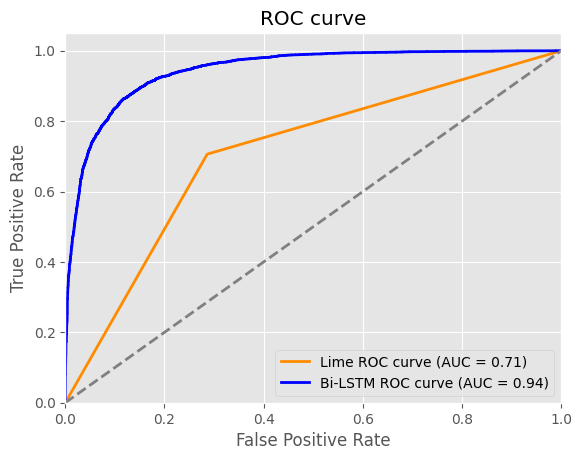

In [ ]:
from sklearn.metrics import roc_curve, auc
index = 9917
# Extract the Lime labels and y_pred labels

le = LabelEncoder()
lime_labels = le.fit_transform(results_df['label'])
y_pred_lime = np.round(model.predict(X_test)[:, -1])
y_pred_sample = y_pred_lime[:index]

# Calculate the ROC curve and AUC for both models
fpr_lime, tpr_lime, _ = roc_curve(lime_labels, y_pred_sample)
roc_auc_lime = auc(fpr_lime, tpr_lime)
y_scores = model.predict(X_test)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_scores)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plot the ROC curve for both models
plt.figure()
lw = 2
plt.plot(fpr_lime, tpr_lime, color='darkorange',
         lw=lw, label='Lime ROC curve (AUC = %0.2f)' % roc_auc_lime)
plt.plot(fpr_lstm, tpr_lstm, color='blue',
         lw=lw, label='Bi-LSTM ROC curve (AUC = %0.2f)' % roc_auc_lstm)
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve_test.png')
plt.show()


In [ ]:
f1_lime

0.7188354826103948

310/310 [==============================] - 3s 11ms/step


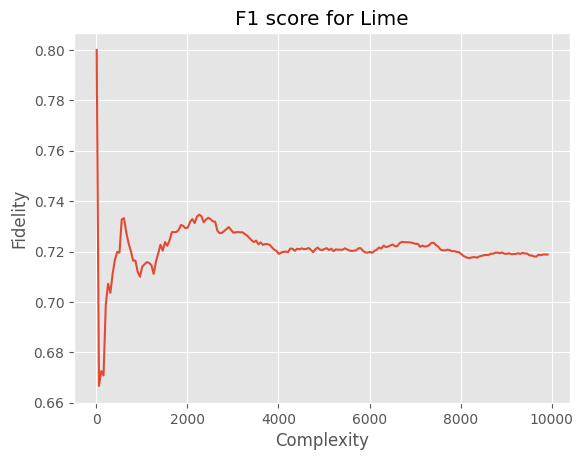

In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Extract the Lime labels and y_pred labels
le = LabelEncoder()
lime_labels = le.fit_transform(results_df['label'])
y_pred_lime = np.round(model.predict(X_test)[:, -1])
y_pred_sample = y_pred_lime[:index]

# Calculate the F1 score for Lime on the entire test set
f1_lime = f1_score(lime_labels, y_pred_sample, pos_label=1) 

# Calculate the F1 score as a function of the number of samples
num_samples = np.arange(10, len(y_pred_sample), 50)
f1_scores = []
for n in num_samples:
    f1 = f1_score(lime_labels[:n], y_pred_sample[:n], pos_label=1)
    f1_scores.append(f1)

# Plot the F1 score as a function of the number of samples
plt.plot(num_samples, f1_scores)
plt.xlabel('Complexity')
plt.ylabel('Fidelity')
plt.title('F1 score for Lime')
plt.savefig('f1_score_lime_test.png')
plt.show()

310/310 [==============================] - 3s 10ms/step


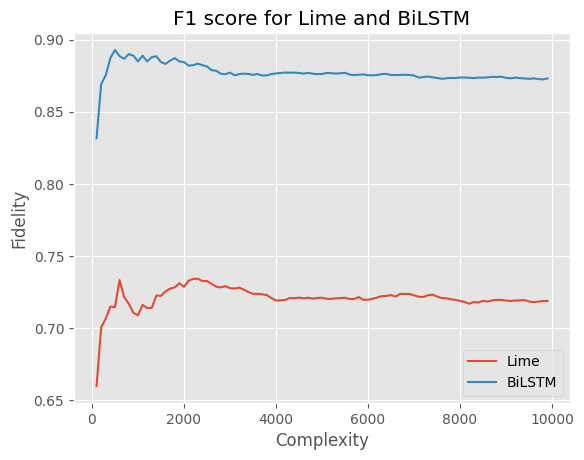

In [ ]:
from sklearn.metrics import f1_score

# Extract the Lime labels and y_pred labels
le = LabelEncoder()
lime_labels = le.fit_transform(results_df['label'])
y_pred_lime= np.round(model.predict(X_test)[:, -1])
y_pred_sample = y_pred_lime[:9917]

# Calculate the F1 score for Lime on the entire test set
f1_lime = f1_score(lime_labels, y_pred_sample, pos_label=1) 

# Calculate the F1 score for the original BiLSTM model as a function of the number of samples
num_samples = np.arange(100, len(y_pred_sample), 100)
f1_scores_bilstm = []
for n in num_samples:
    y_pred_bilstm = np.round(model.predict(X_test[:n])[:, -1])
    labels = np.round(y_test[:n])[:, -1]
    f1 = f1_score(labels, y_pred_bilstm, pos_label=1)
    f1_scores_bilstm.append(f1)

# Calculate the F1 score as a function of the number of samples for Lime
f1_scores_lime = []
for n in num_samples:
    f1 = f1_score(lime_labels[:n], y_pred_sample[:n], pos_label=1)
    f1_scores_lime.append(f1)

# Plot the F1 score as a function of the number of samples
plt.plot(num_samples, f1_scores_lime, label='Lime')
plt.plot(num_samples, f1_scores_bilstm, label='BiLSTM')
plt.xlabel('Complexity')
plt.ylabel('Fidelity')
plt.title('F1 score for Lime and BiLSTM')
plt.legend()
plt.savefig('f1_score_lime_bilstm.png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Extract the Lime labels and y_pred labels
le = LabelEncoder()
lime_labels = le.fit_transform(results_df['label'])
y_pred_lime = np.round(model.predict(X_test)[:, -1])
y_pred_sample = y_pred_lime[:index]


# Calculate the F1 score for Lime on the entire test set
f1_lime = f1_score(lime_labels, y_pred_sample, pos_label=1) 

# Calculate the F1 score for the original BiLSTM model as a function of the number of samples
num_samples = np.arange(10, len(y_pred_sample), 5)
f1_scores_bilstm = []
for n in num_samples:
    y_pred_bilstm = np.round(model.predict(X_test[:n])[:, -1])
    labels = np.round(y_test[:n])[:, -1]
    f1 = f1_score(labels, y_pred_bilstm, pos_label=1)
    f1_scores_bilstm.append(f1)

# Calculate the F1 score as a function of the number of samples for Lime
f1_scores_lime = []
for n in num_samples:
    f1 = f1_score(lime_labels[:n], y_pred_sample[:n], pos_label=1)
    f1_scores_lime.append(f1)

# Plot the F1 score as a function of the number of samples
fig, ax = plt.subplots()
ax.plot(num_samples, f1_scores_lime, label='LIME surrogate')
ax.plot(num_samples, f1_scores_bilstm, label='Bi-LSTM')
ax.set_xlabel('Complexity\n(# of samples )')
ax.set_ylabel('Fidelity\n(F1 score)')
ax.set_title('F1 score for Lime and BiLSTM')
ax.legend()
plt.savefig('f1_score_lime_bilstm.png')
plt.show()


21/26 [=======================>......] - ETA: 0s

KeyboardInterrupt: ignored

# LIME: Local Explainability 
####Evaluate positive review
- build local explainer 
- review features 

In [ ]:
from lime.lime_text import LimeTextExplainer
import tensorflow as tf
index = 4
explainer = LimeTextExplainer(class_names=["negative", "positive"])

def print_function(review, actual_sentiment, predicted_sentiment):
    #print("Review: ", review)
    #print("Actual sentiment: ", actual_sentiment)
    #print("Predicted sentiment: ", predicted_sentiment)
     print()

def predict_function(tokenized_text):

    test_seq = tokenizer.texts_to_sequences(tokenized_text)
    test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=max_len)
    pred = model.predict(test_pad)
    format_pred = np.concatenate([1.0-pred, pred], axis=1)
    predicted_sentiment = "positive" if format_pred[0][1] > 0.5 else "negative"
    print_function(df.review_clean[index], df.sentiment[index], predicted_sentiment)
    return format_pred

exp = explainer.explain_instance(df.review_clean[index], predict_function)
print(exp.as_list())

NameError: ignored

In [ ]:
%matplotlib inline
fig = exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(text=True)

#Evaluate negative review

In [ ]:
exp = explainer.explain_instance(df.review_clean[3], predict_function, num_features=7)

print(exp.as_list())

In [ ]:
exp.show_in_notebook(text=True)

In [ ]:
%matplotlib inline
fig = exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(text=True)

In [ ]:
exp = explainer.explain_instance(df.review_clean[18191], predict_function, num_features=7)

In [ ]:
exp.show_in_notebook(text=True)

## GLOBAL EXPLANATION WITH SP-LIME
-> measuring fidelity and complexity of surrogate 
-> quantifying % of word dependecies for each classifier

In [ ]:
import numpy as np
import pandas as pd
from lime.lime_text import LimeTextExplainer
from lime import submodular_pick

def sp_lime_explanations(tokenized_sample, num_explanations=5, num_features=5):
    num_samples = tokenized_sample.shape[0]
    max_len = 10000
    explainer = LimeTextExplainer(class_names=["negative", "positive"])

    # Create a list of texts to explain
    texts_to_explain = [''.join(sample) for sample in tokenized_sample]
    texts_to_explain = [text[:max_len] if len(text) > max_len else text for text in texts_to_explain]

    # Create a SubmodularPick object to select representative samples
    sp = submodular_pick.SubmodularPick(explainer, texts_to_explain, predict_function, num_features, num_exps_desired=num_explanations)

    # Store the explanations in a DataFrame
    results_df = pd.DataFrame(columns=["review_index", "word_count", "positive_count", "negative_count", "label"])

    for index, explanation in enumerate(sp.explanations):
        print("Explanation for index {}...".format(index))
        
        explanation_list = explanation.as_list()

        positive_count = 0
        negative_count = 0

        for word, weight in explanation_list:
            if weight >= 0:
                positive_count += 1
            else:
                negative_count += 1

        total_count = positive_count + negative_count
        positive_percentage = (positive_count / total_count) * 100 if total_count > 0 else 0
        negative_percentage = (negative_count / total_count) * 100 if total_count > 0 else 0

        label = "positive" if positive_count > negative_count else "negative"

        word_count = len(texts_to_explain[index].split())
        results_df = results_df.append({"review_index": index,
                                         "word_count": word_count,
                                         "positive_count": positive_count,
                                         "negative_count": negative_count,
                                         "label": label}, ignore_index=True)

    return results_df


In [ ]:
tokenized_sample = df.review_clean[:20]
results_df = sp_lime_explanations(tokenized_sample)

In [ ]:
# Calculate the percentage of positive and negative words required for each review
results_df['positive_percentage'] = results_df['positive_count'] / results_df['word_count']
results_df['negative_percentage'] = results_df['negative_count'] / results_df['word_count']

# Calculate the weighted average of the positive and negative percentages based on the length of each review
weighted_positive_percentage = (results_df['positive_percentage'] * results_df['word_count']).sum() / results_df['word_count'].sum()
weighted_negative_percentage = (results_df['negative_percentage'] * results_df['word_count']).sum() / results_df['word_count'].sum()

print("Weighted average percentage of words required for positive label: {:.2f}%".format(weighted_positive_percentage * 100))
print("Weighted average percentage of words required for negative label: {:.2f}%".format(weighted_negative_percentage * 100))


In [ ]:
from sklearn.metrics import roc_curve, auc

# Extract the Lime labels and y_pred labels

le = LabelEncoder()
lime_labels = le.fit_transform(results_df['label'])
y_pred = np.round(model.predict(X_test)[:, -1])
y_pred_sample = y_pred[:20]

# Calculate the ROC curve and AUC for both models
fpr_lime, tpr_lime, _ = roc_curve(lime_labels, y_pred_sample)
roc_auc_lime = auc(fpr_lime, tpr_lime)
y_scores = model.predict(X_test)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_scores)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plot the ROC curve for both models
plt.figure()
lw = 2
plt.plot(fpr_lime, tpr_lime, color='darkorange',
         lw=lw, label='Lime ROC curve (AUC = %0.2f)' % roc_auc_lime)
plt.plot(fpr_lstm, tpr_lstm, color='blue',
         lw=lw, label='LSTM ROC curve (AUC = %0.2f)' % roc_auc_lstm)
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve_30.png')
plt.show()


In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Extract the Lime labels and y_pred labels
le = LabelEncoder()
lime_labels = le.fit_transform(results_df['label'])
y_pred = np.round(model.predict(X_test)[:, -1])
y_pred_sample = y_pred[:20]

# Calculate the F1 score for Lime on the entire test set
f1_lime = f1_score(lime_labels, y_pred_sample, pos_label=1)

# Calculate the F1 score as a function of the number of samples
num_samples = np.arange(20, len(y_pred_sample), 100)
f1_scores = []
for n in num_samples:
    f1 = f1_score(lime_labels[:n], y_pred_sample[:n], pos_label=1)
    f1_scores.append(f1)

# Plot the F1 score as a function of the number of samples
plt.plot(num_samples, f1_scores, 'o-')
plt.xlabel('Complexity')
plt.ylabel('Fidelity')
plt.title('F1 score for Lime')
plt.savefig('f1_score_lime_20.png')
plt.show()

In [ ]:
tokenized_sample = df.review_clean[:20]
from lime.lime_text import LimeTextExplainer
import numpy as np
import pandas as pd

def batch_explanation(tokenized_sample):
    num_samples = tokenized_sample.shape[0]
    num_words = len(tokenized_sample[0])
    max_len = 10000

    results_df = pd.DataFrame(columns=["review_index", "word_count", "positive_count", "negative_count", "label"])
    explainer = LimeTextExplainer(class_names=["negative", "positive"])

    for index in range(num_samples):
        text_to_explain = ''.join(tokenized_sample[index])

        if len(text_to_explain) > max_len:
            text_to_explain = text_to_explain[:max_len]

        print("Explaining index {}...".format(index))
        explanation = explainer.explain_instance(text_to_explain, predict_function)
        explanation_list = explanation.as_list()

        positive_count = 0
        negative_count = 0

        for word, weight in explanation.as_list():
            if weight >= 0:
                positive_count += 1
            else:
                negative_count += 1

        total_count = positive_count + negative_count
        positive_percentage = (positive_count / total_count) * 100 if total_count > 0 else 0
        negative_percentage = (negative_count / total_count) * 100 if total_count > 0 else 0

        label = "positive" if positive_count > negative_count else "negative"

        word_count = len(text_to_explain.split())
        results_df = results_df.append({"review_index": index,
                                         "word_count": word_count,
                                         "positive_count": positive_count,
                                         "negative_count": negative_count,
                                         "label": label}, ignore_index=True)

    return results_df


In [ ]:
results_df = batch_explanation(tokenized_sample)

In [ ]:
results300=results_df

In [ ]:
results30.head()

In [ ]:
# Let's use SP-LIME to return explanations on a few sample data sets 
# and obtain a non-redundant global decision perspective of the black-box model
from lime import submodular_pick
sp_exp = submodular_pick.SubmodularPick(explainer,
                                        df.review_clean[:300].values,
                                        #tokenized_sample[:10].values,
                                        #df[features.columns].values,
                                        predict_function, 
                                        num_features=5,
                                        num_exps_desired=5,
                                        )

In [ ]:
import numpy as np
import pandas as pd
from lime.lime_text import LimeTextExplainer
from lime import submodular_pick

def sp_lime_text_explanations(tokenized_sample, num_explanations=5, num_features=5):
    num_samples = tokenized_sample[:2]
    max_len = 10000

    # Create a SubmodularPick object to select representative samples
    sp = submodular_pick.SubmodularPick(explainer, df.review_clean[:300].values, predict_function, num_features)

    # Store the explanations in a DataFrame
    results_df = pd.DataFrame(columns=["review_index", "word_count", "positive_count", "negative_count", "label"])


In [ ]:
sp_lime_text_explanations(tokenized_sample, num_explanations=5, num_features=5)

In [ ]:
[exp.show_in_notebook() for exp in sp_exp.sp_explanations]
print('SP-LIME Explanations.')

In [ ]:
##modifed code 
# !pip install eli5



import scipy
import numpy as np
def monkeypath_itemfreq(sampler_indices):
   return zip(*np.unique(sampler_indices, return_counts=True))

scipy.stats.itemfreq=monkeypath_itemfreq

In [ ]:
pip install eli5

In [ ]:

from eli5.lime.samplers import MaskingTextSampler   

In [ ]:
#get top 5 features from explainer
top_features = exp.as_list()
top_features

#masking top 5 features in text with  replacement UNK  in text


masking_text_sampler = MaskingTextSampler(top_features, random_state=42, replacement='UNK')
masking_text_sampler

#predicting the probability of the masked text
from eli5.lime import TextExplainer

te = TextExplainer(random_state=42)
te.fit(df.review_clean[3], predict_function)
te.predict_proba = predict_function
te.predict_proba(['UNK'])




In [ ]:
#highlighting the masked text
te.show_prediction(target_names=['negative', 'positive'], top=5)

In [ ]:
#showing the masked text in lime
te.show_weights(top=5)


In [ ]:
#draw graph of model fidelity and complexity of number of explanations
from lime import lime_text
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

c = make_pipeline(TfidfVectorizer(), LogisticRegression())
c.fit(df.review_clean, df.sentiment)
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['negative', 'positive'])
exp = explainer.explain_instance(df.review_clean[3], c.predict_proba, num_features=5)
exp.as_pyplot_figure()





In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(fpr, tpr, auc_score, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1]) # axis
    plt.xlabel('False Positive Rate') # x label
    plt.ylabel('True Positive Rate') # y label
    plt.text(0.6, 0.2, 'AUC = {:.3f}'.format(auc_score), fontsize=12)
    plt.legend(loc="lower right")

y_scores = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc,label ='ROC curve')
plt.savefig("roc_curve.png")
plt.show()


In [ ]:
#draw plot of model fidelity(f1) and complexity( number of explanations)
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def get_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    return accuracy, precision, recall, f1, roc_auc

def get_metrics_df(y_test, y_pred):
    metrics = get_metrics(y_test, y_pred)
    metrics_result = pd.DataFrame([metrics], columns=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    return metrics_result






In [ ]:
#global explaining the model by accumulating the local explanations and masking the top 5 features in text with  replacement UNK  in text
from eli5.lime.samplers import MaskingTextSampler
from eli5.lime import TextExplainer

def global_explain(model, X, y, num_features=5, num_samples=1000):
    explainer = LimeTextExplainer(class_names=['negative', 'positive'])
    masking_text_sampler = MaskingTextSampler(top_features, random_state=42, replacement='UNK')
    te = TextExplainer(random_state=42)
    te.fit(X, predict_function)
    te.predict_proba = predict_function
    te.predict_proba(['UNK'])
    te.show_prediction(target_names=['negative', 'positive'], top=5)
    te.show_weights(top=5)
    return te


In [ ]:
class GlobalExplainer:
    def __init__(self, model, data, target_names):
        self.model = model
        self.data = data
        self.target_names = target_names
        self.feature_names = data.columns

    def explain_global(self, num_features=10, num_samples=5000, random_state=None):
        explainer = lime.lime_tabular.LimeTabularExplainer(self.data.values, 
                                                           mode='regression',
                                                           feature_names=self.feature_names, 
                                                           class_names=self.target_names, 
                                                           discretize_continuous=True)
        
        def predict_wrapper(X):
            return self.model.predict(X)

        exp = explainer.explain_instance(self.data.values[0], predict_wrapper, 
                                         num_features=num_features, 
                                         num_samples=num_samples, 
                                         random_state=random_state)

        feature_weights = dict(exp.as_map()[1])
        feature_names = [x[0] for x in exp.as_list()]

        top_5_features = feature_names[:5]
        print(f'Top 5 features: {top_5_features}')

        mask = np.array([True] * len(self.feature_names))
        for feature in top_5_features:
            mask[self.feature_names == feature] = False

        coef = self.model.coef_.flatten()
        feature_importance_scores = dict(zip(self.feature_names, coef))

        masked_feature_importance_scores = {k:v for k,v in feature_importance_scores.items() if mask[self.feature_names == k][0]}

        sorted_feature_importance_scores = dict(sorted(masked_feature_importance_scores.items(), 
                                                       key=lambda item: abs(item[1]), 
                                                       reverse=True))

        return sorted_feature_importance_scores


global_explainer = GlobalExplainer(model, X_train, ['negative', 'positive'])



In [ ]:
from IPython.display import display
display(te.show_weights(top=5, target_names=['negative', 'positive']))



In [ ]:
df.review_clean[3]

# 1. SHAP

In [ ]:
import shap
shap.initjs()

In [ ]:
# Create an explainer object
explainer = shap.explainers.Permutation(model.predict, X_train, max_evals = 2000)

In [ ]:
# Explain the first test instance
shap_values = explainer(X_test[:10])


In [ ]:
# transform the indexes to words
import numpy as np
words = imdb.get_word_index()
num2word = {}
for w in words.keys():
    num2word[words[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), X_test[i]))) for i in range(10)])

In [ ]:
shap.summary_plot(shap_values, feature_names=x_test_words[3])

In [ ]:
shap.summary_plot(shap_values, feature_names=x_test_words[3])

In [ ]:
explainer = shap.KernelExplainer(model.predict,X_train[:300])

In [ ]:
shap_values = explainer.shap_values(X_test[:10])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=x_test_words[9])

In [ ]:
shap.initjs()
#shap.force_plot(shap_values[0][0])
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=x_test_words[9])

In [ ]:
#  global explanation  
def global_explanation(X):
    shap_values = explainer(X)
    
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    
    shap_df = pd.DataFrame({'feature': X.columns, 'mean_abs_shap': mean_abs_shap})
    
    shap_df = shap_df.sort_values(by='mean_abs_shap', ascending=False)
    
    return shap_df

shap_df = global_explanation(X_train)

shap_df.plot.bar(x='feature', y='mean_abs_shap', figsize=(10, 8), legend=False, fontsize=12)
plt.title('Global Feature Importance', fontsize=16)
plt.show()
